In [1]:
!pip install 'zarr<3'
!pip install timm


Defaulting to user installation because normal site-packages is not writeable
  Using cached zarr-2.18.7-py3-none-any.whl.metadata (5.8 kB)
  Using cached asciitree-0.3.3-py3-none-any.whl
  Using cached fasteners-0.20-py3-none-any.whl.metadata (4.8 kB)
  Using cached numcodecs-0.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.9 kB)
  Using cached deprecated-1.3.1-py2.py3-none-any.whl.metadata (5.9 kB)
Using cached zarr-2.18.7-py3-none-any.whl (211 kB)
Using cached numcodecs-0.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.9 MB)
Using cached fasteners-0.20-py3-none-any.whl (18 kB)
Using cached deprecated-1.3.1-py2.py3-none-any.whl (11 kB)

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Using cached timm-1.0.24-py3-none-any.whl.metadata (38 kB)
Using cached timm-1.0.24-py3-none-any.whl (2.6 MB)

[not

In [2]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


## Load tissuenet

📥 Loading TissueNet Test data...

✅ Loaded successfully!
  Images shape: (1324, 256, 256, 2) - dtype: float64
  Masks shape: (1324, 256, 256, 2) - dtype: int32
  Number of samples: 1324

📊 Data characteristics:
  Image channels: 2 (nuclear + membrane)
  Mask channels: 2 (nuclear segmentation + whole-cell segmentation)
  Image size: 256 x 256
  Image value range: [0.0, 95078.0]

🔬 Mask analysis (sample 0):
  Nuclear instances: 631
  Whole-cell instances: 363


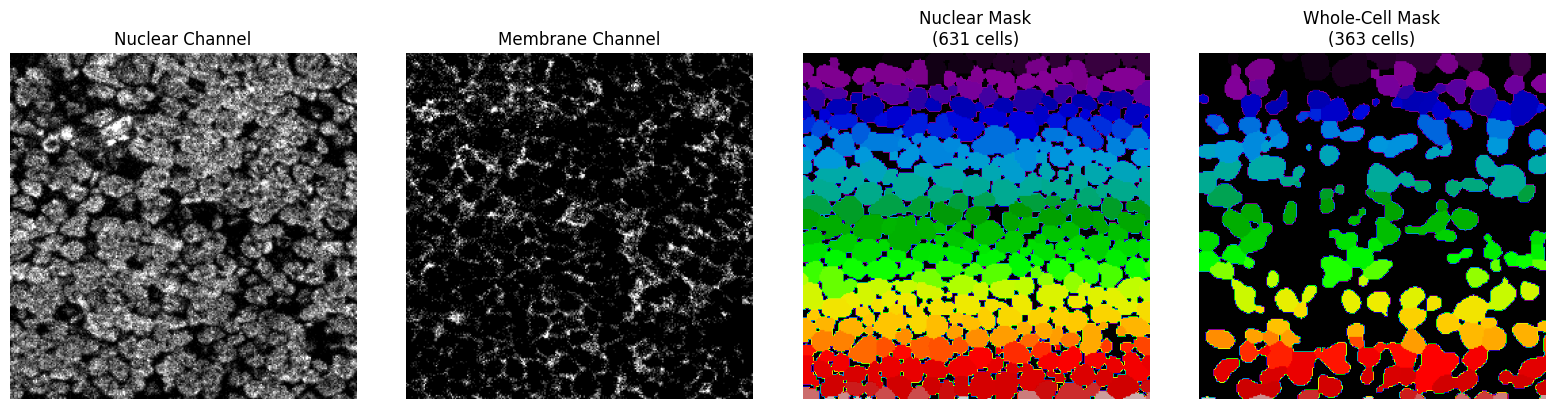


📌 Note: TissueNet has 2 mask types:
  - Channel 0: Nuclear segmentation
  - Channel 1: Whole-cell segmentation
  We'll evaluate nuclear segmentation using VitaminPFlex MIF nuclei branch


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# Load the test set
tissuenet_path = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/tissuenet_v1.1")
test_data = np.load(tissuenet_path / "tissuenet_v1.1_test.npz", allow_pickle=True)

print("📥 Loading TissueNet Test data...")

# Extract images and masks
images = test_data['X']  # Shape: (1324, 256, 256, 2) - 2 channels (nuclear + membrane)
masks = test_data['y']   # Shape: (1324, 256, 256, 2) - 2 channels (nuclear + whole-cell)
meta = test_data['meta'] # Metadata

print(f"\n✅ Loaded successfully!")
print(f"  Images shape: {images.shape} - dtype: {images.dtype}")
print(f"  Masks shape: {masks.shape} - dtype: {masks.dtype}")
print(f"  Number of samples: {len(images)}")

print(f"\n📊 Data characteristics:")
print(f"  Image channels: 2 (nuclear + membrane)")
print(f"  Mask channels: 2 (nuclear segmentation + whole-cell segmentation)")
print(f"  Image size: 256 x 256")
print(f"  Image value range: [{images.min():.1f}, {images.max():.1f}]")

# Analyze masks
print(f"\n🔬 Mask analysis (sample 0):")
nuclear_mask = masks[0, :, :, 0]
wholecell_mask = masks[0, :, :, 1]
print(f"  Nuclear instances: {nuclear_mask.max()}")
print(f"  Whole-cell instances: {wholecell_mask.max()}")

# Visualize one sample
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Normalize image for display
img_display = images[0].copy()
for c in range(2):
    channel = img_display[:, :, c]
    if channel.max() > 0:
        p_low, p_high = np.percentile(channel[channel > 0], [1, 99])
        img_display[:, :, c] = np.clip((channel - p_low) / (p_high - p_low), 0, 1)

axes[0].imshow(img_display[:, :, 0], cmap='gray')
axes[0].set_title('Nuclear Channel')
axes[0].axis('off')

axes[1].imshow(img_display[:, :, 1], cmap='gray')
axes[1].set_title('Membrane Channel')
axes[1].axis('off')

axes[2].imshow(nuclear_mask, cmap='nipy_spectral')
axes[2].set_title(f'Nuclear Mask\n({nuclear_mask.max()} cells)')
axes[2].axis('off')

axes[3].imshow(wholecell_mask, cmap='nipy_spectral')
axes[3].set_title(f'Whole-Cell Mask\n({wholecell_mask.max()} cells)')
axes[3].axis('off')

plt.tight_layout()
plt.show()

print(f"\n📌 Note: TissueNet has 2 mask types:")
print(f"  - Channel 0: Nuclear segmentation")
print(f"  - Channel 1: Whole-cell segmentation")
print(f"  We'll evaluate nuclear segmentation using VitaminPFlex MIF nuclei branch")

## Run vitaminp Flex

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from vitaminp import VitaminPFlex
from vitaminp.inference import ChannelConfig, WSIPredictor
from metrics import get_fast_pq, aggregated_jaccard_index
import tifffile

# Setup VitaminPFlex model
device = 'cuda'
print("📦 Loading VitaminPFlex model...")
model = VitaminPFlex(model_size='large').to(device)
model.load_state_dict(torch.load("checkpoints/vitamin_p_flex_large_fold2_best.pth", map_location=device))
model.eval()
print("✅ Model loaded")

# Select the same sample
idx = 1277
img = images[idx].copy()  # (256, 256, 2)

# Get nuclear mask (channel 0)
gt_mask_raw = masks[idx, :, :, 0].astype(np.int32)

print(f"\n🔍 Processing sample {idx}")
print("="*60)

# Analyze the mask
unique_labels = np.unique(gt_mask_raw)
unique_labels = unique_labels[unique_labels > 0]  # Exclude background

print(f"\n🧬 Ground Truth Analysis:")
print(f"  Raw mask shape: {gt_mask_raw.shape}")
print(f"  Max label ID: {gt_mask_raw.max()}")
print(f"  Unique instance labels: {len(unique_labels)}")
print(f"  Label range: {unique_labels.min()} to {unique_labels.max()}")
print(f"  Labels are consecutive: {np.array_equal(unique_labels, np.arange(1, len(unique_labels) + 1))}")

# Renumber labels to be consecutive (1, 2, 3, ... N)
# This is CRITICAL for metrics computation
gt_mask = np.zeros_like(gt_mask_raw)
for new_id, old_id in enumerate(unique_labels, start=1):
    gt_mask[gt_mask_raw == old_id] = new_id

num_gt_nuclei = len(unique_labels)
print(f"\n✅ Renumbered GT to consecutive labels: 1 to {num_gt_nuclei}")

# Create temp directories
temp_dir = Path("temp_tissuenet")
temp_output_dir = Path("temp_tissuenet_output")
temp_dir.mkdir(exist_ok=True)
temp_output_dir.mkdir(exist_ok=True)

# ===== ZERO-PADDING TO 512x512 =====
img_padded = np.zeros((512, 512, 2), dtype=img.dtype)
img_padded[:256, :256, :] = img

print(f"\n📐 Zero-padding:")
print(f"  Original size: 256x256")
print(f"  Padded size: 512x512")

# Save padded image as OME-TIFF
temp_img_path = temp_dir / f"sample_{idx}_padded.ome.tiff"

img_save = np.zeros((2, 512, 512), dtype=np.uint16)
for c in range(2):
    channel = img_padded[:, :, c]
    if channel.max() > 0:
        p_low, p_high = np.percentile(channel[channel > 0], [0.1, 99.9])
        normalized = np.clip((channel - p_low) / (p_high - p_low), 0, 1)
        img_save[c] = (normalized * 65535).astype(np.uint16)

tifffile.imwrite(temp_img_path, img_save, photometric='minisblack')

# Create channel config
config = ChannelConfig(
    nuclear_channel=0,
    membrane_channel=1,
    membrane_combination='max',
    channel_names={0: 'Nuclear', 1: 'Membrane'}
)

# Create predictor
predictor = WSIPredictor(
    model=model,
    device=device,
    patch_size=512,
    overlap=0,
    target_mpp=0.263,
    magnification=40,
    mif_channel_config=config
)

print("\n🔄 Running inference with VitaminPFlex MIF nuclei...")

# Run inference
results = predictor.predict(
    wsi_path=str(temp_img_path),
    output_dir=str(temp_output_dir),
    branch='mif_nuclei',
    filter_tissue=False,
    clean_overlaps=True,
    save_geojson=False,
    save_json=False,
    save_csv=False,
    save_visualization=False,
    save_masks=False,
    detection_threshold=0.5,
    min_area_um=2.0
)

print(f"✅ Detected {results['num_detections']} nuclei in {results['processing_time']:.2f}s")

# Extract instances
instances_dict = results['instances']

# Create instance map (512x512)
nuclei_inst_padded = np.zeros((512, 512), dtype=np.int32)

for inst_id, inst_info in instances_dict.items():
    if 'contour' in inst_info:
        contour = np.array(inst_info['contour'], dtype=np.int32)
        cv2.fillPoly(nuclei_inst_padded, [contour], inst_id)
    elif 'coords' in inst_info:
        coords = np.array(inst_info['coords'], dtype=np.int32)
        cv2.fillPoly(nuclei_inst_padded, [coords], inst_id)

# ===== CROP BACK TO 256x256 =====
nuclei_inst = nuclei_inst_padded[:256, :256].copy()

print(f"\n✂️ Cropping predictions back to 256x256")
print(f"  Padded detections: {results['num_detections']}")
print(f"  After crop: {len(np.unique(nuclei_inst)) - 1} nuclei")

num_nuclei = len(np.unique(nuclei_inst)) - 1

# Compute metrics
print("\n📊 Computing metrics...")
try:
    pq, dq, sq = get_fast_pq(gt_mask, nuclei_inst)
    aji = aggregated_jaccard_index(gt_mask, nuclei_inst)
    
    print("\n" + "="*60)
    print("🔬 NUCLEI INSTANCE SEGMENTATION METRICS")
    print("="*60)
    print(f"  PQ (Panoptic Quality):     {pq:.4f}")
    print(f"  DQ (Detection Quality):    {dq:.4f}")
    print(f"  SQ (Segmentation Quality): {sq:.4f}")
    print(f"  AJI (Agg. Jaccard Index):  {aji:.4f}")
    print("="*60)
except Exception as e:
    print(f"⚠️ Error computing metrics: {str(e)}")
    import traceback
    traceback.print_exc()
    pq, dq, sq, aji = 0, 0, 0, 0

# Visualization functions - FIXED COLORS: nuclei=blue, membrane=green
def colorize_instances(inst_map):
    colored = np.zeros((*inst_map.shape, 3), dtype=np.uint8)
    unique_ids = np.unique(inst_map)
    np.random.seed(42)
    for inst_id in unique_ids:
        if inst_id == 0:
            continue
        colored[inst_map == inst_id] = np.random.randint(0, 255, 3)
    return colored

def draw_instance_boundaries(image, inst_map, color=(0, 255, 0), thickness=1):
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    if len(image.shape) == 2:
        output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        output = image.copy()
    
    unique_ids = np.unique(inst_map)
    for inst_id in unique_ids:
        if inst_id == 0:
            continue
        mask = (inst_map == inst_id).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(output, contours, -1, color, thickness)
    
    return output

# Create RGB visualization - FIXED: nuclei=BLUE, membrane=GREEN
img_rgb = np.zeros((256, 256, 3), dtype=np.uint8)
for c in range(2):
    channel = img[:, :, c]
    if channel.max() > 0:
        p_low, p_high = np.percentile(channel[channel > 0], [0.1, 99.9])
        normalized = np.clip(255 * (channel - p_low) / (p_high - p_low), 0, 255)
        if c == 0:  # Nuclear -> BLUE
            img_rgb[:, :, 2] = normalized
        else:  # Membrane -> GREEN
            img_rgb[:, :, 1] = normalized

# Visualize results
gt_colored = colorize_instances(gt_mask)
pred_colored = colorize_instances(nuclei_inst)

# Boundaries: GT=green, Pred=red
gt_boundaries = draw_instance_boundaries(img_rgb.copy(), gt_mask, color=(0, 255, 0), thickness=2)
pred_boundaries = draw_instance_boundaries(img_rgb.copy(), nuclei_inst, color=(255, 0, 0), thickness=2)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Ground Truth
axes[0, 0].imshow(img_rgb)
axes[0, 0].set_title(f'TissueNet Image\n(Blue=Nuclear, Green=Membrane)', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(gt_colored)
axes[0, 1].set_title(f'GT Nuclei (colored)\n{num_gt_nuclei} nuclei', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(gt_boundaries)
axes[0, 2].set_title(f'GT Boundaries (Green)', fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

# Row 2: Predictions
axes[1, 0].imshow(img_rgb)
axes[1, 0].set_title(f'TissueNet Image\n(Blue=Nuclear, Green=Membrane)', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(pred_colored)
axes[1, 1].set_title(f'Pred Nuclei (colored)\n{num_nuclei} nuclei', fontsize=12)
axes[1, 1].axis('off')

axes[1, 2].imshow(pred_boundaries)
axes[1, 2].set_title(f'Pred Boundaries (Red)', fontsize=12, fontweight='bold')
axes[1, 2].axis('off')

# Add metrics as suptitle
plt.suptitle(f'VitaminPFlex Zero-Shot on TissueNet (Nuclear Segmentation) - Sample {idx}\n'
             f'PQ: {pq:.3f} | DQ: {dq:.3f} | SQ: {sq:.3f} | AJI: {aji:.3f}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'tissuenet_eval_sample_{idx}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Summary:")
print(f"  GT: {num_gt_nuclei} nuclei")
print(f"  Predicted: {num_nuclei} nuclei")
print(f"  Difference: {num_nuclei - num_gt_nuclei} ({((num_nuclei - num_gt_nuclei) / num_gt_nuclei * 100):.1f}%)")

# Cleanup temp files
import shutil
shutil.rmtree(temp_dir, ignore_errors=True)
shutil.rmtree(temp_output_dir, ignore_errors=True)

📦 Loading VitaminPFlex model...
✓ VitaminPFlex initialized with large backbone
  Architecture: Shared Encoder → 4 Separate Decoders
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]
✅ Model loaded

🔍 Processing sample 737

🧬 Ground Truth Analysis:
  Raw mask shape: (256, 256)
  Max label ID: 0
  Unique instance labels: 0


ValueError: zero-size array to reduction operation minimum which has no identity

## Pannuke instance metrics with Flex

In [30]:
import torch
import numpy as np
from pathlib import Path
import cv2
import tifffile
from vitaminp import VitaminPFlex
from vitaminp.inference import ChannelConfig, WSIPredictor
from metrics import get_fast_pq, aggregated_jaccard_index
from tqdm import tqdm
import shutil

# Setup model
device = 'cuda'
print("📦 Loading VitaminPFlex model...")
model = VitaminPFlex(model_size='large').to(device)
model.load_state_dict(torch.load("checkpoints/vitamin_p_flex_large_fold2_best.pth", map_location=device))
model.eval()
print("✅ Model loaded")

print(f"\n🔍 Evaluating on {len(images)} TissueNet test samples")
print(f"   Using nuclear GT masks (channel 0) to match MIF nuclei predictions")

# Create temp directories
temp_dir = Path("temp_tissuenet")
temp_output_dir = Path("temp_tissuenet_output")
temp_dir.mkdir(exist_ok=True)
temp_output_dir.mkdir(exist_ok=True)

# Initialize metric storage
tissuenet_metrics = {
    'pq': [],
    'dq': [],
    'sq': [],
    'aji': [],
    'gt_count': [],
    'pred_count': []
}

# Store per-sample results
sample_results = []

# Create channel config for TissueNet
config = ChannelConfig(
    nuclear_channel=0,
    membrane_channel=1,
    membrane_combination='max',
    channel_names={0: 'Nuclear', 1: 'Membrane'}
)

print(f"\n🔄 Evaluating VitaminPFlex on TissueNet ({len(images)} samples)...")
print(f"   Strategy: Zero-pad 256x256 → 512x512, then crop predictions back")
print("="*80)

skipped_samples = 0

for idx in tqdm(range(len(images)), desc="Processing samples"):
    try:
        # Load image and mask
        img = images[idx].copy()  # (256, 256, 2)
        gt_mask_raw = masks[idx, :, :, 0].astype(np.int32)  # ✅ Nuclear GT (channel 0)
        
        # ✅ FIX: Renumber labels to consecutive (1, 2, 3, ... N)
        # TissueNet has non-consecutive labels, so we must renumber for metrics
        unique_labels = np.unique(gt_mask_raw)
        unique_labels = unique_labels[unique_labels > 0]  # Exclude background
        gt_mask = np.zeros_like(gt_mask_raw)
        for new_id, old_id in enumerate(unique_labels, start=1):
            gt_mask[gt_mask_raw == old_id] = new_id
        
        # ===== ZERO-PADDING TO 512x512 =====
        img_padded = np.zeros((512, 512, 2), dtype=img.dtype)
        img_padded[:256, :256, :] = img  # Place in top-left corner
        
        # Save as OME-TIFF
        temp_img_path = temp_dir / f"sample_{idx}_padded.ome.tiff"
        img_save = np.zeros((2, 512, 512), dtype=np.uint16)
        for c in range(2):
            channel = img_padded[:, :, c]
            if channel.max() > 0:
                p_low, p_high = np.percentile(channel[channel > 0], [0.1, 99.9])
                normalized = np.clip((channel - p_low) / (p_high - p_low), 0, 1)
                img_save[c] = (normalized * 65535).astype(np.uint16)
        
        tifffile.imwrite(temp_img_path, img_save, photometric='minisblack')
        
        # Create predictor
        predictor = WSIPredictor(
            model=model,
            device=device,
            patch_size=512,      # ✅ Use 512 to match model training
            overlap=0,
            target_mpp=0.263,
            magnification=40,
            mif_channel_config=config
        )
        
        # Run inference
        results = predictor.predict(
            wsi_path=str(temp_img_path),
            output_dir=str(temp_output_dir),
            branch='mif_nuclei',
            filter_tissue=False,
            clean_overlaps=True,
            save_geojson=False,
            save_json=False,
            save_csv=False,
            save_visualization=False,
            save_masks=False,
            detection_threshold=0.5,
            min_area_um=2.0  # Lower threshold for nuclei
        )
        
        # Extract instances
        instances_dict = results['instances']
        
        # Create instance map (512x512)
        nuclei_inst_padded = np.zeros((512, 512), dtype=np.int32)
        
        for inst_id, inst_info in instances_dict.items():
            if 'contour' in inst_info:
                contour = np.array(inst_info['contour'], dtype=np.int32)
                cv2.fillPoly(nuclei_inst_padded, [contour], inst_id)
            elif 'coords' in inst_info:
                coords = np.array(inst_info['coords'], dtype=np.int32)
                cv2.fillPoly(nuclei_inst_padded, [coords], inst_id)
        
        # ===== CROP BACK TO 256x256 =====
        nuclei_inst = nuclei_inst_padded[:256, :256].copy()
        
        # Compute metrics
        pq, dq, sq = get_fast_pq(gt_mask, nuclei_inst)
        aji = aggregated_jaccard_index(gt_mask, nuclei_inst)
        
        # ✅ FIX: Use number of unique labels, not max label ID
        num_gt = len(unique_labels)
        num_pred = len(np.unique(nuclei_inst)) - 1  # -1 for background
        
        # Store metrics
        tissuenet_metrics['pq'].append(pq)
        tissuenet_metrics['dq'].append(dq)
        tissuenet_metrics['sq'].append(sq)
        tissuenet_metrics['aji'].append(aji)
        tissuenet_metrics['gt_count'].append(num_gt)
        tissuenet_metrics['pred_count'].append(num_pred)
        
        # Store detailed results
        sample_results.append({
            'sample_id': idx,
            'pq': pq,
            'dq': dq,
            'sq': sq,
            'aji': aji,
            'gt_count': num_gt,
            'pred_count': num_pred
        })
        
        # Cleanup sample temp files
        temp_img_path.unlink()
        
    except Exception as e:
        print(f"\n⚠️ Skipping sample {idx} due to error: {str(e)[:100]}")
        import traceback
        traceback.print_exc()
        skipped_samples += 1
        continue

# Cleanup temp directories
shutil.rmtree(temp_dir, ignore_errors=True)
shutil.rmtree(temp_output_dir, ignore_errors=True)

# ========== OVERALL RESULTS ==========
print("\n" + "="*80)
print("📊 TISSUENET TEST SET RESULTS - VITAMINPFLEX ZERO-SHOT (NUCLEAR SEGMENTATION)")
print("="*80)

print(f"\nTotal samples processed: {len(tissuenet_metrics['pq'])}/{len(images)}")
if skipped_samples > 0:
    print(f"⚠️ Skipped samples: {skipped_samples}")

if len(tissuenet_metrics['pq']) > 0:
    print("\n🔬 NUCLEI INSTANCE METRICS:")
    print(f"  PQ (Panoptic Quality):     {np.mean(tissuenet_metrics['pq']):.4f} ± {np.std(tissuenet_metrics['pq']):.4f}")
    print(f"  DQ (Detection Quality):    {np.mean(tissuenet_metrics['dq']):.4f} ± {np.std(tissuenet_metrics['dq']):.4f}")
    print(f"  SQ (Segmentation Quality): {np.mean(tissuenet_metrics['sq']):.4f} ± {np.std(tissuenet_metrics['sq']):.4f}")
    print(f"  AJI (Agg. Jaccard Index):  {np.mean(tissuenet_metrics['aji']):.4f} ± {np.std(tissuenet_metrics['aji']):.4f}")

    print("\n📈 DETECTION STATISTICS:")
    total_gt = sum(tissuenet_metrics['gt_count'])
    total_pred = sum(tissuenet_metrics['pred_count'])
    print(f"  Total GT nuclei:       {total_gt}")
    print(f"  Total Pred nuclei:     {total_pred}")
    print(f"  Average GT per image:  {np.mean(tissuenet_metrics['gt_count']):.1f} ± {np.std(tissuenet_metrics['gt_count']):.1f}")
    print(f"  Average Pred per image: {np.mean(tissuenet_metrics['pred_count']):.1f} ± {np.std(tissuenet_metrics['pred_count']):.1f}")
    if total_gt > 0:
        print(f"  Detection ratio:       {total_pred/total_gt:.3f}")

    # Top/Bottom performers
    print("\n" + "="*80)
    print("🏆 TOP 10 SAMPLES (by PQ)")
    print("="*80)
    sorted_by_pq = sorted(sample_results, key=lambda x: x['pq'], reverse=True)
    print(f"{'Rank':<6} {'Sample':<10} {'GT':>6} {'Pred':>6} {'PQ':>8} {'DQ':>8} {'SQ':>8} {'AJI':>8}")
    print("-" * 80)
    for i, result in enumerate(sorted_by_pq[:10], 1):
        print(f"{i:<6} {result['sample_id']:<10} {result['gt_count']:>6} {result['pred_count']:>6} "
              f"{result['pq']:>8.4f} {result['dq']:>8.4f} {result['sq']:>8.4f} {result['aji']:>8.4f}")

    print("\n" + "="*80)
    print("⚠️  BOTTOM 10 SAMPLES (by PQ)")
    print("="*80)
    print(f"{'Rank':<6} {'Sample':<10} {'GT':>6} {'Pred':>6} {'PQ':>8} {'DQ':>8} {'SQ':>8} {'AJI':>8}")
    print("-" * 80)
    for i, result in enumerate(sorted_by_pq[-10:], 1):
        print(f"{i:<6} {result['sample_id']:<10} {result['gt_count']:>6} {result['pred_count']:>6} "
              f"{result['pq']:>8.4f} {result['dq']:>8.4f} {result['sq']:>8.4f} {result['aji']:>8.4f}")

print("\n" + "="*80)
print("✅ TissueNet evaluation complete!")
print("="*80)

print("\n💾 Results Summary:")
print("   VitaminPFlex (Zero-shot) vs CellSAM (Trained on TissueNet)")
print("   This demonstrates generalization capability on unseen data!")

📦 Loading VitaminPFlex model...
✓ VitaminPFlex initialized with large backbone
  Architecture: Shared Encoder → 4 Separate Decoders
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]
✅ Model loaded

🔍 Evaluating on 1324 TissueNet test samples
   Using nuclear GT masks (channel 0) to match MIF nuclei predictions

🔄 Evaluating VitaminPFlex on TissueNet (1324 samples)...
   Strategy: Zero-pad 256x256 → 512x512, then crop predictions back


Processing samples:   0%|          | 0/1324 [00:00<?, ?it/s]2026-01-20 20:04:02 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:02 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:02 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:02 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:02 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:02 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:02 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:02 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:02 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:02 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:02 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:02 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:02 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pix

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]
2026-01-20 20:04:02 - WSIPredictor - INFO -    ✓ Extracted 115 instances from tiles (before cleaning)
2026-01-20 20:04:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:03 - WSIPredictor - INFO - Starting overlap cleaning with 115 detections
2026-01-20 20:04:03 - WSIPredictor - INFO - Split detections: 0 mid, 115 edge
2026-01-20 20:04:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 115/115 detections
2026-01-20 20:04:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:03 - WSIPredictor - INFO - Cleaning complete: 115 -> 115 (0 removed)
2026-01-20 20:04:03 - WSIPredictor - INFO -    ✓ After cleaning: 115 instances
2026-01-20 20:04:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:03 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]
2026-01-20 20:04:03 - WSIPredictor - INFO -    ✓ Extracted 151 instances from tiles (before cleaning)
2026-01-20 20:04:03 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:03 - WSIPredictor - INFO - Starting overlap cleaning with 151 detections
2026-01-20 20:04:03 - WSIPredictor - INFO - Split detections: 0 mid, 151 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 151/151 detections
2026-01-20 20:04:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:03 - WSIPredictor - INFO - Cleaning complete: 151 -> 151 (0 removed)
2026-01-20 20:04:03 - WSIPredictor - INFO -    ✓ After cleaning: 151 instances
2026-01-20 20:04:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:03 - WSIPredictor - INFO - ✅ Complete! 151 detections in 0.24s
Processing samples:   0%|          | 2/1324 [00:01<11:59,  1.84it/s]2026-01-20 20:04:03 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:03 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:03 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:03 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:03 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:03 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 2

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]
2026-01-20 20:04:04 - WSIPredictor - INFO -    ✓ Extracted 146 instances from tiles (before cleaning)
2026-01-20 20:04:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:04 - WSIPredictor - INFO - Starting overlap cleaning with 146 detections
2026-01-20 20:04:04 - WSIPredictor - INFO - Split detections: 0 mid, 146 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 146/146 detections
2026-01-20 20:04:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:04 - WSIPredictor - INFO - Cleaning complete: 146 -> 146 (0 removed)
2026-01-20 20:04:04 - WSIPredictor - INFO -    ✓ After cleaning: 146 instances
2026-01-20 20:04:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:04 - WSIPredictor - INFO - ✅ Complete! 146 detections in 0.26s
Processing samples:   0%|          | 3/1324 [00:01<10:56,  2.01it/s]2026-01-20 20:04:04 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:04 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:04 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:04 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:04 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:04 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 2

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]
2026-01-20 20:04:04 - WSIPredictor - INFO -    ✓ Extracted 141 instances from tiles (before cleaning)
2026-01-20 20:04:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:04 - WSIPredictor - INFO - Starting overlap cleaning with 141 detections
2026-01-20 20:04:04 - WSIPredictor - INFO - Split detections: 0 mid, 141 edge
2026-01-20 20:04:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 141/141 detections
2026-01-20 20:04:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:04 - WSIPredictor - INFO - Cleaning complete: 141 -> 141 (0 removed)
2026-01-20 20:04:04 - WSIPredictor - INFO -    ✓ After cleaning: 141 instances
2026-01-20 20:04:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:04 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]
2026-01-20 20:04:04 - WSIPredictor - INFO -    ✓ Extracted 141 instances from tiles (before cleaning)
2026-01-20 20:04:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:04 - WSIPredictor - INFO - Starting overlap cleaning with 141 detections
2026-01-20 20:04:04 - WSIPredictor - INFO - Split detections: 0 mid, 141 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 141/141 detections
2026-01-20 20:04:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:05 - WSIPredictor - INFO - Cleaning complete: 141 -> 141 (0 removed)
2026-01-20 20:04:05 - WSIPredictor - INFO -    ✓ After cleaning: 141 instances
2026-01-20 20:04:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:05 - WSIPredictor - INFO - ✅ Complete! 141 detections in 0.24s
Processing samples:   0%|          | 5/1324 [00:02<10:01,  2.19it/s]2026-01-20 20:04:05 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:05 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:05 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:05 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:05 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:05 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 2

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]
2026-01-20 20:04:05 - WSIPredictor - INFO -    ✓ Extracted 36 instances from tiles (before cleaning)
2026-01-20 20:04:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:05 - WSIPredictor - INFO - Starting overlap cleaning with 36 detections
2026-01-20 20:04:05 - WSIPredictor - INFO - Split detections: 0 mid, 36 edge
2026-01-20 20:04:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 36/36 detections
2026-01-20 20:04:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:05 - WSIPredictor - INFO - Cleaning complete: 36 -> 36 (0 removed)
2026-01-20 20:04:05 - WSIPredictor - INFO -    ✓ After cleaning: 36 instances
2026-01-20 20:04:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:05 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:05 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:04:05 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:04:05 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:04:05 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]
2026-01-20 20:04:05 - WSIPredictor - INFO -    ✓ Extracted 127 instances from tiles (before cleaning)
2026-01-20 20:04:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:05 - WSIPredictor - INFO - Starting overlap cleaning with 127 detections
2026-01-20 20:04:05 - WSIPredictor - INFO - Split detections: 0 mid, 127 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 127/127 detections
2026-01-20 20:04:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:05 - WSIPredictor - INFO - Cleaning complete: 127 -> 127 (0 removed)
2026-01-20 20:04:05 - WSIPredictor - INFO -    ✓ After cleaning: 127 instances
2026-01-20 20:04:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:05 - WSIPredictor - INFO - ✅ Complete! 127 detections in 0.23s
Processing samples:   1%|          | 7/1324 [00:03<08:03,  2.72it/s]2026-01-20 20:04:05 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:05 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:05 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:05 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:05 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:05 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 2

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]
2026-01-20 20:04:05 - WSIPredictor - INFO -    ✓ Extracted 33 instances from tiles (before cleaning)
2026-01-20 20:04:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:05 - WSIPredictor - INFO - Starting overlap cleaning with 33 detections
2026-01-20 20:04:05 - WSIPredictor - INFO - Split detections: 0 mid, 33 edge
2026-01-20 20:04:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 33/33 detections
2026-01-20 20:04:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:05 - WSIPredictor - INFO - Cleaning complete: 33 -> 33 (0 removed)
2026-01-20 20:04:05 - WSIPredictor - INFO -    ✓ After cleaning: 33 instances
2026-01-20 20:04:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:05 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:05 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:04:05 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:04:05 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:04:05 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]
2026-01-20 20:04:06 - WSIPredictor - INFO -    ✓ Extracted 24 instances from tiles (before cleaning)
2026-01-20 20:04:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:06 - WSIPredictor - INFO - Starting overlap cleaning with 24 detections
2026-01-20 20:04:06 - WSIPredictor - INFO - Split detections: 0 mid, 24 edge
2026-01-20 20:04:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 24/24 detections
2026-01-20 20:04:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:06 - WSIPredictor - INFO - Cleaning complete: 24 -> 24 (0 removed)
2026-01-20 20:04:06 - WSIPredictor - INFO -    ✓ After cleaning: 24 instances
2026-01-20 20:04:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:06 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:06 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:06 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:06 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:06 - WSIPredictor - INFO - 📁 Opening MIF WSI: temp_tissuenet/sample_9_padded.ome.tiff
2026-01-20 20:04:06 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:04:06 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:04:06 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:04:06 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]
2026-01-20 20:04:06 - WSIPredictor - INFO -    ✓ Extracted 90 instances from tiles (before cleaning)
2026-01-20 20:04:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:06 - WSIPredictor - INFO - Starting overlap cleaning with 90 detections
2026-01-20 20:04:06 - WSIPredictor - INFO - Split detections: 0 mid, 90 edge
2026-01-20 20:04:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 90/90 detections
2026-01-20 20:04:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:06 - WSIPredictor - INFO - Cleaning complete: 90 -> 90 (0 removed)
2026-01-20 20:04:06 - WSIPredictor - INFO -    ✓ After cleaning: 90 instances
2026-01-20 20:04:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:06 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   1%|          | 10/1324 [00:03<06:27,  3.39it/s]2026-01-20 20:04:06 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:06 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:06 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:06 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:06 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:06 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:06 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:06 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:06 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:06 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:06 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:06 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:06 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]
2026-01-20 20:04:06 - WSIPredictor - INFO -    ✓ Extracted 138 instances from tiles (before cleaning)
2026-01-20 20:04:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:06 - WSIPredictor - INFO - Starting overlap cleaning with 138 detections
2026-01-20 20:04:06 - WSIPredictor - INFO - Split detections: 0 mid, 138 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 138/138 detections
2026-01-20 20:04:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:06 - WSIPredictor - INFO - Cleaning complete: 138 -> 138 (0 removed)
2026-01-20 20:04:06 - WSIPredictor - INFO -    ✓ After cleaning: 138 instances
2026-01-20 20:04:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:06 - WSIPredictor - INFO - ✅ Complete! 138 detections in 0.23s
Processing samples:   1%|          | 11/1324 [00:04<06:58,  3.14it/s]2026-01-20 20:04:06 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:06 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:06 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:06 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:06 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:06 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]
2026-01-20 20:04:06 - WSIPredictor - INFO -    ✓ Extracted 105 instances from tiles (before cleaning)
2026-01-20 20:04:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:07 - WSIPredictor - INFO - Starting overlap cleaning with 105 detections
2026-01-20 20:04:07 - WSIPredictor - INFO - Split detections: 0 mid, 105 edge
2026-01-20 20:04:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 105/105 detections
2026-01-20 20:04:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:07 - WSIPredictor - INFO - Cleaning complete: 105 -> 105 (0 removed)
2026-01-20 20:04:07 - WSIPredictor - INFO -    ✓ After cleaning: 105 instances
2026-01-20 20:04:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:07 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   1%|          | 12/1324 [00:04<06:53,  3.17it/s]2026-01-20 20:04:07 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:07 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:07 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:07 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:07 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:07 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:07 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:07 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:07 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:07 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:07 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:07 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:07 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]
2026-01-20 20:04:07 - WSIPredictor - INFO -    ✓ Extracted 110 instances from tiles (before cleaning)
2026-01-20 20:04:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:07 - WSIPredictor - INFO - Starting overlap cleaning with 110 detections
2026-01-20 20:04:07 - WSIPredictor - INFO - Split detections: 0 mid, 110 edge
2026-01-20 20:04:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 110/110 detections
2026-01-20 20:04:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:07 - WSIPredictor - INFO - Cleaning complete: 110 -> 110 (0 removed)
2026-01-20 20:04:07 - WSIPredictor - INFO -    ✓ After cleaning: 110 instances
2026-01-20 20:04:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:07 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   1%|          | 13/1324 [00:04<07:07,  3.07it/s]2026-01-20 20:04:07 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:07 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:07 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:07 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:07 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:07 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:07 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:07 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:07 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:07 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:07 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:07 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:07 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]
2026-01-20 20:04:07 - WSIPredictor - INFO -    ✓ Extracted 118 instances from tiles (before cleaning)
2026-01-20 20:04:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:07 - WSIPredictor - INFO - Starting overlap cleaning with 118 detections
2026-01-20 20:04:07 - WSIPredictor - INFO - Split detections: 0 mid, 118 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 118/118 detections
2026-01-20 20:04:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:07 - WSIPredictor - INFO - Cleaning complete: 118 -> 118 (0 removed)
2026-01-20 20:04:07 - WSIPredictor - INFO -    ✓ After cleaning: 118 instances
2026-01-20 20:04:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:07 - WSIPredictor - INFO - ✅ Complete! 118 detections in 0.22s
Processing samples:   1%|          | 14/1324 [00:05<07:24,  2.95it/s]2026-01-20 20:04:07 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:07 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:07 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:07 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:07 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:07 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]
2026-01-20 20:04:08 - WSIPredictor - INFO -    ✓ Extracted 108 instances from tiles (before cleaning)
2026-01-20 20:04:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:08 - WSIPredictor - INFO - Starting overlap cleaning with 108 detections
2026-01-20 20:04:08 - WSIPredictor - INFO - Split detections: 0 mid, 108 edge
2026-01-20 20:04:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 108/108 detections
2026-01-20 20:04:08 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:08 - WSIPredictor - INFO - Cleaning complete: 108 -> 108 (0 removed)
2026-01-20 20:04:08 - WSIPredictor - INFO -    ✓ After cleaning: 108 instances
2026-01-20 20:04:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:08 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   1%|          | 15/1324 [00:05<07:26,  2.93it/s]2026-01-20 20:04:08 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:08 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:08 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:08 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:08 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:08 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:08 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:08 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:08 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:08 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:08 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:08 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:08 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]
2026-01-20 20:04:08 - WSIPredictor - INFO -    ✓ Extracted 108 instances from tiles (before cleaning)
2026-01-20 20:04:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:08 - WSIPredictor - INFO - Starting overlap cleaning with 108 detections
2026-01-20 20:04:08 - WSIPredictor - INFO - Split detections: 0 mid, 108 edge
2026-01-20 20:04:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 108/108 detections
2026-01-20 20:04:08 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:08 - WSIPredictor - INFO - Cleaning complete: 108 -> 108 (0 removed)
2026-01-20 20:04:08 - WSIPredictor - INFO -    ✓ After cleaning: 108 instances
2026-01-20 20:04:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:08 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   1%|          | 16/1324 [00:05<07:24,  2.94it/s]2026-01-20 20:04:08 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:08 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:08 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:08 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:08 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:08 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:08 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:08 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:08 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:08 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:08 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:08 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:08 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]
2026-01-20 20:04:08 - WSIPredictor - INFO -    ✓ Extracted 136 instances from tiles (before cleaning)
2026-01-20 20:04:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:08 - WSIPredictor - INFO - Starting overlap cleaning with 136 detections
2026-01-20 20:04:08 - WSIPredictor - INFO - Split detections: 0 mid, 136 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 136/136 detections
2026-01-20 20:04:08 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:08 - WSIPredictor - INFO - Cleaning complete: 136 -> 136 (0 removed)
2026-01-20 20:04:08 - WSIPredictor - INFO -    ✓ After cleaning: 136 instances
2026-01-20 20:04:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:08 - WSIPredictor - INFO - ✅ Complete! 136 detections in 0.23s
Processing samples:   1%|▏         | 17/1324 [00:06<07:38,  2.85it/s]2026-01-20 20:04:08 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:08 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:08 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:08 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:08 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:08 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]
2026-01-20 20:04:09 - WSIPredictor - INFO -    ✓ Extracted 131 instances from tiles (before cleaning)
2026-01-20 20:04:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:09 - WSIPredictor - INFO - Starting overlap cleaning with 131 detections
2026-01-20 20:04:09 - WSIPredictor - INFO - Split detections: 0 mid, 131 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 131/131 detections
2026-01-20 20:04:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:09 - WSIPredictor - INFO - Cleaning complete: 131 -> 131 (0 removed)
2026-01-20 20:04:09 - WSIPredictor - INFO -    ✓ After cleaning: 131 instances
2026-01-20 20:04:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:09 - WSIPredictor - INFO - ✅ Complete! 131 detections in 0.23s
Processing samples:   1%|▏         | 18/1324 [00:06<07:51,  2.77it/s]2026-01-20 20:04:09 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:09 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:09 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:09 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:09 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:09 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]
2026-01-20 20:04:09 - WSIPredictor - INFO -    ✓ Extracted 109 instances from tiles (before cleaning)
2026-01-20 20:04:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:09 - WSIPredictor - INFO - Starting overlap cleaning with 109 detections
2026-01-20 20:04:09 - WSIPredictor - INFO - Split detections: 0 mid, 109 edge
2026-01-20 20:04:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 109/109 detections
2026-01-20 20:04:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:09 - WSIPredictor - INFO - Cleaning complete: 109 -> 109 (0 removed)
2026-01-20 20:04:09 - WSIPredictor - INFO -    ✓ After cleaning: 109 instances
2026-01-20 20:04:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:09 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   1%|▏         | 19/1324 [00:06<07:53,  2.76it/s]2026-01-20 20:04:09 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:09 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:09 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:09 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:09 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:09 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:09 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:09 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:09 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:09 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:09 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:09 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:09 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]
2026-01-20 20:04:09 - WSIPredictor - INFO -    ✓ Extracted 117 instances from tiles (before cleaning)
2026-01-20 20:04:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:09 - WSIPredictor - INFO - Starting overlap cleaning with 117 detections
2026-01-20 20:04:09 - WSIPredictor - INFO - Split detections: 0 mid, 117 edge
2026-01-20 20:04:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 117/117 detections
2026-01-20 20:04:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:09 - WSIPredictor - INFO - Cleaning complete: 117 -> 117 (0 removed)
2026-01-20 20:04:09 - WSIPredictor - INFO -    ✓ After cleaning: 117 instances
2026-01-20 20:04:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:09 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   2%|▏         | 20/1324 [00:07<07:49,  2.78it/s]2026-01-20 20:04:10 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:10 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:10 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:10 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:10 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:10 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:10 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:10 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:10 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:10 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:10 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:10 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:10 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]
2026-01-20 20:04:10 - WSIPredictor - INFO -    ✓ Extracted 114 instances from tiles (before cleaning)
2026-01-20 20:04:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:10 - WSIPredictor - INFO - Starting overlap cleaning with 114 detections
2026-01-20 20:04:10 - WSIPredictor - INFO - Split detections: 0 mid, 114 edge
2026-01-20 20:04:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 114/114 detections
2026-01-20 20:04:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:10 - WSIPredictor - INFO - Cleaning complete: 114 -> 114 (0 removed)
2026-01-20 20:04:10 - WSIPredictor - INFO -    ✓ After cleaning: 114 instances
2026-01-20 20:04:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:10 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   2%|▏         | 21/1324 [00:07<07:43,  2.81it/s]2026-01-20 20:04:10 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:10 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:10 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:10 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:10 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:10 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:10 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:10 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:10 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:10 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:10 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:10 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:10 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]
2026-01-20 20:04:10 - WSIPredictor - INFO -    ✓ Extracted 103 instances from tiles (before cleaning)
2026-01-20 20:04:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:10 - WSIPredictor - INFO - Starting overlap cleaning with 103 detections
2026-01-20 20:04:10 - WSIPredictor - INFO - Split detections: 0 mid, 103 edge
2026-01-20 20:04:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 103/103 detections
2026-01-20 20:04:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:10 - WSIPredictor - INFO - Cleaning complete: 103 -> 103 (0 removed)
2026-01-20 20:04:10 - WSIPredictor - INFO -    ✓ After cleaning: 103 instances
2026-01-20 20:04:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:10 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   2%|▏         | 22/1324 [00:08<07:39,  2.84it/s]2026-01-20 20:04:10 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:10 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:10 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:10 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:10 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:10 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:10 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:10 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:10 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:10 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:10 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:10 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:10 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]
2026-01-20 20:04:10 - WSIPredictor - INFO -    ✓ Extracted 117 instances from tiles (before cleaning)
2026-01-20 20:04:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:10 - WSIPredictor - INFO - Starting overlap cleaning with 117 detections
2026-01-20 20:04:10 - WSIPredictor - INFO - Split detections: 0 mid, 117 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 117/117 detections
2026-01-20 20:04:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:10 - WSIPredictor - INFO - Cleaning complete: 117 -> 117 (0 removed)
2026-01-20 20:04:10 - WSIPredictor - INFO -    ✓ After cleaning: 117 instances
2026-01-20 20:04:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:10 - WSIPredictor - INFO - ✅ Complete! 117 detections in 0.23s
Processing samples:   2%|▏         | 23/1324 [00:08<07:48,  2.78it/s]2026-01-20 20:04:11 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:11 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:11 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:11 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:11 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:11 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]
2026-01-20 20:04:11 - WSIPredictor - INFO -    ✓ Extracted 103 instances from tiles (before cleaning)
2026-01-20 20:04:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:11 - WSIPredictor - INFO - Starting overlap cleaning with 103 detections
2026-01-20 20:04:11 - WSIPredictor - INFO - Split detections: 0 mid, 103 edge
2026-01-20 20:04:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 103/103 detections
2026-01-20 20:04:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:11 - WSIPredictor - INFO - Cleaning complete: 103 -> 103 (0 removed)
2026-01-20 20:04:11 - WSIPredictor - INFO -    ✓ After cleaning: 103 instances
2026-01-20 20:04:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:11 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]
2026-01-20 20:04:11 - WSIPredictor - INFO -    ✓ Extracted 151 instances from tiles (before cleaning)
2026-01-20 20:04:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:11 - WSIPredictor - INFO - Starting overlap cleaning with 151 detections
2026-01-20 20:04:11 - WSIPredictor - INFO - Split detections: 0 mid, 151 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 151/151 detections
2026-01-20 20:04:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:11 - WSIPredictor - INFO - Cleaning complete: 151 -> 151 (0 removed)
2026-01-20 20:04:11 - WSIPredictor - INFO -    ✓ After cleaning: 151 instances
2026-01-20 20:04:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:11 - WSIPredictor - INFO - ✅ Complete! 151 detections in 0.24s
Processing samples:   2%|▏         | 25/1324 [00:09<09:07,  2.37it/s]2026-01-20 20:04:12 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:12 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:12 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:12 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:12 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:12 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]
2026-01-20 20:04:12 - WSIPredictor - INFO -    ✓ Extracted 115 instances from tiles (before cleaning)
2026-01-20 20:04:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:12 - WSIPredictor - INFO - Starting overlap cleaning with 115 detections
2026-01-20 20:04:12 - WSIPredictor - INFO - Split detections: 0 mid, 115 edge
2026-01-20 20:04:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 115/115 detections


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:12 - WSIPredictor - INFO - Cleaning complete: 115 -> 115 (0 removed)
2026-01-20 20:04:12 - WSIPredictor - INFO -    ✓ After cleaning: 115 instances
2026-01-20 20:04:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:12 - WSIPredictor - INFO - ✅ Complete! 115 detections in 0.22s
Processing samples:   2%|▏         | 26/1324 [00:09<08:46,  2.47it/s]2026-01-20 20:04:12 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:12 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:12 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:12 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:12 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:12 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:12 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]
2026-01-20 20:04:12 - WSIPredictor - INFO -    ✓ Extracted 117 instances from tiles (before cleaning)
2026-01-20 20:04:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:12 - WSIPredictor - INFO - Starting overlap cleaning with 117 detections
2026-01-20 20:04:12 - WSIPredictor - INFO - Split detections: 0 mid, 117 edge
2026-01-20 20:04:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 117/117 detections


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:12 - WSIPredictor - INFO - Cleaning complete: 117 -> 117 (0 removed)
2026-01-20 20:04:12 - WSIPredictor - INFO -    ✓ After cleaning: 117 instances
2026-01-20 20:04:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:12 - WSIPredictor - INFO - ✅ Complete! 117 detections in 0.24s
Processing samples:   2%|▏         | 27/1324 [00:10<08:36,  2.51it/s]2026-01-20 20:04:12 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:12 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:12 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:12 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:12 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:12 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:12 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]
2026-01-20 20:04:13 - WSIPredictor - INFO -    ✓ Extracted 137 instances from tiles (before cleaning)
2026-01-20 20:04:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:13 - WSIPredictor - INFO - Starting overlap cleaning with 137 detections
2026-01-20 20:04:13 - WSIPredictor - INFO - Split detections: 0 mid, 137 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 137/137 detections
2026-01-20 20:04:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:13 - WSIPredictor - INFO - Cleaning complete: 137 -> 137 (0 removed)
2026-01-20 20:04:13 - WSIPredictor - INFO -    ✓ After cleaning: 137 instances
2026-01-20 20:04:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:13 - WSIPredictor - INFO - ✅ Complete! 137 detections in 0.24s
Processing samples:   2%|▏         | 28/1324 [00:10<08:38,  2.50it/s]2026-01-20 20:04:13 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:13 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:13 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:13 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:13 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:13 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]
2026-01-20 20:04:13 - WSIPredictor - INFO -    ✓ Extracted 127 instances from tiles (before cleaning)
2026-01-20 20:04:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:13 - WSIPredictor - INFO - Starting overlap cleaning with 127 detections
2026-01-20 20:04:13 - WSIPredictor - INFO - Split detections: 0 mid, 127 edge
2026-01-20 20:04:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 127/127 detections
2026-01-20 20:04:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:13 - WSIPredictor - INFO - Cleaning complete: 127 -> 127 (0 removed)
2026-01-20 20:04:13 - WSIPredictor - INFO -    ✓ After cleaning: 127 instances
2026-01-20 20:04:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:13 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   2%|▏         | 29/1324 [00:10<08:26,  2.56it/s]2026-01-20 20:04:13 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:13 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:13 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:13 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:13 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:13 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:13 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:13 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:13 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:13 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:13 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:13 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:13 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]
2026-01-20 20:04:13 - WSIPredictor - INFO -    ✓ Extracted 87 instances from tiles (before cleaning)
2026-01-20 20:04:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:13 - WSIPredictor - INFO - Starting overlap cleaning with 87 detections
2026-01-20 20:04:13 - WSIPredictor - INFO - Split detections: 0 mid, 87 edge
2026-01-20 20:04:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 87/87 detections
2026-01-20 20:04:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:13 - WSIPredictor - INFO - Cleaning complete: 87 -> 87 (0 removed)
2026-01-20 20:04:13 - WSIPredictor - INFO -    ✓ After cleaning: 87 instances
2026-01-20 20:04:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:13 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   2%|▏         | 30/1324 [00:11<07:51,  2.74it/s]2026-01-20 20:04:13 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:13 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:13 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:13 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:13 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:13 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:13 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:13 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:13 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:13 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:13 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:13 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:13 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]
2026-01-20 20:04:14 - WSIPredictor - INFO -    ✓ Extracted 143 instances from tiles (before cleaning)
2026-01-20 20:04:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:14 - WSIPredictor - INFO - Starting overlap cleaning with 143 detections
2026-01-20 20:04:14 - WSIPredictor - INFO - Split detections: 0 mid, 143 edge
2026-01-20 20:04:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 143/143 detections
2026-01-20 20:04:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:14 - WSIPredictor - INFO - Cleaning complete: 143 -> 143 (0 removed)
2026-01-20 20:04:14 - WSIPredictor - INFO -    ✓ After cleaning: 143 instances
2026-01-20 20:04:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:14 - WSIPredictor - INFO - ✅ Complete! 143 detections in 0.24s
Processing samples:   2%|▏         | 31/1324 [00:11<08:11,  2.63it/s]2026-01-20 20:04:14 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:14 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:14 - WSIPr

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]
2026-01-20 20:04:14 - WSIPredictor - INFO -    ✓ Extracted 101 instances from tiles (before cleaning)
2026-01-20 20:04:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:14 - WSIPredictor - INFO - Starting overlap cleaning with 101 detections
2026-01-20 20:04:14 - WSIPredictor - INFO - Split detections: 0 mid, 101 edge
2026-01-20 20:04:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 101/101 detections
2026-01-20 20:04:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:14 - WSIPredictor - INFO - Cleaning complete: 101 -> 101 (0 removed)
2026-01-20 20:04:14 - WSIPredictor - INFO -    ✓ After cleaning: 101 instances
2026-01-20 20:04:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:14 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   2%|▏         | 32/1324 [00:11<07:49,  2.75it/s]2026-01-20 20:04:14 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:14 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:14 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:14 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:14 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:14 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:14 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:14 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:14 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:14 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:14 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:14 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:14 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]
2026-01-20 20:04:14 - WSIPredictor - INFO -    ✓ Extracted 122 instances from tiles (before cleaning)
2026-01-20 20:04:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:14 - WSIPredictor - INFO - Starting overlap cleaning with 122 detections
2026-01-20 20:04:14 - WSIPredictor - INFO - Split detections: 0 mid, 122 edge
2026-01-20 20:04:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 122/122 detections


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:14 - WSIPredictor - INFO - Cleaning complete: 122 -> 122 (0 removed)
2026-01-20 20:04:14 - WSIPredictor - INFO -    ✓ After cleaning: 122 instances
2026-01-20 20:04:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:14 - WSIPredictor - INFO - ✅ Complete! 122 detections in 0.22s
Processing samples:   2%|▏         | 33/1324 [00:12<07:45,  2.77it/s]2026-01-20 20:04:15 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:15 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:15 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:15 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:15 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:15 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:15 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]
2026-01-20 20:04:15 - WSIPredictor - INFO -    ✓ Extracted 32 instances from tiles (before cleaning)
2026-01-20 20:04:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:15 - WSIPredictor - INFO - Starting overlap cleaning with 32 detections
2026-01-20 20:04:15 - WSIPredictor - INFO - Split detections: 0 mid, 32 edge
2026-01-20 20:04:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 32/32 detections
2026-01-20 20:04:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:15 - WSIPredictor - INFO - Cleaning complete: 32 -> 32 (0 removed)
2026-01-20 20:04:15 - WSIPredictor - INFO -    ✓ After cleaning: 32 instances
2026-01-20 20:04:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:15 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:15 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:04:15 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:04:15 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:04:15 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]
2026-01-20 20:04:15 - WSIPredictor - INFO -    ✓ Extracted 106 instances from tiles (before cleaning)
2026-01-20 20:04:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:15 - WSIPredictor - INFO - Starting overlap cleaning with 106 detections
2026-01-20 20:04:15 - WSIPredictor - INFO - Split detections: 0 mid, 106 edge
2026-01-20 20:04:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 106/106 detections
2026-01-20 20:04:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:15 - WSIPredictor - INFO - Cleaning complete: 106 -> 106 (0 removed)
2026-01-20 20:04:15 - WSIPredictor - INFO -    ✓ After cleaning: 106 instances
2026-01-20 20:04:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:15 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   3%|▎         | 35/1324 [00:12<06:52,  3.13it/s]2026-01-20 20:04:15 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:15 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:15 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:15 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:15 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:15 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:15 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:15 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:15 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:15 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:15 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:15 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:15 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]
2026-01-20 20:04:15 - WSIPredictor - INFO -    ✓ Extracted 25 instances from tiles (before cleaning)
2026-01-20 20:04:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:15 - WSIPredictor - INFO - Starting overlap cleaning with 25 detections
2026-01-20 20:04:15 - WSIPredictor - INFO - Split detections: 0 mid, 25 edge
2026-01-20 20:04:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 25/25 detections
2026-01-20 20:04:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:15 - WSIPredictor - INFO - Cleaning complete: 25 -> 25 (0 removed)
2026-01-20 20:04:15 - WSIPredictor - INFO -    ✓ After cleaning: 25 instances
2026-01-20 20:04:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:15 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:15 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:04:15 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:04:15 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:04:15 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]
2026-01-20 20:04:15 - WSIPredictor - INFO -    ✓ Extracted 128 instances from tiles (before cleaning)
2026-01-20 20:04:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:15 - WSIPredictor - INFO - Starting overlap cleaning with 128 detections
2026-01-20 20:04:15 - WSIPredictor - INFO - Split detections: 0 mid, 128 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 128/128 detections
2026-01-20 20:04:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:15 - WSIPredictor - INFO - Cleaning complete: 128 -> 128 (0 removed)
2026-01-20 20:04:15 - WSIPredictor - INFO -    ✓ After cleaning: 128 instances
2026-01-20 20:04:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:15 - WSIPredictor - INFO - ✅ Complete! 128 detections in 0.23s
Processing samples:   3%|▎         | 37/1324 [00:13<06:39,  3.22it/s]2026-01-20 20:04:16 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:16 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:16 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:16 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:16 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:16 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]
2026-01-20 20:04:16 - WSIPredictor - INFO -    ✓ Extracted 123 instances from tiles (before cleaning)
2026-01-20 20:04:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:16 - WSIPredictor - INFO - Starting overlap cleaning with 123 detections
2026-01-20 20:04:16 - WSIPredictor - INFO - Split detections: 0 mid, 123 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 123/123 detections
2026-01-20 20:04:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:16 - WSIPredictor - INFO - Cleaning complete: 123 -> 123 (0 removed)
2026-01-20 20:04:16 - WSIPredictor - INFO -    ✓ After cleaning: 123 instances
2026-01-20 20:04:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:16 - WSIPredictor - INFO - ✅ Complete! 123 detections in 0.22s
Processing samples:   3%|▎         | 38/1324 [00:13<07:05,  3.03it/s]2026-01-20 20:04:16 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:16 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:16 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:16 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:16 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:16 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]
2026-01-20 20:04:16 - WSIPredictor - INFO -    ✓ Extracted 121 instances from tiles (before cleaning)
2026-01-20 20:04:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:16 - WSIPredictor - INFO - Starting overlap cleaning with 121 detections
2026-01-20 20:04:16 - WSIPredictor - INFO - Split detections: 0 mid, 121 edge
2026-01-20 20:04:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 121/121 detections
2026-01-20 20:04:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:16 - WSIPredictor - INFO - Cleaning complete: 121 -> 121 (0 removed)
2026-01-20 20:04:16 - WSIPredictor - INFO -    ✓ After cleaning: 121 instances
2026-01-20 20:04:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:16 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   3%|▎         | 39/1324 [00:14<07:11,  2.98it/s]2026-01-20 20:04:16 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:16 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:16 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:16 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:16 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:16 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:16 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:16 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:16 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:16 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:16 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:16 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:16 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]
2026-01-20 20:04:17 - WSIPredictor - INFO -    ✓ Extracted 117 instances from tiles (before cleaning)
2026-01-20 20:04:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:17 - WSIPredictor - INFO - Starting overlap cleaning with 117 detections
2026-01-20 20:04:17 - WSIPredictor - INFO - Split detections: 0 mid, 117 edge
2026-01-20 20:04:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 117/117 detections
2026-01-20 20:04:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:17 - WSIPredictor - INFO - Cleaning complete: 117 -> 117 (0 removed)
2026-01-20 20:04:17 - WSIPredictor - INFO -    ✓ After cleaning: 117 instances
2026-01-20 20:04:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:17 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   3%|▎         | 40/1324 [00:14<07:17,  2.94it/s]2026-01-20 20:04:17 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:17 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:17 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:17 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:17 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:17 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:17 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:17 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:17 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:17 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:17 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:17 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:17 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]
2026-01-20 20:04:17 - WSIPredictor - INFO -    ✓ Extracted 87 instances from tiles (before cleaning)
2026-01-20 20:04:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:17 - WSIPredictor - INFO - Starting overlap cleaning with 87 detections
2026-01-20 20:04:17 - WSIPredictor - INFO - Split detections: 0 mid, 87 edge
2026-01-20 20:04:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 87/87 detections
2026-01-20 20:04:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:17 - WSIPredictor - INFO - Cleaning complete: 87 -> 87 (0 removed)
2026-01-20 20:04:17 - WSIPredictor - INFO -    ✓ After cleaning: 87 instances
2026-01-20 20:04:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:17 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   3%|▎         | 41/1324 [00:14<07:07,  3.00it/s]2026-01-20 20:04:17 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:17 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:17 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:17 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:17 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:17 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:17 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:17 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:17 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:17 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:17 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:17 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:17 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]
2026-01-20 20:04:17 - WSIPredictor - INFO -    ✓ Extracted 75 instances from tiles (before cleaning)
2026-01-20 20:04:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:17 - WSIPredictor - INFO - Starting overlap cleaning with 75 detections
2026-01-20 20:04:17 - WSIPredictor - INFO - Split detections: 0 mid, 75 edge
2026-01-20 20:04:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 75/75 detections
2026-01-20 20:04:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:17 - WSIPredictor - INFO - Cleaning complete: 75 -> 75 (0 removed)
2026-01-20 20:04:17 - WSIPredictor - INFO -    ✓ After cleaning: 75 instances
2026-01-20 20:04:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:17 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   3%|▎         | 42/1324 [00:15<06:52,  3.10it/s]2026-01-20 20:04:17 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:17 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:17 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:17 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:17 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:17 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:17 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:17 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:17 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:17 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:17 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:17 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:17 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]
2026-01-20 20:04:17 - WSIPredictor - INFO -    ✓ Extracted 61 instances from tiles (before cleaning)
2026-01-20 20:04:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:17 - WSIPredictor - INFO - Starting overlap cleaning with 61 detections
2026-01-20 20:04:17 - WSIPredictor - INFO - Split detections: 0 mid, 61 edge
2026-01-20 20:04:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 61/61 detections
2026-01-20 20:04:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:17 - WSIPredictor - INFO - Cleaning complete: 61 -> 61 (0 removed)
2026-01-20 20:04:17 - WSIPredictor - INFO -    ✓ After cleaning: 61 instances
2026-01-20 20:04:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:17 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:18 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:18 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:18 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:18 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:18 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:18 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:18 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:18 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:18 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:18 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:18 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:18 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:18 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:18 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]
2026-01-20 20:04:18 - WSIPredictor - INFO -    ✓ Extracted 71 instances from tiles (before cleaning)
2026-01-20 20:04:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:18 - WSIPredictor - INFO - Starting overlap cleaning with 71 detections
2026-01-20 20:04:18 - WSIPredictor - INFO - Split detections: 0 mid, 71 edge
2026-01-20 20:04:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 71/71 detections
2026-01-20 20:04:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:18 - WSIPredictor - INFO - Cleaning complete: 71 -> 71 (0 removed)
2026-01-20 20:04:18 - WSIPredictor - INFO -    ✓ After cleaning: 71 instances
2026-01-20 20:04:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:18 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   3%|▎         | 44/1324 [00:15<06:21,  3.36it/s]2026-01-20 20:04:18 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:18 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:18 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:18 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:18 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:18 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:18 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:18 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:18 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:18 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:18 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:18 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:18 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]
2026-01-20 20:04:18 - WSIPredictor - INFO -    ✓ Extracted 102 instances from tiles (before cleaning)
2026-01-20 20:04:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:18 - WSIPredictor - INFO - Starting overlap cleaning with 102 detections
2026-01-20 20:04:18 - WSIPredictor - INFO - Split detections: 0 mid, 102 edge
2026-01-20 20:04:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 102/102 detections
2026-01-20 20:04:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:18 - WSIPredictor - INFO - Cleaning complete: 102 -> 102 (0 removed)
2026-01-20 20:04:18 - WSIPredictor - INFO -    ✓ After cleaning: 102 instances
2026-01-20 20:04:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:18 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   3%|▎         | 45/1324 [00:15<06:32,  3.26it/s]2026-01-20 20:04:18 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:18 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:18 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:18 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:18 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:18 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:18 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:18 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:18 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:18 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:18 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:18 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:18 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]
2026-01-20 20:04:18 - WSIPredictor - INFO -    ✓ Extracted 23 instances from tiles (before cleaning)
2026-01-20 20:04:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:18 - WSIPredictor - INFO - Starting overlap cleaning with 23 detections
2026-01-20 20:04:18 - WSIPredictor - INFO - Split detections: 0 mid, 23 edge
2026-01-20 20:04:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 23/23 detections
2026-01-20 20:04:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:18 - WSIPredictor - INFO - Cleaning complete: 23 -> 23 (0 removed)
2026-01-20 20:04:18 - WSIPredictor - INFO -    ✓ After cleaning: 23 instances
2026-01-20 20:04:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:18 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:18 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:04:18 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:04:18 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:04:18 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]
2026-01-20 20:04:19 - WSIPredictor - INFO -    ✓ Extracted 99 instances from tiles (before cleaning)
2026-01-20 20:04:19 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:19 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:19 - WSIPredictor - INFO - Starting overlap cleaning with 99 detections
2026-01-20 20:04:19 - WSIPredictor - INFO - Split detections: 0 mid, 99 edge
2026-01-20 20:04:19 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 99/99 detections
2026-01-20 20:04:19 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:19 - WSIPredictor - INFO - Cleaning complete: 99 -> 99 (0 removed)
2026-01-20 20:04:19 - WSIPredictor - INFO -    ✓ After cleaning: 99 instances
2026-01-20 20:04:19 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:19 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   4%|▎         | 47/1324 [00:16<06:23,  3.33it/s]2026-01-20 20:04:19 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:19 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:19 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:19 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:19 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:19 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:19 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:19 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:19 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:19 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:19 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:19 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:19 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]
2026-01-20 20:04:19 - WSIPredictor - INFO -    ✓ Extracted 26 instances from tiles (before cleaning)
2026-01-20 20:04:19 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:19 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:19 - WSIPredictor - INFO - Starting overlap cleaning with 26 detections
2026-01-20 20:04:19 - WSIPredictor - INFO - Split detections: 0 mid, 26 edge
2026-01-20 20:04:19 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 26/26 detections
2026-01-20 20:04:19 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:19 - WSIPredictor - INFO - Cleaning complete: 26 -> 26 (0 removed)
2026-01-20 20:04:19 - WSIPredictor - INFO -    ✓ After cleaning: 26 instances
2026-01-20 20:04:19 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:19 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:19 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:04:19 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:04:19 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:04:19 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]
2026-01-20 20:04:19 - WSIPredictor - INFO -    ✓ Extracted 125 instances from tiles (before cleaning)
2026-01-20 20:04:19 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:19 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:19 - WSIPredictor - INFO - Starting overlap cleaning with 125 detections
2026-01-20 20:04:19 - WSIPredictor - INFO - Split detections: 0 mid, 125 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:19 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 125/125 detections
2026-01-20 20:04:19 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:19 - WSIPredictor - INFO - Cleaning complete: 125 -> 125 (0 removed)
2026-01-20 20:04:19 - WSIPredictor - INFO -    ✓ After cleaning: 125 instances
2026-01-20 20:04:19 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:19 - WSIPredictor - INFO - ✅ Complete! 125 detections in 0.23s
Processing samples:   4%|▎         | 49/1324 [00:17<06:32,  3.25it/s]2026-01-20 20:04:19 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:19 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:19 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:19 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:19 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:19 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]
2026-01-20 20:04:20 - WSIPredictor - INFO -    ✓ Extracted 140 instances from tiles (before cleaning)
2026-01-20 20:04:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:20 - WSIPredictor - INFO - Starting overlap cleaning with 140 detections
2026-01-20 20:04:20 - WSIPredictor - INFO - Split detections: 0 mid, 140 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 140/140 detections
2026-01-20 20:04:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:20 - WSIPredictor - INFO - Cleaning complete: 140 -> 140 (0 removed)
2026-01-20 20:04:20 - WSIPredictor - INFO -    ✓ After cleaning: 140 instances
2026-01-20 20:04:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:20 - WSIPredictor - INFO - ✅ Complete! 140 detections in 0.23s
Processing samples:   4%|▍         | 50/1324 [00:17<07:07,  2.98it/s]2026-01-20 20:04:20 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:20 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:20 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:20 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:20 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:20 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]
2026-01-20 20:04:20 - WSIPredictor - INFO -    ✓ Extracted 120 instances from tiles (before cleaning)
2026-01-20 20:04:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:20 - WSIPredictor - INFO - Starting overlap cleaning with 120 detections
2026-01-20 20:04:20 - WSIPredictor - INFO - Split detections: 0 mid, 120 edge
2026-01-20 20:04:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 120/120 detections
2026-01-20 20:04:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:20 - WSIPredictor - INFO - Cleaning complete: 120 -> 120 (0 removed)
2026-01-20 20:04:20 - WSIPredictor - INFO -    ✓ After cleaning: 120 instances


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:20 - WSIPredictor - INFO - ✅ Complete! 120 detections in 0.22s
Processing samples:   4%|▍         | 51/1324 [00:17<07:20,  2.89it/s]2026-01-20 20:04:20 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:20 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:20 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:20 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:20 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:20 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:20 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:20 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:20 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:20 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:20 - WSIPredictor - INFO -    Mo

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]
2026-01-20 20:04:21 - WSIPredictor - INFO -    ✓ Extracted 122 instances from tiles (before cleaning)
2026-01-20 20:04:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:21 - WSIPredictor - INFO - Starting overlap cleaning with 122 detections
2026-01-20 20:04:21 - WSIPredictor - INFO - Split detections: 0 mid, 122 edge
2026-01-20 20:04:21 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 122/122 detections
2026-01-20 20:04:21 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:21 - WSIPredictor - INFO - Cleaning complete: 122 -> 122 (0 removed)
2026-01-20 20:04:21 - WSIPredictor - INFO -    ✓ After cleaning: 122 instances
2026-01-20 20:04:21 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:21 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]
2026-01-20 20:04:21 - WSIPredictor - INFO -    ✓ Extracted 178 instances from tiles (before cleaning)
2026-01-20 20:04:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:21 - WSIPredictor - INFO - Starting overlap cleaning with 178 detections
2026-01-20 20:04:21 - WSIPredictor - INFO - Split detections: 0 mid, 178 edge
2026-01-20 20:04:21 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 178/178 detections
2026-01-20 20:04:21 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:21 - WSIPredictor - INFO - Cleaning complete: 178 -> 178 (0 removed)
2026-01-20 20:04:21 - WSIPredictor - INFO -    ✓ After cleaning: 178 instances
2026-01-20 20:04:21 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:21 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

⚠ GPU requested but CuPy not available, using CPU



2026-01-20 20:04:21 - WSIPredictor - INFO -    ✓ Extracted 152 instances from tiles (before cleaning)
2026-01-20 20:04:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:21 - WSIPredictor - INFO - Starting overlap cleaning with 152 detections
2026-01-20 20:04:21 - WSIPredictor - INFO - Split detections: 0 mid, 152 edge
2026-01-20 20:04:21 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 152/152 detections
2026-01-20 20:04:21 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:21 - WSIPredictor - INFO - Cleaning complete: 152 -> 152 (0 removed)
2026-01-20 20:04:21 - WSIPredictor - INFO -    ✓ After cleaning: 152 instances
2026-01-20 20:04:21 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:21 - WSIPredictor - INFO - ✅ Complete! 152 detections in 0.26s
Processing samples:   4

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]


⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]
2026-01-20 20:04:22 - WSIPredictor - INFO -    ✓ Extracted 152 instances from tiles (before cleaning)
2026-01-20 20:04:22 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:22 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:22 - WSIPredictor - INFO - Starting overlap cleaning with 152 detections
2026-01-20 20:04:22 - WSIPredictor - INFO - Split detections: 0 mid, 152 edge
2026-01-20 20:04:22 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 152/152 detections
2026-01-20 20:04:22 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:22 - WSIPredictor - INFO - Cleaning complete: 152 -> 152 (0 removed)
2026-01-20 20:04:22 - WSIPredictor - INFO -    ✓ After cleaning: 152 instances
2026-01-20 20:04:22 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:22 - WSIPredictor - INF

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]
2026-01-20 20:04:22 - WSIPredictor - INFO -    ✓ Extracted 168 instances from tiles (before cleaning)
2026-01-20 20:04:22 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:22 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:22 - WSIPredictor - INFO - Starting overlap cleaning with 168 detections
2026-01-20 20:04:22 - WSIPredictor - INFO - Split detections: 0 mid, 168 edge
2026-01-20 20:04:22 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 168/168 detections
2026-01-20 20:04:22 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:22 - WSIPredictor - INFO - Cleaning complete: 168 -> 168 (0 removed)
2026-01-20 20:04:22 - WSIPredictor - INFO -    ✓ After cleaning: 168 instances
2026-01-20 20:04:22 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:22 - WSIPredictor - INFO - ✅ Complete! 168 detections in 0.25s
Processing samples:   4%|▍         | 56/1324 [00:20<09:08,  2.31it/s]2026-01-20 20:04:22 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:22 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:22 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:22 - WSIP

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]
2026-01-20 20:04:23 - WSIPredictor - INFO -    ✓ Extracted 112 instances from tiles (before cleaning)
2026-01-20 20:04:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:23 - WSIPredictor - INFO - Starting overlap cleaning with 112 detections
2026-01-20 20:04:23 - WSIPredictor - INFO - Split detections: 0 mid, 112 edge
2026-01-20 20:04:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 112/112 detections
2026-01-20 20:04:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:23 - WSIPredictor - INFO - Cleaning complete: 112 -> 112 (0 removed)
2026-01-20 20:04:23 - WSIPredictor - INFO -    ✓ After cleaning: 112 instances
2026-01-20 20:04:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:23 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   4%|▍         | 57/1324 [00:20<08:37,  2.45it/s]2026-01-20 20:04:23 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:23 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:23 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:23 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:23 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:23 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:23 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:23 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:23 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:23 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:23 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:23 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:23 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]
2026-01-20 20:04:23 - WSIPredictor - INFO -    ✓ Extracted 33 instances from tiles (before cleaning)
2026-01-20 20:04:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:23 - WSIPredictor - INFO - Starting overlap cleaning with 33 detections
2026-01-20 20:04:23 - WSIPredictor - INFO - Split detections: 0 mid, 33 edge
2026-01-20 20:04:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 33/33 detections
2026-01-20 20:04:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:23 - WSIPredictor - INFO - Cleaning complete: 33 -> 33 (0 removed)
2026-01-20 20:04:23 - WSIPredictor - INFO -    ✓ After cleaning: 33 instances
2026-01-20 20:04:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:23 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:23 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:23 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:23 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:23 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:23 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:23 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:23 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:23 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:23 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:23 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:23 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:23 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:23 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:23 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]
2026-01-20 20:04:23 - WSIPredictor - INFO -    ✓ Extracted 123 instances from tiles (before cleaning)
2026-01-20 20:04:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:23 - WSIPredictor - INFO - Starting overlap cleaning with 123 detections
2026-01-20 20:04:23 - WSIPredictor - INFO - Split detections: 0 mid, 123 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 123/123 detections
2026-01-20 20:04:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:23 - WSIPredictor - INFO - Cleaning complete: 123 -> 123 (0 removed)
2026-01-20 20:04:23 - WSIPredictor - INFO -    ✓ After cleaning: 123 instances
2026-01-20 20:04:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:23 - WSIPredictor - INFO - ✅ Complete! 123 detections in 0.22s
Processing samples:   4%|▍         | 59/1324 [00:21<07:32,  2.80it/s]2026-01-20 20:04:23 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:23 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:23 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:23 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:23 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:23 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]
2026-01-20 20:04:24 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 20:04:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:24 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 20:04:24 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 20:04:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 20:04:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:24 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 20:04:24 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances
2026-01-20 20:04:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:24 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:24 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:24 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:24 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:24 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:24 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:24 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:24 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:24 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:24 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:24 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:24 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:24 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:24 - WSIPredictor - INFO - 📁 Opening MIF WSI: temp_tissuenet/sample_60_padded.ome.tiff
2026-01-20 20:04:24 -

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]
2026-01-20 20:04:24 - WSIPredictor - INFO -    ✓ Extracted 115 instances from tiles (before cleaning)
2026-01-20 20:04:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:24 - WSIPredictor - INFO - Starting overlap cleaning with 115 detections
2026-01-20 20:04:24 - WSIPredictor - INFO - Split detections: 0 mid, 115 edge
2026-01-20 20:04:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 115/115 detections
2026-01-20 20:04:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:24 - WSIPredictor - INFO - Cleaning complete: 115 -> 115 (0 removed)
2026-01-20 20:04:24 - WSIPredictor - INFO -    ✓ After cleaning: 115 instances
2026-01-20 20:04:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:24 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   5%|▍         | 61/1324 [00:21<06:47,  3.10it/s]2026-01-20 20:04:24 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:24 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:24 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:24 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:24 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:24 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:24 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:24 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:24 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:24 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:24 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:24 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:24 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]
2026-01-20 20:04:24 - WSIPredictor - INFO -    ✓ Extracted 148 instances from tiles (before cleaning)
2026-01-20 20:04:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:24 - WSIPredictor - INFO - Starting overlap cleaning with 148 detections
2026-01-20 20:04:24 - WSIPredictor - INFO - Split detections: 0 mid, 148 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 148/148 detections
2026-01-20 20:04:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:24 - WSIPredictor - INFO - Cleaning complete: 148 -> 148 (0 removed)
2026-01-20 20:04:24 - WSIPredictor - INFO -    ✓ After cleaning: 148 instances
2026-01-20 20:04:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:24 - WSIPredictor - INFO - ✅ Complete! 148 detections in 0.23s
Processing samples:   5%|▍         | 62/1324 [00:22<07:17,  2.88it/s]2026-01-20 20:04:24 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:24 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:24 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:24 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:24 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:24 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]
2026-01-20 20:04:25 - WSIPredictor - INFO -    ✓ Extracted 141 instances from tiles (before cleaning)
2026-01-20 20:04:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:25 - WSIPredictor - INFO - Starting overlap cleaning with 141 detections
2026-01-20 20:04:25 - WSIPredictor - INFO - Split detections: 0 mid, 141 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 141/141 detections
2026-01-20 20:04:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:25 - WSIPredictor - INFO - Cleaning complete: 141 -> 141 (0 removed)
2026-01-20 20:04:25 - WSIPredictor - INFO -    ✓ After cleaning: 141 instances
2026-01-20 20:04:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:25 - WSIPredictor - INFO - ✅ Complete! 141 detections in 0.23s
Processing samples:   5%|▍         | 63/1324 [00:22<07:40,  2.74it/s]2026-01-20 20:04:25 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:25 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:25 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:25 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:25 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:25 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]
2026-01-20 20:04:25 - WSIPredictor - INFO -    ✓ Extracted 165 instances from tiles (before cleaning)
2026-01-20 20:04:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:25 - WSIPredictor - INFO - Starting overlap cleaning with 165 detections
2026-01-20 20:04:25 - WSIPredictor - INFO - Split detections: 0 mid, 165 edge
2026-01-20 20:04:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 165/165 detections
2026-01-20 20:04:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:25 - WSIPredictor - INFO - Cleaning complete: 165 -> 165 (0 removed)
2026-01-20 20:04:25 - WSIPredictor - INFO -    ✓ After cleaning: 165 instances
2026-01-20 20:04:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:25 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]
2026-01-20 20:04:25 - WSIPredictor - INFO -    ✓ Extracted 101 instances from tiles (before cleaning)
2026-01-20 20:04:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:25 - WSIPredictor - INFO - Starting overlap cleaning with 101 detections
2026-01-20 20:04:25 - WSIPredictor - INFO - Split detections: 0 mid, 101 edge
2026-01-20 20:04:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 101/101 detections
2026-01-20 20:04:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:25 - WSIPredictor - INFO - Cleaning complete: 101 -> 101 (0 removed)
2026-01-20 20:04:25 - WSIPredictor - INFO -    ✓ After cleaning: 101 instances
2026-01-20 20:04:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:25 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   5%|▍         | 65/1324 [00:23<07:47,  2.69it/s]2026-01-20 20:04:26 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:26 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:26 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:26 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:26 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:26 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:26 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:26 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:26 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:26 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:26 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:26 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:26 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]
2026-01-20 20:04:26 - WSIPredictor - INFO -    ✓ Extracted 112 instances from tiles (before cleaning)
2026-01-20 20:04:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:26 - WSIPredictor - INFO - Starting overlap cleaning with 112 detections
2026-01-20 20:04:26 - WSIPredictor - INFO - Split detections: 0 mid, 112 edge
2026-01-20 20:04:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 112/112 detections
2026-01-20 20:04:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:26 - WSIPredictor - INFO - Cleaning complete: 112 -> 112 (0 removed)
2026-01-20 20:04:26 - WSIPredictor - INFO -    ✓ After cleaning: 112 instances
2026-01-20 20:04:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:26 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   5%|▍         | 66/1324 [00:23<07:38,  2.74it/s]2026-01-20 20:04:26 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:26 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:26 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:26 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:26 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:26 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:26 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:26 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:26 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:26 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:26 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:26 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:26 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]
2026-01-20 20:04:26 - WSIPredictor - INFO -    ✓ Extracted 102 instances from tiles (before cleaning)
2026-01-20 20:04:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:26 - WSIPredictor - INFO - Starting overlap cleaning with 102 detections
2026-01-20 20:04:26 - WSIPredictor - INFO - Split detections: 0 mid, 102 edge
2026-01-20 20:04:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 102/102 detections
2026-01-20 20:04:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:26 - WSIPredictor - INFO - Cleaning complete: 102 -> 102 (0 removed)
2026-01-20 20:04:26 - WSIPredictor - INFO -    ✓ After cleaning: 102 instances
2026-01-20 20:04:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:26 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   5%|▌         | 67/1324 [00:24<07:22,  2.84it/s]2026-01-20 20:04:26 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:26 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:26 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:26 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:26 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:26 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:26 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:26 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:26 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:26 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:26 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:26 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:26 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]
2026-01-20 20:04:26 - WSIPredictor - INFO -    ✓ Extracted 81 instances from tiles (before cleaning)
2026-01-20 20:04:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:26 - WSIPredictor - INFO - Starting overlap cleaning with 81 detections
2026-01-20 20:04:26 - WSIPredictor - INFO - Split detections: 0 mid, 81 edge
2026-01-20 20:04:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 81/81 detections
2026-01-20 20:04:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:26 - WSIPredictor - INFO - Cleaning complete: 81 -> 81 (0 removed)
2026-01-20 20:04:26 - WSIPredictor - INFO -    ✓ After cleaning: 81 instances
2026-01-20 20:04:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:26 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   5%|▌         | 68/1324 [00:24<07:08,  2.93it/s]2026-01-20 20:04:27 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:27 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:27 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:27 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:27 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:27 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:27 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:27 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:27 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:27 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:27 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:27 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:27 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]
2026-01-20 20:04:27 - WSIPredictor - INFO -    ✓ Extracted 2 instances from tiles (before cleaning)
2026-01-20 20:04:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:27 - WSIPredictor - INFO - Starting overlap cleaning with 2 detections
2026-01-20 20:04:27 - WSIPredictor - INFO - Split detections: 0 mid, 2 edge
2026-01-20 20:04:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 2/2 detections
2026-01-20 20:04:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:27 - WSIPredictor - INFO - Cleaning complete: 2 -> 2 (0 removed)
2026-01-20 20:04:27 - WSIPredictor - INFO -    ✓ After cleaning: 2 instances
2026-01-20 20:04:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:27 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:27 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:04:27 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:04:27 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:04:27 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]
2026-01-20 20:04:27 - WSIPredictor - INFO -    ✓ Extracted 5 instances from tiles (before cleaning)
2026-01-20 20:04:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:27 - WSIPredictor - INFO - Starting overlap cleaning with 5 detections
2026-01-20 20:04:27 - WSIPredictor - INFO - Split detections: 0 mid, 5 edge
2026-01-20 20:04:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 5/5 detections
2026-01-20 20:04:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:27 - WSIPredictor - INFO - Cleaning complete: 5 -> 5 (0 removed)
2026-01-20 20:04:27 - WSIPredictor - INFO -    ✓ After cleaning: 5 instances
2026-01-20 20:04:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:27 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]
2026-01-20 20:04:27 - WSIPredictor - INFO -    ✓ Extracted 45 instances from tiles (before cleaning)
2026-01-20 20:04:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:27 - WSIPredictor - INFO - Starting overlap cleaning with 45 detections
2026-01-20 20:04:27 - WSIPredictor - INFO - Split detections: 0 mid, 45 edge
2026-01-20 20:04:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 45/45 detections
2026-01-20 20:04:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:27 - WSIPredictor - INFO - Cleaning complete: 45 -> 45 (0 removed)
2026-01-20 20:04:27 - WSIPredictor - INFO -    ✓ After cleaning: 45 instances
2026-01-20 20:04:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:27 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]
2026-01-20 20:04:27 - WSIPredictor - INFO -    ✓ Extracted 71 instances from tiles (before cleaning)
2026-01-20 20:04:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:27 - WSIPredictor - INFO - Starting overlap cleaning with 71 detections
2026-01-20 20:04:27 - WSIPredictor - INFO - Split detections: 0 mid, 71 edge
2026-01-20 20:04:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 71/71 detections
2026-01-20 20:04:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:27 - WSIPredictor - INFO - Cleaning complete: 71 -> 71 (0 removed)
2026-01-20 20:04:27 - WSIPredictor - INFO -    ✓ After cleaning: 71 instances
2026-01-20 20:04:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:27 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   5%|▌         | 72/1324 [00:25<05:33,  3.75it/s]2026-01-20 20:04:27 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:27 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:27 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:27 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:27 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:27 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:27 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:27 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:27 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:27 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:27 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:27 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:27 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]
2026-01-20 20:04:28 - WSIPredictor - INFO -    ✓ Extracted 67 instances from tiles (before cleaning)
2026-01-20 20:04:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:28 - WSIPredictor - INFO - Starting overlap cleaning with 67 detections
2026-01-20 20:04:28 - WSIPredictor - INFO - Split detections: 0 mid, 67 edge
2026-01-20 20:04:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 67/67 detections
2026-01-20 20:04:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:28 - WSIPredictor - INFO - Cleaning complete: 67 -> 67 (0 removed)
2026-01-20 20:04:28 - WSIPredictor - INFO -    ✓ After cleaning: 67 instances
2026-01-20 20:04:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:28 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:28 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:28 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:28 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:28 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:28 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:28 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:28 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:28 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:28 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:28 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:28 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:28 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:28 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:28 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]
2026-01-20 20:04:28 - WSIPredictor - INFO -    ✓ Extracted 63 instances from tiles (before cleaning)
2026-01-20 20:04:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:28 - WSIPredictor - INFO - Starting overlap cleaning with 63 detections
2026-01-20 20:04:28 - WSIPredictor - INFO - Split detections: 0 mid, 63 edge
2026-01-20 20:04:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 63/63 detections
2026-01-20 20:04:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:28 - WSIPredictor - INFO - Cleaning complete: 63 -> 63 (0 removed)
2026-01-20 20:04:28 - WSIPredictor - INFO -    ✓ After cleaning: 63 instances
2026-01-20 20:04:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:28 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   6%|▌         | 74/1324 [00:25<05:40,  3.67it/s]2026-01-20 20:04:28 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:28 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:28 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:28 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:28 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:28 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:28 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:28 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:28 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:28 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:28 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:28 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:28 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]
2026-01-20 20:04:28 - WSIPredictor - INFO -    ✓ Extracted 43 instances from tiles (before cleaning)
2026-01-20 20:04:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:28 - WSIPredictor - INFO - Starting overlap cleaning with 43 detections
2026-01-20 20:04:28 - WSIPredictor - INFO - Split detections: 0 mid, 43 edge
2026-01-20 20:04:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 43/43 detections
2026-01-20 20:04:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:28 - WSIPredictor - INFO - Cleaning complete: 43 -> 43 (0 removed)
2026-01-20 20:04:28 - WSIPredictor - INFO -    ✓ After cleaning: 43 instances
2026-01-20 20:04:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:28 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:28 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:28 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:28 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:28 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:28 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:28 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:28 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:28 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:28 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:28 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:28 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:28 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:28 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:28 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]
2026-01-20 20:04:28 - WSIPredictor - INFO -    ✓ Extracted 48 instances from tiles (before cleaning)
2026-01-20 20:04:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:28 - WSIPredictor - INFO - Starting overlap cleaning with 48 detections
2026-01-20 20:04:28 - WSIPredictor - INFO - Split detections: 0 mid, 48 edge
2026-01-20 20:04:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 48/48 detections
2026-01-20 20:04:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:28 - WSIPredictor - INFO - Cleaning complete: 48 -> 48 (0 removed)
2026-01-20 20:04:28 - WSIPredictor - INFO -    ✓ After cleaning: 48 instances
2026-01-20 20:04:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:28 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:28 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:28 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:28 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:28 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:28 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:28 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:28 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:28 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:28 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:28 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:28 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:28 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:28 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:28 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]
2026-01-20 20:04:29 - WSIPredictor - INFO -    ✓ Extracted 118 instances from tiles (before cleaning)
2026-01-20 20:04:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:29 - WSIPredictor - INFO - Starting overlap cleaning with 118 detections
2026-01-20 20:04:29 - WSIPredictor - INFO - Split detections: 0 mid, 118 edge
2026-01-20 20:04:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 118/118 detections
2026-01-20 20:04:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:29 - WSIPredictor - INFO - Cleaning complete: 118 -> 118 (0 removed)
2026-01-20 20:04:29 - WSIPredictor - INFO -    ✓ After cleaning: 118 instances
2026-01-20 20:04:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:29 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   6%|▌         | 77/1324 [00:26<05:52,  3.54it/s]2026-01-20 20:04:29 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:29 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:29 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:29 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:29 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:29 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:29 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:29 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:29 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:29 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:29 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:29 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:29 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]
2026-01-20 20:04:29 - WSIPredictor - INFO -    ✓ Extracted 116 instances from tiles (before cleaning)
2026-01-20 20:04:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:29 - WSIPredictor - INFO - Starting overlap cleaning with 116 detections
2026-01-20 20:04:29 - WSIPredictor - INFO - Split detections: 0 mid, 116 edge
2026-01-20 20:04:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 116/116 detections
2026-01-20 20:04:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:29 - WSIPredictor - INFO - Cleaning complete: 116 -> 116 (0 removed)
2026-01-20 20:04:29 - WSIPredictor - INFO -    ✓ After cleaning: 116 instances
2026-01-20 20:04:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:29 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]
2026-01-20 20:04:30 - WSIPredictor - INFO -    ✓ Extracted 125 instances from tiles (before cleaning)
2026-01-20 20:04:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:30 - WSIPredictor - INFO - Starting overlap cleaning with 125 detections
2026-01-20 20:04:30 - WSIPredictor - INFO - Split detections: 0 mid, 125 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 125/125 detections
2026-01-20 20:04:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:30 - WSIPredictor - INFO - Cleaning complete: 125 -> 125 (0 removed)
2026-01-20 20:04:30 - WSIPredictor - INFO -    ✓ After cleaning: 125 instances
2026-01-20 20:04:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:30 - WSIPredictor - INFO - ✅ Complete! 125 detections in 0.23s
Processing samples:   6%|▌         | 79/1324 [00:27<07:34,  2.74it/s]2026-01-20 20:04:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]
2026-01-20 20:04:30 - WSIPredictor - INFO -    ✓ Extracted 112 instances from tiles (before cleaning)
2026-01-20 20:04:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:30 - WSIPredictor - INFO - Starting overlap cleaning with 112 detections
2026-01-20 20:04:30 - WSIPredictor - INFO - Split detections: 0 mid, 112 edge
2026-01-20 20:04:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 112/112 detections
2026-01-20 20:04:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:30 - WSIPredictor - INFO - Cleaning complete: 112 -> 112 (0 removed)
2026-01-20 20:04:30 - WSIPredictor - INFO -    ✓ After cleaning: 112 instances
2026-01-20 20:04:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:30 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   6%|▌         | 80/1324 [00:27<07:30,  2.76it/s]2026-01-20 20:04:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:30 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:30 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:30 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:30 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:30 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:30 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:30 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]
2026-01-20 20:04:30 - WSIPredictor - INFO -    ✓ Extracted 120 instances from tiles (before cleaning)
2026-01-20 20:04:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:30 - WSIPredictor - INFO - Starting overlap cleaning with 120 detections
2026-01-20 20:04:30 - WSIPredictor - INFO - Split detections: 0 mid, 120 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 120/120 detections
2026-01-20 20:04:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:30 - WSIPredictor - INFO - Cleaning complete: 120 -> 120 (0 removed)
2026-01-20 20:04:30 - WSIPredictor - INFO -    ✓ After cleaning: 120 instances
2026-01-20 20:04:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:30 - WSIPredictor - INFO - ✅ Complete! 120 detections in 0.22s
Processing samples:   6%|▌         | 81/1324 [00:28<07:23,  2.80it/s]2026-01-20 20:04:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]
2026-01-20 20:04:31 - WSIPredictor - INFO -    ✓ Extracted 38 instances from tiles (before cleaning)
2026-01-20 20:04:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:31 - WSIPredictor - INFO - Starting overlap cleaning with 38 detections
2026-01-20 20:04:31 - WSIPredictor - INFO - Split detections: 0 mid, 38 edge
2026-01-20 20:04:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 38/38 detections
2026-01-20 20:04:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:31 - WSIPredictor - INFO - Cleaning complete: 38 -> 38 (0 removed)
2026-01-20 20:04:31 - WSIPredictor - INFO -    ✓ After cleaning: 38 instances
2026-01-20 20:04:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:31 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:31 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:31 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:31 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:31 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:31 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:31 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:31 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:31 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:31 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:31 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:31 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:31 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:31 - WSIPredictor - INFO - 📁 Opening MIF WSI: temp_tissuenet/sample_82_padded.ome.tiff
2026-01-20 20:04:31 -

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]
2026-01-20 20:04:31 - WSIPredictor - INFO -    ✓ Extracted 128 instances from tiles (before cleaning)
2026-01-20 20:04:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:31 - WSIPredictor - INFO - Starting overlap cleaning with 128 detections
2026-01-20 20:04:31 - WSIPredictor - INFO - Split detections: 0 mid, 128 edge
2026-01-20 20:04:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 128/128 detections
2026-01-20 20:04:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:31 - WSIPredictor - INFO - Cleaning complete: 128 -> 128 (0 removed)
2026-01-20 20:04:31 - WSIPredictor - INFO -    ✓ After cleaning: 128 instances
2026-01-20 20:04:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:31 - WSIPredictor - INFO - ✅ Complete! 128 detections in 0.22s
Processing samples:   6%|▋         | 83/1324 [00:28<06:48,  3.04it/s]2026-01-20 20:04:31 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:31 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:31 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:31 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:31 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:31 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:31 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:31 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:31 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:31 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:31 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:31 - WSIPredictor - INFO -    Scale facto

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]
2026-01-20 20:04:31 - WSIPredictor - INFO -    ✓ Extracted 36 instances from tiles (before cleaning)
2026-01-20 20:04:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:31 - WSIPredictor - INFO - Starting overlap cleaning with 36 detections
2026-01-20 20:04:31 - WSIPredictor - INFO - Split detections: 0 mid, 36 edge
2026-01-20 20:04:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 36/36 detections
2026-01-20 20:04:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:31 - WSIPredictor - INFO - Cleaning complete: 36 -> 36 (0 removed)
2026-01-20 20:04:31 - WSIPredictor - INFO -    ✓ After cleaning: 36 instances
2026-01-20 20:04:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:31 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:31 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:31 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:31 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:31 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:31 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:31 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:31 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:31 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:31 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:31 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:31 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:31 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:31 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:31 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]
2026-01-20 20:04:31 - WSIPredictor - INFO -    ✓ Extracted 33 instances from tiles (before cleaning)
2026-01-20 20:04:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:31 - WSIPredictor - INFO - Starting overlap cleaning with 33 detections
2026-01-20 20:04:31 - WSIPredictor - INFO - Split detections: 0 mid, 33 edge
2026-01-20 20:04:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 33/33 detections
2026-01-20 20:04:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:31 - WSIPredictor - INFO - Cleaning complete: 33 -> 33 (0 removed)
2026-01-20 20:04:31 - WSIPredictor - INFO -    ✓ After cleaning: 33 instances
2026-01-20 20:04:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:31 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:31 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:31 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:31 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:31 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:31 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:31 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:31 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:31 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:31 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:31 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:31 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:31 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:31 - WSIPredictor - INFO - 📁 Opening MIF WSI: temp_tissuenet/sample_85_padded.ome.tiff
2026-01-20 20:04:31 -

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]
2026-01-20 20:04:32 - WSIPredictor - INFO -    ✓ Extracted 27 instances from tiles (before cleaning)
2026-01-20 20:04:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:32 - WSIPredictor - INFO - Starting overlap cleaning with 27 detections
2026-01-20 20:04:32 - WSIPredictor - INFO - Split detections: 0 mid, 27 edge
2026-01-20 20:04:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 27/27 detections
2026-01-20 20:04:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:32 - WSIPredictor - INFO - Cleaning complete: 27 -> 27 (0 removed)
2026-01-20 20:04:32 - WSIPredictor - INFO -    ✓ After cleaning: 27 instances
2026-01-20 20:04:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:32 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:32 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:32 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:32 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:32 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:32 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:32 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:32 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:32 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:32 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:32 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:32 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:32 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:32 - WSIPredictor - INFO - 📁 Opening MIF WSI: temp_tissuenet/sample_86_padded.ome.tiff
2026-01-20 20:04:32 -

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]
2026-01-20 20:04:32 - WSIPredictor - INFO -    ✓ Extracted 36 instances from tiles (before cleaning)
2026-01-20 20:04:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:32 - WSIPredictor - INFO - Starting overlap cleaning with 36 detections
2026-01-20 20:04:32 - WSIPredictor - INFO - Split detections: 0 mid, 36 edge
2026-01-20 20:04:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 36/36 detections
2026-01-20 20:04:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:32 - WSIPredictor - INFO - Cleaning complete: 36 -> 36 (0 removed)
2026-01-20 20:04:32 - WSIPredictor - INFO -    ✓ After cleaning: 36 instances
2026-01-20 20:04:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:32 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:32 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:04:32 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:04:32 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:04:32 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]
2026-01-20 20:04:32 - WSIPredictor - INFO -    ✓ Extracted 26 instances from tiles (before cleaning)
2026-01-20 20:04:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:32 - WSIPredictor - INFO - Starting overlap cleaning with 26 detections
2026-01-20 20:04:32 - WSIPredictor - INFO - Split detections: 0 mid, 26 edge
2026-01-20 20:04:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 26/26 detections
2026-01-20 20:04:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:32 - WSIPredictor - INFO - Cleaning complete: 26 -> 26 (0 removed)
2026-01-20 20:04:32 - WSIPredictor - INFO -    ✓ After cleaning: 26 instances
2026-01-20 20:04:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:32 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]
2026-01-20 20:04:32 - WSIPredictor - INFO -    ✓ Extracted 118 instances from tiles (before cleaning)
2026-01-20 20:04:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:32 - WSIPredictor - INFO - Starting overlap cleaning with 118 detections
2026-01-20 20:04:32 - WSIPredictor - INFO - Split detections: 0 mid, 118 edge
2026-01-20 20:04:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 118/118 detections
2026-01-20 20:04:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:32 - WSIPredictor - INFO - Cleaning complete: 118 -> 118 (0 removed)
2026-01-20 20:04:32 - WSIPredictor - INFO -    ✓ After cleaning: 118 instances
2026-01-20 20:04:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:32 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]
2026-01-20 20:04:33 - WSIPredictor - INFO -    ✓ Extracted 30 instances from tiles (before cleaning)
2026-01-20 20:04:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:33 - WSIPredictor - INFO - Starting overlap cleaning with 30 detections
2026-01-20 20:04:33 - WSIPredictor - INFO - Split detections: 0 mid, 30 edge
2026-01-20 20:04:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 30/30 detections
2026-01-20 20:04:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:33 - WSIPredictor - INFO - Cleaning complete: 30 -> 30 (0 removed)
2026-01-20 20:04:33 - WSIPredictor - INFO -    ✓ After cleaning: 30 instances
2026-01-20 20:04:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:33 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:33 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:04:33 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:04:33 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:04:33 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]
2026-01-20 20:04:33 - WSIPredictor - INFO -    ✓ Extracted 120 instances from tiles (before cleaning)
2026-01-20 20:04:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:33 - WSIPredictor - INFO - Starting overlap cleaning with 120 detections
2026-01-20 20:04:33 - WSIPredictor - INFO - Split detections: 0 mid, 120 edge
2026-01-20 20:04:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 120/120 detections
2026-01-20 20:04:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:33 - WSIPredictor - INFO - Cleaning complete: 120 -> 120 (0 removed)
2026-01-20 20:04:33 - WSIPredictor - INFO -    ✓ After cleaning: 120 instances
2026-01-20 20:04:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:33 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   7%|▋         | 91/1324 [00:30<05:43,  3.58it/s]2026-01-20 20:04:33 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:33 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:33 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:33 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:33 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:33 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:33 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:33 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:33 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:33 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:33 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:33 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:33 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]
2026-01-20 20:04:33 - WSIPredictor - INFO -    ✓ Extracted 23 instances from tiles (before cleaning)
2026-01-20 20:04:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:33 - WSIPredictor - INFO - Starting overlap cleaning with 23 detections
2026-01-20 20:04:33 - WSIPredictor - INFO - Split detections: 0 mid, 23 edge
2026-01-20 20:04:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 23/23 detections
2026-01-20 20:04:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:33 - WSIPredictor - INFO - Cleaning complete: 23 -> 23 (0 removed)
2026-01-20 20:04:33 - WSIPredictor - INFO -    ✓ After cleaning: 23 instances
2026-01-20 20:04:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:33 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:33 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:33 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:33 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:33 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:33 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:33 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:33 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:33 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:33 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:33 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:33 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:33 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:33 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:33 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]
2026-01-20 20:04:33 - WSIPredictor - INFO -    ✓ Extracted 20 instances from tiles (before cleaning)
2026-01-20 20:04:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:33 - WSIPredictor - INFO - Starting overlap cleaning with 20 detections
2026-01-20 20:04:33 - WSIPredictor - INFO - Split detections: 0 mid, 20 edge
2026-01-20 20:04:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 20/20 detections
2026-01-20 20:04:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:33 - WSIPredictor - INFO - Cleaning complete: 20 -> 20 (0 removed)
2026-01-20 20:04:33 - WSIPredictor - INFO -    ✓ After cleaning: 20 instances
2026-01-20 20:04:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:33 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:34 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:34 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:34 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:34 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:34 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:34 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:34 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:34 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:34 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:34 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:34 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:34 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:34 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:34 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]
2026-01-20 20:04:34 - WSIPredictor - INFO -    ✓ Extracted 10 instances from tiles (before cleaning)
2026-01-20 20:04:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:34 - WSIPredictor - INFO - Starting overlap cleaning with 10 detections
2026-01-20 20:04:34 - WSIPredictor - INFO - Split detections: 0 mid, 10 edge
2026-01-20 20:04:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 10/10 detections
2026-01-20 20:04:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:34 - WSIPredictor - INFO - Cleaning complete: 10 -> 10 (0 removed)
2026-01-20 20:04:34 - WSIPredictor - INFO -    ✓ After cleaning: 10 instances
2026-01-20 20:04:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:34 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:34 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:34 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:34 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:34 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:34 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:34 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:34 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:34 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:34 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:34 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:34 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:34 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:34 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:34 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]
2026-01-20 20:04:34 - WSIPredictor - INFO -    ✓ Extracted 8 instances from tiles (before cleaning)
2026-01-20 20:04:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:34 - WSIPredictor - INFO - Starting overlap cleaning with 8 detections
2026-01-20 20:04:34 - WSIPredictor - INFO - Split detections: 0 mid, 8 edge
2026-01-20 20:04:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 8/8 detections
2026-01-20 20:04:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:34 - WSIPredictor - INFO - Cleaning complete: 8 -> 8 (0 removed)
2026-01-20 20:04:34 - WSIPredictor - INFO -    ✓ After cleaning: 8 instances
2026-01-20 20:04:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:34 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:34 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:34 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:34 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:34 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:34 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:34 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:34 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:34 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:34 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:34 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:34 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:34 - WSIPredictor - INFO - 📁 Opening MIF WSI: temp_tissuenet/sample_95_padded.ome.tiff
2026-01-20 20:04:34 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 cha

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]
2026-01-20 20:04:34 - WSIPredictor - INFO -    ✓ Extracted 4 instances from tiles (before cleaning)
2026-01-20 20:04:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:34 - WSIPredictor - INFO - Starting overlap cleaning with 4 detections
2026-01-20 20:04:34 - WSIPredictor - INFO - Split detections: 0 mid, 4 edge
2026-01-20 20:04:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 4/4 detections
2026-01-20 20:04:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:34 - WSIPredictor - INFO - Cleaning complete: 4 -> 4 (0 removed)
2026-01-20 20:04:34 - WSIPredictor - INFO -    ✓ After cleaning: 4 instances
2026-01-20 20:04:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:34 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:34 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:34 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:34 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:34 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:34 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:34 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:34 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:34 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:34 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:34 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:34 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:34 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:34 - WSIPredictor - INFO - 📁 Opening MIF WSI: temp_tissuenet/sample_96_padded.ome.tiff
2026-01-20 20:04:34 -

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]
2026-01-20 20:04:34 - WSIPredictor - INFO -    ✓ Extracted 84 instances from tiles (before cleaning)
2026-01-20 20:04:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:34 - WSIPredictor - INFO - Starting overlap cleaning with 84 detections
2026-01-20 20:04:34 - WSIPredictor - INFO - Split detections: 0 mid, 84 edge
2026-01-20 20:04:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 84/84 detections
2026-01-20 20:04:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:34 - WSIPredictor - INFO - Cleaning complete: 84 -> 84 (0 removed)
2026-01-20 20:04:34 - WSIPredictor - INFO -    ✓ After cleaning: 84 instances
2026-01-20 20:04:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:34 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   7%|▋         | 97/1324 [00:32<05:55,  3.45it/s]2026-01-20 20:04:35 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:35 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:35 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:35 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:35 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:35 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:35 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:35 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:35 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:35 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:35 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:35 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:35 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]
2026-01-20 20:04:35 - WSIPredictor - INFO -    ✓ Extracted 103 instances from tiles (before cleaning)
2026-01-20 20:04:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:35 - WSIPredictor - INFO - Starting overlap cleaning with 103 detections
2026-01-20 20:04:35 - WSIPredictor - INFO - Split detections: 0 mid, 103 edge
2026-01-20 20:04:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 103/103 detections
2026-01-20 20:04:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:35 - WSIPredictor - INFO - Cleaning complete: 103 -> 103 (0 removed)
2026-01-20 20:04:35 - WSIPredictor - INFO -    ✓ After cleaning: 103 instances
2026-01-20 20:04:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:35 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   7%|▋         | 98/1324 [00:32<06:36,  3.10it/s]2026-01-20 20:04:35 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:35 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:35 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:35 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:35 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:35 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:35 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:35 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:35 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:35 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:35 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:35 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:35 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]
2026-01-20 20:04:35 - WSIPredictor - INFO -    ✓ Extracted 84 instances from tiles (before cleaning)
2026-01-20 20:04:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:35 - WSIPredictor - INFO - Starting overlap cleaning with 84 detections
2026-01-20 20:04:35 - WSIPredictor - INFO - Split detections: 0 mid, 84 edge
2026-01-20 20:04:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 84/84 detections
2026-01-20 20:04:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:35 - WSIPredictor - INFO - Cleaning complete: 84 -> 84 (0 removed)
2026-01-20 20:04:35 - WSIPredictor - INFO -    ✓ After cleaning: 84 instances
2026-01-20 20:04:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:35 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   7%|▋         | 99/1324 [00:33<06:28,  3.16it/s]2026-01-20 20:04:35 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:35 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:35 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:35 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:35 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:35 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:35 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:35 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:35 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:35 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:35 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:35 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:35 - WSIPredictor - INFO -    Min area filter: 2.0 μm²

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]
2026-01-20 20:04:36 - WSIPredictor - INFO -    ✓ Extracted 111 instances from tiles (before cleaning)
2026-01-20 20:04:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:36 - WSIPredictor - INFO - Starting overlap cleaning with 111 detections
2026-01-20 20:04:36 - WSIPredictor - INFO - Split detections: 0 mid, 111 edge
2026-01-20 20:04:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 111/111 detections
2026-01-20 20:04:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:36 - WSIPredictor - INFO - Cleaning complete: 111 -> 111 (0 removed)
2026-01-20 20:04:36 - WSIPredictor - INFO -    ✓ After cleaning: 111 instances
2026-01-20 20:04:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:36 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   8%|▊         | 100/1324 [00:33<06:36,  3.09it/s]2026-01-20 20:04:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:36 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:36 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:36 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:36 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:36 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:36 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:36 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]
2026-01-20 20:04:36 - WSIPredictor - INFO -    ✓ Extracted 37 instances from tiles (before cleaning)
2026-01-20 20:04:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:36 - WSIPredictor - INFO - Starting overlap cleaning with 37 detections
2026-01-20 20:04:36 - WSIPredictor - INFO - Split detections: 0 mid, 37 edge
2026-01-20 20:04:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 37/37 detections
2026-01-20 20:04:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:36 - WSIPredictor - INFO - Cleaning complete: 37 -> 37 (0 removed)
2026-01-20 20:04:36 - WSIPredictor - INFO -    ✓ After cleaning: 37 instances
2026-01-20 20:04:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:36 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:36 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:36 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:36 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:36 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:36 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:36 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:36 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:36 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]
2026-01-20 20:04:36 - WSIPredictor - INFO -    ✓ Extracted 34 instances from tiles (before cleaning)
2026-01-20 20:04:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:36 - WSIPredictor - INFO - Starting overlap cleaning with 34 detections
2026-01-20 20:04:36 - WSIPredictor - INFO - Split detections: 0 mid, 34 edge
2026-01-20 20:04:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 34/34 detections
2026-01-20 20:04:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:36 - WSIPredictor - INFO - Cleaning complete: 34 -> 34 (0 removed)
2026-01-20 20:04:36 - WSIPredictor - INFO -    ✓ After cleaning: 34 instances
2026-01-20 20:04:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:36 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:36 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:36 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:36 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:36 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:36 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:36 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:36 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:36 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]
2026-01-20 20:04:36 - WSIPredictor - INFO -    ✓ Extracted 45 instances from tiles (before cleaning)
2026-01-20 20:04:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:36 - WSIPredictor - INFO - Starting overlap cleaning with 45 detections
2026-01-20 20:04:36 - WSIPredictor - INFO - Split detections: 0 mid, 45 edge
2026-01-20 20:04:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 45/45 detections
2026-01-20 20:04:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:36 - WSIPredictor - INFO - Cleaning complete: 45 -> 45 (0 removed)
2026-01-20 20:04:36 - WSIPredictor - INFO -    ✓ After cleaning: 45 instances
2026-01-20 20:04:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:36 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:36 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:36 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:36 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:36 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:36 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:36 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:36 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:36 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]
2026-01-20 20:04:36 - WSIPredictor - INFO -    ✓ Extracted 12 instances from tiles (before cleaning)
2026-01-20 20:04:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:36 - WSIPredictor - INFO - Starting overlap cleaning with 12 detections
2026-01-20 20:04:36 - WSIPredictor - INFO - Split detections: 0 mid, 12 edge
2026-01-20 20:04:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 12/12 detections
2026-01-20 20:04:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:36 - WSIPredictor - INFO - Cleaning complete: 12 -> 12 (0 removed)
2026-01-20 20:04:36 - WSIPredictor - INFO -    ✓ After cleaning: 12 instances
2026-01-20 20:04:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:36 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:37 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:04:37 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:04:37 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:04:37 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]
2026-01-20 20:04:37 - WSIPredictor - INFO -    ✓ Extracted 57 instances from tiles (before cleaning)
2026-01-20 20:04:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:37 - WSIPredictor - INFO - Starting overlap cleaning with 57 detections
2026-01-20 20:04:37 - WSIPredictor - INFO - Split detections: 0 mid, 57 edge
2026-01-20 20:04:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 57/57 detections
2026-01-20 20:04:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:37 - WSIPredictor - INFO - Cleaning complete: 57 -> 57 (0 removed)
2026-01-20 20:04:37 - WSIPredictor - INFO -    ✓ After cleaning: 57 instances
2026-01-20 20:04:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:37 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:37 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:37 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:37 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:37 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:37 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:37 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:37 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:37 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:37 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:37 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:37 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:37 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:37 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:37 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]
2026-01-20 20:04:37 - WSIPredictor - INFO -    ✓ Extracted 117 instances from tiles (before cleaning)
2026-01-20 20:04:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:37 - WSIPredictor - INFO - Starting overlap cleaning with 117 detections
2026-01-20 20:04:37 - WSIPredictor - INFO - Split detections: 0 mid, 117 edge
2026-01-20 20:04:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 117/117 detections
2026-01-20 20:04:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:37 - WSIPredictor - INFO - Cleaning complete: 117 -> 117 (0 removed)
2026-01-20 20:04:37 - WSIPredictor - INFO -    ✓ After cleaning: 117 instances
2026-01-20 20:04:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:37 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   8%|▊         | 106/1324 [00:34<05:35,  3.63it/s]2026-01-20 20:04:37 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:37 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:37 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:37 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:37 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:37 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:37 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:37 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:37 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:37 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:37 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:37 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:37 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]
2026-01-20 20:04:37 - WSIPredictor - INFO -    ✓ Extracted 86 instances from tiles (before cleaning)
2026-01-20 20:04:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:37 - WSIPredictor - INFO - Starting overlap cleaning with 86 detections
2026-01-20 20:04:37 - WSIPredictor - INFO - Split detections: 0 mid, 86 edge
2026-01-20 20:04:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 86/86 detections
2026-01-20 20:04:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:37 - WSIPredictor - INFO - Cleaning complete: 86 -> 86 (0 removed)
2026-01-20 20:04:37 - WSIPredictor - INFO -    ✓ After cleaning: 86 instances
2026-01-20 20:04:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:37 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   8%|▊         | 107/1324 [00:35<05:45,  3.52it/s]2026-01-20 20:04:37 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:37 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:37 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:37 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:37 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:37 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:37 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:37 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:37 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:37 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:37 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:37 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:37 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]
2026-01-20 20:04:38 - WSIPredictor - INFO -    ✓ Extracted 158 instances from tiles (before cleaning)
2026-01-20 20:04:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:38 - WSIPredictor - INFO - Starting overlap cleaning with 158 detections
2026-01-20 20:04:38 - WSIPredictor - INFO - Split detections: 0 mid, 158 edge
2026-01-20 20:04:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 158/158 detections
2026-01-20 20:04:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:38 - WSIPredictor - INFO - Cleaning complete: 158 -> 158 (0 removed)
2026-01-20 20:04:38 - WSIPredictor - INFO -    ✓ After cleaning: 158 instances
2026-01-20 20:04:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:38 - WSIPredictor - INFO - ✅ Complete! 158 detections in 0.26s
Processing samples:   8%|▊         | 108/1324 [00:35<06:44,  3.01it/s]2026-01-20 20:04:38 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:38 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:38 - WSIP

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]
2026-01-20 20:04:38 - WSIPredictor - INFO -    ✓ Extracted 135 instances from tiles (before cleaning)
2026-01-20 20:04:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:38 - WSIPredictor - INFO - Starting overlap cleaning with 135 detections
2026-01-20 20:04:38 - WSIPredictor - INFO - Split detections: 0 mid, 135 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 135/135 detections
2026-01-20 20:04:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:38 - WSIPredictor - INFO - Cleaning complete: 135 -> 135 (0 removed)
2026-01-20 20:04:38 - WSIPredictor - INFO -    ✓ After cleaning: 135 instances
2026-01-20 20:04:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:38 - WSIPredictor - INFO - ✅ Complete! 135 detections in 0.23s
Processing samples:   8%|▊         | 109/1324 [00:36<06:59,  2.90it/s]2026-01-20 20:04:38 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:38 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:38 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:38 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:38 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:38 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]
2026-01-20 20:04:38 - WSIPredictor - INFO -    ✓ Extracted 38 instances from tiles (before cleaning)
2026-01-20 20:04:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:38 - WSIPredictor - INFO - Starting overlap cleaning with 38 detections
2026-01-20 20:04:38 - WSIPredictor - INFO - Split detections: 0 mid, 38 edge
2026-01-20 20:04:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 38/38 detections
2026-01-20 20:04:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:38 - WSIPredictor - INFO - Cleaning complete: 38 -> 38 (0 removed)
2026-01-20 20:04:38 - WSIPredictor - INFO -    ✓ After cleaning: 38 instances
2026-01-20 20:04:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:38 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:38 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:38 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:38 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:38 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:38 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:38 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:38 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:38 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:38 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:38 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:38 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:38 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:38 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:38 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]
2026-01-20 20:04:39 - WSIPredictor - INFO -    ✓ Extracted 138 instances from tiles (before cleaning)
2026-01-20 20:04:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:39 - WSIPredictor - INFO - Starting overlap cleaning with 138 detections
2026-01-20 20:04:39 - WSIPredictor - INFO - Split detections: 0 mid, 138 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 138/138 detections
2026-01-20 20:04:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:39 - WSIPredictor - INFO - Cleaning complete: 138 -> 138 (0 removed)
2026-01-20 20:04:39 - WSIPredictor - INFO -    ✓ After cleaning: 138 instances
2026-01-20 20:04:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:39 - WSIPredictor - INFO - ✅ Complete! 138 detections in 0.22s
Processing samples:   8%|▊         | 111/1324 [00:36<06:39,  3.04it/s]2026-01-20 20:04:39 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:39 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:39 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:39 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:39 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:39 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.71it/s]
2026-01-20 20:04:39 - WSIPredictor - INFO -    ✓ Extracted 38 instances from tiles (before cleaning)
2026-01-20 20:04:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:39 - WSIPredictor - INFO - Starting overlap cleaning with 38 detections
2026-01-20 20:04:39 - WSIPredictor - INFO - Split detections: 0 mid, 38 edge
2026-01-20 20:04:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 38/38 detections
2026-01-20 20:04:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:39 - WSIPredictor - INFO - Cleaning complete: 38 -> 38 (0 removed)
2026-01-20 20:04:39 - WSIPredictor - INFO -    ✓ After cleaning: 38 instances
2026-01-20 20:04:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:39 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:39 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:39 - WSIPredictor - INFO - 📁 Opening MIF WSI: temp_tissuenet/sample_112_padded.ome.tiff
2026-01-20 20:04:39 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:04:39 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:04:39 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:04:39 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]
2026-01-20 20:04:39 - WSIPredictor - INFO -    ✓ Extracted 131 instances from tiles (before cleaning)
2026-01-20 20:04:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:39 - WSIPredictor - INFO - Starting overlap cleaning with 131 detections
2026-01-20 20:04:39 - WSIPredictor - INFO - Split detections: 0 mid, 131 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 131/131 detections
2026-01-20 20:04:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:39 - WSIPredictor - INFO - Cleaning complete: 131 -> 131 (0 removed)
2026-01-20 20:04:39 - WSIPredictor - INFO -    ✓ After cleaning: 131 instances
2026-01-20 20:04:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:39 - WSIPredictor - INFO - ✅ Complete! 131 detections in 0.23s
Processing samples:   9%|▊         | 113/1324 [00:37<06:29,  3.11it/s]2026-01-20 20:04:39 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:39 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:39 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:39 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:39 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:39 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]
2026-01-20 20:04:40 - WSIPredictor - INFO -    ✓ Extracted 130 instances from tiles (before cleaning)
2026-01-20 20:04:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:40 - WSIPredictor - INFO - Starting overlap cleaning with 130 detections
2026-01-20 20:04:40 - WSIPredictor - INFO - Split detections: 0 mid, 130 edge
2026-01-20 20:04:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 130/130 detections
2026-01-20 20:04:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:40 - WSIPredictor - INFO - Cleaning complete: 130 -> 130 (0 removed)


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:40 - WSIPredictor - INFO -    ✓ After cleaning: 130 instances
2026-01-20 20:04:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:40 - WSIPredictor - INFO - ✅ Complete! 130 detections in 0.23s
Processing samples:   9%|▊         | 114/1324 [00:37<06:53,  2.92it/s]2026-01-20 20:04:40 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:40 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:40 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:40 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:40 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:40 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:40 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:40 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:40 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:40 - WSIPredictor - I

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]
2026-01-20 20:04:40 - WSIPredictor - INFO -    ✓ Extracted 140 instances from tiles (before cleaning)
2026-01-20 20:04:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:40 - WSIPredictor - INFO - Starting overlap cleaning with 140 detections
2026-01-20 20:04:40 - WSIPredictor - INFO - Split detections: 0 mid, 140 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 140/140 detections
2026-01-20 20:04:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:40 - WSIPredictor - INFO - Cleaning complete: 140 -> 140 (0 removed)
2026-01-20 20:04:40 - WSIPredictor - INFO -    ✓ After cleaning: 140 instances
2026-01-20 20:04:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:40 - WSIPredictor - INFO - ✅ Complete! 140 detections in 0.23s
Processing samples:   9%|▊         | 115/1324 [00:38<07:06,  2.84it/s]2026-01-20 20:04:40 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:40 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:40 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:40 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:40 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:40 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]
2026-01-20 20:04:40 - WSIPredictor - INFO -    ✓ Extracted 132 instances from tiles (before cleaning)
2026-01-20 20:04:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:40 - WSIPredictor - INFO - Starting overlap cleaning with 132 detections
2026-01-20 20:04:40 - WSIPredictor - INFO - Split detections: 0 mid, 132 edge
2026-01-20 20:04:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 132/132 detections
2026-01-20 20:04:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:40 - WSIPredictor - INFO - Cleaning complete: 132 -> 132 (0 removed)
2026-01-20 20:04:40 - WSIPredictor - INFO -    ✓ After cleaning: 132 instances
2026-01-20 20:04:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:40 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   9%|▉         | 116/1324 [00:38<07:06,  2.83it/s]2026-01-20 20:04:41 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:41 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:41 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:41 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:41 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:41 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:41 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:41 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:41 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:41 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:41 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:41 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:41 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]
2026-01-20 20:04:41 - WSIPredictor - INFO -    ✓ Extracted 133 instances from tiles (before cleaning)
2026-01-20 20:04:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:41 - WSIPredictor - INFO - Starting overlap cleaning with 133 detections
2026-01-20 20:04:41 - WSIPredictor - INFO - Split detections: 0 mid, 133 edge
2026-01-20 20:04:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 133/133 detections
2026-01-20 20:04:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:41 - WSIPredictor - INFO - Cleaning complete: 133 -> 133 (0 removed)
2026-01-20 20:04:41 - WSIPredictor - INFO -    ✓ After cleaning: 133 instances
2026-01-20 20:04:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:41 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]
2026-01-20 20:04:41 - WSIPredictor - INFO -    ✓ Extracted 33 instances from tiles (before cleaning)
2026-01-20 20:04:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:41 - WSIPredictor - INFO - Starting overlap cleaning with 33 detections
2026-01-20 20:04:41 - WSIPredictor - INFO - Split detections: 0 mid, 33 edge
2026-01-20 20:04:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 33/33 detections
2026-01-20 20:04:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:41 - WSIPredictor - INFO - Cleaning complete: 33 -> 33 (0 removed)
2026-01-20 20:04:41 - WSIPredictor - INFO -    ✓ After cleaning: 33 instances
2026-01-20 20:04:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:41 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:41 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:41 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:41 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:41 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:41 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:41 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:41 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:41 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:41 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:41 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:41 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:41 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:41 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:41 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]
2026-01-20 20:04:42 - WSIPredictor - INFO -    ✓ Extracted 141 instances from tiles (before cleaning)
2026-01-20 20:04:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:42 - WSIPredictor - INFO - Starting overlap cleaning with 141 detections
2026-01-20 20:04:42 - WSIPredictor - INFO - Split detections: 0 mid, 141 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 141/141 detections
2026-01-20 20:04:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:42 - WSIPredictor - INFO - Cleaning complete: 141 -> 141 (0 removed)
2026-01-20 20:04:42 - WSIPredictor - INFO -    ✓ After cleaning: 141 instances
2026-01-20 20:04:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:42 - WSIPredictor - INFO - ✅ Complete! 141 detections in 0.26s
Processing samples:   9%|▉         | 119/1324 [00:39<08:01,  2.50it/s]2026-01-20 20:04:42 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:42 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:42 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:42 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:42 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:42 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]
2026-01-20 20:04:42 - WSIPredictor - INFO -    ✓ Extracted 26 instances from tiles (before cleaning)
2026-01-20 20:04:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:42 - WSIPredictor - INFO - Starting overlap cleaning with 26 detections
2026-01-20 20:04:42 - WSIPredictor - INFO - Split detections: 0 mid, 26 edge
2026-01-20 20:04:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 26/26 detections
2026-01-20 20:04:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:42 - WSIPredictor - INFO - Cleaning complete: 26 -> 26 (0 removed)
2026-01-20 20:04:42 - WSIPredictor - INFO -    ✓ After cleaning: 26 instances
2026-01-20 20:04:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:42 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:42 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:42 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:42 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:42 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:42 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:42 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:42 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:42 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:42 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:42 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:42 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:42 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:42 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:42 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]
2026-01-20 20:04:42 - WSIPredictor - INFO -    ✓ Extracted 106 instances from tiles (before cleaning)
2026-01-20 20:04:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:42 - WSIPredictor - INFO - Starting overlap cleaning with 106 detections
2026-01-20 20:04:42 - WSIPredictor - INFO - Split detections: 0 mid, 106 edge
2026-01-20 20:04:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 106/106 detections
2026-01-20 20:04:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:42 - WSIPredictor - INFO - Cleaning complete: 106 -> 106 (0 removed)
2026-01-20 20:04:42 - WSIPredictor - INFO -    ✓ After cleaning: 106 instances
2026-01-20 20:04:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:42 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   9%|▉         | 121/1324 [00:40<07:36,  2.64it/s]2026-01-20 20:04:43 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:43 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:43 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:43 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:43 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:43 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:43 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:43 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:43 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:43 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:43 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:43 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:43 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]
2026-01-20 20:04:43 - WSIPredictor - INFO -    ✓ Extracted 121 instances from tiles (before cleaning)
2026-01-20 20:04:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:43 - WSIPredictor - INFO - Starting overlap cleaning with 121 detections
2026-01-20 20:04:43 - WSIPredictor - INFO - Split detections: 0 mid, 121 edge
2026-01-20 20:04:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 121/121 detections
2026-01-20 20:04:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:43 - WSIPredictor - INFO - Cleaning complete: 121 -> 121 (0 removed)
2026-01-20 20:04:43 - WSIPredictor - INFO -    ✓ After cleaning: 121 instances


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:43 - WSIPredictor - INFO - ✅ Complete! 121 detections in 0.22s
Processing samples:   9%|▉         | 122/1324 [00:40<07:29,  2.67it/s]2026-01-20 20:04:43 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:43 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:43 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:43 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:43 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:43 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:43 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:43 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:43 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:43 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:43 - WSIPredictor - INFO -    M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]
2026-01-20 20:04:43 - WSIPredictor - INFO -    ✓ Extracted 111 instances from tiles (before cleaning)
2026-01-20 20:04:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:43 - WSIPredictor - INFO - Starting overlap cleaning with 111 detections
2026-01-20 20:04:43 - WSIPredictor - INFO - Split detections: 0 mid, 111 edge
2026-01-20 20:04:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 111/111 detections
2026-01-20 20:04:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:43 - WSIPredictor - INFO - Cleaning complete: 111 -> 111 (0 removed)
2026-01-20 20:04:43 - WSIPredictor - INFO -    ✓ After cleaning: 111 instances
2026-01-20 20:04:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:43 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   9%|▉         | 123/1324 [00:41<07:21,  2.72it/s]2026-01-20 20:04:43 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:43 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:43 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:43 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:43 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:43 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:43 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:43 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:43 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:43 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:43 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:43 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:43 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]
2026-01-20 20:04:43 - WSIPredictor - INFO -    ✓ Extracted 118 instances from tiles (before cleaning)
2026-01-20 20:04:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:43 - WSIPredictor - INFO - Starting overlap cleaning with 118 detections
2026-01-20 20:04:43 - WSIPredictor - INFO - Split detections: 0 mid, 118 edge
2026-01-20 20:04:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 118/118 detections
2026-01-20 20:04:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:44 - WSIPredictor - INFO - Cleaning complete: 118 -> 118 (0 removed)
2026-01-20 20:04:44 - WSIPredictor - INFO -    ✓ After cleaning: 118 instances
2026-01-20 20:04:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:44 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:   9%|▉         | 124/1324 [00:41<07:12,  2.78it/s]2026-01-20 20:04:44 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:44 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:44 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:44 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:44 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:44 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:44 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:44 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:44 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:44 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:44 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:44 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:44 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
2026-01-20 20:04:44 - WSIPredictor - INFO -    ✓ Extracted 144 instances from tiles (before cleaning)
2026-01-20 20:04:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:44 - WSIPredictor - INFO - Starting overlap cleaning with 144 detections
2026-01-20 20:04:44 - WSIPredictor - INFO - Split detections: 0 mid, 144 edge
2026-01-20 20:04:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 144/144 detections
2026-01-20 20:04:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:44 - WSIPredictor - INFO - Cleaning complete: 144 -> 144 (0 removed)
2026-01-20 20:04:44 - WSIPredictor - INFO -    ✓ After cleaning: 144 instances
2026-01-20 20:04:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:44 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]
2026-01-20 20:04:44 - WSIPredictor - INFO -    ✓ Extracted 123 instances from tiles (before cleaning)
2026-01-20 20:04:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:44 - WSIPredictor - INFO - Starting overlap cleaning with 123 detections
2026-01-20 20:04:44 - WSIPredictor - INFO - Split detections: 0 mid, 123 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 123/123 detections
2026-01-20 20:04:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:44 - WSIPredictor - INFO - Cleaning complete: 123 -> 123 (0 removed)
2026-01-20 20:04:44 - WSIPredictor - INFO -    ✓ After cleaning: 123 instances
2026-01-20 20:04:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:44 - WSIPredictor - INFO - ✅ Complete! 123 detections in 0.22s
Processing samples:  10%|▉         | 126/1324 [00:42<07:35,  2.63it/s]2026-01-20 20:04:44 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:44 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:44 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:44 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:44 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:44 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]
2026-01-20 20:04:45 - WSIPredictor - INFO -    ✓ Extracted 147 instances from tiles (before cleaning)
2026-01-20 20:04:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:45 - WSIPredictor - INFO - Starting overlap cleaning with 147 detections
2026-01-20 20:04:45 - WSIPredictor - INFO - Split detections: 0 mid, 147 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 147/147 detections
2026-01-20 20:04:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:45 - WSIPredictor - INFO - Cleaning complete: 147 -> 147 (0 removed)
2026-01-20 20:04:45 - WSIPredictor - INFO -    ✓ After cleaning: 147 instances
2026-01-20 20:04:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:45 - WSIPredictor - INFO - ✅ Complete! 147 detections in 0.24s
Processing samples:  10%|▉         | 127/1324 [00:42<07:47,  2.56it/s]2026-01-20 20:04:45 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:45 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:45 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:45 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:45 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:45 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]
2026-01-20 20:04:45 - WSIPredictor - INFO -    ✓ Extracted 135 instances from tiles (before cleaning)
2026-01-20 20:04:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:45 - WSIPredictor - INFO - Starting overlap cleaning with 135 detections
2026-01-20 20:04:45 - WSIPredictor - INFO - Split detections: 0 mid, 135 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 135/135 detections
2026-01-20 20:04:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:45 - WSIPredictor - INFO - Cleaning complete: 135 -> 135 (0 removed)
2026-01-20 20:04:45 - WSIPredictor - INFO -    ✓ After cleaning: 135 instances
2026-01-20 20:04:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:45 - WSIPredictor - INFO - ✅ Complete! 135 detections in 0.23s
Processing samples:  10%|▉         | 128/1324 [00:43<07:42,  2.59it/s]2026-01-20 20:04:45 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:45 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:45 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:45 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:45 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:45 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]
2026-01-20 20:04:45 - WSIPredictor - INFO -    ✓ Extracted 82 instances from tiles (before cleaning)
2026-01-20 20:04:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:45 - WSIPredictor - INFO - Starting overlap cleaning with 82 detections
2026-01-20 20:04:45 - WSIPredictor - INFO - Split detections: 0 mid, 82 edge
2026-01-20 20:04:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 82/82 detections
2026-01-20 20:04:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:45 - WSIPredictor - INFO - Cleaning complete: 82 -> 82 (0 removed)
2026-01-20 20:04:45 - WSIPredictor - INFO -    ✓ After cleaning: 82 instances
2026-01-20 20:04:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:45 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  10%|▉         | 129/1324 [00:43<07:17,  2.73it/s]2026-01-20 20:04:46 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:46 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:46 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:46 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:46 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:46 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:46 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:46 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:46 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:46 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:46 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:46 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:46 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]
2026-01-20 20:04:46 - WSIPredictor - INFO -    ✓ Extracted 61 instances from tiles (before cleaning)
2026-01-20 20:04:46 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:46 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:46 - WSIPredictor - INFO - Starting overlap cleaning with 61 detections
2026-01-20 20:04:46 - WSIPredictor - INFO - Split detections: 0 mid, 61 edge
2026-01-20 20:04:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 61/61 detections
2026-01-20 20:04:46 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:46 - WSIPredictor - INFO - Cleaning complete: 61 -> 61 (0 removed)
2026-01-20 20:04:46 - WSIPredictor - INFO -    ✓ After cleaning: 61 instances
2026-01-20 20:04:46 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:46 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  10%|▉         | 130/1324 [00:43<06:43,  2.96it/s]2026-01-20 20:04:46 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:46 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:46 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:46 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:46 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:46 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:46 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:46 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:46 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:46 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:46 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:46 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:46 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]
2026-01-20 20:04:46 - WSIPredictor - INFO -    ✓ Extracted 80 instances from tiles (before cleaning)
2026-01-20 20:04:46 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:46 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:46 - WSIPredictor - INFO - Starting overlap cleaning with 80 detections
2026-01-20 20:04:46 - WSIPredictor - INFO - Split detections: 0 mid, 80 edge
2026-01-20 20:04:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 80/80 detections
2026-01-20 20:04:46 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:46 - WSIPredictor - INFO - Cleaning complete: 80 -> 80 (0 removed)
2026-01-20 20:04:46 - WSIPredictor - INFO -    ✓ After cleaning: 80 instances
2026-01-20 20:04:46 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:46 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  10%|▉         | 131/1324 [00:43<06:26,  3.08it/s]2026-01-20 20:04:46 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:46 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:46 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:46 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:46 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:46 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:46 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:46 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:46 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:46 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:46 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:46 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:46 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]
2026-01-20 20:04:46 - WSIPredictor - INFO -    ✓ Extracted 54 instances from tiles (before cleaning)
2026-01-20 20:04:46 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:46 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:46 - WSIPredictor - INFO - Starting overlap cleaning with 54 detections
2026-01-20 20:04:46 - WSIPredictor - INFO - Split detections: 0 mid, 54 edge
2026-01-20 20:04:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 54/54 detections
2026-01-20 20:04:46 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:46 - WSIPredictor - INFO - Cleaning complete: 54 -> 54 (0 removed)
2026-01-20 20:04:46 - WSIPredictor - INFO -    ✓ After cleaning: 54 instances
2026-01-20 20:04:46 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:46 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:46 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:46 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:46 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:46 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:46 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:46 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:46 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:46 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:46 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:46 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:46 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:46 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:46 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:46 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]
2026-01-20 20:04:47 - WSIPredictor - INFO -    ✓ Extracted 121 instances from tiles (before cleaning)
2026-01-20 20:04:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:47 - WSIPredictor - INFO - Starting overlap cleaning with 121 detections
2026-01-20 20:04:47 - WSIPredictor - INFO - Split detections: 0 mid, 121 edge
2026-01-20 20:04:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 121/121 detections
2026-01-20 20:04:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:47 - WSIPredictor - INFO - Cleaning complete: 121 -> 121 (0 removed)
2026-01-20 20:04:47 - WSIPredictor - INFO -    ✓ After cleaning: 121 instances
2026-01-20 20:04:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:47 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  10%|█         | 133/1324 [00:44<06:24,  3.10it/s]2026-01-20 20:04:47 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:47 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:47 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:47 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:47 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:47 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:47 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:47 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:47 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:47 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:47 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:47 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:47 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]
2026-01-20 20:04:47 - WSIPredictor - INFO -    ✓ Extracted 142 instances from tiles (before cleaning)
2026-01-20 20:04:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:47 - WSIPredictor - INFO - Starting overlap cleaning with 142 detections
2026-01-20 20:04:47 - WSIPredictor - INFO - Split detections: 0 mid, 142 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 142/142 detections
2026-01-20 20:04:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:47 - WSIPredictor - INFO - Cleaning complete: 142 -> 142 (0 removed)
2026-01-20 20:04:47 - WSIPredictor - INFO -    ✓ After cleaning: 142 instances
2026-01-20 20:04:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:47 - WSIPredictor - INFO - ✅ Complete! 142 detections in 0.25s
Processing samples:  10%|█         | 134/1324 [00:44<06:57,  2.85it/s]2026-01-20 20:04:47 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:47 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:47 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:47 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:47 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:47 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]
2026-01-20 20:04:47 - WSIPredictor - INFO -    ✓ Extracted 120 instances from tiles (before cleaning)
2026-01-20 20:04:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:47 - WSIPredictor - INFO - Starting overlap cleaning with 120 detections
2026-01-20 20:04:47 - WSIPredictor - INFO - Split detections: 0 mid, 120 edge
2026-01-20 20:04:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 120/120 detections
2026-01-20 20:04:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:47 - WSIPredictor - INFO - Cleaning complete: 120 -> 120 (0 removed)
2026-01-20 20:04:47 - WSIPredictor - INFO -    ✓ After cleaning: 120 instances


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:47 - WSIPredictor - INFO - ✅ Complete! 120 detections in 0.22s
Processing samples:  10%|█         | 135/1324 [00:45<07:02,  2.81it/s]2026-01-20 20:04:48 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:48 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:48 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:48 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:48 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:48 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:48 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:48 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:48 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:48 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:48 - WSIPredictor - INFO -    M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]
2026-01-20 20:04:48 - WSIPredictor - INFO -    ✓ Extracted 126 instances from tiles (before cleaning)
2026-01-20 20:04:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:48 - WSIPredictor - INFO - Starting overlap cleaning with 126 detections
2026-01-20 20:04:48 - WSIPredictor - INFO - Split detections: 0 mid, 126 edge
2026-01-20 20:04:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 126/126 detections
2026-01-20 20:04:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:48 - WSIPredictor - INFO - Cleaning complete: 126 -> 126 (0 removed)
2026-01-20 20:04:48 - WSIPredictor - INFO -    ✓ After cleaning: 126 instances
2026-01-20 20:04:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:48 - WSIPredictor - INFO - ✅ Complete! 126 detections in 0.50s
Processing samples:  10%|█         | 136/1324 [00:46<08:48,  2.25it/s]2026-01-20 20:04:48 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:48 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:48 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:48 - WSI

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]
2026-01-20 20:04:48 - WSIPredictor - INFO -    ✓ Extracted 148 instances from tiles (before cleaning)
2026-01-20 20:04:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:48 - WSIPredictor - INFO - Starting overlap cleaning with 148 detections
2026-01-20 20:04:48 - WSIPredictor - INFO - Split detections: 0 mid, 148 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 148/148 detections
2026-01-20 20:04:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:48 - WSIPredictor - INFO - Cleaning complete: 148 -> 148 (0 removed)
2026-01-20 20:04:48 - WSIPredictor - INFO -    ✓ After cleaning: 148 instances
2026-01-20 20:04:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:48 - WSIPredictor - INFO - ✅ Complete! 148 detections in 0.23s
Processing samples:  10%|█         | 137/1324 [00:46<08:29,  2.33it/s]2026-01-20 20:04:49 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:49 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:49 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:49 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:49 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:49 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]
2026-01-20 20:04:49 - WSIPredictor - INFO -    ✓ Extracted 131 instances from tiles (before cleaning)
2026-01-20 20:04:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:49 - WSIPredictor - INFO - Starting overlap cleaning with 131 detections
2026-01-20 20:04:49 - WSIPredictor - INFO - Split detections: 0 mid, 131 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 131/131 detections
2026-01-20 20:04:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:49 - WSIPredictor - INFO - Cleaning complete: 131 -> 131 (0 removed)
2026-01-20 20:04:49 - WSIPredictor - INFO -    ✓ After cleaning: 131 instances
2026-01-20 20:04:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:49 - WSIPredictor - INFO - ✅ Complete! 131 detections in 0.24s
Processing samples:  10%|█         | 138/1324 [00:46<08:25,  2.35it/s]2026-01-20 20:04:49 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:49 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:49 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:49 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:49 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:49 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]
2026-01-20 20:04:49 - WSIPredictor - INFO -    ✓ Extracted 149 instances from tiles (before cleaning)
2026-01-20 20:04:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:49 - WSIPredictor - INFO - Starting overlap cleaning with 149 detections


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:49 - WSIPredictor - INFO - Split detections: 0 mid, 149 edge
2026-01-20 20:04:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 149/149 detections
2026-01-20 20:04:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:49 - WSIPredictor - INFO - Cleaning complete: 149 -> 149 (0 removed)
2026-01-20 20:04:49 - WSIPredictor - INFO -    ✓ After cleaning: 149 instances
2026-01-20 20:04:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:49 - WSIPredictor - INFO - ✅ Complete! 149 detections in 0.25s
Processing samples:  10%|█         | 139/1324 [00:47<08:24,  2.35it/s]2026-01-20 20:04:49 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:49 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:49 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:49 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:49 - WSIPredictor - INFO -   Overlap

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]
2026-01-20 20:04:50 - WSIPredictor - INFO -    ✓ Extracted 122 instances from tiles (before cleaning)
2026-01-20 20:04:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:50 - WSIPredictor - INFO - Starting overlap cleaning with 122 detections
2026-01-20 20:04:50 - WSIPredictor - INFO - Split detections: 0 mid, 122 edge
2026-01-20 20:04:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 122/122 detections
2026-01-20 20:04:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:50 - WSIPredictor - INFO - Cleaning complete: 122 -> 122 (0 removed)
2026-01-20 20:04:50 - WSIPredictor - INFO -    ✓ After cleaning: 122 instances
2026-01-20 20:04:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:50 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  11%|█         | 140/1324 [00:47<08:06,  2.44it/s]2026-01-20 20:04:50 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:50 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:50 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:50 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:50 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:50 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:50 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:50 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:50 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:50 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:50 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:50 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:50 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]
2026-01-20 20:04:50 - WSIPredictor - INFO -    ✓ Extracted 17 instances from tiles (before cleaning)
2026-01-20 20:04:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:50 - WSIPredictor - INFO - Starting overlap cleaning with 17 detections
2026-01-20 20:04:50 - WSIPredictor - INFO - Split detections: 0 mid, 17 edge
2026-01-20 20:04:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 17/17 detections
2026-01-20 20:04:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:50 - WSIPredictor - INFO - Cleaning complete: 17 -> 17 (0 removed)
2026-01-20 20:04:50 - WSIPredictor - INFO -    ✓ After cleaning: 17 instances
2026-01-20 20:04:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:50 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:50 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:50 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:50 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:50 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:50 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:50 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:50 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:50 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:50 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:50 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:50 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:50 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:50 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:50 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]


2026-01-20 20:04:50 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:04:50 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:04:50 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]
2026-01-20 20:04:50 - WSIPredictor - INFO -    ✓ Extracted 25 instances from tiles (before cleaning)
2026-01-20 20:04:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:50 - WSIPredictor - INFO - Starting overlap cleaning with 25 detections
2026-01-20 20:04:50 - WSIPredictor - INFO - Split detections: 0 mid, 25 edge
2026-01-20 20:04:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 25/25 detections
2026-01-20 20:04:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:50 - WSIPredictor - INFO - Cleaning complete: 25 -> 25 (0 removed)
2026-01-20 20:04:50 - WSIPredictor - INFO -    ✓ After cleaning: 25 instances
2026-01-20 20:04:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:50 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:50 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:50 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:50 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:50 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:50 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:50 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:50 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:50 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:50 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:50 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:50 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:50 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:50 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:50 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]
2026-01-20 20:04:51 - WSIPredictor - INFO -    ✓ Extracted 1 instances from tiles (before cleaning)
2026-01-20 20:04:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:51 - WSIPredictor - INFO - Starting overlap cleaning with 1 detections
2026-01-20 20:04:51 - WSIPredictor - INFO - Split detections: 0 mid, 1 edge
2026-01-20 20:04:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 1/1 detections
2026-01-20 20:04:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:51 - WSIPredictor - INFO - Cleaning complete: 1 -> 1 (0 removed)
2026-01-20 20:04:51 - WSIPredictor - INFO -    ✓ After cleaning: 1 instances
2026-01-20 20:04:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:51 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:51 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:51 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:51 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:51 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:51 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:51 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:51 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:51 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:51 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:51 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:51 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:51 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:51 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:51 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]
2026-01-20 20:04:51 - WSIPredictor - INFO -    ✓ Extracted 1 instances from tiles (before cleaning)
2026-01-20 20:04:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:51 - WSIPredictor - INFO - Starting overlap cleaning with 1 detections
2026-01-20 20:04:51 - WSIPredictor - INFO - Split detections: 0 mid, 1 edge
2026-01-20 20:04:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 1/1 detections
2026-01-20 20:04:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:51 - WSIPredictor - INFO - Cleaning complete: 1 -> 1 (0 removed)
2026-01-20 20:04:51 - WSIPredictor - INFO -    ✓ After cleaning: 1 instances
2026-01-20 20:04:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:51 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:51 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:51 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:51 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:51 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:51 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:51 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:51 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:51 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:51 - WSIPredictor - INFO - 📁 Opening MIF WSI: temp_tissuenet/sample_144_padded.ome.tiff
2026-01-20 20:04:51 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:04:51 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:04:51 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:04:51 - WSIPredictor - INFO - 🧠 Running predi

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]
2026-01-20 20:04:51 - WSIPredictor - INFO -    ✓ Extracted 109 instances from tiles (before cleaning)
2026-01-20 20:04:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:51 - WSIPredictor - INFO - Starting overlap cleaning with 109 detections
2026-01-20 20:04:51 - WSIPredictor - INFO - Split detections: 0 mid, 109 edge
2026-01-20 20:04:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 109/109 detections
2026-01-20 20:04:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:51 - WSIPredictor - INFO - Cleaning complete: 109 -> 109 (0 removed)
2026-01-20 20:04:51 - WSIPredictor - INFO -    ✓ After cleaning: 109 instances


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:51 - WSIPredictor - INFO - ✅ Complete! 109 detections in 0.23s
Processing samples:  11%|█         | 145/1324 [00:49<06:30,  3.02it/s]2026-01-20 20:04:51 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:51 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:51 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:51 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:51 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:51 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:51 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:51 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:51 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:51 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:51 - WSIPredictor - INFO -    M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]
2026-01-20 20:04:51 - WSIPredictor - INFO -    ✓ Extracted 79 instances from tiles (before cleaning)
2026-01-20 20:04:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:51 - WSIPredictor - INFO - Starting overlap cleaning with 79 detections
2026-01-20 20:04:51 - WSIPredictor - INFO - Split detections: 0 mid, 79 edge
2026-01-20 20:04:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 79/79 detections
2026-01-20 20:04:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:51 - WSIPredictor - INFO - Cleaning complete: 79 -> 79 (0 removed)
2026-01-20 20:04:51 - WSIPredictor - INFO -    ✓ After cleaning: 79 instances
2026-01-20 20:04:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:52 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  11%|█         | 146/1324 [00:49<06:34,  2.99it/s]2026-01-20 20:04:52 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:52 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:52 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:52 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:52 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:52 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:52 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:52 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:52 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:52 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:52 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:52 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:52 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]
2026-01-20 20:04:52 - WSIPredictor - INFO -    ✓ Extracted 121 instances from tiles (before cleaning)
2026-01-20 20:04:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:52 - WSIPredictor - INFO - Starting overlap cleaning with 121 detections
2026-01-20 20:04:52 - WSIPredictor - INFO - Split detections: 0 mid, 121 edge
2026-01-20 20:04:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 121/121 detections
2026-01-20 20:04:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:52 - WSIPredictor - INFO - Cleaning complete: 121 -> 121 (0 removed)
2026-01-20 20:04:52 - WSIPredictor - INFO -    ✓ After cleaning: 121 instances


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:52 - WSIPredictor - INFO - ✅ Complete! 121 detections in 0.24s
Processing samples:  11%|█         | 147/1324 [00:49<07:08,  2.75it/s]2026-01-20 20:04:52 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:52 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:52 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:52 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:52 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:52 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:52 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:52 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:52 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:52 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:52 - WSIPredictor - INFO -    M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]
2026-01-20 20:04:52 - WSIPredictor - INFO -    ✓ Extracted 122 instances from tiles (before cleaning)
2026-01-20 20:04:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:52 - WSIPredictor - INFO - Starting overlap cleaning with 122 detections
2026-01-20 20:04:52 - WSIPredictor - INFO - Split detections: 0 mid, 122 edge
2026-01-20 20:04:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 122/122 detections
2026-01-20 20:04:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:52 - WSIPredictor - INFO - Cleaning complete: 122 -> 122 (0 removed)
2026-01-20 20:04:52 - WSIPredictor - INFO -    ✓ After cleaning: 122 instances
2026-01-20 20:04:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:52 - WSIPredictor - INFO - ✅ Complete! 122 detections in 0.24s
Processing samples:  11%|█         | 148/1324 [00:50<07:28,  2.62it/s]2026-01-20 20:04:53 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:53 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:53 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:53 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:53 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:53 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:53 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:53 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:53 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:53 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:53 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:53 - WSIPredictor - INFO -    Scale fact

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]
2026-01-20 20:04:53 - WSIPredictor - INFO -    ✓ Extracted 8 instances from tiles (before cleaning)
2026-01-20 20:04:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:53 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:53 - WSIPredictor - INFO - Starting overlap cleaning with 8 detections
2026-01-20 20:04:53 - WSIPredictor - INFO - Split detections: 0 mid, 8 edge
2026-01-20 20:04:53 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 8/8 detections
2026-01-20 20:04:53 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:53 - WSIPredictor - INFO - Cleaning complete: 8 -> 8 (0 removed)
2026-01-20 20:04:53 - WSIPredictor - INFO -    ✓ After cleaning: 8 instances
2026-01-20 20:04:53 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:53 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:53 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:53 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:53 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:53 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:53 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:53 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:53 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:53 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:53 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:53 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:53 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:53 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:53 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:53 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]
2026-01-20 20:04:53 - WSIPredictor - INFO -    ✓ Extracted 3 instances from tiles (before cleaning)
2026-01-20 20:04:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:53 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:53 - WSIPredictor - INFO - Starting overlap cleaning with 3 detections
2026-01-20 20:04:53 - WSIPredictor - INFO - Split detections: 0 mid, 3 edge
2026-01-20 20:04:53 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 3/3 detections
2026-01-20 20:04:53 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:53 - WSIPredictor - INFO - Cleaning complete: 3 -> 3 (0 removed)
2026-01-20 20:04:53 - WSIPredictor - INFO -    ✓ After cleaning: 3 instances
2026-01-20 20:04:53 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:53 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:53 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:53 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:53 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:53 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:53 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:53 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:53 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:53 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:53 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:53 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:53 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:53 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:53 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:53 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]
2026-01-20 20:04:53 - WSIPredictor - INFO -    ✓ Extracted 65 instances from tiles (before cleaning)
2026-01-20 20:04:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:53 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:53 - WSIPredictor - INFO - Starting overlap cleaning with 65 detections
2026-01-20 20:04:53 - WSIPredictor - INFO - Split detections: 0 mid, 65 edge
2026-01-20 20:04:53 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 65/65 detections
2026-01-20 20:04:53 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:53 - WSIPredictor - INFO - Cleaning complete: 65 -> 65 (0 removed)
2026-01-20 20:04:53 - WSIPredictor - INFO -    ✓ After cleaning: 65 instances
2026-01-20 20:04:53 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:53 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  11%|█▏        | 151/1324 [00:51<06:22,  3.06it/s]2026-01-20 20:04:53 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:53 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:53 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:53 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:53 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:53 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:53 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:53 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:53 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:53 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:53 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:53 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:53 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]
2026-01-20 20:04:54 - WSIPredictor - INFO -    ✓ Extracted 28 instances from tiles (before cleaning)
2026-01-20 20:04:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:54 - WSIPredictor - INFO - Starting overlap cleaning with 28 detections
2026-01-20 20:04:54 - WSIPredictor - INFO - Split detections: 0 mid, 28 edge
2026-01-20 20:04:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 28/28 detections
2026-01-20 20:04:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:54 - WSIPredictor - INFO - Cleaning complete: 28 -> 28 (0 removed)
2026-01-20 20:04:54 - WSIPredictor - INFO -    ✓ After cleaning: 28 instances
2026-01-20 20:04:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:54 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:54 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:54 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:54 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:54 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:54 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:54 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:54 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:54 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:54 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:54 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:54 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:54 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:54 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:54 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]
2026-01-20 20:04:54 - WSIPredictor - INFO -    ✓ Extracted 8 instances from tiles (before cleaning)
2026-01-20 20:04:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:54 - WSIPredictor - INFO - Starting overlap cleaning with 8 detections
2026-01-20 20:04:54 - WSIPredictor - INFO - Split detections: 0 mid, 8 edge
2026-01-20 20:04:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 8/8 detections
2026-01-20 20:04:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:54 - WSIPredictor - INFO - Cleaning complete: 8 -> 8 (0 removed)
2026-01-20 20:04:54 - WSIPredictor - INFO -    ✓ After cleaning: 8 instances
2026-01-20 20:04:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:54 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:54 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:04:54 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:04:54 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:04:54 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]
2026-01-20 20:04:54 - WSIPredictor - INFO -    ✓ Extracted 54 instances from tiles (before cleaning)
2026-01-20 20:04:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:54 - WSIPredictor - INFO - Starting overlap cleaning with 54 detections
2026-01-20 20:04:54 - WSIPredictor - INFO - Split detections: 0 mid, 54 edge
2026-01-20 20:04:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 54/54 detections
2026-01-20 20:04:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:54 - WSIPredictor - INFO - Cleaning complete: 54 -> 54 (0 removed)
2026-01-20 20:04:54 - WSIPredictor - INFO -    ✓ After cleaning: 54 instances
2026-01-20 20:04:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:54 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  12%|█▏        | 154/1324 [00:51<05:45,  3.38it/s]2026-01-20 20:04:54 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:54 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:54 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:54 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:54 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:54 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:54 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:54 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:54 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:54 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:54 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:54 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:54 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]
2026-01-20 20:04:54 - WSIPredictor - INFO -    ✓ Extracted 64 instances from tiles (before cleaning)
2026-01-20 20:04:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:54 - WSIPredictor - INFO - Starting overlap cleaning with 64 detections
2026-01-20 20:04:54 - WSIPredictor - INFO - Split detections: 0 mid, 64 edge
2026-01-20 20:04:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 64/64 detections
2026-01-20 20:04:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:54 - WSIPredictor - INFO - Cleaning complete: 64 -> 64 (0 removed)
2026-01-20 20:04:54 - WSIPredictor - INFO -    ✓ After cleaning: 64 instances
2026-01-20 20:04:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:54 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  12%|█▏        | 155/1324 [00:52<05:48,  3.36it/s]2026-01-20 20:04:55 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:55 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:55 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:55 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:55 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:55 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:55 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:55 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:55 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:55 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:55 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:55 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:55 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]
2026-01-20 20:04:55 - WSIPredictor - INFO -    ✓ Extracted 62 instances from tiles (before cleaning)
2026-01-20 20:04:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:55 - WSIPredictor - INFO - Starting overlap cleaning with 62 detections
2026-01-20 20:04:55 - WSIPredictor - INFO - Split detections: 0 mid, 62 edge
2026-01-20 20:04:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 62/62 detections
2026-01-20 20:04:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:55 - WSIPredictor - INFO - Cleaning complete: 62 -> 62 (0 removed)
2026-01-20 20:04:55 - WSIPredictor - INFO -    ✓ After cleaning: 62 instances
2026-01-20 20:04:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:55 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  12%|█▏        | 156/1324 [00:52<06:02,  3.22it/s]2026-01-20 20:04:55 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:55 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:55 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:55 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:55 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:55 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:55 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:55 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:55 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:55 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:55 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:55 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:55 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]
2026-01-20 20:04:55 - WSIPredictor - INFO -    ✓ Extracted 16 instances from tiles (before cleaning)
2026-01-20 20:04:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:55 - WSIPredictor - INFO - Starting overlap cleaning with 16 detections
2026-01-20 20:04:55 - WSIPredictor - INFO - Split detections: 0 mid, 16 edge
2026-01-20 20:04:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 16/16 detections
2026-01-20 20:04:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:55 - WSIPredictor - INFO - Cleaning complete: 16 -> 16 (0 removed)
2026-01-20 20:04:55 - WSIPredictor - INFO -    ✓ After cleaning: 16 instances
2026-01-20 20:04:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:55 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:55 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:04:55 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:04:55 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:04:55 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]
2026-01-20 20:04:55 - WSIPredictor - INFO -    ✓ Extracted 9 instances from tiles (before cleaning)
2026-01-20 20:04:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:55 - WSIPredictor - INFO - Starting overlap cleaning with 9 detections
2026-01-20 20:04:55 - WSIPredictor - INFO - Split detections: 0 mid, 9 edge
2026-01-20 20:04:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 9/9 detections
2026-01-20 20:04:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:55 - WSIPredictor - INFO - Cleaning complete: 9 -> 9 (0 removed)
2026-01-20 20:04:55 - WSIPredictor - INFO -    ✓ After cleaning: 9 instances
2026-01-20 20:04:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:55 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:55 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:55 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:55 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:55 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:55 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:55 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:55 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:55 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:55 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:55 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:55 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:55 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:55 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:55 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]
2026-01-20 20:04:55 - WSIPredictor - INFO -    ✓ Extracted 1 instances from tiles (before cleaning)
2026-01-20 20:04:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:55 - WSIPredictor - INFO - Starting overlap cleaning with 1 detections
2026-01-20 20:04:55 - WSIPredictor - INFO - Split detections: 0 mid, 1 edge
2026-01-20 20:04:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 1/1 detections
2026-01-20 20:04:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:55 - WSIPredictor - INFO - Cleaning complete: 1 -> 1 (0 removed)
2026-01-20 20:04:55 - WSIPredictor - INFO -    ✓ After cleaning: 1 instances
2026-01-20 20:04:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:55 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:56 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:56 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:56 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:56 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:56 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:56 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:56 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:56 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:56 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:56 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:56 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:56 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:56 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:56 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]
2026-01-20 20:04:56 - WSIPredictor - INFO -    ✓ Extracted 32 instances from tiles (before cleaning)
2026-01-20 20:04:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:56 - WSIPredictor - INFO - Starting overlap cleaning with 32 detections
2026-01-20 20:04:56 - WSIPredictor - INFO - Split detections: 0 mid, 32 edge
2026-01-20 20:04:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 32/32 detections
2026-01-20 20:04:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:56 - WSIPredictor - INFO - Cleaning complete: 32 -> 32 (0 removed)
2026-01-20 20:04:56 - WSIPredictor - INFO -    ✓ After cleaning: 32 instances
2026-01-20 20:04:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:56 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:56 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:56 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:56 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:56 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:56 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:56 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:56 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:56 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:56 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:56 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:56 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:56 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:56 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:56 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]
2026-01-20 20:04:56 - WSIPredictor - INFO -    ✓ Extracted 6 instances from tiles (before cleaning)
2026-01-20 20:04:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:56 - WSIPredictor - INFO - Starting overlap cleaning with 6 detections
2026-01-20 20:04:56 - WSIPredictor - INFO - Split detections: 0 mid, 6 edge
2026-01-20 20:04:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 6/6 detections
2026-01-20 20:04:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:56 - WSIPredictor - INFO - Cleaning complete: 6 -> 6 (0 removed)
2026-01-20 20:04:56 - WSIPredictor - INFO -    ✓ After cleaning: 6 instances
2026-01-20 20:04:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:56 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:56 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:56 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:56 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:56 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:56 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:56 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:56 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:56 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:56 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:56 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:56 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:56 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:56 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:56 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]
2026-01-20 20:04:56 - WSIPredictor - INFO -    ✓ Extracted 60 instances from tiles (before cleaning)
2026-01-20 20:04:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:56 - WSIPredictor - INFO - Starting overlap cleaning with 60 detections
2026-01-20 20:04:56 - WSIPredictor - INFO - Split detections: 0 mid, 60 edge
2026-01-20 20:04:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 60/60 detections
2026-01-20 20:04:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:56 - WSIPredictor - INFO - Cleaning complete: 60 -> 60 (0 removed)
2026-01-20 20:04:56 - WSIPredictor - INFO -    ✓ After cleaning: 60 instances
2026-01-20 20:04:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:56 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:56 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:56 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:56 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:56 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:56 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:56 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:56 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:56 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:56 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:56 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:56 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:56 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:56 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:56 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]
2026-01-20 20:04:57 - WSIPredictor - INFO -    ✓ Extracted 79 instances from tiles (before cleaning)
2026-01-20 20:04:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:57 - WSIPredictor - INFO - Starting overlap cleaning with 79 detections
2026-01-20 20:04:57 - WSIPredictor - INFO - Split detections: 0 mid, 79 edge
2026-01-20 20:04:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 79/79 detections
2026-01-20 20:04:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:57 - WSIPredictor - INFO - Cleaning complete: 79 -> 79 (0 removed)
2026-01-20 20:04:57 - WSIPredictor - INFO -    ✓ After cleaning: 79 instances
2026-01-20 20:04:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:57 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  12%|█▏        | 163/1324 [00:54<05:50,  3.31it/s]2026-01-20 20:04:57 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:57 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:57 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:57 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:57 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:57 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:57 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:57 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:57 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:57 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:57 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:57 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:57 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]
2026-01-20 20:04:57 - WSIPredictor - INFO -    ✓ Extracted 95 instances from tiles (before cleaning)
2026-01-20 20:04:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:57 - WSIPredictor - INFO - Starting overlap cleaning with 95 detections
2026-01-20 20:04:57 - WSIPredictor - INFO - Split detections: 0 mid, 95 edge
2026-01-20 20:04:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 95/95 detections
2026-01-20 20:04:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:57 - WSIPredictor - INFO - Cleaning complete: 95 -> 95 (0 removed)
2026-01-20 20:04:57 - WSIPredictor - INFO -    ✓ After cleaning: 95 instances
2026-01-20 20:04:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:57 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  12%|█▏        | 164/1324 [00:54<06:12,  3.11it/s]2026-01-20 20:04:57 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:57 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:57 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:57 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:57 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:57 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:57 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:57 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:57 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:57 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:57 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:57 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:57 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]
2026-01-20 20:04:57 - WSIPredictor - INFO -    ✓ Extracted 91 instances from tiles (before cleaning)
2026-01-20 20:04:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:57 - WSIPredictor - INFO - Starting overlap cleaning with 91 detections
2026-01-20 20:04:57 - WSIPredictor - INFO - Split detections: 0 mid, 91 edge
2026-01-20 20:04:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 91/91 detections
2026-01-20 20:04:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:57 - WSIPredictor - INFO - Cleaning complete: 91 -> 91 (0 removed)
2026-01-20 20:04:57 - WSIPredictor - INFO -    ✓ After cleaning: 91 instances
2026-01-20 20:04:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:57 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  12%|█▏        | 165/1324 [00:55<06:38,  2.91it/s]2026-01-20 20:04:58 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:58 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:58 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:58 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:58 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:58 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:58 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:58 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:58 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:58 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:58 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:58 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:58 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]
2026-01-20 20:04:58 - WSIPredictor - INFO -    ✓ Extracted 22 instances from tiles (before cleaning)
2026-01-20 20:04:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:58 - WSIPredictor - INFO - Starting overlap cleaning with 22 detections
2026-01-20 20:04:58 - WSIPredictor - INFO - Split detections: 0 mid, 22 edge
2026-01-20 20:04:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 22/22 detections
2026-01-20 20:04:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:58 - WSIPredictor - INFO - Cleaning complete: 22 -> 22 (0 removed)
2026-01-20 20:04:58 - WSIPredictor - INFO -    ✓ After cleaning: 22 instances
2026-01-20 20:04:58 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:58 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:58 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:58 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:58 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:58 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:58 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:58 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:58 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:58 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:58 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:58 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:58 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:58 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:58 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:58 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]
2026-01-20 20:04:58 - WSIPredictor - INFO -    ✓ Extracted 87 instances from tiles (before cleaning)
2026-01-20 20:04:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:58 - WSIPredictor - INFO - Starting overlap cleaning with 87 detections
2026-01-20 20:04:58 - WSIPredictor - INFO - Split detections: 0 mid, 87 edge
2026-01-20 20:04:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 87/87 detections
2026-01-20 20:04:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:58 - WSIPredictor - INFO - Cleaning complete: 87 -> 87 (0 removed)
2026-01-20 20:04:58 - WSIPredictor - INFO -    ✓ After cleaning: 87 instances
2026-01-20 20:04:58 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:58 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  13%|█▎        | 167/1324 [00:55<06:36,  2.92it/s]2026-01-20 20:04:58 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:58 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:58 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:58 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:58 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:58 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:58 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:58 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:58 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:58 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:58 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:58 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:58 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]
2026-01-20 20:04:58 - WSIPredictor - INFO -    ✓ Extracted 15 instances from tiles (before cleaning)
2026-01-20 20:04:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:58 - WSIPredictor - INFO - Starting overlap cleaning with 15 detections
2026-01-20 20:04:58 - WSIPredictor - INFO - Split detections: 0 mid, 15 edge
2026-01-20 20:04:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 15/15 detections
2026-01-20 20:04:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:58 - WSIPredictor - INFO - Cleaning complete: 15 -> 15 (0 removed)
2026-01-20 20:04:58 - WSIPredictor - INFO -    ✓ After cleaning: 15 instances
2026-01-20 20:04:58 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:58 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:58 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:58 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:58 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:58 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:58 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:58 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:58 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:58 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:58 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:58 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:58 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:58 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:58 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:58 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]
2026-01-20 20:04:59 - WSIPredictor - INFO -    ✓ Extracted 1 instances from tiles (before cleaning)
2026-01-20 20:04:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:59 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:59 - WSIPredictor - INFO - Starting overlap cleaning with 1 detections
2026-01-20 20:04:59 - WSIPredictor - INFO - Split detections: 0 mid, 1 edge
2026-01-20 20:04:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 1/1 detections
2026-01-20 20:04:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:59 - WSIPredictor - INFO - Cleaning complete: 1 -> 1 (0 removed)
2026-01-20 20:04:59 - WSIPredictor - INFO -    ✓ After cleaning: 1 instances
2026-01-20 20:04:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:59 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]
2026-01-20 20:04:59 - WSIPredictor - INFO -    ✓ Extracted 8 instances from tiles (before cleaning)
2026-01-20 20:04:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:59 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:59 - WSIPredictor - INFO - Starting overlap cleaning with 8 detections
2026-01-20 20:04:59 - WSIPredictor - INFO - Split detections: 0 mid, 8 edge
2026-01-20 20:04:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 8/8 detections
2026-01-20 20:04:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:59 - WSIPredictor - INFO - Cleaning complete: 8 -> 8 (0 removed)
2026-01-20 20:04:59 - WSIPredictor - INFO -    ✓ After cleaning: 8 instances
2026-01-20 20:04:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:59 - WSIPredictor - INFO - ✅ Complete! 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]
2026-01-20 20:04:59 - WSIPredictor - INFO -    ✓ Extracted 28 instances from tiles (before cleaning)
2026-01-20 20:04:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:59 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:59 - WSIPredictor - INFO - Starting overlap cleaning with 28 detections
2026-01-20 20:04:59 - WSIPredictor - INFO - Split detections: 0 mid, 28 edge
2026-01-20 20:04:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 28/28 detections
2026-01-20 20:04:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:59 - WSIPredictor - INFO - Cleaning complete: 28 -> 28 (0 removed)
2026-01-20 20:04:59 - WSIPredictor - INFO -    ✓ After cleaning: 28 instances
2026-01-20 20:04:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:59 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:59 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:59 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:59 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:59 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:59 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:59 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:59 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:59 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:59 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:59 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:59 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:59 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:59 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:59 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]
2026-01-20 20:04:59 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 20:04:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:04:59 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:04:59 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 20:04:59 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 20:04:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 20:04:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:04:59 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 20:04:59 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances
2026-01-20 20:04:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:04:59 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:04:59 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:04:59 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:04:59 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:04:59 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:04:59 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:04:59 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:04:59 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:04:59 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:04:59 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:04:59 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:04:59 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:04:59 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:04:59 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:04:59 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]
2026-01-20 20:05:00 - WSIPredictor - INFO -    ✓ Extracted 82 instances from tiles (before cleaning)
2026-01-20 20:05:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:00 - WSIPredictor - INFO - Starting overlap cleaning with 82 detections
2026-01-20 20:05:00 - WSIPredictor - INFO - Split detections: 0 mid, 82 edge
2026-01-20 20:05:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 82/82 detections
2026-01-20 20:05:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:00 - WSIPredictor - INFO - Cleaning complete: 82 -> 82 (0 removed)
2026-01-20 20:05:00 - WSIPredictor - INFO -    ✓ After cleaning: 82 instances
2026-01-20 20:05:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:00 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  13%|█▎        | 173/1324 [00:57<05:42,  3.37it/s]2026-01-20 20:05:00 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:00 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:00 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:00 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:00 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:00 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:00 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:00 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:00 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:00 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:00 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:00 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:00 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]
2026-01-20 20:05:00 - WSIPredictor - INFO -    ✓ Extracted 81 instances from tiles (before cleaning)
2026-01-20 20:05:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:00 - WSIPredictor - INFO - Starting overlap cleaning with 81 detections
2026-01-20 20:05:00 - WSIPredictor - INFO - Split detections: 0 mid, 81 edge
2026-01-20 20:05:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 81/81 detections
2026-01-20 20:05:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:00 - WSIPredictor - INFO - Cleaning complete: 81 -> 81 (0 removed)
2026-01-20 20:05:00 - WSIPredictor - INFO -    ✓ After cleaning: 81 instances
2026-01-20 20:05:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:00 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  13%|█▎        | 174/1324 [00:57<06:17,  3.05it/s]2026-01-20 20:05:00 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:00 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:00 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:00 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:00 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:00 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:00 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:00 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:00 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:00 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:00 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:00 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:00 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]
2026-01-20 20:05:00 - WSIPredictor - INFO -    ✓ Extracted 45 instances from tiles (before cleaning)
2026-01-20 20:05:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:00 - WSIPredictor - INFO - Starting overlap cleaning with 45 detections
2026-01-20 20:05:00 - WSIPredictor - INFO - Split detections: 0 mid, 45 edge
2026-01-20 20:05:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 45/45 detections
2026-01-20 20:05:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:00 - WSIPredictor - INFO - Cleaning complete: 45 -> 45 (0 removed)
2026-01-20 20:05:00 - WSIPredictor - INFO -    ✓ After cleaning: 45 instances
2026-01-20 20:05:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:00 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:01 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:01 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:01 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:01 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:01 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:01 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:01 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:01 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:01 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:01 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:01 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:01 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:01 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:01 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]
2026-01-20 20:05:01 - WSIPredictor - INFO -    ✓ Extracted 104 instances from tiles (before cleaning)
2026-01-20 20:05:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:01 - WSIPredictor - INFO - Starting overlap cleaning with 104 detections
2026-01-20 20:05:01 - WSIPredictor - INFO - Split detections: 0 mid, 104 edge
2026-01-20 20:05:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 104/104 detections
2026-01-20 20:05:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:01 - WSIPredictor - INFO - Cleaning complete: 104 -> 104 (0 removed)
2026-01-20 20:05:01 - WSIPredictor - INFO -    ✓ After cleaning: 104 instances
2026-01-20 20:05:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:01 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  13%|█▎        | 176/1324 [00:58<07:08,  2.68it/s]2026-01-20 20:05:01 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:01 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:01 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:01 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:01 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:01 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:01 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:01 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:01 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:01 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:01 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:01 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:01 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]
2026-01-20 20:05:01 - WSIPredictor - INFO -    ✓ Extracted 35 instances from tiles (before cleaning)
2026-01-20 20:05:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:01 - WSIPredictor - INFO - Starting overlap cleaning with 35 detections
2026-01-20 20:05:01 - WSIPredictor - INFO - Split detections: 0 mid, 35 edge
2026-01-20 20:05:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 35/35 detections
2026-01-20 20:05:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:01 - WSIPredictor - INFO - Cleaning complete: 35 -> 35 (0 removed)
2026-01-20 20:05:01 - WSIPredictor - INFO -    ✓ After cleaning: 35 instances
2026-01-20 20:05:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:01 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:01 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:01 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:01 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:01 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:01 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:01 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:01 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:01 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:01 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:01 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:01 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:01 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:01 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:01 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]
2026-01-20 20:05:01 - WSIPredictor - INFO -    ✓ Extracted 9 instances from tiles (before cleaning)
2026-01-20 20:05:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:01 - WSIPredictor - INFO - Starting overlap cleaning with 9 detections
2026-01-20 20:05:01 - WSIPredictor - INFO - Split detections: 0 mid, 9 edge
2026-01-20 20:05:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 9/9 detections
2026-01-20 20:05:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:01 - WSIPredictor - INFO - Cleaning complete: 9 -> 9 (0 removed)
2026-01-20 20:05:01 - WSIPredictor - INFO -    ✓ After cleaning: 9 instances
2026-01-20 20:05:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:01 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:02 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:02 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:02 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:02 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:02 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:02 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:02 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:02 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:02 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:02 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:02 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:02 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:02 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:02 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]
2026-01-20 20:05:02 - WSIPredictor - INFO -    ✓ Extracted 4 instances from tiles (before cleaning)
2026-01-20 20:05:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:02 - WSIPredictor - INFO - Starting overlap cleaning with 4 detections
2026-01-20 20:05:02 - WSIPredictor - INFO - Split detections: 0 mid, 4 edge
2026-01-20 20:05:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 4/4 detections
2026-01-20 20:05:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:02 - WSIPredictor - INFO - Cleaning complete: 4 -> 4 (0 removed)
2026-01-20 20:05:02 - WSIPredictor - INFO -    ✓ After cleaning: 4 instances
2026-01-20 20:05:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:02 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:02 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:02 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:02 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:02 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:02 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:02 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:02 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:02 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:02 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:02 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:02 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:02 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:02 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:02 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]
2026-01-20 20:05:02 - WSIPredictor - INFO -    ✓ Extracted 38 instances from tiles (before cleaning)
2026-01-20 20:05:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:02 - WSIPredictor - INFO - Starting overlap cleaning with 38 detections
2026-01-20 20:05:02 - WSIPredictor - INFO - Split detections: 0 mid, 38 edge
2026-01-20 20:05:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 38/38 detections
2026-01-20 20:05:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:02 - WSIPredictor - INFO - Cleaning complete: 38 -> 38 (0 removed)
2026-01-20 20:05:02 - WSIPredictor - INFO -    ✓ After cleaning: 38 instances
2026-01-20 20:05:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:02 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:02 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:02 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:02 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:02 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:02 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:02 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:02 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:02 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:02 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:02 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:02 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:02 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:02 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:02 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]
2026-01-20 20:05:02 - WSIPredictor - INFO -    ✓ Extracted 6 instances from tiles (before cleaning)
2026-01-20 20:05:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:02 - WSIPredictor - INFO - Starting overlap cleaning with 6 detections
2026-01-20 20:05:02 - WSIPredictor - INFO - Split detections: 0 mid, 6 edge
2026-01-20 20:05:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 6/6 detections
2026-01-20 20:05:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:02 - WSIPredictor - INFO - Cleaning complete: 6 -> 6 (0 removed)
2026-01-20 20:05:02 - WSIPredictor - INFO -    ✓ After cleaning: 6 instances
2026-01-20 20:05:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:02 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:02 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:02 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:02 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:02 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:02 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:02 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:02 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:02 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:02 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:02 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:02 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:02 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:02 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:02 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]
2026-01-20 20:05:03 - WSIPredictor - INFO -    ✓ Extracted 15 instances from tiles (before cleaning)
2026-01-20 20:05:03 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:03 - WSIPredictor - INFO - Starting overlap cleaning with 15 detections
2026-01-20 20:05:03 - WSIPredictor - INFO - Split detections: 0 mid, 15 edge
2026-01-20 20:05:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 15/15 detections
2026-01-20 20:05:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:03 - WSIPredictor - INFO - Cleaning complete: 15 -> 15 (0 removed)
2026-01-20 20:05:03 - WSIPredictor - INFO -    ✓ After cleaning: 15 instances
2026-01-20 20:05:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:03 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:03 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:03 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:03 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:03 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:03 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:03 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:03 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:03 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:03 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:03 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:03 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:03 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:03 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:03 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]
2026-01-20 20:05:03 - WSIPredictor - INFO -    ✓ Extracted 4 instances from tiles (before cleaning)
2026-01-20 20:05:03 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:03 - WSIPredictor - INFO - Starting overlap cleaning with 4 detections
2026-01-20 20:05:03 - WSIPredictor - INFO - Split detections: 0 mid, 4 edge
2026-01-20 20:05:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 4/4 detections
2026-01-20 20:05:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:03 - WSIPredictor - INFO - Cleaning complete: 4 -> 4 (0 removed)
2026-01-20 20:05:03 - WSIPredictor - INFO -    ✓ After cleaning: 4 instances
2026-01-20 20:05:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:03 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:03 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:03 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:03 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:03 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:03 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:03 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:03 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:03 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:03 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:03 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:03 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:03 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:03 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:03 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s]
2026-01-20 20:05:03 - WSIPredictor - INFO -    ✓ Extracted 0 instances from tiles (before cleaning)
2026-01-20 20:05:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:03 - WSIPredictor - INFO - ✅ Complete! 0 detections in 0.13s
Processing samples:  14%|█▍        | 184/1324 [01:00<05:17,  3.59it/s]

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:03 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:03 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:03 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:03 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:03 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:03 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:03 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:03 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:03 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:03 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:03 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:03 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:03 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:03 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]
2026-01-20 20:05:03 - WSIPredictor - INFO -    ✓ Extracted 1 instances from tiles (before cleaning)
2026-01-20 20:05:03 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:03 - WSIPredictor - INFO - Starting overlap cleaning with 1 detections
2026-01-20 20:05:03 - WSIPredictor - INFO - Split detections: 0 mid, 1 edge
2026-01-20 20:05:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 1/1 detections
2026-01-20 20:05:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:03 - WSIPredictor - INFO - Cleaning complete: 1 -> 1 (0 removed)
2026-01-20 20:05:03 - WSIPredictor - INFO -    ✓ After cleaning: 1 instances
2026-01-20 20:05:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:03 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:04 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:04 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:04 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:04 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:04 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:04 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:04 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:04 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:04 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:04 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:04 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:04 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:04 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:04 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]
2026-01-20 20:05:04 - WSIPredictor - INFO -    ✓ Extracted 1 instances from tiles (before cleaning)
2026-01-20 20:05:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:04 - WSIPredictor - INFO - Starting overlap cleaning with 1 detections
2026-01-20 20:05:04 - WSIPredictor - INFO - Split detections: 0 mid, 1 edge
2026-01-20 20:05:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 1/1 detections
2026-01-20 20:05:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:04 - WSIPredictor - INFO - Cleaning complete: 1 -> 1 (0 removed)
2026-01-20 20:05:04 - WSIPredictor - INFO -    ✓ After cleaning: 1 instances
2026-01-20 20:05:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:04 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:04 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:04 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:04 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:04 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:04 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:04 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:04 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:04 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:04 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:04 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:04 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:04 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:04 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:04 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]
2026-01-20 20:05:04 - WSIPredictor - INFO -    ✓ Extracted 6 instances from tiles (before cleaning)
2026-01-20 20:05:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:04 - WSIPredictor - INFO - Starting overlap cleaning with 6 detections
2026-01-20 20:05:04 - WSIPredictor - INFO - Split detections: 0 mid, 6 edge
2026-01-20 20:05:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 6/6 detections
2026-01-20 20:05:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:04 - WSIPredictor - INFO - Cleaning complete: 6 -> 6 (0 removed)
2026-01-20 20:05:04 - WSIPredictor - INFO -    ✓ After cleaning: 6 instances
2026-01-20 20:05:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:04 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:04 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:04 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:04 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:04 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:04 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:04 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:04 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:04 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:04 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:04 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:04 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:04 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:04 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:04 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]
2026-01-20 20:05:04 - WSIPredictor - INFO -    ✓ Extracted 3 instances from tiles (before cleaning)
2026-01-20 20:05:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:04 - WSIPredictor - INFO - Starting overlap cleaning with 3 detections
2026-01-20 20:05:04 - WSIPredictor - INFO - Split detections: 0 mid, 3 edge
2026-01-20 20:05:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 3/3 detections
2026-01-20 20:05:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:04 - WSIPredictor - INFO - Cleaning complete: 3 -> 3 (0 removed)
2026-01-20 20:05:04 - WSIPredictor - INFO -    ✓ After cleaning: 3 instances
2026-01-20 20:05:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:04 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:04 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:04 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:04 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:04 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:04 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:04 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:04 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:04 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:04 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:04 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:04 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:04 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:04 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:04 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]
2026-01-20 20:05:05 - WSIPredictor - INFO -    ✓ Extracted 24 instances from tiles (before cleaning)
2026-01-20 20:05:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:05 - WSIPredictor - INFO - Starting overlap cleaning with 24 detections
2026-01-20 20:05:05 - WSIPredictor - INFO - Split detections: 0 mid, 24 edge
2026-01-20 20:05:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 24/24 detections
2026-01-20 20:05:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:05 - WSIPredictor - INFO - Cleaning complete: 24 -> 24 (0 removed)
2026-01-20 20:05:05 - WSIPredictor - INFO -    ✓ After cleaning: 24 instances
2026-01-20 20:05:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:05 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  14%|█▍        | 189/1324 [01:02<05:55,  3.19it/s]2026-01-20 20:05:05 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:05 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:05 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:05 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:05 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:05 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:05 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:05 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:05 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:05 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:05 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:05 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:05 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]
2026-01-20 20:05:05 - WSIPredictor - INFO -    ✓ Extracted 11 instances from tiles (before cleaning)
2026-01-20 20:05:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:05 - WSIPredictor - INFO - Starting overlap cleaning with 11 detections
2026-01-20 20:05:05 - WSIPredictor - INFO - Split detections: 0 mid, 11 edge
2026-01-20 20:05:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 11/11 detections
2026-01-20 20:05:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:05 - WSIPredictor - INFO - Cleaning complete: 11 -> 11 (0 removed)
2026-01-20 20:05:05 - WSIPredictor - INFO -    ✓ After cleaning: 11 instances
2026-01-20 20:05:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:05 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:05 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:05 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:05 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:05 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:05 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:05 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:05 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:05 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:05 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:05 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:05 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:05 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:05 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:05 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]
2026-01-20 20:05:05 - WSIPredictor - INFO -    ✓ Extracted 26 instances from tiles (before cleaning)
2026-01-20 20:05:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:05 - WSIPredictor - INFO - Starting overlap cleaning with 26 detections
2026-01-20 20:05:05 - WSIPredictor - INFO - Split detections: 0 mid, 26 edge
2026-01-20 20:05:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 26/26 detections
2026-01-20 20:05:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:05 - WSIPredictor - INFO - Cleaning complete: 26 -> 26 (0 removed)
2026-01-20 20:05:05 - WSIPredictor - INFO -    ✓ After cleaning: 26 instances
2026-01-20 20:05:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:05 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  14%|█▍        | 191/1324 [01:03<06:05,  3.10it/s]2026-01-20 20:05:05 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:05 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:05 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:05 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:05 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:05 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:05 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:05 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:05 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:05 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:05 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:05 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:05 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]
2026-01-20 20:05:06 - WSIPredictor - INFO -    ✓ Extracted 44 instances from tiles (before cleaning)
2026-01-20 20:05:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:06 - WSIPredictor - INFO - Starting overlap cleaning with 44 detections
2026-01-20 20:05:06 - WSIPredictor - INFO - Split detections: 0 mid, 44 edge
2026-01-20 20:05:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 44/44 detections
2026-01-20 20:05:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:06 - WSIPredictor - INFO - Cleaning complete: 44 -> 44 (0 removed)
2026-01-20 20:05:06 - WSIPredictor - INFO -    ✓ After cleaning: 44 instances
2026-01-20 20:05:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:06 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  15%|█▍        | 192/1324 [01:03<06:31,  2.89it/s]2026-01-20 20:05:06 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:06 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:06 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:06 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:06 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:06 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:06 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:06 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:06 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:06 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:06 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:06 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:06 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]
2026-01-20 20:05:06 - WSIPredictor - INFO -    ✓ Extracted 25 instances from tiles (before cleaning)
2026-01-20 20:05:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:06 - WSIPredictor - INFO - Starting overlap cleaning with 25 detections
2026-01-20 20:05:06 - WSIPredictor - INFO - Split detections: 0 mid, 25 edge
2026-01-20 20:05:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 25/25 detections
2026-01-20 20:05:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:06 - WSIPredictor - INFO - Cleaning complete: 25 -> 25 (0 removed)
2026-01-20 20:05:06 - WSIPredictor - INFO -    ✓ After cleaning: 25 instances
2026-01-20 20:05:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:06 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:06 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:06 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:06 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:06 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:06 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:06 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:06 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:06 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:06 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:06 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:06 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:06 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:06 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:06 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]
2026-01-20 20:05:06 - WSIPredictor - INFO -    ✓ Extracted 49 instances from tiles (before cleaning)
2026-01-20 20:05:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:06 - WSIPredictor - INFO - Starting overlap cleaning with 49 detections
2026-01-20 20:05:06 - WSIPredictor - INFO - Split detections: 0 mid, 49 edge
2026-01-20 20:05:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 49/49 detections
2026-01-20 20:05:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:06 - WSIPredictor - INFO - Cleaning complete: 49 -> 49 (0 removed)
2026-01-20 20:05:06 - WSIPredictor - INFO -    ✓ After cleaning: 49 instances
2026-01-20 20:05:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:06 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  15%|█▍        | 194/1324 [01:04<06:07,  3.07it/s]2026-01-20 20:05:06 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:06 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:06 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:06 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:06 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:06 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:06 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:06 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:06 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:06 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:06 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:06 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:06 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]
2026-01-20 20:05:07 - WSIPredictor - INFO -    ✓ Extracted 73 instances from tiles (before cleaning)
2026-01-20 20:05:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:07 - WSIPredictor - INFO - Starting overlap cleaning with 73 detections
2026-01-20 20:05:07 - WSIPredictor - INFO - Split detections: 0 mid, 73 edge
2026-01-20 20:05:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 73/73 detections
2026-01-20 20:05:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:07 - WSIPredictor - INFO - Cleaning complete: 73 -> 73 (0 removed)
2026-01-20 20:05:07 - WSIPredictor - INFO -    ✓ After cleaning: 73 instances
2026-01-20 20:05:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:07 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  15%|█▍        | 195/1324 [01:04<06:26,  2.92it/s]2026-01-20 20:05:07 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:07 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:07 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:07 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:07 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:07 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:07 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:07 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:07 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:07 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:07 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:07 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:07 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]
2026-01-20 20:05:07 - WSIPredictor - INFO -    ✓ Extracted 87 instances from tiles (before cleaning)
2026-01-20 20:05:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:07 - WSIPredictor - INFO - Starting overlap cleaning with 87 detections
2026-01-20 20:05:07 - WSIPredictor - INFO - Split detections: 0 mid, 87 edge
2026-01-20 20:05:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 87/87 detections
2026-01-20 20:05:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:07 - WSIPredictor - INFO - Cleaning complete: 87 -> 87 (0 removed)
2026-01-20 20:05:07 - WSIPredictor - INFO -    ✓ After cleaning: 87 instances
2026-01-20 20:05:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:07 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  15%|█▍        | 196/1324 [01:04<06:38,  2.83it/s]2026-01-20 20:05:07 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:07 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:07 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:07 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:07 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:07 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:07 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:07 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:07 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:07 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:07 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:07 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:07 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]
2026-01-20 20:05:07 - WSIPredictor - INFO -    ✓ Extracted 131 instances from tiles (before cleaning)
2026-01-20 20:05:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:07 - WSIPredictor - INFO - Starting overlap cleaning with 131 detections
2026-01-20 20:05:07 - WSIPredictor - INFO - Split detections: 0 mid, 131 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 131/131 detections
2026-01-20 20:05:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:07 - WSIPredictor - INFO - Cleaning complete: 131 -> 131 (0 removed)
2026-01-20 20:05:07 - WSIPredictor - INFO -    ✓ After cleaning: 131 instances
2026-01-20 20:05:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:07 - WSIPredictor - INFO - ✅ Complete! 131 detections in 0.24s
Processing samples:  15%|█▍        | 197/1324 [01:05<07:03,  2.66it/s]2026-01-20 20:05:08 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:08 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:08 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:08 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:08 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:08 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]
2026-01-20 20:05:08 - WSIPredictor - INFO -    ✓ Extracted 87 instances from tiles (before cleaning)
2026-01-20 20:05:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:08 - WSIPredictor - INFO - Starting overlap cleaning with 87 detections
2026-01-20 20:05:08 - WSIPredictor - INFO - Split detections: 0 mid, 87 edge
2026-01-20 20:05:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 87/87 detections
2026-01-20 20:05:08 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:08 - WSIPredictor - INFO - Cleaning complete: 87 -> 87 (0 removed)
2026-01-20 20:05:08 - WSIPredictor - INFO -    ✓ After cleaning: 87 instances
2026-01-20 20:05:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:08 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  15%|█▍        | 198/1324 [01:05<07:07,  2.64it/s]2026-01-20 20:05:08 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:08 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:08 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:08 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:08 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:08 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:08 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:08 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:08 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:08 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:08 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:08 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:08 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]
2026-01-20 20:05:08 - WSIPredictor - INFO -    ✓ Extracted 96 instances from tiles (before cleaning)
2026-01-20 20:05:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:08 - WSIPredictor - INFO - Starting overlap cleaning with 96 detections
2026-01-20 20:05:08 - WSIPredictor - INFO - Split detections: 0 mid, 96 edge
2026-01-20 20:05:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 96/96 detections
2026-01-20 20:05:08 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:08 - WSIPredictor - INFO - Cleaning complete: 96 -> 96 (0 removed)
2026-01-20 20:05:08 - WSIPredictor - INFO -    ✓ After cleaning: 96 instances
2026-01-20 20:05:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:08 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  15%|█▌        | 199/1324 [01:06<07:08,  2.62it/s]2026-01-20 20:05:08 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:08 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:08 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:08 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:08 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:08 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:08 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:08 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:08 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:08 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:08 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:08 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:08 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]
2026-01-20 20:05:09 - WSIPredictor - INFO -    ✓ Extracted 128 instances from tiles (before cleaning)
2026-01-20 20:05:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:09 - WSIPredictor - INFO - Starting overlap cleaning with 128 detections
2026-01-20 20:05:09 - WSIPredictor - INFO - Split detections: 0 mid, 128 edge
2026-01-20 20:05:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 128/128 detections
2026-01-20 20:05:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:09 - WSIPredictor - INFO - Cleaning complete: 128 -> 128 (0 removed)
2026-01-20 20:05:09 - WSIPredictor - INFO -    ✓ After cleaning: 128 instances
2026-01-20 20:05:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:09 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  15%|█▌        | 200/1324 [01:06<07:15,  2.58it/s]2026-01-20 20:05:09 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:09 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:09 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:09 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:09 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:09 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:09 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:09 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:09 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:09 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:09 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:09 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:09 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]
2026-01-20 20:05:09 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:05:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:09 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:05:09 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge
2026-01-20 20:05:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:05:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:09 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:05:09 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:05:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:09 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  15%|█▌        | 201/1324 [01:07<07:20,  2.55it/s]2026-01-20 20:05:09 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:09 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:09 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:09 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:09 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:09 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:09 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:09 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:09 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:09 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:09 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:09 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:09 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]
2026-01-20 20:05:09 - WSIPredictor - INFO -    ✓ Extracted 119 instances from tiles (before cleaning)
2026-01-20 20:05:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:09 - WSIPredictor - INFO - Starting overlap cleaning with 119 detections
2026-01-20 20:05:09 - WSIPredictor - INFO - Split detections: 0 mid, 119 edge
2026-01-20 20:05:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 119/119 detections
2026-01-20 20:05:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:09 - WSIPredictor - INFO - Cleaning complete: 119 -> 119 (0 removed)
2026-01-20 20:05:09 - WSIPredictor - INFO -    ✓ After cleaning: 119 instances
2026-01-20 20:05:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:09 - WSIPredictor - INFO - ✅ Complete! 119 detections in 0.22s
Processing samples:  15%|█▌        | 202/1324 [01:07<07:22,  2.54it/s]2026-01-20 20:05:10 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:10 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:10 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:10 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:10 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:10 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:10 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:10 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:10 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:10 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:10 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:10 - WSIPredictor - INFO -    Scale fact

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]
2026-01-20 20:05:10 - WSIPredictor - INFO -    ✓ Extracted 101 instances from tiles (before cleaning)
2026-01-20 20:05:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:10 - WSIPredictor - INFO - Starting overlap cleaning with 101 detections
2026-01-20 20:05:10 - WSIPredictor - INFO - Split detections: 0 mid, 101 edge
2026-01-20 20:05:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 101/101 detections
2026-01-20 20:05:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:10 - WSIPredictor - INFO - Cleaning complete: 101 -> 101 (0 removed)
2026-01-20 20:05:10 - WSIPredictor - INFO -    ✓ After cleaning: 101 instances
2026-01-20 20:05:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:10 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  15%|█▌        | 203/1324 [01:07<07:28,  2.50it/s]2026-01-20 20:05:10 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:10 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:10 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:10 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:10 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:10 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:10 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:10 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:10 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:10 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:10 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:10 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:10 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]
2026-01-20 20:05:10 - WSIPredictor - INFO -    ✓ Extracted 113 instances from tiles (before cleaning)
2026-01-20 20:05:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:10 - WSIPredictor - INFO - Starting overlap cleaning with 113 detections
2026-01-20 20:05:10 - WSIPredictor - INFO - Split detections: 0 mid, 113 edge
2026-01-20 20:05:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 113/113 detections
2026-01-20 20:05:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:10 - WSIPredictor - INFO - Cleaning complete: 113 -> 113 (0 removed)
2026-01-20 20:05:10 - WSIPredictor - INFO -    ✓ After cleaning: 113 instances
2026-01-20 20:05:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:10 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  15%|█▌        | 204/1324 [01:08<07:31,  2.48it/s]2026-01-20 20:05:10 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:10 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:10 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:10 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:10 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:10 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:10 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:10 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:10 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:10 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:10 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:10 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:10 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]
2026-01-20 20:05:11 - WSIPredictor - INFO -    ✓ Extracted 114 instances from tiles (before cleaning)
2026-01-20 20:05:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:11 - WSIPredictor - INFO - Starting overlap cleaning with 114 detections
2026-01-20 20:05:11 - WSIPredictor - INFO - Split detections: 0 mid, 114 edge
2026-01-20 20:05:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 114/114 detections
2026-01-20 20:05:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:11 - WSIPredictor - INFO - Cleaning complete: 114 -> 114 (0 removed)
2026-01-20 20:05:11 - WSIPredictor - INFO -    ✓ After cleaning: 114 instances
2026-01-20 20:05:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:11 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  15%|█▌        | 205/1324 [01:08<07:38,  2.44it/s]2026-01-20 20:05:11 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:11 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:11 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:11 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:11 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:11 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:11 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:11 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:11 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:11 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:11 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:11 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:11 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]
2026-01-20 20:05:11 - WSIPredictor - INFO -    ✓ Extracted 129 instances from tiles (before cleaning)
2026-01-20 20:05:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:11 - WSIPredictor - INFO - Starting overlap cleaning with 129 detections


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:11 - WSIPredictor - INFO - Split detections: 0 mid, 129 edge
2026-01-20 20:05:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 129/129 detections
2026-01-20 20:05:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:11 - WSIPredictor - INFO - Cleaning complete: 129 -> 129 (0 removed)
2026-01-20 20:05:11 - WSIPredictor - INFO -    ✓ After cleaning: 129 instances
2026-01-20 20:05:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:11 - WSIPredictor - INFO - ✅ Complete! 129 detections in 0.46s
Processing samples:  16%|█▌        | 206/1324 [01:09<08:59,  2.07it/s]2026-01-20 20:05:12 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:12 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:12 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:12 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:12 - WSIPredictor - INFO -   Overlap

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]
2026-01-20 20:05:12 - WSIPredictor - INFO -    ✓ Extracted 123 instances from tiles (before cleaning)
2026-01-20 20:05:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:12 - WSIPredictor - INFO - Starting overlap cleaning with 123 detections
2026-01-20 20:05:12 - WSIPredictor - INFO - Split detections: 0 mid, 123 edge
2026-01-20 20:05:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 123/123 detections
2026-01-20 20:05:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:12 - WSIPredictor - INFO - Cleaning complete: 123 -> 123 (0 removed)
2026-01-20 20:05:12 - WSIPredictor - INFO -    ✓ After cleaning: 123 instances
2026-01-20 20:05:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:12 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  16%|█▌        | 207/1324 [01:09<08:43,  2.13it/s]2026-01-20 20:05:12 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:12 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:12 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:12 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:12 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:12 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:12 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:12 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:12 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:12 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:12 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:12 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:12 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]
2026-01-20 20:05:12 - WSIPredictor - INFO -    ✓ Extracted 118 instances from tiles (before cleaning)
2026-01-20 20:05:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:12 - WSIPredictor - INFO - Starting overlap cleaning with 118 detections
2026-01-20 20:05:12 - WSIPredictor - INFO - Split detections: 0 mid, 118 edge
2026-01-20 20:05:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 118/118 detections
2026-01-20 20:05:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:12 - WSIPredictor - INFO - Cleaning complete: 118 -> 118 (0 removed)
2026-01-20 20:05:12 - WSIPredictor - INFO -    ✓ After cleaning: 118 instances
2026-01-20 20:05:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:12 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  16%|█▌        | 208/1324 [01:10<08:13,  2.26it/s]2026-01-20 20:05:12 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:12 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:12 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:12 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:12 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:12 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:12 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:12 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:12 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:12 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:12 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:12 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:12 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]
2026-01-20 20:05:13 - WSIPredictor - INFO -    ✓ Extracted 88 instances from tiles (before cleaning)
2026-01-20 20:05:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:13 - WSIPredictor - INFO - Starting overlap cleaning with 88 detections
2026-01-20 20:05:13 - WSIPredictor - INFO - Split detections: 0 mid, 88 edge
2026-01-20 20:05:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 88/88 detections
2026-01-20 20:05:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:13 - WSIPredictor - INFO - Cleaning complete: 88 -> 88 (0 removed)
2026-01-20 20:05:13 - WSIPredictor - INFO -    ✓ After cleaning: 88 instances
2026-01-20 20:05:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:13 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  16%|█▌        | 209/1324 [01:10<07:39,  2.43it/s]2026-01-20 20:05:13 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:13 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:13 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:13 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:13 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:13 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:13 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:13 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:13 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:13 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:13 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:13 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:13 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]
2026-01-20 20:05:13 - WSIPredictor - INFO -    ✓ Extracted 92 instances from tiles (before cleaning)
2026-01-20 20:05:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:13 - WSIPredictor - INFO - Starting overlap cleaning with 92 detections
2026-01-20 20:05:13 - WSIPredictor - INFO - Split detections: 0 mid, 92 edge
2026-01-20 20:05:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 92/92 detections
2026-01-20 20:05:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:13 - WSIPredictor - INFO - Cleaning complete: 92 -> 92 (0 removed)
2026-01-20 20:05:13 - WSIPredictor - INFO -    ✓ After cleaning: 92 instances
2026-01-20 20:05:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:13 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  16%|█▌        | 210/1324 [01:10<07:11,  2.58it/s]2026-01-20 20:05:13 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:13 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:13 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:13 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:13 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:13 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:13 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:13 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:13 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:13 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:13 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:13 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:13 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]
2026-01-20 20:05:13 - WSIPredictor - INFO -    ✓ Extracted 86 instances from tiles (before cleaning)
2026-01-20 20:05:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:13 - WSIPredictor - INFO - Starting overlap cleaning with 86 detections
2026-01-20 20:05:13 - WSIPredictor - INFO - Split detections: 0 mid, 86 edge
2026-01-20 20:05:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 86/86 detections
2026-01-20 20:05:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:13 - WSIPredictor - INFO - Cleaning complete: 86 -> 86 (0 removed)
2026-01-20 20:05:13 - WSIPredictor - INFO -    ✓ After cleaning: 86 instances
2026-01-20 20:05:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:13 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  16%|█▌        | 211/1324 [01:11<06:51,  2.70it/s]2026-01-20 20:05:13 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:13 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:13 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:13 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:13 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:13 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:13 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:13 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:13 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:13 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:13 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:13 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:13 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]
2026-01-20 20:05:13 - WSIPredictor - INFO -    ✓ Extracted 56 instances from tiles (before cleaning)
2026-01-20 20:05:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:13 - WSIPredictor - INFO - Starting overlap cleaning with 56 detections
2026-01-20 20:05:13 - WSIPredictor - INFO - Split detections: 0 mid, 56 edge
2026-01-20 20:05:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 56/56 detections
2026-01-20 20:05:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:13 - WSIPredictor - INFO - Cleaning complete: 56 -> 56 (0 removed)
2026-01-20 20:05:13 - WSIPredictor - INFO -    ✓ After cleaning: 56 instances
2026-01-20 20:05:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:13 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:14 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:14 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:14 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:14 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:14 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:14 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:14 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:14 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:14 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:14 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:14 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:14 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:14 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:14 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]
2026-01-20 20:05:14 - WSIPredictor - INFO -    ✓ Extracted 49 instances from tiles (before cleaning)
2026-01-20 20:05:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:14 - WSIPredictor - INFO - Starting overlap cleaning with 49 detections
2026-01-20 20:05:14 - WSIPredictor - INFO - Split detections: 0 mid, 49 edge
2026-01-20 20:05:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 49/49 detections
2026-01-20 20:05:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:14 - WSIPredictor - INFO - Cleaning complete: 49 -> 49 (0 removed)
2026-01-20 20:05:14 - WSIPredictor - INFO -    ✓ After cleaning: 49 instances
2026-01-20 20:05:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:14 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:14 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:14 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:14 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:14 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:14 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:14 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:14 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:14 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:14 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:14 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:14 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:14 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:14 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:14 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]
2026-01-20 20:05:14 - WSIPredictor - INFO -    ✓ Extracted 45 instances from tiles (before cleaning)
2026-01-20 20:05:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:14 - WSIPredictor - INFO - Starting overlap cleaning with 45 detections
2026-01-20 20:05:14 - WSIPredictor - INFO - Split detections: 0 mid, 45 edge
2026-01-20 20:05:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 45/45 detections
2026-01-20 20:05:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:14 - WSIPredictor - INFO - Cleaning complete: 45 -> 45 (0 removed)
2026-01-20 20:05:14 - WSIPredictor - INFO -    ✓ After cleaning: 45 instances
2026-01-20 20:05:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:14 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:14 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:14 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:14 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:14 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:14 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:14 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:14 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:14 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:14 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:14 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:14 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:14 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:14 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:14 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]
2026-01-20 20:05:14 - WSIPredictor - INFO -    ✓ Extracted 33 instances from tiles (before cleaning)
2026-01-20 20:05:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:14 - WSIPredictor - INFO - Starting overlap cleaning with 33 detections
2026-01-20 20:05:14 - WSIPredictor - INFO - Split detections: 0 mid, 33 edge
2026-01-20 20:05:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 33/33 detections
2026-01-20 20:05:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:14 - WSIPredictor - INFO - Cleaning complete: 33 -> 33 (0 removed)
2026-01-20 20:05:14 - WSIPredictor - INFO -    ✓ After cleaning: 33 instances
2026-01-20 20:05:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:14 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:14 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:14 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:14 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:14 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.88it/s]
2026-01-20 20:05:14 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 20:05:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:15 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 20:05:15 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 20:05:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 20:05:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:15 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 20:05:15 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances
2026-01-20 20:05:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:15 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:15 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:15 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:15 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:15 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:15 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:15 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:15 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:15 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:15 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:15 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:15 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:15 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:15 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:15 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]
2026-01-20 20:05:15 - WSIPredictor - INFO -    ✓ Extracted 44 instances from tiles (before cleaning)
2026-01-20 20:05:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:15 - WSIPredictor - INFO - Starting overlap cleaning with 44 detections
2026-01-20 20:05:15 - WSIPredictor - INFO - Split detections: 0 mid, 44 edge
2026-01-20 20:05:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 44/44 detections
2026-01-20 20:05:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:15 - WSIPredictor - INFO - Cleaning complete: 44 -> 44 (0 removed)
2026-01-20 20:05:15 - WSIPredictor - INFO -    ✓ After cleaning: 44 instances
2026-01-20 20:05:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:15 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:15 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:15 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:15 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:15 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:15 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:15 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:15 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:15 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:15 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:15 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:15 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:15 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:15 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:15 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]
2026-01-20 20:05:15 - WSIPredictor - INFO -    ✓ Extracted 62 instances from tiles (before cleaning)
2026-01-20 20:05:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:15 - WSIPredictor - INFO - Starting overlap cleaning with 62 detections
2026-01-20 20:05:15 - WSIPredictor - INFO - Split detections: 0 mid, 62 edge
2026-01-20 20:05:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 62/62 detections
2026-01-20 20:05:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:15 - WSIPredictor - INFO - Cleaning complete: 62 -> 62 (0 removed)
2026-01-20 20:05:15 - WSIPredictor - INFO -    ✓ After cleaning: 62 instances
2026-01-20 20:05:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:15 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:15 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:15 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:15 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:15 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:15 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:15 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:15 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:15 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:15 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:15 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:15 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:15 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:15 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:15 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]
2026-01-20 20:05:15 - WSIPredictor - INFO -    ✓ Extracted 50 instances from tiles (before cleaning)
2026-01-20 20:05:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:15 - WSIPredictor - INFO - Starting overlap cleaning with 50 detections
2026-01-20 20:05:15 - WSIPredictor - INFO - Split detections: 0 mid, 50 edge
2026-01-20 20:05:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 50/50 detections
2026-01-20 20:05:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:15 - WSIPredictor - INFO - Cleaning complete: 50 -> 50 (0 removed)
2026-01-20 20:05:15 - WSIPredictor - INFO -    ✓ After cleaning: 50 instances
2026-01-20 20:05:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:15 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:15 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:15 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:15 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:15 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:15 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:15 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:15 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:15 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:15 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:15 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:15 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:15 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:15 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:15 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]
2026-01-20 20:05:16 - WSIPredictor - INFO -    ✓ Extracted 40 instances from tiles (before cleaning)
2026-01-20 20:05:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:16 - WSIPredictor - INFO - Starting overlap cleaning with 40 detections
2026-01-20 20:05:16 - WSIPredictor - INFO - Split detections: 0 mid, 40 edge
2026-01-20 20:05:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 40/40 detections
2026-01-20 20:05:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:16 - WSIPredictor - INFO - Cleaning complete: 40 -> 40 (0 removed)
2026-01-20 20:05:16 - WSIPredictor - INFO -    ✓ After cleaning: 40 instances
2026-01-20 20:05:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:16 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:16 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:16 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:16 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:16 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:16 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:16 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:16 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:16 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:16 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:16 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:16 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:16 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:16 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:16 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]
2026-01-20 20:05:16 - WSIPredictor - INFO -    ✓ Extracted 53 instances from tiles (before cleaning)
2026-01-20 20:05:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:16 - WSIPredictor - INFO - Starting overlap cleaning with 53 detections
2026-01-20 20:05:16 - WSIPredictor - INFO - Split detections: 0 mid, 53 edge
2026-01-20 20:05:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 53/53 detections
2026-01-20 20:05:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:16 - WSIPredictor - INFO - Cleaning complete: 53 -> 53 (0 removed)
2026-01-20 20:05:16 - WSIPredictor - INFO -    ✓ After cleaning: 53 instances
2026-01-20 20:05:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:16 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:16 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:16 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:16 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:16 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:16 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:16 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:16 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:16 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:16 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:16 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:16 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:16 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:16 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:16 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]
2026-01-20 20:05:16 - WSIPredictor - INFO -    ✓ Extracted 56 instances from tiles (before cleaning)
2026-01-20 20:05:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:16 - WSIPredictor - INFO - Starting overlap cleaning with 56 detections
2026-01-20 20:05:16 - WSIPredictor - INFO - Split detections: 0 mid, 56 edge
2026-01-20 20:05:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 56/56 detections
2026-01-20 20:05:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:16 - WSIPredictor - INFO - Cleaning complete: 56 -> 56 (0 removed)
2026-01-20 20:05:16 - WSIPredictor - INFO -    ✓ After cleaning: 56 instances
2026-01-20 20:05:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:16 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:16 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:16 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:16 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:16 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:16 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:16 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:16 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:16 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:16 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:16 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:16 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:16 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:16 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:16 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]
2026-01-20 20:05:16 - WSIPredictor - INFO -    ✓ Extracted 51 instances from tiles (before cleaning)
2026-01-20 20:05:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:16 - WSIPredictor - INFO - Starting overlap cleaning with 51 detections
2026-01-20 20:05:16 - WSIPredictor - INFO - Split detections: 0 mid, 51 edge
2026-01-20 20:05:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 51/51 detections
2026-01-20 20:05:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:16 - WSIPredictor - INFO - Cleaning complete: 51 -> 51 (0 removed)
2026-01-20 20:05:16 - WSIPredictor - INFO -    ✓ After cleaning: 51 instances
2026-01-20 20:05:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:16 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:16 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:16 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:16 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:16 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:16 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:16 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:16 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:16 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:16 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:16 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:16 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:16 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:16 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:16 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]
2026-01-20 20:05:17 - WSIPredictor - INFO -    ✓ Extracted 41 instances from tiles (before cleaning)
2026-01-20 20:05:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:17 - WSIPredictor - INFO - Starting overlap cleaning with 41 detections
2026-01-20 20:05:17 - WSIPredictor - INFO - Split detections: 0 mid, 41 edge
2026-01-20 20:05:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 41/41 detections
2026-01-20 20:05:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:17 - WSIPredictor - INFO - Cleaning complete: 41 -> 41 (0 removed)
2026-01-20 20:05:17 - WSIPredictor - INFO -    ✓ After cleaning: 41 instances
2026-01-20 20:05:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:17 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:17 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:17 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:17 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:17 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:17 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:17 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:17 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:17 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:17 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:17 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:17 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:17 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:17 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:17 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]
2026-01-20 20:05:17 - WSIPredictor - INFO -    ✓ Extracted 109 instances from tiles (before cleaning)
2026-01-20 20:05:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:17 - WSIPredictor - INFO - Starting overlap cleaning with 109 detections
2026-01-20 20:05:17 - WSIPredictor - INFO - Split detections: 0 mid, 109 edge
2026-01-20 20:05:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 109/109 detections
2026-01-20 20:05:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:17 - WSIPredictor - INFO - Cleaning complete: 109 -> 109 (0 removed)
2026-01-20 20:05:17 - WSIPredictor - INFO -    ✓ After cleaning: 109 instances
2026-01-20 20:05:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:17 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  17%|█▋        | 225/1324 [01:14<05:02,  3.63it/s]2026-01-20 20:05:17 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:17 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:17 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:17 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:17 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:17 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:17 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:17 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:17 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:17 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:17 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:17 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:17 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]
2026-01-20 20:05:17 - WSIPredictor - INFO -    ✓ Extracted 91 instances from tiles (before cleaning)
2026-01-20 20:05:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:17 - WSIPredictor - INFO - Starting overlap cleaning with 91 detections
2026-01-20 20:05:17 - WSIPredictor - INFO - Split detections: 0 mid, 91 edge
2026-01-20 20:05:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 91/91 detections
2026-01-20 20:05:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:17 - WSIPredictor - INFO - Cleaning complete: 91 -> 91 (0 removed)
2026-01-20 20:05:17 - WSIPredictor - INFO -    ✓ After cleaning: 91 instances
2026-01-20 20:05:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:17 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  17%|█▋        | 226/1324 [01:15<05:14,  3.50it/s]2026-01-20 20:05:17 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:17 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:17 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:17 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:17 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:17 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:17 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:17 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:17 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:17 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:17 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:17 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:17 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]
2026-01-20 20:05:17 - WSIPredictor - INFO -    ✓ Extracted 96 instances from tiles (before cleaning)
2026-01-20 20:05:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:17 - WSIPredictor - INFO - Starting overlap cleaning with 96 detections
2026-01-20 20:05:17 - WSIPredictor - INFO - Split detections: 0 mid, 96 edge
2026-01-20 20:05:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 96/96 detections
2026-01-20 20:05:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:18 - WSIPredictor - INFO - Cleaning complete: 96 -> 96 (0 removed)
2026-01-20 20:05:18 - WSIPredictor - INFO -    ✓ After cleaning: 96 instances
2026-01-20 20:05:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:18 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  17%|█▋        | 227/1324 [01:15<05:27,  3.35it/s]2026-01-20 20:05:18 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:18 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:18 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:18 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:18 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:18 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:18 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:18 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:18 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:18 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:18 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:18 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:18 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]
2026-01-20 20:05:18 - WSIPredictor - INFO -    ✓ Extracted 118 instances from tiles (before cleaning)
2026-01-20 20:05:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:18 - WSIPredictor - INFO - Starting overlap cleaning with 118 detections
2026-01-20 20:05:18 - WSIPredictor - INFO - Split detections: 0 mid, 118 edge
2026-01-20 20:05:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 118/118 detections
2026-01-20 20:05:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:18 - WSIPredictor - INFO - Cleaning complete: 118 -> 118 (0 removed)
2026-01-20 20:05:18 - WSIPredictor - INFO -    ✓ After cleaning: 118 instances
2026-01-20 20:05:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:18 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  17%|█▋        | 228/1324 [01:15<05:40,  3.22it/s]2026-01-20 20:05:18 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:18 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:18 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:18 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:18 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:18 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:18 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:18 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:18 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:18 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:18 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:18 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:18 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]
2026-01-20 20:05:18 - WSIPredictor - INFO -    ✓ Extracted 100 instances from tiles (before cleaning)
2026-01-20 20:05:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:18 - WSIPredictor - INFO - Starting overlap cleaning with 100 detections
2026-01-20 20:05:18 - WSIPredictor - INFO - Split detections: 0 mid, 100 edge
2026-01-20 20:05:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 100/100 detections
2026-01-20 20:05:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:18 - WSIPredictor - INFO - Cleaning complete: 100 -> 100 (0 removed)
2026-01-20 20:05:18 - WSIPredictor - INFO -    ✓ After cleaning: 100 instances
2026-01-20 20:05:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:18 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  17%|█▋        | 229/1324 [01:16<05:49,  3.13it/s]2026-01-20 20:05:18 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:18 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:18 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:18 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:18 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:18 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:18 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:18 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:18 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:18 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:18 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:18 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:18 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]
2026-01-20 20:05:19 - WSIPredictor - INFO -    ✓ Extracted 113 instances from tiles (before cleaning)
2026-01-20 20:05:19 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:19 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:19 - WSIPredictor - INFO - Starting overlap cleaning with 113 detections
2026-01-20 20:05:19 - WSIPredictor - INFO - Split detections: 0 mid, 113 edge
2026-01-20 20:05:19 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 113/113 detections
2026-01-20 20:05:19 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:19 - WSIPredictor - INFO - Cleaning complete: 113 -> 113 (0 removed)
2026-01-20 20:05:19 - WSIPredictor - INFO -    ✓ After cleaning: 113 instances
2026-01-20 20:05:19 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:19 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  17%|█▋        | 230/1324 [01:16<06:25,  2.83it/s]2026-01-20 20:05:19 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:19 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:19 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:19 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:19 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:19 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:19 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:19 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:19 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:19 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:19 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:19 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:19 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]
2026-01-20 20:05:19 - WSIPredictor - INFO -    ✓ Extracted 93 instances from tiles (before cleaning)
2026-01-20 20:05:19 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:19 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:19 - WSIPredictor - INFO - Starting overlap cleaning with 93 detections
2026-01-20 20:05:19 - WSIPredictor - INFO - Split detections: 0 mid, 93 edge
2026-01-20 20:05:19 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 93/93 detections
2026-01-20 20:05:19 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:19 - WSIPredictor - INFO - Cleaning complete: 93 -> 93 (0 removed)
2026-01-20 20:05:19 - WSIPredictor - INFO -    ✓ After cleaning: 93 instances
2026-01-20 20:05:19 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:19 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  17%|█▋        | 231/1324 [01:16<06:30,  2.80it/s]2026-01-20 20:05:19 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:19 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:19 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:19 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:19 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:19 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:19 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:19 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:19 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:19 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:19 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:19 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:19 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]
2026-01-20 20:05:19 - WSIPredictor - INFO -    ✓ Extracted 104 instances from tiles (before cleaning)
2026-01-20 20:05:19 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:19 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:19 - WSIPredictor - INFO - Starting overlap cleaning with 104 detections
2026-01-20 20:05:19 - WSIPredictor - INFO - Split detections: 0 mid, 104 edge
2026-01-20 20:05:19 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 104/104 detections
2026-01-20 20:05:19 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:19 - WSIPredictor - INFO - Cleaning complete: 104 -> 104 (0 removed)
2026-01-20 20:05:19 - WSIPredictor - INFO -    ✓ After cleaning: 104 instances
2026-01-20 20:05:19 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:19 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  18%|█▊        | 232/1324 [01:17<06:36,  2.75it/s]2026-01-20 20:05:20 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:20 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:20 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:20 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:20 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:20 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:20 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:20 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:20 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:20 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:20 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:20 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:20 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]
2026-01-20 20:05:20 - WSIPredictor - INFO -    ✓ Extracted 48 instances from tiles (before cleaning)
2026-01-20 20:05:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:20 - WSIPredictor - INFO - Starting overlap cleaning with 48 detections
2026-01-20 20:05:20 - WSIPredictor - INFO - Split detections: 0 mid, 48 edge
2026-01-20 20:05:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 48/48 detections
2026-01-20 20:05:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:20 - WSIPredictor - INFO - Cleaning complete: 48 -> 48 (0 removed)
2026-01-20 20:05:20 - WSIPredictor - INFO -    ✓ After cleaning: 48 instances
2026-01-20 20:05:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:20 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:20 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:20 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:20 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:20 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:20 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:20 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:20 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:20 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:20 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:20 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:20 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:20 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:20 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:20 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]
2026-01-20 20:05:20 - WSIPredictor - INFO -    ✓ Extracted 65 instances from tiles (before cleaning)
2026-01-20 20:05:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:20 - WSIPredictor - INFO - Starting overlap cleaning with 65 detections
2026-01-20 20:05:20 - WSIPredictor - INFO - Split detections: 0 mid, 65 edge
2026-01-20 20:05:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 65/65 detections
2026-01-20 20:05:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:20 - WSIPredictor - INFO - Cleaning complete: 65 -> 65 (0 removed)
2026-01-20 20:05:20 - WSIPredictor - INFO -    ✓ After cleaning: 65 instances
2026-01-20 20:05:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:20 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  18%|█▊        | 234/1324 [01:17<06:11,  2.93it/s]2026-01-20 20:05:20 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:20 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:20 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:20 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:20 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:20 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:20 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:20 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:20 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:20 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:20 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:20 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:20 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]
2026-01-20 20:05:20 - WSIPredictor - INFO -    ✓ Extracted 55 instances from tiles (before cleaning)
2026-01-20 20:05:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:20 - WSIPredictor - INFO - Starting overlap cleaning with 55 detections
2026-01-20 20:05:20 - WSIPredictor - INFO - Split detections: 0 mid, 55 edge
2026-01-20 20:05:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 55/55 detections
2026-01-20 20:05:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:20 - WSIPredictor - INFO - Cleaning complete: 55 -> 55 (0 removed)
2026-01-20 20:05:20 - WSIPredictor - INFO -    ✓ After cleaning: 55 instances
2026-01-20 20:05:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:20 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:20 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:20 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:20 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:21 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:21 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:21 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:21 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:21 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:21 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:21 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:21 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:21 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:21 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:21 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]
2026-01-20 20:05:21 - WSIPredictor - INFO -    ✓ Extracted 43 instances from tiles (before cleaning)
2026-01-20 20:05:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:21 - WSIPredictor - INFO - Starting overlap cleaning with 43 detections
2026-01-20 20:05:21 - WSIPredictor - INFO - Split detections: 0 mid, 43 edge
2026-01-20 20:05:21 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 43/43 detections
2026-01-20 20:05:21 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:21 - WSIPredictor - INFO - Cleaning complete: 43 -> 43 (0 removed)
2026-01-20 20:05:21 - WSIPredictor - INFO -    ✓ After cleaning: 43 instances
2026-01-20 20:05:21 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:21 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:21 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:21 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:21 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:21 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:21 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:21 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:21 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:21 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:21 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:21 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:21 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:21 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:21 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:21 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]
2026-01-20 20:05:21 - WSIPredictor - INFO -    ✓ Extracted 144 instances from tiles (before cleaning)
2026-01-20 20:05:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:21 - WSIPredictor - INFO - Starting overlap cleaning with 144 detections
2026-01-20 20:05:21 - WSIPredictor - INFO - Split detections: 0 mid, 144 edge
2026-01-20 20:05:21 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 144/144 detections


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:21 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:21 - WSIPredictor - INFO - Cleaning complete: 144 -> 144 (0 removed)
2026-01-20 20:05:21 - WSIPredictor - INFO -    ✓ After cleaning: 144 instances
2026-01-20 20:05:21 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:21 - WSIPredictor - INFO - ✅ Complete! 144 detections in 0.24s
Processing samples:  18%|█▊        | 237/1324 [01:19<06:44,  2.69it/s]2026-01-20 20:05:21 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:21 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:21 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:21 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:21 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:21 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:21 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:0

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]
2026-01-20 20:05:22 - WSIPredictor - INFO -    ✓ Extracted 127 instances from tiles (before cleaning)
2026-01-20 20:05:22 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:22 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:22 - WSIPredictor - INFO - Starting overlap cleaning with 127 detections
2026-01-20 20:05:22 - WSIPredictor - INFO - Split detections: 0 mid, 127 edge
2026-01-20 20:05:22 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 127/127 detections
2026-01-20 20:05:22 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:22 - WSIPredictor - INFO - Cleaning complete: 127 -> 127 (0 removed)
2026-01-20 20:05:22 - WSIPredictor - INFO -    ✓ After cleaning: 127 instances
2026-01-20 20:05:22 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:22 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  18%|█▊        | 238/1324 [01:19<07:11,  2.52it/s]2026-01-20 20:05:22 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:22 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:22 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:22 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:22 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:22 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:22 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:22 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:22 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:22 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:22 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:22 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:22 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]
2026-01-20 20:05:22 - WSIPredictor - INFO -    ✓ Extracted 96 instances from tiles (before cleaning)
2026-01-20 20:05:22 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:22 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:22 - WSIPredictor - INFO - Starting overlap cleaning with 96 detections


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:22 - WSIPredictor - INFO - Split detections: 0 mid, 96 edge
2026-01-20 20:05:22 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 96/96 detections
2026-01-20 20:05:22 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:22 - WSIPredictor - INFO - Cleaning complete: 96 -> 96 (0 removed)
2026-01-20 20:05:22 - WSIPredictor - INFO -    ✓ After cleaning: 96 instances
2026-01-20 20:05:22 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:22 - WSIPredictor - INFO - ✅ Complete! 96 detections in 0.37s
Processing samples:  18%|█▊        | 239/1324 [01:20<08:06,  2.23it/s]2026-01-20 20:05:22 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:22 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:22 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:22 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:22 - WSIPredictor - INFO -   Overlap: 0
202

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]
2026-01-20 20:05:23 - WSIPredictor - INFO -    ✓ Extracted 74 instances from tiles (before cleaning)
2026-01-20 20:05:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:23 - WSIPredictor - INFO - Starting overlap cleaning with 74 detections
2026-01-20 20:05:23 - WSIPredictor - INFO - Split detections: 0 mid, 74 edge
2026-01-20 20:05:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 74/74 detections
2026-01-20 20:05:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:23 - WSIPredictor - INFO - Cleaning complete: 74 -> 74 (0 removed)
2026-01-20 20:05:23 - WSIPredictor - INFO -    ✓ After cleaning: 74 instances
2026-01-20 20:05:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:23 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  18%|█▊        | 240/1324 [01:20<07:47,  2.32it/s]2026-01-20 20:05:23 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:23 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:23 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:23 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:23 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:23 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:23 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:23 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:23 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:23 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:23 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:23 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:23 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]
2026-01-20 20:05:23 - WSIPredictor - INFO -    ✓ Extracted 126 instances from tiles (before cleaning)
2026-01-20 20:05:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:23 - WSIPredictor - INFO - Starting overlap cleaning with 126 detections
2026-01-20 20:05:23 - WSIPredictor - INFO - Split detections: 0 mid, 126 edge
2026-01-20 20:05:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 126/126 detections
2026-01-20 20:05:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:23 - WSIPredictor - INFO - Cleaning complete: 126 -> 126 (0 removed)
2026-01-20 20:05:23 - WSIPredictor - INFO -    ✓ After cleaning: 126 instances
2026-01-20 20:05:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:23 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  18%|█▊        | 241/1324 [01:20<07:48,  2.31it/s]2026-01-20 20:05:23 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:23 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:23 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:23 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:23 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:23 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:23 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:23 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:23 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:23 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:23 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:23 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:23 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]
2026-01-20 20:05:23 - WSIPredictor - INFO -    ✓ Extracted 116 instances from tiles (before cleaning)
2026-01-20 20:05:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:23 - WSIPredictor - INFO - Starting overlap cleaning with 116 detections
2026-01-20 20:05:23 - WSIPredictor - INFO - Split detections: 0 mid, 116 edge
2026-01-20 20:05:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 116/116 detections
2026-01-20 20:05:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:23 - WSIPredictor - INFO - Cleaning complete: 116 -> 116 (0 removed)
2026-01-20 20:05:23 - WSIPredictor - INFO -    ✓ After cleaning: 116 instances
2026-01-20 20:05:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:23 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  18%|█▊        | 242/1324 [01:21<07:54,  2.28it/s]2026-01-20 20:05:24 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:24 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:24 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:24 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:24 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:24 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:24 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:24 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:24 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:24 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:24 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:24 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:24 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]
2026-01-20 20:05:24 - WSIPredictor - INFO -    ✓ Extracted 96 instances from tiles (before cleaning)
2026-01-20 20:05:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:24 - WSIPredictor - INFO - Starting overlap cleaning with 96 detections
2026-01-20 20:05:24 - WSIPredictor - INFO - Split detections: 0 mid, 96 edge
2026-01-20 20:05:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 96/96 detections
2026-01-20 20:05:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:24 - WSIPredictor - INFO - Cleaning complete: 96 -> 96 (0 removed)
2026-01-20 20:05:24 - WSIPredictor - INFO -    ✓ After cleaning: 96 instances
2026-01-20 20:05:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:24 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  18%|█▊        | 243/1324 [01:21<07:50,  2.30it/s]2026-01-20 20:05:24 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:24 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:24 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:24 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:24 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:24 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:24 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:24 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:24 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:24 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:24 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:24 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:24 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]
2026-01-20 20:05:24 - WSIPredictor - INFO -    ✓ Extracted 121 instances from tiles (before cleaning)
2026-01-20 20:05:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:24 - WSIPredictor - INFO - Starting overlap cleaning with 121 detections
2026-01-20 20:05:24 - WSIPredictor - INFO - Split detections: 0 mid, 121 edge
2026-01-20 20:05:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 121/121 detections
2026-01-20 20:05:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:24 - WSIPredictor - INFO - Cleaning complete: 121 -> 121 (0 removed)
2026-01-20 20:05:24 - WSIPredictor - INFO -    ✓ After cleaning: 121 instances
2026-01-20 20:05:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:24 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  18%|█▊        | 244/1324 [01:22<07:47,  2.31it/s]2026-01-20 20:05:24 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:24 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:24 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:24 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:24 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:24 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:24 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:24 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:24 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:24 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:24 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:24 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:24 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]
2026-01-20 20:05:25 - WSIPredictor - INFO -    ✓ Extracted 119 instances from tiles (before cleaning)
2026-01-20 20:05:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:25 - WSIPredictor - INFO - Starting overlap cleaning with 119 detections
2026-01-20 20:05:25 - WSIPredictor - INFO - Split detections: 0 mid, 119 edge
2026-01-20 20:05:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 119/119 detections
2026-01-20 20:05:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:25 - WSIPredictor - INFO - Cleaning complete: 119 -> 119 (0 removed)
2026-01-20 20:05:25 - WSIPredictor - INFO -    ✓ After cleaning: 119 instances
2026-01-20 20:05:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:25 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  19%|█▊        | 245/1324 [01:22<07:48,  2.30it/s]2026-01-20 20:05:25 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:25 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:25 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:25 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:25 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:25 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:25 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:25 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:25 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:25 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:25 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:25 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:25 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]
2026-01-20 20:05:25 - WSIPredictor - INFO -    ✓ Extracted 120 instances from tiles (before cleaning)
2026-01-20 20:05:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:25 - WSIPredictor - INFO - Starting overlap cleaning with 120 detections
2026-01-20 20:05:25 - WSIPredictor - INFO - Split detections: 0 mid, 120 edge
2026-01-20 20:05:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 120/120 detections
2026-01-20 20:05:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:25 - WSIPredictor - INFO - Cleaning complete: 120 -> 120 (0 removed)
2026-01-20 20:05:25 - WSIPredictor - INFO -    ✓ After cleaning: 120 instances


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:25 - WSIPredictor - INFO - ✅ Complete! 120 detections in 0.26s
Processing samples:  19%|█▊        | 246/1324 [01:23<08:02,  2.24it/s]2026-01-20 20:05:25 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:25 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:25 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:25 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:25 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:25 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:25 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:25 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:25 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:25 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:25 - WSIPredictor - INFO -    M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]
2026-01-20 20:05:26 - WSIPredictor - INFO -    ✓ Extracted 92 instances from tiles (before cleaning)
2026-01-20 20:05:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:26 - WSIPredictor - INFO - Starting overlap cleaning with 92 detections
2026-01-20 20:05:26 - WSIPredictor - INFO - Split detections: 0 mid, 92 edge
2026-01-20 20:05:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 92/92 detections
2026-01-20 20:05:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:26 - WSIPredictor - INFO - Cleaning complete: 92 -> 92 (0 removed)
2026-01-20 20:05:26 - WSIPredictor - INFO -    ✓ After cleaning: 92 instances
2026-01-20 20:05:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:26 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  19%|█▊        | 247/1324 [01:23<07:29,  2.40it/s]2026-01-20 20:05:26 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:26 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:26 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:26 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:26 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:26 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:26 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:26 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:26 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:26 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:26 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:26 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:26 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]
2026-01-20 20:05:26 - WSIPredictor - INFO -    ✓ Extracted 99 instances from tiles (before cleaning)
2026-01-20 20:05:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:26 - WSIPredictor - INFO - Starting overlap cleaning with 99 detections
2026-01-20 20:05:26 - WSIPredictor - INFO - Split detections: 0 mid, 99 edge
2026-01-20 20:05:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 99/99 detections
2026-01-20 20:05:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:26 - WSIPredictor - INFO - Cleaning complete: 99 -> 99 (0 removed)
2026-01-20 20:05:26 - WSIPredictor - INFO -    ✓ After cleaning: 99 instances
2026-01-20 20:05:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:26 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  19%|█▊        | 248/1324 [01:23<07:03,  2.54it/s]2026-01-20 20:05:26 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:26 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:26 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:26 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:26 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:26 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:26 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:26 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:26 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:26 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:26 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:26 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:26 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]
2026-01-20 20:05:26 - WSIPredictor - INFO -    ✓ Extracted 36 instances from tiles (before cleaning)
2026-01-20 20:05:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:26 - WSIPredictor - INFO - Starting overlap cleaning with 36 detections
2026-01-20 20:05:26 - WSIPredictor - INFO - Split detections: 0 mid, 36 edge
2026-01-20 20:05:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 36/36 detections
2026-01-20 20:05:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:26 - WSIPredictor - INFO - Cleaning complete: 36 -> 36 (0 removed)
2026-01-20 20:05:26 - WSIPredictor - INFO -    ✓ After cleaning: 36 instances
2026-01-20 20:05:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:26 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:26 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:26 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:26 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:26 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:26 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:26 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:26 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:26 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:26 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:26 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:26 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:26 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:26 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:26 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]
2026-01-20 20:05:26 - WSIPredictor - INFO -    ✓ Extracted 25 instances from tiles (before cleaning)
2026-01-20 20:05:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:26 - WSIPredictor - INFO - Starting overlap cleaning with 25 detections
2026-01-20 20:05:26 - WSIPredictor - INFO - Split detections: 0 mid, 25 edge
2026-01-20 20:05:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 25/25 detections
2026-01-20 20:05:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:26 - WSIPredictor - INFO - Cleaning complete: 25 -> 25 (0 removed)
2026-01-20 20:05:26 - WSIPredictor - INFO -    ✓ After cleaning: 25 instances
2026-01-20 20:05:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:26 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:26 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:26 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:26 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:26 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]
2026-01-20 20:05:27 - WSIPredictor - INFO -    ✓ Extracted 43 instances from tiles (before cleaning)
2026-01-20 20:05:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:27 - WSIPredictor - INFO - Starting overlap cleaning with 43 detections
2026-01-20 20:05:27 - WSIPredictor - INFO - Split detections: 0 mid, 43 edge
2026-01-20 20:05:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 43/43 detections
2026-01-20 20:05:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:27 - WSIPredictor - INFO - Cleaning complete: 43 -> 43 (0 removed)
2026-01-20 20:05:27 - WSIPredictor - INFO -    ✓ After cleaning: 43 instances
2026-01-20 20:05:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:27 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:27 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:27 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:27 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:27 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:27 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:27 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:27 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:27 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:27 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:27 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:27 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:27 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:27 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:27 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]
2026-01-20 20:05:27 - WSIPredictor - INFO -    ✓ Extracted 16 instances from tiles (before cleaning)
2026-01-20 20:05:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:27 - WSIPredictor - INFO - Starting overlap cleaning with 16 detections
2026-01-20 20:05:27 - WSIPredictor - INFO - Split detections: 0 mid, 16 edge
2026-01-20 20:05:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 16/16 detections
2026-01-20 20:05:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:27 - WSIPredictor - INFO - Cleaning complete: 16 -> 16 (0 removed)
2026-01-20 20:05:27 - WSIPredictor - INFO -    ✓ After cleaning: 16 instances
2026-01-20 20:05:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:27 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]
2026-01-20 20:05:27 - WSIPredictor - INFO -    ✓ Extracted 15 instances from tiles (before cleaning)
2026-01-20 20:05:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:27 - WSIPredictor - INFO - Starting overlap cleaning with 15 detections
2026-01-20 20:05:27 - WSIPredictor - INFO - Split detections: 0 mid, 15 edge
2026-01-20 20:05:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 15/15 detections
2026-01-20 20:05:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:27 - WSIPredictor - INFO - Cleaning complete: 15 -> 15 (0 removed)
2026-01-20 20:05:27 - WSIPredictor - INFO -    ✓ After cleaning: 15 instances
2026-01-20 20:05:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:27 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]
2026-01-20 20:05:27 - WSIPredictor - INFO -    ✓ Extracted 65 instances from tiles (before cleaning)
2026-01-20 20:05:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:27 - WSIPredictor - INFO - Starting overlap cleaning with 65 detections
2026-01-20 20:05:27 - WSIPredictor - INFO - Split detections: 0 mid, 65 edge
2026-01-20 20:05:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 65/65 detections
2026-01-20 20:05:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:27 - WSIPredictor - INFO - Cleaning complete: 65 -> 65 (0 removed)
2026-01-20 20:05:27 - WSIPredictor - INFO -    ✓ After cleaning: 65 instances
2026-01-20 20:05:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:27 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  19%|█▉        | 254/1324 [01:25<04:37,  3.85it/s]2026-01-20 20:05:27 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:27 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:27 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:27 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:27 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:27 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:27 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:27 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:27 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:27 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:27 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:27 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:27 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]
2026-01-20 20:05:28 - WSIPredictor - INFO -    ✓ Extracted 20 instances from tiles (before cleaning)
2026-01-20 20:05:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:28 - WSIPredictor - INFO - Starting overlap cleaning with 20 detections
2026-01-20 20:05:28 - WSIPredictor - INFO - Split detections: 0 mid, 20 edge
2026-01-20 20:05:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 20/20 detections
2026-01-20 20:05:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:28 - WSIPredictor - INFO - Cleaning complete: 20 -> 20 (0 removed)
2026-01-20 20:05:28 - WSIPredictor - INFO -    ✓ After cleaning: 20 instances
2026-01-20 20:05:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:28 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:28 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:28 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:28 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:28 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]
2026-01-20 20:05:28 - WSIPredictor - INFO -    ✓ Extracted 65 instances from tiles (before cleaning)
2026-01-20 20:05:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:28 - WSIPredictor - INFO - Starting overlap cleaning with 65 detections
2026-01-20 20:05:28 - WSIPredictor - INFO - Split detections: 0 mid, 65 edge
2026-01-20 20:05:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 65/65 detections
2026-01-20 20:05:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:28 - WSIPredictor - INFO - Cleaning complete: 65 -> 65 (0 removed)
2026-01-20 20:05:28 - WSIPredictor - INFO -    ✓ After cleaning: 65 instances
2026-01-20 20:05:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:28 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:28 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:28 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:28 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:28 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:28 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:28 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:28 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:28 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:28 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:28 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:28 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:28 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:28 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:28 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]
2026-01-20 20:05:28 - WSIPredictor - INFO -    ✓ Extracted 60 instances from tiles (before cleaning)
2026-01-20 20:05:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:28 - WSIPredictor - INFO - Starting overlap cleaning with 60 detections
2026-01-20 20:05:28 - WSIPredictor - INFO - Split detections: 0 mid, 60 edge
2026-01-20 20:05:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 60/60 detections
2026-01-20 20:05:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:28 - WSIPredictor - INFO - Cleaning complete: 60 -> 60 (0 removed)
2026-01-20 20:05:28 - WSIPredictor - INFO -    ✓ After cleaning: 60 instances
2026-01-20 20:05:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:28 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:28 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:28 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:28 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:28 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:28 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:28 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:28 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:28 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:28 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:28 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:28 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:28 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:28 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:28 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]
2026-01-20 20:05:28 - WSIPredictor - INFO -    ✓ Extracted 41 instances from tiles (before cleaning)
2026-01-20 20:05:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:28 - WSIPredictor - INFO - Starting overlap cleaning with 41 detections
2026-01-20 20:05:28 - WSIPredictor - INFO - Split detections: 0 mid, 41 edge
2026-01-20 20:05:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 41/41 detections
2026-01-20 20:05:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:28 - WSIPredictor - INFO - Cleaning complete: 41 -> 41 (0 removed)
2026-01-20 20:05:28 - WSIPredictor - INFO -    ✓ After cleaning: 41 instances
2026-01-20 20:05:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:28 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:28 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:28 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:28 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:28 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:28 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:28 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:28 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:28 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:28 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:28 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:28 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:28 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:28 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:28 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]
2026-01-20 20:05:28 - WSIPredictor - INFO -    ✓ Extracted 28 instances from tiles (before cleaning)
2026-01-20 20:05:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:28 - WSIPredictor - INFO - Starting overlap cleaning with 28 detections
2026-01-20 20:05:28 - WSIPredictor - INFO - Split detections: 0 mid, 28 edge
2026-01-20 20:05:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 28/28 detections
2026-01-20 20:05:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:29 - WSIPredictor - INFO - Cleaning complete: 28 -> 28 (0 removed)
2026-01-20 20:05:29 - WSIPredictor - INFO -    ✓ After cleaning: 28 instances
2026-01-20 20:05:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:29 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:29 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:29 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:29 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:29 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:29 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:29 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:29 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:29 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:29 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:29 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:29 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:29 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:29 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:29 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]
2026-01-20 20:05:29 - WSIPredictor - INFO -    ✓ Extracted 24 instances from tiles (before cleaning)
2026-01-20 20:05:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:29 - WSIPredictor - INFO - Starting overlap cleaning with 24 detections
2026-01-20 20:05:29 - WSIPredictor - INFO - Split detections: 0 mid, 24 edge
2026-01-20 20:05:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 24/24 detections
2026-01-20 20:05:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:29 - WSIPredictor - INFO - Cleaning complete: 24 -> 24 (0 removed)
2026-01-20 20:05:29 - WSIPredictor - INFO -    ✓ After cleaning: 24 instances
2026-01-20 20:05:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:29 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:29 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:29 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:29 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:29 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.91it/s]
2026-01-20 20:05:29 - WSIPredictor - INFO -    ✓ Extracted 27 instances from tiles (before cleaning)
2026-01-20 20:05:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:29 - WSIPredictor - INFO - Starting overlap cleaning with 27 detections
2026-01-20 20:05:29 - WSIPredictor - INFO - Split detections: 0 mid, 27 edge
2026-01-20 20:05:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 27/27 detections
2026-01-20 20:05:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:29 - WSIPredictor - INFO - Cleaning complete: 27 -> 27 (0 removed)
2026-01-20 20:05:29 - WSIPredictor - INFO -    ✓ After cleaning: 27 instances
2026-01-20 20:05:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:29 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:29 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:29 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:29 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:29 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]
2026-01-20 20:05:29 - WSIPredictor - INFO -    ✓ Extracted 51 instances from tiles (before cleaning)
2026-01-20 20:05:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:29 - WSIPredictor - INFO - Starting overlap cleaning with 51 detections
2026-01-20 20:05:29 - WSIPredictor - INFO - Split detections: 0 mid, 51 edge
2026-01-20 20:05:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 51/51 detections
2026-01-20 20:05:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:29 - WSIPredictor - INFO - Cleaning complete: 51 -> 51 (0 removed)
2026-01-20 20:05:29 - WSIPredictor - INFO -    ✓ After cleaning: 51 instances
2026-01-20 20:05:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:29 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:29 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:29 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:29 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:29 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:29 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:29 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:29 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:29 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:29 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:29 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:29 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:29 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:29 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:29 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.80it/s]
2026-01-20 20:05:29 - WSIPredictor - INFO -    ✓ Extracted 33 instances from tiles (before cleaning)
2026-01-20 20:05:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:29 - WSIPredictor - INFO - Starting overlap cleaning with 33 detections
2026-01-20 20:05:29 - WSIPredictor - INFO - Split detections: 0 mid, 33 edge
2026-01-20 20:05:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 33/33 detections
2026-01-20 20:05:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:29 - WSIPredictor - INFO - Cleaning complete: 33 -> 33 (0 removed)
2026-01-20 20:05:29 - WSIPredictor - INFO -    ✓ After cleaning: 33 instances
2026-01-20 20:05:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:29 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:30 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:30 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:30 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:30 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:30 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:30 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:30 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:30 - WSIPredictor - INFO - 📁 Opening MIF WSI: temp_tissuenet/sample_263_padded.ome.tiff
2026-01-20 20:05:30 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]
2026-01-20 20:05:30 - WSIPredictor - INFO -    ✓ Extracted 38 instances from tiles (before cleaning)
2026-01-20 20:05:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:30 - WSIPredictor - INFO - Starting overlap cleaning with 38 detections
2026-01-20 20:05:30 - WSIPredictor - INFO - Split detections: 0 mid, 38 edge
2026-01-20 20:05:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 38/38 detections
2026-01-20 20:05:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:30 - WSIPredictor - INFO - Cleaning complete: 38 -> 38 (0 removed)
2026-01-20 20:05:30 - WSIPredictor - INFO -    ✓ After cleaning: 38 instances
2026-01-20 20:05:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:30 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:30 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:30 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:30 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:30 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:30 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:30 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:30 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:30 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]
2026-01-20 20:05:30 - WSIPredictor - INFO -    ✓ Extracted 25 instances from tiles (before cleaning)
2026-01-20 20:05:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:30 - WSIPredictor - INFO - Starting overlap cleaning with 25 detections
2026-01-20 20:05:30 - WSIPredictor - INFO - Split detections: 0 mid, 25 edge
2026-01-20 20:05:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 25/25 detections
2026-01-20 20:05:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:30 - WSIPredictor - INFO - Cleaning complete: 25 -> 25 (0 removed)
2026-01-20 20:05:30 - WSIPredictor - INFO -    ✓ After cleaning: 25 instances
2026-01-20 20:05:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:30 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:30 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:30 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:30 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:30 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:30 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:30 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:30 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:30 - WSIPredictor - INFO - 📁 Opening MIF WSI: temp_tissuenet/sample_265_padded.ome.tiff
2026-01-20 20:05:30 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]
2026-01-20 20:05:30 - WSIPredictor - INFO -    ✓ Extracted 48 instances from tiles (before cleaning)
2026-01-20 20:05:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:30 - WSIPredictor - INFO - Starting overlap cleaning with 48 detections
2026-01-20 20:05:30 - WSIPredictor - INFO - Split detections: 0 mid, 48 edge
2026-01-20 20:05:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 48/48 detections
2026-01-20 20:05:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:30 - WSIPredictor - INFO - Cleaning complete: 48 -> 48 (0 removed)
2026-01-20 20:05:30 - WSIPredictor - INFO -    ✓ After cleaning: 48 instances
2026-01-20 20:05:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:30 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:30 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:30 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:30 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:30 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:30 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:30 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:30 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:30 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]
2026-01-20 20:05:30 - WSIPredictor - INFO -    ✓ Extracted 9 instances from tiles (before cleaning)
2026-01-20 20:05:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:30 - WSIPredictor - INFO - Starting overlap cleaning with 9 detections
2026-01-20 20:05:30 - WSIPredictor - INFO - Split detections: 0 mid, 9 edge
2026-01-20 20:05:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 9/9 detections
2026-01-20 20:05:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:30 - WSIPredictor - INFO - Cleaning complete: 9 -> 9 (0 removed)
2026-01-20 20:05:30 - WSIPredictor - INFO -    ✓ After cleaning: 9 instances
2026-01-20 20:05:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:30 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:30 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:30 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:30 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:30 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:30 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:30 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:30 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:30 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]
2026-01-20 20:05:31 - WSIPredictor - INFO -    ✓ Extracted 9 instances from tiles (before cleaning)
2026-01-20 20:05:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:31 - WSIPredictor - INFO - Starting overlap cleaning with 9 detections
2026-01-20 20:05:31 - WSIPredictor - INFO - Split detections: 0 mid, 9 edge
2026-01-20 20:05:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 9/9 detections
2026-01-20 20:05:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:31 - WSIPredictor - INFO - Cleaning complete: 9 -> 9 (0 removed)
2026-01-20 20:05:31 - WSIPredictor - INFO -    ✓ After cleaning: 9 instances
2026-01-20 20:05:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:31 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:31 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:31 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:31 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:31 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:31 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:31 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:31 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:31 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:31 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:31 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:31 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:31 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:31 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:31 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]
2026-01-20 20:05:31 - WSIPredictor - INFO -    ✓ Extracted 20 instances from tiles (before cleaning)
2026-01-20 20:05:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:31 - WSIPredictor - INFO - Starting overlap cleaning with 20 detections
2026-01-20 20:05:31 - WSIPredictor - INFO - Split detections: 0 mid, 20 edge
2026-01-20 20:05:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 20/20 detections
2026-01-20 20:05:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:31 - WSIPredictor - INFO - Cleaning complete: 20 -> 20 (0 removed)
2026-01-20 20:05:31 - WSIPredictor - INFO -    ✓ After cleaning: 20 instances
2026-01-20 20:05:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:31 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:31 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:31 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:31 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:31 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:31 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:31 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:31 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:31 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:31 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:31 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:31 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:31 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:31 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:31 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 13.79it/s]
2026-01-20 20:05:31 - WSIPredictor - INFO -    ✓ Extracted 1 instances from tiles (before cleaning)
2026-01-20 20:05:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:31 - WSIPredictor - INFO - Starting overlap cleaning with 1 detections
2026-01-20 20:05:31 - WSIPredictor - INFO - Split detections: 0 mid, 1 edge
2026-01-20 20:05:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 1/1 detections
2026-01-20 20:05:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:31 - WSIPredictor - INFO - Cleaning complete: 1 -> 1 (0 removed)
2026-01-20 20:05:31 - WSIPredictor - INFO -    ✓ After cleaning: 1 instances
2026-01-20 20:05:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:31 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:31 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:31 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:31 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:31 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]
2026-01-20 20:05:31 - WSIPredictor - INFO -    ✓ Extracted 41 instances from tiles (before cleaning)
2026-01-20 20:05:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:31 - WSIPredictor - INFO - Starting overlap cleaning with 41 detections
2026-01-20 20:05:31 - WSIPredictor - INFO - Split detections: 0 mid, 41 edge
2026-01-20 20:05:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 41/41 detections
2026-01-20 20:05:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:31 - WSIPredictor - INFO - Cleaning complete: 41 -> 41 (0 removed)
2026-01-20 20:05:31 - WSIPredictor - INFO -    ✓ After cleaning: 41 instances
2026-01-20 20:05:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:31 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:31 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:31 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:31 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:31 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:31 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:31 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:31 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:31 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:31 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:31 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:31 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:31 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:31 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:31 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]
2026-01-20 20:05:32 - WSIPredictor - INFO -    ✓ Extracted 20 instances from tiles (before cleaning)
2026-01-20 20:05:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:32 - WSIPredictor - INFO - Starting overlap cleaning with 20 detections
2026-01-20 20:05:32 - WSIPredictor - INFO - Split detections: 0 mid, 20 edge
2026-01-20 20:05:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 20/20 detections
2026-01-20 20:05:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:32 - WSIPredictor - INFO - Cleaning complete: 20 -> 20 (0 removed)
2026-01-20 20:05:32 - WSIPredictor - INFO -    ✓ After cleaning: 20 instances
2026-01-20 20:05:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:32 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:32 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:32 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:32 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:32 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:32 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:32 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:32 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:32 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:32 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:32 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:32 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:32 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:32 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:32 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.78it/s]
2026-01-20 20:05:32 - WSIPredictor - INFO -    ✓ Extracted 28 instances from tiles (before cleaning)
2026-01-20 20:05:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:32 - WSIPredictor - INFO - Starting overlap cleaning with 28 detections
2026-01-20 20:05:32 - WSIPredictor - INFO - Split detections: 0 mid, 28 edge
2026-01-20 20:05:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 28/28 detections
2026-01-20 20:05:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:32 - WSIPredictor - INFO - Cleaning complete: 28 -> 28 (0 removed)
2026-01-20 20:05:32 - WSIPredictor - INFO -    ✓ After cleaning: 28 instances
2026-01-20 20:05:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:32 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:32 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:32 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:32 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:32 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:32 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:32 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:32 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:32 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:32 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:32 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:32 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:32 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:32 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:32 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]
2026-01-20 20:05:32 - WSIPredictor - INFO -    ✓ Extracted 63 instances from tiles (before cleaning)
2026-01-20 20:05:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:32 - WSIPredictor - INFO - Starting overlap cleaning with 63 detections
2026-01-20 20:05:32 - WSIPredictor - INFO - Split detections: 0 mid, 63 edge
2026-01-20 20:05:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 63/63 detections
2026-01-20 20:05:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:32 - WSIPredictor - INFO - Cleaning complete: 63 -> 63 (0 removed)
2026-01-20 20:05:32 - WSIPredictor - INFO -    ✓ After cleaning: 63 instances
2026-01-20 20:05:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:32 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:32 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:32 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:32 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:32 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:32 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:32 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:32 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:32 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:32 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:32 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:32 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:32 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:32 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:32 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]
2026-01-20 20:05:32 - WSIPredictor - INFO -    ✓ Extracted 23 instances from tiles (before cleaning)
2026-01-20 20:05:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:32 - WSIPredictor - INFO - Starting overlap cleaning with 23 detections
2026-01-20 20:05:32 - WSIPredictor - INFO - Split detections: 0 mid, 23 edge
2026-01-20 20:05:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 23/23 detections
2026-01-20 20:05:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:32 - WSIPredictor - INFO - Cleaning complete: 23 -> 23 (0 removed)
2026-01-20 20:05:32 - WSIPredictor - INFO -    ✓ After cleaning: 23 instances
2026-01-20 20:05:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:32 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:32 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:32 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:32 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:32 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]
2026-01-20 20:05:33 - WSIPredictor - INFO -    ✓ Extracted 92 instances from tiles (before cleaning)
2026-01-20 20:05:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:33 - WSIPredictor - INFO - Starting overlap cleaning with 92 detections
2026-01-20 20:05:33 - WSIPredictor - INFO - Split detections: 0 mid, 92 edge
2026-01-20 20:05:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 92/92 detections
2026-01-20 20:05:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:33 - WSIPredictor - INFO - Cleaning complete: 92 -> 92 (0 removed)
2026-01-20 20:05:33 - WSIPredictor - INFO -    ✓ After cleaning: 92 instances
2026-01-20 20:05:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:33 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  21%|██        | 276/1324 [01:30<04:41,  3.72it/s]2026-01-20 20:05:33 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:33 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:33 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:33 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:33 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:33 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:33 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:33 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:33 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:33 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:33 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:33 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:33 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]
2026-01-20 20:05:33 - WSIPredictor - INFO -    ✓ Extracted 12 instances from tiles (before cleaning)
2026-01-20 20:05:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:33 - WSIPredictor - INFO - Starting overlap cleaning with 12 detections
2026-01-20 20:05:33 - WSIPredictor - INFO - Split detections: 0 mid, 12 edge
2026-01-20 20:05:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 12/12 detections
2026-01-20 20:05:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:33 - WSIPredictor - INFO - Cleaning complete: 12 -> 12 (0 removed)
2026-01-20 20:05:33 - WSIPredictor - INFO -    ✓ After cleaning: 12 instances
2026-01-20 20:05:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:33 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]
2026-01-20 20:05:33 - WSIPredictor - INFO -    ✓ Extracted 27 instances from tiles (before cleaning)
2026-01-20 20:05:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:33 - WSIPredictor - INFO - Starting overlap cleaning with 27 detections
2026-01-20 20:05:33 - WSIPredictor - INFO - Split detections: 0 mid, 27 edge
2026-01-20 20:05:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 27/27 detections
2026-01-20 20:05:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:33 - WSIPredictor - INFO - Cleaning complete: 27 -> 27 (0 removed)
2026-01-20 20:05:33 - WSIPredictor - INFO -    ✓ After cleaning: 27 instances
2026-01-20 20:05:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:33 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]
2026-01-20 20:05:33 - WSIPredictor - INFO -    ✓ Extracted 5 instances from tiles (before cleaning)
2026-01-20 20:05:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:33 - WSIPredictor - INFO - Starting overlap cleaning with 5 detections
2026-01-20 20:05:33 - WSIPredictor - INFO - Split detections: 0 mid, 5 edge
2026-01-20 20:05:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 5/5 detections
2026-01-20 20:05:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:33 - WSIPredictor - INFO - Cleaning complete: 5 -> 5 (0 removed)
2026-01-20 20:05:33 - WSIPredictor - INFO -    ✓ After cleaning: 5 instances
2026-01-20 20:05:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:33 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]
2026-01-20 20:05:33 - WSIPredictor - INFO -    ✓ Extracted 11 instances from tiles (before cleaning)
2026-01-20 20:05:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:33 - WSIPredictor - INFO - Starting overlap cleaning with 11 detections
2026-01-20 20:05:33 - WSIPredictor - INFO - Split detections: 0 mid, 11 edge
2026-01-20 20:05:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 11/11 detections
2026-01-20 20:05:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:33 - WSIPredictor - INFO - Cleaning complete: 11 -> 11 (0 removed)
2026-01-20 20:05:33 - WSIPredictor - INFO -    ✓ After cleaning: 11 instances
2026-01-20 20:05:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:33 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]
2026-01-20 20:05:34 - WSIPredictor - INFO -    ✓ Extracted 59 instances from tiles (before cleaning)
2026-01-20 20:05:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:34 - WSIPredictor - INFO - Starting overlap cleaning with 59 detections
2026-01-20 20:05:34 - WSIPredictor - INFO - Split detections: 0 mid, 59 edge
2026-01-20 20:05:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 59/59 detections
2026-01-20 20:05:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:34 - WSIPredictor - INFO - Cleaning complete: 59 -> 59 (0 removed)
2026-01-20 20:05:34 - WSIPredictor - INFO -    ✓ After cleaning: 59 instances
2026-01-20 20:05:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:34 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]
2026-01-20 20:05:34 - WSIPredictor - INFO -    ✓ Extracted 65 instances from tiles (before cleaning)
2026-01-20 20:05:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:34 - WSIPredictor - INFO - Starting overlap cleaning with 65 detections
2026-01-20 20:05:34 - WSIPredictor - INFO - Split detections: 0 mid, 65 edge
2026-01-20 20:05:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 65/65 detections
2026-01-20 20:05:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:34 - WSIPredictor - INFO - Cleaning complete: 65 -> 65 (0 removed)
2026-01-20 20:05:34 - WSIPredictor - INFO -    ✓ After cleaning: 65 instances
2026-01-20 20:05:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:34 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:34 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:34 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:34 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:34 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:34 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:34 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:34 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:34 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:34 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:34 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:34 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:34 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:34 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:34 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]
2026-01-20 20:05:34 - WSIPredictor - INFO -    ✓ Extracted 68 instances from tiles (before cleaning)
2026-01-20 20:05:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:34 - WSIPredictor - INFO - Starting overlap cleaning with 68 detections
2026-01-20 20:05:34 - WSIPredictor - INFO - Split detections: 0 mid, 68 edge
2026-01-20 20:05:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 68/68 detections
2026-01-20 20:05:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:34 - WSIPredictor - INFO - Cleaning complete: 68 -> 68 (0 removed)
2026-01-20 20:05:34 - WSIPredictor - INFO -    ✓ After cleaning: 68 instances
2026-01-20 20:05:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:34 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  21%|██▏       | 283/1324 [01:32<04:28,  3.87it/s]2026-01-20 20:05:34 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:34 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:34 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:34 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:34 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:34 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:34 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:34 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:34 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:34 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:34 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:34 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:34 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]
2026-01-20 20:05:35 - WSIPredictor - INFO -    ✓ Extracted 70 instances from tiles (before cleaning)
2026-01-20 20:05:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:35 - WSIPredictor - INFO - Starting overlap cleaning with 70 detections
2026-01-20 20:05:35 - WSIPredictor - INFO - Split detections: 0 mid, 70 edge
2026-01-20 20:05:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 70/70 detections
2026-01-20 20:05:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:35 - WSIPredictor - INFO - Cleaning complete: 70 -> 70 (0 removed)
2026-01-20 20:05:35 - WSIPredictor - INFO -    ✓ After cleaning: 70 instances
2026-01-20 20:05:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:35 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  21%|██▏       | 284/1324 [01:32<04:37,  3.75it/s]2026-01-20 20:05:35 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:35 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:35 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:35 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:35 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:35 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:35 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:35 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:35 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:35 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:35 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:35 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:35 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]
2026-01-20 20:05:35 - WSIPredictor - INFO -    ✓ Extracted 6 instances from tiles (before cleaning)
2026-01-20 20:05:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:35 - WSIPredictor - INFO - Starting overlap cleaning with 6 detections
2026-01-20 20:05:35 - WSIPredictor - INFO - Split detections: 0 mid, 6 edge
2026-01-20 20:05:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 6/6 detections
2026-01-20 20:05:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:35 - WSIPredictor - INFO - Cleaning complete: 6 -> 6 (0 removed)
2026-01-20 20:05:35 - WSIPredictor - INFO -    ✓ After cleaning: 6 instances
2026-01-20 20:05:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:35 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]


2026-01-20 20:05:35 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:35 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:35 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]
2026-01-20 20:05:35 - WSIPredictor - INFO -    ✓ Extracted 78 instances from tiles (before cleaning)
2026-01-20 20:05:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:35 - WSIPredictor - INFO - Starting overlap cleaning with 78 detections
2026-01-20 20:05:35 - WSIPredictor - INFO - Split detections: 0 mid, 78 edge
2026-01-20 20:05:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 78/78 detections
2026-01-20 20:05:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:35 - WSIPredictor - INFO - Cleaning complete: 78 -> 78 (0 removed)
2026-01-20 20:05:35 - WSIPredictor - INFO -    ✓ After cleaning: 78 instances
2026-01-20 20:05:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:35 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]
2026-01-20 20:05:35 - WSIPredictor - INFO -    ✓ Extracted 49 instances from tiles (before cleaning)
2026-01-20 20:05:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:35 - WSIPredictor - INFO - Starting overlap cleaning with 49 detections
2026-01-20 20:05:35 - WSIPredictor - INFO - Split detections: 0 mid, 49 edge
2026-01-20 20:05:35 - WSIPredictor - INFO - Iteration 1: Found 1 overlaps, keeping 48/49 detections
2026-01-20 20:05:35 - WSIPredictor - INFO - Iteration 2: Found 1 overlaps, keeping 47/48 detections


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:35 - WSIPredictor - INFO - Iteration 3: Found 0 overlaps, keeping 47/47 detections
2026-01-20 20:05:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:35 - WSIPredictor - INFO - Cleaning complete: 49 -> 47 (2 removed)
2026-01-20 20:05:35 - WSIPredictor - INFO -    ✓ After cleaning: 47 instances
2026-01-20 20:05:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:35 - WSIPredictor - INFO - ✅ Complete! 47 detections in 0.24s
Processing samples:  22%|██▏       | 287/1324 [01:33<04:44,  3.64it/s]2026-01-20 20:05:35 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:35 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:35 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:35 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:35 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:35 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]
2026-01-20 20:05:36 - WSIPredictor - INFO -    ✓ Extracted 51 instances from tiles (before cleaning)
2026-01-20 20:05:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:36 - WSIPredictor - INFO - Starting overlap cleaning with 51 detections
2026-01-20 20:05:36 - WSIPredictor - INFO - Split detections: 0 mid, 51 edge
2026-01-20 20:05:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 51/51 detections
2026-01-20 20:05:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:36 - WSIPredictor - INFO - Cleaning complete: 51 -> 51 (0 removed)
2026-01-20 20:05:36 - WSIPredictor - INFO -    ✓ After cleaning: 51 instances
2026-01-20 20:05:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:36 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:36 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:36 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:36 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:36 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:36 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:36 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:36 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:36 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]
2026-01-20 20:05:36 - WSIPredictor - INFO -    ✓ Extracted 43 instances from tiles (before cleaning)
2026-01-20 20:05:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:36 - WSIPredictor - INFO - Starting overlap cleaning with 43 detections
2026-01-20 20:05:36 - WSIPredictor - INFO - Split detections: 0 mid, 43 edge
2026-01-20 20:05:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 43/43 detections
2026-01-20 20:05:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:36 - WSIPredictor - INFO - Cleaning complete: 43 -> 43 (0 removed)
2026-01-20 20:05:36 - WSIPredictor - INFO -    ✓ After cleaning: 43 instances
2026-01-20 20:05:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:36 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:36 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:36 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:36 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:36 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:36 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:36 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:36 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:36 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]
2026-01-20 20:05:36 - WSIPredictor - INFO -    ✓ Extracted 41 instances from tiles (before cleaning)
2026-01-20 20:05:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:36 - WSIPredictor - INFO - Starting overlap cleaning with 41 detections
2026-01-20 20:05:36 - WSIPredictor - INFO - Split detections: 0 mid, 41 edge
2026-01-20 20:05:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 41/41 detections
2026-01-20 20:05:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:36 - WSIPredictor - INFO - Cleaning complete: 41 -> 41 (0 removed)
2026-01-20 20:05:36 - WSIPredictor - INFO -    ✓ After cleaning: 41 instances
2026-01-20 20:05:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:36 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:36 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:36 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:36 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:36 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:36 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:36 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:36 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:36 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]
2026-01-20 20:05:36 - WSIPredictor - INFO -    ✓ Extracted 50 instances from tiles (before cleaning)
2026-01-20 20:05:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:36 - WSIPredictor - INFO - Starting overlap cleaning with 50 detections
2026-01-20 20:05:36 - WSIPredictor - INFO - Split detections: 0 mid, 50 edge
2026-01-20 20:05:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 50/50 detections
2026-01-20 20:05:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:36 - WSIPredictor - INFO - Cleaning complete: 50 -> 50 (0 removed)
2026-01-20 20:05:36 - WSIPredictor - INFO -    ✓ After cleaning: 50 instances
2026-01-20 20:05:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:36 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:36 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:36 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:36 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:36 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:36 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:36 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:36 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:36 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]
2026-01-20 20:05:37 - WSIPredictor - INFO -    ✓ Extracted 24 instances from tiles (before cleaning)
2026-01-20 20:05:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:37 - WSIPredictor - INFO - Starting overlap cleaning with 24 detections
2026-01-20 20:05:37 - WSIPredictor - INFO - Split detections: 0 mid, 24 edge
2026-01-20 20:05:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 24/24 detections
2026-01-20 20:05:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:37 - WSIPredictor - INFO - Cleaning complete: 24 -> 24 (0 removed)
2026-01-20 20:05:37 - WSIPredictor - INFO -    ✓ After cleaning: 24 instances
2026-01-20 20:05:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:37 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:37 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:37 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:37 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:37 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:37 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:37 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:37 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:37 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:37 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:37 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:37 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:37 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:37 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:37 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]
2026-01-20 20:05:37 - WSIPredictor - INFO -    ✓ Extracted 32 instances from tiles (before cleaning)
2026-01-20 20:05:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:37 - WSIPredictor - INFO - Starting overlap cleaning with 32 detections
2026-01-20 20:05:37 - WSIPredictor - INFO - Split detections: 0 mid, 32 edge
2026-01-20 20:05:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 32/32 detections
2026-01-20 20:05:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:37 - WSIPredictor - INFO - Cleaning complete: 32 -> 32 (0 removed)
2026-01-20 20:05:37 - WSIPredictor - INFO -    ✓ After cleaning: 32 instances
2026-01-20 20:05:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:37 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:37 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:37 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:37 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:37 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:37 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:37 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:37 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:37 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:37 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:37 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:37 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:37 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:37 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:37 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]
2026-01-20 20:05:37 - WSIPredictor - INFO -    ✓ Extracted 13 instances from tiles (before cleaning)
2026-01-20 20:05:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:37 - WSIPredictor - INFO - Starting overlap cleaning with 13 detections
2026-01-20 20:05:37 - WSIPredictor - INFO - Split detections: 0 mid, 13 edge
2026-01-20 20:05:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 13/13 detections
2026-01-20 20:05:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:37 - WSIPredictor - INFO - Cleaning complete: 13 -> 13 (0 removed)
2026-01-20 20:05:37 - WSIPredictor - INFO -    ✓ After cleaning: 13 instances
2026-01-20 20:05:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:37 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]
2026-01-20 20:05:37 - WSIPredictor - INFO -    ✓ Extracted 53 instances from tiles (before cleaning)
2026-01-20 20:05:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:37 - WSIPredictor - INFO - Starting overlap cleaning with 53 detections
2026-01-20 20:05:37 - WSIPredictor - INFO - Split detections: 0 mid, 53 edge
2026-01-20 20:05:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 53/53 detections
2026-01-20 20:05:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:37 - WSIPredictor - INFO - Cleaning complete: 53 -> 53 (0 removed)
2026-01-20 20:05:37 - WSIPredictor - INFO -    ✓ After cleaning: 53 instances
2026-01-20 20:05:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:37 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]
2026-01-20 20:05:37 - WSIPredictor - INFO -    ✓ Extracted 18 instances from tiles (before cleaning)
2026-01-20 20:05:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:37 - WSIPredictor - INFO - Starting overlap cleaning with 18 detections
2026-01-20 20:05:37 - WSIPredictor - INFO - Split detections: 0 mid, 18 edge
2026-01-20 20:05:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 18/18 detections
2026-01-20 20:05:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:37 - WSIPredictor - INFO - Cleaning complete: 18 -> 18 (0 removed)
2026-01-20 20:05:37 - WSIPredictor - INFO -    ✓ After cleaning: 18 instances
2026-01-20 20:05:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:37 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]
2026-01-20 20:05:38 - WSIPredictor - INFO -    ✓ Extracted 17 instances from tiles (before cleaning)
2026-01-20 20:05:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:38 - WSIPredictor - INFO - Starting overlap cleaning with 17 detections
2026-01-20 20:05:38 - WSIPredictor - INFO - Split detections: 0 mid, 17 edge
2026-01-20 20:05:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 17/17 detections
2026-01-20 20:05:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:38 - WSIPredictor - INFO - Cleaning complete: 17 -> 17 (0 removed)
2026-01-20 20:05:38 - WSIPredictor - INFO -    ✓ After cleaning: 17 instances
2026-01-20 20:05:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:38 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]
2026-01-20 20:05:38 - WSIPredictor - INFO -    ✓ Extracted 17 instances from tiles (before cleaning)
2026-01-20 20:05:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:38 - WSIPredictor - INFO - Starting overlap cleaning with 17 detections
2026-01-20 20:05:38 - WSIPredictor - INFO - Split detections: 0 mid, 17 edge
2026-01-20 20:05:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 17/17 detections
2026-01-20 20:05:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:38 - WSIPredictor - INFO - Cleaning complete: 17 -> 17 (0 removed)
2026-01-20 20:05:38 - WSIPredictor - INFO -    ✓ After cleaning: 17 instances
2026-01-20 20:05:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:38 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]
2026-01-20 20:05:38 - WSIPredictor - INFO -    ✓ Extracted 13 instances from tiles (before cleaning)
2026-01-20 20:05:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:38 - WSIPredictor - INFO - Starting overlap cleaning with 13 detections
2026-01-20 20:05:38 - WSIPredictor - INFO - Split detections: 0 mid, 13 edge
2026-01-20 20:05:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 13/13 detections
2026-01-20 20:05:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:38 - WSIPredictor - INFO - Cleaning complete: 13 -> 13 (0 removed)
2026-01-20 20:05:38 - WSIPredictor - INFO -    ✓ After cleaning: 13 instances
2026-01-20 20:05:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:38 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]
2026-01-20 20:05:38 - WSIPredictor - INFO -    ✓ Extracted 16 instances from tiles (before cleaning)
2026-01-20 20:05:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:38 - WSIPredictor - INFO - Starting overlap cleaning with 16 detections
2026-01-20 20:05:38 - WSIPredictor - INFO - Split detections: 0 mid, 16 edge
2026-01-20 20:05:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 16/16 detections
2026-01-20 20:05:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:38 - WSIPredictor - INFO - Cleaning complete: 16 -> 16 (0 removed)
2026-01-20 20:05:38 - WSIPredictor - INFO -    ✓ After cleaning: 16 instances
2026-01-20 20:05:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:38 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]
2026-01-20 20:05:38 - WSIPredictor - INFO -    ✓ Extracted 13 instances from tiles (before cleaning)
2026-01-20 20:05:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:38 - WSIPredictor - INFO - Starting overlap cleaning with 13 detections
2026-01-20 20:05:38 - WSIPredictor - INFO - Split detections: 0 mid, 13 edge
2026-01-20 20:05:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 13/13 detections
2026-01-20 20:05:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:38 - WSIPredictor - INFO - Cleaning complete: 13 -> 13 (0 removed)
2026-01-20 20:05:38 - WSIPredictor - INFO -    ✓ After cleaning: 13 instances
2026-01-20 20:05:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:38 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]
2026-01-20 20:05:39 - WSIPredictor - INFO -    ✓ Extracted 12 instances from tiles (before cleaning)
2026-01-20 20:05:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:39 - WSIPredictor - INFO - Starting overlap cleaning with 12 detections
2026-01-20 20:05:39 - WSIPredictor - INFO - Split detections: 0 mid, 12 edge
2026-01-20 20:05:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 12/12 detections
2026-01-20 20:05:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:39 - WSIPredictor - INFO - Cleaning complete: 12 -> 12 (0 removed)
2026-01-20 20:05:39 - WSIPredictor - INFO -    ✓ After cleaning: 12 instances
2026-01-20 20:05:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:39 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]
2026-01-20 20:05:39 - WSIPredictor - INFO -    ✓ Extracted 22 instances from tiles (before cleaning)
2026-01-20 20:05:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:39 - WSIPredictor - INFO - Starting overlap cleaning with 22 detections
2026-01-20 20:05:39 - WSIPredictor - INFO - Split detections: 0 mid, 22 edge
2026-01-20 20:05:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 22/22 detections
2026-01-20 20:05:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:39 - WSIPredictor - INFO - Cleaning complete: 22 -> 22 (0 removed)
2026-01-20 20:05:39 - WSIPredictor - INFO -    ✓ After cleaning: 22 instances
2026-01-20 20:05:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:39 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]
2026-01-20 20:05:39 - WSIPredictor - INFO -    ✓ Extracted 20 instances from tiles (before cleaning)
2026-01-20 20:05:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:39 - WSIPredictor - INFO - Starting overlap cleaning with 20 detections
2026-01-20 20:05:39 - WSIPredictor - INFO - Split detections: 0 mid, 20 edge
2026-01-20 20:05:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 20/20 detections
2026-01-20 20:05:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:39 - WSIPredictor - INFO - Cleaning complete: 20 -> 20 (0 removed)
2026-01-20 20:05:39 - WSIPredictor - INFO -    ✓ After cleaning: 20 instances
2026-01-20 20:05:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:39 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]
2026-01-20 20:05:39 - WSIPredictor - INFO -    ✓ Extracted 10 instances from tiles (before cleaning)
2026-01-20 20:05:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:39 - WSIPredictor - INFO - Starting overlap cleaning with 10 detections
2026-01-20 20:05:39 - WSIPredictor - INFO - Split detections: 0 mid, 10 edge
2026-01-20 20:05:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 10/10 detections
2026-01-20 20:05:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:39 - WSIPredictor - INFO - Cleaning complete: 10 -> 10 (0 removed)
2026-01-20 20:05:39 - WSIPredictor - INFO -    ✓ After cleaning: 10 instances
2026-01-20 20:05:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:39 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]
2026-01-20 20:05:39 - WSIPredictor - INFO -    ✓ Extracted 42 instances from tiles (before cleaning)
2026-01-20 20:05:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:39 - WSIPredictor - INFO - Starting overlap cleaning with 42 detections
2026-01-20 20:05:39 - WSIPredictor - INFO - Split detections: 0 mid, 42 edge
2026-01-20 20:05:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 42/42 detections
2026-01-20 20:05:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:39 - WSIPredictor - INFO - Cleaning complete: 42 -> 42 (0 removed)
2026-01-20 20:05:39 - WSIPredictor - INFO -    ✓ After cleaning: 42 instances
2026-01-20 20:05:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:39 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]
2026-01-20 20:05:40 - WSIPredictor - INFO -    ✓ Extracted 14 instances from tiles (before cleaning)
2026-01-20 20:05:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:40 - WSIPredictor - INFO - Starting overlap cleaning with 14 detections
2026-01-20 20:05:40 - WSIPredictor - INFO - Split detections: 0 mid, 14 edge
2026-01-20 20:05:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 14/14 detections
2026-01-20 20:05:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:40 - WSIPredictor - INFO - Cleaning complete: 14 -> 14 (0 removed)
2026-01-20 20:05:40 - WSIPredictor - INFO -    ✓ After cleaning: 14 instances
2026-01-20 20:05:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:40 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:40 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:40 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:40 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:40 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]
2026-01-20 20:05:40 - WSIPredictor - INFO -    ✓ Extracted 46 instances from tiles (before cleaning)
2026-01-20 20:05:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:40 - WSIPredictor - INFO - Starting overlap cleaning with 46 detections
2026-01-20 20:05:40 - WSIPredictor - INFO - Split detections: 0 mid, 46 edge
2026-01-20 20:05:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 46/46 detections
2026-01-20 20:05:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:40 - WSIPredictor - INFO - Cleaning complete: 46 -> 46 (0 removed)
2026-01-20 20:05:40 - WSIPredictor - INFO -    ✓ After cleaning: 46 instances
2026-01-20 20:05:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:40 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:40 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:40 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:40 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:40 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:40 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:40 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:40 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:40 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:40 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:40 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:40 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:40 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:40 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:40 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]
2026-01-20 20:05:40 - WSIPredictor - INFO -    ✓ Extracted 70 instances from tiles (before cleaning)
2026-01-20 20:05:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:40 - WSIPredictor - INFO - Starting overlap cleaning with 70 detections
2026-01-20 20:05:40 - WSIPredictor - INFO - Split detections: 0 mid, 70 edge
2026-01-20 20:05:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 70/70 detections
2026-01-20 20:05:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:40 - WSIPredictor - INFO - Cleaning complete: 70 -> 70 (0 removed)
2026-01-20 20:05:40 - WSIPredictor - INFO -    ✓ After cleaning: 70 instances
2026-01-20 20:05:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:40 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:40 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:40 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:40 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:40 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:40 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:40 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:40 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:40 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:40 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:40 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:40 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:40 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:40 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:40 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]
2026-01-20 20:05:40 - WSIPredictor - INFO -    ✓ Extracted 47 instances from tiles (before cleaning)
2026-01-20 20:05:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:40 - WSIPredictor - INFO - Starting overlap cleaning with 47 detections
2026-01-20 20:05:40 - WSIPredictor - INFO - Split detections: 0 mid, 47 edge
2026-01-20 20:05:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 47/47 detections
2026-01-20 20:05:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:40 - WSIPredictor - INFO - Cleaning complete: 47 -> 47 (0 removed)
2026-01-20 20:05:40 - WSIPredictor - INFO -    ✓ After cleaning: 47 instances
2026-01-20 20:05:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:40 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:40 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:40 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:40 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:40 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:40 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:40 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:40 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:40 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:40 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:40 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:40 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:40 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:40 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:40 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]
2026-01-20 20:05:41 - WSIPredictor - INFO -    ✓ Extracted 64 instances from tiles (before cleaning)
2026-01-20 20:05:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:41 - WSIPredictor - INFO - Starting overlap cleaning with 64 detections
2026-01-20 20:05:41 - WSIPredictor - INFO - Split detections: 0 mid, 64 edge
2026-01-20 20:05:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 64/64 detections
2026-01-20 20:05:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:41 - WSIPredictor - INFO - Cleaning complete: 64 -> 64 (0 removed)
2026-01-20 20:05:41 - WSIPredictor - INFO -    ✓ After cleaning: 64 instances
2026-01-20 20:05:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:41 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:41 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:41 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:41 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:41 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:41 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:41 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:41 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:41 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:41 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:41 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:41 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:41 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:41 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:41 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 13.50it/s]
2026-01-20 20:05:41 - WSIPredictor - INFO -    ✓ Extracted 2 instances from tiles (before cleaning)
2026-01-20 20:05:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:41 - WSIPredictor - INFO - Starting overlap cleaning with 2 detections
2026-01-20 20:05:41 - WSIPredictor - INFO - Split detections: 0 mid, 2 edge
2026-01-20 20:05:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 2/2 detections
2026-01-20 20:05:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:41 - WSIPredictor - INFO - Cleaning complete: 2 -> 2 (0 removed)
2026-01-20 20:05:41 - WSIPredictor - INFO -    ✓ After cleaning: 2 instances
2026-01-20 20:05:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:41 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]
2026-01-20 20:05:41 - WSIPredictor - INFO -    ✓ Extracted 25 instances from tiles (before cleaning)
2026-01-20 20:05:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:41 - WSIPredictor - INFO - Starting overlap cleaning with 25 detections
2026-01-20 20:05:41 - WSIPredictor - INFO - Split detections: 0 mid, 25 edge
2026-01-20 20:05:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 25/25 detections
2026-01-20 20:05:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:41 - WSIPredictor - INFO - Cleaning complete: 25 -> 25 (0 removed)
2026-01-20 20:05:41 - WSIPredictor - INFO -    ✓ After cleaning: 25 instances
2026-01-20 20:05:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:41 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]
2026-01-20 20:05:41 - WSIPredictor - INFO -    ✓ Extracted 64 instances from tiles (before cleaning)
2026-01-20 20:05:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:41 - WSIPredictor - INFO - Starting overlap cleaning with 64 detections
2026-01-20 20:05:41 - WSIPredictor - INFO - Split detections: 0 mid, 64 edge
2026-01-20 20:05:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 64/64 detections
2026-01-20 20:05:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:41 - WSIPredictor - INFO - Cleaning complete: 64 -> 64 (0 removed)
2026-01-20 20:05:41 - WSIPredictor - INFO -    ✓ After cleaning: 64 instances
2026-01-20 20:05:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:41 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:41 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:41 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:41 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:41 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:41 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:41 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:41 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:41 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:41 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:41 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:41 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:41 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:41 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:41 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]
2026-01-20 20:05:41 - WSIPredictor - INFO -    ✓ Extracted 45 instances from tiles (before cleaning)
2026-01-20 20:05:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:41 - WSIPredictor - INFO - Starting overlap cleaning with 45 detections
2026-01-20 20:05:41 - WSIPredictor - INFO - Split detections: 0 mid, 45 edge
2026-01-20 20:05:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 45/45 detections
2026-01-20 20:05:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:41 - WSIPredictor - INFO - Cleaning complete: 45 -> 45 (0 removed)
2026-01-20 20:05:41 - WSIPredictor - INFO -    ✓ After cleaning: 45 instances
2026-01-20 20:05:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:41 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:42 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:42 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:42 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:42 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:42 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:42 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:42 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:42 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:42 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:42 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:42 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:42 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:42 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:42 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]
2026-01-20 20:05:42 - WSIPredictor - INFO -    ✓ Extracted 51 instances from tiles (before cleaning)
2026-01-20 20:05:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:42 - WSIPredictor - INFO - Starting overlap cleaning with 51 detections
2026-01-20 20:05:42 - WSIPredictor - INFO - Split detections: 0 mid, 51 edge
2026-01-20 20:05:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 51/51 detections
2026-01-20 20:05:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:42 - WSIPredictor - INFO - Cleaning complete: 51 -> 51 (0 removed)
2026-01-20 20:05:42 - WSIPredictor - INFO -    ✓ After cleaning: 51 instances
2026-01-20 20:05:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:42 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:42 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:42 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:42 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:42 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:42 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:42 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:42 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:42 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:42 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:42 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:42 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:42 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:42 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:42 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s]
2026-01-20 20:05:42 - WSIPredictor - INFO -    ✓ Extracted 1 instances from tiles (before cleaning)
2026-01-20 20:05:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:42 - WSIPredictor - INFO - Starting overlap cleaning with 1 detections
2026-01-20 20:05:42 - WSIPredictor - INFO - Split detections: 0 mid, 1 edge
2026-01-20 20:05:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 1/1 detections
2026-01-20 20:05:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:42 - WSIPredictor - INFO - Cleaning complete: 1 -> 1 (0 removed)
2026-01-20 20:05:42 - WSIPredictor - INFO -    ✓ After cleaning: 1 instances
2026-01-20 20:05:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:42 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]
2026-01-20 20:05:42 - WSIPredictor - INFO -    ✓ Extracted 42 instances from tiles (before cleaning)
2026-01-20 20:05:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:42 - WSIPredictor - INFO - Starting overlap cleaning with 42 detections
2026-01-20 20:05:42 - WSIPredictor - INFO - Split detections: 0 mid, 42 edge
2026-01-20 20:05:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 42/42 detections
2026-01-20 20:05:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:42 - WSIPredictor - INFO - Cleaning complete: 42 -> 42 (0 removed)
2026-01-20 20:05:42 - WSIPredictor - INFO -    ✓ After cleaning: 42 instances
2026-01-20 20:05:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:42 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]
2026-01-20 20:05:42 - WSIPredictor - INFO -    ✓ Extracted 13 instances from tiles (before cleaning)
2026-01-20 20:05:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:42 - WSIPredictor - INFO - Starting overlap cleaning with 13 detections
2026-01-20 20:05:42 - WSIPredictor - INFO - Split detections: 0 mid, 13 edge
2026-01-20 20:05:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 13/13 detections
2026-01-20 20:05:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:42 - WSIPredictor - INFO - Cleaning complete: 13 -> 13 (0 removed)
2026-01-20 20:05:42 - WSIPredictor - INFO -    ✓ After cleaning: 13 instances
2026-01-20 20:05:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:42 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]
2026-01-20 20:05:43 - WSIPredictor - INFO -    ✓ Extracted 56 instances from tiles (before cleaning)
2026-01-20 20:05:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:43 - WSIPredictor - INFO - Starting overlap cleaning with 56 detections
2026-01-20 20:05:43 - WSIPredictor - INFO - Split detections: 0 mid, 56 edge
2026-01-20 20:05:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 56/56 detections
2026-01-20 20:05:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:43 - WSIPredictor - INFO - Cleaning complete: 56 -> 56 (0 removed)
2026-01-20 20:05:43 - WSIPredictor - INFO -    ✓ After cleaning: 56 instances
2026-01-20 20:05:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:43 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]
2026-01-20 20:05:43 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 20:05:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:43 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 20:05:43 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 20:05:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 20:05:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:43 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 20:05:43 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances
2026-01-20 20:05:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:43 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:43 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:43 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:43 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:43 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:43 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:43 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:43 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:43 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:43 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:43 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:43 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:43 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:43 - WSIPredictor - INFO - 📁 Opening MIF WSI: temp_tissuenet/sample_321_padded.ome.tiff
2026-01-20 20:05:43 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]
2026-01-20 20:05:43 - WSIPredictor - INFO -    ✓ Extracted 48 instances from tiles (before cleaning)
2026-01-20 20:05:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:43 - WSIPredictor - INFO - Starting overlap cleaning with 48 detections
2026-01-20 20:05:43 - WSIPredictor - INFO - Split detections: 0 mid, 48 edge
2026-01-20 20:05:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 48/48 detections
2026-01-20 20:05:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:43 - WSIPredictor - INFO - Cleaning complete: 48 -> 48 (0 removed)
2026-01-20 20:05:43 - WSIPredictor - INFO -    ✓ After cleaning: 48 instances
2026-01-20 20:05:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:43 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:43 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:43 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:43 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:43 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:43 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:43 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:43 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:43 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:43 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:43 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:43 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:43 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:43 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:43 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]
2026-01-20 20:05:43 - WSIPredictor - INFO -    ✓ Extracted 65 instances from tiles (before cleaning)
2026-01-20 20:05:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:43 - WSIPredictor - INFO - Starting overlap cleaning with 65 detections
2026-01-20 20:05:43 - WSIPredictor - INFO - Split detections: 0 mid, 65 edge
2026-01-20 20:05:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 65/65 detections
2026-01-20 20:05:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:43 - WSIPredictor - INFO - Cleaning complete: 65 -> 65 (0 removed)
2026-01-20 20:05:43 - WSIPredictor - INFO -    ✓ After cleaning: 65 instances
2026-01-20 20:05:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:43 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:43 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:43 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:43 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:43 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:43 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:43 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:43 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:43 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:43 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:43 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:43 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:43 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:43 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:43 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]
2026-01-20 20:05:44 - WSIPredictor - INFO -    ✓ Extracted 33 instances from tiles (before cleaning)
2026-01-20 20:05:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:44 - WSIPredictor - INFO - Starting overlap cleaning with 33 detections
2026-01-20 20:05:44 - WSIPredictor - INFO - Split detections: 0 mid, 33 edge
2026-01-20 20:05:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 33/33 detections
2026-01-20 20:05:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:44 - WSIPredictor - INFO - Cleaning complete: 33 -> 33 (0 removed)
2026-01-20 20:05:44 - WSIPredictor - INFO -    ✓ After cleaning: 33 instances
2026-01-20 20:05:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:44 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:44 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:44 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:44 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:44 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]
2026-01-20 20:05:44 - WSIPredictor - INFO -    ✓ Extracted 26 instances from tiles (before cleaning)
2026-01-20 20:05:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:44 - WSIPredictor - INFO - Starting overlap cleaning with 26 detections
2026-01-20 20:05:44 - WSIPredictor - INFO - Split detections: 0 mid, 26 edge
2026-01-20 20:05:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 26/26 detections
2026-01-20 20:05:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:44 - WSIPredictor - INFO - Cleaning complete: 26 -> 26 (0 removed)
2026-01-20 20:05:44 - WSIPredictor - INFO -    ✓ After cleaning: 26 instances
2026-01-20 20:05:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:44 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:44 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:44 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:44 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:44 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]
2026-01-20 20:05:44 - WSIPredictor - INFO -    ✓ Extracted 17 instances from tiles (before cleaning)
2026-01-20 20:05:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:44 - WSIPredictor - INFO - Starting overlap cleaning with 17 detections
2026-01-20 20:05:44 - WSIPredictor - INFO - Split detections: 0 mid, 17 edge
2026-01-20 20:05:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 17/17 detections
2026-01-20 20:05:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:44 - WSIPredictor - INFO - Cleaning complete: 17 -> 17 (0 removed)
2026-01-20 20:05:44 - WSIPredictor - INFO -    ✓ After cleaning: 17 instances
2026-01-20 20:05:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:44 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]
2026-01-20 20:05:44 - WSIPredictor - INFO -    ✓ Extracted 33 instances from tiles (before cleaning)
2026-01-20 20:05:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:44 - WSIPredictor - INFO - Starting overlap cleaning with 33 detections
2026-01-20 20:05:44 - WSIPredictor - INFO - Split detections: 0 mid, 33 edge
2026-01-20 20:05:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 33/33 detections
2026-01-20 20:05:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:44 - WSIPredictor - INFO - Cleaning complete: 33 -> 33 (0 removed)
2026-01-20 20:05:44 - WSIPredictor - INFO -    ✓ After cleaning: 33 instances
2026-01-20 20:05:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:44 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]
2026-01-20 20:05:44 - WSIPredictor - INFO -    ✓ Extracted 25 instances from tiles (before cleaning)
2026-01-20 20:05:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:44 - WSIPredictor - INFO - Starting overlap cleaning with 25 detections
2026-01-20 20:05:44 - WSIPredictor - INFO - Split detections: 0 mid, 25 edge
2026-01-20 20:05:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 25/25 detections
2026-01-20 20:05:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:44 - WSIPredictor - INFO - Cleaning complete: 25 -> 25 (0 removed)
2026-01-20 20:05:44 - WSIPredictor - INFO -    ✓ After cleaning: 25 instances
2026-01-20 20:05:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:44 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:44 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:44 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:44 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:44 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:44 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:44 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:44 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:44 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:44 - WSIPredictor - INFO - 📁 Opening MIF WSI: temp_tissuenet/sample_328_padded.ome.tiff
2026-01-20 20:05:44 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:44 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:44 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:44 - WSIPredictor - INFO - 🧠 Running predi

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.78it/s]
2026-01-20 20:05:45 - WSIPredictor - INFO -    ✓ Extracted 39 instances from tiles (before cleaning)
2026-01-20 20:05:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:45 - WSIPredictor - INFO - Starting overlap cleaning with 39 detections
2026-01-20 20:05:45 - WSIPredictor - INFO - Split detections: 0 mid, 39 edge
2026-01-20 20:05:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 39/39 detections
2026-01-20 20:05:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:45 - WSIPredictor - INFO - Cleaning complete: 39 -> 39 (0 removed)
2026-01-20 20:05:45 - WSIPredictor - INFO -    ✓ After cleaning: 39 instances
2026-01-20 20:05:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:45 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:45 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:45 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:45 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:45 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:45 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:45 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:45 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:45 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:45 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:45 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:45 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:45 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:45 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:45 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]
2026-01-20 20:05:45 - WSIPredictor - INFO -    ✓ Extracted 24 instances from tiles (before cleaning)
2026-01-20 20:05:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:45 - WSIPredictor - INFO - Starting overlap cleaning with 24 detections
2026-01-20 20:05:45 - WSIPredictor - INFO - Split detections: 0 mid, 24 edge
2026-01-20 20:05:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 24/24 detections
2026-01-20 20:05:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:45 - WSIPredictor - INFO - Cleaning complete: 24 -> 24 (0 removed)
2026-01-20 20:05:45 - WSIPredictor - INFO -    ✓ After cleaning: 24 instances
2026-01-20 20:05:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:45 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:45 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:45 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:45 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:45 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]
2026-01-20 20:05:45 - WSIPredictor - INFO -    ✓ Extracted 41 instances from tiles (before cleaning)
2026-01-20 20:05:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:45 - WSIPredictor - INFO - Starting overlap cleaning with 41 detections
2026-01-20 20:05:45 - WSIPredictor - INFO - Split detections: 0 mid, 41 edge
2026-01-20 20:05:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 41/41 detections
2026-01-20 20:05:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:45 - WSIPredictor - INFO - Cleaning complete: 41 -> 41 (0 removed)
2026-01-20 20:05:45 - WSIPredictor - INFO -    ✓ After cleaning: 41 instances
2026-01-20 20:05:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:45 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:45 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:45 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:45 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:45 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:45 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:45 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:45 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:45 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:45 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:45 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:45 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:45 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:45 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:45 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]


2026-01-20 20:05:45 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:45 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:45 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]
2026-01-20 20:05:45 - WSIPredictor - INFO -    ✓ Extracted 25 instances from tiles (before cleaning)
2026-01-20 20:05:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:45 - WSIPredictor - INFO - Starting overlap cleaning with 25 detections
2026-01-20 20:05:45 - WSIPredictor - INFO - Split detections: 0 mid, 25 edge
2026-01-20 20:05:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 25/25 detections
2026-01-20 20:05:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:45 - WSIPredictor - INFO - Cleaning complete: 25 -> 25 (0 removed)
2026-01-20 20:05:45 - WSIPredictor - INFO -    ✓ After cleaning: 25 instances
2026-01-20 20:05:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:45 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:45 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:45 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:45 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:45 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]
2026-01-20 20:05:46 - WSIPredictor - INFO -    ✓ Extracted 42 instances from tiles (before cleaning)
2026-01-20 20:05:46 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:46 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:46 - WSIPredictor - INFO - Starting overlap cleaning with 42 detections
2026-01-20 20:05:46 - WSIPredictor - INFO - Split detections: 0 mid, 42 edge
2026-01-20 20:05:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 42/42 detections
2026-01-20 20:05:46 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:46 - WSIPredictor - INFO - Cleaning complete: 42 -> 42 (0 removed)
2026-01-20 20:05:46 - WSIPredictor - INFO -    ✓ After cleaning: 42 instances
2026-01-20 20:05:46 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:46 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:46 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:46 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:46 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:46 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:46 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:46 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:46 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:46 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:46 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:46 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:46 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:46 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:46 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:46 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]
2026-01-20 20:05:46 - WSIPredictor - INFO -    ✓ Extracted 20 instances from tiles (before cleaning)
2026-01-20 20:05:46 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:46 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:46 - WSIPredictor - INFO - Starting overlap cleaning with 20 detections
2026-01-20 20:05:46 - WSIPredictor - INFO - Split detections: 0 mid, 20 edge
2026-01-20 20:05:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 20/20 detections
2026-01-20 20:05:46 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:46 - WSIPredictor - INFO - Cleaning complete: 20 -> 20 (0 removed)
2026-01-20 20:05:46 - WSIPredictor - INFO -    ✓ After cleaning: 20 instances
2026-01-20 20:05:46 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:46 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:46 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:46 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:46 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:46 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]
2026-01-20 20:05:46 - WSIPredictor - INFO -    ✓ Extracted 49 instances from tiles (before cleaning)
2026-01-20 20:05:46 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:46 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:46 - WSIPredictor - INFO - Starting overlap cleaning with 49 detections
2026-01-20 20:05:46 - WSIPredictor - INFO - Split detections: 0 mid, 49 edge
2026-01-20 20:05:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 49/49 detections
2026-01-20 20:05:46 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:46 - WSIPredictor - INFO - Cleaning complete: 49 -> 49 (0 removed)
2026-01-20 20:05:46 - WSIPredictor - INFO -    ✓ After cleaning: 49 instances
2026-01-20 20:05:46 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:46 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:46 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:46 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:46 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:46 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:46 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:46 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:46 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:46 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:46 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:46 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:46 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:46 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:46 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:46 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]
2026-01-20 20:05:46 - WSIPredictor - INFO -    ✓ Extracted 52 instances from tiles (before cleaning)
2026-01-20 20:05:46 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:46 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:46 - WSIPredictor - INFO - Starting overlap cleaning with 52 detections
2026-01-20 20:05:46 - WSIPredictor - INFO - Split detections: 0 mid, 52 edge
2026-01-20 20:05:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 52/52 detections
2026-01-20 20:05:46 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:46 - WSIPredictor - INFO - Cleaning complete: 52 -> 52 (0 removed)
2026-01-20 20:05:46 - WSIPredictor - INFO -    ✓ After cleaning: 52 instances
2026-01-20 20:05:46 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:46 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]
2026-01-20 20:05:47 - WSIPredictor - INFO -    ✓ Extracted 49 instances from tiles (before cleaning)
2026-01-20 20:05:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:47 - WSIPredictor - INFO - Starting overlap cleaning with 49 detections
2026-01-20 20:05:47 - WSIPredictor - INFO - Split detections: 0 mid, 49 edge
2026-01-20 20:05:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 49/49 detections
2026-01-20 20:05:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:47 - WSIPredictor - INFO - Cleaning complete: 49 -> 49 (0 removed)
2026-01-20 20:05:47 - WSIPredictor - INFO -    ✓ After cleaning: 49 instances
2026-01-20 20:05:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:47 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:47 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:47 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:47 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:47 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:47 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:47 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:47 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:47 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:47 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:47 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:47 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:47 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:47 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:47 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]
2026-01-20 20:05:47 - WSIPredictor - INFO -    ✓ Extracted 57 instances from tiles (before cleaning)
2026-01-20 20:05:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:47 - WSIPredictor - INFO - Starting overlap cleaning with 57 detections
2026-01-20 20:05:47 - WSIPredictor - INFO - Split detections: 0 mid, 57 edge
2026-01-20 20:05:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 57/57 detections
2026-01-20 20:05:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:47 - WSIPredictor - INFO - Cleaning complete: 57 -> 57 (0 removed)
2026-01-20 20:05:47 - WSIPredictor - INFO -    ✓ After cleaning: 57 instances
2026-01-20 20:05:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:47 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:47 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:47 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:47 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:47 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:47 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:47 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:47 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:47 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:47 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:47 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:47 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:47 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:47 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:47 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]
2026-01-20 20:05:47 - WSIPredictor - INFO -    ✓ Extracted 78 instances from tiles (before cleaning)
2026-01-20 20:05:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:47 - WSIPredictor - INFO - Starting overlap cleaning with 78 detections
2026-01-20 20:05:47 - WSIPredictor - INFO - Split detections: 0 mid, 78 edge
2026-01-20 20:05:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 78/78 detections
2026-01-20 20:05:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:47 - WSIPredictor - INFO - Cleaning complete: 78 -> 78 (0 removed)
2026-01-20 20:05:47 - WSIPredictor - INFO -    ✓ After cleaning: 78 instances
2026-01-20 20:05:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:47 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  26%|██▌       | 339/1324 [01:45<04:33,  3.60it/s]2026-01-20 20:05:47 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:47 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:47 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:47 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:47 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:47 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:47 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:47 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:47 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:47 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:47 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:47 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:47 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]
2026-01-20 20:05:47 - WSIPredictor - INFO -    ✓ Extracted 57 instances from tiles (before cleaning)
2026-01-20 20:05:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:47 - WSIPredictor - INFO - Starting overlap cleaning with 57 detections
2026-01-20 20:05:47 - WSIPredictor - INFO - Split detections: 0 mid, 57 edge
2026-01-20 20:05:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 57/57 detections
2026-01-20 20:05:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:47 - WSIPredictor - INFO - Cleaning complete: 57 -> 57 (0 removed)
2026-01-20 20:05:47 - WSIPredictor - INFO -    ✓ After cleaning: 57 instances
2026-01-20 20:05:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:48 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:48 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:48 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:48 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:48 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:48 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:48 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:48 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:48 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:48 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:48 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:48 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:48 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:48 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:48 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]
2026-01-20 20:05:48 - WSIPredictor - INFO -    ✓ Extracted 12 instances from tiles (before cleaning)
2026-01-20 20:05:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:48 - WSIPredictor - INFO - Starting overlap cleaning with 12 detections
2026-01-20 20:05:48 - WSIPredictor - INFO - Split detections: 0 mid, 12 edge
2026-01-20 20:05:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 12/12 detections
2026-01-20 20:05:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:48 - WSIPredictor - INFO - Cleaning complete: 12 -> 12 (0 removed)
2026-01-20 20:05:48 - WSIPredictor - INFO -    ✓ After cleaning: 12 instances
2026-01-20 20:05:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:48 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:48 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:48 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:48 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:48 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]
2026-01-20 20:05:48 - WSIPredictor - INFO -    ✓ Extracted 89 instances from tiles (before cleaning)
2026-01-20 20:05:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:48 - WSIPredictor - INFO - Starting overlap cleaning with 89 detections
2026-01-20 20:05:48 - WSIPredictor - INFO - Split detections: 0 mid, 89 edge
2026-01-20 20:05:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 89/89 detections
2026-01-20 20:05:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:48 - WSIPredictor - INFO - Cleaning complete: 89 -> 89 (0 removed)
2026-01-20 20:05:48 - WSIPredictor - INFO -    ✓ After cleaning: 89 instances
2026-01-20 20:05:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:48 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  26%|██▌       | 342/1324 [01:45<04:23,  3.72it/s]2026-01-20 20:05:48 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:48 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:48 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:48 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:48 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:48 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:48 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:48 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:48 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:48 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:48 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:48 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:48 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]
2026-01-20 20:05:48 - WSIPredictor - INFO -    ✓ Extracted 62 instances from tiles (before cleaning)
2026-01-20 20:05:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:48 - WSIPredictor - INFO - Starting overlap cleaning with 62 detections
2026-01-20 20:05:48 - WSIPredictor - INFO - Split detections: 0 mid, 62 edge
2026-01-20 20:05:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 62/62 detections
2026-01-20 20:05:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:48 - WSIPredictor - INFO - Cleaning complete: 62 -> 62 (0 removed)
2026-01-20 20:05:48 - WSIPredictor - INFO -    ✓ After cleaning: 62 instances
2026-01-20 20:05:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:48 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:48 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:48 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:48 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:48 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:48 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:48 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:48 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:48 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:48 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:48 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:48 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:48 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:48 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:48 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]
2026-01-20 20:05:49 - WSIPredictor - INFO -    ✓ Extracted 83 instances from tiles (before cleaning)
2026-01-20 20:05:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:49 - WSIPredictor - INFO - Starting overlap cleaning with 83 detections
2026-01-20 20:05:49 - WSIPredictor - INFO - Split detections: 0 mid, 83 edge
2026-01-20 20:05:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 83/83 detections
2026-01-20 20:05:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:49 - WSIPredictor - INFO - Cleaning complete: 83 -> 83 (0 removed)
2026-01-20 20:05:49 - WSIPredictor - INFO -    ✓ After cleaning: 83 instances
2026-01-20 20:05:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:49 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  26%|██▌       | 344/1324 [01:46<04:43,  3.46it/s]2026-01-20 20:05:49 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:49 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:49 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:49 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:49 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:49 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:49 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:49 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:49 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:49 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:49 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:49 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:49 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]
2026-01-20 20:05:49 - WSIPredictor - INFO -    ✓ Extracted 16 instances from tiles (before cleaning)
2026-01-20 20:05:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:49 - WSIPredictor - INFO - Starting overlap cleaning with 16 detections
2026-01-20 20:05:49 - WSIPredictor - INFO - Split detections: 0 mid, 16 edge
2026-01-20 20:05:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 16/16 detections
2026-01-20 20:05:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:49 - WSIPredictor - INFO - Cleaning complete: 16 -> 16 (0 removed)
2026-01-20 20:05:49 - WSIPredictor - INFO -    ✓ After cleaning: 16 instances
2026-01-20 20:05:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:49 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]
2026-01-20 20:05:49 - WSIPredictor - INFO -    ✓ Extracted 7 instances from tiles (before cleaning)
2026-01-20 20:05:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:49 - WSIPredictor - INFO - Starting overlap cleaning with 7 detections
2026-01-20 20:05:49 - WSIPredictor - INFO - Split detections: 0 mid, 7 edge
2026-01-20 20:05:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 7/7 detections
2026-01-20 20:05:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:49 - WSIPredictor - INFO - Cleaning complete: 7 -> 7 (0 removed)
2026-01-20 20:05:49 - WSIPredictor - INFO -    ✓ After cleaning: 7 instances
2026-01-20 20:05:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:49 - WSIPredictor - INFO - ✅ Complete! 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]
2026-01-20 20:05:49 - WSIPredictor - INFO -    ✓ Extracted 31 instances from tiles (before cleaning)
2026-01-20 20:05:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:49 - WSIPredictor - INFO - Starting overlap cleaning with 31 detections
2026-01-20 20:05:49 - WSIPredictor - INFO - Split detections: 0 mid, 31 edge
2026-01-20 20:05:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 31/31 detections
2026-01-20 20:05:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:49 - WSIPredictor - INFO - Cleaning complete: 31 -> 31 (0 removed)
2026-01-20 20:05:49 - WSIPredictor - INFO -    ✓ After cleaning: 31 instances
2026-01-20 20:05:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:49 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]
2026-01-20 20:05:49 - WSIPredictor - INFO -    ✓ Extracted 10 instances from tiles (before cleaning)
2026-01-20 20:05:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:49 - WSIPredictor - INFO - Starting overlap cleaning with 10 detections
2026-01-20 20:05:49 - WSIPredictor - INFO - Split detections: 0 mid, 10 edge
2026-01-20 20:05:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 10/10 detections
2026-01-20 20:05:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:49 - WSIPredictor - INFO - Cleaning complete: 10 -> 10 (0 removed)
2026-01-20 20:05:49 - WSIPredictor - INFO -    ✓ After cleaning: 10 instances
2026-01-20 20:05:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:49 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]
2026-01-20 20:05:50 - WSIPredictor - INFO -    ✓ Extracted 17 instances from tiles (before cleaning)
2026-01-20 20:05:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:50 - WSIPredictor - INFO - Starting overlap cleaning with 17 detections
2026-01-20 20:05:50 - WSIPredictor - INFO - Split detections: 0 mid, 17 edge
2026-01-20 20:05:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 17/17 detections
2026-01-20 20:05:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:50 - WSIPredictor - INFO - Cleaning complete: 17 -> 17 (0 removed)
2026-01-20 20:05:50 - WSIPredictor - INFO -    ✓ After cleaning: 17 instances
2026-01-20 20:05:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:50 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]
2026-01-20 20:05:50 - WSIPredictor - INFO -    ✓ Extracted 13 instances from tiles (before cleaning)
2026-01-20 20:05:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:50 - WSIPredictor - INFO - Starting overlap cleaning with 13 detections
2026-01-20 20:05:50 - WSIPredictor - INFO - Split detections: 0 mid, 13 edge
2026-01-20 20:05:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 13/13 detections
2026-01-20 20:05:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:50 - WSIPredictor - INFO - Cleaning complete: 13 -> 13 (0 removed)
2026-01-20 20:05:50 - WSIPredictor - INFO -    ✓ After cleaning: 13 instances
2026-01-20 20:05:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:50 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]
2026-01-20 20:05:50 - WSIPredictor - INFO -    ✓ Extracted 6 instances from tiles (before cleaning)
2026-01-20 20:05:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:50 - WSIPredictor - INFO - Starting overlap cleaning with 6 detections
2026-01-20 20:05:50 - WSIPredictor - INFO - Split detections: 0 mid, 6 edge
2026-01-20 20:05:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 6/6 detections
2026-01-20 20:05:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:50 - WSIPredictor - INFO - Cleaning complete: 6 -> 6 (0 removed)
2026-01-20 20:05:50 - WSIPredictor - INFO -    ✓ After cleaning: 6 instances
2026-01-20 20:05:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:50 - WSIPredictor - INFO - ✅ Complete! 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]
2026-01-20 20:05:50 - WSIPredictor - INFO -    ✓ Extracted 14 instances from tiles (before cleaning)
2026-01-20 20:05:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:50 - WSIPredictor - INFO - Starting overlap cleaning with 14 detections
2026-01-20 20:05:50 - WSIPredictor - INFO - Split detections: 0 mid, 14 edge
2026-01-20 20:05:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 14/14 detections
2026-01-20 20:05:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:50 - WSIPredictor - INFO - Cleaning complete: 14 -> 14 (0 removed)
2026-01-20 20:05:50 - WSIPredictor - INFO -    ✓ After cleaning: 14 instances
2026-01-20 20:05:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:50 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]
2026-01-20 20:05:50 - WSIPredictor - INFO -    ✓ Extracted 6 instances from tiles (before cleaning)
2026-01-20 20:05:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:50 - WSIPredictor - INFO - Starting overlap cleaning with 6 detections
2026-01-20 20:05:50 - WSIPredictor - INFO - Split detections: 0 mid, 6 edge
2026-01-20 20:05:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 6/6 detections
2026-01-20 20:05:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:50 - WSIPredictor - INFO - Cleaning complete: 6 -> 6 (0 removed)
2026-01-20 20:05:50 - WSIPredictor - INFO -    ✓ After cleaning: 6 instances
2026-01-20 20:05:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:50 - WSIPredictor - INFO - ✅ Complete! 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]
2026-01-20 20:05:50 - WSIPredictor - INFO -    ✓ Extracted 5 instances from tiles (before cleaning)
2026-01-20 20:05:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:50 - WSIPredictor - INFO - Starting overlap cleaning with 5 detections
2026-01-20 20:05:50 - WSIPredictor - INFO - Split detections: 0 mid, 5 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 5/5 detections
2026-01-20 20:05:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:50 - WSIPredictor - INFO - Cleaning complete: 5 -> 5 (0 removed)
2026-01-20 20:05:50 - WSIPredictor - INFO -    ✓ After cleaning: 5 instances
2026-01-20 20:05:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:51 - WSIPredictor - INFO - ✅ Complete! 5 detections in 0.10s
Processing samples:  27%|██▋       | 354/1324 [01:48<02:52,  5.62it/s]2026-01-20 20:05:51 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:51 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:51 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:51 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:51 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:51 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:51 - 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]
2026-01-20 20:05:51 - WSIPredictor - INFO -    ✓ Extracted 8 instances from tiles (before cleaning)
2026-01-20 20:05:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:51 - WSIPredictor - INFO - Starting overlap cleaning with 8 detections
2026-01-20 20:05:51 - WSIPredictor - INFO - Split detections: 0 mid, 8 edge
2026-01-20 20:05:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 8/8 detections
2026-01-20 20:05:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:51 - WSIPredictor - INFO - Cleaning complete: 8 -> 8 (0 removed)
2026-01-20 20:05:51 - WSIPredictor - INFO -    ✓ After cleaning: 8 instances
2026-01-20 20:05:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:51 - WSIPredictor - INFO - ✅ Complete! 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]
2026-01-20 20:05:51 - WSIPredictor - INFO -    ✓ Extracted 9 instances from tiles (before cleaning)
2026-01-20 20:05:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:51 - WSIPredictor - INFO - Starting overlap cleaning with 9 detections
2026-01-20 20:05:51 - WSIPredictor - INFO - Split detections: 0 mid, 9 edge
2026-01-20 20:05:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 9/9 detections
2026-01-20 20:05:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:51 - WSIPredictor - INFO - Cleaning complete: 9 -> 9 (0 removed)
2026-01-20 20:05:51 - WSIPredictor - INFO -    ✓ After cleaning: 9 instances
2026-01-20 20:05:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:51 - WSIPredictor - INFO - ✅ Complete! 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]
2026-01-20 20:05:51 - WSIPredictor - INFO -    ✓ Extracted 23 instances from tiles (before cleaning)
2026-01-20 20:05:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:51 - WSIPredictor - INFO - Starting overlap cleaning with 23 detections
2026-01-20 20:05:51 - WSIPredictor - INFO - Split detections: 0 mid, 23 edge
2026-01-20 20:05:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 23/23 detections
2026-01-20 20:05:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:51 - WSIPredictor - INFO - Cleaning complete: 23 -> 23 (0 removed)
2026-01-20 20:05:51 - WSIPredictor - INFO -    ✓ After cleaning: 23 instances
2026-01-20 20:05:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:51 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]
2026-01-20 20:05:51 - WSIPredictor - INFO -    ✓ Extracted 20 instances from tiles (before cleaning)
2026-01-20 20:05:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:51 - WSIPredictor - INFO - Starting overlap cleaning with 20 detections
2026-01-20 20:05:51 - WSIPredictor - INFO - Split detections: 0 mid, 20 edge
2026-01-20 20:05:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 20/20 detections
2026-01-20 20:05:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:51 - WSIPredictor - INFO - Cleaning complete: 20 -> 20 (0 removed)
2026-01-20 20:05:51 - WSIPredictor - INFO -    ✓ After cleaning: 20 instances
2026-01-20 20:05:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:51 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]
2026-01-20 20:05:51 - WSIPredictor - INFO -    ✓ Extracted 8 instances from tiles (before cleaning)
2026-01-20 20:05:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:51 - WSIPredictor - INFO - Starting overlap cleaning with 8 detections
2026-01-20 20:05:51 - WSIPredictor - INFO - Split detections: 0 mid, 8 edge
2026-01-20 20:05:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 8/8 detections
2026-01-20 20:05:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:51 - WSIPredictor - INFO - Cleaning complete: 8 -> 8 (0 removed)
2026-01-20 20:05:51 - WSIPredictor - INFO -    ✓ After cleaning: 8 instances
2026-01-20 20:05:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:51 - WSIPredictor - INFO - ✅ Complete! 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]
2026-01-20 20:05:52 - WSIPredictor - INFO -    ✓ Extracted 10 instances from tiles (before cleaning)
2026-01-20 20:05:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:52 - WSIPredictor - INFO - Starting overlap cleaning with 10 detections
2026-01-20 20:05:52 - WSIPredictor - INFO - Split detections: 0 mid, 10 edge
2026-01-20 20:05:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 10/10 detections
2026-01-20 20:05:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:52 - WSIPredictor - INFO - Cleaning complete: 10 -> 10 (0 removed)
2026-01-20 20:05:52 - WSIPredictor - INFO -    ✓ After cleaning: 10 instances
2026-01-20 20:05:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:52 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]
2026-01-20 20:05:52 - WSIPredictor - INFO -    ✓ Extracted 79 instances from tiles (before cleaning)
2026-01-20 20:05:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:52 - WSIPredictor - INFO - Starting overlap cleaning with 79 detections
2026-01-20 20:05:52 - WSIPredictor - INFO - Split detections: 0 mid, 79 edge
2026-01-20 20:05:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 79/79 detections
2026-01-20 20:05:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:52 - WSIPredictor - INFO - Cleaning complete: 79 -> 79 (0 removed)
2026-01-20 20:05:52 - WSIPredictor - INFO -    ✓ After cleaning: 79 instances
2026-01-20 20:05:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:52 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]
2026-01-20 20:05:52 - WSIPredictor - INFO -    ✓ Extracted 33 instances from tiles (before cleaning)
2026-01-20 20:05:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:52 - WSIPredictor - INFO - Starting overlap cleaning with 33 detections
2026-01-20 20:05:52 - WSIPredictor - INFO - Split detections: 0 mid, 33 edge
2026-01-20 20:05:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 33/33 detections
2026-01-20 20:05:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:52 - WSIPredictor - INFO - Cleaning complete: 33 -> 33 (0 removed)
2026-01-20 20:05:52 - WSIPredictor - INFO -    ✓ After cleaning: 33 instances
2026-01-20 20:05:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:52 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:52 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:52 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:52 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:52 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:52 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:52 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:52 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:52 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:52 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:52 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:52 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:52 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:52 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:52 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]
2026-01-20 20:05:52 - WSIPredictor - INFO -    ✓ Extracted 80 instances from tiles (before cleaning)
2026-01-20 20:05:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:52 - WSIPredictor - INFO - Starting overlap cleaning with 80 detections
2026-01-20 20:05:52 - WSIPredictor - INFO - Split detections: 0 mid, 80 edge
2026-01-20 20:05:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 80/80 detections
2026-01-20 20:05:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:52 - WSIPredictor - INFO - Cleaning complete: 80 -> 80 (0 removed)
2026-01-20 20:05:52 - WSIPredictor - INFO -    ✓ After cleaning: 80 instances
2026-01-20 20:05:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:52 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  27%|██▋       | 363/1324 [01:50<04:06,  3.90it/s]2026-01-20 20:05:53 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:53 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:53 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:53 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:53 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:53 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:53 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:53 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:53 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:53 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:53 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:53 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:53 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]
2026-01-20 20:05:53 - WSIPredictor - INFO -    ✓ Extracted 42 instances from tiles (before cleaning)
2026-01-20 20:05:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:53 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:53 - WSIPredictor - INFO - Starting overlap cleaning with 42 detections
2026-01-20 20:05:53 - WSIPredictor - INFO - Split detections: 0 mid, 42 edge
2026-01-20 20:05:53 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 42/42 detections
2026-01-20 20:05:53 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:53 - WSIPredictor - INFO - Cleaning complete: 42 -> 42 (0 removed)
2026-01-20 20:05:53 - WSIPredictor - INFO -    ✓ After cleaning: 42 instances
2026-01-20 20:05:53 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:53 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:53 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:53 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:53 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:53 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:53 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:53 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:53 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:53 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:53 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:53 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:53 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:53 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:53 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:53 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]
2026-01-20 20:05:53 - WSIPredictor - INFO -    ✓ Extracted 35 instances from tiles (before cleaning)
2026-01-20 20:05:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:53 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:53 - WSIPredictor - INFO - Starting overlap cleaning with 35 detections
2026-01-20 20:05:53 - WSIPredictor - INFO - Split detections: 0 mid, 35 edge
2026-01-20 20:05:53 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 35/35 detections
2026-01-20 20:05:53 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:53 - WSIPredictor - INFO - Cleaning complete: 35 -> 35 (0 removed)
2026-01-20 20:05:53 - WSIPredictor - INFO -    ✓ After cleaning: 35 instances
2026-01-20 20:05:53 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:53 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:53 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:53 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:53 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:53 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:53 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:53 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:53 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:53 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:53 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:53 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:53 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:53 - WSIPredictor - INFO - 📁 Opening MIF WSI: temp_tissuenet/sample_365_padded.ome.tiff
2026-01-20 20:05:53 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 ch

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]
2026-01-20 20:05:53 - WSIPredictor - INFO -    ✓ Extracted 17 instances from tiles (before cleaning)
2026-01-20 20:05:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:53 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:53 - WSIPredictor - INFO - Starting overlap cleaning with 17 detections
2026-01-20 20:05:53 - WSIPredictor - INFO - Split detections: 0 mid, 17 edge
2026-01-20 20:05:53 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 17/17 detections
2026-01-20 20:05:53 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:53 - WSIPredictor - INFO - Cleaning complete: 17 -> 17 (0 removed)
2026-01-20 20:05:53 - WSIPredictor - INFO -    ✓ After cleaning: 17 instances
2026-01-20 20:05:53 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:53 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:53 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:53 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:53 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:53 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:53 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:53 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:53 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:53 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:53 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:53 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:53 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:53 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:53 - WSIPredictor - INFO - 📁 Opening MIF WSI: temp_tissuenet/sample_366_padded.ome.tiff
2026-01-20 20:05:53 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]
2026-01-20 20:05:53 - WSIPredictor - INFO -    ✓ Extracted 64 instances from tiles (before cleaning)
2026-01-20 20:05:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:53 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:53 - WSIPredictor - INFO - Starting overlap cleaning with 64 detections
2026-01-20 20:05:53 - WSIPredictor - INFO - Split detections: 0 mid, 64 edge
2026-01-20 20:05:53 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 64/64 detections
2026-01-20 20:05:53 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:53 - WSIPredictor - INFO - Cleaning complete: 64 -> 64 (0 removed)
2026-01-20 20:05:53 - WSIPredictor - INFO -    ✓ After cleaning: 64 instances
2026-01-20 20:05:53 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:53 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  28%|██▊       | 367/1324 [01:51<04:00,  3.99it/s]2026-01-20 20:05:54 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:54 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:54 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:54 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:54 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:54 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:54 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:54 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:54 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:54 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:54 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:54 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:54 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]
2026-01-20 20:05:54 - WSIPredictor - INFO -    ✓ Extracted 21 instances from tiles (before cleaning)
2026-01-20 20:05:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:54 - WSIPredictor - INFO - Starting overlap cleaning with 21 detections
2026-01-20 20:05:54 - WSIPredictor - INFO - Split detections: 0 mid, 21 edge
2026-01-20 20:05:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 21/21 detections
2026-01-20 20:05:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:54 - WSIPredictor - INFO - Cleaning complete: 21 -> 21 (0 removed)
2026-01-20 20:05:54 - WSIPredictor - INFO -    ✓ After cleaning: 21 instances
2026-01-20 20:05:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:54 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:54 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:54 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:54 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:54 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:54 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:54 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:54 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:54 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:54 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:54 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:54 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:54 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:54 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:54 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]
2026-01-20 20:05:54 - WSIPredictor - INFO -    ✓ Extracted 79 instances from tiles (before cleaning)
2026-01-20 20:05:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:54 - WSIPredictor - INFO - Starting overlap cleaning with 79 detections
2026-01-20 20:05:54 - WSIPredictor - INFO - Split detections: 0 mid, 79 edge
2026-01-20 20:05:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 79/79 detections
2026-01-20 20:05:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:54 - WSIPredictor - INFO - Cleaning complete: 79 -> 79 (0 removed)
2026-01-20 20:05:54 - WSIPredictor - INFO -    ✓ After cleaning: 79 instances
2026-01-20 20:05:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:54 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  28%|██▊       | 369/1324 [01:51<04:06,  3.87it/s]2026-01-20 20:05:54 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:54 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:54 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:54 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:54 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:54 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:54 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:54 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:54 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:54 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:54 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:54 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:54 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]
2026-01-20 20:05:54 - WSIPredictor - INFO -    ✓ Extracted 56 instances from tiles (before cleaning)
2026-01-20 20:05:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:54 - WSIPredictor - INFO - Starting overlap cleaning with 56 detections
2026-01-20 20:05:54 - WSIPredictor - INFO - Split detections: 0 mid, 56 edge
2026-01-20 20:05:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 56/56 detections
2026-01-20 20:05:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:54 - WSIPredictor - INFO - Cleaning complete: 56 -> 56 (0 removed)
2026-01-20 20:05:54 - WSIPredictor - INFO -    ✓ After cleaning: 56 instances
2026-01-20 20:05:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:54 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:54 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:54 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:54 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:54 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:54 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:54 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:54 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:54 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:54 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:54 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:54 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:54 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:54 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:54 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]
2026-01-20 20:05:54 - WSIPredictor - INFO -    ✓ Extracted 70 instances from tiles (before cleaning)
2026-01-20 20:05:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:54 - WSIPredictor - INFO - Starting overlap cleaning with 70 detections
2026-01-20 20:05:54 - WSIPredictor - INFO - Split detections: 0 mid, 70 edge
2026-01-20 20:05:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 70/70 detections
2026-01-20 20:05:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:54 - WSIPredictor - INFO - Cleaning complete: 70 -> 70 (0 removed)
2026-01-20 20:05:54 - WSIPredictor - INFO -    ✓ After cleaning: 70 instances
2026-01-20 20:05:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:54 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:55 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:55 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:55 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:55 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:55 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:55 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:55 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:55 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:55 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:55 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:55 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:55 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:55 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:55 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]
2026-01-20 20:05:55 - WSIPredictor - INFO -    ✓ Extracted 73 instances from tiles (before cleaning)
2026-01-20 20:05:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:55 - WSIPredictor - INFO - Starting overlap cleaning with 73 detections
2026-01-20 20:05:55 - WSIPredictor - INFO - Split detections: 0 mid, 73 edge
2026-01-20 20:05:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 73/73 detections
2026-01-20 20:05:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:55 - WSIPredictor - INFO - Cleaning complete: 73 -> 73 (0 removed)
2026-01-20 20:05:55 - WSIPredictor - INFO -    ✓ After cleaning: 73 instances
2026-01-20 20:05:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:55 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:55 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:55 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:55 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:55 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:55 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:55 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:55 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:55 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:55 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:55 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:55 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:55 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:55 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:55 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]
2026-01-20 20:05:55 - WSIPredictor - INFO -    ✓ Extracted 61 instances from tiles (before cleaning)
2026-01-20 20:05:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:55 - WSIPredictor - INFO - Starting overlap cleaning with 61 detections
2026-01-20 20:05:55 - WSIPredictor - INFO - Split detections: 0 mid, 61 edge
2026-01-20 20:05:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 61/61 detections
2026-01-20 20:05:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:55 - WSIPredictor - INFO - Cleaning complete: 61 -> 61 (0 removed)
2026-01-20 20:05:55 - WSIPredictor - INFO -    ✓ After cleaning: 61 instances
2026-01-20 20:05:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:55 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  28%|██▊       | 373/1324 [01:52<04:12,  3.77it/s]2026-01-20 20:05:55 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:55 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:55 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:55 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:55 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:55 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:55 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:55 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:55 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:55 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:55 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:55 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:55 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]
2026-01-20 20:05:55 - WSIPredictor - INFO -    ✓ Extracted 22 instances from tiles (before cleaning)
2026-01-20 20:05:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:55 - WSIPredictor - INFO - Starting overlap cleaning with 22 detections
2026-01-20 20:05:55 - WSIPredictor - INFO - Split detections: 0 mid, 22 edge
2026-01-20 20:05:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 22/22 detections
2026-01-20 20:05:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:55 - WSIPredictor - INFO - Cleaning complete: 22 -> 22 (0 removed)
2026-01-20 20:05:55 - WSIPredictor - INFO -    ✓ After cleaning: 22 instances
2026-01-20 20:05:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:55 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:55 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:55 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:55 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:55 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]
2026-01-20 20:05:55 - WSIPredictor - INFO -    ✓ Extracted 13 instances from tiles (before cleaning)
2026-01-20 20:05:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:55 - WSIPredictor - INFO - Starting overlap cleaning with 13 detections
2026-01-20 20:05:55 - WSIPredictor - INFO - Split detections: 0 mid, 13 edge
2026-01-20 20:05:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 13/13 detections
2026-01-20 20:05:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:55 - WSIPredictor - INFO - Cleaning complete: 13 -> 13 (0 removed)
2026-01-20 20:05:55 - WSIPredictor - INFO -    ✓ After cleaning: 13 instances
2026-01-20 20:05:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:55 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]
2026-01-20 20:05:56 - WSIPredictor - INFO -    ✓ Extracted 13 instances from tiles (before cleaning)
2026-01-20 20:05:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:56 - WSIPredictor - INFO - Starting overlap cleaning with 13 detections
2026-01-20 20:05:56 - WSIPredictor - INFO - Split detections: 0 mid, 13 edge
2026-01-20 20:05:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 13/13 detections
2026-01-20 20:05:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:56 - WSIPredictor - INFO - Cleaning complete: 13 -> 13 (0 removed)
2026-01-20 20:05:56 - WSIPredictor - INFO -    ✓ After cleaning: 13 instances
2026-01-20 20:05:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:56 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]
2026-01-20 20:05:56 - WSIPredictor - INFO -    ✓ Extracted 21 instances from tiles (before cleaning)
2026-01-20 20:05:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:56 - WSIPredictor - INFO - Starting overlap cleaning with 21 detections
2026-01-20 20:05:56 - WSIPredictor - INFO - Split detections: 0 mid, 21 edge
2026-01-20 20:05:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 21/21 detections
2026-01-20 20:05:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:56 - WSIPredictor - INFO - Cleaning complete: 21 -> 21 (0 removed)
2026-01-20 20:05:56 - WSIPredictor - INFO -    ✓ After cleaning: 21 instances
2026-01-20 20:05:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:56 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]
2026-01-20 20:05:56 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 20:05:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:56 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 20:05:56 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 20:05:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 20:05:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:56 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 20:05:56 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances
2026-01-20 20:05:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:56 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:56 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:56 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:56 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:56 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]
2026-01-20 20:05:56 - WSIPredictor - INFO -    ✓ Extracted 45 instances from tiles (before cleaning)
2026-01-20 20:05:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:56 - WSIPredictor - INFO - Starting overlap cleaning with 45 detections
2026-01-20 20:05:56 - WSIPredictor - INFO - Split detections: 0 mid, 45 edge
2026-01-20 20:05:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 45/45 detections
2026-01-20 20:05:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:56 - WSIPredictor - INFO - Cleaning complete: 45 -> 45 (0 removed)
2026-01-20 20:05:56 - WSIPredictor - INFO -    ✓ After cleaning: 45 instances
2026-01-20 20:05:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:56 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:56 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:56 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:56 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:56 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:56 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:56 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:56 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:56 - WSIPredictor - INFO - 📁 Opening MIF WSI: temp_tissuenet/sample_379_padded.ome.tiff
2026-01-20 20:05:56 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:56 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:56 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:56 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]
2026-01-20 20:05:56 - WSIPredictor - INFO -    ✓ Extracted 15 instances from tiles (before cleaning)
2026-01-20 20:05:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:56 - WSIPredictor - INFO - Starting overlap cleaning with 15 detections
2026-01-20 20:05:56 - WSIPredictor - INFO - Split detections: 0 mid, 15 edge
2026-01-20 20:05:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 15/15 detections
2026-01-20 20:05:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:56 - WSIPredictor - INFO - Cleaning complete: 15 -> 15 (0 removed)
2026-01-20 20:05:56 - WSIPredictor - INFO -    ✓ After cleaning: 15 instances
2026-01-20 20:05:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:56 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]
2026-01-20 20:05:57 - WSIPredictor - INFO -    ✓ Extracted 33 instances from tiles (before cleaning)
2026-01-20 20:05:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:57 - WSIPredictor - INFO - Starting overlap cleaning with 33 detections
2026-01-20 20:05:57 - WSIPredictor - INFO - Split detections: 0 mid, 33 edge
2026-01-20 20:05:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 33/33 detections
2026-01-20 20:05:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:57 - WSIPredictor - INFO - Cleaning complete: 33 -> 33 (0 removed)
2026-01-20 20:05:57 - WSIPredictor - INFO -    ✓ After cleaning: 33 instances
2026-01-20 20:05:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:57 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]
2026-01-20 20:05:57 - WSIPredictor - INFO -    ✓ Extracted 13 instances from tiles (before cleaning)
2026-01-20 20:05:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:57 - WSIPredictor - INFO - Starting overlap cleaning with 13 detections
2026-01-20 20:05:57 - WSIPredictor - INFO - Split detections: 0 mid, 13 edge
2026-01-20 20:05:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 13/13 detections
2026-01-20 20:05:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:57 - WSIPredictor - INFO - Cleaning complete: 13 -> 13 (0 removed)
2026-01-20 20:05:57 - WSIPredictor - INFO -    ✓ After cleaning: 13 instances
2026-01-20 20:05:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:57 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]
2026-01-20 20:05:57 - WSIPredictor - INFO -    ✓ Extracted 17 instances from tiles (before cleaning)
2026-01-20 20:05:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:57 - WSIPredictor - INFO - Starting overlap cleaning with 17 detections
2026-01-20 20:05:57 - WSIPredictor - INFO - Split detections: 0 mid, 17 edge
2026-01-20 20:05:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 17/17 detections
2026-01-20 20:05:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:57 - WSIPredictor - INFO - Cleaning complete: 17 -> 17 (0 removed)
2026-01-20 20:05:57 - WSIPredictor - INFO -    ✓ After cleaning: 17 instances
2026-01-20 20:05:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:57 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]
2026-01-20 20:05:57 - WSIPredictor - INFO -    ✓ Extracted 9 instances from tiles (before cleaning)
2026-01-20 20:05:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:57 - WSIPredictor - INFO - Starting overlap cleaning with 9 detections
2026-01-20 20:05:57 - WSIPredictor - INFO - Split detections: 0 mid, 9 edge
2026-01-20 20:05:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 9/9 detections
2026-01-20 20:05:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:57 - WSIPredictor - INFO - Cleaning complete: 9 -> 9 (0 removed)
2026-01-20 20:05:57 - WSIPredictor - INFO -    ✓ After cleaning: 9 instances
2026-01-20 20:05:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:57 - WSIPredictor - INFO - ✅ Complete! 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]
2026-01-20 20:05:57 - WSIPredictor - INFO -    ✓ Extracted 15 instances from tiles (before cleaning)
2026-01-20 20:05:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:57 - WSIPredictor - INFO - Starting overlap cleaning with 15 detections
2026-01-20 20:05:57 - WSIPredictor - INFO - Split detections: 0 mid, 15 edge
2026-01-20 20:05:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 15/15 detections
2026-01-20 20:05:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:57 - WSIPredictor - INFO - Cleaning complete: 15 -> 15 (0 removed)
2026-01-20 20:05:57 - WSIPredictor - INFO -    ✓ After cleaning: 15 instances
2026-01-20 20:05:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:57 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]
2026-01-20 20:05:58 - WSIPredictor - INFO -    ✓ Extracted 16 instances from tiles (before cleaning)
2026-01-20 20:05:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:58 - WSIPredictor - INFO - Starting overlap cleaning with 16 detections
2026-01-20 20:05:58 - WSIPredictor - INFO - Split detections: 0 mid, 16 edge
2026-01-20 20:05:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 16/16 detections
2026-01-20 20:05:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:58 - WSIPredictor - INFO - Cleaning complete: 16 -> 16 (0 removed)
2026-01-20 20:05:58 - WSIPredictor - INFO -    ✓ After cleaning: 16 instances
2026-01-20 20:05:58 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:58 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:58 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:58 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:58 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:58 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]
2026-01-20 20:05:58 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 20:05:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:58 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 20:05:58 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 20:05:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 20:05:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:58 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 20:05:58 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances
2026-01-20 20:05:58 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:58 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:58 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:58 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:58 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:58 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]
2026-01-20 20:05:58 - WSIPredictor - INFO -    ✓ Extracted 17 instances from tiles (before cleaning)
2026-01-20 20:05:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:58 - WSIPredictor - INFO - Starting overlap cleaning with 17 detections
2026-01-20 20:05:58 - WSIPredictor - INFO - Split detections: 0 mid, 17 edge
2026-01-20 20:05:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 17/17 detections
2026-01-20 20:05:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:58 - WSIPredictor - INFO - Cleaning complete: 17 -> 17 (0 removed)
2026-01-20 20:05:58 - WSIPredictor - INFO -    ✓ After cleaning: 17 instances
2026-01-20 20:05:58 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:58 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]
2026-01-20 20:05:58 - WSIPredictor - INFO -    ✓ Extracted 34 instances from tiles (before cleaning)
2026-01-20 20:05:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:58 - WSIPredictor - INFO - Starting overlap cleaning with 34 detections
2026-01-20 20:05:58 - WSIPredictor - INFO - Split detections: 0 mid, 34 edge
2026-01-20 20:05:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 34/34 detections
2026-01-20 20:05:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:58 - WSIPredictor - INFO - Cleaning complete: 34 -> 34 (0 removed)
2026-01-20 20:05:58 - WSIPredictor - INFO -    ✓ After cleaning: 34 instances
2026-01-20 20:05:58 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:58 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]
2026-01-20 20:05:58 - WSIPredictor - INFO -    ✓ Extracted 26 instances from tiles (before cleaning)
2026-01-20 20:05:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:58 - WSIPredictor - INFO - Starting overlap cleaning with 26 detections
2026-01-20 20:05:58 - WSIPredictor - INFO - Split detections: 0 mid, 26 edge
2026-01-20 20:05:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 26/26 detections
2026-01-20 20:05:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:58 - WSIPredictor - INFO - Cleaning complete: 26 -> 26 (0 removed)
2026-01-20 20:05:58 - WSIPredictor - INFO -    ✓ After cleaning: 26 instances
2026-01-20 20:05:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:59 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:59 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:59 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:59 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:59 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]
2026-01-20 20:05:59 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 20:05:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:59 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:59 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 20:05:59 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 20:05:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 20:05:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:59 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 20:05:59 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances
2026-01-20 20:05:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:59 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:59 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:05:59 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:05:59 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:05:59 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]
2026-01-20 20:05:59 - WSIPredictor - INFO -    ✓ Extracted 35 instances from tiles (before cleaning)
2026-01-20 20:05:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:59 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:59 - WSIPredictor - INFO - Starting overlap cleaning with 35 detections
2026-01-20 20:05:59 - WSIPredictor - INFO - Split detections: 0 mid, 35 edge
2026-01-20 20:05:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 35/35 detections
2026-01-20 20:05:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:59 - WSIPredictor - INFO - Cleaning complete: 35 -> 35 (0 removed)
2026-01-20 20:05:59 - WSIPredictor - INFO -    ✓ After cleaning: 35 instances
2026-01-20 20:05:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:59 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:05:59 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:05:59 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:05:59 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:05:59 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:05:59 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:05:59 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:05:59 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:05:59 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:05:59 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:05:59 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:05:59 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:05:59 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:05:59 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:05:59 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]
2026-01-20 20:05:59 - WSIPredictor - INFO -    ✓ Extracted 21 instances from tiles (before cleaning)
2026-01-20 20:05:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:59 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:59 - WSIPredictor - INFO - Starting overlap cleaning with 21 detections
2026-01-20 20:05:59 - WSIPredictor - INFO - Split detections: 0 mid, 21 edge
2026-01-20 20:05:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 21/21 detections
2026-01-20 20:05:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:59 - WSIPredictor - INFO - Cleaning complete: 21 -> 21 (0 removed)
2026-01-20 20:05:59 - WSIPredictor - INFO -    ✓ After cleaning: 21 instances
2026-01-20 20:05:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:59 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]
2026-01-20 20:05:59 - WSIPredictor - INFO -    ✓ Extracted 24 instances from tiles (before cleaning)
2026-01-20 20:05:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:05:59 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:05:59 - WSIPredictor - INFO - Starting overlap cleaning with 24 detections
2026-01-20 20:05:59 - WSIPredictor - INFO - Split detections: 0 mid, 24 edge
2026-01-20 20:05:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 24/24 detections
2026-01-20 20:05:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:05:59 - WSIPredictor - INFO - Cleaning complete: 24 -> 24 (0 removed)
2026-01-20 20:05:59 - WSIPredictor - INFO -    ✓ After cleaning: 24 instances
2026-01-20 20:05:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:05:59 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]
2026-01-20 20:06:00 - WSIPredictor - INFO -    ✓ Extracted 38 instances from tiles (before cleaning)
2026-01-20 20:06:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:00 - WSIPredictor - INFO - Starting overlap cleaning with 38 detections
2026-01-20 20:06:00 - WSIPredictor - INFO - Split detections: 0 mid, 38 edge
2026-01-20 20:06:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 38/38 detections
2026-01-20 20:06:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:00 - WSIPredictor - INFO - Cleaning complete: 38 -> 38 (0 removed)
2026-01-20 20:06:00 - WSIPredictor - INFO -    ✓ After cleaning: 38 instances
2026-01-20 20:06:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:00 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:00 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:00 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:00 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:00 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:00 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:00 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:00 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:00 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:00 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:00 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:00 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:00 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:00 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:00 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]
2026-01-20 20:06:00 - WSIPredictor - INFO -    ✓ Extracted 25 instances from tiles (before cleaning)
2026-01-20 20:06:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:00 - WSIPredictor - INFO - Starting overlap cleaning with 25 detections
2026-01-20 20:06:00 - WSIPredictor - INFO - Split detections: 0 mid, 25 edge
2026-01-20 20:06:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 25/25 detections
2026-01-20 20:06:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:00 - WSIPredictor - INFO - Cleaning complete: 25 -> 25 (0 removed)
2026-01-20 20:06:00 - WSIPredictor - INFO -    ✓ After cleaning: 25 instances
2026-01-20 20:06:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:00 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:00 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:06:00 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:06:00 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:06:00 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]
2026-01-20 20:06:00 - WSIPredictor - INFO -    ✓ Extracted 13 instances from tiles (before cleaning)
2026-01-20 20:06:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:00 - WSIPredictor - INFO - Starting overlap cleaning with 13 detections
2026-01-20 20:06:00 - WSIPredictor - INFO - Split detections: 0 mid, 13 edge
2026-01-20 20:06:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 13/13 detections
2026-01-20 20:06:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:00 - WSIPredictor - INFO - Cleaning complete: 13 -> 13 (0 removed)
2026-01-20 20:06:00 - WSIPredictor - INFO -    ✓ After cleaning: 13 instances
2026-01-20 20:06:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:00 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]
2026-01-20 20:06:00 - WSIPredictor - INFO -    ✓ Extracted 30 instances from tiles (before cleaning)
2026-01-20 20:06:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:00 - WSIPredictor - INFO - Starting overlap cleaning with 30 detections
2026-01-20 20:06:00 - WSIPredictor - INFO - Split detections: 0 mid, 30 edge
2026-01-20 20:06:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 30/30 detections
2026-01-20 20:06:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:00 - WSIPredictor - INFO - Cleaning complete: 30 -> 30 (0 removed)
2026-01-20 20:06:00 - WSIPredictor - INFO -    ✓ After cleaning: 30 instances
2026-01-20 20:06:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:00 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]
2026-01-20 20:06:00 - WSIPredictor - INFO -    ✓ Extracted 40 instances from tiles (before cleaning)
2026-01-20 20:06:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:00 - WSIPredictor - INFO - Starting overlap cleaning with 40 detections
2026-01-20 20:06:00 - WSIPredictor - INFO - Split detections: 0 mid, 40 edge
2026-01-20 20:06:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 40/40 detections
2026-01-20 20:06:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:00 - WSIPredictor - INFO - Cleaning complete: 40 -> 40 (0 removed)
2026-01-20 20:06:00 - WSIPredictor - INFO -    ✓ After cleaning: 40 instances
2026-01-20 20:06:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:00 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:01 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:01 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:01 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:01 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:01 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:01 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:01 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:01 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:01 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:01 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:01 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:01 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:01 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:01 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]
2026-01-20 20:06:01 - WSIPredictor - INFO -    ✓ Extracted 38 instances from tiles (before cleaning)
2026-01-20 20:06:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:01 - WSIPredictor - INFO - Starting overlap cleaning with 38 detections
2026-01-20 20:06:01 - WSIPredictor - INFO - Split detections: 0 mid, 38 edge
2026-01-20 20:06:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 38/38 detections
2026-01-20 20:06:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:01 - WSIPredictor - INFO - Cleaning complete: 38 -> 38 (0 removed)
2026-01-20 20:06:01 - WSIPredictor - INFO -    ✓ After cleaning: 38 instances
2026-01-20 20:06:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:01 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:01 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:01 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:01 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:01 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:01 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:01 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:01 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:01 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:01 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:01 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:01 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:01 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:01 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:01 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]
2026-01-20 20:06:01 - WSIPredictor - INFO -    ✓ Extracted 16 instances from tiles (before cleaning)
2026-01-20 20:06:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:01 - WSIPredictor - INFO - Starting overlap cleaning with 16 detections
2026-01-20 20:06:01 - WSIPredictor - INFO - Split detections: 0 mid, 16 edge
2026-01-20 20:06:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 16/16 detections
2026-01-20 20:06:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:01 - WSIPredictor - INFO - Cleaning complete: 16 -> 16 (0 removed)
2026-01-20 20:06:01 - WSIPredictor - INFO -    ✓ After cleaning: 16 instances
2026-01-20 20:06:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:01 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:01 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:06:01 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:06:01 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:06:01 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]
2026-01-20 20:06:01 - WSIPredictor - INFO -    ✓ Extracted 53 instances from tiles (before cleaning)
2026-01-20 20:06:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:01 - WSIPredictor - INFO - Starting overlap cleaning with 53 detections
2026-01-20 20:06:01 - WSIPredictor - INFO - Split detections: 0 mid, 53 edge
2026-01-20 20:06:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 53/53 detections
2026-01-20 20:06:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:01 - WSIPredictor - INFO - Cleaning complete: 53 -> 53 (0 removed)
2026-01-20 20:06:01 - WSIPredictor - INFO -    ✓ After cleaning: 53 instances
2026-01-20 20:06:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:01 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:01 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:01 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:01 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:01 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:01 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:01 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:01 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:01 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:01 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:01 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:01 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:01 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:01 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:01 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]
2026-01-20 20:06:01 - WSIPredictor - INFO -    ✓ Extracted 25 instances from tiles (before cleaning)
2026-01-20 20:06:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:01 - WSIPredictor - INFO - Starting overlap cleaning with 25 detections
2026-01-20 20:06:01 - WSIPredictor - INFO - Split detections: 0 mid, 25 edge
2026-01-20 20:06:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 25/25 detections
2026-01-20 20:06:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:01 - WSIPredictor - INFO - Cleaning complete: 25 -> 25 (0 removed)
2026-01-20 20:06:01 - WSIPredictor - INFO -    ✓ After cleaning: 25 instances
2026-01-20 20:06:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:01 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:01 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:01 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:01 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:01 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:01 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:01 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:01 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:01 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:01 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:01 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:01 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:01 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:01 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:01 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]
2026-01-20 20:06:02 - WSIPredictor - INFO -    ✓ Extracted 89 instances from tiles (before cleaning)
2026-01-20 20:06:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:02 - WSIPredictor - INFO - Starting overlap cleaning with 89 detections
2026-01-20 20:06:02 - WSIPredictor - INFO - Split detections: 0 mid, 89 edge
2026-01-20 20:06:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 89/89 detections
2026-01-20 20:06:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:02 - WSIPredictor - INFO - Cleaning complete: 89 -> 89 (0 removed)
2026-01-20 20:06:02 - WSIPredictor - INFO -    ✓ After cleaning: 89 instances
2026-01-20 20:06:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:02 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  31%|███       | 404/1324 [01:59<03:50,  3.99it/s]2026-01-20 20:06:02 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:02 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:02 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:02 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:02 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:02 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:02 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:02 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:02 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:02 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:02 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:02 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:02 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]
2026-01-20 20:06:02 - WSIPredictor - INFO -    ✓ Extracted 27 instances from tiles (before cleaning)
2026-01-20 20:06:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:02 - WSIPredictor - INFO - Starting overlap cleaning with 27 detections
2026-01-20 20:06:02 - WSIPredictor - INFO - Split detections: 0 mid, 27 edge
2026-01-20 20:06:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 27/27 detections
2026-01-20 20:06:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:02 - WSIPredictor - INFO - Cleaning complete: 27 -> 27 (0 removed)
2026-01-20 20:06:02 - WSIPredictor - INFO -    ✓ After cleaning: 27 instances
2026-01-20 20:06:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:02 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...


2026-01-20 20:06:02 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...

Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]
2026-01-20 20:06:02 - WSIPredictor - INFO -    ✓ Extracted 23 instances from tiles (before cleaning)
2026-01-20 20:06:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:02 - WSIPredictor - INFO - Starting overlap cleaning with 23 detections
2026-01-20 20:06:02 - WSIPredictor - INFO - Split detections: 0 mid, 23 edge
2026-01-20 20:06:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 23/23 detections
2026-01-20 20:06:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:02 - WSIPredictor - INFO - Cleaning complete: 23 -> 23 (0 removed)
2026-01-20 20:06:02 - WSIPredictor - INFO -    ✓ After cleaning: 23 instances
2026-01-20 20:06:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:02 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]
2026-01-20 20:06:02 - WSIPredictor - INFO -    ✓ Extracted 11 instances from tiles (before cleaning)
2026-01-20 20:06:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:02 - WSIPredictor - INFO - Starting overlap cleaning with 11 detections
2026-01-20 20:06:02 - WSIPredictor - INFO - Split detections: 0 mid, 11 edge
2026-01-20 20:06:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 11/11 detections
2026-01-20 20:06:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:02 - WSIPredictor - INFO - Cleaning complete: 11 -> 11 (0 removed)
2026-01-20 20:06:02 - WSIPredictor - INFO -    ✓ After cleaning: 11 instances
2026-01-20 20:06:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:02 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]
2026-01-20 20:06:02 - WSIPredictor - INFO -    ✓ Extracted 8 instances from tiles (before cleaning)
2026-01-20 20:06:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:02 - WSIPredictor - INFO - Starting overlap cleaning with 8 detections
2026-01-20 20:06:02 - WSIPredictor - INFO - Split detections: 0 mid, 8 edge
2026-01-20 20:06:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 8/8 detections
2026-01-20 20:06:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:02 - WSIPredictor - INFO - Cleaning complete: 8 -> 8 (0 removed)
2026-01-20 20:06:02 - WSIPredictor - INFO -    ✓ After cleaning: 8 instances
2026-01-20 20:06:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:02 - WSIPredictor - INFO - ✅ Complete! 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]
2026-01-20 20:06:03 - WSIPredictor - INFO -    ✓ Extracted 53 instances from tiles (before cleaning)
2026-01-20 20:06:03 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:03 - WSIPredictor - INFO - Starting overlap cleaning with 53 detections
2026-01-20 20:06:03 - WSIPredictor - INFO - Split detections: 0 mid, 53 edge
2026-01-20 20:06:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 53/53 detections
2026-01-20 20:06:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:03 - WSIPredictor - INFO - Cleaning complete: 53 -> 53 (0 removed)
2026-01-20 20:06:03 - WSIPredictor - INFO -    ✓ After cleaning: 53 instances
2026-01-20 20:06:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:03 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]
2026-01-20 20:06:03 - WSIPredictor - INFO -    ✓ Extracted 68 instances from tiles (before cleaning)
2026-01-20 20:06:03 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:03 - WSIPredictor - INFO - Starting overlap cleaning with 68 detections
2026-01-20 20:06:03 - WSIPredictor - INFO - Split detections: 0 mid, 68 edge
2026-01-20 20:06:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 68/68 detections
2026-01-20 20:06:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:03 - WSIPredictor - INFO - Cleaning complete: 68 -> 68 (0 removed)
2026-01-20 20:06:03 - WSIPredictor - INFO -    ✓ After cleaning: 68 instances
2026-01-20 20:06:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:03 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  31%|███       | 410/1324 [02:00<03:43,  4.10it/s]2026-01-20 20:06:03 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:03 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:03 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:03 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:03 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:03 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:03 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:03 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:03 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:03 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:03 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:03 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:03 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]
2026-01-20 20:06:03 - WSIPredictor - INFO -    ✓ Extracted 35 instances from tiles (before cleaning)
2026-01-20 20:06:03 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:03 - WSIPredictor - INFO - Starting overlap cleaning with 35 detections
2026-01-20 20:06:03 - WSIPredictor - INFO - Split detections: 0 mid, 35 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 35/35 detections
2026-01-20 20:06:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:03 - WSIPredictor - INFO - Cleaning complete: 35 -> 35 (0 removed)
2026-01-20 20:06:03 - WSIPredictor - INFO -    ✓ After cleaning: 35 instances
2026-01-20 20:06:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:03 - WSIPredictor - INFO - ✅ Complete! 35 detections in 0.23s
Processing samples:  31%|███       | 411/1324 [02:01<04:20,  3.50it/s]2026-01-20 20:06:03 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:03 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:03 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:03 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:03 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:03 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]
2026-01-20 20:06:04 - WSIPredictor - INFO -    ✓ Extracted 42 instances from tiles (before cleaning)
2026-01-20 20:06:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:04 - WSIPredictor - INFO - Starting overlap cleaning with 42 detections
2026-01-20 20:06:04 - WSIPredictor - INFO - Split detections: 0 mid, 42 edge
2026-01-20 20:06:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 42/42 detections
2026-01-20 20:06:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:04 - WSIPredictor - INFO - Cleaning complete: 42 -> 42 (0 removed)
2026-01-20 20:06:04 - WSIPredictor - INFO -    ✓ After cleaning: 42 instances
2026-01-20 20:06:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:04 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:04 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:04 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:04 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:04 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:04 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:04 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:04 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:04 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:04 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:04 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:04 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:04 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:04 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:04 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]
2026-01-20 20:06:04 - WSIPredictor - INFO -    ✓ Extracted 59 instances from tiles (before cleaning)
2026-01-20 20:06:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:04 - WSIPredictor - INFO - Starting overlap cleaning with 59 detections
2026-01-20 20:06:04 - WSIPredictor - INFO - Split detections: 0 mid, 59 edge
2026-01-20 20:06:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 59/59 detections
2026-01-20 20:06:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:04 - WSIPredictor - INFO - Cleaning complete: 59 -> 59 (0 removed)
2026-01-20 20:06:04 - WSIPredictor - INFO -    ✓ After cleaning: 59 instances
2026-01-20 20:06:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:04 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:04 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:04 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:04 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:04 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:04 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:04 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:04 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:04 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:04 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:04 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:04 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:04 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:04 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:04 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]
2026-01-20 20:06:04 - WSIPredictor - INFO -    ✓ Extracted 40 instances from tiles (before cleaning)
2026-01-20 20:06:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:04 - WSIPredictor - INFO - Starting overlap cleaning with 40 detections
2026-01-20 20:06:04 - WSIPredictor - INFO - Split detections: 0 mid, 40 edge
2026-01-20 20:06:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 40/40 detections
2026-01-20 20:06:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:04 - WSIPredictor - INFO - Cleaning complete: 40 -> 40 (0 removed)
2026-01-20 20:06:04 - WSIPredictor - INFO -    ✓ After cleaning: 40 instances
2026-01-20 20:06:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:04 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:04 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:04 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:04 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:04 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:04 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:04 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:04 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:04 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:04 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:04 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:04 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:04 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:04 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:04 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]
2026-01-20 20:06:04 - WSIPredictor - INFO -    ✓ Extracted 76 instances from tiles (before cleaning)
2026-01-20 20:06:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:04 - WSIPredictor - INFO - Starting overlap cleaning with 76 detections
2026-01-20 20:06:04 - WSIPredictor - INFO - Split detections: 0 mid, 76 edge
2026-01-20 20:06:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 76/76 detections
2026-01-20 20:06:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:04 - WSIPredictor - INFO - Cleaning complete: 76 -> 76 (0 removed)
2026-01-20 20:06:04 - WSIPredictor - INFO -    ✓ After cleaning: 76 instances
2026-01-20 20:06:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:04 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  31%|███▏      | 415/1324 [02:02<04:09,  3.65it/s]2026-01-20 20:06:05 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:05 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:05 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:05 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:05 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:05 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:05 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:05 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:05 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:05 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:05 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:05 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:05 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]
2026-01-20 20:06:05 - WSIPredictor - INFO -    ✓ Extracted 87 instances from tiles (before cleaning)
2026-01-20 20:06:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:05 - WSIPredictor - INFO - Starting overlap cleaning with 87 detections
2026-01-20 20:06:05 - WSIPredictor - INFO - Split detections: 0 mid, 87 edge
2026-01-20 20:06:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 87/87 detections
2026-01-20 20:06:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:05 - WSIPredictor - INFO - Cleaning complete: 87 -> 87 (0 removed)
2026-01-20 20:06:05 - WSIPredictor - INFO -    ✓ After cleaning: 87 instances
2026-01-20 20:06:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:05 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  31%|███▏      | 416/1324 [02:02<04:13,  3.58it/s]2026-01-20 20:06:05 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:05 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:05 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:05 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:05 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:05 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:05 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:05 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:05 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:05 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:05 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:05 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:05 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]
2026-01-20 20:06:05 - WSIPredictor - INFO -    ✓ Extracted 56 instances from tiles (before cleaning)
2026-01-20 20:06:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:05 - WSIPredictor - INFO - Starting overlap cleaning with 56 detections
2026-01-20 20:06:05 - WSIPredictor - INFO - Split detections: 0 mid, 56 edge
2026-01-20 20:06:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 56/56 detections
2026-01-20 20:06:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:05 - WSIPredictor - INFO - Cleaning complete: 56 -> 56 (0 removed)
2026-01-20 20:06:05 - WSIPredictor - INFO -    ✓ After cleaning: 56 instances
2026-01-20 20:06:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:05 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:05 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:05 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:05 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:05 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:05 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:05 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:05 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:05 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:05 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:05 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:05 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:05 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:05 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:05 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]
2026-01-20 20:06:05 - WSIPredictor - INFO -    ✓ Extracted 78 instances from tiles (before cleaning)
2026-01-20 20:06:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:05 - WSIPredictor - INFO - Starting overlap cleaning with 78 detections
2026-01-20 20:06:05 - WSIPredictor - INFO - Split detections: 0 mid, 78 edge
2026-01-20 20:06:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 78/78 detections
2026-01-20 20:06:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:05 - WSIPredictor - INFO - Cleaning complete: 78 -> 78 (0 removed)
2026-01-20 20:06:05 - WSIPredictor - INFO -    ✓ After cleaning: 78 instances
2026-01-20 20:06:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:05 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  32%|███▏      | 418/1324 [02:03<04:12,  3.59it/s]2026-01-20 20:06:05 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:05 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:05 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:05 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:05 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:05 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:05 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:05 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:05 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:05 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:05 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:05 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:05 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]
2026-01-20 20:06:06 - WSIPredictor - INFO -    ✓ Extracted 52 instances from tiles (before cleaning)
2026-01-20 20:06:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:06 - WSIPredictor - INFO - Starting overlap cleaning with 52 detections
2026-01-20 20:06:06 - WSIPredictor - INFO - Split detections: 0 mid, 52 edge
2026-01-20 20:06:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 52/52 detections
2026-01-20 20:06:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:06 - WSIPredictor - INFO - Cleaning complete: 52 -> 52 (0 removed)
2026-01-20 20:06:06 - WSIPredictor - INFO -    ✓ After cleaning: 52 instances
2026-01-20 20:06:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:06 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:06 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:06 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:06 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:06 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:06 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:06 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:06 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:06 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:06 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:06 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:06 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:06 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:06 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:06 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]
2026-01-20 20:06:06 - WSIPredictor - INFO -    ✓ Extracted 70 instances from tiles (before cleaning)
2026-01-20 20:06:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:06 - WSIPredictor - INFO - Starting overlap cleaning with 70 detections
2026-01-20 20:06:06 - WSIPredictor - INFO - Split detections: 0 mid, 70 edge
2026-01-20 20:06:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 70/70 detections
2026-01-20 20:06:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:06 - WSIPredictor - INFO - Cleaning complete: 70 -> 70 (0 removed)
2026-01-20 20:06:06 - WSIPredictor - INFO -    ✓ After cleaning: 70 instances
2026-01-20 20:06:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:06 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:06 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:06 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:06 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:06 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:06 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:06 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:06 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:06 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:06 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:06 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:06 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:06 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:06 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:06 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]
2026-01-20 20:06:06 - WSIPredictor - INFO -    ✓ Extracted 156 instances from tiles (before cleaning)
2026-01-20 20:06:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:06 - WSIPredictor - INFO - Starting overlap cleaning with 156 detections
2026-01-20 20:06:06 - WSIPredictor - INFO - Split detections: 0 mid, 156 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 156/156 detections
2026-01-20 20:06:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:06 - WSIPredictor - INFO - Cleaning complete: 156 -> 156 (0 removed)
2026-01-20 20:06:06 - WSIPredictor - INFO -    ✓ After cleaning: 156 instances
2026-01-20 20:06:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:06 - WSIPredictor - INFO - ✅ Complete! 156 detections in 0.24s
Processing samples:  32%|███▏      | 421/1324 [02:04<04:46,  3.15it/s]2026-01-20 20:06:06 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:06 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:06 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:06 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:06 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:06 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]
2026-01-20 20:06:07 - WSIPredictor - INFO -    ✓ Extracted 129 instances from tiles (before cleaning)
2026-01-20 20:06:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:07 - WSIPredictor - INFO - Starting overlap cleaning with 129 detections
2026-01-20 20:06:07 - WSIPredictor - INFO - Split detections: 0 mid, 129 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 129/129 detections
2026-01-20 20:06:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:07 - WSIPredictor - INFO - Cleaning complete: 129 -> 129 (0 removed)
2026-01-20 20:06:07 - WSIPredictor - INFO -    ✓ After cleaning: 129 instances
2026-01-20 20:06:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:07 - WSIPredictor - INFO - ✅ Complete! 129 detections in 0.23s
Processing samples:  32%|███▏      | 422/1324 [02:04<05:09,  2.92it/s]2026-01-20 20:06:07 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:07 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:07 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:07 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:07 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:07 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
2026-01-20 20:06:07 - WSIPredictor - INFO -    ✓ Extracted 186 instances from tiles (before cleaning)
2026-01-20 20:06:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:07 - WSIPredictor - INFO - Starting overlap cleaning with 186 detections
2026-01-20 20:06:07 - WSIPredictor - INFO - Split detections: 0 mid, 186 edge
2026-01-20 20:06:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 186/186 detections
2026-01-20 20:06:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:07 - WSIPredictor - INFO - Cleaning complete: 186 -> 186 (0 removed)
2026-01-20 20:06:07 - WSIPredictor - INFO -    ✓ After cleaning: 186 instances
2026-01-20 20:06:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:07 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
2026-01-20 20:06:08 - WSIPredictor - INFO -    ✓ Extracted 191 instances from tiles (before cleaning)
2026-01-20 20:06:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:08 - WSIPredictor - INFO - Starting overlap cleaning with 191 detections
2026-01-20 20:06:08 - WSIPredictor - INFO - Split detections: 0 mid, 191 edge
2026-01-20 20:06:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 191/191 detections
2026-01-20 20:06:08 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:08 - WSIPredictor - INFO - Cleaning complete: 191 -> 191 (0 removed)
2026-01-20 20:06:08 - WSIPredictor - INFO -    ✓ After cleaning: 191 instances
2026-01-20 20:06:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:08 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]
2026-01-20 20:06:08 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 20:06:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:08 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 20:06:08 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 20:06:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 20:06:08 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:08 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 20:06:08 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances
2026-01-20 20:06:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:08 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:08 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:08 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:08 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:08 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:08 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:08 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:08 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:08 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:08 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:08 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:08 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:08 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:08 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:08 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]
2026-01-20 20:06:08 - WSIPredictor - INFO -    ✓ Extracted 50 instances from tiles (before cleaning)
2026-01-20 20:06:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:08 - WSIPredictor - INFO - Starting overlap cleaning with 50 detections
2026-01-20 20:06:08 - WSIPredictor - INFO - Split detections: 0 mid, 50 edge
2026-01-20 20:06:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 50/50 detections
2026-01-20 20:06:08 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:08 - WSIPredictor - INFO - Cleaning complete: 50 -> 50 (0 removed)
2026-01-20 20:06:08 - WSIPredictor - INFO -    ✓ After cleaning: 50 instances
2026-01-20 20:06:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:08 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:08 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:08 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:08 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:08 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:08 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:08 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:08 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:08 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:08 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:08 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:08 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:08 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:08 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:08 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]
2026-01-20 20:06:08 - WSIPredictor - INFO -    ✓ Extracted 22 instances from tiles (before cleaning)
2026-01-20 20:06:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:08 - WSIPredictor - INFO - Starting overlap cleaning with 22 detections
2026-01-20 20:06:08 - WSIPredictor - INFO - Split detections: 0 mid, 22 edge
2026-01-20 20:06:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 22/22 detections
2026-01-20 20:06:08 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:08 - WSIPredictor - INFO - Cleaning complete: 22 -> 22 (0 removed)
2026-01-20 20:06:08 - WSIPredictor - INFO -    ✓ After cleaning: 22 instances
2026-01-20 20:06:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:08 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:08 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:06:08 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:06:08 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:06:08 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]
2026-01-20 20:06:09 - WSIPredictor - INFO -    ✓ Extracted 30 instances from tiles (before cleaning)
2026-01-20 20:06:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:09 - WSIPredictor - INFO - Starting overlap cleaning with 30 detections
2026-01-20 20:06:09 - WSIPredictor - INFO - Split detections: 0 mid, 30 edge
2026-01-20 20:06:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 30/30 detections
2026-01-20 20:06:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:09 - WSIPredictor - INFO - Cleaning complete: 30 -> 30 (0 removed)
2026-01-20 20:06:09 - WSIPredictor - INFO -    ✓ After cleaning: 30 instances
2026-01-20 20:06:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:09 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:09 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:06:09 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:06:09 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:06:09 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
2026-01-20 20:06:09 - WSIPredictor - INFO -    ✓ Extracted 140 instances from tiles (before cleaning)
2026-01-20 20:06:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:09 - WSIPredictor - INFO - Starting overlap cleaning with 140 detections
2026-01-20 20:06:09 - WSIPredictor - INFO - Split detections: 0 mid, 140 edge
2026-01-20 20:06:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 140/140 detections
2026-01-20 20:06:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:09 - WSIPredictor - INFO - Cleaning complete: 140 -> 140 (0 removed)
2026-01-20 20:06:09 - WSIPredictor - INFO -    ✓ After cleaning: 140 instances
2026-01-20 20:06:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:09 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]
2026-01-20 20:06:09 - WSIPredictor - INFO -    ✓ Extracted 159 instances from tiles (before cleaning)
2026-01-20 20:06:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:09 - WSIPredictor - INFO - Starting overlap cleaning with 159 detections
2026-01-20 20:06:09 - WSIPredictor - INFO - Split detections: 0 mid, 159 edge
2026-01-20 20:06:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 159/159 detections
2026-01-20 20:06:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:09 - WSIPredictor - INFO - Cleaning complete: 159 -> 159 (0 removed)
2026-01-20 20:06:09 - WSIPredictor - INFO -    ✓ After cleaning: 159 instances
2026-01-20 20:06:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:09 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]
2026-01-20 20:06:10 - WSIPredictor - INFO -    ✓ Extracted 123 instances from tiles (before cleaning)
2026-01-20 20:06:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:10 - WSIPredictor - INFO - Starting overlap cleaning with 123 detections
2026-01-20 20:06:10 - WSIPredictor - INFO - Split detections: 0 mid, 123 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 123/123 detections
2026-01-20 20:06:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:10 - WSIPredictor - INFO - Cleaning complete: 123 -> 123 (0 removed)
2026-01-20 20:06:10 - WSIPredictor - INFO -    ✓ After cleaning: 123 instances
2026-01-20 20:06:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:10 - WSIPredictor - INFO - ✅ Complete! 123 detections in 0.23s
Processing samples:  33%|███▎      | 431/1324 [02:07<05:40,  2.62it/s]2026-01-20 20:06:10 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:10 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:10 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:10 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:10 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:10 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]
2026-01-20 20:06:10 - WSIPredictor - INFO -    ✓ Extracted 160 instances from tiles (before cleaning)
2026-01-20 20:06:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:10 - WSIPredictor - INFO - Starting overlap cleaning with 160 detections


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:10 - WSIPredictor - INFO - Split detections: 0 mid, 160 edge
2026-01-20 20:06:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 160/160 detections
2026-01-20 20:06:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:10 - WSIPredictor - INFO - Cleaning complete: 160 -> 160 (0 removed)
2026-01-20 20:06:10 - WSIPredictor - INFO -    ✓ After cleaning: 160 instances
2026-01-20 20:06:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:10 - WSIPredictor - INFO - ✅ Complete! 160 detections in 0.25s
Processing samples:  33%|███▎      | 432/1324 [02:08<05:51,  2.54it/s]2026-01-20 20:06:10 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:10 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:10 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:10 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:10 - WSIPredictor - INFO -   Overlap

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]
2026-01-20 20:06:11 - WSIPredictor - INFO -    ✓ Extracted 87 instances from tiles (before cleaning)
2026-01-20 20:06:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:11 - WSIPredictor - INFO - Starting overlap cleaning with 87 detections
2026-01-20 20:06:11 - WSIPredictor - INFO - Split detections: 0 mid, 87 edge
2026-01-20 20:06:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 87/87 detections
2026-01-20 20:06:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:11 - WSIPredictor - INFO - Cleaning complete: 87 -> 87 (0 removed)
2026-01-20 20:06:11 - WSIPredictor - INFO -    ✓ After cleaning: 87 instances
2026-01-20 20:06:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:11 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  33%|███▎      | 433/1324 [02:08<05:26,  2.73it/s]2026-01-20 20:06:11 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:11 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:11 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:11 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:11 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:11 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:11 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:11 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:11 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:11 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:11 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:11 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:11 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]
2026-01-20 20:06:11 - WSIPredictor - INFO -    ✓ Extracted 91 instances from tiles (before cleaning)
2026-01-20 20:06:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:11 - WSIPredictor - INFO - Starting overlap cleaning with 91 detections
2026-01-20 20:06:11 - WSIPredictor - INFO - Split detections: 0 mid, 91 edge
2026-01-20 20:06:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 91/91 detections
2026-01-20 20:06:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:11 - WSIPredictor - INFO - Cleaning complete: 91 -> 91 (0 removed)
2026-01-20 20:06:11 - WSIPredictor - INFO -    ✓ After cleaning: 91 instances
2026-01-20 20:06:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:11 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  33%|███▎      | 434/1324 [02:08<05:16,  2.82it/s]2026-01-20 20:06:11 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:11 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:11 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:11 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:11 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:11 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:11 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:11 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:11 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:11 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:11 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:11 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:11 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]
2026-01-20 20:06:11 - WSIPredictor - INFO -    ✓ Extracted 40 instances from tiles (before cleaning)
2026-01-20 20:06:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:11 - WSIPredictor - INFO - Starting overlap cleaning with 40 detections
2026-01-20 20:06:11 - WSIPredictor - INFO - Split detections: 0 mid, 40 edge
2026-01-20 20:06:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 40/40 detections
2026-01-20 20:06:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:11 - WSIPredictor - INFO - Cleaning complete: 40 -> 40 (0 removed)
2026-01-20 20:06:11 - WSIPredictor - INFO -    ✓ After cleaning: 40 instances
2026-01-20 20:06:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:11 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:11 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:11 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:11 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:11 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:11 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:11 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:11 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:11 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:11 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:11 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:11 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:11 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:11 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:11 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]
2026-01-20 20:06:11 - WSIPredictor - INFO -    ✓ Extracted 62 instances from tiles (before cleaning)
2026-01-20 20:06:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:11 - WSIPredictor - INFO - Starting overlap cleaning with 62 detections
2026-01-20 20:06:11 - WSIPredictor - INFO - Split detections: 0 mid, 62 edge
2026-01-20 20:06:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 62/62 detections
2026-01-20 20:06:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:11 - WSIPredictor - INFO - Cleaning complete: 62 -> 62 (0 removed)
2026-01-20 20:06:11 - WSIPredictor - INFO -    ✓ After cleaning: 62 instances
2026-01-20 20:06:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:11 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:12 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:12 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:12 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:12 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:12 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:12 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:12 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:12 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:12 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:12 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:12 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:12 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:12 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:12 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]
2026-01-20 20:06:12 - WSIPredictor - INFO -    ✓ Extracted 126 instances from tiles (before cleaning)
2026-01-20 20:06:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:12 - WSIPredictor - INFO - Starting overlap cleaning with 126 detections
2026-01-20 20:06:12 - WSIPredictor - INFO - Split detections: 0 mid, 126 edge
2026-01-20 20:06:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 126/126 detections
2026-01-20 20:06:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:12 - WSIPredictor - INFO - Cleaning complete: 126 -> 126 (0 removed)
2026-01-20 20:06:12 - WSIPredictor - INFO -    ✓ After cleaning: 126 instances
2026-01-20 20:06:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:12 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  33%|███▎      | 437/1324 [02:09<04:45,  3.11it/s]2026-01-20 20:06:12 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:12 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:12 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:12 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:12 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:12 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:12 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:12 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:12 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:12 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:12 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:12 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:12 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]
2026-01-20 20:06:12 - WSIPredictor - INFO -    ✓ Extracted 128 instances from tiles (before cleaning)
2026-01-20 20:06:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:12 - WSIPredictor - INFO - Starting overlap cleaning with 128 detections
2026-01-20 20:06:12 - WSIPredictor - INFO - Split detections: 0 mid, 128 edge
2026-01-20 20:06:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 128/128 detections
2026-01-20 20:06:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:12 - WSIPredictor - INFO - Cleaning complete: 128 -> 128 (0 removed)
2026-01-20 20:06:12 - WSIPredictor - INFO -    ✓ After cleaning: 128 instances
2026-01-20 20:06:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:12 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  33%|███▎      | 438/1324 [02:10<04:55,  3.00it/s]2026-01-20 20:06:12 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:12 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:12 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:12 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:12 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:12 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:12 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:12 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:12 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:12 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:12 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:12 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:12 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]
2026-01-20 20:06:12 - WSIPredictor - INFO -    ✓ Extracted 49 instances from tiles (before cleaning)
2026-01-20 20:06:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:12 - WSIPredictor - INFO - Starting overlap cleaning with 49 detections
2026-01-20 20:06:12 - WSIPredictor - INFO - Split detections: 0 mid, 49 edge
2026-01-20 20:06:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 49/49 detections
2026-01-20 20:06:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:12 - WSIPredictor - INFO - Cleaning complete: 49 -> 49 (0 removed)
2026-01-20 20:06:12 - WSIPredictor - INFO -    ✓ After cleaning: 49 instances
2026-01-20 20:06:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:12 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:13 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:13 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:13 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:13 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:13 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:13 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:13 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:13 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:13 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:13 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:13 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:13 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:13 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:13 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]
2026-01-20 20:06:13 - WSIPredictor - INFO -    ✓ Extracted 68 instances from tiles (before cleaning)
2026-01-20 20:06:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:13 - WSIPredictor - INFO - Starting overlap cleaning with 68 detections
2026-01-20 20:06:13 - WSIPredictor - INFO - Split detections: 0 mid, 68 edge
2026-01-20 20:06:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 68/68 detections
2026-01-20 20:06:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:13 - WSIPredictor - INFO - Cleaning complete: 68 -> 68 (0 removed)
2026-01-20 20:06:13 - WSIPredictor - INFO -    ✓ After cleaning: 68 instances
2026-01-20 20:06:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:13 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  33%|███▎      | 440/1324 [02:10<04:25,  3.32it/s]2026-01-20 20:06:13 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:13 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:13 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:13 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:13 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:13 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:13 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:13 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:13 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:13 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:13 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:13 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:13 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]
2026-01-20 20:06:13 - WSIPredictor - INFO -    ✓ Extracted 122 instances from tiles (before cleaning)
2026-01-20 20:06:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:13 - WSIPredictor - INFO - Starting overlap cleaning with 122 detections
2026-01-20 20:06:13 - WSIPredictor - INFO - Split detections: 0 mid, 122 edge
2026-01-20 20:06:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 122/122 detections
2026-01-20 20:06:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:13 - WSIPredictor - INFO - Cleaning complete: 122 -> 122 (0 removed)
2026-01-20 20:06:13 - WSIPredictor - INFO -    ✓ After cleaning: 122 instances
2026-01-20 20:06:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:13 - WSIPredictor - INFO - ✅ Complete! 122 detections in 0.22s
Processing samples:  33%|███▎      | 441/1324 [02:10<04:38,  3.17it/s]2026-01-20 20:06:13 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:13 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:13 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:13 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:13 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:13 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:13 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:13 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:13 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:13 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:13 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:13 - WSIPredictor - INFO -    Scale fact

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]
2026-01-20 20:06:13 - WSIPredictor - INFO -    ✓ Extracted 93 instances from tiles (before cleaning)
2026-01-20 20:06:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:13 - WSIPredictor - INFO - Starting overlap cleaning with 93 detections
2026-01-20 20:06:13 - WSIPredictor - INFO - Split detections: 0 mid, 93 edge
2026-01-20 20:06:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 93/93 detections
2026-01-20 20:06:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:13 - WSIPredictor - INFO - Cleaning complete: 93 -> 93 (0 removed)
2026-01-20 20:06:13 - WSIPredictor - INFO -    ✓ After cleaning: 93 instances
2026-01-20 20:06:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:13 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  33%|███▎      | 442/1324 [02:11<04:30,  3.26it/s]2026-01-20 20:06:13 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:13 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:13 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:13 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:13 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:13 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:13 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:13 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:13 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:13 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:13 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:13 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:13 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]
2026-01-20 20:06:14 - WSIPredictor - INFO -    ✓ Extracted 99 instances from tiles (before cleaning)
2026-01-20 20:06:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:14 - WSIPredictor - INFO - Starting overlap cleaning with 99 detections
2026-01-20 20:06:14 - WSIPredictor - INFO - Split detections: 0 mid, 99 edge
2026-01-20 20:06:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 99/99 detections
2026-01-20 20:06:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:14 - WSIPredictor - INFO - Cleaning complete: 99 -> 99 (0 removed)
2026-01-20 20:06:14 - WSIPredictor - INFO -    ✓ After cleaning: 99 instances
2026-01-20 20:06:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:14 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  33%|███▎      | 443/1324 [02:11<04:32,  3.23it/s]2026-01-20 20:06:14 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:14 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:14 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:14 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:14 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:14 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:14 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:14 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:14 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:14 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:14 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:14 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:14 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]
2026-01-20 20:06:14 - WSIPredictor - INFO -    ✓ Extracted 86 instances from tiles (before cleaning)
2026-01-20 20:06:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:14 - WSIPredictor - INFO - Starting overlap cleaning with 86 detections
2026-01-20 20:06:14 - WSIPredictor - INFO - Split detections: 0 mid, 86 edge
2026-01-20 20:06:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 86/86 detections
2026-01-20 20:06:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:14 - WSIPredictor - INFO - Cleaning complete: 86 -> 86 (0 removed)
2026-01-20 20:06:14 - WSIPredictor - INFO -    ✓ After cleaning: 86 instances
2026-01-20 20:06:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:14 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  34%|███▎      | 444/1324 [02:11<04:33,  3.22it/s]2026-01-20 20:06:14 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:14 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:14 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:14 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:14 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:14 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:14 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:14 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:14 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:14 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:14 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:14 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:14 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]
2026-01-20 20:06:14 - WSIPredictor - INFO -    ✓ Extracted 40 instances from tiles (before cleaning)
2026-01-20 20:06:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:14 - WSIPredictor - INFO - Starting overlap cleaning with 40 detections
2026-01-20 20:06:14 - WSIPredictor - INFO - Split detections: 0 mid, 40 edge
2026-01-20 20:06:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 40/40 detections
2026-01-20 20:06:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:14 - WSIPredictor - INFO - Cleaning complete: 40 -> 40 (0 removed)
2026-01-20 20:06:14 - WSIPredictor - INFO -    ✓ After cleaning: 40 instances
2026-01-20 20:06:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:14 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:14 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:14 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:14 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:14 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:14 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:14 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:14 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:14 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:14 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:14 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:14 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:14 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:14 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:14 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]
2026-01-20 20:06:14 - WSIPredictor - INFO -    ✓ Extracted 16 instances from tiles (before cleaning)
2026-01-20 20:06:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:14 - WSIPredictor - INFO - Starting overlap cleaning with 16 detections
2026-01-20 20:06:14 - WSIPredictor - INFO - Split detections: 0 mid, 16 edge
2026-01-20 20:06:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 16/16 detections
2026-01-20 20:06:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:14 - WSIPredictor - INFO - Cleaning complete: 16 -> 16 (0 removed)
2026-01-20 20:06:14 - WSIPredictor - INFO -    ✓ After cleaning: 16 instances
2026-01-20 20:06:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:14 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:15 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:06:15 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:06:15 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:06:15 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]
2026-01-20 20:06:15 - WSIPredictor - INFO -    ✓ Extracted 10 instances from tiles (before cleaning)
2026-01-20 20:06:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:15 - WSIPredictor - INFO - Starting overlap cleaning with 10 detections
2026-01-20 20:06:15 - WSIPredictor - INFO - Split detections: 0 mid, 10 edge
2026-01-20 20:06:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 10/10 detections
2026-01-20 20:06:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:15 - WSIPredictor - INFO - Cleaning complete: 10 -> 10 (0 removed)
2026-01-20 20:06:15 - WSIPredictor - INFO -    ✓ After cleaning: 10 instances
2026-01-20 20:06:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:15 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]
2026-01-20 20:06:15 - WSIPredictor - INFO -    ✓ Extracted 10 instances from tiles (before cleaning)
2026-01-20 20:06:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:15 - WSIPredictor - INFO - Starting overlap cleaning with 10 detections
2026-01-20 20:06:15 - WSIPredictor - INFO - Split detections: 0 mid, 10 edge
2026-01-20 20:06:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 10/10 detections
2026-01-20 20:06:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:15 - WSIPredictor - INFO - Cleaning complete: 10 -> 10 (0 removed)
2026-01-20 20:06:15 - WSIPredictor - INFO -    ✓ After cleaning: 10 instances
2026-01-20 20:06:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:15 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]
2026-01-20 20:06:15 - WSIPredictor - INFO -    ✓ Extracted 67 instances from tiles (before cleaning)
2026-01-20 20:06:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:15 - WSIPredictor - INFO - Starting overlap cleaning with 67 detections
2026-01-20 20:06:15 - WSIPredictor - INFO - Split detections: 0 mid, 67 edge
2026-01-20 20:06:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 67/67 detections
2026-01-20 20:06:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:15 - WSIPredictor - INFO - Cleaning complete: 67 -> 67 (0 removed)
2026-01-20 20:06:15 - WSIPredictor - INFO -    ✓ After cleaning: 67 instances
2026-01-20 20:06:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:15 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]
2026-01-20 20:06:15 - WSIPredictor - INFO -    ✓ Extracted 72 instances from tiles (before cleaning)
2026-01-20 20:06:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:15 - WSIPredictor - INFO - Starting overlap cleaning with 72 detections
2026-01-20 20:06:15 - WSIPredictor - INFO - Split detections: 0 mid, 72 edge
2026-01-20 20:06:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 72/72 detections
2026-01-20 20:06:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:15 - WSIPredictor - INFO - Cleaning complete: 72 -> 72 (0 removed)
2026-01-20 20:06:15 - WSIPredictor - INFO -    ✓ After cleaning: 72 instances
2026-01-20 20:06:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:15 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  34%|███▍      | 450/1324 [02:13<03:39,  3.98it/s]2026-01-20 20:06:15 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:15 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:15 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:15 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:15 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:15 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:15 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:15 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:15 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:15 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:15 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:15 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:15 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]
2026-01-20 20:06:16 - WSIPredictor - INFO -    ✓ Extracted 83 instances from tiles (before cleaning)
2026-01-20 20:06:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:16 - WSIPredictor - INFO - Starting overlap cleaning with 83 detections
2026-01-20 20:06:16 - WSIPredictor - INFO - Split detections: 0 mid, 83 edge
2026-01-20 20:06:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 83/83 detections
2026-01-20 20:06:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:16 - WSIPredictor - INFO - Cleaning complete: 83 -> 83 (0 removed)
2026-01-20 20:06:16 - WSIPredictor - INFO -    ✓ After cleaning: 83 instances
2026-01-20 20:06:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:16 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  34%|███▍      | 451/1324 [02:13<03:59,  3.64it/s]2026-01-20 20:06:16 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:16 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:16 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:16 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:16 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:16 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:16 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:16 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:16 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:16 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:16 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:16 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:16 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]
2026-01-20 20:06:16 - WSIPredictor - INFO -    ✓ Extracted 86 instances from tiles (before cleaning)
2026-01-20 20:06:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:16 - WSIPredictor - INFO - Starting overlap cleaning with 86 detections
2026-01-20 20:06:16 - WSIPredictor - INFO - Split detections: 0 mid, 86 edge
2026-01-20 20:06:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 86/86 detections
2026-01-20 20:06:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:16 - WSIPredictor - INFO - Cleaning complete: 86 -> 86 (0 removed)
2026-01-20 20:06:16 - WSIPredictor - INFO -    ✓ After cleaning: 86 instances
2026-01-20 20:06:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:16 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  34%|███▍      | 452/1324 [02:13<04:31,  3.21it/s]2026-01-20 20:06:16 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:16 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:16 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:16 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:16 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:16 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:16 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:16 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:16 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:16 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:16 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:16 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:16 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]
2026-01-20 20:06:16 - WSIPredictor - INFO -    ✓ Extracted 100 instances from tiles (before cleaning)
2026-01-20 20:06:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:16 - WSIPredictor - INFO - Starting overlap cleaning with 100 detections
2026-01-20 20:06:16 - WSIPredictor - INFO - Split detections: 0 mid, 100 edge
2026-01-20 20:06:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 100/100 detections
2026-01-20 20:06:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:16 - WSIPredictor - INFO - Cleaning complete: 100 -> 100 (0 removed)
2026-01-20 20:06:16 - WSIPredictor - INFO -    ✓ After cleaning: 100 instances
2026-01-20 20:06:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:16 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  34%|███▍      | 453/1324 [02:14<04:52,  2.98it/s]2026-01-20 20:06:17 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:17 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:17 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:17 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:17 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:17 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:17 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:17 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:17 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:17 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:17 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:17 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:17 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]
2026-01-20 20:06:17 - WSIPredictor - INFO -    ✓ Extracted 108 instances from tiles (before cleaning)
2026-01-20 20:06:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:17 - WSIPredictor - INFO - Starting overlap cleaning with 108 detections
2026-01-20 20:06:17 - WSIPredictor - INFO - Split detections: 0 mid, 108 edge
2026-01-20 20:06:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 108/108 detections
2026-01-20 20:06:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:17 - WSIPredictor - INFO - Cleaning complete: 108 -> 108 (0 removed)
2026-01-20 20:06:17 - WSIPredictor - INFO -    ✓ After cleaning: 108 instances
2026-01-20 20:06:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:17 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  34%|███▍      | 454/1324 [02:14<05:22,  2.70it/s]2026-01-20 20:06:17 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:17 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:17 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:17 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:17 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:17 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:17 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:17 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:17 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:17 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:17 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:17 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:17 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]
2026-01-20 20:06:17 - WSIPredictor - INFO -    ✓ Extracted 100 instances from tiles (before cleaning)
2026-01-20 20:06:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:17 - WSIPredictor - INFO - Starting overlap cleaning with 100 detections
2026-01-20 20:06:17 - WSIPredictor - INFO - Split detections: 0 mid, 100 edge
2026-01-20 20:06:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 100/100 detections
2026-01-20 20:06:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:17 - WSIPredictor - INFO - Cleaning complete: 100 -> 100 (0 removed)
2026-01-20 20:06:17 - WSIPredictor - INFO -    ✓ After cleaning: 100 instances
2026-01-20 20:06:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:17 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  34%|███▍      | 455/1324 [02:15<05:23,  2.69it/s]2026-01-20 20:06:17 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:17 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:17 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:17 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:17 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:17 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:17 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:17 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:17 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:17 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:17 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:17 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:17 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]
2026-01-20 20:06:18 - WSIPredictor - INFO -    ✓ Extracted 120 instances from tiles (before cleaning)
2026-01-20 20:06:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:18 - WSIPredictor - INFO - Starting overlap cleaning with 120 detections
2026-01-20 20:06:18 - WSIPredictor - INFO - Split detections: 0 mid, 120 edge
2026-01-20 20:06:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 120/120 detections
2026-01-20 20:06:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:18 - WSIPredictor - INFO - Cleaning complete: 120 -> 120 (0 removed)
2026-01-20 20:06:18 - WSIPredictor - INFO -    ✓ After cleaning: 120 instances
2026-01-20 20:06:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:18 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  34%|███▍      | 456/1324 [02:15<05:28,  2.64it/s]2026-01-20 20:06:18 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:18 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:18 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:18 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:18 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:18 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:18 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:18 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:18 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:18 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:18 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:18 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:18 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]
2026-01-20 20:06:18 - WSIPredictor - INFO -    ✓ Extracted 53 instances from tiles (before cleaning)
2026-01-20 20:06:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:18 - WSIPredictor - INFO - Starting overlap cleaning with 53 detections
2026-01-20 20:06:18 - WSIPredictor - INFO - Split detections: 0 mid, 53 edge
2026-01-20 20:06:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 53/53 detections
2026-01-20 20:06:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:18 - WSIPredictor - INFO - Cleaning complete: 53 -> 53 (0 removed)
2026-01-20 20:06:18 - WSIPredictor - INFO -    ✓ After cleaning: 53 instances
2026-01-20 20:06:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:18 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:18 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:18 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:18 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:18 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:18 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:18 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:18 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:18 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:18 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:18 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:18 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:18 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:18 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:18 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]
2026-01-20 20:06:18 - WSIPredictor - INFO -    ✓ Extracted 112 instances from tiles (before cleaning)
2026-01-20 20:06:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:18 - WSIPredictor - INFO - Starting overlap cleaning with 112 detections
2026-01-20 20:06:18 - WSIPredictor - INFO - Split detections: 0 mid, 112 edge
2026-01-20 20:06:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 112/112 detections
2026-01-20 20:06:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:18 - WSIPredictor - INFO - Cleaning complete: 112 -> 112 (0 removed)
2026-01-20 20:06:18 - WSIPredictor - INFO -    ✓ After cleaning: 112 instances
2026-01-20 20:06:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:18 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  35%|███▍      | 458/1324 [02:16<05:29,  2.63it/s]2026-01-20 20:06:19 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:19 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:19 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:19 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:19 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:19 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:19 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:19 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:19 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:19 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:19 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:19 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:19 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]
2026-01-20 20:06:19 - WSIPredictor - INFO -    ✓ Extracted 95 instances from tiles (before cleaning)
2026-01-20 20:06:19 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:19 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:19 - WSIPredictor - INFO - Starting overlap cleaning with 95 detections
2026-01-20 20:06:19 - WSIPredictor - INFO - Split detections: 0 mid, 95 edge
2026-01-20 20:06:19 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 95/95 detections
2026-01-20 20:06:19 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:19 - WSIPredictor - INFO - Cleaning complete: 95 -> 95 (0 removed)
2026-01-20 20:06:19 - WSIPredictor - INFO -    ✓ After cleaning: 95 instances
2026-01-20 20:06:19 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:19 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  35%|███▍      | 459/1324 [02:16<05:38,  2.56it/s]2026-01-20 20:06:19 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:19 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:19 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:19 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:19 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:19 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:19 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:19 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:19 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:19 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:19 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:19 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:19 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]
2026-01-20 20:06:19 - WSIPredictor - INFO -    ✓ Extracted 92 instances from tiles (before cleaning)
2026-01-20 20:06:19 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:19 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:19 - WSIPredictor - INFO - Starting overlap cleaning with 92 detections
2026-01-20 20:06:19 - WSIPredictor - INFO - Split detections: 0 mid, 92 edge
2026-01-20 20:06:19 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 92/92 detections
2026-01-20 20:06:19 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:19 - WSIPredictor - INFO - Cleaning complete: 92 -> 92 (0 removed)
2026-01-20 20:06:19 - WSIPredictor - INFO -    ✓ After cleaning: 92 instances
2026-01-20 20:06:19 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:19 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  35%|███▍      | 460/1324 [02:17<05:39,  2.55it/s]2026-01-20 20:06:19 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:19 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:19 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:19 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:19 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:19 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:19 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:19 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:19 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:19 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:19 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:19 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:19 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]
2026-01-20 20:06:20 - WSIPredictor - INFO -    ✓ Extracted 83 instances from tiles (before cleaning)
2026-01-20 20:06:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:20 - WSIPredictor - INFO - Starting overlap cleaning with 83 detections
2026-01-20 20:06:20 - WSIPredictor - INFO - Split detections: 0 mid, 83 edge
2026-01-20 20:06:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 83/83 detections
2026-01-20 20:06:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:20 - WSIPredictor - INFO - Cleaning complete: 83 -> 83 (0 removed)
2026-01-20 20:06:20 - WSIPredictor - INFO -    ✓ After cleaning: 83 instances
2026-01-20 20:06:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:20 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  35%|███▍      | 461/1324 [02:17<05:27,  2.63it/s]2026-01-20 20:06:20 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:20 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:20 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:20 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:20 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:20 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:20 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:20 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:20 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:20 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:20 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:20 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:20 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]
2026-01-20 20:06:20 - WSIPredictor - INFO -    ✓ Extracted 8 instances from tiles (before cleaning)
2026-01-20 20:06:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:20 - WSIPredictor - INFO - Starting overlap cleaning with 8 detections
2026-01-20 20:06:20 - WSIPredictor - INFO - Split detections: 0 mid, 8 edge
2026-01-20 20:06:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 8/8 detections
2026-01-20 20:06:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:20 - WSIPredictor - INFO - Cleaning complete: 8 -> 8 (0 removed)
2026-01-20 20:06:20 - WSIPredictor - INFO -    ✓ After cleaning: 8 instances
2026-01-20 20:06:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:20 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:20 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:20 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:20 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:20 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:20 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:20 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:20 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:20 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:20 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:20 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:20 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:20 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:20 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:20 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]
2026-01-20 20:06:20 - WSIPredictor - INFO -    ✓ Extracted 34 instances from tiles (before cleaning)
2026-01-20 20:06:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:20 - WSIPredictor - INFO - Starting overlap cleaning with 34 detections
2026-01-20 20:06:20 - WSIPredictor - INFO - Split detections: 0 mid, 34 edge
2026-01-20 20:06:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 34/34 detections
2026-01-20 20:06:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:20 - WSIPredictor - INFO - Cleaning complete: 34 -> 34 (0 removed)
2026-01-20 20:06:20 - WSIPredictor - INFO -    ✓ After cleaning: 34 instances
2026-01-20 20:06:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:20 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:20 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:20 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:20 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:20 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:20 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:20 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:20 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:20 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:20 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:20 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:20 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:20 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:20 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:20 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]
2026-01-20 20:06:20 - WSIPredictor - INFO -    ✓ Extracted 18 instances from tiles (before cleaning)
2026-01-20 20:06:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:20 - WSIPredictor - INFO - Starting overlap cleaning with 18 detections
2026-01-20 20:06:20 - WSIPredictor - INFO - Split detections: 0 mid, 18 edge
2026-01-20 20:06:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 18/18 detections
2026-01-20 20:06:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:20 - WSIPredictor - INFO - Cleaning complete: 18 -> 18 (0 removed)
2026-01-20 20:06:20 - WSIPredictor - INFO -    ✓ After cleaning: 18 instances
2026-01-20 20:06:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:20 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:21 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:21 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:21 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:21 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:21 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:21 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:21 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:21 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:21 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:21 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:21 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:21 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:21 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:21 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]
2026-01-20 20:06:21 - WSIPredictor - INFO -    ✓ Extracted 74 instances from tiles (before cleaning)
2026-01-20 20:06:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:21 - WSIPredictor - INFO - Starting overlap cleaning with 74 detections
2026-01-20 20:06:21 - WSIPredictor - INFO - Split detections: 0 mid, 74 edge
2026-01-20 20:06:21 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 74/74 detections
2026-01-20 20:06:21 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:21 - WSIPredictor - INFO - Cleaning complete: 74 -> 74 (0 removed)
2026-01-20 20:06:21 - WSIPredictor - INFO -    ✓ After cleaning: 74 instances
2026-01-20 20:06:21 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:21 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  35%|███▌      | 465/1324 [02:18<04:42,  3.04it/s]2026-01-20 20:06:21 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:21 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:21 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:21 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:21 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:21 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:21 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:21 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:21 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:21 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:21 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:21 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:21 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]
2026-01-20 20:06:21 - WSIPredictor - INFO -    ✓ Extracted 128 instances from tiles (before cleaning)
2026-01-20 20:06:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:21 - WSIPredictor - INFO - Starting overlap cleaning with 128 detections
2026-01-20 20:06:21 - WSIPredictor - INFO - Split detections: 0 mid, 128 edge
2026-01-20 20:06:21 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 128/128 detections
2026-01-20 20:06:21 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:21 - WSIPredictor - INFO - Cleaning complete: 128 -> 128 (0 removed)
2026-01-20 20:06:21 - WSIPredictor - INFO -    ✓ After cleaning: 128 instances
2026-01-20 20:06:21 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:21 - WSIPredictor - INFO - ✅ Complete! 128 detections in 0.42s
Processing samples:  35%|███▌      | 466/1324 [02:19<05:56,  2.41it/s]2026-01-20 20:06:22 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:22 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:22 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:22 - WSI

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]
2026-01-20 20:06:22 - WSIPredictor - INFO -    ✓ Extracted 99 instances from tiles (before cleaning)
2026-01-20 20:06:22 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:22 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:22 - WSIPredictor - INFO - Starting overlap cleaning with 99 detections
2026-01-20 20:06:22 - WSIPredictor - INFO - Split detections: 0 mid, 99 edge
2026-01-20 20:06:22 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 99/99 detections
2026-01-20 20:06:22 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:22 - WSIPredictor - INFO - Cleaning complete: 99 -> 99 (0 removed)
2026-01-20 20:06:22 - WSIPredictor - INFO -    ✓ After cleaning: 99 instances
2026-01-20 20:06:22 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:22 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  35%|███▌      | 467/1324 [02:19<05:54,  2.42it/s]2026-01-20 20:06:22 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:22 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:22 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:22 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:22 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:22 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:22 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:22 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:22 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:22 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:22 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:22 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:22 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]
2026-01-20 20:06:22 - WSIPredictor - INFO -    ✓ Extracted 115 instances from tiles (before cleaning)
2026-01-20 20:06:22 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:22 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:22 - WSIPredictor - INFO - Starting overlap cleaning with 115 detections
2026-01-20 20:06:22 - WSIPredictor - INFO - Split detections: 0 mid, 115 edge
2026-01-20 20:06:22 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 115/115 detections
2026-01-20 20:06:22 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:22 - WSIPredictor - INFO - Cleaning complete: 115 -> 115 (0 removed)
2026-01-20 20:06:22 - WSIPredictor - INFO -    ✓ After cleaning: 115 instances
2026-01-20 20:06:22 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:22 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  35%|███▌      | 468/1324 [02:20<05:51,  2.43it/s]2026-01-20 20:06:22 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:22 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:22 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:22 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:22 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:22 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:22 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:22 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:22 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:22 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:22 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:22 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:22 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]
2026-01-20 20:06:23 - WSIPredictor - INFO -    ✓ Extracted 113 instances from tiles (before cleaning)
2026-01-20 20:06:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:23 - WSIPredictor - INFO - Starting overlap cleaning with 113 detections
2026-01-20 20:06:23 - WSIPredictor - INFO - Split detections: 0 mid, 113 edge
2026-01-20 20:06:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 113/113 detections
2026-01-20 20:06:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:23 - WSIPredictor - INFO - Cleaning complete: 113 -> 113 (0 removed)
2026-01-20 20:06:23 - WSIPredictor - INFO -    ✓ After cleaning: 113 instances
2026-01-20 20:06:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:23 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  35%|███▌      | 469/1324 [02:20<06:06,  2.34it/s]2026-01-20 20:06:23 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:23 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:23 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:23 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:23 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:23 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:23 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:23 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:23 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:23 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:23 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:23 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:23 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]
2026-01-20 20:06:23 - WSIPredictor - INFO -    ✓ Extracted 112 instances from tiles (before cleaning)
2026-01-20 20:06:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:23 - WSIPredictor - INFO - Starting overlap cleaning with 112 detections
2026-01-20 20:06:23 - WSIPredictor - INFO - Split detections: 0 mid, 112 edge
2026-01-20 20:06:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 112/112 detections
2026-01-20 20:06:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:23 - WSIPredictor - INFO - Cleaning complete: 112 -> 112 (0 removed)
2026-01-20 20:06:23 - WSIPredictor - INFO -    ✓ After cleaning: 112 instances
2026-01-20 20:06:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:23 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  35%|███▌      | 470/1324 [02:21<06:16,  2.27it/s]2026-01-20 20:06:23 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:23 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:23 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:23 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:23 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:23 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:23 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:23 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:23 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:23 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:23 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:23 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:23 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
2026-01-20 20:06:24 - WSIPredictor - INFO -    ✓ Extracted 144 instances from tiles (before cleaning)
2026-01-20 20:06:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:24 - WSIPredictor - INFO - Starting overlap cleaning with 144 detections
2026-01-20 20:06:24 - WSIPredictor - INFO - Split detections: 0 mid, 144 edge
2026-01-20 20:06:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 144/144 detections
2026-01-20 20:06:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:24 - WSIPredictor - INFO - Cleaning complete: 144 -> 144 (0 removed)
2026-01-20 20:06:24 - WSIPredictor - INFO -    ✓ After cleaning: 144 instances
2026-01-20 20:06:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:24 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]
2026-01-20 20:06:24 - WSIPredictor - INFO -    ✓ Extracted 143 instances from tiles (before cleaning)
2026-01-20 20:06:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:24 - WSIPredictor - INFO - Starting overlap cleaning with 143 detections
2026-01-20 20:06:24 - WSIPredictor - INFO - Split detections: 0 mid, 143 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 143/143 detections
2026-01-20 20:06:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:24 - WSIPredictor - INFO - Cleaning complete: 143 -> 143 (0 removed)
2026-01-20 20:06:24 - WSIPredictor - INFO -    ✓ After cleaning: 143 instances
2026-01-20 20:06:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:24 - WSIPredictor - INFO - ✅ Complete! 143 detections in 0.23s
Processing samples:  36%|███▌      | 472/1324 [02:22<06:22,  2.23it/s]2026-01-20 20:06:24 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:24 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:24 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:24 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:24 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:24 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]
2026-01-20 20:06:24 - WSIPredictor - INFO -    ✓ Extracted 60 instances from tiles (before cleaning)
2026-01-20 20:06:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:24 - WSIPredictor - INFO - Starting overlap cleaning with 60 detections
2026-01-20 20:06:24 - WSIPredictor - INFO - Split detections: 0 mid, 60 edge
2026-01-20 20:06:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 60/60 detections
2026-01-20 20:06:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:24 - WSIPredictor - INFO - Cleaning complete: 60 -> 60 (0 removed)
2026-01-20 20:06:24 - WSIPredictor - INFO -    ✓ After cleaning: 60 instances
2026-01-20 20:06:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:24 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:25 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:25 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:25 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:25 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:25 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:25 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:25 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:25 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:25 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:25 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:25 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:25 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:25 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:25 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]
2026-01-20 20:06:25 - WSIPredictor - INFO -    ✓ Extracted 79 instances from tiles (before cleaning)
2026-01-20 20:06:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:25 - WSIPredictor - INFO - Starting overlap cleaning with 79 detections
2026-01-20 20:06:25 - WSIPredictor - INFO - Split detections: 0 mid, 79 edge
2026-01-20 20:06:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 79/79 detections
2026-01-20 20:06:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:25 - WSIPredictor - INFO - Cleaning complete: 79 -> 79 (0 removed)
2026-01-20 20:06:25 - WSIPredictor - INFO -    ✓ After cleaning: 79 instances
2026-01-20 20:06:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:25 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  36%|███▌      | 474/1324 [02:22<05:27,  2.59it/s]2026-01-20 20:06:25 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:25 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:25 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:25 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:25 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:25 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:25 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:25 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:25 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:25 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:25 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:25 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:25 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]
2026-01-20 20:06:25 - WSIPredictor - INFO -    ✓ Extracted 90 instances from tiles (before cleaning)
2026-01-20 20:06:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:25 - WSIPredictor - INFO - Starting overlap cleaning with 90 detections
2026-01-20 20:06:25 - WSIPredictor - INFO - Split detections: 0 mid, 90 edge
2026-01-20 20:06:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 90/90 detections
2026-01-20 20:06:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:25 - WSIPredictor - INFO - Cleaning complete: 90 -> 90 (0 removed)
2026-01-20 20:06:25 - WSIPredictor - INFO -    ✓ After cleaning: 90 instances
2026-01-20 20:06:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:25 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  36%|███▌      | 475/1324 [02:23<05:17,  2.68it/s]2026-01-20 20:06:25 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:25 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:25 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:25 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:25 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:25 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:25 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:25 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:25 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:25 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:25 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:25 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:25 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]
2026-01-20 20:06:25 - WSIPredictor - INFO -    ✓ Extracted 86 instances from tiles (before cleaning)
2026-01-20 20:06:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:25 - WSIPredictor - INFO - Starting overlap cleaning with 86 detections
2026-01-20 20:06:25 - WSIPredictor - INFO - Split detections: 0 mid, 86 edge
2026-01-20 20:06:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 86/86 detections
2026-01-20 20:06:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:25 - WSIPredictor - INFO - Cleaning complete: 86 -> 86 (0 removed)
2026-01-20 20:06:25 - WSIPredictor - INFO -    ✓ After cleaning: 86 instances
2026-01-20 20:06:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:25 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  36%|███▌      | 476/1324 [02:23<05:04,  2.78it/s]2026-01-20 20:06:26 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:26 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:26 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:26 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:26 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:26 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:26 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:26 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:26 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:26 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:26 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:26 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:26 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]
2026-01-20 20:06:26 - WSIPredictor - INFO -    ✓ Extracted 70 instances from tiles (before cleaning)
2026-01-20 20:06:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:26 - WSIPredictor - INFO - Starting overlap cleaning with 70 detections
2026-01-20 20:06:26 - WSIPredictor - INFO - Split detections: 0 mid, 70 edge
2026-01-20 20:06:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 70/70 detections
2026-01-20 20:06:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:26 - WSIPredictor - INFO - Cleaning complete: 70 -> 70 (0 removed)
2026-01-20 20:06:26 - WSIPredictor - INFO -    ✓ After cleaning: 70 instances
2026-01-20 20:06:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:26 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  36%|███▌      | 477/1324 [02:23<04:54,  2.88it/s]2026-01-20 20:06:26 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:26 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:26 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:26 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:26 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:26 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:26 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:26 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:26 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:26 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:26 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:26 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:26 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]
2026-01-20 20:06:26 - WSIPredictor - INFO -    ✓ Extracted 81 instances from tiles (before cleaning)
2026-01-20 20:06:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:26 - WSIPredictor - INFO - Starting overlap cleaning with 81 detections
2026-01-20 20:06:26 - WSIPredictor - INFO - Split detections: 0 mid, 81 edge
2026-01-20 20:06:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 81/81 detections
2026-01-20 20:06:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:26 - WSIPredictor - INFO - Cleaning complete: 81 -> 81 (0 removed)
2026-01-20 20:06:26 - WSIPredictor - INFO -    ✓ After cleaning: 81 instances
2026-01-20 20:06:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:26 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  36%|███▌      | 478/1324 [02:23<04:51,  2.90it/s]2026-01-20 20:06:26 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:26 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:26 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:26 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:26 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:26 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:26 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:26 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:26 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:26 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:26 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:26 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:26 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]
2026-01-20 20:06:26 - WSIPredictor - INFO -    ✓ Extracted 51 instances from tiles (before cleaning)
2026-01-20 20:06:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:26 - WSIPredictor - INFO - Starting overlap cleaning with 51 detections
2026-01-20 20:06:26 - WSIPredictor - INFO - Split detections: 0 mid, 51 edge
2026-01-20 20:06:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 51/51 detections
2026-01-20 20:06:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:26 - WSIPredictor - INFO - Cleaning complete: 51 -> 51 (0 removed)
2026-01-20 20:06:26 - WSIPredictor - INFO -    ✓ After cleaning: 51 instances
2026-01-20 20:06:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:26 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:27 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:27 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:27 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:27 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:27 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:27 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:27 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:27 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:27 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:27 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:27 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:27 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:27 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:27 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]
2026-01-20 20:06:27 - WSIPredictor - INFO -    ✓ Extracted 63 instances from tiles (before cleaning)
2026-01-20 20:06:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:27 - WSIPredictor - INFO - Starting overlap cleaning with 63 detections
2026-01-20 20:06:27 - WSIPredictor - INFO - Split detections: 0 mid, 63 edge
2026-01-20 20:06:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 63/63 detections
2026-01-20 20:06:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:27 - WSIPredictor - INFO - Cleaning complete: 63 -> 63 (0 removed)
2026-01-20 20:06:27 - WSIPredictor - INFO -    ✓ After cleaning: 63 instances
2026-01-20 20:06:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:27 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  36%|███▋      | 480/1324 [02:24<04:38,  3.03it/s]2026-01-20 20:06:27 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:27 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:27 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:27 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:27 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:27 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:27 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:27 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:27 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:27 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:27 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:27 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:27 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]
2026-01-20 20:06:27 - WSIPredictor - INFO -    ✓ Extracted 47 instances from tiles (before cleaning)
2026-01-20 20:06:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:27 - WSIPredictor - INFO - Starting overlap cleaning with 47 detections
2026-01-20 20:06:27 - WSIPredictor - INFO - Split detections: 0 mid, 47 edge
2026-01-20 20:06:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 47/47 detections
2026-01-20 20:06:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:27 - WSIPredictor - INFO - Cleaning complete: 47 -> 47 (0 removed)
2026-01-20 20:06:27 - WSIPredictor - INFO -    ✓ After cleaning: 47 instances
2026-01-20 20:06:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:27 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:27 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:27 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:27 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:27 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:27 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:27 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:27 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:27 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:27 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:27 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:27 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:27 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:27 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:27 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]
2026-01-20 20:06:27 - WSIPredictor - INFO -    ✓ Extracted 58 instances from tiles (before cleaning)
2026-01-20 20:06:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:27 - WSIPredictor - INFO - Starting overlap cleaning with 58 detections
2026-01-20 20:06:27 - WSIPredictor - INFO - Split detections: 0 mid, 58 edge
2026-01-20 20:06:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 58/58 detections
2026-01-20 20:06:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:27 - WSIPredictor - INFO - Cleaning complete: 58 -> 58 (0 removed)
2026-01-20 20:06:27 - WSIPredictor - INFO -    ✓ After cleaning: 58 instances
2026-01-20 20:06:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:27 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:27 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:27 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:27 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:27 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:27 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:27 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:27 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:27 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:27 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:27 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:27 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:27 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:27 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:27 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]
2026-01-20 20:06:28 - WSIPredictor - INFO -    ✓ Extracted 36 instances from tiles (before cleaning)
2026-01-20 20:06:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:28 - WSIPredictor - INFO - Starting overlap cleaning with 36 detections
2026-01-20 20:06:28 - WSIPredictor - INFO - Split detections: 0 mid, 36 edge
2026-01-20 20:06:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 36/36 detections
2026-01-20 20:06:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:28 - WSIPredictor - INFO - Cleaning complete: 36 -> 36 (0 removed)
2026-01-20 20:06:28 - WSIPredictor - INFO -    ✓ After cleaning: 36 instances
2026-01-20 20:06:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:28 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:28 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:28 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:28 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:28 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:28 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:28 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:28 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:28 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:28 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:28 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:28 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:28 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:28 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:28 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]
2026-01-20 20:06:28 - WSIPredictor - INFO -    ✓ Extracted 37 instances from tiles (before cleaning)
2026-01-20 20:06:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:28 - WSIPredictor - INFO - Starting overlap cleaning with 37 detections
2026-01-20 20:06:28 - WSIPredictor - INFO - Split detections: 0 mid, 37 edge
2026-01-20 20:06:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 37/37 detections
2026-01-20 20:06:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:28 - WSIPredictor - INFO - Cleaning complete: 37 -> 37 (0 removed)
2026-01-20 20:06:28 - WSIPredictor - INFO -    ✓ After cleaning: 37 instances
2026-01-20 20:06:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:28 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:28 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:28 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:28 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:28 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:28 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:28 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:28 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:28 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:28 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:28 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:28 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:28 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:28 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:28 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]
2026-01-20 20:06:28 - WSIPredictor - INFO -    ✓ Extracted 90 instances from tiles (before cleaning)
2026-01-20 20:06:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:28 - WSIPredictor - INFO - Starting overlap cleaning with 90 detections
2026-01-20 20:06:28 - WSIPredictor - INFO - Split detections: 0 mid, 90 edge
2026-01-20 20:06:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 90/90 detections
2026-01-20 20:06:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:28 - WSIPredictor - INFO - Cleaning complete: 90 -> 90 (0 removed)
2026-01-20 20:06:28 - WSIPredictor - INFO -    ✓ After cleaning: 90 instances
2026-01-20 20:06:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:28 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  37%|███▋      | 485/1324 [02:26<04:12,  3.32it/s]2026-01-20 20:06:28 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:28 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:28 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:28 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:28 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:28 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:28 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:28 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:28 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:28 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:28 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:28 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:28 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]
2026-01-20 20:06:28 - WSIPredictor - INFO -    ✓ Extracted 62 instances from tiles (before cleaning)
2026-01-20 20:06:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:28 - WSIPredictor - INFO - Starting overlap cleaning with 62 detections
2026-01-20 20:06:28 - WSIPredictor - INFO - Split detections: 0 mid, 62 edge
2026-01-20 20:06:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 62/62 detections
2026-01-20 20:06:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:28 - WSIPredictor - INFO - Cleaning complete: 62 -> 62 (0 removed)
2026-01-20 20:06:28 - WSIPredictor - INFO -    ✓ After cleaning: 62 instances
2026-01-20 20:06:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:28 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:29 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:29 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:29 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:29 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:29 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:29 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:29 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:29 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:29 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:29 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:29 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:29 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:29 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:29 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]
2026-01-20 20:06:29 - WSIPredictor - INFO -    ✓ Extracted 55 instances from tiles (before cleaning)
2026-01-20 20:06:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:29 - WSIPredictor - INFO - Starting overlap cleaning with 55 detections
2026-01-20 20:06:29 - WSIPredictor - INFO - Split detections: 0 mid, 55 edge
2026-01-20 20:06:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 55/55 detections
2026-01-20 20:06:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:29 - WSIPredictor - INFO - Cleaning complete: 55 -> 55 (0 removed)
2026-01-20 20:06:29 - WSIPredictor - INFO -    ✓ After cleaning: 55 instances
2026-01-20 20:06:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:29 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:29 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:29 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:29 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:29 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:29 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:29 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:29 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:29 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:29 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:29 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:29 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:29 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:29 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:29 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]
2026-01-20 20:06:29 - WSIPredictor - INFO -    ✓ Extracted 60 instances from tiles (before cleaning)
2026-01-20 20:06:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:29 - WSIPredictor - INFO - Starting overlap cleaning with 60 detections
2026-01-20 20:06:29 - WSIPredictor - INFO - Split detections: 0 mid, 60 edge
2026-01-20 20:06:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 60/60 detections
2026-01-20 20:06:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:29 - WSIPredictor - INFO - Cleaning complete: 60 -> 60 (0 removed)
2026-01-20 20:06:29 - WSIPredictor - INFO -    ✓ After cleaning: 60 instances
2026-01-20 20:06:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:29 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  37%|███▋      | 488/1324 [02:26<04:16,  3.26it/s]2026-01-20 20:06:29 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:29 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:29 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:29 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:29 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:29 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:29 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:29 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:29 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:29 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:29 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:29 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:29 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]
2026-01-20 20:06:29 - WSIPredictor - INFO -    ✓ Extracted 60 instances from tiles (before cleaning)
2026-01-20 20:06:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:29 - WSIPredictor - INFO - Starting overlap cleaning with 60 detections
2026-01-20 20:06:29 - WSIPredictor - INFO - Split detections: 0 mid, 60 edge
2026-01-20 20:06:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 60/60 detections
2026-01-20 20:06:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:29 - WSIPredictor - INFO - Cleaning complete: 60 -> 60 (0 removed)
2026-01-20 20:06:29 - WSIPredictor - INFO -    ✓ After cleaning: 60 instances
2026-01-20 20:06:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:29 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  37%|███▋      | 489/1324 [02:27<04:20,  3.20it/s]2026-01-20 20:06:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:30 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:30 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:30 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:30 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:30 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:30 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:30 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]
2026-01-20 20:06:30 - WSIPredictor - INFO -    ✓ Extracted 68 instances from tiles (before cleaning)
2026-01-20 20:06:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:30 - WSIPredictor - INFO - Starting overlap cleaning with 68 detections
2026-01-20 20:06:30 - WSIPredictor - INFO - Split detections: 0 mid, 68 edge
2026-01-20 20:06:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 68/68 detections
2026-01-20 20:06:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:30 - WSIPredictor - INFO - Cleaning complete: 68 -> 68 (0 removed)
2026-01-20 20:06:30 - WSIPredictor - INFO -    ✓ After cleaning: 68 instances
2026-01-20 20:06:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:30 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  37%|███▋      | 490/1324 [02:27<04:20,  3.20it/s]2026-01-20 20:06:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:30 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:30 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:30 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:30 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:30 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:30 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:30 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]
2026-01-20 20:06:30 - WSIPredictor - INFO -    ✓ Extracted 37 instances from tiles (before cleaning)
2026-01-20 20:06:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:30 - WSIPredictor - INFO - Starting overlap cleaning with 37 detections
2026-01-20 20:06:30 - WSIPredictor - INFO - Split detections: 0 mid, 37 edge
2026-01-20 20:06:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 37/37 detections
2026-01-20 20:06:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:30 - WSIPredictor - INFO - Cleaning complete: 37 -> 37 (0 removed)
2026-01-20 20:06:30 - WSIPredictor - INFO -    ✓ After cleaning: 37 instances
2026-01-20 20:06:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:30 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:30 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:30 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:30 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:30 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:30 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:30 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:30 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:30 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]
2026-01-20 20:06:30 - WSIPredictor - INFO -    ✓ Extracted 56 instances from tiles (before cleaning)
2026-01-20 20:06:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:30 - WSIPredictor - INFO - Starting overlap cleaning with 56 detections
2026-01-20 20:06:30 - WSIPredictor - INFO - Split detections: 0 mid, 56 edge
2026-01-20 20:06:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 56/56 detections
2026-01-20 20:06:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:30 - WSIPredictor - INFO - Cleaning complete: 56 -> 56 (0 removed)
2026-01-20 20:06:30 - WSIPredictor - INFO -    ✓ After cleaning: 56 instances
2026-01-20 20:06:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:30 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:30 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:30 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:30 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:30 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:30 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:30 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:30 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:30 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]
2026-01-20 20:06:31 - WSIPredictor - INFO -    ✓ Extracted 118 instances from tiles (before cleaning)
2026-01-20 20:06:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:31 - WSIPredictor - INFO - Starting overlap cleaning with 118 detections
2026-01-20 20:06:31 - WSIPredictor - INFO - Split detections: 0 mid, 118 edge
2026-01-20 20:06:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 118/118 detections
2026-01-20 20:06:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:31 - WSIPredictor - INFO - Cleaning complete: 118 -> 118 (0 removed)
2026-01-20 20:06:31 - WSIPredictor - INFO -    ✓ After cleaning: 118 instances
2026-01-20 20:06:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:31 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  37%|███▋      | 493/1324 [02:28<04:32,  3.05it/s]2026-01-20 20:06:31 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:31 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:31 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:31 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:31 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:31 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:31 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:31 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:31 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:31 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:31 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:31 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:31 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]
2026-01-20 20:06:31 - WSIPredictor - INFO -    ✓ Extracted 41 instances from tiles (before cleaning)
2026-01-20 20:06:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:31 - WSIPredictor - INFO - Starting overlap cleaning with 41 detections
2026-01-20 20:06:31 - WSIPredictor - INFO - Split detections: 0 mid, 41 edge
2026-01-20 20:06:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 41/41 detections
2026-01-20 20:06:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:31 - WSIPredictor - INFO - Cleaning complete: 41 -> 41 (0 removed)
2026-01-20 20:06:31 - WSIPredictor - INFO -    ✓ After cleaning: 41 instances
2026-01-20 20:06:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:31 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:31 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:31 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:31 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:31 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:31 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:31 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:31 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:31 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:31 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:31 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:31 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:31 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:31 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:31 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]
2026-01-20 20:06:31 - WSIPredictor - INFO -    ✓ Extracted 103 instances from tiles (before cleaning)
2026-01-20 20:06:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:31 - WSIPredictor - INFO - Starting overlap cleaning with 103 detections
2026-01-20 20:06:31 - WSIPredictor - INFO - Split detections: 0 mid, 103 edge
2026-01-20 20:06:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 103/103 detections
2026-01-20 20:06:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:31 - WSIPredictor - INFO - Cleaning complete: 103 -> 103 (0 removed)
2026-01-20 20:06:31 - WSIPredictor - INFO -    ✓ After cleaning: 103 instances
2026-01-20 20:06:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:31 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  37%|███▋      | 495/1324 [02:29<04:40,  2.96it/s]2026-01-20 20:06:31 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:31 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:31 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:31 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:31 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:31 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:31 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:31 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:31 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:31 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:31 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:31 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:31 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]
2026-01-20 20:06:32 - WSIPredictor - INFO -    ✓ Extracted 38 instances from tiles (before cleaning)
2026-01-20 20:06:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:32 - WSIPredictor - INFO - Starting overlap cleaning with 38 detections
2026-01-20 20:06:32 - WSIPredictor - INFO - Split detections: 0 mid, 38 edge
2026-01-20 20:06:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 38/38 detections
2026-01-20 20:06:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:32 - WSIPredictor - INFO - Cleaning complete: 38 -> 38 (0 removed)
2026-01-20 20:06:32 - WSIPredictor - INFO -    ✓ After cleaning: 38 instances
2026-01-20 20:06:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:32 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:32 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:32 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:32 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:32 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:32 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:32 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:32 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:32 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:32 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:32 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:32 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:32 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:32 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:32 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]
2026-01-20 20:06:32 - WSIPredictor - INFO -    ✓ Extracted 46 instances from tiles (before cleaning)
2026-01-20 20:06:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:32 - WSIPredictor - INFO - Starting overlap cleaning with 46 detections
2026-01-20 20:06:32 - WSIPredictor - INFO - Split detections: 0 mid, 46 edge
2026-01-20 20:06:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 46/46 detections
2026-01-20 20:06:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:32 - WSIPredictor - INFO - Cleaning complete: 46 -> 46 (0 removed)
2026-01-20 20:06:32 - WSIPredictor - INFO -    ✓ After cleaning: 46 instances
2026-01-20 20:06:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:32 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:32 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:32 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:32 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:32 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:32 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:32 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:32 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:32 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:32 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:32 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:32 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:32 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:32 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:32 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]
2026-01-20 20:06:32 - WSIPredictor - INFO -    ✓ Extracted 88 instances from tiles (before cleaning)
2026-01-20 20:06:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:32 - WSIPredictor - INFO - Starting overlap cleaning with 88 detections
2026-01-20 20:06:32 - WSIPredictor - INFO - Split detections: 0 mid, 88 edge
2026-01-20 20:06:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 88/88 detections
2026-01-20 20:06:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:32 - WSIPredictor - INFO - Cleaning complete: 88 -> 88 (0 removed)
2026-01-20 20:06:32 - WSIPredictor - INFO -    ✓ After cleaning: 88 instances
2026-01-20 20:06:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:32 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  38%|███▊      | 498/1324 [02:30<04:24,  3.13it/s]2026-01-20 20:06:32 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:32 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:32 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:32 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:32 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:32 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:32 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:32 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:32 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:32 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:32 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:32 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:32 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]
2026-01-20 20:06:33 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 20:06:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:33 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 20:06:33 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 20:06:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 20:06:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:33 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 20:06:33 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances
2026-01-20 20:06:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:33 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:33 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:33 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:33 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:33 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:33 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:33 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:33 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:33 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:33 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:33 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:33 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:33 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:33 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:33 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]


2026-01-20 20:06:33 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:06:33 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:06:33 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]
2026-01-20 20:06:33 - WSIPredictor - INFO -    ✓ Extracted 91 instances from tiles (before cleaning)
2026-01-20 20:06:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:33 - WSIPredictor - INFO - Starting overlap cleaning with 91 detections
2026-01-20 20:06:33 - WSIPredictor - INFO - Split detections: 0 mid, 91 edge
2026-01-20 20:06:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 91/91 detections
2026-01-20 20:06:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:33 - WSIPredictor - INFO - Cleaning complete: 91 -> 91 (0 removed)
2026-01-20 20:06:33 - WSIPredictor - INFO -    ✓ After cleaning: 91 instances
2026-01-20 20:06:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:33 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  38%|███▊      | 500/1324 [02:30<04:18,  3.19it/s]2026-01-20 20:06:33 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:33 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:33 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:33 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:33 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:33 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:33 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:33 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:33 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:33 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:33 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:33 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:33 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.83it/s]
2026-01-20 20:06:33 - WSIPredictor - INFO -    ✓ Extracted 28 instances from tiles (before cleaning)
2026-01-20 20:06:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:33 - WSIPredictor - INFO - Starting overlap cleaning with 28 detections
2026-01-20 20:06:33 - WSIPredictor - INFO - Split detections: 0 mid, 28 edge
2026-01-20 20:06:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 28/28 detections
2026-01-20 20:06:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:33 - WSIPredictor - INFO - Cleaning complete: 28 -> 28 (0 removed)
2026-01-20 20:06:33 - WSIPredictor - INFO -    ✓ After cleaning: 28 instances
2026-01-20 20:06:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:33 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:33 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:33 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:33 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:33 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:33 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:33 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:33 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:33 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:33 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:33 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:33 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:33 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:33 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:33 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]
2026-01-20 20:06:33 - WSIPredictor - INFO -    ✓ Extracted 36 instances from tiles (before cleaning)
2026-01-20 20:06:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:33 - WSIPredictor - INFO - Starting overlap cleaning with 36 detections
2026-01-20 20:06:33 - WSIPredictor - INFO - Split detections: 0 mid, 36 edge
2026-01-20 20:06:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 36/36 detections
2026-01-20 20:06:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:33 - WSIPredictor - INFO - Cleaning complete: 36 -> 36 (0 removed)
2026-01-20 20:06:33 - WSIPredictor - INFO -    ✓ After cleaning: 36 instances
2026-01-20 20:06:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:33 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:34 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:34 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:34 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:34 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:34 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:34 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:34 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:34 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:34 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:34 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:34 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:34 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:34 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:34 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]
2026-01-20 20:06:34 - WSIPredictor - INFO -    ✓ Extracted 51 instances from tiles (before cleaning)
2026-01-20 20:06:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:34 - WSIPredictor - INFO - Starting overlap cleaning with 51 detections
2026-01-20 20:06:34 - WSIPredictor - INFO - Split detections: 0 mid, 51 edge
2026-01-20 20:06:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 51/51 detections
2026-01-20 20:06:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:34 - WSIPredictor - INFO - Cleaning complete: 51 -> 51 (0 removed)
2026-01-20 20:06:34 - WSIPredictor - INFO -    ✓ After cleaning: 51 instances
2026-01-20 20:06:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:34 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:34 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:34 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:34 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:34 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:34 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:34 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:34 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:34 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:34 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:34 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:34 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:34 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:34 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:34 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]
2026-01-20 20:06:34 - WSIPredictor - INFO -    ✓ Extracted 82 instances from tiles (before cleaning)
2026-01-20 20:06:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:34 - WSIPredictor - INFO - Starting overlap cleaning with 82 detections
2026-01-20 20:06:34 - WSIPredictor - INFO - Split detections: 0 mid, 82 edge
2026-01-20 20:06:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 82/82 detections
2026-01-20 20:06:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:34 - WSIPredictor - INFO - Cleaning complete: 82 -> 82 (0 removed)
2026-01-20 20:06:34 - WSIPredictor - INFO -    ✓ After cleaning: 82 instances
2026-01-20 20:06:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:34 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  38%|███▊      | 504/1324 [02:31<04:09,  3.28it/s]2026-01-20 20:06:34 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:34 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:34 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:34 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:34 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:34 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:34 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:34 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:34 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:34 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:34 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:34 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:34 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]
2026-01-20 20:06:34 - WSIPredictor - INFO -    ✓ Extracted 1 instances from tiles (before cleaning)
2026-01-20 20:06:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:34 - WSIPredictor - INFO - Starting overlap cleaning with 1 detections
2026-01-20 20:06:34 - WSIPredictor - INFO - Split detections: 0 mid, 1 edge
2026-01-20 20:06:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 1/1 detections
2026-01-20 20:06:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:34 - WSIPredictor - INFO - Cleaning complete: 1 -> 1 (0 removed)
2026-01-20 20:06:34 - WSIPredictor - INFO -    ✓ After cleaning: 1 instances
2026-01-20 20:06:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:34 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]
2026-01-20 20:06:34 - WSIPredictor - INFO -    ✓ Extracted 36 instances from tiles (before cleaning)
2026-01-20 20:06:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:34 - WSIPredictor - INFO - Starting overlap cleaning with 36 detections
2026-01-20 20:06:34 - WSIPredictor - INFO - Split detections: 0 mid, 36 edge
2026-01-20 20:06:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 36/36 detections
2026-01-20 20:06:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:34 - WSIPredictor - INFO - Cleaning complete: 36 -> 36 (0 removed)
2026-01-20 20:06:34 - WSIPredictor - INFO -    ✓ After cleaning: 36 instances
2026-01-20 20:06:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:34 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]
2026-01-20 20:06:35 - WSIPredictor - INFO -    ✓ Extracted 11 instances from tiles (before cleaning)
2026-01-20 20:06:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:35 - WSIPredictor - INFO - Starting overlap cleaning with 11 detections
2026-01-20 20:06:35 - WSIPredictor - INFO - Split detections: 0 mid, 11 edge
2026-01-20 20:06:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 11/11 detections
2026-01-20 20:06:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:35 - WSIPredictor - INFO - Cleaning complete: 11 -> 11 (0 removed)
2026-01-20 20:06:35 - WSIPredictor - INFO -    ✓ After cleaning: 11 instances
2026-01-20 20:06:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:35 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:35 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:06:35 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:06:35 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:06:35 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]
2026-01-20 20:06:35 - WSIPredictor - INFO -    ✓ Extracted 24 instances from tiles (before cleaning)
2026-01-20 20:06:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:35 - WSIPredictor - INFO - Starting overlap cleaning with 24 detections
2026-01-20 20:06:35 - WSIPredictor - INFO - Split detections: 0 mid, 24 edge
2026-01-20 20:06:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 24/24 detections
2026-01-20 20:06:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:35 - WSIPredictor - INFO - Cleaning complete: 24 -> 24 (0 removed)
2026-01-20 20:06:35 - WSIPredictor - INFO -    ✓ After cleaning: 24 instances
2026-01-20 20:06:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:35 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:35 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:06:35 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:06:35 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:06:35 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]
2026-01-20 20:06:35 - WSIPredictor - INFO -    ✓ Extracted 113 instances from tiles (before cleaning)
2026-01-20 20:06:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:35 - WSIPredictor - INFO - Starting overlap cleaning with 113 detections
2026-01-20 20:06:35 - WSIPredictor - INFO - Split detections: 0 mid, 113 edge
2026-01-20 20:06:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 113/113 detections
2026-01-20 20:06:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:35 - WSIPredictor - INFO - Cleaning complete: 113 -> 113 (0 removed)
2026-01-20 20:06:35 - WSIPredictor - INFO -    ✓ After cleaning: 113 instances
2026-01-20 20:06:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:35 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  38%|███▊      | 509/1324 [02:33<03:40,  3.69it/s]2026-01-20 20:06:35 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:35 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:35 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:35 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:35 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:35 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:35 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:35 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:35 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:35 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:35 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:35 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:35 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]
2026-01-20 20:06:35 - WSIPredictor - INFO -    ✓ Extracted 85 instances from tiles (before cleaning)
2026-01-20 20:06:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:35 - WSIPredictor - INFO - Starting overlap cleaning with 85 detections
2026-01-20 20:06:35 - WSIPredictor - INFO - Split detections: 0 mid, 85 edge
2026-01-20 20:06:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 85/85 detections
2026-01-20 20:06:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:35 - WSIPredictor - INFO - Cleaning complete: 85 -> 85 (0 removed)
2026-01-20 20:06:35 - WSIPredictor - INFO -    ✓ After cleaning: 85 instances
2026-01-20 20:06:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:35 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  39%|███▊      | 510/1324 [02:33<03:45,  3.61it/s]2026-01-20 20:06:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:36 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:36 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:36 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:36 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:36 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:36 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:36 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]
2026-01-20 20:06:36 - WSIPredictor - INFO -    ✓ Extracted 4 instances from tiles (before cleaning)
2026-01-20 20:06:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:36 - WSIPredictor - INFO - Starting overlap cleaning with 4 detections
2026-01-20 20:06:36 - WSIPredictor - INFO - Split detections: 0 mid, 4 edge
2026-01-20 20:06:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 4/4 detections
2026-01-20 20:06:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:36 - WSIPredictor - INFO - Cleaning complete: 4 -> 4 (0 removed)


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:36 - WSIPredictor - INFO -    ✓ After cleaning: 4 instances
2026-01-20 20:06:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:36 - WSIPredictor - INFO - ✅ Complete! 4 detections in 0.26s
Processing samples:  39%|███▊      | 511/1324 [02:33<03:57,  3.42it/s]2026-01-20 20:06:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:36 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:36 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:36 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:36 - WSIPredictor - INFO 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]
2026-01-20 20:06:36 - WSIPredictor - INFO -    ✓ Extracted 7 instances from tiles (before cleaning)
2026-01-20 20:06:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:36 - WSIPredictor - INFO - Starting overlap cleaning with 7 detections
2026-01-20 20:06:36 - WSIPredictor - INFO - Split detections: 0 mid, 7 edge
2026-01-20 20:06:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 7/7 detections
2026-01-20 20:06:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:36 - WSIPredictor - INFO - Cleaning complete: 7 -> 7 (0 removed)
2026-01-20 20:06:36 - WSIPredictor - INFO -    ✓ After cleaning: 7 instances
2026-01-20 20:06:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:36 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]
2026-01-20 20:06:36 - WSIPredictor - INFO -    ✓ Extracted 61 instances from tiles (before cleaning)
2026-01-20 20:06:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:36 - WSIPredictor - INFO - Starting overlap cleaning with 61 detections
2026-01-20 20:06:36 - WSIPredictor - INFO - Split detections: 0 mid, 61 edge
2026-01-20 20:06:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 61/61 detections
2026-01-20 20:06:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:36 - WSIPredictor - INFO - Cleaning complete: 61 -> 61 (0 removed)
2026-01-20 20:06:36 - WSIPredictor - INFO -    ✓ After cleaning: 61 instances
2026-01-20 20:06:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:36 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]
2026-01-20 20:06:37 - WSIPredictor - INFO -    ✓ Extracted 12 instances from tiles (before cleaning)
2026-01-20 20:06:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:37 - WSIPredictor - INFO - Starting overlap cleaning with 12 detections
2026-01-20 20:06:37 - WSIPredictor - INFO - Split detections: 0 mid, 12 edge
2026-01-20 20:06:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 12/12 detections
2026-01-20 20:06:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:37 - WSIPredictor - INFO - Cleaning complete: 12 -> 12 (0 removed)
2026-01-20 20:06:37 - WSIPredictor - INFO -    ✓ After cleaning: 12 instances
2026-01-20 20:06:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:37 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]
2026-01-20 20:06:37 - WSIPredictor - INFO -    ✓ Extracted 7 instances from tiles (before cleaning)
2026-01-20 20:06:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:37 - WSIPredictor - INFO - Starting overlap cleaning with 7 detections
2026-01-20 20:06:37 - WSIPredictor - INFO - Split detections: 0 mid, 7 edge
2026-01-20 20:06:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 7/7 detections
2026-01-20 20:06:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:37 - WSIPredictor - INFO - Cleaning complete: 7 -> 7 (0 removed)
2026-01-20 20:06:37 - WSIPredictor - INFO -    ✓ After cleaning: 7 instances
2026-01-20 20:06:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:37 - WSIPredictor - INFO - ✅ Complete! 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]
2026-01-20 20:06:37 - WSIPredictor - INFO -    ✓ Extracted 5 instances from tiles (before cleaning)
2026-01-20 20:06:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:37 - WSIPredictor - INFO - Starting overlap cleaning with 5 detections
2026-01-20 20:06:37 - WSIPredictor - INFO - Split detections: 0 mid, 5 edge
2026-01-20 20:06:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 5/5 detections
2026-01-20 20:06:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:37 - WSIPredictor - INFO - Cleaning complete: 5 -> 5 (0 removed)
2026-01-20 20:06:37 - WSIPredictor - INFO -    ✓ After cleaning: 5 instances
2026-01-20 20:06:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:37 - WSIPredictor - INFO - ✅ Complete! 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]
2026-01-20 20:06:37 - WSIPredictor - INFO -    ✓ Extracted 102 instances from tiles (before cleaning)
2026-01-20 20:06:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:37 - WSIPredictor - INFO - Starting overlap cleaning with 102 detections
2026-01-20 20:06:37 - WSIPredictor - INFO - Split detections: 0 mid, 102 edge
2026-01-20 20:06:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 102/102 detections
2026-01-20 20:06:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:37 - WSIPredictor - INFO - Cleaning complete: 102 -> 102 (0 removed)
2026-01-20 20:06:37 - WSIPredictor - INFO -    ✓ After cleaning: 102 instances
2026-01-20 20:06:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:37 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]
2026-01-20 20:06:37 - WSIPredictor - INFO -    ✓ Extracted 2 instances from tiles (before cleaning)
2026-01-20 20:06:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:37 - WSIPredictor - INFO - Starting overlap cleaning with 2 detections
2026-01-20 20:06:37 - WSIPredictor - INFO - Split detections: 0 mid, 2 edge
2026-01-20 20:06:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 2/2 detections
2026-01-20 20:06:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:37 - WSIPredictor - INFO - Cleaning complete: 2 -> 2 (0 removed)
2026-01-20 20:06:37 - WSIPredictor - INFO -    ✓ After cleaning: 2 instances
2026-01-20 20:06:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:37 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]
2026-01-20 20:06:38 - WSIPredictor - INFO -    ✓ Extracted 96 instances from tiles (before cleaning)
2026-01-20 20:06:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:38 - WSIPredictor - INFO - Starting overlap cleaning with 96 detections
2026-01-20 20:06:38 - WSIPredictor - INFO - Split detections: 0 mid, 96 edge
2026-01-20 20:06:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 96/96 detections
2026-01-20 20:06:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:38 - WSIPredictor - INFO - Cleaning complete: 96 -> 96 (0 removed)
2026-01-20 20:06:38 - WSIPredictor - INFO -    ✓ After cleaning: 96 instances
2026-01-20 20:06:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:38 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]
2026-01-20 20:06:38 - WSIPredictor - INFO -    ✓ Extracted 43 instances from tiles (before cleaning)
2026-01-20 20:06:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:38 - WSIPredictor - INFO - Starting overlap cleaning with 43 detections
2026-01-20 20:06:38 - WSIPredictor - INFO - Split detections: 0 mid, 43 edge
2026-01-20 20:06:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 43/43 detections
2026-01-20 20:06:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:38 - WSIPredictor - INFO - Cleaning complete: 43 -> 43 (0 removed)
2026-01-20 20:06:38 - WSIPredictor - INFO -    ✓ After cleaning: 43 instances
2026-01-20 20:06:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:38 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:38 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:38 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:38 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:38 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:38 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:38 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:38 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:38 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:38 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:38 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:38 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:38 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:38 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:38 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]
2026-01-20 20:06:38 - WSIPredictor - INFO -    ✓ Extracted 61 instances from tiles (before cleaning)
2026-01-20 20:06:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:38 - WSIPredictor - INFO - Starting overlap cleaning with 61 detections
2026-01-20 20:06:38 - WSIPredictor - INFO - Split detections: 0 mid, 61 edge
2026-01-20 20:06:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 61/61 detections
2026-01-20 20:06:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:38 - WSIPredictor - INFO - Cleaning complete: 61 -> 61 (0 removed)
2026-01-20 20:06:38 - WSIPredictor - INFO -    ✓ After cleaning: 61 instances
2026-01-20 20:06:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:38 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:38 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:38 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:38 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:38 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:38 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:38 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:38 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:38 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:38 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:38 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:38 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:38 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:38 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:38 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]
2026-01-20 20:06:38 - WSIPredictor - INFO -    ✓ Extracted 88 instances from tiles (before cleaning)
2026-01-20 20:06:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:38 - WSIPredictor - INFO - Starting overlap cleaning with 88 detections
2026-01-20 20:06:38 - WSIPredictor - INFO - Split detections: 0 mid, 88 edge
2026-01-20 20:06:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 88/88 detections
2026-01-20 20:06:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:38 - WSIPredictor - INFO - Cleaning complete: 88 -> 88 (0 removed)
2026-01-20 20:06:38 - WSIPredictor - INFO -    ✓ After cleaning: 88 instances
2026-01-20 20:06:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:38 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  39%|███▉      | 522/1324 [02:36<03:36,  3.70it/s]2026-01-20 20:06:39 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:39 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:39 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:39 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:39 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:39 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:39 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:39 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:39 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:39 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:39 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:39 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:39 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]
2026-01-20 20:06:39 - WSIPredictor - INFO -    ✓ Extracted 50 instances from tiles (before cleaning)
2026-01-20 20:06:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:39 - WSIPredictor - INFO - Starting overlap cleaning with 50 detections
2026-01-20 20:06:39 - WSIPredictor - INFO - Split detections: 0 mid, 50 edge
2026-01-20 20:06:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 50/50 detections
2026-01-20 20:06:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:39 - WSIPredictor - INFO - Cleaning complete: 50 -> 50 (0 removed)
2026-01-20 20:06:39 - WSIPredictor - INFO -    ✓ After cleaning: 50 instances
2026-01-20 20:06:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:39 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:39 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:39 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:39 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:39 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:39 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:39 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:39 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:39 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:39 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:39 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:39 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:39 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:39 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:39 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]
2026-01-20 20:06:39 - WSIPredictor - INFO -    ✓ Extracted 58 instances from tiles (before cleaning)
2026-01-20 20:06:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:39 - WSIPredictor - INFO - Starting overlap cleaning with 58 detections
2026-01-20 20:06:39 - WSIPredictor - INFO - Split detections: 0 mid, 58 edge
2026-01-20 20:06:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 58/58 detections
2026-01-20 20:06:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:39 - WSIPredictor - INFO - Cleaning complete: 58 -> 58 (0 removed)
2026-01-20 20:06:39 - WSIPredictor - INFO -    ✓ After cleaning: 58 instances
2026-01-20 20:06:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:39 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:39 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:39 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:39 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:39 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:39 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:39 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:39 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:39 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:39 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:39 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:39 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:39 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:39 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:39 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]
2026-01-20 20:06:39 - WSIPredictor - INFO -    ✓ Extracted 85 instances from tiles (before cleaning)
2026-01-20 20:06:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:39 - WSIPredictor - INFO - Starting overlap cleaning with 85 detections
2026-01-20 20:06:39 - WSIPredictor - INFO - Split detections: 0 mid, 85 edge
2026-01-20 20:06:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 85/85 detections
2026-01-20 20:06:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:39 - WSIPredictor - INFO - Cleaning complete: 85 -> 85 (0 removed)
2026-01-20 20:06:39 - WSIPredictor - INFO -    ✓ After cleaning: 85 instances
2026-01-20 20:06:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:39 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  40%|███▉      | 525/1324 [02:37<04:25,  3.00it/s]2026-01-20 20:06:40 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:40 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:40 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:40 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:40 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:40 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:40 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:40 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:40 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:40 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:40 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:40 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:40 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]
2026-01-20 20:06:40 - WSIPredictor - INFO -    ✓ Extracted 76 instances from tiles (before cleaning)
2026-01-20 20:06:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:40 - WSIPredictor - INFO - Starting overlap cleaning with 76 detections
2026-01-20 20:06:40 - WSIPredictor - INFO - Split detections: 0 mid, 76 edge
2026-01-20 20:06:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 76/76 detections
2026-01-20 20:06:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:40 - WSIPredictor - INFO - Cleaning complete: 76 -> 76 (0 removed)
2026-01-20 20:06:40 - WSIPredictor - INFO -    ✓ After cleaning: 76 instances
2026-01-20 20:06:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:40 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  40%|███▉      | 526/1324 [02:37<04:29,  2.96it/s]2026-01-20 20:06:40 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:40 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:40 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:40 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:40 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:40 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:40 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:40 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:40 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:40 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:40 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:40 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:40 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]
2026-01-20 20:06:40 - WSIPredictor - INFO -    ✓ Extracted 56 instances from tiles (before cleaning)
2026-01-20 20:06:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:40 - WSIPredictor - INFO - Starting overlap cleaning with 56 detections
2026-01-20 20:06:40 - WSIPredictor - INFO - Split detections: 0 mid, 56 edge
2026-01-20 20:06:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 56/56 detections
2026-01-20 20:06:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:40 - WSIPredictor - INFO - Cleaning complete: 56 -> 56 (0 removed)
2026-01-20 20:06:40 - WSIPredictor - INFO -    ✓ After cleaning: 56 instances
2026-01-20 20:06:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:40 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:40 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:40 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:40 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:40 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:40 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:40 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:40 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:40 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:40 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:40 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:40 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:40 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:40 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:40 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]
2026-01-20 20:06:41 - WSIPredictor - INFO -    ✓ Extracted 76 instances from tiles (before cleaning)
2026-01-20 20:06:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:41 - WSIPredictor - INFO - Starting overlap cleaning with 76 detections
2026-01-20 20:06:41 - WSIPredictor - INFO - Split detections: 0 mid, 76 edge
2026-01-20 20:06:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 76/76 detections
2026-01-20 20:06:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:41 - WSIPredictor - INFO - Cleaning complete: 76 -> 76 (0 removed)
2026-01-20 20:06:41 - WSIPredictor - INFO -    ✓ After cleaning: 76 instances
2026-01-20 20:06:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:41 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  40%|███▉      | 528/1324 [02:38<04:43,  2.81it/s]2026-01-20 20:06:41 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:41 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:41 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:41 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:41 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:41 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:41 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:41 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:41 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:41 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:41 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:41 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:41 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]
2026-01-20 20:06:41 - WSIPredictor - INFO -    ✓ Extracted 30 instances from tiles (before cleaning)
2026-01-20 20:06:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:41 - WSIPredictor - INFO - Starting overlap cleaning with 30 detections
2026-01-20 20:06:41 - WSIPredictor - INFO - Split detections: 0 mid, 30 edge
2026-01-20 20:06:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 30/30 detections
2026-01-20 20:06:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:41 - WSIPredictor - INFO - Cleaning complete: 30 -> 30 (0 removed)
2026-01-20 20:06:41 - WSIPredictor - INFO -    ✓ After cleaning: 30 instances
2026-01-20 20:06:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:41 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:41 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:41 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:41 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:41 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:41 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:41 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:41 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:41 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:41 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:41 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:41 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:41 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:41 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:41 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]
2026-01-20 20:06:41 - WSIPredictor - INFO -    ✓ Extracted 12 instances from tiles (before cleaning)
2026-01-20 20:06:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:41 - WSIPredictor - INFO - Starting overlap cleaning with 12 detections
2026-01-20 20:06:41 - WSIPredictor - INFO - Split detections: 0 mid, 12 edge
2026-01-20 20:06:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 12/12 detections
2026-01-20 20:06:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:41 - WSIPredictor - INFO - Cleaning complete: 12 -> 12 (0 removed)
2026-01-20 20:06:41 - WSIPredictor - INFO -    ✓ After cleaning: 12 instances
2026-01-20 20:06:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:41 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:41 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:41 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:41 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:41 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:41 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:41 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:41 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:41 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:41 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:41 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:41 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:41 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:41 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:41 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]
2026-01-20 20:06:42 - WSIPredictor - INFO -    ✓ Extracted 118 instances from tiles (before cleaning)
2026-01-20 20:06:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:42 - WSIPredictor - INFO - Starting overlap cleaning with 118 detections
2026-01-20 20:06:42 - WSIPredictor - INFO - Split detections: 0 mid, 118 edge
2026-01-20 20:06:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 118/118 detections
2026-01-20 20:06:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:42 - WSIPredictor - INFO - Cleaning complete: 118 -> 118 (0 removed)
2026-01-20 20:06:42 - WSIPredictor - INFO -    ✓ After cleaning: 118 instances
2026-01-20 20:06:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:42 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  40%|████      | 531/1324 [02:39<04:48,  2.75it/s]2026-01-20 20:06:42 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:42 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:42 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:42 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:42 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:42 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:42 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:42 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:42 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:42 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:42 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:42 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:42 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]
2026-01-20 20:06:42 - WSIPredictor - INFO -    ✓ Extracted 8 instances from tiles (before cleaning)
2026-01-20 20:06:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:42 - WSIPredictor - INFO - Starting overlap cleaning with 8 detections
2026-01-20 20:06:42 - WSIPredictor - INFO - Split detections: 0 mid, 8 edge
2026-01-20 20:06:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 8/8 detections
2026-01-20 20:06:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:42 - WSIPredictor - INFO - Cleaning complete: 8 -> 8 (0 removed)
2026-01-20 20:06:42 - WSIPredictor - INFO -    ✓ After cleaning: 8 instances
2026-01-20 20:06:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:42 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:42 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:42 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:42 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:42 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:42 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:42 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:42 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:42 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:42 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:42 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:42 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:42 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:42 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:42 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]
2026-01-20 20:06:42 - WSIPredictor - INFO -    ✓ Extracted 81 instances from tiles (before cleaning)
2026-01-20 20:06:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:42 - WSIPredictor - INFO - Starting overlap cleaning with 81 detections
2026-01-20 20:06:42 - WSIPredictor - INFO - Split detections: 0 mid, 81 edge
2026-01-20 20:06:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 81/81 detections
2026-01-20 20:06:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:42 - WSIPredictor - INFO - Cleaning complete: 81 -> 81 (0 removed)
2026-01-20 20:06:42 - WSIPredictor - INFO -    ✓ After cleaning: 81 instances
2026-01-20 20:06:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:42 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  40%|████      | 533/1324 [02:40<04:43,  2.79it/s]2026-01-20 20:06:42 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:42 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:42 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:42 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:42 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:42 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:42 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:42 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:42 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:42 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:42 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:42 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:42 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]
2026-01-20 20:06:43 - WSIPredictor - INFO -    ✓ Extracted 58 instances from tiles (before cleaning)
2026-01-20 20:06:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:43 - WSIPredictor - INFO - Starting overlap cleaning with 58 detections
2026-01-20 20:06:43 - WSIPredictor - INFO - Split detections: 0 mid, 58 edge
2026-01-20 20:06:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 58/58 detections
2026-01-20 20:06:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:43 - WSIPredictor - INFO - Cleaning complete: 58 -> 58 (0 removed)
2026-01-20 20:06:43 - WSIPredictor - INFO -    ✓ After cleaning: 58 instances
2026-01-20 20:06:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:43 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  40%|████      | 534/1324 [02:40<04:51,  2.71it/s]2026-01-20 20:06:43 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:43 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:43 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:43 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:43 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:43 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:43 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:43 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:43 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:43 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:43 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:43 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:43 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]
2026-01-20 20:06:43 - WSIPredictor - INFO -    ✓ Extracted 63 instances from tiles (before cleaning)
2026-01-20 20:06:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:43 - WSIPredictor - INFO - Starting overlap cleaning with 63 detections
2026-01-20 20:06:43 - WSIPredictor - INFO - Split detections: 0 mid, 63 edge
2026-01-20 20:06:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 63/63 detections
2026-01-20 20:06:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:43 - WSIPredictor - INFO - Cleaning complete: 63 -> 63 (0 removed)
2026-01-20 20:06:43 - WSIPredictor - INFO -    ✓ After cleaning: 63 instances
2026-01-20 20:06:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:43 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:43 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:43 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:43 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:43 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:43 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:43 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:43 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:43 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:43 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:43 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:43 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:43 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:43 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:43 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]
2026-01-20 20:06:43 - WSIPredictor - INFO -    ✓ Extracted 47 instances from tiles (before cleaning)
2026-01-20 20:06:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:43 - WSIPredictor - INFO - Starting overlap cleaning with 47 detections
2026-01-20 20:06:43 - WSIPredictor - INFO - Split detections: 0 mid, 47 edge
2026-01-20 20:06:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 47/47 detections
2026-01-20 20:06:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:43 - WSIPredictor - INFO - Cleaning complete: 47 -> 47 (0 removed)
2026-01-20 20:06:43 - WSIPredictor - INFO -    ✓ After cleaning: 47 instances
2026-01-20 20:06:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:43 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:44 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:44 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:44 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:44 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:44 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:44 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:44 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:44 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:44 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:44 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:44 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:44 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:44 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:44 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]
2026-01-20 20:06:44 - WSIPredictor - INFO -    ✓ Extracted 39 instances from tiles (before cleaning)
2026-01-20 20:06:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:44 - WSIPredictor - INFO - Starting overlap cleaning with 39 detections
2026-01-20 20:06:44 - WSIPredictor - INFO - Split detections: 0 mid, 39 edge
2026-01-20 20:06:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 39/39 detections
2026-01-20 20:06:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:44 - WSIPredictor - INFO - Cleaning complete: 39 -> 39 (0 removed)
2026-01-20 20:06:44 - WSIPredictor - INFO -    ✓ After cleaning: 39 instances
2026-01-20 20:06:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:44 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:44 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:44 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:44 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:44 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:44 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:44 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:44 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:44 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:44 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:44 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:44 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:44 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:44 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:44 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]
2026-01-20 20:06:44 - WSIPredictor - INFO -    ✓ Extracted 120 instances from tiles (before cleaning)
2026-01-20 20:06:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:44 - WSIPredictor - INFO - Starting overlap cleaning with 120 detections
2026-01-20 20:06:44 - WSIPredictor - INFO - Split detections: 0 mid, 120 edge
2026-01-20 20:06:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 120/120 detections
2026-01-20 20:06:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:44 - WSIPredictor - INFO - Cleaning complete: 120 -> 120 (0 removed)
2026-01-20 20:06:44 - WSIPredictor - INFO -    ✓ After cleaning: 120 instances


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:44 - WSIPredictor - INFO - ✅ Complete! 120 detections in 0.25s
Processing samples:  41%|████      | 538/1324 [02:42<04:52,  2.69it/s]2026-01-20 20:06:44 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:44 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:44 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:44 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:44 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:44 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:44 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:44 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:44 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:44 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:44 - WSIPredictor - INFO -    M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]
2026-01-20 20:06:44 - WSIPredictor - INFO -    ✓ Extracted 88 instances from tiles (before cleaning)
2026-01-20 20:06:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:45 - WSIPredictor - INFO - Starting overlap cleaning with 88 detections
2026-01-20 20:06:45 - WSIPredictor - INFO - Split detections: 0 mid, 88 edge
2026-01-20 20:06:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 88/88 detections
2026-01-20 20:06:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:45 - WSIPredictor - INFO - Cleaning complete: 88 -> 88 (0 removed)
2026-01-20 20:06:45 - WSIPredictor - INFO -    ✓ After cleaning: 88 instances
2026-01-20 20:06:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:45 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  41%|████      | 539/1324 [02:42<04:58,  2.63it/s]2026-01-20 20:06:45 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:45 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:45 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:45 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:45 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:45 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:45 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:45 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:45 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:45 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:45 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:45 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:45 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]
2026-01-20 20:06:45 - WSIPredictor - INFO -    ✓ Extracted 102 instances from tiles (before cleaning)
2026-01-20 20:06:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:45 - WSIPredictor - INFO - Starting overlap cleaning with 102 detections
2026-01-20 20:06:45 - WSIPredictor - INFO - Split detections: 0 mid, 102 edge
2026-01-20 20:06:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 102/102 detections
2026-01-20 20:06:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:45 - WSIPredictor - INFO - Cleaning complete: 102 -> 102 (0 removed)
2026-01-20 20:06:45 - WSIPredictor - INFO -    ✓ After cleaning: 102 instances
2026-01-20 20:06:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:45 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  41%|████      | 540/1324 [02:42<05:05,  2.57it/s]2026-01-20 20:06:45 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:45 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:45 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:45 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:45 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:45 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:45 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:45 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:45 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:45 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:45 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:45 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:45 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]
2026-01-20 20:06:45 - WSIPredictor - INFO -    ✓ Extracted 89 instances from tiles (before cleaning)
2026-01-20 20:06:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:45 - WSIPredictor - INFO - Starting overlap cleaning with 89 detections
2026-01-20 20:06:45 - WSIPredictor - INFO - Split detections: 0 mid, 89 edge
2026-01-20 20:06:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 89/89 detections
2026-01-20 20:06:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:45 - WSIPredictor - INFO - Cleaning complete: 89 -> 89 (0 removed)
2026-01-20 20:06:45 - WSIPredictor - INFO -    ✓ After cleaning: 89 instances
2026-01-20 20:06:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:45 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  41%|████      | 541/1324 [02:43<05:09,  2.53it/s]2026-01-20 20:06:46 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:46 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:46 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:46 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:46 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:46 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:46 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:46 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:46 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:46 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:46 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:46 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:46 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]
2026-01-20 20:06:46 - WSIPredictor - INFO -    ✓ Extracted 104 instances from tiles (before cleaning)
2026-01-20 20:06:46 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:46 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:46 - WSIPredictor - INFO - Starting overlap cleaning with 104 detections
2026-01-20 20:06:46 - WSIPredictor - INFO - Split detections: 0 mid, 104 edge
2026-01-20 20:06:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 104/104 detections
2026-01-20 20:06:46 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:46 - WSIPredictor - INFO - Cleaning complete: 104 -> 104 (0 removed)
2026-01-20 20:06:46 - WSIPredictor - INFO -    ✓ After cleaning: 104 instances
2026-01-20 20:06:46 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:46 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  41%|████      | 542/1324 [02:43<05:21,  2.43it/s]2026-01-20 20:06:46 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:46 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:46 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:46 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:46 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:46 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:46 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:46 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:46 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:46 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:46 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:46 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:46 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]
2026-01-20 20:06:46 - WSIPredictor - INFO -    ✓ Extracted 87 instances from tiles (before cleaning)
2026-01-20 20:06:46 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:46 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:46 - WSIPredictor - INFO - Starting overlap cleaning with 87 detections
2026-01-20 20:06:46 - WSIPredictor - INFO - Split detections: 0 mid, 87 edge
2026-01-20 20:06:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 87/87 detections
2026-01-20 20:06:46 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:46 - WSIPredictor - INFO - Cleaning complete: 87 -> 87 (0 removed)
2026-01-20 20:06:46 - WSIPredictor - INFO -    ✓ After cleaning: 87 instances
2026-01-20 20:06:46 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:46 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  41%|████      | 543/1324 [02:44<05:20,  2.43it/s]2026-01-20 20:06:46 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:46 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:46 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:46 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:46 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:46 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:46 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:46 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:46 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:46 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:46 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:46 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:46 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]
2026-01-20 20:06:47 - WSIPredictor - INFO -    ✓ Extracted 83 instances from tiles (before cleaning)
2026-01-20 20:06:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:47 - WSIPredictor - INFO - Starting overlap cleaning with 83 detections
2026-01-20 20:06:47 - WSIPredictor - INFO - Split detections: 0 mid, 83 edge
2026-01-20 20:06:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 83/83 detections
2026-01-20 20:06:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:47 - WSIPredictor - INFO - Cleaning complete: 83 -> 83 (0 removed)
2026-01-20 20:06:47 - WSIPredictor - INFO -    ✓ After cleaning: 83 instances
2026-01-20 20:06:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:47 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  41%|████      | 544/1324 [02:44<05:13,  2.49it/s]2026-01-20 20:06:47 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:47 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:47 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:47 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:47 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:47 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:47 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:47 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:47 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:47 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:47 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:47 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:47 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s]
2026-01-20 20:06:47 - WSIPredictor - INFO -    ✓ Extracted 2 instances from tiles (before cleaning)
2026-01-20 20:06:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:47 - WSIPredictor - INFO - Starting overlap cleaning with 2 detections
2026-01-20 20:06:47 - WSIPredictor - INFO - Split detections: 0 mid, 2 edge
2026-01-20 20:06:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 2/2 detections
2026-01-20 20:06:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:47 - WSIPredictor - INFO - Cleaning complete: 2 -> 2 (0 removed)
2026-01-20 20:06:47 - WSIPredictor - INFO -    ✓ After cleaning: 2 instances
2026-01-20 20:06:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:47 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:47 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:47 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:47 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:47 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:47 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:47 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:47 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:47 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:47 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:47 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:47 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:47 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:47 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:47 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]
2026-01-20 20:06:47 - WSIPredictor - INFO -    ✓ Extracted 10 instances from tiles (before cleaning)
2026-01-20 20:06:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:47 - WSIPredictor - INFO - Starting overlap cleaning with 10 detections
2026-01-20 20:06:47 - WSIPredictor - INFO - Split detections: 0 mid, 10 edge
2026-01-20 20:06:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 10/10 detections
2026-01-20 20:06:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:47 - WSIPredictor - INFO - Cleaning complete: 10 -> 10 (0 removed)
2026-01-20 20:06:47 - WSIPredictor - INFO -    ✓ After cleaning: 10 instances
2026-01-20 20:06:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:47 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:47 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:47 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:47 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:47 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:47 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:47 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:47 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:47 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:47 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:47 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:47 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:47 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:47 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:47 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]
2026-01-20 20:06:47 - WSIPredictor - INFO -    ✓ Extracted 27 instances from tiles (before cleaning)
2026-01-20 20:06:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:47 - WSIPredictor - INFO - Starting overlap cleaning with 27 detections
2026-01-20 20:06:47 - WSIPredictor - INFO - Split detections: 0 mid, 27 edge
2026-01-20 20:06:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 27/27 detections
2026-01-20 20:06:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:47 - WSIPredictor - INFO - Cleaning complete: 27 -> 27 (0 removed)
2026-01-20 20:06:47 - WSIPredictor - INFO -    ✓ After cleaning: 27 instances
2026-01-20 20:06:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:47 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:48 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:48 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:48 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:48 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:48 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:48 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:48 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:48 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:48 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:48 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:48 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:48 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:48 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:48 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]
2026-01-20 20:06:48 - WSIPredictor - INFO -    ✓ Extracted 19 instances from tiles (before cleaning)
2026-01-20 20:06:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:48 - WSIPredictor - INFO - Starting overlap cleaning with 19 detections
2026-01-20 20:06:48 - WSIPredictor - INFO - Split detections: 0 mid, 19 edge
2026-01-20 20:06:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 19/19 detections
2026-01-20 20:06:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:48 - WSIPredictor - INFO - Cleaning complete: 19 -> 19 (0 removed)
2026-01-20 20:06:48 - WSIPredictor - INFO -    ✓ After cleaning: 19 instances
2026-01-20 20:06:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:48 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:48 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:48 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:48 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:48 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:48 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:48 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:48 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:48 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:48 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:48 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:48 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:48 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:48 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:48 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]
2026-01-20 20:06:48 - WSIPredictor - INFO -    ✓ Extracted 28 instances from tiles (before cleaning)
2026-01-20 20:06:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:48 - WSIPredictor - INFO - Starting overlap cleaning with 28 detections
2026-01-20 20:06:48 - WSIPredictor - INFO - Split detections: 0 mid, 28 edge
2026-01-20 20:06:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 28/28 detections
2026-01-20 20:06:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:48 - WSIPredictor - INFO - Cleaning complete: 28 -> 28 (0 removed)
2026-01-20 20:06:48 - WSIPredictor - INFO -    ✓ After cleaning: 28 instances
2026-01-20 20:06:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:48 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:48 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:48 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:48 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:48 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:48 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:48 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:48 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:48 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:48 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:48 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:48 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:48 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:48 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:48 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]
2026-01-20 20:06:48 - WSIPredictor - INFO -    ✓ Extracted 60 instances from tiles (before cleaning)
2026-01-20 20:06:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:48 - WSIPredictor - INFO - Starting overlap cleaning with 60 detections
2026-01-20 20:06:48 - WSIPredictor - INFO - Split detections: 0 mid, 60 edge
2026-01-20 20:06:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 60/60 detections
2026-01-20 20:06:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:48 - WSIPredictor - INFO - Cleaning complete: 60 -> 60 (0 removed)
2026-01-20 20:06:48 - WSIPredictor - INFO -    ✓ After cleaning: 60 instances
2026-01-20 20:06:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:48 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  42%|████▏     | 550/1324 [02:46<03:48,  3.39it/s]2026-01-20 20:06:48 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:48 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:48 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:48 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:48 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:48 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:48 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:48 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:48 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:48 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:48 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:48 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:48 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]
2026-01-20 20:06:49 - WSIPredictor - INFO -    ✓ Extracted 57 instances from tiles (before cleaning)
2026-01-20 20:06:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:49 - WSIPredictor - INFO - Starting overlap cleaning with 57 detections
2026-01-20 20:06:49 - WSIPredictor - INFO - Split detections: 0 mid, 57 edge
2026-01-20 20:06:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 57/57 detections
2026-01-20 20:06:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:49 - WSIPredictor - INFO - Cleaning complete: 57 -> 57 (0 removed)
2026-01-20 20:06:49 - WSIPredictor - INFO -    ✓ After cleaning: 57 instances
2026-01-20 20:06:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:49 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:49 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:49 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:49 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:49 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:49 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:49 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:49 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:49 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:49 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:49 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:49 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:49 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:49 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:49 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]
2026-01-20 20:06:49 - WSIPredictor - INFO -    ✓ Extracted 77 instances from tiles (before cleaning)
2026-01-20 20:06:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:49 - WSIPredictor - INFO - Starting overlap cleaning with 77 detections
2026-01-20 20:06:49 - WSIPredictor - INFO - Split detections: 0 mid, 77 edge
2026-01-20 20:06:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 77/77 detections
2026-01-20 20:06:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:49 - WSIPredictor - INFO - Cleaning complete: 77 -> 77 (0 removed)
2026-01-20 20:06:49 - WSIPredictor - INFO -    ✓ After cleaning: 77 instances
2026-01-20 20:06:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:49 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  42%|████▏     | 552/1324 [02:46<03:55,  3.27it/s]2026-01-20 20:06:49 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:49 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:49 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:49 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:49 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:49 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:49 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:49 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:49 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:49 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:49 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:49 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:49 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]
2026-01-20 20:06:49 - WSIPredictor - INFO -    ✓ Extracted 56 instances from tiles (before cleaning)
2026-01-20 20:06:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:49 - WSIPredictor - INFO - Starting overlap cleaning with 56 detections
2026-01-20 20:06:49 - WSIPredictor - INFO - Split detections: 0 mid, 56 edge
2026-01-20 20:06:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 56/56 detections
2026-01-20 20:06:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:49 - WSIPredictor - INFO - Cleaning complete: 56 -> 56 (0 removed)
2026-01-20 20:06:49 - WSIPredictor - INFO -    ✓ After cleaning: 56 instances
2026-01-20 20:06:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:49 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:49 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:49 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:49 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:49 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:49 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:49 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:49 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:49 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:49 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:49 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:49 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:49 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:49 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:49 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]
2026-01-20 20:06:49 - WSIPredictor - INFO -    ✓ Extracted 46 instances from tiles (before cleaning)
2026-01-20 20:06:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:49 - WSIPredictor - INFO - Starting overlap cleaning with 46 detections
2026-01-20 20:06:49 - WSIPredictor - INFO - Split detections: 0 mid, 46 edge
2026-01-20 20:06:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 46/46 detections
2026-01-20 20:06:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:49 - WSIPredictor - INFO - Cleaning complete: 46 -> 46 (0 removed)
2026-01-20 20:06:49 - WSIPredictor - INFO -    ✓ After cleaning: 46 instances
2026-01-20 20:06:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:49 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:49 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:49 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:49 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:49 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:49 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:49 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:49 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:49 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:49 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:49 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:49 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:49 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:49 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:49 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]
2026-01-20 20:06:50 - WSIPredictor - INFO -    ✓ Extracted 64 instances from tiles (before cleaning)
2026-01-20 20:06:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:50 - WSIPredictor - INFO - Starting overlap cleaning with 64 detections
2026-01-20 20:06:50 - WSIPredictor - INFO - Split detections: 0 mid, 64 edge
2026-01-20 20:06:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 64/64 detections
2026-01-20 20:06:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:50 - WSIPredictor - INFO - Cleaning complete: 64 -> 64 (0 removed)
2026-01-20 20:06:50 - WSIPredictor - INFO -    ✓ After cleaning: 64 instances
2026-01-20 20:06:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:50 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:50 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:50 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:50 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:50 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:50 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:50 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:50 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:50 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:50 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:50 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:50 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:50 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:50 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:50 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]
2026-01-20 20:06:50 - WSIPredictor - INFO -    ✓ Extracted 93 instances from tiles (before cleaning)
2026-01-20 20:06:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:50 - WSIPredictor - INFO - Starting overlap cleaning with 93 detections
2026-01-20 20:06:50 - WSIPredictor - INFO - Split detections: 0 mid, 93 edge
2026-01-20 20:06:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 93/93 detections
2026-01-20 20:06:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:50 - WSIPredictor - INFO - Cleaning complete: 93 -> 93 (0 removed)
2026-01-20 20:06:50 - WSIPredictor - INFO -    ✓ After cleaning: 93 instances
2026-01-20 20:06:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:50 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  42%|████▏     | 556/1324 [02:47<03:45,  3.41it/s]2026-01-20 20:06:50 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:50 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:50 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:50 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:50 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:50 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:50 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:50 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:50 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:50 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:50 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:50 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:50 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]
2026-01-20 20:06:50 - WSIPredictor - INFO -    ✓ Extracted 73 instances from tiles (before cleaning)
2026-01-20 20:06:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:50 - WSIPredictor - INFO - Starting overlap cleaning with 73 detections
2026-01-20 20:06:50 - WSIPredictor - INFO - Split detections: 0 mid, 73 edge
2026-01-20 20:06:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 73/73 detections
2026-01-20 20:06:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:50 - WSIPredictor - INFO - Cleaning complete: 73 -> 73 (0 removed)
2026-01-20 20:06:50 - WSIPredictor - INFO -    ✓ After cleaning: 73 instances
2026-01-20 20:06:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:50 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  42%|████▏     | 557/1324 [02:48<03:43,  3.43it/s]2026-01-20 20:06:50 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:50 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:50 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:50 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:50 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:50 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:50 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:50 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:50 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:50 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:50 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:50 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:50 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]
2026-01-20 20:06:51 - WSIPredictor - INFO -    ✓ Extracted 60 instances from tiles (before cleaning)
2026-01-20 20:06:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:51 - WSIPredictor - INFO - Starting overlap cleaning with 60 detections
2026-01-20 20:06:51 - WSIPredictor - INFO - Split detections: 0 mid, 60 edge
2026-01-20 20:06:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 60/60 detections
2026-01-20 20:06:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:51 - WSIPredictor - INFO - Cleaning complete: 60 -> 60 (0 removed)
2026-01-20 20:06:51 - WSIPredictor - INFO -    ✓ After cleaning: 60 instances
2026-01-20 20:06:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:51 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:51 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:51 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:51 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:51 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:51 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:51 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:51 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:51 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:51 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:51 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:51 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:51 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:51 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:51 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]
2026-01-20 20:06:51 - WSIPredictor - INFO -    ✓ Extracted 44 instances from tiles (before cleaning)
2026-01-20 20:06:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:51 - WSIPredictor - INFO - Starting overlap cleaning with 44 detections
2026-01-20 20:06:51 - WSIPredictor - INFO - Split detections: 0 mid, 44 edge
2026-01-20 20:06:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 44/44 detections
2026-01-20 20:06:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:51 - WSIPredictor - INFO - Cleaning complete: 44 -> 44 (0 removed)
2026-01-20 20:06:51 - WSIPredictor - INFO -    ✓ After cleaning: 44 instances
2026-01-20 20:06:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:51 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:51 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:51 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:51 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:51 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:51 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:51 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:51 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:51 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:51 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:51 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:51 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:51 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:51 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:51 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]
2026-01-20 20:06:51 - WSIPredictor - INFO -    ✓ Extracted 93 instances from tiles (before cleaning)
2026-01-20 20:06:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:51 - WSIPredictor - INFO - Starting overlap cleaning with 93 detections
2026-01-20 20:06:51 - WSIPredictor - INFO - Split detections: 0 mid, 93 edge
2026-01-20 20:06:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 93/93 detections
2026-01-20 20:06:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:51 - WSIPredictor - INFO - Cleaning complete: 93 -> 93 (0 removed)
2026-01-20 20:06:51 - WSIPredictor - INFO -    ✓ After cleaning: 93 instances
2026-01-20 20:06:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:51 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  42%|████▏     | 560/1324 [02:49<03:45,  3.39it/s]2026-01-20 20:06:51 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:51 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:51 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:51 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:51 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:51 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:51 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:51 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:51 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:51 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:51 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:51 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:51 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]
2026-01-20 20:06:51 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:06:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:51 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:06:51 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge
2026-01-20 20:06:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:06:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:51 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:06:51 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:06:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:51 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  42%|████▏     | 561/1324 [02:49<03:56,  3.23it/s]2026-01-20 20:06:52 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:52 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:52 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:52 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:52 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:52 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:52 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:52 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:52 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:52 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:52 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:52 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:52 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]
2026-01-20 20:06:52 - WSIPredictor - INFO -    ✓ Extracted 73 instances from tiles (before cleaning)
2026-01-20 20:06:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:52 - WSIPredictor - INFO - Starting overlap cleaning with 73 detections
2026-01-20 20:06:52 - WSIPredictor - INFO - Split detections: 0 mid, 73 edge
2026-01-20 20:06:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 73/73 detections
2026-01-20 20:06:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:52 - WSIPredictor - INFO - Cleaning complete: 73 -> 73 (0 removed)
2026-01-20 20:06:52 - WSIPredictor - INFO -    ✓ After cleaning: 73 instances
2026-01-20 20:06:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:52 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  42%|████▏     | 562/1324 [02:49<03:55,  3.24it/s]2026-01-20 20:06:52 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:52 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:52 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:52 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:52 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:52 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:52 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:52 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:52 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:52 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:52 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:52 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:52 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]
2026-01-20 20:06:52 - WSIPredictor - INFO -    ✓ Extracted 100 instances from tiles (before cleaning)
2026-01-20 20:06:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:52 - WSIPredictor - INFO - Starting overlap cleaning with 100 detections
2026-01-20 20:06:52 - WSIPredictor - INFO - Split detections: 0 mid, 100 edge
2026-01-20 20:06:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 100/100 detections
2026-01-20 20:06:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:52 - WSIPredictor - INFO - Cleaning complete: 100 -> 100 (0 removed)
2026-01-20 20:06:52 - WSIPredictor - INFO -    ✓ After cleaning: 100 instances
2026-01-20 20:06:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:52 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  43%|████▎     | 563/1324 [02:50<04:04,  3.11it/s]2026-01-20 20:06:52 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:52 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:52 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:52 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:52 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:52 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:52 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:52 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:52 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:52 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:52 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:52 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:52 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]
2026-01-20 20:06:52 - WSIPredictor - INFO -    ✓ Extracted 54 instances from tiles (before cleaning)
2026-01-20 20:06:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:53 - WSIPredictor - INFO - Starting overlap cleaning with 54 detections


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:53 - WSIPredictor - INFO - Split detections: 0 mid, 54 edge
2026-01-20 20:06:53 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 54/54 detections
2026-01-20 20:06:53 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:53 - WSIPredictor - INFO - Cleaning complete: 54 -> 54 (0 removed)
2026-01-20 20:06:53 - WSIPredictor - INFO -    ✓ After cleaning: 54 instances
2026-01-20 20:06:53 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:53 - WSIPredictor - INFO - ✅ Complete! 54 detections in 0.35s
Processing samples:  43%|████▎     | 564/1324 [02:50<04:39,  2.72it/s]2026-01-20 20:06:53 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:53 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:53 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:53 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:53 - WSIPredictor - INFO -   Overlap: 0
202

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]
2026-01-20 20:06:53 - WSIPredictor - INFO -    ✓ Extracted 62 instances from tiles (before cleaning)
2026-01-20 20:06:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:53 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:53 - WSIPredictor - INFO - Starting overlap cleaning with 62 detections
2026-01-20 20:06:53 - WSIPredictor - INFO - Split detections: 0 mid, 62 edge
2026-01-20 20:06:53 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 62/62 detections
2026-01-20 20:06:53 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:53 - WSIPredictor - INFO - Cleaning complete: 62 -> 62 (0 removed)
2026-01-20 20:06:53 - WSIPredictor - INFO -    ✓ After cleaning: 62 instances
2026-01-20 20:06:53 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:53 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  43%|████▎     | 565/1324 [02:50<04:24,  2.87it/s]2026-01-20 20:06:53 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:53 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:53 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:53 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:53 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:53 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:53 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:53 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:53 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:53 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:53 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:53 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:53 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]
2026-01-20 20:06:53 - WSIPredictor - INFO -    ✓ Extracted 108 instances from tiles (before cleaning)
2026-01-20 20:06:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:53 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:53 - WSIPredictor - INFO - Starting overlap cleaning with 108 detections
2026-01-20 20:06:53 - WSIPredictor - INFO - Split detections: 0 mid, 108 edge
2026-01-20 20:06:53 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 108/108 detections
2026-01-20 20:06:53 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:53 - WSIPredictor - INFO - Cleaning complete: 108 -> 108 (0 removed)
2026-01-20 20:06:53 - WSIPredictor - INFO -    ✓ After cleaning: 108 instances
2026-01-20 20:06:53 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:53 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  43%|████▎     | 566/1324 [02:51<04:31,  2.79it/s]2026-01-20 20:06:53 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:53 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:53 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:53 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:53 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:53 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:53 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:53 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:53 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:53 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:53 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:53 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:53 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]
2026-01-20 20:06:54 - WSIPredictor - INFO -    ✓ Extracted 60 instances from tiles (before cleaning)
2026-01-20 20:06:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:54 - WSIPredictor - INFO - Starting overlap cleaning with 60 detections
2026-01-20 20:06:54 - WSIPredictor - INFO - Split detections: 0 mid, 60 edge
2026-01-20 20:06:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 60/60 detections
2026-01-20 20:06:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:54 - WSIPredictor - INFO - Cleaning complete: 60 -> 60 (0 removed)
2026-01-20 20:06:54 - WSIPredictor - INFO -    ✓ After cleaning: 60 instances
2026-01-20 20:06:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:54 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  43%|████▎     | 567/1324 [02:51<04:16,  2.96it/s]2026-01-20 20:06:54 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:54 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:54 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:54 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:54 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:54 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:54 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:54 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:54 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:54 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:54 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:54 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:54 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]
2026-01-20 20:06:54 - WSIPredictor - INFO -    ✓ Extracted 145 instances from tiles (before cleaning)
2026-01-20 20:06:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:54 - WSIPredictor - INFO - Starting overlap cleaning with 145 detections
2026-01-20 20:06:54 - WSIPredictor - INFO - Split detections: 0 mid, 145 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 145/145 detections
2026-01-20 20:06:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:54 - WSIPredictor - INFO - Cleaning complete: 145 -> 145 (0 removed)
2026-01-20 20:06:54 - WSIPredictor - INFO -    ✓ After cleaning: 145 instances
2026-01-20 20:06:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:54 - WSIPredictor - INFO - ✅ Complete! 145 detections in 0.24s
Processing samples:  43%|████▎     | 568/1324 [02:51<04:35,  2.75it/s]2026-01-20 20:06:54 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:54 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:54 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:54 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:54 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:54 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]
2026-01-20 20:06:54 - WSIPredictor - INFO -    ✓ Extracted 93 instances from tiles (before cleaning)
2026-01-20 20:06:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:54 - WSIPredictor - INFO - Starting overlap cleaning with 93 detections
2026-01-20 20:06:54 - WSIPredictor - INFO - Split detections: 0 mid, 93 edge
2026-01-20 20:06:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 93/93 detections
2026-01-20 20:06:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:54 - WSIPredictor - INFO - Cleaning complete: 93 -> 93 (0 removed)
2026-01-20 20:06:54 - WSIPredictor - INFO -    ✓ After cleaning: 93 instances
2026-01-20 20:06:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:54 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  43%|████▎     | 569/1324 [02:52<04:24,  2.86it/s]2026-01-20 20:06:54 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:54 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:54 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:54 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:54 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:54 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:54 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:54 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:54 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:54 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:54 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:54 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:54 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]
2026-01-20 20:06:55 - WSIPredictor - INFO -    ✓ Extracted 75 instances from tiles (before cleaning)
2026-01-20 20:06:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:55 - WSIPredictor - INFO - Starting overlap cleaning with 75 detections
2026-01-20 20:06:55 - WSIPredictor - INFO - Split detections: 0 mid, 75 edge
2026-01-20 20:06:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 75/75 detections
2026-01-20 20:06:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:55 - WSIPredictor - INFO - Cleaning complete: 75 -> 75 (0 removed)
2026-01-20 20:06:55 - WSIPredictor - INFO -    ✓ After cleaning: 75 instances
2026-01-20 20:06:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:55 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  43%|████▎     | 570/1324 [02:52<04:20,  2.89it/s]2026-01-20 20:06:55 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:55 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:55 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:55 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:55 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:55 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:55 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:55 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:55 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:55 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:55 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:55 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:55 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]
2026-01-20 20:06:55 - WSIPredictor - INFO -    ✓ Extracted 112 instances from tiles (before cleaning)
2026-01-20 20:06:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:55 - WSIPredictor - INFO - Starting overlap cleaning with 112 detections
2026-01-20 20:06:55 - WSIPredictor - INFO - Split detections: 0 mid, 112 edge
2026-01-20 20:06:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 112/112 detections
2026-01-20 20:06:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:55 - WSIPredictor - INFO - Cleaning complete: 112 -> 112 (0 removed)
2026-01-20 20:06:55 - WSIPredictor - INFO -    ✓ After cleaning: 112 instances
2026-01-20 20:06:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:55 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  43%|████▎     | 571/1324 [02:52<04:34,  2.74it/s]2026-01-20 20:06:55 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:55 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:55 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:55 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:55 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:55 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:55 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:55 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:55 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:55 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:55 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:55 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:55 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]
2026-01-20 20:06:55 - WSIPredictor - INFO -    ✓ Extracted 103 instances from tiles (before cleaning)
2026-01-20 20:06:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:55 - WSIPredictor - INFO - Starting overlap cleaning with 103 detections
2026-01-20 20:06:55 - WSIPredictor - INFO - Split detections: 0 mid, 103 edge
2026-01-20 20:06:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 103/103 detections
2026-01-20 20:06:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:55 - WSIPredictor - INFO - Cleaning complete: 103 -> 103 (0 removed)
2026-01-20 20:06:55 - WSIPredictor - INFO -    ✓ After cleaning: 103 instances
2026-01-20 20:06:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:55 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  43%|████▎     | 572/1324 [02:53<04:31,  2.77it/s]2026-01-20 20:06:56 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:56 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:56 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:56 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:56 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:56 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:56 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:56 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:56 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:56 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:56 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:56 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:56 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
2026-01-20 20:06:56 - WSIPredictor - INFO -    ✓ Extracted 99 instances from tiles (before cleaning)
2026-01-20 20:06:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:56 - WSIPredictor - INFO - Starting overlap cleaning with 99 detections
2026-01-20 20:06:56 - WSIPredictor - INFO - Split detections: 0 mid, 99 edge
2026-01-20 20:06:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 99/99 detections
2026-01-20 20:06:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:56 - WSIPredictor - INFO - Cleaning complete: 99 -> 99 (0 removed)
2026-01-20 20:06:56 - WSIPredictor - INFO -    ✓ After cleaning: 99 instances
2026-01-20 20:06:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:56 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  43%|████▎     | 573/1324 [02:53<04:25,  2.83it/s]2026-01-20 20:06:56 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:56 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:56 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:56 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:56 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:56 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:56 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:56 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:56 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:56 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:56 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:56 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:56 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]
2026-01-20 20:06:56 - WSIPredictor - INFO -    ✓ Extracted 61 instances from tiles (before cleaning)
2026-01-20 20:06:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:56 - WSIPredictor - INFO - Starting overlap cleaning with 61 detections
2026-01-20 20:06:56 - WSIPredictor - INFO - Split detections: 0 mid, 61 edge
2026-01-20 20:06:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 61/61 detections
2026-01-20 20:06:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:56 - WSIPredictor - INFO - Cleaning complete: 61 -> 61 (0 removed)
2026-01-20 20:06:56 - WSIPredictor - INFO -    ✓ After cleaning: 61 instances
2026-01-20 20:06:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:56 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  43%|████▎     | 574/1324 [02:53<04:13,  2.96it/s]2026-01-20 20:06:56 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:56 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:56 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:56 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:56 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:56 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:56 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:56 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:56 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:56 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:56 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:56 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:56 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]
2026-01-20 20:06:56 - WSIPredictor - INFO -    ✓ Extracted 90 instances from tiles (before cleaning)
2026-01-20 20:06:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:56 - WSIPredictor - INFO - Starting overlap cleaning with 90 detections
2026-01-20 20:06:56 - WSIPredictor - INFO - Split detections: 0 mid, 90 edge
2026-01-20 20:06:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 90/90 detections
2026-01-20 20:06:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:56 - WSIPredictor - INFO - Cleaning complete: 90 -> 90 (0 removed)
2026-01-20 20:06:56 - WSIPredictor - INFO -    ✓ After cleaning: 90 instances
2026-01-20 20:06:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:56 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  43%|████▎     | 575/1324 [02:54<04:14,  2.94it/s]2026-01-20 20:06:57 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:57 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:57 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:57 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:57 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:57 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:57 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:57 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:57 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:57 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:57 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:57 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:57 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]
2026-01-20 20:06:57 - WSIPredictor - INFO -    ✓ Extracted 71 instances from tiles (before cleaning)
2026-01-20 20:06:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:57 - WSIPredictor - INFO - Starting overlap cleaning with 71 detections
2026-01-20 20:06:57 - WSIPredictor - INFO - Split detections: 0 mid, 71 edge
2026-01-20 20:06:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 71/71 detections
2026-01-20 20:06:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:57 - WSIPredictor - INFO - Cleaning complete: 71 -> 71 (0 removed)
2026-01-20 20:06:57 - WSIPredictor - INFO -    ✓ After cleaning: 71 instances
2026-01-20 20:06:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:57 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  44%|████▎     | 576/1324 [02:54<04:05,  3.05it/s]2026-01-20 20:06:57 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:57 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:57 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:57 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:57 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:57 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:57 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:57 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:57 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:57 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:57 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:57 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:57 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]
2026-01-20 20:06:57 - WSIPredictor - INFO -    ✓ Extracted 56 instances from tiles (before cleaning)
2026-01-20 20:06:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:57 - WSIPredictor - INFO - Starting overlap cleaning with 56 detections
2026-01-20 20:06:57 - WSIPredictor - INFO - Split detections: 0 mid, 56 edge
2026-01-20 20:06:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 56/56 detections
2026-01-20 20:06:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:57 - WSIPredictor - INFO - Cleaning complete: 56 -> 56 (0 removed)
2026-01-20 20:06:57 - WSIPredictor - INFO -    ✓ After cleaning: 56 instances
2026-01-20 20:06:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:57 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:57 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:57 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:57 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:57 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:57 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:57 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:57 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:57 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:57 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:57 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:57 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:57 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:57 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:57 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]
2026-01-20 20:06:57 - WSIPredictor - INFO -    ✓ Extracted 59 instances from tiles (before cleaning)
2026-01-20 20:06:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:57 - WSIPredictor - INFO - Starting overlap cleaning with 59 detections
2026-01-20 20:06:57 - WSIPredictor - INFO - Split detections: 0 mid, 59 edge
2026-01-20 20:06:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 59/59 detections
2026-01-20 20:06:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:57 - WSIPredictor - INFO - Cleaning complete: 59 -> 59 (0 removed)
2026-01-20 20:06:57 - WSIPredictor - INFO -    ✓ After cleaning: 59 instances
2026-01-20 20:06:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:57 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:57 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:57 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:57 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:57 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:57 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:57 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:57 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:57 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:57 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:57 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:57 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:57 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:57 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:57 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]
2026-01-20 20:06:58 - WSIPredictor - INFO -    ✓ Extracted 70 instances from tiles (before cleaning)
2026-01-20 20:06:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:58 - WSIPredictor - INFO - Starting overlap cleaning with 70 detections
2026-01-20 20:06:58 - WSIPredictor - INFO - Split detections: 0 mid, 70 edge
2026-01-20 20:06:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 70/70 detections
2026-01-20 20:06:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:58 - WSIPredictor - INFO - Cleaning complete: 70 -> 70 (0 removed)
2026-01-20 20:06:58 - WSIPredictor - INFO -    ✓ After cleaning: 70 instances
2026-01-20 20:06:58 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:58 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:58 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:58 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:58 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:58 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:58 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:58 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:58 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:58 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:58 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:58 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:58 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:58 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:58 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:58 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]
2026-01-20 20:06:58 - WSIPredictor - INFO -    ✓ Extracted 70 instances from tiles (before cleaning)
2026-01-20 20:06:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:58 - WSIPredictor - INFO - Starting overlap cleaning with 70 detections
2026-01-20 20:06:58 - WSIPredictor - INFO - Split detections: 0 mid, 70 edge
2026-01-20 20:06:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 70/70 detections
2026-01-20 20:06:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:58 - WSIPredictor - INFO - Cleaning complete: 70 -> 70 (0 removed)
2026-01-20 20:06:58 - WSIPredictor - INFO -    ✓ After cleaning: 70 instances
2026-01-20 20:06:58 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:58 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  44%|████▍     | 580/1324 [02:55<03:40,  3.38it/s]2026-01-20 20:06:58 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:58 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:58 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:58 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:58 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:58 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:58 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:58 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:58 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:58 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:58 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:58 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:58 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]
2026-01-20 20:06:58 - WSIPredictor - INFO -    ✓ Extracted 57 instances from tiles (before cleaning)
2026-01-20 20:06:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:58 - WSIPredictor - INFO - Starting overlap cleaning with 57 detections
2026-01-20 20:06:58 - WSIPredictor - INFO - Split detections: 0 mid, 57 edge
2026-01-20 20:06:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 57/57 detections
2026-01-20 20:06:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:58 - WSIPredictor - INFO - Cleaning complete: 57 -> 57 (0 removed)
2026-01-20 20:06:58 - WSIPredictor - INFO -    ✓ After cleaning: 57 instances
2026-01-20 20:06:58 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:58 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  44%|████▍     | 581/1324 [02:56<03:42,  3.33it/s]2026-01-20 20:06:58 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:58 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:58 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:58 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:58 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:58 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:58 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:58 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:58 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:58 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:58 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:58 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:58 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]
2026-01-20 20:06:58 - WSIPredictor - INFO -    ✓ Extracted 40 instances from tiles (before cleaning)
2026-01-20 20:06:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:58 - WSIPredictor - INFO - Starting overlap cleaning with 40 detections
2026-01-20 20:06:58 - WSIPredictor - INFO - Split detections: 0 mid, 40 edge
2026-01-20 20:06:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 40/40 detections
2026-01-20 20:06:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:58 - WSIPredictor - INFO - Cleaning complete: 40 -> 40 (0 removed)
2026-01-20 20:06:58 - WSIPredictor - INFO -    ✓ After cleaning: 40 instances
2026-01-20 20:06:58 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:58 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:59 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:59 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:59 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:59 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:59 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:59 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:59 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:59 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:59 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:59 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:59 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:59 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:59 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:59 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]
2026-01-20 20:06:59 - WSIPredictor - INFO -    ✓ Extracted 76 instances from tiles (before cleaning)
2026-01-20 20:06:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:59 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:59 - WSIPredictor - INFO - Starting overlap cleaning with 76 detections
2026-01-20 20:06:59 - WSIPredictor - INFO - Split detections: 0 mid, 76 edge
2026-01-20 20:06:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 76/76 detections
2026-01-20 20:06:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:59 - WSIPredictor - INFO - Cleaning complete: 76 -> 76 (0 removed)
2026-01-20 20:06:59 - WSIPredictor - INFO -    ✓ After cleaning: 76 instances
2026-01-20 20:06:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:59 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  44%|████▍     | 583/1324 [02:56<03:45,  3.29it/s]2026-01-20 20:06:59 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:59 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:59 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:59 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:59 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:59 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:59 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:59 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:59 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:59 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:59 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:59 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:59 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]
2026-01-20 20:06:59 - WSIPredictor - INFO -    ✓ Extracted 90 instances from tiles (before cleaning)
2026-01-20 20:06:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:59 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:59 - WSIPredictor - INFO - Starting overlap cleaning with 90 detections
2026-01-20 20:06:59 - WSIPredictor - INFO - Split detections: 0 mid, 90 edge
2026-01-20 20:06:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 90/90 detections
2026-01-20 20:06:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:59 - WSIPredictor - INFO - Cleaning complete: 90 -> 90 (0 removed)
2026-01-20 20:06:59 - WSIPredictor - INFO -    ✓ After cleaning: 90 instances
2026-01-20 20:06:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:59 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  44%|████▍     | 584/1324 [02:56<03:49,  3.23it/s]2026-01-20 20:06:59 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:59 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:59 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:59 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:59 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:59 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:59 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:59 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:59 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:59 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:59 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:59 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:59 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]
2026-01-20 20:06:59 - WSIPredictor - INFO -    ✓ Extracted 55 instances from tiles (before cleaning)
2026-01-20 20:06:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:06:59 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:06:59 - WSIPredictor - INFO - Starting overlap cleaning with 55 detections
2026-01-20 20:06:59 - WSIPredictor - INFO - Split detections: 0 mid, 55 edge
2026-01-20 20:06:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 55/55 detections
2026-01-20 20:06:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:06:59 - WSIPredictor - INFO - Cleaning complete: 55 -> 55 (0 removed)
2026-01-20 20:06:59 - WSIPredictor - INFO -    ✓ After cleaning: 55 instances
2026-01-20 20:06:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:06:59 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:06:59 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:06:59 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:06:59 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:06:59 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:06:59 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:06:59 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:06:59 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:06:59 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:06:59 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:06:59 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:06:59 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:06:59 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:06:59 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:06:59 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]
2026-01-20 20:07:00 - WSIPredictor - INFO -    ✓ Extracted 24 instances from tiles (before cleaning)
2026-01-20 20:07:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:00 - WSIPredictor - INFO - Starting overlap cleaning with 24 detections
2026-01-20 20:07:00 - WSIPredictor - INFO - Split detections: 0 mid, 24 edge
2026-01-20 20:07:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 24/24 detections
2026-01-20 20:07:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:00 - WSIPredictor - INFO - Cleaning complete: 24 -> 24 (0 removed)
2026-01-20 20:07:00 - WSIPredictor - INFO -    ✓ After cleaning: 24 instances
2026-01-20 20:07:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:00 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:00 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:00 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:00 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:00 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:00 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:00 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:00 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:00 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:00 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:00 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:00 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:00 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:00 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:07:00 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]


2026-01-20 20:07:00 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:07:00 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:07:00 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]
2026-01-20 20:07:00 - WSIPredictor - INFO -    ✓ Extracted 119 instances from tiles (before cleaning)
2026-01-20 20:07:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:00 - WSIPredictor - INFO - Starting overlap cleaning with 119 detections
2026-01-20 20:07:00 - WSIPredictor - INFO - Split detections: 0 mid, 119 edge
2026-01-20 20:07:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 119/119 detections
2026-01-20 20:07:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:00 - WSIPredictor - INFO - Cleaning complete: 119 -> 119 (0 removed)
2026-01-20 20:07:00 - WSIPredictor - INFO -    ✓ After cleaning: 119 instances
2026-01-20 20:07:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:00 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  44%|████▍     | 587/1324 [02:57<03:49,  3.20it/s]2026-01-20 20:07:00 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:00 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:00 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:00 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:00 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:00 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:00 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:00 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:00 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:00 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:00 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:00 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:00 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]
2026-01-20 20:07:00 - WSIPredictor - INFO -    ✓ Extracted 102 instances from tiles (before cleaning)
2026-01-20 20:07:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:00 - WSIPredictor - INFO - Starting overlap cleaning with 102 detections
2026-01-20 20:07:00 - WSIPredictor - INFO - Split detections: 0 mid, 102 edge
2026-01-20 20:07:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 102/102 detections
2026-01-20 20:07:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:00 - WSIPredictor - INFO - Cleaning complete: 102 -> 102 (0 removed)
2026-01-20 20:07:00 - WSIPredictor - INFO -    ✓ After cleaning: 102 instances
2026-01-20 20:07:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:00 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  44%|████▍     | 588/1324 [02:58<03:56,  3.11it/s]2026-01-20 20:07:00 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:00 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:00 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:00 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:00 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:00 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:00 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:00 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:00 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:00 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:00 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:00 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:00 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]
2026-01-20 20:07:01 - WSIPredictor - INFO -    ✓ Extracted 25 instances from tiles (before cleaning)
2026-01-20 20:07:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:01 - WSIPredictor - INFO - Starting overlap cleaning with 25 detections
2026-01-20 20:07:01 - WSIPredictor - INFO - Split detections: 0 mid, 25 edge
2026-01-20 20:07:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 25/25 detections
2026-01-20 20:07:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:01 - WSIPredictor - INFO - Cleaning complete: 25 -> 25 (0 removed)
2026-01-20 20:07:01 - WSIPredictor - INFO -    ✓ After cleaning: 25 instances
2026-01-20 20:07:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:01 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:01 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:01 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:01 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:01 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:01 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:01 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:01 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:01 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:01 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:01 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:01 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:01 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:01 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:07:01 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]
2026-01-20 20:07:01 - WSIPredictor - INFO -    ✓ Extracted 46 instances from tiles (before cleaning)
2026-01-20 20:07:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:01 - WSIPredictor - INFO - Starting overlap cleaning with 46 detections
2026-01-20 20:07:01 - WSIPredictor - INFO - Split detections: 0 mid, 46 edge
2026-01-20 20:07:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 46/46 detections
2026-01-20 20:07:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:01 - WSIPredictor - INFO - Cleaning complete: 46 -> 46 (0 removed)
2026-01-20 20:07:01 - WSIPredictor - INFO -    ✓ After cleaning: 46 instances
2026-01-20 20:07:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:01 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:01 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:01 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:01 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:01 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:01 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:01 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:01 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:01 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:01 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:01 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:01 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:01 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:01 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:07:01 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]
2026-01-20 20:07:01 - WSIPredictor - INFO -    ✓ Extracted 67 instances from tiles (before cleaning)
2026-01-20 20:07:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:01 - WSIPredictor - INFO - Starting overlap cleaning with 67 detections
2026-01-20 20:07:01 - WSIPredictor - INFO - Split detections: 0 mid, 67 edge
2026-01-20 20:07:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 67/67 detections
2026-01-20 20:07:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:01 - WSIPredictor - INFO - Cleaning complete: 67 -> 67 (0 removed)
2026-01-20 20:07:01 - WSIPredictor - INFO -    ✓ After cleaning: 67 instances
2026-01-20 20:07:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:01 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  45%|████▍     | 591/1324 [02:59<03:32,  3.45it/s]2026-01-20 20:07:01 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:01 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:01 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:01 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:01 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:01 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:01 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:01 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:01 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:01 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:01 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:01 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:01 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]
2026-01-20 20:07:01 - WSIPredictor - INFO -    ✓ Extracted 64 instances from tiles (before cleaning)
2026-01-20 20:07:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:01 - WSIPredictor - INFO - Starting overlap cleaning with 64 detections
2026-01-20 20:07:01 - WSIPredictor - INFO - Split detections: 0 mid, 64 edge
2026-01-20 20:07:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 64/64 detections
2026-01-20 20:07:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:01 - WSIPredictor - INFO - Cleaning complete: 64 -> 64 (0 removed)
2026-01-20 20:07:01 - WSIPredictor - INFO -    ✓ After cleaning: 64 instances
2026-01-20 20:07:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:01 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  45%|████▍     | 592/1324 [02:59<03:33,  3.44it/s]2026-01-20 20:07:02 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:02 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:02 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:02 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:02 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:02 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:02 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:02 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:02 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:02 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:02 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:02 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:02 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]
2026-01-20 20:07:02 - WSIPredictor - INFO -    ✓ Extracted 80 instances from tiles (before cleaning)
2026-01-20 20:07:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:02 - WSIPredictor - INFO - Starting overlap cleaning with 80 detections
2026-01-20 20:07:02 - WSIPredictor - INFO - Split detections: 0 mid, 80 edge
2026-01-20 20:07:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 80/80 detections
2026-01-20 20:07:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:02 - WSIPredictor - INFO - Cleaning complete: 80 -> 80 (0 removed)
2026-01-20 20:07:02 - WSIPredictor - INFO -    ✓ After cleaning: 80 instances
2026-01-20 20:07:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:02 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  45%|████▍     | 593/1324 [02:59<03:38,  3.35it/s]2026-01-20 20:07:02 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:02 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:02 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:02 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:02 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:02 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:02 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:02 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:02 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:02 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:02 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:02 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:02 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]
2026-01-20 20:07:02 - WSIPredictor - INFO -    ✓ Extracted 72 instances from tiles (before cleaning)
2026-01-20 20:07:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:02 - WSIPredictor - INFO - Starting overlap cleaning with 72 detections
2026-01-20 20:07:02 - WSIPredictor - INFO - Split detections: 0 mid, 72 edge
2026-01-20 20:07:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 72/72 detections
2026-01-20 20:07:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:02 - WSIPredictor - INFO - Cleaning complete: 72 -> 72 (0 removed)
2026-01-20 20:07:02 - WSIPredictor - INFO -    ✓ After cleaning: 72 instances
2026-01-20 20:07:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:02 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  45%|████▍     | 594/1324 [02:59<03:39,  3.33it/s]2026-01-20 20:07:02 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:02 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:02 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:02 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:02 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:02 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:02 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:02 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:02 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:02 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:02 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:02 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:02 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]
2026-01-20 20:07:02 - WSIPredictor - INFO -    ✓ Extracted 88 instances from tiles (before cleaning)
2026-01-20 20:07:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:02 - WSIPredictor - INFO - Starting overlap cleaning with 88 detections
2026-01-20 20:07:02 - WSIPredictor - INFO - Split detections: 0 mid, 88 edge
2026-01-20 20:07:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 88/88 detections
2026-01-20 20:07:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:02 - WSIPredictor - INFO - Cleaning complete: 88 -> 88 (0 removed)
2026-01-20 20:07:02 - WSIPredictor - INFO -    ✓ After cleaning: 88 instances
2026-01-20 20:07:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:02 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  45%|████▍     | 595/1324 [03:00<03:47,  3.20it/s]2026-01-20 20:07:02 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:02 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:02 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:02 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:02 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:02 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:02 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:02 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:02 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:02 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:02 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:02 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:02 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]
2026-01-20 20:07:03 - WSIPredictor - INFO -    ✓ Extracted 71 instances from tiles (before cleaning)
2026-01-20 20:07:03 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:03 - WSIPredictor - INFO - Starting overlap cleaning with 71 detections
2026-01-20 20:07:03 - WSIPredictor - INFO - Split detections: 0 mid, 71 edge
2026-01-20 20:07:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 71/71 detections
2026-01-20 20:07:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:03 - WSIPredictor - INFO - Cleaning complete: 71 -> 71 (0 removed)
2026-01-20 20:07:03 - WSIPredictor - INFO -    ✓ After cleaning: 71 instances
2026-01-20 20:07:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:03 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  45%|████▌     | 596/1324 [03:00<03:49,  3.18it/s]2026-01-20 20:07:03 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:03 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:03 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:03 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:03 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:03 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:03 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:03 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:03 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:03 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:03 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:03 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:03 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]
2026-01-20 20:07:03 - WSIPredictor - INFO -    ✓ Extracted 92 instances from tiles (before cleaning)
2026-01-20 20:07:03 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:03 - WSIPredictor - INFO - Starting overlap cleaning with 92 detections
2026-01-20 20:07:03 - WSIPredictor - INFO - Split detections: 0 mid, 92 edge
2026-01-20 20:07:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 92/92 detections
2026-01-20 20:07:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:03 - WSIPredictor - INFO - Cleaning complete: 92 -> 92 (0 removed)
2026-01-20 20:07:03 - WSIPredictor - INFO -    ✓ After cleaning: 92 instances
2026-01-20 20:07:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:03 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  45%|████▌     | 597/1324 [03:00<03:53,  3.11it/s]2026-01-20 20:07:03 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:03 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:03 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:03 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:03 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:03 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:03 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:03 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:03 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:03 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:03 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:03 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:03 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]
2026-01-20 20:07:03 - WSIPredictor - INFO -    ✓ Extracted 96 instances from tiles (before cleaning)
2026-01-20 20:07:03 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:03 - WSIPredictor - INFO - Starting overlap cleaning with 96 detections
2026-01-20 20:07:03 - WSIPredictor - INFO - Split detections: 0 mid, 96 edge
2026-01-20 20:07:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 96/96 detections
2026-01-20 20:07:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:03 - WSIPredictor - INFO - Cleaning complete: 96 -> 96 (0 removed)
2026-01-20 20:07:03 - WSIPredictor - INFO -    ✓ After cleaning: 96 instances
2026-01-20 20:07:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:03 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  45%|████▌     | 598/1324 [03:01<04:02,  3.00it/s]2026-01-20 20:07:04 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:04 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:04 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:04 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:04 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:04 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:04 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:04 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:04 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:04 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:04 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:04 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:04 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]
2026-01-20 20:07:04 - WSIPredictor - INFO -    ✓ Extracted 76 instances from tiles (before cleaning)
2026-01-20 20:07:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:04 - WSIPredictor - INFO - Starting overlap cleaning with 76 detections
2026-01-20 20:07:04 - WSIPredictor - INFO - Split detections: 0 mid, 76 edge
2026-01-20 20:07:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 76/76 detections
2026-01-20 20:07:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:04 - WSIPredictor - INFO - Cleaning complete: 76 -> 76 (0 removed)
2026-01-20 20:07:04 - WSIPredictor - INFO -    ✓ After cleaning: 76 instances
2026-01-20 20:07:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:04 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  45%|████▌     | 599/1324 [03:01<03:55,  3.08it/s]2026-01-20 20:07:04 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:04 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:04 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:04 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:04 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:04 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:04 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:04 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:04 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:04 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:04 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:04 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:04 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]
2026-01-20 20:07:04 - WSIPredictor - INFO -    ✓ Extracted 105 instances from tiles (before cleaning)
2026-01-20 20:07:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:04 - WSIPredictor - INFO - Starting overlap cleaning with 105 detections
2026-01-20 20:07:04 - WSIPredictor - INFO - Split detections: 0 mid, 105 edge
2026-01-20 20:07:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 105/105 detections
2026-01-20 20:07:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:04 - WSIPredictor - INFO - Cleaning complete: 105 -> 105 (0 removed)
2026-01-20 20:07:04 - WSIPredictor - INFO -    ✓ After cleaning: 105 instances
2026-01-20 20:07:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:04 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  45%|████▌     | 600/1324 [03:01<03:56,  3.06it/s]2026-01-20 20:07:04 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:04 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:04 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:04 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:04 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:04 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:04 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:04 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:04 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:04 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:04 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:04 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:04 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]
2026-01-20 20:07:04 - WSIPredictor - INFO -    ✓ Extracted 81 instances from tiles (before cleaning)
2026-01-20 20:07:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:04 - WSIPredictor - INFO - Starting overlap cleaning with 81 detections
2026-01-20 20:07:04 - WSIPredictor - INFO - Split detections: 0 mid, 81 edge
2026-01-20 20:07:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 81/81 detections
2026-01-20 20:07:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:04 - WSIPredictor - INFO - Cleaning complete: 81 -> 81 (0 removed)
2026-01-20 20:07:04 - WSIPredictor - INFO -    ✓ After cleaning: 81 instances
2026-01-20 20:07:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:04 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  45%|████▌     | 601/1324 [03:02<03:52,  3.10it/s]2026-01-20 20:07:04 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:04 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:04 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:04 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:04 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:04 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:04 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:04 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:04 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:04 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:04 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:04 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:04 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]
2026-01-20 20:07:05 - WSIPredictor - INFO -    ✓ Extracted 70 instances from tiles (before cleaning)
2026-01-20 20:07:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:05 - WSIPredictor - INFO - Starting overlap cleaning with 70 detections
2026-01-20 20:07:05 - WSIPredictor - INFO - Split detections: 0 mid, 70 edge
2026-01-20 20:07:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 70/70 detections
2026-01-20 20:07:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:05 - WSIPredictor - INFO - Cleaning complete: 70 -> 70 (0 removed)
2026-01-20 20:07:05 - WSIPredictor - INFO -    ✓ After cleaning: 70 instances
2026-01-20 20:07:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:05 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  45%|████▌     | 602/1324 [03:02<03:46,  3.18it/s]2026-01-20 20:07:05 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:05 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:05 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:05 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:05 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:05 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:05 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:05 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:05 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:05 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:05 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:05 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:05 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]
2026-01-20 20:07:05 - WSIPredictor - INFO -    ✓ Extracted 84 instances from tiles (before cleaning)
2026-01-20 20:07:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:05 - WSIPredictor - INFO - Starting overlap cleaning with 84 detections
2026-01-20 20:07:05 - WSIPredictor - INFO - Split detections: 0 mid, 84 edge
2026-01-20 20:07:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 84/84 detections
2026-01-20 20:07:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:05 - WSIPredictor - INFO - Cleaning complete: 84 -> 84 (0 removed)
2026-01-20 20:07:05 - WSIPredictor - INFO -    ✓ After cleaning: 84 instances
2026-01-20 20:07:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:05 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  46%|████▌     | 603/1324 [03:02<03:55,  3.06it/s]2026-01-20 20:07:05 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:05 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:05 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:05 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:05 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:05 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:05 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:05 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:05 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:05 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:05 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:05 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:05 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]
2026-01-20 20:07:05 - WSIPredictor - INFO -    ✓ Extracted 72 instances from tiles (before cleaning)
2026-01-20 20:07:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:05 - WSIPredictor - INFO - Starting overlap cleaning with 72 detections
2026-01-20 20:07:05 - WSIPredictor - INFO - Split detections: 0 mid, 72 edge
2026-01-20 20:07:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 72/72 detections
2026-01-20 20:07:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:05 - WSIPredictor - INFO - Cleaning complete: 72 -> 72 (0 removed)
2026-01-20 20:07:05 - WSIPredictor - INFO -    ✓ After cleaning: 72 instances
2026-01-20 20:07:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:05 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  46%|████▌     | 604/1324 [03:03<03:54,  3.07it/s]2026-01-20 20:07:05 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:05 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:05 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:05 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:05 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:05 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:05 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:05 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:05 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:05 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:05 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:05 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:05 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]
2026-01-20 20:07:06 - WSIPredictor - INFO -    ✓ Extracted 51 instances from tiles (before cleaning)
2026-01-20 20:07:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:06 - WSIPredictor - INFO - Starting overlap cleaning with 51 detections
2026-01-20 20:07:06 - WSIPredictor - INFO - Split detections: 0 mid, 51 edge
2026-01-20 20:07:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 51/51 detections
2026-01-20 20:07:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:06 - WSIPredictor - INFO - Cleaning complete: 51 -> 51 (0 removed)
2026-01-20 20:07:06 - WSIPredictor - INFO -    ✓ After cleaning: 51 instances
2026-01-20 20:07:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:06 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:06 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:06 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:06 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:06 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:06 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:06 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:06 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:06 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:06 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:06 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:06 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:06 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:06 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:07:06 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]
2026-01-20 20:07:06 - WSIPredictor - INFO -    ✓ Extracted 28 instances from tiles (before cleaning)
2026-01-20 20:07:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:06 - WSIPredictor - INFO - Starting overlap cleaning with 28 detections
2026-01-20 20:07:06 - WSIPredictor - INFO - Split detections: 0 mid, 28 edge
2026-01-20 20:07:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 28/28 detections
2026-01-20 20:07:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:06 - WSIPredictor - INFO - Cleaning complete: 28 -> 28 (0 removed)
2026-01-20 20:07:06 - WSIPredictor - INFO -    ✓ After cleaning: 28 instances
2026-01-20 20:07:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:06 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:06 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:06 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:06 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:06 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:06 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:06 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:06 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:06 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:06 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:06 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:06 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:06 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:06 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:07:06 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]
2026-01-20 20:07:06 - WSIPredictor - INFO -    ✓ Extracted 108 instances from tiles (before cleaning)
2026-01-20 20:07:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:06 - WSIPredictor - INFO - Starting overlap cleaning with 108 detections
2026-01-20 20:07:06 - WSIPredictor - INFO - Split detections: 0 mid, 108 edge
2026-01-20 20:07:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 108/108 detections
2026-01-20 20:07:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:06 - WSIPredictor - INFO - Cleaning complete: 108 -> 108 (0 removed)
2026-01-20 20:07:06 - WSIPredictor - INFO -    ✓ After cleaning: 108 instances
2026-01-20 20:07:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:06 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  46%|████▌     | 607/1324 [03:04<04:09,  2.87it/s]2026-01-20 20:07:06 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:06 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:06 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:06 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:06 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:06 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:06 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:06 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:06 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:06 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:06 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:06 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:06 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]
2026-01-20 20:07:07 - WSIPredictor - INFO -    ✓ Extracted 62 instances from tiles (before cleaning)
2026-01-20 20:07:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:07 - WSIPredictor - INFO - Starting overlap cleaning with 62 detections
2026-01-20 20:07:07 - WSIPredictor - INFO - Split detections: 0 mid, 62 edge
2026-01-20 20:07:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 62/62 detections
2026-01-20 20:07:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:07 - WSIPredictor - INFO - Cleaning complete: 62 -> 62 (0 removed)
2026-01-20 20:07:07 - WSIPredictor - INFO -    ✓ After cleaning: 62 instances
2026-01-20 20:07:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:07 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:07 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:07 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:07 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:07 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:07 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:07 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:07 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:07 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:07 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:07 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:07 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:07 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:07 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:07:07 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]
2026-01-20 20:07:07 - WSIPredictor - INFO -    ✓ Extracted 79 instances from tiles (before cleaning)
2026-01-20 20:07:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:07 - WSIPredictor - INFO - Starting overlap cleaning with 79 detections
2026-01-20 20:07:07 - WSIPredictor - INFO - Split detections: 0 mid, 79 edge
2026-01-20 20:07:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 79/79 detections
2026-01-20 20:07:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:07 - WSIPredictor - INFO - Cleaning complete: 79 -> 79 (0 removed)
2026-01-20 20:07:07 - WSIPredictor - INFO -    ✓ After cleaning: 79 instances
2026-01-20 20:07:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:07 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  46%|████▌     | 609/1324 [03:04<04:04,  2.92it/s]2026-01-20 20:07:07 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:07 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:07 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:07 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:07 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:07 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:07 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:07 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:07 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:07 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:07 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:07 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:07 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]
2026-01-20 20:07:07 - WSIPredictor - INFO -    ✓ Extracted 84 instances from tiles (before cleaning)
2026-01-20 20:07:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:07 - WSIPredictor - INFO - Starting overlap cleaning with 84 detections
2026-01-20 20:07:07 - WSIPredictor - INFO - Split detections: 0 mid, 84 edge
2026-01-20 20:07:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 84/84 detections
2026-01-20 20:07:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:07 - WSIPredictor - INFO - Cleaning complete: 84 -> 84 (0 removed)
2026-01-20 20:07:07 - WSIPredictor - INFO -    ✓ After cleaning: 84 instances
2026-01-20 20:07:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:07 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  46%|████▌     | 610/1324 [03:05<04:07,  2.89it/s]2026-01-20 20:07:07 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:07 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:07 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:07 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:07 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:07 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:07 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:07 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:07 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:07 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:07 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:07 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:07 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]
2026-01-20 20:07:08 - WSIPredictor - INFO -    ✓ Extracted 56 instances from tiles (before cleaning)
2026-01-20 20:07:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:08 - WSIPredictor - INFO - Starting overlap cleaning with 56 detections
2026-01-20 20:07:08 - WSIPredictor - INFO - Split detections: 0 mid, 56 edge
2026-01-20 20:07:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 56/56 detections
2026-01-20 20:07:08 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:08 - WSIPredictor - INFO - Cleaning complete: 56 -> 56 (0 removed)
2026-01-20 20:07:08 - WSIPredictor - INFO -    ✓ After cleaning: 56 instances
2026-01-20 20:07:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:08 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:08 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:08 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:08 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:08 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:08 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:08 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:08 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:08 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:08 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:08 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:08 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:08 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:08 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:07:08 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]
2026-01-20 20:07:08 - WSIPredictor - INFO -    ✓ Extracted 95 instances from tiles (before cleaning)
2026-01-20 20:07:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:08 - WSIPredictor - INFO - Starting overlap cleaning with 95 detections
2026-01-20 20:07:08 - WSIPredictor - INFO - Split detections: 0 mid, 95 edge
2026-01-20 20:07:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 95/95 detections
2026-01-20 20:07:08 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:08 - WSIPredictor - INFO - Cleaning complete: 95 -> 95 (0 removed)
2026-01-20 20:07:08 - WSIPredictor - INFO -    ✓ After cleaning: 95 instances
2026-01-20 20:07:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:08 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]
2026-01-20 20:07:08 - WSIPredictor - INFO -    ✓ Extracted 71 instances from tiles (before cleaning)
2026-01-20 20:07:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:08 - WSIPredictor - INFO - Starting overlap cleaning with 71 detections
2026-01-20 20:07:08 - WSIPredictor - INFO - Split detections: 0 mid, 71 edge
2026-01-20 20:07:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 71/71 detections
2026-01-20 20:07:08 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:08 - WSIPredictor - INFO - Cleaning complete: 71 -> 71 (0 removed)
2026-01-20 20:07:08 - WSIPredictor - INFO -    ✓ After cleaning: 71 instances
2026-01-20 20:07:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:08 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  46%|████▋     | 613/1324 [03:06<04:10,  2.84it/s]2026-01-20 20:07:09 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:09 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:09 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:09 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:09 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:09 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:09 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:09 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:09 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:09 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:09 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:09 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:09 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]
2026-01-20 20:07:09 - WSIPredictor - INFO -    ✓ Extracted 64 instances from tiles (before cleaning)
2026-01-20 20:07:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:09 - WSIPredictor - INFO - Starting overlap cleaning with 64 detections
2026-01-20 20:07:09 - WSIPredictor - INFO - Split detections: 0 mid, 64 edge
2026-01-20 20:07:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 64/64 detections
2026-01-20 20:07:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:09 - WSIPredictor - INFO - Cleaning complete: 64 -> 64 (0 removed)
2026-01-20 20:07:09 - WSIPredictor - INFO -    ✓ After cleaning: 64 instances
2026-01-20 20:07:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:09 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:09 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:09 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:09 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:09 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:09 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:09 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:09 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:09 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:09 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:09 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:09 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:09 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:09 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:07:09 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]
2026-01-20 20:07:09 - WSIPredictor - INFO -    ✓ Extracted 83 instances from tiles (before cleaning)
2026-01-20 20:07:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:09 - WSIPredictor - INFO - Starting overlap cleaning with 83 detections
2026-01-20 20:07:09 - WSIPredictor - INFO - Split detections: 0 mid, 83 edge
2026-01-20 20:07:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 83/83 detections
2026-01-20 20:07:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:09 - WSIPredictor - INFO - Cleaning complete: 83 -> 83 (0 removed)
2026-01-20 20:07:09 - WSIPredictor - INFO -    ✓ After cleaning: 83 instances
2026-01-20 20:07:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:09 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  46%|████▋     | 615/1324 [03:06<03:52,  3.05it/s]2026-01-20 20:07:09 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:09 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:09 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:09 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:09 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:09 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:09 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:09 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:09 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:09 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:09 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:09 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:09 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]
2026-01-20 20:07:09 - WSIPredictor - INFO -    ✓ Extracted 83 instances from tiles (before cleaning)
2026-01-20 20:07:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:09 - WSIPredictor - INFO - Starting overlap cleaning with 83 detections
2026-01-20 20:07:09 - WSIPredictor - INFO - Split detections: 0 mid, 83 edge
2026-01-20 20:07:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 83/83 detections
2026-01-20 20:07:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:09 - WSIPredictor - INFO - Cleaning complete: 83 -> 83 (0 removed)
2026-01-20 20:07:09 - WSIPredictor - INFO -    ✓ After cleaning: 83 instances
2026-01-20 20:07:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:09 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  47%|████▋     | 616/1324 [03:07<03:48,  3.10it/s]2026-01-20 20:07:09 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:09 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:09 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:09 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:09 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:09 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:09 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:09 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:09 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:09 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:09 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:09 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:09 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]
2026-01-20 20:07:10 - WSIPredictor - INFO -    ✓ Extracted 59 instances from tiles (before cleaning)
2026-01-20 20:07:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:10 - WSIPredictor - INFO - Starting overlap cleaning with 59 detections
2026-01-20 20:07:10 - WSIPredictor - INFO - Split detections: 0 mid, 59 edge
2026-01-20 20:07:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 59/59 detections
2026-01-20 20:07:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:10 - WSIPredictor - INFO - Cleaning complete: 59 -> 59 (0 removed)
2026-01-20 20:07:10 - WSIPredictor - INFO -    ✓ After cleaning: 59 instances
2026-01-20 20:07:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:10 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:10 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:10 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:10 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:10 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:10 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:10 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:10 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:10 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:10 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:10 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:10 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:10 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:10 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:07:10 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]
2026-01-20 20:07:10 - WSIPredictor - INFO -    ✓ Extracted 74 instances from tiles (before cleaning)
2026-01-20 20:07:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:10 - WSIPredictor - INFO - Starting overlap cleaning with 74 detections
2026-01-20 20:07:10 - WSIPredictor - INFO - Split detections: 0 mid, 74 edge
2026-01-20 20:07:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 74/74 detections
2026-01-20 20:07:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:10 - WSIPredictor - INFO - Cleaning complete: 74 -> 74 (0 removed)
2026-01-20 20:07:10 - WSIPredictor - INFO -    ✓ After cleaning: 74 instances
2026-01-20 20:07:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:10 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  47%|████▋     | 618/1324 [03:07<03:41,  3.19it/s]2026-01-20 20:07:10 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:10 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:10 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:10 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:10 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:10 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:10 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:10 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:10 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:10 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:10 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:10 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:10 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]
2026-01-20 20:07:10 - WSIPredictor - INFO -    ✓ Extracted 43 instances from tiles (before cleaning)
2026-01-20 20:07:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:10 - WSIPredictor - INFO - Starting overlap cleaning with 43 detections
2026-01-20 20:07:10 - WSIPredictor - INFO - Split detections: 0 mid, 43 edge
2026-01-20 20:07:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 43/43 detections
2026-01-20 20:07:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:10 - WSIPredictor - INFO - Cleaning complete: 43 -> 43 (0 removed)
2026-01-20 20:07:10 - WSIPredictor - INFO -    ✓ After cleaning: 43 instances
2026-01-20 20:07:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:10 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:10 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:10 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:10 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:10 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:10 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:10 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:10 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:10 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:10 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:10 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:10 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:10 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:10 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:07:10 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]
2026-01-20 20:07:10 - WSIPredictor - INFO -    ✓ Extracted 24 instances from tiles (before cleaning)
2026-01-20 20:07:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:10 - WSIPredictor - INFO - Starting overlap cleaning with 24 detections
2026-01-20 20:07:10 - WSIPredictor - INFO - Split detections: 0 mid, 24 edge
2026-01-20 20:07:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 24/24 detections
2026-01-20 20:07:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:10 - WSIPredictor - INFO - Cleaning complete: 24 -> 24 (0 removed)
2026-01-20 20:07:10 - WSIPredictor - INFO -    ✓ After cleaning: 24 instances
2026-01-20 20:07:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:10 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:11 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:07:11 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:07:11 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:07:11 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]
2026-01-20 20:07:11 - WSIPredictor - INFO -    ✓ Extracted 102 instances from tiles (before cleaning)
2026-01-20 20:07:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:11 - WSIPredictor - INFO - Starting overlap cleaning with 102 detections
2026-01-20 20:07:11 - WSIPredictor - INFO - Split detections: 0 mid, 102 edge
2026-01-20 20:07:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 102/102 detections
2026-01-20 20:07:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:11 - WSIPredictor - INFO - Cleaning complete: 102 -> 102 (0 removed)
2026-01-20 20:07:11 - WSIPredictor - INFO -    ✓ After cleaning: 102 instances
2026-01-20 20:07:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:11 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  47%|████▋     | 621/1324 [03:08<03:29,  3.35it/s]2026-01-20 20:07:11 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:11 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:11 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:11 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:11 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:11 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:11 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:11 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:11 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:11 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:11 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:11 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:11 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]
2026-01-20 20:07:11 - WSIPredictor - INFO -    ✓ Extracted 73 instances from tiles (before cleaning)
2026-01-20 20:07:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:11 - WSIPredictor - INFO - Starting overlap cleaning with 73 detections
2026-01-20 20:07:11 - WSIPredictor - INFO - Split detections: 0 mid, 73 edge
2026-01-20 20:07:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 73/73 detections
2026-01-20 20:07:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:11 - WSIPredictor - INFO - Cleaning complete: 73 -> 73 (0 removed)
2026-01-20 20:07:11 - WSIPredictor - INFO -    ✓ After cleaning: 73 instances
2026-01-20 20:07:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:11 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  47%|████▋     | 622/1324 [03:08<03:26,  3.40it/s]2026-01-20 20:07:11 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:11 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:11 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:11 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:11 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:11 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:11 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:11 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:11 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:11 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:11 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:11 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:11 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]
2026-01-20 20:07:11 - WSIPredictor - INFO -    ✓ Extracted 97 instances from tiles (before cleaning)
2026-01-20 20:07:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:11 - WSIPredictor - INFO - Starting overlap cleaning with 97 detections
2026-01-20 20:07:11 - WSIPredictor - INFO - Split detections: 0 mid, 97 edge
2026-01-20 20:07:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 97/97 detections
2026-01-20 20:07:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:11 - WSIPredictor - INFO - Cleaning complete: 97 -> 97 (0 removed)
2026-01-20 20:07:11 - WSIPredictor - INFO -    ✓ After cleaning: 97 instances
2026-01-20 20:07:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:11 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  47%|████▋     | 623/1324 [03:09<03:34,  3.27it/s]2026-01-20 20:07:12 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:12 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:12 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:12 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:12 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:12 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:12 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:12 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:12 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:12 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:12 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:12 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:12 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]
2026-01-20 20:07:12 - WSIPredictor - INFO -    ✓ Extracted 86 instances from tiles (before cleaning)
2026-01-20 20:07:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:12 - WSIPredictor - INFO - Starting overlap cleaning with 86 detections
2026-01-20 20:07:12 - WSIPredictor - INFO - Split detections: 0 mid, 86 edge
2026-01-20 20:07:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 86/86 detections
2026-01-20 20:07:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:12 - WSIPredictor - INFO - Cleaning complete: 86 -> 86 (0 removed)
2026-01-20 20:07:12 - WSIPredictor - INFO -    ✓ After cleaning: 86 instances
2026-01-20 20:07:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:12 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  47%|████▋     | 624/1324 [03:09<03:45,  3.11it/s]2026-01-20 20:07:12 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:12 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:12 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:12 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:12 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:12 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:12 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:12 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:12 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:12 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:12 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:12 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:12 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]
2026-01-20 20:07:12 - WSIPredictor - INFO -    ✓ Extracted 67 instances from tiles (before cleaning)
2026-01-20 20:07:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:12 - WSIPredictor - INFO - Starting overlap cleaning with 67 detections
2026-01-20 20:07:12 - WSIPredictor - INFO - Split detections: 0 mid, 67 edge
2026-01-20 20:07:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 67/67 detections
2026-01-20 20:07:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:12 - WSIPredictor - INFO - Cleaning complete: 67 -> 67 (0 removed)
2026-01-20 20:07:12 - WSIPredictor - INFO -    ✓ After cleaning: 67 instances
2026-01-20 20:07:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:12 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  47%|████▋     | 625/1324 [03:09<03:49,  3.05it/s]2026-01-20 20:07:12 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:12 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:12 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:12 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:12 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:12 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:12 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:12 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:12 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:12 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:12 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:12 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:12 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]
2026-01-20 20:07:12 - WSIPredictor - INFO -    ✓ Extracted 57 instances from tiles (before cleaning)
2026-01-20 20:07:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:12 - WSIPredictor - INFO - Starting overlap cleaning with 57 detections
2026-01-20 20:07:12 - WSIPredictor - INFO - Split detections: 0 mid, 57 edge
2026-01-20 20:07:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 57/57 detections
2026-01-20 20:07:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:12 - WSIPredictor - INFO - Cleaning complete: 57 -> 57 (0 removed)
2026-01-20 20:07:12 - WSIPredictor - INFO -    ✓ After cleaning: 57 instances
2026-01-20 20:07:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:12 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:13 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:13 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:13 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:13 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:13 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:13 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:13 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:13 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:13 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:13 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:13 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:13 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:13 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:07:13 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]
2026-01-20 20:07:13 - WSIPredictor - INFO -    ✓ Extracted 73 instances from tiles (before cleaning)
2026-01-20 20:07:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:13 - WSIPredictor - INFO - Starting overlap cleaning with 73 detections
2026-01-20 20:07:13 - WSIPredictor - INFO - Split detections: 0 mid, 73 edge
2026-01-20 20:07:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 73/73 detections
2026-01-20 20:07:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:13 - WSIPredictor - INFO - Cleaning complete: 73 -> 73 (0 removed)
2026-01-20 20:07:13 - WSIPredictor - INFO -    ✓ After cleaning: 73 instances
2026-01-20 20:07:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:13 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  47%|████▋     | 627/1324 [03:10<03:48,  3.06it/s]2026-01-20 20:07:13 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:13 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:13 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:13 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:13 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:13 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:13 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:13 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:13 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:13 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:13 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:13 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:13 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]
2026-01-20 20:07:13 - WSIPredictor - INFO -    ✓ Extracted 74 instances from tiles (before cleaning)
2026-01-20 20:07:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:13 - WSIPredictor - INFO - Starting overlap cleaning with 74 detections
2026-01-20 20:07:13 - WSIPredictor - INFO - Split detections: 0 mid, 74 edge
2026-01-20 20:07:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 74/74 detections
2026-01-20 20:07:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:13 - WSIPredictor - INFO - Cleaning complete: 74 -> 74 (0 removed)
2026-01-20 20:07:13 - WSIPredictor - INFO -    ✓ After cleaning: 74 instances
2026-01-20 20:07:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:13 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  47%|████▋     | 628/1324 [03:10<03:51,  3.01it/s]2026-01-20 20:07:13 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:13 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:13 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:13 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:13 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:13 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:13 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:13 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:13 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:13 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:13 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:13 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:13 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]
2026-01-20 20:07:13 - WSIPredictor - INFO -    ✓ Extracted 162 instances from tiles (before cleaning)
2026-01-20 20:07:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:13 - WSIPredictor - INFO - Starting overlap cleaning with 162 detections
2026-01-20 20:07:13 - WSIPredictor - INFO - Split detections: 0 mid, 162 edge
2026-01-20 20:07:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 162/162 detections
2026-01-20 20:07:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:13 - WSIPredictor - INFO - Cleaning complete: 162 -> 162 (0 removed)
2026-01-20 20:07:13 - WSIPredictor - INFO -    ✓ After cleaning: 162 instances
2026-01-20 20:07:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:13 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]
2026-01-20 20:07:14 - WSIPredictor - INFO -    ✓ Extracted 122 instances from tiles (before cleaning)
2026-01-20 20:07:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:14 - WSIPredictor - INFO - Starting overlap cleaning with 122 detections
2026-01-20 20:07:14 - WSIPredictor - INFO - Split detections: 0 mid, 122 edge
2026-01-20 20:07:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 122/122 detections
2026-01-20 20:07:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:14 - WSIPredictor - INFO - Cleaning complete: 122 -> 122 (0 removed)
2026-01-20 20:07:14 - WSIPredictor - INFO -    ✓ After cleaning: 122 instances


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:14 - WSIPredictor - INFO - ✅ Complete! 122 detections in 0.22s
Processing samples:  48%|████▊     | 630/1324 [03:11<04:23,  2.63it/s]2026-01-20 20:07:14 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:14 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:14 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:14 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:14 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:14 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:14 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:14 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:14 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:14 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:14 - WSIPredictor - INFO -    M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]
2026-01-20 20:07:14 - WSIPredictor - INFO -    ✓ Extracted 154 instances from tiles (before cleaning)
2026-01-20 20:07:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:14 - WSIPredictor - INFO - Starting overlap cleaning with 154 detections
2026-01-20 20:07:14 - WSIPredictor - INFO - Split detections: 0 mid, 154 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 154/154 detections
2026-01-20 20:07:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:14 - WSIPredictor - INFO - Cleaning complete: 154 -> 154 (0 removed)
2026-01-20 20:07:14 - WSIPredictor - INFO -    ✓ After cleaning: 154 instances
2026-01-20 20:07:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:14 - WSIPredictor - INFO - ✅ Complete! 154 detections in 0.24s
Processing samples:  48%|████▊     | 631/1324 [03:12<05:39,  2.04it/s]2026-01-20 20:07:15 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:15 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:15 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:15 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:15 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:15 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
2026-01-20 20:07:15 - WSIPredictor - INFO -    ✓ Extracted 172 instances from tiles (before cleaning)
2026-01-20 20:07:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:15 - WSIPredictor - INFO - Starting overlap cleaning with 172 detections
2026-01-20 20:07:15 - WSIPredictor - INFO - Split detections: 0 mid, 172 edge
2026-01-20 20:07:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 172/172 detections
2026-01-20 20:07:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:15 - WSIPredictor - INFO - Cleaning complete: 172 -> 172 (0 removed)
2026-01-20 20:07:15 - WSIPredictor - INFO -    ✓ After cleaning: 172 instances
2026-01-20 20:07:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:15 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
2026-01-20 20:07:16 - WSIPredictor - INFO -    ✓ Extracted 21 instances from tiles (before cleaning)
2026-01-20 20:07:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:16 - WSIPredictor - INFO - Starting overlap cleaning with 21 detections
2026-01-20 20:07:16 - WSIPredictor - INFO - Split detections: 0 mid, 21 edge
2026-01-20 20:07:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 21/21 detections
2026-01-20 20:07:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:16 - WSIPredictor - INFO - Cleaning complete: 21 -> 21 (0 removed)
2026-01-20 20:07:16 - WSIPredictor - INFO -    ✓ After cleaning: 21 instances
2026-01-20 20:07:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:16 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  48%|████▊     | 633/1324 [03:13<06:28,  1.78it/s]2026-01-20 20:07:16 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:16 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:16 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:16 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:16 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:16 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:16 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:16 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:16 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:16 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:16 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:16 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:16 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]
2026-01-20 20:07:16 - WSIPredictor - INFO -    ✓ Extracted 81 instances from tiles (before cleaning)
2026-01-20 20:07:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:16 - WSIPredictor - INFO - Starting overlap cleaning with 81 detections
2026-01-20 20:07:16 - WSIPredictor - INFO - Split detections: 0 mid, 81 edge
2026-01-20 20:07:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 81/81 detections
2026-01-20 20:07:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:16 - WSIPredictor - INFO - Cleaning complete: 81 -> 81 (0 removed)
2026-01-20 20:07:16 - WSIPredictor - INFO -    ✓ After cleaning: 81 instances
2026-01-20 20:07:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:16 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  48%|████▊     | 634/1324 [03:14<05:47,  1.98it/s]2026-01-20 20:07:16 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:16 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:16 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:16 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:16 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:16 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:16 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:16 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:16 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:16 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:16 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:16 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:16 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]
2026-01-20 20:07:17 - WSIPredictor - INFO -    ✓ Extracted 63 instances from tiles (before cleaning)
2026-01-20 20:07:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:17 - WSIPredictor - INFO - Starting overlap cleaning with 63 detections
2026-01-20 20:07:17 - WSIPredictor - INFO - Split detections: 0 mid, 63 edge
2026-01-20 20:07:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 63/63 detections
2026-01-20 20:07:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:17 - WSIPredictor - INFO - Cleaning complete: 63 -> 63 (0 removed)
2026-01-20 20:07:17 - WSIPredictor - INFO -    ✓ After cleaning: 63 instances
2026-01-20 20:07:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:17 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]
2026-01-20 20:07:18 - WSIPredictor - INFO -    ✓ Extracted 54 instances from tiles (before cleaning)
2026-01-20 20:07:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:18 - WSIPredictor - INFO - Starting overlap cleaning with 54 detections
2026-01-20 20:07:18 - WSIPredictor - INFO - Split detections: 0 mid, 54 edge
2026-01-20 20:07:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 54/54 detections
2026-01-20 20:07:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:18 - WSIPredictor - INFO - Cleaning complete: 54 -> 54 (0 removed)
2026-01-20 20:07:18 - WSIPredictor - INFO -    ✓ After cleaning: 54 instances
2026-01-20 20:07:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:18 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
2026-01-20 20:07:19 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 20:07:19 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:19 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:19 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 20:07:19 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 20:07:19 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 20:07:19 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:19 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 20:07:19 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances
2026-01-20 20:07:19 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:19 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]
2026-01-20 20:07:20 - WSIPredictor - INFO -    ✓ Extracted 56 instances from tiles (before cleaning)
2026-01-20 20:07:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:20 - WSIPredictor - INFO - Starting overlap cleaning with 56 detections
2026-01-20 20:07:20 - WSIPredictor - INFO - Split detections: 0 mid, 56 edge
2026-01-20 20:07:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 56/56 detections
2026-01-20 20:07:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:20 - WSIPredictor - INFO - Cleaning complete: 56 -> 56 (0 removed)
2026-01-20 20:07:20 - WSIPredictor - INFO -    ✓ After cleaning: 56 instances
2026-01-20 20:07:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:20 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
2026-01-20 20:07:21 - WSIPredictor - INFO -    ✓ Extracted 60 instances from tiles (before cleaning)
2026-01-20 20:07:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:21 - WSIPredictor - INFO - Starting overlap cleaning with 60 detections
2026-01-20 20:07:21 - WSIPredictor - INFO - Split detections: 0 mid, 60 edge
2026-01-20 20:07:22 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 60/60 detections
2026-01-20 20:07:22 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:22 - WSIPredictor - INFO - Cleaning complete: 60 -> 60 (0 removed)
2026-01-20 20:07:22 - WSIPredictor - INFO -    ✓ After cleaning: 60 instances
2026-01-20 20:07:22 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:22 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]
2026-01-20 20:07:22 - WSIPredictor - INFO -    ✓ Extracted 75 instances from tiles (before cleaning)
2026-01-20 20:07:22 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:22 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:22 - WSIPredictor - INFO - Starting overlap cleaning with 75 detections
2026-01-20 20:07:22 - WSIPredictor - INFO - Split detections: 0 mid, 75 edge
2026-01-20 20:07:22 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 75/75 detections
2026-01-20 20:07:22 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:22 - WSIPredictor - INFO - Cleaning complete: 75 -> 75 (0 removed)
2026-01-20 20:07:22 - WSIPredictor - INFO -    ✓ After cleaning: 75 instances
2026-01-20 20:07:22 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:22 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]
2026-01-20 20:07:23 - WSIPredictor - INFO -    ✓ Extracted 73 instances from tiles (before cleaning)
2026-01-20 20:07:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:23 - WSIPredictor - INFO - Starting overlap cleaning with 73 detections
2026-01-20 20:07:23 - WSIPredictor - INFO - Split detections: 0 mid, 73 edge
2026-01-20 20:07:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 73/73 detections
2026-01-20 20:07:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:23 - WSIPredictor - INFO - Cleaning complete: 73 -> 73 (0 removed)
2026-01-20 20:07:23 - WSIPredictor - INFO -    ✓ After cleaning: 73 instances
2026-01-20 20:07:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:23 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  48%|████▊     | 641/1324 [03:20<08:08,  1.40it/s]2026-01-20 20:07:23 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:23 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:23 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:23 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:23 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:23 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:23 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:23 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:23 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:23 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:23 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:23 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:23 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]
2026-01-20 20:07:23 - WSIPredictor - INFO -    ✓ Extracted 86 instances from tiles (before cleaning)
2026-01-20 20:07:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:23 - WSIPredictor - INFO - Starting overlap cleaning with 86 detections
2026-01-20 20:07:23 - WSIPredictor - INFO - Split detections: 0 mid, 86 edge
2026-01-20 20:07:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 86/86 detections
2026-01-20 20:07:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:23 - WSIPredictor - INFO - Cleaning complete: 86 -> 86 (0 removed)
2026-01-20 20:07:23 - WSIPredictor - INFO -    ✓ After cleaning: 86 instances
2026-01-20 20:07:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:23 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  48%|████▊     | 642/1324 [03:20<06:49,  1.66it/s]2026-01-20 20:07:23 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:23 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:23 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:23 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:23 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:23 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:23 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:23 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:23 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:23 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:23 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:23 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:23 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]
2026-01-20 20:07:23 - WSIPredictor - INFO -    ✓ Extracted 73 instances from tiles (before cleaning)
2026-01-20 20:07:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:23 - WSIPredictor - INFO - Starting overlap cleaning with 73 detections
2026-01-20 20:07:23 - WSIPredictor - INFO - Split detections: 0 mid, 73 edge
2026-01-20 20:07:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 73/73 detections
2026-01-20 20:07:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:23 - WSIPredictor - INFO - Cleaning complete: 73 -> 73 (0 removed)
2026-01-20 20:07:23 - WSIPredictor - INFO -    ✓ After cleaning: 73 instances
2026-01-20 20:07:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:23 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  49%|████▊     | 643/1324 [03:21<05:51,  1.94it/s]2026-01-20 20:07:23 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:23 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:23 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:23 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:23 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:23 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:23 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:23 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:23 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:23 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:23 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:23 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:23 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]
2026-01-20 20:07:24 - WSIPredictor - INFO -    ✓ Extracted 56 instances from tiles (before cleaning)
2026-01-20 20:07:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:24 - WSIPredictor - INFO - Starting overlap cleaning with 56 detections
2026-01-20 20:07:24 - WSIPredictor - INFO - Split detections: 0 mid, 56 edge
2026-01-20 20:07:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 56/56 detections
2026-01-20 20:07:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:24 - WSIPredictor - INFO - Cleaning complete: 56 -> 56 (0 removed)
2026-01-20 20:07:24 - WSIPredictor - INFO -    ✓ After cleaning: 56 instances
2026-01-20 20:07:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:24 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:24 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:24 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:24 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:24 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:24 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:24 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:24 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:24 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:24 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:24 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:24 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:24 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:24 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:07:24 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]
2026-01-20 20:07:24 - WSIPredictor - INFO -    ✓ Extracted 116 instances from tiles (before cleaning)
2026-01-20 20:07:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:24 - WSIPredictor - INFO - Starting overlap cleaning with 116 detections
2026-01-20 20:07:24 - WSIPredictor - INFO - Split detections: 0 mid, 116 edge
2026-01-20 20:07:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 116/116 detections
2026-01-20 20:07:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:24 - WSIPredictor - INFO - Cleaning complete: 116 -> 116 (0 removed)
2026-01-20 20:07:24 - WSIPredictor - INFO -    ✓ After cleaning: 116 instances
2026-01-20 20:07:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:24 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  49%|████▊     | 645/1324 [03:21<04:45,  2.38it/s]2026-01-20 20:07:24 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:24 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:24 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:24 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:24 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:24 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:24 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:24 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:24 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:24 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:24 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:24 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:24 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]
2026-01-20 20:07:24 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 20:07:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:24 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 20:07:24 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 20:07:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 20:07:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:24 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 20:07:24 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances
2026-01-20 20:07:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:24 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  49%|████▉     | 646/1324 [03:22<04:30,  2.50it/s]2026-01-20 20:07:24 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:24 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:24 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:24 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:24 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:24 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:24 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:24 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:24 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:24 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:24 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:24 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:24 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]
2026-01-20 20:07:25 - WSIPredictor - INFO -    ✓ Extracted 145 instances from tiles (before cleaning)
2026-01-20 20:07:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:25 - WSIPredictor - INFO - Starting overlap cleaning with 145 detections
2026-01-20 20:07:25 - WSIPredictor - INFO - Split detections: 0 mid, 145 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 145/145 detections
2026-01-20 20:07:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:25 - WSIPredictor - INFO - Cleaning complete: 145 -> 145 (0 removed)
2026-01-20 20:07:25 - WSIPredictor - INFO -    ✓ After cleaning: 145 instances
2026-01-20 20:07:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:25 - WSIPredictor - INFO - ✅ Complete! 145 detections in 0.23s
Processing samples:  49%|████▉     | 647/1324 [03:22<04:34,  2.47it/s]2026-01-20 20:07:25 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:25 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:25 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:25 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:25 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:25 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]
2026-01-20 20:07:25 - WSIPredictor - INFO -    ✓ Extracted 136 instances from tiles (before cleaning)
2026-01-20 20:07:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:25 - WSIPredictor - INFO - Starting overlap cleaning with 136 detections
2026-01-20 20:07:25 - WSIPredictor - INFO - Split detections: 0 mid, 136 edge
2026-01-20 20:07:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 136/136 detections
2026-01-20 20:07:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:25 - WSIPredictor - INFO - Cleaning complete: 136 -> 136 (0 removed)
2026-01-20 20:07:25 - WSIPredictor - INFO -    ✓ After cleaning: 136 instances
2026-01-20 20:07:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:25 - WSIPredictor - INFO - ✅ Complete! 136 detections in 0.42s
Processing samples:  49%|████▉     | 648/1324 [03:23<05:10,  2.18it/s]2026-01-20 20:07:25 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:25 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:25 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:25 - WSI

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]
2026-01-20 20:07:26 - WSIPredictor - INFO -    ✓ Extracted 135 instances from tiles (before cleaning)
2026-01-20 20:07:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:26 - WSIPredictor - INFO - Starting overlap cleaning with 135 detections
2026-01-20 20:07:26 - WSIPredictor - INFO - Split detections: 0 mid, 135 edge
2026-01-20 20:07:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 135/135 detections
2026-01-20 20:07:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:26 - WSIPredictor - INFO - Cleaning complete: 135 -> 135 (0 removed)
2026-01-20 20:07:26 - WSIPredictor - INFO -    ✓ After cleaning: 135 instances
2026-01-20 20:07:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:26 - WSIPredictor - INFO - ✅ Complete! 135 detections in 0.22s
Processing samples:  49%|████▉     | 649/1324 [03:23<04:52,  2.31it/s]2026-01-20 20:07:26 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:26 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:26 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:26 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:26 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:26 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:26 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:26 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:26 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:26 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:26 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:26 - WSIPredictor - INFO -    Scale fact

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]
2026-01-20 20:07:26 - WSIPredictor - INFO -    ✓ Extracted 102 instances from tiles (before cleaning)
2026-01-20 20:07:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:26 - WSIPredictor - INFO - Starting overlap cleaning with 102 detections
2026-01-20 20:07:26 - WSIPredictor - INFO - Split detections: 0 mid, 102 edge
2026-01-20 20:07:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 102/102 detections
2026-01-20 20:07:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:26 - WSIPredictor - INFO - Cleaning complete: 102 -> 102 (0 removed)
2026-01-20 20:07:26 - WSIPredictor - INFO -    ✓ After cleaning: 102 instances
2026-01-20 20:07:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:26 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  49%|████▉     | 650/1324 [03:23<04:33,  2.46it/s]2026-01-20 20:07:26 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:26 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:26 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:26 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:26 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:26 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:26 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:26 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:26 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:26 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:26 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:26 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:26 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]
2026-01-20 20:07:26 - WSIPredictor - INFO -    ✓ Extracted 129 instances from tiles (before cleaning)
2026-01-20 20:07:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:26 - WSIPredictor - INFO - Starting overlap cleaning with 129 detections
2026-01-20 20:07:26 - WSIPredictor - INFO - Split detections: 0 mid, 129 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 129/129 detections
2026-01-20 20:07:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:26 - WSIPredictor - INFO - Cleaning complete: 129 -> 129 (0 removed)
2026-01-20 20:07:26 - WSIPredictor - INFO -    ✓ After cleaning: 129 instances
2026-01-20 20:07:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:26 - WSIPredictor - INFO - ✅ Complete! 129 detections in 0.24s
Processing samples:  49%|████▉     | 651/1324 [03:24<04:38,  2.42it/s]2026-01-20 20:07:27 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:27 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:27 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:27 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:27 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:27 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]
2026-01-20 20:07:27 - WSIPredictor - INFO -    ✓ Extracted 113 instances from tiles (before cleaning)
2026-01-20 20:07:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:27 - WSIPredictor - INFO - Starting overlap cleaning with 113 detections
2026-01-20 20:07:27 - WSIPredictor - INFO - Split detections: 0 mid, 113 edge
2026-01-20 20:07:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 113/113 detections
2026-01-20 20:07:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:27 - WSIPredictor - INFO - Cleaning complete: 113 -> 113 (0 removed)
2026-01-20 20:07:27 - WSIPredictor - INFO -    ✓ After cleaning: 113 instances
2026-01-20 20:07:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:27 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  49%|████▉     | 652/1324 [03:24<04:30,  2.49it/s]2026-01-20 20:07:27 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:27 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:27 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:27 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:27 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:27 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:27 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:27 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:27 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:27 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:27 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:27 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:27 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]
2026-01-20 20:07:27 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 20:07:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:27 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 20:07:27 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 20:07:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 20:07:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:27 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 20:07:27 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances
2026-01-20 20:07:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:27 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  49%|████▉     | 653/1324 [03:25<04:18,  2.59it/s]2026-01-20 20:07:27 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:27 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:27 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:27 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:27 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:27 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:27 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:27 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:27 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:27 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:27 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:27 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:27 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]
2026-01-20 20:07:28 - WSIPredictor - INFO -    ✓ Extracted 133 instances from tiles (before cleaning)
2026-01-20 20:07:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:28 - WSIPredictor - INFO - Starting overlap cleaning with 133 detections
2026-01-20 20:07:28 - WSIPredictor - INFO - Split detections: 0 mid, 133 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 133/133 detections
2026-01-20 20:07:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:28 - WSIPredictor - INFO - Cleaning complete: 133 -> 133 (0 removed)
2026-01-20 20:07:28 - WSIPredictor - INFO -    ✓ After cleaning: 133 instances
2026-01-20 20:07:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:28 - WSIPredictor - INFO - ✅ Complete! 133 detections in 0.23s
Processing samples:  49%|████▉     | 654/1324 [03:25<04:19,  2.58it/s]2026-01-20 20:07:28 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:28 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:28 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:28 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:28 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:28 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]
2026-01-20 20:07:28 - WSIPredictor - INFO -    ✓ Extracted 114 instances from tiles (before cleaning)
2026-01-20 20:07:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:28 - WSIPredictor - INFO - Starting overlap cleaning with 114 detections
2026-01-20 20:07:28 - WSIPredictor - INFO - Split detections: 0 mid, 114 edge
2026-01-20 20:07:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 114/114 detections
2026-01-20 20:07:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:28 - WSIPredictor - INFO - Cleaning complete: 114 -> 114 (0 removed)
2026-01-20 20:07:28 - WSIPredictor - INFO -    ✓ After cleaning: 114 instances
2026-01-20 20:07:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:28 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  49%|████▉     | 655/1324 [03:25<04:10,  2.67it/s]2026-01-20 20:07:28 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:28 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:28 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:28 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:28 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:28 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:28 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:28 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:28 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:28 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:28 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:28 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:28 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]
2026-01-20 20:07:28 - WSIPredictor - INFO -    ✓ Extracted 129 instances from tiles (before cleaning)
2026-01-20 20:07:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:28 - WSIPredictor - INFO - Starting overlap cleaning with 129 detections
2026-01-20 20:07:28 - WSIPredictor - INFO - Split detections: 0 mid, 129 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 129/129 detections
2026-01-20 20:07:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:28 - WSIPredictor - INFO - Cleaning complete: 129 -> 129 (0 removed)
2026-01-20 20:07:28 - WSIPredictor - INFO -    ✓ After cleaning: 129 instances
2026-01-20 20:07:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:28 - WSIPredictor - INFO - ✅ Complete! 129 detections in 0.23s
Processing samples:  50%|████▉     | 656/1324 [03:26<04:11,  2.66it/s]2026-01-20 20:07:28 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:28 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:28 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:28 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:28 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:28 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]
2026-01-20 20:07:29 - WSIPredictor - INFO -    ✓ Extracted 130 instances from tiles (before cleaning)
2026-01-20 20:07:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:29 - WSIPredictor - INFO - Starting overlap cleaning with 130 detections
2026-01-20 20:07:29 - WSIPredictor - INFO - Split detections: 0 mid, 130 edge
2026-01-20 20:07:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 130/130 detections
2026-01-20 20:07:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:29 - WSIPredictor - INFO - Cleaning complete: 130 -> 130 (0 removed)
2026-01-20 20:07:29 - WSIPredictor - INFO -    ✓ After cleaning: 130 instances
2026-01-20 20:07:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:29 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  50%|████▉     | 657/1324 [03:26<04:04,  2.73it/s]2026-01-20 20:07:29 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:29 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:29 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:29 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:29 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:29 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:29 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:29 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:29 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:29 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:29 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:29 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:29 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]
2026-01-20 20:07:29 - WSIPredictor - INFO -    ✓ Extracted 139 instances from tiles (before cleaning)
2026-01-20 20:07:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:29 - WSIPredictor - INFO - Starting overlap cleaning with 139 detections
2026-01-20 20:07:29 - WSIPredictor - INFO - Split detections: 0 mid, 139 edge
2026-01-20 20:07:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 139/139 detections
2026-01-20 20:07:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:29 - WSIPredictor - INFO - Cleaning complete: 139 -> 139 (0 removed)
2026-01-20 20:07:29 - WSIPredictor - INFO -    ✓ After cleaning: 139 instances


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:29 - WSIPredictor - INFO - ✅ Complete! 139 detections in 0.23s
Processing samples:  50%|████▉     | 658/1324 [03:26<04:06,  2.70it/s]2026-01-20 20:07:29 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:29 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:29 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:29 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:29 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:29 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:29 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:29 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:29 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:29 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:29 - WSIPredictor - INFO -    M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]
2026-01-20 20:07:29 - WSIPredictor - INFO -    ✓ Extracted 139 instances from tiles (before cleaning)
2026-01-20 20:07:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:29 - WSIPredictor - INFO - Starting overlap cleaning with 139 detections
2026-01-20 20:07:29 - WSIPredictor - INFO - Split detections: 0 mid, 139 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 139/139 detections
2026-01-20 20:07:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:29 - WSIPredictor - INFO - Cleaning complete: 139 -> 139 (0 removed)
2026-01-20 20:07:29 - WSIPredictor - INFO -    ✓ After cleaning: 139 instances
2026-01-20 20:07:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:29 - WSIPredictor - INFO - ✅ Complete! 139 detections in 0.24s
Processing samples:  50%|████▉     | 659/1324 [03:27<04:13,  2.63it/s]2026-01-20 20:07:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]
2026-01-20 20:07:30 - WSIPredictor - INFO -    ✓ Extracted 156 instances from tiles (before cleaning)
2026-01-20 20:07:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:30 - WSIPredictor - INFO - Starting overlap cleaning with 156 detections
2026-01-20 20:07:30 - WSIPredictor - INFO - Split detections: 0 mid, 156 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 156/156 detections
2026-01-20 20:07:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:30 - WSIPredictor - INFO - Cleaning complete: 156 -> 156 (0 removed)
2026-01-20 20:07:30 - WSIPredictor - INFO -    ✓ After cleaning: 156 instances
2026-01-20 20:07:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:30 - WSIPredictor - INFO - ✅ Complete! 156 detections in 0.25s
Processing samples:  50%|████▉     | 660/1324 [03:27<04:20,  2.55it/s]2026-01-20 20:07:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]
2026-01-20 20:07:30 - WSIPredictor - INFO -    ✓ Extracted 123 instances from tiles (before cleaning)
2026-01-20 20:07:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:30 - WSIPredictor - INFO - Starting overlap cleaning with 123 detections
2026-01-20 20:07:30 - WSIPredictor - INFO - Split detections: 0 mid, 123 edge
2026-01-20 20:07:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 123/123 detections
2026-01-20 20:07:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:30 - WSIPredictor - INFO - Cleaning complete: 123 -> 123 (0 removed)
2026-01-20 20:07:30 - WSIPredictor - INFO -    ✓ After cleaning: 123 instances
2026-01-20 20:07:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:30 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  50%|████▉     | 661/1324 [03:28<04:08,  2.67it/s]2026-01-20 20:07:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:30 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:30 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:30 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:30 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:30 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:30 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:30 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]
2026-01-20 20:07:30 - WSIPredictor - INFO -    ✓ Extracted 128 instances from tiles (before cleaning)
2026-01-20 20:07:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:30 - WSIPredictor - INFO - Starting overlap cleaning with 128 detections
2026-01-20 20:07:30 - WSIPredictor - INFO - Split detections: 0 mid, 128 edge
2026-01-20 20:07:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 128/128 detections
2026-01-20 20:07:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:31 - WSIPredictor - INFO - Cleaning complete: 128 -> 128 (0 removed)
2026-01-20 20:07:31 - WSIPredictor - INFO -    ✓ After cleaning: 128 instances
2026-01-20 20:07:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:31 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  50%|█████     | 662/1324 [03:28<04:05,  2.70it/s]2026-01-20 20:07:31 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:31 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:31 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:31 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:31 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:31 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:31 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:31 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:31 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:31 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:31 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:31 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:31 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]
2026-01-20 20:07:31 - WSIPredictor - INFO -    ✓ Extracted 72 instances from tiles (before cleaning)
2026-01-20 20:07:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:31 - WSIPredictor - INFO - Starting overlap cleaning with 72 detections
2026-01-20 20:07:31 - WSIPredictor - INFO - Split detections: 0 mid, 72 edge
2026-01-20 20:07:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 72/72 detections
2026-01-20 20:07:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:31 - WSIPredictor - INFO - Cleaning complete: 72 -> 72 (0 removed)
2026-01-20 20:07:31 - WSIPredictor - INFO -    ✓ After cleaning: 72 instances
2026-01-20 20:07:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:31 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  50%|█████     | 663/1324 [03:28<03:44,  2.95it/s]2026-01-20 20:07:31 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:31 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:31 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:31 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:31 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:31 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:31 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:31 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:31 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:31 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:31 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:31 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:31 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]
2026-01-20 20:07:31 - WSIPredictor - INFO -    ✓ Extracted 110 instances from tiles (before cleaning)
2026-01-20 20:07:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:31 - WSIPredictor - INFO - Starting overlap cleaning with 110 detections
2026-01-20 20:07:31 - WSIPredictor - INFO - Split detections: 0 mid, 110 edge
2026-01-20 20:07:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 110/110 detections
2026-01-20 20:07:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:31 - WSIPredictor - INFO - Cleaning complete: 110 -> 110 (0 removed)
2026-01-20 20:07:31 - WSIPredictor - INFO -    ✓ After cleaning: 110 instances
2026-01-20 20:07:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:31 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  50%|█████     | 664/1324 [03:29<03:43,  2.95it/s]2026-01-20 20:07:31 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:31 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:31 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:31 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:31 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:31 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:31 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:31 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:31 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:31 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:31 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:31 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:31 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]
2026-01-20 20:07:31 - WSIPredictor - INFO -    ✓ Extracted 125 instances from tiles (before cleaning)
2026-01-20 20:07:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:32 - WSIPredictor - INFO - Starting overlap cleaning with 125 detections
2026-01-20 20:07:32 - WSIPredictor - INFO - Split detections: 0 mid, 125 edge
2026-01-20 20:07:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 125/125 detections
2026-01-20 20:07:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:32 - WSIPredictor - INFO - Cleaning complete: 125 -> 125 (0 removed)
2026-01-20 20:07:32 - WSIPredictor - INFO -    ✓ After cleaning: 125 instances
2026-01-20 20:07:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:32 - WSIPredictor - INFO - ✅ Complete! 125 detections in 0.37s
Processing samples:  50%|█████     | 665/1324 [03:29<04:18,  2.55it/s]2026-01-20 20:07:32 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:32 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:32 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:32 - WSI

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]
2026-01-20 20:07:32 - WSIPredictor - INFO -    ✓ Extracted 123 instances from tiles (before cleaning)
2026-01-20 20:07:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:32 - WSIPredictor - INFO - Starting overlap cleaning with 123 detections
2026-01-20 20:07:32 - WSIPredictor - INFO - Split detections: 0 mid, 123 edge
2026-01-20 20:07:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 123/123 detections
2026-01-20 20:07:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:32 - WSIPredictor - INFO - Cleaning complete: 123 -> 123 (0 removed)
2026-01-20 20:07:32 - WSIPredictor - INFO -    ✓ After cleaning: 123 instances
2026-01-20 20:07:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:32 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  50%|█████     | 666/1324 [03:29<04:11,  2.62it/s]2026-01-20 20:07:32 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:32 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:32 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:32 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:32 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:32 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:32 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:32 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:32 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:32 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:32 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:32 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:32 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]
2026-01-20 20:07:32 - WSIPredictor - INFO -    ✓ Extracted 140 instances from tiles (before cleaning)
2026-01-20 20:07:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:32 - WSIPredictor - INFO - Starting overlap cleaning with 140 detections
2026-01-20 20:07:32 - WSIPredictor - INFO - Split detections: 0 mid, 140 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 140/140 detections
2026-01-20 20:07:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:32 - WSIPredictor - INFO - Cleaning complete: 140 -> 140 (0 removed)
2026-01-20 20:07:32 - WSIPredictor - INFO -    ✓ After cleaning: 140 instances
2026-01-20 20:07:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:32 - WSIPredictor - INFO - ✅ Complete! 140 detections in 0.23s
Processing samples:  50%|█████     | 667/1324 [03:30<04:13,  2.59it/s]2026-01-20 20:07:33 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:33 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:33 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:33 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:33 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:33 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]
2026-01-20 20:07:33 - WSIPredictor - INFO -    ✓ Extracted 114 instances from tiles (before cleaning)
2026-01-20 20:07:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:33 - WSIPredictor - INFO - Starting overlap cleaning with 114 detections
2026-01-20 20:07:33 - WSIPredictor - INFO - Split detections: 0 mid, 114 edge
2026-01-20 20:07:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 114/114 detections
2026-01-20 20:07:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:33 - WSIPredictor - INFO - Cleaning complete: 114 -> 114 (0 removed)
2026-01-20 20:07:33 - WSIPredictor - INFO -    ✓ After cleaning: 114 instances
2026-01-20 20:07:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:33 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  50%|█████     | 668/1324 [03:30<04:07,  2.65it/s]2026-01-20 20:07:33 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:33 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:33 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:33 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:33 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:33 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:33 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:33 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:33 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:33 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:33 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:33 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:33 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]
2026-01-20 20:07:33 - WSIPredictor - INFO -    ✓ Extracted 127 instances from tiles (before cleaning)
2026-01-20 20:07:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:33 - WSIPredictor - INFO - Starting overlap cleaning with 127 detections
2026-01-20 20:07:33 - WSIPredictor - INFO - Split detections: 0 mid, 127 edge
2026-01-20 20:07:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 127/127 detections


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:33 - WSIPredictor - INFO - Cleaning complete: 127 -> 127 (0 removed)
2026-01-20 20:07:33 - WSIPredictor - INFO -    ✓ After cleaning: 127 instances
2026-01-20 20:07:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:33 - WSIPredictor - INFO - ✅ Complete! 127 detections in 0.23s
Processing samples:  51%|█████     | 669/1324 [03:31<04:09,  2.63it/s]2026-01-20 20:07:33 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:33 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:33 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:33 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:33 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:33 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:33 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:0

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]
2026-01-20 20:07:33 - WSIPredictor - INFO -    ✓ Extracted 141 instances from tiles (before cleaning)
2026-01-20 20:07:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:33 - WSIPredictor - INFO - Starting overlap cleaning with 141 detections
2026-01-20 20:07:33 - WSIPredictor - INFO - Split detections: 0 mid, 141 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 141/141 detections
2026-01-20 20:07:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:34 - WSIPredictor - INFO - Cleaning complete: 141 -> 141 (0 removed)
2026-01-20 20:07:34 - WSIPredictor - INFO -    ✓ After cleaning: 141 instances
2026-01-20 20:07:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:34 - WSIPredictor - INFO - ✅ Complete! 141 detections in 0.24s
Processing samples:  51%|█████     | 670/1324 [03:31<04:17,  2.54it/s]2026-01-20 20:07:34 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:34 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:34 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:34 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:34 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:34 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]
2026-01-20 20:07:34 - WSIPredictor - INFO -    ✓ Extracted 129 instances from tiles (before cleaning)
2026-01-20 20:07:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:34 - WSIPredictor - INFO - Starting overlap cleaning with 129 detections
2026-01-20 20:07:34 - WSIPredictor - INFO - Split detections: 0 mid, 129 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 129/129 detections
2026-01-20 20:07:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:34 - WSIPredictor - INFO - Cleaning complete: 129 -> 129 (0 removed)
2026-01-20 20:07:34 - WSIPredictor - INFO -    ✓ After cleaning: 129 instances
2026-01-20 20:07:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:34 - WSIPredictor - INFO - ✅ Complete! 129 detections in 0.26s
Processing samples:  51%|█████     | 671/1324 [03:31<04:28,  2.43it/s]2026-01-20 20:07:34 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:34 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:34 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:34 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:34 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:34 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
2026-01-20 20:07:34 - WSIPredictor - INFO -    ✓ Extracted 165 instances from tiles (before cleaning)
2026-01-20 20:07:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:34 - WSIPredictor - INFO - Starting overlap cleaning with 165 detections
2026-01-20 20:07:34 - WSIPredictor - INFO - Split detections: 0 mid, 165 edge
2026-01-20 20:07:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 165/165 detections
2026-01-20 20:07:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:34 - WSIPredictor - INFO - Cleaning complete: 165 -> 165 (0 removed)
2026-01-20 20:07:34 - WSIPredictor - INFO -    ✓ After cleaning: 165 instances
2026-01-20 20:07:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:34 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]
2026-01-20 20:07:35 - WSIPredictor - INFO -    ✓ Extracted 110 instances from tiles (before cleaning)
2026-01-20 20:07:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:35 - WSIPredictor - INFO - Starting overlap cleaning with 110 detections
2026-01-20 20:07:35 - WSIPredictor - INFO - Split detections: 0 mid, 110 edge
2026-01-20 20:07:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 110/110 detections
2026-01-20 20:07:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:35 - WSIPredictor - INFO - Cleaning complete: 110 -> 110 (0 removed)
2026-01-20 20:07:35 - WSIPredictor - INFO -    ✓ After cleaning: 110 instances
2026-01-20 20:07:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:35 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  51%|█████     | 673/1324 [03:32<04:49,  2.25it/s]2026-01-20 20:07:35 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:35 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:35 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:35 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:35 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:35 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:35 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:35 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:35 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:35 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:35 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:35 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:35 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]
2026-01-20 20:07:35 - WSIPredictor - INFO -    ✓ Extracted 104 instances from tiles (before cleaning)
2026-01-20 20:07:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:35 - WSIPredictor - INFO - Starting overlap cleaning with 104 detections
2026-01-20 20:07:35 - WSIPredictor - INFO - Split detections: 0 mid, 104 edge
2026-01-20 20:07:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 104/104 detections
2026-01-20 20:07:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:35 - WSIPredictor - INFO - Cleaning complete: 104 -> 104 (0 removed)
2026-01-20 20:07:35 - WSIPredictor - INFO -    ✓ After cleaning: 104 instances
2026-01-20 20:07:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:35 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  51%|█████     | 674/1324 [03:33<04:42,  2.30it/s]2026-01-20 20:07:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:36 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:36 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:36 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:36 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:36 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:36 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:36 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]
2026-01-20 20:07:36 - WSIPredictor - INFO -    ✓ Extracted 99 instances from tiles (before cleaning)
2026-01-20 20:07:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:36 - WSIPredictor - INFO - Starting overlap cleaning with 99 detections
2026-01-20 20:07:36 - WSIPredictor - INFO - Split detections: 0 mid, 99 edge
2026-01-20 20:07:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 99/99 detections
2026-01-20 20:07:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:36 - WSIPredictor - INFO - Cleaning complete: 99 -> 99 (0 removed)
2026-01-20 20:07:36 - WSIPredictor - INFO -    ✓ After cleaning: 99 instances
2026-01-20 20:07:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:36 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  51%|█████     | 675/1324 [03:33<04:37,  2.34it/s]2026-01-20 20:07:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:36 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:36 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:36 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:36 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:36 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:36 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:36 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]
2026-01-20 20:07:36 - WSIPredictor - INFO -    ✓ Extracted 70 instances from tiles (before cleaning)
2026-01-20 20:07:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:36 - WSIPredictor - INFO - Starting overlap cleaning with 70 detections
2026-01-20 20:07:36 - WSIPredictor - INFO - Split detections: 0 mid, 70 edge
2026-01-20 20:07:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 70/70 detections
2026-01-20 20:07:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:36 - WSIPredictor - INFO - Cleaning complete: 70 -> 70 (0 removed)
2026-01-20 20:07:36 - WSIPredictor - INFO -    ✓ After cleaning: 70 instances
2026-01-20 20:07:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:36 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  51%|█████     | 676/1324 [03:34<04:18,  2.51it/s]2026-01-20 20:07:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:36 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:36 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:36 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:36 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:36 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:36 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:36 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]
2026-01-20 20:07:36 - WSIPredictor - INFO -    ✓ Extracted 38 instances from tiles (before cleaning)
2026-01-20 20:07:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:36 - WSIPredictor - INFO - Starting overlap cleaning with 38 detections
2026-01-20 20:07:36 - WSIPredictor - INFO - Split detections: 0 mid, 38 edge
2026-01-20 20:07:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 38/38 detections
2026-01-20 20:07:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:36 - WSIPredictor - INFO - Cleaning complete: 38 -> 38 (0 removed)
2026-01-20 20:07:36 - WSIPredictor - INFO -    ✓ After cleaning: 38 instances
2026-01-20 20:07:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:36 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:37 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:37 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:37 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:37 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:37 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:37 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:37 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:37 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:37 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:37 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:37 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:37 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:37 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:07:37 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]
2026-01-20 20:07:37 - WSIPredictor - INFO -    ✓ Extracted 93 instances from tiles (before cleaning)
2026-01-20 20:07:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:37 - WSIPredictor - INFO - Starting overlap cleaning with 93 detections
2026-01-20 20:07:37 - WSIPredictor - INFO - Split detections: 0 mid, 93 edge
2026-01-20 20:07:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 93/93 detections
2026-01-20 20:07:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:37 - WSIPredictor - INFO - Cleaning complete: 93 -> 93 (0 removed)
2026-01-20 20:07:37 - WSIPredictor - INFO -    ✓ After cleaning: 93 instances
2026-01-20 20:07:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:37 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  51%|█████     | 678/1324 [03:34<03:57,  2.72it/s]2026-01-20 20:07:37 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:37 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:37 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:37 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:37 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:37 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:37 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:37 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:37 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:37 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:37 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:37 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:37 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]
2026-01-20 20:07:37 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:07:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:37 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:07:37 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge
2026-01-20 20:07:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:07:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:37 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:07:37 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:07:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:37 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  51%|█████▏    | 679/1324 [03:35<03:56,  2.73it/s]2026-01-20 20:07:37 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:37 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:37 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:37 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:37 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:37 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:37 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:37 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:37 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:37 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:37 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:37 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:37 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]
2026-01-20 20:07:38 - WSIPredictor - INFO -    ✓ Extracted 116 instances from tiles (before cleaning)
2026-01-20 20:07:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:38 - WSIPredictor - INFO - Starting overlap cleaning with 116 detections
2026-01-20 20:07:38 - WSIPredictor - INFO - Split detections: 0 mid, 116 edge
2026-01-20 20:07:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 116/116 detections
2026-01-20 20:07:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:38 - WSIPredictor - INFO - Cleaning complete: 116 -> 116 (0 removed)
2026-01-20 20:07:38 - WSIPredictor - INFO -    ✓ After cleaning: 116 instances


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:38 - WSIPredictor - INFO - ✅ Complete! 116 detections in 0.22s
Processing samples:  51%|█████▏    | 680/1324 [03:35<03:57,  2.71it/s]2026-01-20 20:07:38 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:38 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:38 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:38 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:38 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:38 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:38 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:38 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:38 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:38 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:38 - WSIPredictor - INFO -    M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]
2026-01-20 20:07:38 - WSIPredictor - INFO -    ✓ Extracted 16 instances from tiles (before cleaning)
2026-01-20 20:07:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:38 - WSIPredictor - INFO - Starting overlap cleaning with 16 detections
2026-01-20 20:07:38 - WSIPredictor - INFO - Split detections: 0 mid, 16 edge
2026-01-20 20:07:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 16/16 detections
2026-01-20 20:07:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:38 - WSIPredictor - INFO - Cleaning complete: 16 -> 16 (0 removed)
2026-01-20 20:07:38 - WSIPredictor - INFO -    ✓ After cleaning: 16 instances
2026-01-20 20:07:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:38 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:38 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:07:38 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:07:38 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:07:38 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]
2026-01-20 20:07:38 - WSIPredictor - INFO -    ✓ Extracted 53 instances from tiles (before cleaning)
2026-01-20 20:07:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:38 - WSIPredictor - INFO - Starting overlap cleaning with 53 detections
2026-01-20 20:07:38 - WSIPredictor - INFO - Split detections: 0 mid, 53 edge
2026-01-20 20:07:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 53/53 detections
2026-01-20 20:07:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:38 - WSIPredictor - INFO - Cleaning complete: 53 -> 53 (0 removed)
2026-01-20 20:07:38 - WSIPredictor - INFO -    ✓ After cleaning: 53 instances
2026-01-20 20:07:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:38 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:38 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:38 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:38 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:38 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:38 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:38 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:38 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:38 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:38 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:38 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:38 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:38 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:38 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:07:38 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]
2026-01-20 20:07:38 - WSIPredictor - INFO -    ✓ Extracted 42 instances from tiles (before cleaning)
2026-01-20 20:07:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:38 - WSIPredictor - INFO - Starting overlap cleaning with 42 detections
2026-01-20 20:07:38 - WSIPredictor - INFO - Split detections: 0 mid, 42 edge
2026-01-20 20:07:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 42/42 detections
2026-01-20 20:07:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:38 - WSIPredictor - INFO - Cleaning complete: 42 -> 42 (0 removed)
2026-01-20 20:07:38 - WSIPredictor - INFO -    ✓ After cleaning: 42 instances
2026-01-20 20:07:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:38 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:38 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:38 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:38 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:38 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:38 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:38 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:38 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:38 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:38 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:38 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:38 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:38 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:38 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:07:38 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]
2026-01-20 20:07:38 - WSIPredictor - INFO -    ✓ Extracted 14 instances from tiles (before cleaning)
2026-01-20 20:07:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:38 - WSIPredictor - INFO - Starting overlap cleaning with 14 detections
2026-01-20 20:07:38 - WSIPredictor - INFO - Split detections: 0 mid, 14 edge
2026-01-20 20:07:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 14/14 detections
2026-01-20 20:07:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:38 - WSIPredictor - INFO - Cleaning complete: 14 -> 14 (0 removed)
2026-01-20 20:07:38 - WSIPredictor - INFO -    ✓ After cleaning: 14 instances
2026-01-20 20:07:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:38 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:39 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:07:39 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:07:39 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:07:39 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]
2026-01-20 20:07:39 - WSIPredictor - INFO -    ✓ Extracted 125 instances from tiles (before cleaning)
2026-01-20 20:07:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:39 - WSIPredictor - INFO - Starting overlap cleaning with 125 detections
2026-01-20 20:07:39 - WSIPredictor - INFO - Split detections: 0 mid, 125 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 125/125 detections
2026-01-20 20:07:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:39 - WSIPredictor - INFO - Cleaning complete: 125 -> 125 (0 removed)
2026-01-20 20:07:39 - WSIPredictor - INFO -    ✓ After cleaning: 125 instances
2026-01-20 20:07:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:39 - WSIPredictor - INFO - ✅ Complete! 125 detections in 0.23s
Processing samples:  52%|█████▏    | 685/1324 [03:36<03:09,  3.37it/s]2026-01-20 20:07:39 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:39 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:39 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:39 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:39 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:39 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]
2026-01-20 20:07:39 - WSIPredictor - INFO -    ✓ Extracted 163 instances from tiles (before cleaning)
2026-01-20 20:07:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:39 - WSIPredictor - INFO - Starting overlap cleaning with 163 detections
2026-01-20 20:07:39 - WSIPredictor - INFO - Split detections: 0 mid, 163 edge
2026-01-20 20:07:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 163/163 detections
2026-01-20 20:07:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:39 - WSIPredictor - INFO - Cleaning complete: 163 -> 163 (0 removed)
2026-01-20 20:07:39 - WSIPredictor - INFO -    ✓ After cleaning: 163 instances
2026-01-20 20:07:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:39 - WSIPredictor - INFO - ✅ Complete! 163 detections in 0.45s
Processing samples:  52%|█████▏    | 686/1324 [03:37<04:10,  2.55it/s]2026-01-20 20:07:40 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:40 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:40 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:40 - WSI

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]
2026-01-20 20:07:40 - WSIPredictor - INFO -    ✓ Extracted 146 instances from tiles (before cleaning)
2026-01-20 20:07:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:40 - WSIPredictor - INFO - Starting overlap cleaning with 146 detections
2026-01-20 20:07:40 - WSIPredictor - INFO - Split detections: 0 mid, 146 edge
2026-01-20 20:07:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 146/146 detections
2026-01-20 20:07:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:40 - WSIPredictor - INFO - Cleaning complete: 146 -> 146 (0 removed)
2026-01-20 20:07:40 - WSIPredictor - INFO -    ✓ After cleaning: 146 instances
2026-01-20 20:07:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:40 - WSIPredictor - INFO - ✅ Complete! 146 detections in 0.26s
Processing samples:  52%|█████▏    | 687/1324 [03:37<04:17,  2.47it/s]2026-01-20 20:07:40 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:40 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:40 - WSIP

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]
2026-01-20 20:07:40 - WSIPredictor - INFO -    ✓ Extracted 159 instances from tiles (before cleaning)
2026-01-20 20:07:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:40 - WSIPredictor - INFO - Starting overlap cleaning with 159 detections
2026-01-20 20:07:40 - WSIPredictor - INFO - Split detections: 0 mid, 159 edge
2026-01-20 20:07:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 159/159 detections
2026-01-20 20:07:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:40 - WSIPredictor - INFO - Cleaning complete: 159 -> 159 (0 removed)
2026-01-20 20:07:40 - WSIPredictor - INFO -    ✓ After cleaning: 159 instances
2026-01-20 20:07:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:40 - WSIPredictor - INF

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]
2026-01-20 20:07:41 - WSIPredictor - INFO -    ✓ Extracted 138 instances from tiles (before cleaning)
2026-01-20 20:07:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:41 - WSIPredictor - INFO - Starting overlap cleaning with 138 detections
2026-01-20 20:07:41 - WSIPredictor - INFO - Split detections: 0 mid, 138 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 138/138 detections
2026-01-20 20:07:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:41 - WSIPredictor - INFO - Cleaning complete: 138 -> 138 (0 removed)
2026-01-20 20:07:41 - WSIPredictor - INFO -    ✓ After cleaning: 138 instances
2026-01-20 20:07:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:41 - WSIPredictor - INFO - ✅ Complete! 138 detections in 0.23s
Processing samples:  52%|█████▏    | 689/1324 [03:38<04:18,  2.46it/s]2026-01-20 20:07:41 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:41 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:41 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:41 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:41 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:41 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]
2026-01-20 20:07:41 - WSIPredictor - INFO -    ✓ Extracted 163 instances from tiles (before cleaning)
2026-01-20 20:07:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:41 - WSIPredictor - INFO - Starting overlap cleaning with 163 detections
2026-01-20 20:07:41 - WSIPredictor - INFO - Split detections: 0 mid, 163 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 163/163 detections
2026-01-20 20:07:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:41 - WSIPredictor - INFO - Cleaning complete: 163 -> 163 (0 removed)
2026-01-20 20:07:41 - WSIPredictor - INFO -    ✓ After cleaning: 163 instances
2026-01-20 20:07:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:41 - WSIPredictor - INFO - ✅ Complete! 163 detections in 0.25s
Processing samples:  52%|█████▏    | 690/1324 [03:39<04:19,  2.45it/s]2026-01-20 20:07:41 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:41 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:41 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:41 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:41 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:41 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]
2026-01-20 20:07:41 - WSIPredictor - INFO -    ✓ Extracted 143 instances from tiles (before cleaning)
2026-01-20 20:07:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:41 - WSIPredictor - INFO - Starting overlap cleaning with 143 detections
2026-01-20 20:07:41 - WSIPredictor - INFO - Split detections: 0 mid, 143 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 143/143 detections
2026-01-20 20:07:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:41 - WSIPredictor - INFO - Cleaning complete: 143 -> 143 (0 removed)
2026-01-20 20:07:41 - WSIPredictor - INFO -    ✓ After cleaning: 143 instances
2026-01-20 20:07:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:41 - WSIPredictor - INFO - ✅ Complete! 143 detections in 0.23s
Processing samples:  52%|█████▏    | 691/1324 [03:39<04:17,  2.46it/s]2026-01-20 20:07:42 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:42 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:42 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:42 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:42 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:42 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]
2026-01-20 20:07:42 - WSIPredictor - INFO -    ✓ Extracted 146 instances from tiles (before cleaning)
2026-01-20 20:07:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:42 - WSIPredictor - INFO - Starting overlap cleaning with 146 detections
2026-01-20 20:07:42 - WSIPredictor - INFO - Split detections: 0 mid, 146 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 146/146 detections
2026-01-20 20:07:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:42 - WSIPredictor - INFO - Cleaning complete: 146 -> 146 (0 removed)
2026-01-20 20:07:42 - WSIPredictor - INFO -    ✓ After cleaning: 146 instances
2026-01-20 20:07:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:42 - WSIPredictor - INFO - ✅ Complete! 146 detections in 0.24s
Processing samples:  52%|█████▏    | 692/1324 [03:39<04:19,  2.43it/s]2026-01-20 20:07:42 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:42 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:42 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:42 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:42 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:42 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]
2026-01-20 20:07:42 - WSIPredictor - INFO -    ✓ Extracted 123 instances from tiles (before cleaning)
2026-01-20 20:07:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:42 - WSIPredictor - INFO - Starting overlap cleaning with 123 detections
2026-01-20 20:07:42 - WSIPredictor - INFO - Split detections: 0 mid, 123 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 123/123 detections
2026-01-20 20:07:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:42 - WSIPredictor - INFO - Cleaning complete: 123 -> 123 (0 removed)
2026-01-20 20:07:42 - WSIPredictor - INFO -    ✓ After cleaning: 123 instances
2026-01-20 20:07:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:42 - WSIPredictor - INFO - ✅ Complete! 123 detections in 0.24s
Processing samples:  52%|█████▏    | 693/1324 [03:40<04:19,  2.43it/s]2026-01-20 20:07:42 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:42 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:42 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:42 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:42 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:42 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]
2026-01-20 20:07:43 - WSIPredictor - INFO -    ✓ Extracted 106 instances from tiles (before cleaning)
2026-01-20 20:07:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:43 - WSIPredictor - INFO - Starting overlap cleaning with 106 detections
2026-01-20 20:07:43 - WSIPredictor - INFO - Split detections: 0 mid, 106 edge
2026-01-20 20:07:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 106/106 detections
2026-01-20 20:07:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:43 - WSIPredictor - INFO - Cleaning complete: 106 -> 106 (0 removed)
2026-01-20 20:07:43 - WSIPredictor - INFO -    ✓ After cleaning: 106 instances
2026-01-20 20:07:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:43 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  52%|█████▏    | 694/1324 [03:40<04:00,  2.62it/s]2026-01-20 20:07:43 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:43 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:43 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:43 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:43 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:43 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:43 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:43 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:43 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:43 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:43 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:43 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:43 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]
2026-01-20 20:07:43 - WSIPredictor - INFO -    ✓ Extracted 116 instances from tiles (before cleaning)
2026-01-20 20:07:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:43 - WSIPredictor - INFO - Starting overlap cleaning with 116 detections
2026-01-20 20:07:43 - WSIPredictor - INFO - Split detections: 0 mid, 116 edge
2026-01-20 20:07:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 116/116 detections
2026-01-20 20:07:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:43 - WSIPredictor - INFO - Cleaning complete: 116 -> 116 (0 removed)
2026-01-20 20:07:43 - WSIPredictor - INFO -    ✓ After cleaning: 116 instances
2026-01-20 20:07:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:43 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  52%|█████▏    | 695/1324 [03:40<03:55,  2.67it/s]2026-01-20 20:07:43 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:43 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:43 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:43 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:43 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:43 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:43 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:43 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:43 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:43 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:43 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:43 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:43 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]
2026-01-20 20:07:43 - WSIPredictor - INFO -    ✓ Extracted 115 instances from tiles (before cleaning)
2026-01-20 20:07:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:43 - WSIPredictor - INFO - Starting overlap cleaning with 115 detections
2026-01-20 20:07:43 - WSIPredictor - INFO - Split detections: 0 mid, 115 edge
2026-01-20 20:07:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 115/115 detections
2026-01-20 20:07:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:43 - WSIPredictor - INFO - Cleaning complete: 115 -> 115 (0 removed)
2026-01-20 20:07:43 - WSIPredictor - INFO -    ✓ After cleaning: 115 instances
2026-01-20 20:07:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:43 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  53%|█████▎    | 696/1324 [03:41<03:51,  2.72it/s]2026-01-20 20:07:44 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:44 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:44 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:44 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:44 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:44 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:44 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:44 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:44 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:44 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:44 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:44 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:44 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]
2026-01-20 20:07:44 - WSIPredictor - INFO -    ✓ Extracted 130 instances from tiles (before cleaning)
2026-01-20 20:07:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:44 - WSIPredictor - INFO - Starting overlap cleaning with 130 detections
2026-01-20 20:07:44 - WSIPredictor - INFO - Split detections: 0 mid, 130 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 130/130 detections
2026-01-20 20:07:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:44 - WSIPredictor - INFO - Cleaning complete: 130 -> 130 (0 removed)
2026-01-20 20:07:44 - WSIPredictor - INFO -    ✓ After cleaning: 130 instances
2026-01-20 20:07:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:44 - WSIPredictor - INFO - ✅ Complete! 130 detections in 0.24s
Processing samples:  53%|█████▎    | 697/1324 [03:41<03:55,  2.67it/s]2026-01-20 20:07:44 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:44 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:44 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:44 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:44 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:44 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]
2026-01-20 20:07:44 - WSIPredictor - INFO -    ✓ Extracted 118 instances from tiles (before cleaning)
2026-01-20 20:07:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:44 - WSIPredictor - INFO - Starting overlap cleaning with 118 detections
2026-01-20 20:07:44 - WSIPredictor - INFO - Split detections: 0 mid, 118 edge
2026-01-20 20:07:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 118/118 detections
2026-01-20 20:07:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:44 - WSIPredictor - INFO - Cleaning complete: 118 -> 118 (0 removed)
2026-01-20 20:07:44 - WSIPredictor - INFO -    ✓ After cleaning: 118 instances
2026-01-20 20:07:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:44 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  53%|█████▎    | 698/1324 [03:42<03:49,  2.73it/s]2026-01-20 20:07:44 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:44 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:44 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:44 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:44 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:44 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:44 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:44 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:44 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:44 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:44 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:44 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:44 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]
2026-01-20 20:07:44 - WSIPredictor - INFO -    ✓ Extracted 121 instances from tiles (before cleaning)
2026-01-20 20:07:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:44 - WSIPredictor - INFO - Starting overlap cleaning with 121 detections
2026-01-20 20:07:44 - WSIPredictor - INFO - Split detections: 0 mid, 121 edge
2026-01-20 20:07:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 121/121 detections
2026-01-20 20:07:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:44 - WSIPredictor - INFO - Cleaning complete: 121 -> 121 (0 removed)
2026-01-20 20:07:44 - WSIPredictor - INFO -    ✓ After cleaning: 121 instances
2026-01-20 20:07:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:44 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  53%|█████▎    | 699/1324 [03:42<03:44,  2.78it/s]2026-01-20 20:07:45 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:45 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:45 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:45 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:45 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:45 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:45 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:45 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:45 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:45 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:45 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:45 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:45 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]
2026-01-20 20:07:45 - WSIPredictor - INFO -    ✓ Extracted 138 instances from tiles (before cleaning)
2026-01-20 20:07:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:45 - WSIPredictor - INFO - Starting overlap cleaning with 138 detections
2026-01-20 20:07:45 - WSIPredictor - INFO - Split detections: 0 mid, 138 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 138/138 detections
2026-01-20 20:07:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:45 - WSIPredictor - INFO - Cleaning complete: 138 -> 138 (0 removed)
2026-01-20 20:07:45 - WSIPredictor - INFO -    ✓ After cleaning: 138 instances
2026-01-20 20:07:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:45 - WSIPredictor - INFO - ✅ Complete! 138 detections in 0.23s
Processing samples:  53%|█████▎    | 700/1324 [03:42<03:51,  2.70it/s]2026-01-20 20:07:45 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:45 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:45 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:45 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:45 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:45 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]
2026-01-20 20:07:45 - WSIPredictor - INFO -    ✓ Extracted 135 instances from tiles (before cleaning)
2026-01-20 20:07:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:45 - WSIPredictor - INFO - Starting overlap cleaning with 135 detections
2026-01-20 20:07:45 - WSIPredictor - INFO - Split detections: 0 mid, 135 edge
2026-01-20 20:07:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 135/135 detections
2026-01-20 20:07:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:45 - WSIPredictor - INFO - Cleaning complete: 135 -> 135 (0 removed)
2026-01-20 20:07:45 - WSIPredictor - INFO -    ✓ After cleaning: 135 instances
2026-01-20 20:07:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:45 - WSIPredictor - INFO - ✅ Complete! 135 detections in 0.38s
Processing samples:  53%|█████▎    | 701/1324 [03:43<04:21,  2.38it/s]2026-01-20 20:07:46 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:46 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:46 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:46 - WSI

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]
2026-01-20 20:07:46 - WSIPredictor - INFO -    ✓ Extracted 64 instances from tiles (before cleaning)
2026-01-20 20:07:46 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:46 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:46 - WSIPredictor - INFO - Starting overlap cleaning with 64 detections
2026-01-20 20:07:46 - WSIPredictor - INFO - Split detections: 0 mid, 64 edge
2026-01-20 20:07:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 64/64 detections
2026-01-20 20:07:46 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:46 - WSIPredictor - INFO - Cleaning complete: 64 -> 64 (0 removed)
2026-01-20 20:07:46 - WSIPredictor - INFO -    ✓ After cleaning: 64 instances
2026-01-20 20:07:46 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:46 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:46 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:46 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:46 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:46 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:46 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:46 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:46 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:46 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:46 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:46 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:46 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:46 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:46 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:07:46 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]
2026-01-20 20:07:46 - WSIPredictor - INFO -    ✓ Extracted 92 instances from tiles (before cleaning)
2026-01-20 20:07:46 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:46 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:46 - WSIPredictor - INFO - Starting overlap cleaning with 92 detections
2026-01-20 20:07:46 - WSIPredictor - INFO - Split detections: 0 mid, 92 edge
2026-01-20 20:07:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 92/92 detections
2026-01-20 20:07:46 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:46 - WSIPredictor - INFO - Cleaning complete: 92 -> 92 (0 removed)
2026-01-20 20:07:46 - WSIPredictor - INFO -    ✓ After cleaning: 92 instances
2026-01-20 20:07:46 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:46 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  53%|█████▎    | 703/1324 [03:43<03:35,  2.88it/s]2026-01-20 20:07:46 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:46 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:46 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:46 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:46 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:46 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:46 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:46 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:46 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:46 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:46 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:46 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:46 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]
2026-01-20 20:07:46 - WSIPredictor - INFO -    ✓ Extracted 73 instances from tiles (before cleaning)
2026-01-20 20:07:46 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:46 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:46 - WSIPredictor - INFO - Starting overlap cleaning with 73 detections
2026-01-20 20:07:46 - WSIPredictor - INFO - Split detections: 0 mid, 73 edge
2026-01-20 20:07:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 73/73 detections
2026-01-20 20:07:46 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:46 - WSIPredictor - INFO - Cleaning complete: 73 -> 73 (0 removed)
2026-01-20 20:07:46 - WSIPredictor - INFO -    ✓ After cleaning: 73 instances
2026-01-20 20:07:46 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:46 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  53%|█████▎    | 704/1324 [03:44<03:24,  3.03it/s]2026-01-20 20:07:46 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:46 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:46 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:46 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:46 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:46 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:46 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:46 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:46 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:46 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:46 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:46 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:46 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]
2026-01-20 20:07:47 - WSIPredictor - INFO -    ✓ Extracted 125 instances from tiles (before cleaning)
2026-01-20 20:07:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:47 - WSIPredictor - INFO - Starting overlap cleaning with 125 detections
2026-01-20 20:07:47 - WSIPredictor - INFO - Split detections: 0 mid, 125 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 125/125 detections
2026-01-20 20:07:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:47 - WSIPredictor - INFO - Cleaning complete: 125 -> 125 (0 removed)
2026-01-20 20:07:47 - WSIPredictor - INFO -    ✓ After cleaning: 125 instances
2026-01-20 20:07:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:47 - WSIPredictor - INFO - ✅ Complete! 125 detections in 0.23s
Processing samples:  53%|█████▎    | 705/1324 [03:44<03:34,  2.89it/s]2026-01-20 20:07:47 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:47 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:47 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:47 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:47 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:47 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]
2026-01-20 20:07:47 - WSIPredictor - INFO -    ✓ Extracted 141 instances from tiles (before cleaning)
2026-01-20 20:07:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:47 - WSIPredictor - INFO - Starting overlap cleaning with 141 detections
2026-01-20 20:07:47 - WSIPredictor - INFO - Split detections: 0 mid, 141 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 141/141 detections
2026-01-20 20:07:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:47 - WSIPredictor - INFO - Cleaning complete: 141 -> 141 (0 removed)
2026-01-20 20:07:47 - WSIPredictor - INFO -    ✓ After cleaning: 141 instances
2026-01-20 20:07:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:47 - WSIPredictor - INFO - ✅ Complete! 141 detections in 0.24s
Processing samples:  53%|█████▎    | 706/1324 [03:44<03:42,  2.78it/s]2026-01-20 20:07:47 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:47 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:47 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:47 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:47 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:47 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]
2026-01-20 20:07:47 - WSIPredictor - INFO -    ✓ Extracted 124 instances from tiles (before cleaning)
2026-01-20 20:07:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:47 - WSIPredictor - INFO - Starting overlap cleaning with 124 detections
2026-01-20 20:07:47 - WSIPredictor - INFO - Split detections: 0 mid, 124 edge
2026-01-20 20:07:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 124/124 detections
2026-01-20 20:07:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:47 - WSIPredictor - INFO - Cleaning complete: 124 -> 124 (0 removed)
2026-01-20 20:07:47 - WSIPredictor - INFO -    ✓ After cleaning: 124 instances
2026-01-20 20:07:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:47 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  53%|█████▎    | 707/1324 [03:45<03:48,  2.70it/s]2026-01-20 20:07:48 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:48 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:48 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:48 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:48 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:48 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:48 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:48 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:48 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:48 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:48 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:48 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:48 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]
2026-01-20 20:07:48 - WSIPredictor - INFO -    ✓ Extracted 143 instances from tiles (before cleaning)
2026-01-20 20:07:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:48 - WSIPredictor - INFO - Starting overlap cleaning with 143 detections
2026-01-20 20:07:48 - WSIPredictor - INFO - Split detections: 0 mid, 143 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 143/143 detections
2026-01-20 20:07:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:48 - WSIPredictor - INFO - Cleaning complete: 143 -> 143 (0 removed)
2026-01-20 20:07:48 - WSIPredictor - INFO -    ✓ After cleaning: 143 instances
2026-01-20 20:07:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:48 - WSIPredictor - INFO - ✅ Complete! 143 detections in 0.26s
Processing samples:  53%|█████▎    | 708/1324 [03:45<03:57,  2.59it/s]2026-01-20 20:07:48 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:48 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:48 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:48 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:48 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:48 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]
2026-01-20 20:07:48 - WSIPredictor - INFO -    ✓ Extracted 118 instances from tiles (before cleaning)
2026-01-20 20:07:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:48 - WSIPredictor - INFO - Starting overlap cleaning with 118 detections
2026-01-20 20:07:48 - WSIPredictor - INFO - Split detections: 0 mid, 118 edge
2026-01-20 20:07:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 118/118 detections
2026-01-20 20:07:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:48 - WSIPredictor - INFO - Cleaning complete: 118 -> 118 (0 removed)
2026-01-20 20:07:48 - WSIPredictor - INFO -    ✓ After cleaning: 118 instances
2026-01-20 20:07:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:48 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  54%|█████▎    | 709/1324 [03:46<03:54,  2.62it/s]2026-01-20 20:07:48 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:48 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:48 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:48 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:48 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:48 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:48 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:48 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:48 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:48 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:48 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:48 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:48 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]
2026-01-20 20:07:49 - WSIPredictor - INFO -    ✓ Extracted 126 instances from tiles (before cleaning)
2026-01-20 20:07:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:49 - WSIPredictor - INFO - Starting overlap cleaning with 126 detections
2026-01-20 20:07:49 - WSIPredictor - INFO - Split detections: 0 mid, 126 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 126/126 detections
2026-01-20 20:07:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:49 - WSIPredictor - INFO - Cleaning complete: 126 -> 126 (0 removed)
2026-01-20 20:07:49 - WSIPredictor - INFO -    ✓ After cleaning: 126 instances
2026-01-20 20:07:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:49 - WSIPredictor - INFO - ✅ Complete! 126 detections in 0.22s
Processing samples:  54%|█████▎    | 710/1324 [03:46<03:52,  2.64it/s]2026-01-20 20:07:49 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:49 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:49 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:49 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:49 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:49 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]
2026-01-20 20:07:49 - WSIPredictor - INFO -    ✓ Extracted 111 instances from tiles (before cleaning)
2026-01-20 20:07:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:49 - WSIPredictor - INFO - Starting overlap cleaning with 111 detections
2026-01-20 20:07:49 - WSIPredictor - INFO - Split detections: 0 mid, 111 edge
2026-01-20 20:07:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 111/111 detections
2026-01-20 20:07:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:49 - WSIPredictor - INFO - Cleaning complete: 111 -> 111 (0 removed)
2026-01-20 20:07:49 - WSIPredictor - INFO -    ✓ After cleaning: 111 instances
2026-01-20 20:07:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:49 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  54%|█████▎    | 711/1324 [03:46<03:47,  2.69it/s]2026-01-20 20:07:49 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:49 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:49 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:49 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:49 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:49 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:49 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:49 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:49 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:49 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:49 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:49 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:49 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]
2026-01-20 20:07:49 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:07:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:49 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:07:49 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge
2026-01-20 20:07:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:07:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:49 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:07:49 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:07:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:49 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  54%|█████▍    | 712/1324 [03:47<03:34,  2.85it/s]2026-01-20 20:07:49 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:49 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:49 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:49 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:49 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:49 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:49 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:49 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:49 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:49 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:49 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:49 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:49 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]
2026-01-20 20:07:50 - WSIPredictor - INFO -    ✓ Extracted 120 instances from tiles (before cleaning)
2026-01-20 20:07:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:50 - WSIPredictor - INFO - Starting overlap cleaning with 120 detections
2026-01-20 20:07:50 - WSIPredictor - INFO - Split detections: 0 mid, 120 edge
2026-01-20 20:07:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 120/120 detections
2026-01-20 20:07:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:50 - WSIPredictor - INFO - Cleaning complete: 120 -> 120 (0 removed)
2026-01-20 20:07:50 - WSIPredictor - INFO -    ✓ After cleaning: 120 instances
2026-01-20 20:07:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:50 - WSIPredictor - INFO - ✅ Complete! 120 detections in 0.22s
Processing samples:  54%|█████▍    | 713/1324 [03:47<03:39,  2.79it/s]2026-01-20 20:07:50 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:50 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:50 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:50 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:50 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:50 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:50 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:50 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:50 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:50 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:50 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:50 - WSIPredictor - INFO -    Scale fact

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]
2026-01-20 20:07:50 - WSIPredictor - INFO -    ✓ Extracted 128 instances from tiles (before cleaning)
2026-01-20 20:07:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:50 - WSIPredictor - INFO - Starting overlap cleaning with 128 detections
2026-01-20 20:07:50 - WSIPredictor - INFO - Split detections: 0 mid, 128 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 128/128 detections
2026-01-20 20:07:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:50 - WSIPredictor - INFO - Cleaning complete: 128 -> 128 (0 removed)
2026-01-20 20:07:50 - WSIPredictor - INFO -    ✓ After cleaning: 128 instances
2026-01-20 20:07:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:50 - WSIPredictor - INFO - ✅ Complete! 128 detections in 0.23s
Processing samples:  54%|█████▍    | 714/1324 [03:47<03:43,  2.73it/s]2026-01-20 20:07:50 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:50 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:50 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:50 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:50 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:50 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]
2026-01-20 20:07:50 - WSIPredictor - INFO -    ✓ Extracted 149 instances from tiles (before cleaning)
2026-01-20 20:07:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:50 - WSIPredictor - INFO - Starting overlap cleaning with 149 detections
2026-01-20 20:07:50 - WSIPredictor - INFO - Split detections: 0 mid, 149 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 149/149 detections
2026-01-20 20:07:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:50 - WSIPredictor - INFO - Cleaning complete: 149 -> 149 (0 removed)
2026-01-20 20:07:50 - WSIPredictor - INFO -    ✓ After cleaning: 149 instances
2026-01-20 20:07:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:50 - WSIPredictor - INFO - ✅ Complete! 149 detections in 0.24s
Processing samples:  54%|█████▍    | 715/1324 [03:48<03:54,  2.60it/s]2026-01-20 20:07:51 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:51 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:51 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:51 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:51 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:51 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]
2026-01-20 20:07:51 - WSIPredictor - INFO -    ✓ Extracted 126 instances from tiles (before cleaning)
2026-01-20 20:07:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:51 - WSIPredictor - INFO - Starting overlap cleaning with 126 detections
2026-01-20 20:07:51 - WSIPredictor - INFO - Split detections: 0 mid, 126 edge
2026-01-20 20:07:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 126/126 detections
2026-01-20 20:07:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:51 - WSIPredictor - INFO - Cleaning complete: 126 -> 126 (0 removed)
2026-01-20 20:07:51 - WSIPredictor - INFO -    ✓ After cleaning: 126 instances


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:51 - WSIPredictor - INFO - ✅ Complete! 126 detections in 0.22s
Processing samples:  54%|█████▍    | 716/1324 [03:48<03:52,  2.61it/s]2026-01-20 20:07:51 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:51 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:51 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:51 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:51 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:51 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:51 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:51 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:51 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:51 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:51 - WSIPredictor - INFO -    M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]
2026-01-20 20:07:51 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 20:07:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:51 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 20:07:51 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 20:07:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 20:07:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:51 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 20:07:51 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances
2026-01-20 20:07:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:51 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  54%|█████▍    | 717/1324 [03:49<03:54,  2.59it/s]2026-01-20 20:07:51 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:51 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:51 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:51 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:51 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:51 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:51 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:51 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:51 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:51 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:51 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:51 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:51 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]
2026-01-20 20:07:52 - WSIPredictor - INFO -    ✓ Extracted 104 instances from tiles (before cleaning)
2026-01-20 20:07:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:52 - WSIPredictor - INFO - Starting overlap cleaning with 104 detections
2026-01-20 20:07:52 - WSIPredictor - INFO - Split detections: 0 mid, 104 edge
2026-01-20 20:07:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 104/104 detections
2026-01-20 20:07:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:52 - WSIPredictor - INFO - Cleaning complete: 104 -> 104 (0 removed)
2026-01-20 20:07:52 - WSIPredictor - INFO -    ✓ After cleaning: 104 instances
2026-01-20 20:07:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:52 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  54%|█████▍    | 718/1324 [03:49<04:00,  2.52it/s]2026-01-20 20:07:52 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:52 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:52 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:52 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:52 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:52 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:52 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:52 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:52 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:52 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:52 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:52 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:52 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]
2026-01-20 20:07:52 - WSIPredictor - INFO -    ✓ Extracted 103 instances from tiles (before cleaning)
2026-01-20 20:07:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:52 - WSIPredictor - INFO - Starting overlap cleaning with 103 detections
2026-01-20 20:07:52 - WSIPredictor - INFO - Split detections: 0 mid, 103 edge
2026-01-20 20:07:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 103/103 detections
2026-01-20 20:07:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:52 - WSIPredictor - INFO - Cleaning complete: 103 -> 103 (0 removed)
2026-01-20 20:07:52 - WSIPredictor - INFO -    ✓ After cleaning: 103 instances
2026-01-20 20:07:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:52 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  54%|█████▍    | 719/1324 [03:49<03:53,  2.59it/s]2026-01-20 20:07:52 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:52 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:52 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:52 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:52 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:52 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:52 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:52 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:52 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:52 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:52 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:52 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:52 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]
2026-01-20 20:07:52 - WSIPredictor - INFO -    ✓ Extracted 86 instances from tiles (before cleaning)
2026-01-20 20:07:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:52 - WSIPredictor - INFO - Starting overlap cleaning with 86 detections
2026-01-20 20:07:52 - WSIPredictor - INFO - Split detections: 0 mid, 86 edge
2026-01-20 20:07:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 86/86 detections
2026-01-20 20:07:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:52 - WSIPredictor - INFO - Cleaning complete: 86 -> 86 (0 removed)
2026-01-20 20:07:52 - WSIPredictor - INFO -    ✓ After cleaning: 86 instances
2026-01-20 20:07:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:52 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  54%|█████▍    | 720/1324 [03:50<03:50,  2.62it/s]2026-01-20 20:07:52 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:52 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:52 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:52 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:52 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:52 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:52 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:52 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:52 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:52 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:52 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:52 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:52 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]
2026-01-20 20:07:53 - WSIPredictor - INFO -    ✓ Extracted 136 instances from tiles (before cleaning)
2026-01-20 20:07:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:53 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:53 - WSIPredictor - INFO - Starting overlap cleaning with 136 detections
2026-01-20 20:07:53 - WSIPredictor - INFO - Split detections: 0 mid, 136 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:53 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 136/136 detections
2026-01-20 20:07:53 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:53 - WSIPredictor - INFO - Cleaning complete: 136 -> 136 (0 removed)
2026-01-20 20:07:53 - WSIPredictor - INFO -    ✓ After cleaning: 136 instances
2026-01-20 20:07:53 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:53 - WSIPredictor - INFO - ✅ Complete! 136 detections in 0.24s
Processing samples:  54%|█████▍    | 721/1324 [03:50<03:51,  2.60it/s]2026-01-20 20:07:53 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:53 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:53 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:53 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:53 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:53 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]
2026-01-20 20:07:53 - WSIPredictor - INFO -    ✓ Extracted 123 instances from tiles (before cleaning)
2026-01-20 20:07:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:53 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:53 - WSIPredictor - INFO - Starting overlap cleaning with 123 detections


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:53 - WSIPredictor - INFO - Split detections: 0 mid, 123 edge
2026-01-20 20:07:53 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 123/123 detections
2026-01-20 20:07:53 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:53 - WSIPredictor - INFO - Cleaning complete: 123 -> 123 (0 removed)
2026-01-20 20:07:53 - WSIPredictor - INFO -    ✓ After cleaning: 123 instances
2026-01-20 20:07:53 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:53 - WSIPredictor - INFO - ✅ Complete! 123 detections in 0.37s
Processing samples:  55%|█████▍    | 722/1324 [03:51<04:17,  2.34it/s]2026-01-20 20:07:53 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:53 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:53 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:53 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:53 - WSIPredictor - INFO -   Overlap

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]
2026-01-20 20:07:54 - WSIPredictor - INFO -    ✓ Extracted 155 instances from tiles (before cleaning)
2026-01-20 20:07:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:54 - WSIPredictor - INFO - Starting overlap cleaning with 155 detections
2026-01-20 20:07:54 - WSIPredictor - INFO - Split detections: 0 mid, 155 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 155/155 detections
2026-01-20 20:07:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:54 - WSIPredictor - INFO - Cleaning complete: 155 -> 155 (0 removed)
2026-01-20 20:07:54 - WSIPredictor - INFO -    ✓ After cleaning: 155 instances
2026-01-20 20:07:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:54 - WSIPredictor - INFO - ✅ Complete! 155 detections in 0.27s
Processing samples:  55%|█████▍    | 723/1324 [03:51<04:21,  2.30it/s]2026-01-20 20:07:54 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:54 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:54 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:54 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:54 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:54 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]
2026-01-20 20:07:54 - WSIPredictor - INFO -    ✓ Extracted 129 instances from tiles (before cleaning)
2026-01-20 20:07:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:54 - WSIPredictor - INFO - Starting overlap cleaning with 129 detections
2026-01-20 20:07:54 - WSIPredictor - INFO - Split detections: 0 mid, 129 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 129/129 detections
2026-01-20 20:07:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:54 - WSIPredictor - INFO - Cleaning complete: 129 -> 129 (0 removed)
2026-01-20 20:07:54 - WSIPredictor - INFO -    ✓ After cleaning: 129 instances
2026-01-20 20:07:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:54 - WSIPredictor - INFO - ✅ Complete! 129 detections in 0.23s
Processing samples:  55%|█████▍    | 724/1324 [03:52<04:17,  2.33it/s]2026-01-20 20:07:54 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:54 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:54 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:54 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:54 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:54 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]
2026-01-20 20:07:55 - WSIPredictor - INFO -    ✓ Extracted 159 instances from tiles (before cleaning)
2026-01-20 20:07:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:55 - WSIPredictor - INFO - Starting overlap cleaning with 159 detections
2026-01-20 20:07:55 - WSIPredictor - INFO - Split detections: 0 mid, 159 edge
2026-01-20 20:07:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 159/159 detections
2026-01-20 20:07:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:55 - WSIPredictor - INFO - Cleaning complete: 159 -> 159 (0 removed)
2026-01-20 20:07:55 - WSIPredictor - INFO -    ✓ After cleaning: 159 instances
2026-01-20 20:07:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:55 - WSIPredictor - INFO - ✅ Complete! 159 detections in 0.27s
Processing samples:  55%|█████▍    | 725/1324 [03:52<04:24,  2.27it/s]2026-01-20 20:07:55 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:55 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:55 - WSIP

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]
2026-01-20 20:07:55 - WSIPredictor - INFO -    ✓ Extracted 155 instances from tiles (before cleaning)
2026-01-20 20:07:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:55 - WSIPredictor - INFO - Starting overlap cleaning with 155 detections
2026-01-20 20:07:55 - WSIPredictor - INFO - Split detections: 0 mid, 155 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 155/155 detections
2026-01-20 20:07:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:55 - WSIPredictor - INFO - Cleaning complete: 155 -> 155 (0 removed)
2026-01-20 20:07:55 - WSIPredictor - INFO -    ✓ After cleaning: 155 instances
2026-01-20 20:07:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:55 - WSIPredictor - INFO - ✅ Complete! 155 detections in 0.27s
Processing samples:  55%|█████▍    | 726/1324 [03:52<04:26,  2.24it/s]2026-01-20 20:07:55 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:55 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:55 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:55 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:55 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:55 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]
2026-01-20 20:07:55 - WSIPredictor - INFO -    ✓ Extracted 146 instances from tiles (before cleaning)
2026-01-20 20:07:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:55 - WSIPredictor - INFO - Starting overlap cleaning with 146 detections
2026-01-20 20:07:55 - WSIPredictor - INFO - Split detections: 0 mid, 146 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 146/146 detections
2026-01-20 20:07:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:55 - WSIPredictor - INFO - Cleaning complete: 146 -> 146 (0 removed)
2026-01-20 20:07:55 - WSIPredictor - INFO -    ✓ After cleaning: 146 instances
2026-01-20 20:07:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:55 - WSIPredictor - INFO - ✅ Complete! 146 detections in 0.22s
Processing samples:  55%|█████▍    | 727/1324 [03:53<04:14,  2.35it/s]2026-01-20 20:07:56 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:56 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:56 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:56 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:56 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:56 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]
2026-01-20 20:07:56 - WSIPredictor - INFO -    ✓ Extracted 133 instances from tiles (before cleaning)
2026-01-20 20:07:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:56 - WSIPredictor - INFO - Starting overlap cleaning with 133 detections
2026-01-20 20:07:56 - WSIPredictor - INFO - Split detections: 0 mid, 133 edge
2026-01-20 20:07:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 133/133 detections
2026-01-20 20:07:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:56 - WSIPredictor - INFO - Cleaning complete: 133 -> 133 (0 removed)


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:56 - WSIPredictor - INFO -    ✓ After cleaning: 133 instances
2026-01-20 20:07:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:56 - WSIPredictor - INFO - ✅ Complete! 133 detections in 0.21s
Processing samples:  55%|█████▍    | 728/1324 [03:53<04:03,  2.45it/s]2026-01-20 20:07:56 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:56 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:56 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:56 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:56 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:56 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:56 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:56 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:56 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:56 - WSIPredictor - I

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]
2026-01-20 20:07:56 - WSIPredictor - INFO -    ✓ Extracted 15 instances from tiles (before cleaning)
2026-01-20 20:07:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:56 - WSIPredictor - INFO - Starting overlap cleaning with 15 detections
2026-01-20 20:07:56 - WSIPredictor - INFO - Split detections: 0 mid, 15 edge
2026-01-20 20:07:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 15/15 detections
2026-01-20 20:07:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:56 - WSIPredictor - INFO - Cleaning complete: 15 -> 15 (0 removed)
2026-01-20 20:07:56 - WSIPredictor - INFO -    ✓ After cleaning: 15 instances
2026-01-20 20:07:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:56 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]
2026-01-20 20:07:56 - WSIPredictor - INFO -    ✓ Extracted 81 instances from tiles (before cleaning)
2026-01-20 20:07:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:56 - WSIPredictor - INFO - Starting overlap cleaning with 81 detections
2026-01-20 20:07:56 - WSIPredictor - INFO - Split detections: 0 mid, 81 edge
2026-01-20 20:07:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 81/81 detections
2026-01-20 20:07:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:56 - WSIPredictor - INFO - Cleaning complete: 81 -> 81 (0 removed)
2026-01-20 20:07:56 - WSIPredictor - INFO -    ✓ After cleaning: 81 instances
2026-01-20 20:07:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:56 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]
2026-01-20 20:07:57 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 20:07:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:57 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 20:07:57 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 20:07:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 20:07:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:57 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 20:07:57 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances
2026-01-20 20:07:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:57 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  55%|█████▌    | 731/1324 [03:54<03:15,  3.03it/s]2026-01-20 20:07:57 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:57 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:57 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:57 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:57 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:57 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:57 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:57 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:57 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:57 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:57 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:57 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:57 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]
2026-01-20 20:07:57 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 20:07:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:57 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 20:07:57 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 20:07:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 20:07:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:57 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 20:07:57 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances
2026-01-20 20:07:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:57 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  55%|█████▌    | 732/1324 [03:54<03:11,  3.10it/s]2026-01-20 20:07:57 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:57 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:57 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:57 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:57 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:57 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:07:57 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:07:57 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:07:57 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:07:57 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:07:57 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:07:57 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:07:57 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]
2026-01-20 20:07:57 - WSIPredictor - INFO -    ✓ Extracted 111 instances from tiles (before cleaning)
2026-01-20 20:07:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:57 - WSIPredictor - INFO - Starting overlap cleaning with 111 detections
2026-01-20 20:07:57 - WSIPredictor - INFO - Split detections: 0 mid, 111 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:07:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 111/111 detections
2026-01-20 20:07:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:57 - WSIPredictor - INFO - Cleaning complete: 111 -> 111 (0 removed)
2026-01-20 20:07:57 - WSIPredictor - INFO -    ✓ After cleaning: 111 instances
2026-01-20 20:07:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:57 - WSIPredictor - INFO - ✅ Complete! 111 detections in 0.24s
Processing samples:  55%|█████▌    | 733/1324 [03:55<03:18,  2.98it/s]2026-01-20 20:07:57 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:07:57 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:07:57 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:07:57 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:07:57 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:07:57 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
2026-01-20 20:07:58 - WSIPredictor - INFO -    ✓ Extracted 137 instances from tiles (before cleaning)
2026-01-20 20:07:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:07:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:07:58 - WSIPredictor - INFO - Starting overlap cleaning with 137 detections
2026-01-20 20:07:58 - WSIPredictor - INFO - Split detections: 0 mid, 137 edge
2026-01-20 20:07:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 137/137 detections
2026-01-20 20:07:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:07:59 - WSIPredictor - INFO - Cleaning complete: 137 -> 137 (0 removed)
2026-01-20 20:07:59 - WSIPredictor - INFO -    ✓ After cleaning: 137 instances
2026-01-20 20:07:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:07:59 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
2026-01-20 20:08:00 - WSIPredictor - INFO -    ✓ Extracted 132 instances from tiles (before cleaning)
2026-01-20 20:08:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:00 - WSIPredictor - INFO - Starting overlap cleaning with 132 detections
2026-01-20 20:08:00 - WSIPredictor - INFO - Split detections: 0 mid, 132 edge
2026-01-20 20:08:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 132/132 detections
2026-01-20 20:08:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:00 - WSIPredictor - INFO - Cleaning complete: 132 -> 132 (0 removed)
2026-01-20 20:08:00 - WSIPredictor - INFO -    ✓ After cleaning: 132 instances
2026-01-20 20:08:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:00 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]
2026-01-20 20:08:01 - WSIPredictor - INFO -    ✓ Extracted 110 instances from tiles (before cleaning)
2026-01-20 20:08:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:01 - WSIPredictor - INFO - Starting overlap cleaning with 110 detections
2026-01-20 20:08:01 - WSIPredictor - INFO - Split detections: 0 mid, 110 edge
2026-01-20 20:08:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 110/110 detections
2026-01-20 20:08:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:01 - WSIPredictor - INFO - Cleaning complete: 110 -> 110 (0 removed)
2026-01-20 20:08:01 - WSIPredictor - INFO -    ✓ After cleaning: 110 instances
2026-01-20 20:08:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:01 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  56%|█████▌    | 736/1324 [03:58<08:00,  1.22it/s]2026-01-20 20:08:01 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:08:01 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:08:01 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:08:01 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:08:01 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:08:01 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:08:01 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:08:01 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:08:01 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:08:01 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:08:01 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:08:01 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:08:01 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
2026-01-20 20:08:01 - WSIPredictor - INFO -    ✓ Extracted 7 instances from tiles (before cleaning)
2026-01-20 20:08:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:01 - WSIPredictor - INFO - Starting overlap cleaning with 7 detections
2026-01-20 20:08:01 - WSIPredictor - INFO - Split detections: 0 mid, 7 edge
2026-01-20 20:08:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 7/7 detections
2026-01-20 20:08:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:01 - WSIPredictor - INFO - Cleaning complete: 7 -> 7 (0 removed)
2026-01-20 20:08:01 - WSIPredictor - INFO -    ✓ After cleaning: 7 instances
2026-01-20 20:08:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:01 - WSIPredictor - INFO - ✅ Complete!

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]
2026-01-20 20:08:02 - WSIPredictor - INFO -    ✓ Extracted 43 instances from tiles (before cleaning)
2026-01-20 20:08:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:02 - WSIPredictor - INFO - Starting overlap cleaning with 43 detections
2026-01-20 20:08:02 - WSIPredictor - INFO - Split detections: 0 mid, 43 edge
2026-01-20 20:08:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 43/43 detections
2026-01-20 20:08:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:02 - WSIPredictor - INFO - Cleaning complete: 43 -> 43 (0 removed)
2026-01-20 20:08:02 - WSIPredictor - INFO -    ✓ After cleaning: 43 instances
2026-01-20 20:08:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:02 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:08:02 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:08:02 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:08:02 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:08:02 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:08:02 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:08:02 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:08:02 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:08:02 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:08:02 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:08:02 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:08:02 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:08:02 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:08:02 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:08:02 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]
2026-01-20 20:08:02 - WSIPredictor - INFO -    ✓ Extracted 20 instances from tiles (before cleaning)
2026-01-20 20:08:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:02 - WSIPredictor - INFO - Starting overlap cleaning with 20 detections
2026-01-20 20:08:02 - WSIPredictor - INFO - Split detections: 0 mid, 20 edge
2026-01-20 20:08:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 20/20 detections
2026-01-20 20:08:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:02 - WSIPredictor - INFO - Cleaning complete: 20 -> 20 (0 removed)
2026-01-20 20:08:02 - WSIPredictor - INFO -    ✓ After cleaning: 20 instances
2026-01-20 20:08:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:02 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:08:02 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:08:02 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:08:02 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:08:02 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
2026-01-20 20:08:02 - WSIPredictor - INFO -    ✓ Extracted 11 instances from tiles (before cleaning)
2026-01-20 20:08:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:02 - WSIPredictor - INFO - Starting overlap cleaning with 11 detections
2026-01-20 20:08:02 - WSIPredictor - INFO - Split detections: 0 mid, 11 edge
2026-01-20 20:08:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 11/11 detections
2026-01-20 20:08:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:03 - WSIPredictor - INFO - Cleaning complete: 11 -> 11 (0 removed)
2026-01-20 20:08:03 - WSIPredictor - INFO -    ✓ After cleaning: 11 instances
2026-01-20 20:08:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:03 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]
2026-01-20 20:08:03 - WSIPredictor - INFO -    ✓ Extracted 142 instances from tiles (before cleaning)
2026-01-20 20:08:03 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:04 - WSIPredictor - INFO - Starting overlap cleaning with 142 detections
2026-01-20 20:08:04 - WSIPredictor - INFO - Split detections: 0 mid, 142 edge
2026-01-20 20:08:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 142/142 detections
2026-01-20 20:08:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:04 - WSIPredictor - INFO - Cleaning complete: 142 -> 142 (0 removed)
2026-01-20 20:08:04 - WSIPredictor - INFO -    ✓ After cleaning: 142 instances
2026-01-20 20:08:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:04 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]
2026-01-20 20:08:06 - WSIPredictor - INFO -    ✓ Extracted 125 instances from tiles (before cleaning)
2026-01-20 20:08:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:06 - WSIPredictor - INFO - Starting overlap cleaning with 125 detections
2026-01-20 20:08:06 - WSIPredictor - INFO - Split detections: 0 mid, 125 edge
2026-01-20 20:08:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 125/125 detections
2026-01-20 20:08:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:06 - WSIPredictor - INFO - Cleaning complete: 125 -> 125 (0 removed)
2026-01-20 20:08:06 - WSIPredictor - INFO -    ✓ After cleaning: 125 instances
2026-01-20 20:08:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:06 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
2026-01-20 20:08:06 - WSIPredictor - INFO -    ✓ Extracted 134 instances from tiles (before cleaning)
2026-01-20 20:08:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:06 - WSIPredictor - INFO - Starting overlap cleaning with 134 detections
2026-01-20 20:08:06 - WSIPredictor - INFO - Split detections: 0 mid, 134 edge
2026-01-20 20:08:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 134/134 detections
2026-01-20 20:08:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:06 - WSIPredictor - INFO - Cleaning complete: 134 -> 134 (0 removed)
2026-01-20 20:08:06 - WSIPredictor - INFO -    ✓ After cleaning: 134 instances
2026-01-20 20:08:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:06 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
2026-01-20 20:08:07 - WSIPredictor - INFO -    ✓ Extracted 158 instances from tiles (before cleaning)
2026-01-20 20:08:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:07 - WSIPredictor - INFO - Starting overlap cleaning with 158 detections
2026-01-20 20:08:07 - WSIPredictor - INFO - Split detections: 0 mid, 158 edge
2026-01-20 20:08:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 158/158 detections
2026-01-20 20:08:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:07 - WSIPredictor - INFO - Cleaning complete: 158 -> 158 (0 removed)
2026-01-20 20:08:07 - WSIPredictor - INFO -    ✓ After cleaning: 158 instances
2026-01-20 20:08:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:07 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
2026-01-20 20:08:09 - WSIPredictor - INFO -    ✓ Extracted 91 instances from tiles (before cleaning)
2026-01-20 20:08:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:09 - WSIPredictor - INFO - Starting overlap cleaning with 91 detections
2026-01-20 20:08:09 - WSIPredictor - INFO - Split detections: 0 mid, 91 edge
2026-01-20 20:08:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 91/91 detections
2026-01-20 20:08:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:09 - WSIPredictor - INFO - Cleaning complete: 91 -> 91 (0 removed)
2026-01-20 20:08:09 - WSIPredictor - INFO -    ✓ After cleaning: 91 instances
2026-01-20 20:08:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:09 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]
2026-01-20 20:08:10 - WSIPredictor - INFO -    ✓ Extracted 129 instances from tiles (before cleaning)
2026-01-20 20:08:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:10 - WSIPredictor - INFO - Starting overlap cleaning with 129 detections
2026-01-20 20:08:10 - WSIPredictor - INFO - Split detections: 0 mid, 129 edge
2026-01-20 20:08:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 129/129 detections
2026-01-20 20:08:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:10 - WSIPredictor - INFO - Cleaning complete: 129 -> 129 (0 removed)
2026-01-20 20:08:10 - WSIPredictor - INFO -    ✓ After cleaning: 129 instances
2026-01-20 20:08:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:10 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]
2026-01-20 20:08:12 - WSIPredictor - INFO -    ✓ Extracted 112 instances from tiles (before cleaning)
2026-01-20 20:08:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:12 - WSIPredictor - INFO - Starting overlap cleaning with 112 detections
2026-01-20 20:08:12 - WSIPredictor - INFO - Split detections: 0 mid, 112 edge
2026-01-20 20:08:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 112/112 detections
2026-01-20 20:08:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:12 - WSIPredictor - INFO - Cleaning complete: 112 -> 112 (0 removed)
2026-01-20 20:08:12 - WSIPredictor - INFO -    ✓ After cleaning: 112 instances
2026-01-20 20:08:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:12 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]
2026-01-20 20:08:12 - WSIPredictor - INFO -    ✓ Extracted 112 instances from tiles (before cleaning)
2026-01-20 20:08:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:12 - WSIPredictor - INFO - Starting overlap cleaning with 112 detections
2026-01-20 20:08:12 - WSIPredictor - INFO - Split detections: 0 mid, 112 edge
2026-01-20 20:08:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 112/112 detections
2026-01-20 20:08:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:13 - WSIPredictor - INFO - Cleaning complete: 112 -> 112 (0 removed)
2026-01-20 20:08:13 - WSIPredictor - INFO -    ✓ After cleaning: 112 instances
2026-01-20 20:08:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:13 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]
2026-01-20 20:08:13 - WSIPredictor - INFO -    ✓ Extracted 143 instances from tiles (before cleaning)
2026-01-20 20:08:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:13 - WSIPredictor - INFO - Starting overlap cleaning with 143 detections
2026-01-20 20:08:13 - WSIPredictor - INFO - Split detections: 0 mid, 143 edge
2026-01-20 20:08:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 143/143 detections
2026-01-20 20:08:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:13 - WSIPredictor - INFO - Cleaning complete: 143 -> 143 (0 removed)
2026-01-20 20:08:13 - WSIPredictor - INFO -    ✓ After cleaning: 143 instances
2026-01-20 20:08:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:13 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
2026-01-20 20:08:15 - WSIPredictor - INFO -    ✓ Extracted 122 instances from tiles (before cleaning)
2026-01-20 20:08:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:15 - WSIPredictor - INFO - Starting overlap cleaning with 122 detections
2026-01-20 20:08:15 - WSIPredictor - INFO - Split detections: 0 mid, 122 edge
2026-01-20 20:08:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 122/122 detections
2026-01-20 20:08:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:15 - WSIPredictor - INFO - Cleaning complete: 122 -> 122 (0 removed)
2026-01-20 20:08:15 - WSIPredictor - INFO -    ✓ After cleaning: 122 instances
2026-01-20 20:08:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:15 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]
2026-01-20 20:08:16 - WSIPredictor - INFO -    ✓ Extracted 132 instances from tiles (before cleaning)
2026-01-20 20:08:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:16 - WSIPredictor - INFO - Starting overlap cleaning with 132 detections
2026-01-20 20:08:16 - WSIPredictor - INFO - Split detections: 0 mid, 132 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:08:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 132/132 detections
2026-01-20 20:08:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:16 - WSIPredictor - INFO - Cleaning complete: 132 -> 132 (0 removed)
2026-01-20 20:08:16 - WSIPredictor - INFO -    ✓ After cleaning: 132 instances
2026-01-20 20:08:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:16 - WSIPredictor - INFO - ✅ Complete! 132 detections in 0.24s
Processing samples:  57%|█████▋    | 751/1324 [04:13<09:39,  1.01s/it]2026-01-20 20:08:16 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:08:16 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:08:16 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:08:16 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:08:16 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:08:16 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]
2026-01-20 20:08:16 - WSIPredictor - INFO -    ✓ Extracted 123 instances from tiles (before cleaning)
2026-01-20 20:08:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:16 - WSIPredictor - INFO - Starting overlap cleaning with 123 detections
2026-01-20 20:08:16 - WSIPredictor - INFO - Split detections: 0 mid, 123 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:08:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 123/123 detections
2026-01-20 20:08:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:16 - WSIPredictor - INFO - Cleaning complete: 123 -> 123 (0 removed)
2026-01-20 20:08:16 - WSIPredictor - INFO -    ✓ After cleaning: 123 instances
2026-01-20 20:08:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:16 - WSIPredictor - INFO - ✅ Complete! 123 detections in 0.34s
Processing samples:  57%|█████▋    | 752/1324 [04:14<09:02,  1.06it/s]2026-01-20 20:08:17 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:08:17 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:08:17 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:08:17 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:08:17 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:08:17 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
2026-01-20 20:08:18 - WSIPredictor - INFO -    ✓ Extracted 140 instances from tiles (before cleaning)
2026-01-20 20:08:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:18 - WSIPredictor - INFO - Starting overlap cleaning with 140 detections
2026-01-20 20:08:18 - WSIPredictor - INFO - Split detections: 0 mid, 140 edge
2026-01-20 20:08:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 140/140 detections
2026-01-20 20:08:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:18 - WSIPredictor - INFO - Cleaning complete: 140 -> 140 (0 removed)
2026-01-20 20:08:18 - WSIPredictor - INFO -    ✓ After cleaning: 140 instances
2026-01-20 20:08:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:18 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]
2026-01-20 20:08:18 - WSIPredictor - INFO -    ✓ Extracted 154 instances from tiles (before cleaning)
2026-01-20 20:08:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:08:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:18 - WSIPredictor - INFO - Starting overlap cleaning with 154 detections
2026-01-20 20:08:18 - WSIPredictor - INFO - Split detections: 0 mid, 154 edge
2026-01-20 20:08:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 154/154 detections
2026-01-20 20:08:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:18 - WSIPredictor - INFO - Cleaning complete: 154 -> 154 (0 removed)
2026-01-20 20:08:18 - WSIPredictor - INFO -    ✓ After cleaning: 154 instances
2026-01-20 20:08:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:18 - WSIPredictor - INFO - ✅ Complete! 154 detections in 0.35s
Processing samples:  57%|█████▋    | 754/1324 [04:16<09:42,  1.02s/it]2026-01-20 20:08:19 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:08:19 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:08:19 - WSIP

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
2026-01-20 20:08:20 - WSIPredictor - INFO -    ✓ Extracted 154 instances from tiles (before cleaning)
2026-01-20 20:08:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:20 - WSIPredictor - INFO - Starting overlap cleaning with 154 detections
2026-01-20 20:08:20 - WSIPredictor - INFO - Split detections: 0 mid, 154 edge
2026-01-20 20:08:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 154/154 detections
2026-01-20 20:08:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:20 - WSIPredictor - INFO - Cleaning complete: 154 -> 154 (0 removed)
2026-01-20 20:08:20 - WSIPredictor - INFO -    ✓ After cleaning: 154 instances
2026-01-20 20:08:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:20 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]
2026-01-20 20:08:21 - WSIPredictor - INFO -    ✓ Extracted 153 instances from tiles (before cleaning)
2026-01-20 20:08:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:21 - WSIPredictor - INFO - Starting overlap cleaning with 153 detections
2026-01-20 20:08:21 - WSIPredictor - INFO - Split detections: 0 mid, 153 edge
2026-01-20 20:08:21 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 153/153 detections
2026-01-20 20:08:21 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:21 - WSIPredictor - INFO - Cleaning complete: 153 -> 153 (0 removed)
2026-01-20 20:08:21 - WSIPredictor - INFO -    ✓ After cleaning: 153 instances
2026-01-20 20:08:21 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:21 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]
2026-01-20 20:08:23 - WSIPredictor - INFO -    ✓ Extracted 39 instances from tiles (before cleaning)
2026-01-20 20:08:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:23 - WSIPredictor - INFO - Starting overlap cleaning with 39 detections
2026-01-20 20:08:23 - WSIPredictor - INFO - Split detections: 0 mid, 39 edge
2026-01-20 20:08:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 39/39 detections
2026-01-20 20:08:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:23 - WSIPredictor - INFO - Cleaning complete: 39 -> 39 (0 removed)
2026-01-20 20:08:23 - WSIPredictor - INFO -    ✓ After cleaning: 39 instances
2026-01-20 20:08:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:23 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]
2026-01-20 20:08:24 - WSIPredictor - INFO -    ✓ Extracted 31 instances from tiles (before cleaning)
2026-01-20 20:08:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:24 - WSIPredictor - INFO - Starting overlap cleaning with 31 detections
2026-01-20 20:08:24 - WSIPredictor - INFO - Split detections: 0 mid, 31 edge
2026-01-20 20:08:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 31/31 detections
2026-01-20 20:08:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:24 - WSIPredictor - INFO - Cleaning complete: 31 -> 31 (0 removed)
2026-01-20 20:08:24 - WSIPredictor - INFO -    ✓ After cleaning: 31 instances
2026-01-20 20:08:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:24 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]
2026-01-20 20:08:25 - WSIPredictor - INFO -    ✓ Extracted 75 instances from tiles (before cleaning)
2026-01-20 20:08:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:25 - WSIPredictor - INFO - Starting overlap cleaning with 75 detections
2026-01-20 20:08:25 - WSIPredictor - INFO - Split detections: 0 mid, 75 edge
2026-01-20 20:08:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 75/75 detections
2026-01-20 20:08:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:25 - WSIPredictor - INFO - Cleaning complete: 75 -> 75 (0 removed)
2026-01-20 20:08:25 - WSIPredictor - INFO -    ✓ After cleaning: 75 instances
2026-01-20 20:08:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:25 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
2026-01-20 20:08:26 - WSIPredictor - INFO -    ✓ Extracted 11 instances from tiles (before cleaning)
2026-01-20 20:08:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:26 - WSIPredictor - INFO - Starting overlap cleaning with 11 detections
2026-01-20 20:08:26 - WSIPredictor - INFO - Split detections: 0 mid, 11 edge
2026-01-20 20:08:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 11/11 detections
2026-01-20 20:08:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:26 - WSIPredictor - INFO - Cleaning complete: 11 -> 11 (0 removed)
2026-01-20 20:08:26 - WSIPredictor - INFO -    ✓ After cleaning: 11 instances
2026-01-20 20:08:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:26 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
2026-01-20 20:08:27 - WSIPredictor - INFO -    ✓ Extracted 132 instances from tiles (before cleaning)
2026-01-20 20:08:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:27 - WSIPredictor - INFO - Starting overlap cleaning with 132 detections
2026-01-20 20:08:27 - WSIPredictor - INFO - Split detections: 0 mid, 132 edge
2026-01-20 20:08:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 132/132 detections
2026-01-20 20:08:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:27 - WSIPredictor - INFO - Cleaning complete: 132 -> 132 (0 removed)
2026-01-20 20:08:27 - WSIPredictor - INFO -    ✓ After cleaning: 132 instances
2026-01-20 20:08:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:27 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]
2026-01-20 20:08:27 - WSIPredictor - INFO -    ✓ Extracted 80 instances from tiles (before cleaning)
2026-01-20 20:08:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:08:29 - WSIPredictor - INFO - Starting overlap cleaning with 80 detections
2026-01-20 20:08:29 - WSIPredictor - INFO - Split detections: 0 mid, 80 edge
2026-01-20 20:08:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 80/80 detections
2026-01-20 20:08:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:29 - WSIPredictor - INFO - Cleaning complete: 80 -> 80 (0 removed)
2026-01-20 20:08:29 - WSIPredictor - INFO -    ✓ After cleaning: 80 instances
2026-01-20 20:08:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:29 - WSIPredictor - INFO - ✅ Complete! 80 detections in 1.59s
Processing samples:  58%|█████▊    | 762/1324 [04:26<11:58,  1.28s/it]2026-01-20 20:08:29 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:08:29 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:08:29 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:08:29 - WSIPredicto

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
2026-01-20 20:08:30 - WSIPredictor - INFO -    ✓ Extracted 93 instances from tiles (before cleaning)
2026-01-20 20:08:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:30 - WSIPredictor - INFO - Starting overlap cleaning with 93 detections
2026-01-20 20:08:30 - WSIPredictor - INFO - Split detections: 0 mid, 93 edge
2026-01-20 20:08:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 93/93 detections
2026-01-20 20:08:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:30 - WSIPredictor - INFO - Cleaning complete: 93 -> 93 (0 removed)
2026-01-20 20:08:30 - WSIPredictor - INFO -    ✓ After cleaning: 93 instances
2026-01-20 20:08:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:30 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]
2026-01-20 20:08:31 - WSIPredictor - INFO -    ✓ Extracted 108 instances from tiles (before cleaning)
2026-01-20 20:08:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:31 - WSIPredictor - INFO - Starting overlap cleaning with 108 detections
2026-01-20 20:08:31 - WSIPredictor - INFO - Split detections: 0 mid, 108 edge
2026-01-20 20:08:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 108/108 detections
2026-01-20 20:08:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:31 - WSIPredictor - INFO - Cleaning complete: 108 -> 108 (0 removed)
2026-01-20 20:08:31 - WSIPredictor - INFO -    ✓ After cleaning: 108 instances
2026-01-20 20:08:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:31 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]
2026-01-20 20:08:32 - WSIPredictor - INFO -    ✓ Extracted 109 instances from tiles (before cleaning)
2026-01-20 20:08:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:32 - WSIPredictor - INFO - Starting overlap cleaning with 109 detections
2026-01-20 20:08:32 - WSIPredictor - INFO - Split detections: 0 mid, 109 edge
2026-01-20 20:08:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 109/109 detections
2026-01-20 20:08:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:32 - WSIPredictor - INFO - Cleaning complete: 109 -> 109 (0 removed)
2026-01-20 20:08:32 - WSIPredictor - INFO -    ✓ After cleaning: 109 instances
2026-01-20 20:08:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:32 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  58%|█████▊    | 765/1324 [04:30<10:18,  1.11s/it]2026-01-20 20:08:32 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:08:32 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:08:32 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:08:32 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:08:32 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:08:32 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:08:32 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:08:32 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:08:32 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:08:32 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:08:32 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:08:32 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:08:32 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]
2026-01-20 20:08:33 - WSIPredictor - INFO -    ✓ Extracted 84 instances from tiles (before cleaning)
2026-01-20 20:08:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:33 - WSIPredictor - INFO - Starting overlap cleaning with 84 detections
2026-01-20 20:08:33 - WSIPredictor - INFO - Split detections: 0 mid, 84 edge
2026-01-20 20:08:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 84/84 detections
2026-01-20 20:08:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:33 - WSIPredictor - INFO - Cleaning complete: 84 -> 84 (0 removed)
2026-01-20 20:08:33 - WSIPredictor - INFO -    ✓ After cleaning: 84 instances
2026-01-20 20:08:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:33 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]
2026-01-20 20:08:35 - WSIPredictor - INFO -    ✓ Extracted 77 instances from tiles (before cleaning)
2026-01-20 20:08:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:35 - WSIPredictor - INFO - Starting overlap cleaning with 77 detections
2026-01-20 20:08:35 - WSIPredictor - INFO - Split detections: 0 mid, 77 edge
2026-01-20 20:08:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 77/77 detections
2026-01-20 20:08:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:35 - WSIPredictor - INFO - Cleaning complete: 77 -> 77 (0 removed)
2026-01-20 20:08:35 - WSIPredictor - INFO -    ✓ After cleaning: 77 instances
2026-01-20 20:08:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:35 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]
2026-01-20 20:08:36 - WSIPredictor - INFO -    ✓ Extracted 27 instances from tiles (before cleaning)
2026-01-20 20:08:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:36 - WSIPredictor - INFO - Starting overlap cleaning with 27 detections
2026-01-20 20:08:36 - WSIPredictor - INFO - Split detections: 0 mid, 27 edge
2026-01-20 20:08:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 27/27 detections
2026-01-20 20:08:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:36 - WSIPredictor - INFO - Cleaning complete: 27 -> 27 (0 removed)
2026-01-20 20:08:36 - WSIPredictor - INFO -    ✓ After cleaning: 27 instances
2026-01-20 20:08:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:36 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  58%|█████▊    | 768/1324 [04:33<09:48,  1.06s/it]2026-01-20 20:08:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:08:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:08:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:08:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:08:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:08:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:08:36 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:08:36 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:08:36 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:08:36 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:08:36 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:08:36 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:08:36 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
2026-01-20 20:08:37 - WSIPredictor - INFO -    ✓ Extracted 132 instances from tiles (before cleaning)
2026-01-20 20:08:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:37 - WSIPredictor - INFO - Starting overlap cleaning with 132 detections
2026-01-20 20:08:37 - WSIPredictor - INFO - Split detections: 0 mid, 132 edge
2026-01-20 20:08:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 132/132 detections
2026-01-20 20:08:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:37 - WSIPredictor - INFO - Cleaning complete: 132 -> 132 (0 removed)
2026-01-20 20:08:37 - WSIPredictor - INFO -    ✓ After cleaning: 132 instances
2026-01-20 20:08:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:37 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]
2026-01-20 20:08:39 - WSIPredictor - INFO -    ✓ Extracted 117 instances from tiles (before cleaning)
2026-01-20 20:08:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:39 - WSIPredictor - INFO - Starting overlap cleaning with 117 detections
2026-01-20 20:08:39 - WSIPredictor - INFO - Split detections: 0 mid, 117 edge
2026-01-20 20:08:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 117/117 detections
2026-01-20 20:08:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:39 - WSIPredictor - INFO - Cleaning complete: 117 -> 117 (0 removed)
2026-01-20 20:08:39 - WSIPredictor - INFO -    ✓ After cleaning: 117 instances
2026-01-20 20:08:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:39 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]
2026-01-20 20:08:40 - WSIPredictor - INFO -    ✓ Extracted 128 instances from tiles (before cleaning)
2026-01-20 20:08:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:40 - WSIPredictor - INFO - Starting overlap cleaning with 128 detections
2026-01-20 20:08:40 - WSIPredictor - INFO - Split detections: 0 mid, 128 edge
2026-01-20 20:08:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 128/128 detections
2026-01-20 20:08:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:40 - WSIPredictor - INFO - Cleaning complete: 128 -> 128 (0 removed)
2026-01-20 20:08:40 - WSIPredictor - INFO -    ✓ After cleaning: 128 instances
2026-01-20 20:08:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:40 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]
2026-01-20 20:08:41 - WSIPredictor - INFO -    ✓ Extracted 110 instances from tiles (before cleaning)
2026-01-20 20:08:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:41 - WSIPredictor - INFO - Starting overlap cleaning with 110 detections
2026-01-20 20:08:41 - WSIPredictor - INFO - Split detections: 0 mid, 110 edge
2026-01-20 20:08:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 110/110 detections
2026-01-20 20:08:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:41 - WSIPredictor - INFO - Cleaning complete: 110 -> 110 (0 removed)
2026-01-20 20:08:41 - WSIPredictor - INFO -    ✓ After cleaning: 110 instances
2026-01-20 20:08:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:41 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
2026-01-20 20:08:43 - WSIPredictor - INFO -    ✓ Extracted 158 instances from tiles (before cleaning)
2026-01-20 20:08:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:43 - WSIPredictor - INFO - Starting overlap cleaning with 158 detections
2026-01-20 20:08:43 - WSIPredictor - INFO - Split detections: 0 mid, 158 edge
2026-01-20 20:08:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 158/158 detections
2026-01-20 20:08:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:43 - WSIPredictor - INFO - Cleaning complete: 158 -> 158 (0 removed)
2026-01-20 20:08:43 - WSIPredictor - INFO -    ✓ After cleaning: 158 instances
2026-01-20 20:08:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:43 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]
2026-01-20 20:08:44 - WSIPredictor - INFO -    ✓ Extracted 120 instances from tiles (before cleaning)
2026-01-20 20:08:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:44 - WSIPredictor - INFO - Starting overlap cleaning with 120 detections
2026-01-20 20:08:44 - WSIPredictor - INFO - Split detections: 0 mid, 120 edge
2026-01-20 20:08:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 120/120 detections
2026-01-20 20:08:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:44 - WSIPredictor - INFO - Cleaning complete: 120 -> 120 (0 removed)
2026-01-20 20:08:44 - WSIPredictor - INFO -    ✓ After cleaning: 120 instances
2026-01-20 20:08:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:44 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]
2026-01-20 20:08:45 - WSIPredictor - INFO -    ✓ Extracted 118 instances from tiles (before cleaning)
2026-01-20 20:08:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:46 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:46 - WSIPredictor - INFO - Starting overlap cleaning with 118 detections
2026-01-20 20:08:46 - WSIPredictor - INFO - Split detections: 0 mid, 118 edge
2026-01-20 20:08:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 118/118 detections
2026-01-20 20:08:46 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:46 - WSIPredictor - INFO - Cleaning complete: 118 -> 118 (0 removed)
2026-01-20 20:08:46 - WSIPredictor - INFO -    ✓ After cleaning: 118 instances
2026-01-20 20:08:46 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:46 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]
2026-01-20 20:08:47 - WSIPredictor - INFO -    ✓ Extracted 85 instances from tiles (before cleaning)
2026-01-20 20:08:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:47 - WSIPredictor - INFO - Starting overlap cleaning with 85 detections
2026-01-20 20:08:47 - WSIPredictor - INFO - Split detections: 0 mid, 85 edge
2026-01-20 20:08:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 85/85 detections
2026-01-20 20:08:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:47 - WSIPredictor - INFO - Cleaning complete: 85 -> 85 (0 removed)
2026-01-20 20:08:47 - WSIPredictor - INFO -    ✓ After cleaning: 85 instances
2026-01-20 20:08:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:47 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
2026-01-20 20:08:49 - WSIPredictor - INFO -    ✓ Extracted 119 instances from tiles (before cleaning)
2026-01-20 20:08:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:49 - WSIPredictor - INFO - Starting overlap cleaning with 119 detections
2026-01-20 20:08:49 - WSIPredictor - INFO - Split detections: 0 mid, 119 edge
2026-01-20 20:08:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 119/119 detections
2026-01-20 20:08:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:49 - WSIPredictor - INFO - Cleaning complete: 119 -> 119 (0 removed)
2026-01-20 20:08:49 - WSIPredictor - INFO -    ✓ After cleaning: 119 instances
2026-01-20 20:08:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:49 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]
2026-01-20 20:08:49 - WSIPredictor - INFO -    ✓ Extracted 108 instances from tiles (before cleaning)
2026-01-20 20:08:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:49 - WSIPredictor - INFO - Starting overlap cleaning with 108 detections
2026-01-20 20:08:49 - WSIPredictor - INFO - Split detections: 0 mid, 108 edge
2026-01-20 20:08:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 108/108 detections
2026-01-20 20:08:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:49 - WSIPredictor - INFO - Cleaning complete: 108 -> 108 (0 removed)
2026-01-20 20:08:49 - WSIPredictor - INFO -    ✓ After cleaning: 108 instances
2026-01-20 20:08:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:49 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  59%|█████▉    | 778/1324 [04:47<10:26,  1.15s/it]2026-01-20 20:08:50 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:08:50 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:08:50 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:08:50 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:08:50 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:08:50 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:08:50 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:08:50 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:08:50 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:08:50 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:08:50 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:08:50 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:08:50 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
2026-01-20 20:08:51 - WSIPredictor - INFO -    ✓ Extracted 128 instances from tiles (before cleaning)
2026-01-20 20:08:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:51 - WSIPredictor - INFO - Starting overlap cleaning with 128 detections
2026-01-20 20:08:51 - WSIPredictor - INFO - Split detections: 0 mid, 128 edge
2026-01-20 20:08:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 128/128 detections
2026-01-20 20:08:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:51 - WSIPredictor - INFO - Cleaning complete: 128 -> 128 (0 removed)
2026-01-20 20:08:51 - WSIPredictor - INFO -    ✓ After cleaning: 128 instances
2026-01-20 20:08:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:51 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
2026-01-20 20:08:52 - WSIPredictor - INFO -    ✓ Extracted 115 instances from tiles (before cleaning)
2026-01-20 20:08:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:53 - WSIPredictor - INFO - Starting overlap cleaning with 115 detections
2026-01-20 20:08:53 - WSIPredictor - INFO - Split detections: 0 mid, 115 edge
2026-01-20 20:08:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 115/115 detections
2026-01-20 20:08:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:54 - WSIPredictor - INFO - Cleaning complete: 115 -> 115 (0 removed)
2026-01-20 20:08:54 - WSIPredictor - INFO -    ✓ After cleaning: 115 instances
2026-01-20 20:08:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:54 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
2026-01-20 20:08:55 - WSIPredictor - INFO -    ✓ Extracted 132 instances from tiles (before cleaning)
2026-01-20 20:08:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:55 - WSIPredictor - INFO - Starting overlap cleaning with 132 detections
2026-01-20 20:08:55 - WSIPredictor - INFO - Split detections: 0 mid, 132 edge
2026-01-20 20:08:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 132/132 detections
2026-01-20 20:08:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:55 - WSIPredictor - INFO - Cleaning complete: 132 -> 132 (0 removed)
2026-01-20 20:08:55 - WSIPredictor - INFO -    ✓ After cleaning: 132 instances
2026-01-20 20:08:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:55 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]
2026-01-20 20:08:57 - WSIPredictor - INFO -    ✓ Extracted 133 instances from tiles (before cleaning)
2026-01-20 20:08:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:57 - WSIPredictor - INFO - Starting overlap cleaning with 133 detections
2026-01-20 20:08:57 - WSIPredictor - INFO - Split detections: 0 mid, 133 edge
2026-01-20 20:08:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 133/133 detections
2026-01-20 20:08:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:57 - WSIPredictor - INFO - Cleaning complete: 133 -> 133 (0 removed)
2026-01-20 20:08:57 - WSIPredictor - INFO -    ✓ After cleaning: 133 instances
2026-01-20 20:08:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:57 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]
2026-01-20 20:08:57 - WSIPredictor - INFO -    ✓ Extracted 152 instances from tiles (before cleaning)
2026-01-20 20:08:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:57 - WSIPredictor - INFO - Starting overlap cleaning with 152 detections
2026-01-20 20:08:57 - WSIPredictor - INFO - Split detections: 0 mid, 152 edge
2026-01-20 20:08:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 152/152 detections
2026-01-20 20:08:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:57 - WSIPredictor - INFO - Cleaning complete: 152 -> 152 (0 removed)
2026-01-20 20:08:57 - WSIPredictor - INFO -    ✓ After cleaning: 152 instances
2026-01-20 20:08:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:57 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
2026-01-20 20:08:59 - WSIPredictor - INFO -    ✓ Extracted 131 instances from tiles (before cleaning)
2026-01-20 20:08:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:08:59 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:08:59 - WSIPredictor - INFO - Starting overlap cleaning with 131 detections
2026-01-20 20:08:59 - WSIPredictor - INFO - Split detections: 0 mid, 131 edge
2026-01-20 20:08:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 131/131 detections
2026-01-20 20:08:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:08:59 - WSIPredictor - INFO - Cleaning complete: 131 -> 131 (0 removed)
2026-01-20 20:08:59 - WSIPredictor - INFO -    ✓ After cleaning: 131 instances
2026-01-20 20:08:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:08:59 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
2026-01-20 20:09:01 - WSIPredictor - INFO -    ✓ Extracted 114 instances from tiles (before cleaning)
2026-01-20 20:09:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:01 - WSIPredictor - INFO - Starting overlap cleaning with 114 detections
2026-01-20 20:09:01 - WSIPredictor - INFO - Split detections: 0 mid, 114 edge
2026-01-20 20:09:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 114/114 detections
2026-01-20 20:09:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:01 - WSIPredictor - INFO - Cleaning complete: 114 -> 114 (0 removed)
2026-01-20 20:09:01 - WSIPredictor - INFO -    ✓ After cleaning: 114 instances
2026-01-20 20:09:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:01 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]
2026-01-20 20:09:03 - WSIPredictor - INFO -    ✓ Extracted 114 instances from tiles (before cleaning)
2026-01-20 20:09:03 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:03 - WSIPredictor - INFO - Starting overlap cleaning with 114 detections
2026-01-20 20:09:03 - WSIPredictor - INFO - Split detections: 0 mid, 114 edge
2026-01-20 20:09:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 114/114 detections
2026-01-20 20:09:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:03 - WSIPredictor - INFO - Cleaning complete: 114 -> 114 (0 removed)
2026-01-20 20:09:03 - WSIPredictor - INFO -    ✓ After cleaning: 114 instances
2026-01-20 20:09:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:03 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
2026-01-20 20:09:05 - WSIPredictor - INFO -    ✓ Extracted 119 instances from tiles (before cleaning)
2026-01-20 20:09:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:05 - WSIPredictor - INFO - Starting overlap cleaning with 119 detections
2026-01-20 20:09:05 - WSIPredictor - INFO - Split detections: 0 mid, 119 edge
2026-01-20 20:09:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 119/119 detections
2026-01-20 20:09:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:05 - WSIPredictor - INFO - Cleaning complete: 119 -> 119 (0 removed)
2026-01-20 20:09:05 - WSIPredictor - INFO -    ✓ After cleaning: 119 instances
2026-01-20 20:09:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:05 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]
2026-01-20 20:09:06 - WSIPredictor - INFO -    ✓ Extracted 106 instances from tiles (before cleaning)
2026-01-20 20:09:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:06 - WSIPredictor - INFO - Starting overlap cleaning with 106 detections
2026-01-20 20:09:06 - WSIPredictor - INFO - Split detections: 0 mid, 106 edge
2026-01-20 20:09:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 106/106 detections
2026-01-20 20:09:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:06 - WSIPredictor - INFO - Cleaning complete: 106 -> 106 (0 removed)
2026-01-20 20:09:06 - WSIPredictor - INFO -    ✓ After cleaning: 106 instances
2026-01-20 20:09:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:06 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]

⚠ GPU requested but CuPy not available, using CPU



2026-01-20 20:09:06 - WSIPredictor - INFO -    ✓ Extracted 111 instances from tiles (before cleaning)
2026-01-20 20:09:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:06 - WSIPredictor - INFO - Starting overlap cleaning with 111 detections
2026-01-20 20:09:06 - WSIPredictor - INFO - Split detections: 0 mid, 111 edge
2026-01-20 20:09:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 111/111 detections
2026-01-20 20:09:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:06 - WSIPredictor - INFO - Cleaning complete: 111 -> 111 (0 removed)
2026-01-20 20:09:06 - WSIPredictor - INFO -    ✓ After cleaning: 111 instances
2026-01-20 20:09:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:06 - WSIPredictor - INFO - ✅ Complete! 111 detections in 0.46s
Processing samples:  60

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
2026-01-20 20:09:08 - WSIPredictor - INFO -    ✓ Extracted 91 instances from tiles (before cleaning)
2026-01-20 20:09:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:08 - WSIPredictor - INFO - Starting overlap cleaning with 91 detections
2026-01-20 20:09:08 - WSIPredictor - INFO - Split detections: 0 mid, 91 edge
2026-01-20 20:09:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 91/91 detections
2026-01-20 20:09:08 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:08 - WSIPredictor - INFO - Cleaning complete: 91 -> 91 (0 removed)
2026-01-20 20:09:08 - WSIPredictor - INFO -    ✓ After cleaning: 91 instances
2026-01-20 20:09:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:08 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]
2026-01-20 20:09:09 - WSIPredictor - INFO -    ✓ Extracted 72 instances from tiles (before cleaning)
2026-01-20 20:09:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:09 - WSIPredictor - INFO - Starting overlap cleaning with 72 detections
2026-01-20 20:09:09 - WSIPredictor - INFO - Split detections: 0 mid, 72 edge
2026-01-20 20:09:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 72/72 detections
2026-01-20 20:09:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:09 - WSIPredictor - INFO - Cleaning complete: 72 -> 72 (0 removed)
2026-01-20 20:09:09 - WSIPredictor - INFO -    ✓ After cleaning: 72 instances
2026-01-20 20:09:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:09 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
2026-01-20 20:09:10 - WSIPredictor - INFO -    ✓ Extracted 63 instances from tiles (before cleaning)
2026-01-20 20:09:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:10 - WSIPredictor - INFO - Starting overlap cleaning with 63 detections
2026-01-20 20:09:10 - WSIPredictor - INFO - Split detections: 0 mid, 63 edge
2026-01-20 20:09:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 63/63 detections
2026-01-20 20:09:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:10 - WSIPredictor - INFO - Cleaning complete: 63 -> 63 (0 removed)
2026-01-20 20:09:10 - WSIPredictor - INFO -    ✓ After cleaning: 63 instances
2026-01-20 20:09:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:10 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
2026-01-20 20:09:11 - WSIPredictor - INFO -    ✓ Extracted 136 instances from tiles (before cleaning)
2026-01-20 20:09:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:11 - WSIPredictor - INFO - Starting overlap cleaning with 136 detections
2026-01-20 20:09:11 - WSIPredictor - INFO - Split detections: 0 mid, 136 edge
2026-01-20 20:09:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 136/136 detections
2026-01-20 20:09:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:11 - WSIPredictor - INFO - Cleaning complete: 136 -> 136 (0 removed)
2026-01-20 20:09:11 - WSIPredictor - INFO -    ✓ After cleaning: 136 instances
2026-01-20 20:09:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:12 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
2026-01-20 20:09:13 - WSIPredictor - INFO -    ✓ Extracted 141 instances from tiles (before cleaning)
2026-01-20 20:09:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:13 - WSIPredictor - INFO - Starting overlap cleaning with 141 detections
2026-01-20 20:09:13 - WSIPredictor - INFO - Split detections: 0 mid, 141 edge
2026-01-20 20:09:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 141/141 detections
2026-01-20 20:09:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:13 - WSIPredictor - INFO - Cleaning complete: 141 -> 141 (0 removed)
2026-01-20 20:09:13 - WSIPredictor - INFO -    ✓ After cleaning: 141 instances
2026-01-20 20:09:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:13 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]
2026-01-20 20:09:14 - WSIPredictor - INFO -    ✓ Extracted 91 instances from tiles (before cleaning)
2026-01-20 20:09:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:14 - WSIPredictor - INFO - Starting overlap cleaning with 91 detections
2026-01-20 20:09:14 - WSIPredictor - INFO - Split detections: 0 mid, 91 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:09:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 91/91 detections
2026-01-20 20:09:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:14 - WSIPredictor - INFO - Cleaning complete: 91 -> 91 (0 removed)
2026-01-20 20:09:14 - WSIPredictor - INFO -    ✓ After cleaning: 91 instances
2026-01-20 20:09:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:14 - WSIPredictor - INFO - ✅ Complete! 91 detections in 0.31s
Processing samples:  60%|██████    | 795/1324 [05:12<11:25,  1.30s/it]2026-01-20 20:09:15 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:09:15 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:09:15 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:09:15 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:09:15 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:09:15 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:09

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]
2026-01-20 20:09:16 - WSIPredictor - INFO -    ✓ Extracted 115 instances from tiles (before cleaning)
2026-01-20 20:09:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:16 - WSIPredictor - INFO - Starting overlap cleaning with 115 detections
2026-01-20 20:09:16 - WSIPredictor - INFO - Split detections: 0 mid, 115 edge
2026-01-20 20:09:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 115/115 detections
2026-01-20 20:09:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:16 - WSIPredictor - INFO - Cleaning complete: 115 -> 115 (0 removed)
2026-01-20 20:09:16 - WSIPredictor - INFO -    ✓ After cleaning: 115 instances
2026-01-20 20:09:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:16 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]
2026-01-20 20:09:17 - WSIPredictor - INFO -    ✓ Extracted 128 instances from tiles (before cleaning)
2026-01-20 20:09:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:17 - WSIPredictor - INFO - Starting overlap cleaning with 128 detections
2026-01-20 20:09:17 - WSIPredictor - INFO - Split detections: 0 mid, 128 edge
2026-01-20 20:09:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 128/128 detections
2026-01-20 20:09:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:17 - WSIPredictor - INFO - Cleaning complete: 128 -> 128 (0 removed)
2026-01-20 20:09:17 - WSIPredictor - INFO -    ✓ After cleaning: 128 instances
2026-01-20 20:09:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:17 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
2026-01-20 20:09:19 - WSIPredictor - INFO -    ✓ Extracted 147 instances from tiles (before cleaning)
2026-01-20 20:09:19 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:19 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:19 - WSIPredictor - INFO - Starting overlap cleaning with 147 detections
2026-01-20 20:09:19 - WSIPredictor - INFO - Split detections: 0 mid, 147 edge
2026-01-20 20:09:19 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 147/147 detections
2026-01-20 20:09:19 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:19 - WSIPredictor - INFO - Cleaning complete: 147 -> 147 (0 removed)
2026-01-20 20:09:19 - WSIPredictor - INFO -    ✓ After cleaning: 147 instances
2026-01-20 20:09:19 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:19 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]
2026-01-20 20:09:20 - WSIPredictor - INFO -    ✓ Extracted 137 instances from tiles (before cleaning)
2026-01-20 20:09:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:20 - WSIPredictor - INFO - Starting overlap cleaning with 137 detections
2026-01-20 20:09:20 - WSIPredictor - INFO - Split detections: 0 mid, 137 edge
2026-01-20 20:09:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 137/137 detections
2026-01-20 20:09:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:20 - WSIPredictor - INFO - Cleaning complete: 137 -> 137 (0 removed)
2026-01-20 20:09:20 - WSIPredictor - INFO -    ✓ After cleaning: 137 instances
2026-01-20 20:09:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:20 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]
2026-01-20 20:09:21 - WSIPredictor - INFO -    ✓ Extracted 145 instances from tiles (before cleaning)
2026-01-20 20:09:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:21 - WSIPredictor - INFO - Starting overlap cleaning with 145 detections
2026-01-20 20:09:21 - WSIPredictor - INFO - Split detections: 0 mid, 145 edge
2026-01-20 20:09:21 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 145/145 detections
2026-01-20 20:09:21 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:21 - WSIPredictor - INFO - Cleaning complete: 145 -> 145 (0 removed)
2026-01-20 20:09:21 - WSIPredictor - INFO -    ✓ After cleaning: 145 instances
2026-01-20 20:09:21 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:21 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
2026-01-20 20:09:23 - WSIPredictor - INFO -    ✓ Extracted 125 instances from tiles (before cleaning)
2026-01-20 20:09:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:23 - WSIPredictor - INFO - Starting overlap cleaning with 125 detections
2026-01-20 20:09:23 - WSIPredictor - INFO - Split detections: 0 mid, 125 edge
2026-01-20 20:09:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 125/125 detections
2026-01-20 20:09:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:23 - WSIPredictor - INFO - Cleaning complete: 125 -> 125 (0 removed)
2026-01-20 20:09:23 - WSIPredictor - INFO -    ✓ After cleaning: 125 instances
2026-01-20 20:09:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:23 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]
2026-01-20 20:09:24 - WSIPredictor - INFO -    ✓ Extracted 119 instances from tiles (before cleaning)
2026-01-20 20:09:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:09:24 - WSIPredictor - INFO - Starting overlap cleaning with 119 detections
2026-01-20 20:09:24 - WSIPredictor - INFO - Split detections: 0 mid, 119 edge
2026-01-20 20:09:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 119/119 detections
2026-01-20 20:09:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:24 - WSIPredictor - INFO - Cleaning complete: 119 -> 119 (0 removed)
2026-01-20 20:09:24 - WSIPredictor - INFO -    ✓ After cleaning: 119 instances
2026-01-20 20:09:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:25 - WSIPredictor - INFO - ✅ Complete! 119 detections in 1.15s
Processing samples:  61%|██████    | 802/1324 [05:22<13:31,  1.56s/it]2026-01-20 20:09:25 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:09:25 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:09:25 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:09:25 - WSI

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]
2026-01-20 20:09:26 - WSIPredictor - INFO -    ✓ Extracted 112 instances from tiles (before cleaning)
2026-01-20 20:09:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:26 - WSIPredictor - INFO - Starting overlap cleaning with 112 detections
2026-01-20 20:09:26 - WSIPredictor - INFO - Split detections: 0 mid, 112 edge
2026-01-20 20:09:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 112/112 detections
2026-01-20 20:09:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:26 - WSIPredictor - INFO - Cleaning complete: 112 -> 112 (0 removed)
2026-01-20 20:09:26 - WSIPredictor - INFO -    ✓ After cleaning: 112 instances
2026-01-20 20:09:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:26 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]
2026-01-20 20:09:28 - WSIPredictor - INFO -    ✓ Extracted 141 instances from tiles (before cleaning)
2026-01-20 20:09:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:28 - WSIPredictor - INFO - Starting overlap cleaning with 141 detections
2026-01-20 20:09:28 - WSIPredictor - INFO - Split detections: 0 mid, 141 edge
2026-01-20 20:09:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 141/141 detections
2026-01-20 20:09:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:28 - WSIPredictor - INFO - Cleaning complete: 141 -> 141 (0 removed)
2026-01-20 20:09:28 - WSIPredictor - INFO -    ✓ After cleaning: 141 instances
2026-01-20 20:09:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:28 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
2026-01-20 20:09:29 - WSIPredictor - INFO -    ✓ Extracted 134 instances from tiles (before cleaning)
2026-01-20 20:09:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:29 - WSIPredictor - INFO - Starting overlap cleaning with 134 detections
2026-01-20 20:09:29 - WSIPredictor - INFO - Split detections: 0 mid, 134 edge
2026-01-20 20:09:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 134/134 detections
2026-01-20 20:09:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:29 - WSIPredictor - INFO - Cleaning complete: 134 -> 134 (0 removed)
2026-01-20 20:09:29 - WSIPredictor - INFO -    ✓ After cleaning: 134 instances
2026-01-20 20:09:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:29 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]
2026-01-20 20:09:30 - WSIPredictor - INFO -    ✓ Extracted 128 instances from tiles (before cleaning)
2026-01-20 20:09:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:30 - WSIPredictor - INFO - Starting overlap cleaning with 128 detections
2026-01-20 20:09:30 - WSIPredictor - INFO - Split detections: 0 mid, 128 edge
2026-01-20 20:09:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 128/128 detections
2026-01-20 20:09:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:30 - WSIPredictor - INFO - Cleaning complete: 128 -> 128 (0 removed)
2026-01-20 20:09:30 - WSIPredictor - INFO -    ✓ After cleaning: 128 instances
2026-01-20 20:09:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:30 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
2026-01-20 20:09:32 - WSIPredictor - INFO -    ✓ Extracted 126 instances from tiles (before cleaning)
2026-01-20 20:09:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:32 - WSIPredictor - INFO - Starting overlap cleaning with 126 detections
2026-01-20 20:09:32 - WSIPredictor - INFO - Split detections: 0 mid, 126 edge
2026-01-20 20:09:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 126/126 detections
2026-01-20 20:09:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:32 - WSIPredictor - INFO - Cleaning complete: 126 -> 126 (0 removed)
2026-01-20 20:09:32 - WSIPredictor - INFO -    ✓ After cleaning: 126 instances
2026-01-20 20:09:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:32 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
2026-01-20 20:09:34 - WSIPredictor - INFO -    ✓ Extracted 120 instances from tiles (before cleaning)
2026-01-20 20:09:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:34 - WSIPredictor - INFO - Starting overlap cleaning with 120 detections
2026-01-20 20:09:34 - WSIPredictor - INFO - Split detections: 0 mid, 120 edge
2026-01-20 20:09:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 120/120 detections
2026-01-20 20:09:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:34 - WSIPredictor - INFO - Cleaning complete: 120 -> 120 (0 removed)
2026-01-20 20:09:34 - WSIPredictor - INFO -    ✓ After cleaning: 120 instances
2026-01-20 20:09:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:34 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
2026-01-20 20:09:35 - WSIPredictor - INFO -    ✓ Extracted 110 instances from tiles (before cleaning)
2026-01-20 20:09:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:35 - WSIPredictor - INFO - Starting overlap cleaning with 110 detections
2026-01-20 20:09:35 - WSIPredictor - INFO - Split detections: 0 mid, 110 edge
2026-01-20 20:09:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 110/110 detections
2026-01-20 20:09:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:35 - WSIPredictor - INFO - Cleaning complete: 110 -> 110 (0 removed)
2026-01-20 20:09:35 - WSIPredictor - INFO -    ✓ After cleaning: 110 instances
2026-01-20 20:09:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:35 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
2026-01-20 20:09:37 - WSIPredictor - INFO -    ✓ Extracted 105 instances from tiles (before cleaning)
2026-01-20 20:09:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:37 - WSIPredictor - INFO - Starting overlap cleaning with 105 detections
2026-01-20 20:09:37 - WSIPredictor - INFO - Split detections: 0 mid, 105 edge
2026-01-20 20:09:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 105/105 detections
2026-01-20 20:09:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:37 - WSIPredictor - INFO - Cleaning complete: 105 -> 105 (0 removed)
2026-01-20 20:09:37 - WSIPredictor - INFO -    ✓ After cleaning: 105 instances
2026-01-20 20:09:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:37 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]
2026-01-20 20:09:38 - WSIPredictor - INFO -    ✓ Extracted 111 instances from tiles (before cleaning)
2026-01-20 20:09:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:38 - WSIPredictor - INFO - Starting overlap cleaning with 111 detections
2026-01-20 20:09:38 - WSIPredictor - INFO - Split detections: 0 mid, 111 edge
2026-01-20 20:09:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 111/111 detections
2026-01-20 20:09:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:38 - WSIPredictor - INFO - Cleaning complete: 111 -> 111 (0 removed)
2026-01-20 20:09:38 - WSIPredictor - INFO -    ✓ After cleaning: 111 instances
2026-01-20 20:09:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:38 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
2026-01-20 20:09:40 - WSIPredictor - INFO -    ✓ Extracted 126 instances from tiles (before cleaning)
2026-01-20 20:09:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:40 - WSIPredictor - INFO - Starting overlap cleaning with 126 detections
2026-01-20 20:09:40 - WSIPredictor - INFO - Split detections: 0 mid, 126 edge
2026-01-20 20:09:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 126/126 detections
2026-01-20 20:09:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:40 - WSIPredictor - INFO - Cleaning complete: 126 -> 126 (0 removed)
2026-01-20 20:09:40 - WSIPredictor - INFO -    ✓ After cleaning: 126 instances
2026-01-20 20:09:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:40 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
2026-01-20 20:09:41 - WSIPredictor - INFO -    ✓ Extracted 190 instances from tiles (before cleaning)
2026-01-20 20:09:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:41 - WSIPredictor - INFO - Starting overlap cleaning with 190 detections
2026-01-20 20:09:41 - WSIPredictor - INFO - Split detections: 0 mid, 190 edge
2026-01-20 20:09:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 190/190 detections
2026-01-20 20:09:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:41 - WSIPredictor - INFO - Cleaning complete: 190 -> 190 (0 removed)
2026-01-20 20:09:41 - WSIPredictor - INFO -    ✓ After cleaning: 190 instances
2026-01-20 20:09:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:41 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
2026-01-20 20:09:43 - WSIPredictor - INFO -    ✓ Extracted 76 instances from tiles (before cleaning)
2026-01-20 20:09:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:43 - WSIPredictor - INFO - Starting overlap cleaning with 76 detections
2026-01-20 20:09:43 - WSIPredictor - INFO - Split detections: 0 mid, 76 edge
2026-01-20 20:09:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 76/76 detections
2026-01-20 20:09:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:43 - WSIPredictor - INFO - Cleaning complete: 76 -> 76 (0 removed)
2026-01-20 20:09:43 - WSIPredictor - INFO -    ✓ After cleaning: 76 instances
2026-01-20 20:09:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:43 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
2026-01-20 20:09:45 - WSIPredictor - INFO -    ✓ Extracted 155 instances from tiles (before cleaning)
2026-01-20 20:09:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:45 - WSIPredictor - INFO - Starting overlap cleaning with 155 detections
2026-01-20 20:09:45 - WSIPredictor - INFO - Split detections: 0 mid, 155 edge
2026-01-20 20:09:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 155/155 detections
2026-01-20 20:09:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:45 - WSIPredictor - INFO - Cleaning complete: 155 -> 155 (0 removed)
2026-01-20 20:09:45 - WSIPredictor - INFO -    ✓ After cleaning: 155 instances
2026-01-20 20:09:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:45 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]
2026-01-20 20:09:46 - WSIPredictor - INFO -    ✓ Extracted 81 instances from tiles (before cleaning)
2026-01-20 20:09:46 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:46 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:46 - WSIPredictor - INFO - Starting overlap cleaning with 81 detections
2026-01-20 20:09:46 - WSIPredictor - INFO - Split detections: 0 mid, 81 edge
2026-01-20 20:09:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 81/81 detections
2026-01-20 20:09:46 - WSIPredictor - INFO - No more overlaps found, stopping early


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:09:46 - WSIPredictor - INFO - Cleaning complete: 81 -> 81 (0 removed)
2026-01-20 20:09:46 - WSIPredictor - INFO -    ✓ After cleaning: 81 instances
2026-01-20 20:09:46 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:46 - WSIPredictor - INFO - ✅ Complete! 81 detections in 0.24s
Processing samples:  62%|██████▏   | 816/1324 [05:44<12:56,  1.53s/it]2026-01-20 20:09:47 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:09:47 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:09:47 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:09:47 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:09:47 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:09:47 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:09:47 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:09:47 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:09:47 - W

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]
2026-01-20 20:09:48 - WSIPredictor - INFO -    ✓ Extracted 182 instances from tiles (before cleaning)
2026-01-20 20:09:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:48 - WSIPredictor - INFO - Starting overlap cleaning with 182 detections
2026-01-20 20:09:48 - WSIPredictor - INFO - Split detections: 0 mid, 182 edge
2026-01-20 20:09:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 182/182 detections
2026-01-20 20:09:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:48 - WSIPredictor - INFO - Cleaning complete: 182 -> 182 (0 removed)
2026-01-20 20:09:48 - WSIPredictor - INFO -    ✓ After cleaning: 182 instances
2026-01-20 20:09:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:48 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]
2026-01-20 20:09:50 - WSIPredictor - INFO -    ✓ Extracted 174 instances from tiles (before cleaning)
2026-01-20 20:09:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:51 - WSIPredictor - INFO - Starting overlap cleaning with 174 detections
2026-01-20 20:09:51 - WSIPredictor - INFO - Split detections: 0 mid, 174 edge
2026-01-20 20:09:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 174/174 detections
2026-01-20 20:09:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:51 - WSIPredictor - INFO - Cleaning complete: 174 -> 174 (0 removed)
2026-01-20 20:09:51 - WSIPredictor - INFO -    ✓ After cleaning: 174 instances
2026-01-20 20:09:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:51 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]
2026-01-20 20:09:53 - WSIPredictor - INFO -    ✓ Extracted 172 instances from tiles (before cleaning)
2026-01-20 20:09:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:53 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:53 - WSIPredictor - INFO - Starting overlap cleaning with 172 detections
2026-01-20 20:09:53 - WSIPredictor - INFO - Split detections: 0 mid, 172 edge
2026-01-20 20:09:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 172/172 detections
2026-01-20 20:09:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:54 - WSIPredictor - INFO - Cleaning complete: 172 -> 172 (0 removed)
2026-01-20 20:09:54 - WSIPredictor - INFO -    ✓ After cleaning: 172 instances
2026-01-20 20:09:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:54 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]
2026-01-20 20:09:56 - WSIPredictor - INFO -    ✓ Extracted 172 instances from tiles (before cleaning)
2026-01-20 20:09:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:56 - WSIPredictor - INFO - Starting overlap cleaning with 172 detections
2026-01-20 20:09:56 - WSIPredictor - INFO - Split detections: 0 mid, 172 edge
2026-01-20 20:09:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 172/172 detections
2026-01-20 20:09:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:56 - WSIPredictor - INFO - Cleaning complete: 172 -> 172 (0 removed)
2026-01-20 20:09:56 - WSIPredictor - INFO -    ✓ After cleaning: 172 instances
2026-01-20 20:09:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:56 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
2026-01-20 20:09:57 - WSIPredictor - INFO -    ✓ Extracted 174 instances from tiles (before cleaning)
2026-01-20 20:09:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:09:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:09:58 - WSIPredictor - INFO - Starting overlap cleaning with 174 detections
2026-01-20 20:09:58 - WSIPredictor - INFO - Split detections: 0 mid, 174 edge
2026-01-20 20:09:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 174/174 detections
2026-01-20 20:09:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:09:58 - WSIPredictor - INFO - Cleaning complete: 174 -> 174 (0 removed)
2026-01-20 20:09:58 - WSIPredictor - INFO -    ✓ After cleaning: 174 instances
2026-01-20 20:09:58 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:09:58 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]
2026-01-20 20:10:00 - WSIPredictor - INFO -    ✓ Extracted 180 instances from tiles (before cleaning)
2026-01-20 20:10:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:00 - WSIPredictor - INFO - Starting overlap cleaning with 180 detections
2026-01-20 20:10:00 - WSIPredictor - INFO - Split detections: 0 mid, 180 edge
2026-01-20 20:10:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 180/180 detections
2026-01-20 20:10:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:00 - WSIPredictor - INFO - Cleaning complete: 180 -> 180 (0 removed)
2026-01-20 20:10:00 - WSIPredictor - INFO -    ✓ After cleaning: 180 instances
2026-01-20 20:10:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:00 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]
2026-01-20 20:10:02 - WSIPredictor - INFO -    ✓ Extracted 183 instances from tiles (before cleaning)
2026-01-20 20:10:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:02 - WSIPredictor - INFO - Starting overlap cleaning with 183 detections
2026-01-20 20:10:02 - WSIPredictor - INFO - Split detections: 0 mid, 183 edge
2026-01-20 20:10:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 183/183 detections
2026-01-20 20:10:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:02 - WSIPredictor - INFO - Cleaning complete: 183 -> 183 (0 removed)
2026-01-20 20:10:02 - WSIPredictor - INFO -    ✓ After cleaning: 183 instances
2026-01-20 20:10:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:02 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]
2026-01-20 20:10:04 - WSIPredictor - INFO -    ✓ Extracted 191 instances from tiles (before cleaning)
2026-01-20 20:10:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:05 - WSIPredictor - INFO - Starting overlap cleaning with 191 detections
2026-01-20 20:10:05 - WSIPredictor - INFO - Split detections: 0 mid, 191 edge
2026-01-20 20:10:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 191/191 detections
2026-01-20 20:10:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:05 - WSIPredictor - INFO - Cleaning complete: 191 -> 191 (0 removed)
2026-01-20 20:10:05 - WSIPredictor - INFO -    ✓ After cleaning: 191 instances
2026-01-20 20:10:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:05 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
2026-01-20 20:10:07 - WSIPredictor - INFO -    ✓ Extracted 128 instances from tiles (before cleaning)
2026-01-20 20:10:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:07 - WSIPredictor - INFO - Starting overlap cleaning with 128 detections
2026-01-20 20:10:07 - WSIPredictor - INFO - Split detections: 0 mid, 128 edge
2026-01-20 20:10:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 128/128 detections
2026-01-20 20:10:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:07 - WSIPredictor - INFO - Cleaning complete: 128 -> 128 (0 removed)
2026-01-20 20:10:07 - WSIPredictor - INFO -    ✓ After cleaning: 128 instances
2026-01-20 20:10:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:08 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]
2026-01-20 20:10:09 - WSIPredictor - INFO -    ✓ Extracted 186 instances from tiles (before cleaning)
2026-01-20 20:10:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:09 - WSIPredictor - INFO - Starting overlap cleaning with 186 detections
2026-01-20 20:10:09 - WSIPredictor - INFO - Split detections: 0 mid, 186 edge
2026-01-20 20:10:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 186/186 detections
2026-01-20 20:10:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:09 - WSIPredictor - INFO - Cleaning complete: 186 -> 186 (0 removed)
2026-01-20 20:10:09 - WSIPredictor - INFO -    ✓ After cleaning: 186 instances
2026-01-20 20:10:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:09 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
2026-01-20 20:10:10 - WSIPredictor - INFO -    ✓ Extracted 138 instances from tiles (before cleaning)
2026-01-20 20:10:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:10 - WSIPredictor - INFO - Starting overlap cleaning with 138 detections
2026-01-20 20:10:10 - WSIPredictor - INFO - Split detections: 0 mid, 138 edge
2026-01-20 20:10:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 138/138 detections
2026-01-20 20:10:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:11 - WSIPredictor - INFO - Cleaning complete: 138 -> 138 (0 removed)
2026-01-20 20:10:11 - WSIPredictor - INFO -    ✓ After cleaning: 138 instances
2026-01-20 20:10:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:11 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
2026-01-20 20:10:14 - WSIPredictor - INFO -    ✓ Extracted 162 instances from tiles (before cleaning)
2026-01-20 20:10:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:14 - WSIPredictor - INFO - Starting overlap cleaning with 162 detections
2026-01-20 20:10:14 - WSIPredictor - INFO - Split detections: 0 mid, 162 edge
2026-01-20 20:10:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 162/162 detections
2026-01-20 20:10:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:14 - WSIPredictor - INFO - Cleaning complete: 162 -> 162 (0 removed)
2026-01-20 20:10:14 - WSIPredictor - INFO -    ✓ After cleaning: 162 instances
2026-01-20 20:10:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:14 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
2026-01-20 20:10:15 - WSIPredictor - INFO -    ✓ Extracted 173 instances from tiles (before cleaning)
2026-01-20 20:10:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:15 - WSIPredictor - INFO - Starting overlap cleaning with 173 detections
2026-01-20 20:10:15 - WSIPredictor - INFO - Split detections: 0 mid, 173 edge
2026-01-20 20:10:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 173/173 detections
2026-01-20 20:10:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:15 - WSIPredictor - INFO - Cleaning complete: 173 -> 173 (0 removed)
2026-01-20 20:10:15 - WSIPredictor - INFO -    ✓ After cleaning: 173 instances
2026-01-20 20:10:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:15 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]
2026-01-20 20:10:17 - WSIPredictor - INFO -    ✓ Extracted 55 instances from tiles (before cleaning)
2026-01-20 20:10:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:17 - WSIPredictor - INFO - Starting overlap cleaning with 55 detections
2026-01-20 20:10:17 - WSIPredictor - INFO - Split detections: 0 mid, 55 edge
2026-01-20 20:10:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 55/55 detections
2026-01-20 20:10:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:17 - WSIPredictor - INFO - Cleaning complete: 55 -> 55 (0 removed)
2026-01-20 20:10:17 - WSIPredictor - INFO -    ✓ After cleaning: 55 instances
2026-01-20 20:10:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:17 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]
2026-01-20 20:10:20 - WSIPredictor - INFO -    ✓ Extracted 180 instances from tiles (before cleaning)
2026-01-20 20:10:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:20 - WSIPredictor - INFO - Starting overlap cleaning with 180 detections
2026-01-20 20:10:20 - WSIPredictor - INFO - Split detections: 0 mid, 180 edge
2026-01-20 20:10:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 180/180 detections
2026-01-20 20:10:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:20 - WSIPredictor - INFO - Cleaning complete: 180 -> 180 (0 removed)
2026-01-20 20:10:20 - WSIPredictor - INFO -    ✓ After cleaning: 180 instances
2026-01-20 20:10:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:20 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]
2026-01-20 20:10:22 - WSIPredictor - INFO -    ✓ Extracted 70 instances from tiles (before cleaning)
2026-01-20 20:10:22 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:22 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:22 - WSIPredictor - INFO - Starting overlap cleaning with 70 detections
2026-01-20 20:10:22 - WSIPredictor - INFO - Split detections: 0 mid, 70 edge
2026-01-20 20:10:22 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 70/70 detections
2026-01-20 20:10:22 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:22 - WSIPredictor - INFO - Cleaning complete: 70 -> 70 (0 removed)
2026-01-20 20:10:22 - WSIPredictor - INFO -    ✓ After cleaning: 70 instances
2026-01-20 20:10:22 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:22 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
2026-01-20 20:10:24 - WSIPredictor - INFO -    ✓ Extracted 188 instances from tiles (before cleaning)
2026-01-20 20:10:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:24 - WSIPredictor - INFO - Starting overlap cleaning with 188 detections
2026-01-20 20:10:24 - WSIPredictor - INFO - Split detections: 0 mid, 188 edge
2026-01-20 20:10:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 188/188 detections
2026-01-20 20:10:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:24 - WSIPredictor - INFO - Cleaning complete: 188 -> 188 (0 removed)
2026-01-20 20:10:24 - WSIPredictor - INFO -    ✓ After cleaning: 188 instances
2026-01-20 20:10:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:24 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]
2026-01-20 20:10:27 - WSIPredictor - INFO -    ✓ Extracted 171 instances from tiles (before cleaning)
2026-01-20 20:10:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:27 - WSIPredictor - INFO - Starting overlap cleaning with 171 detections
2026-01-20 20:10:27 - WSIPredictor - INFO - Split detections: 0 mid, 171 edge
2026-01-20 20:10:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 171/171 detections
2026-01-20 20:10:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:27 - WSIPredictor - INFO - Cleaning complete: 171 -> 171 (0 removed)
2026-01-20 20:10:27 - WSIPredictor - INFO -    ✓ After cleaning: 171 instances
2026-01-20 20:10:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:27 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]
2026-01-20 20:10:29 - WSIPredictor - INFO -    ✓ Extracted 168 instances from tiles (before cleaning)
2026-01-20 20:10:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:29 - WSIPredictor - INFO - Starting overlap cleaning with 168 detections
2026-01-20 20:10:29 - WSIPredictor - INFO - Split detections: 0 mid, 168 edge
2026-01-20 20:10:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 168/168 detections
2026-01-20 20:10:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:29 - WSIPredictor - INFO - Cleaning complete: 168 -> 168 (0 removed)
2026-01-20 20:10:29 - WSIPredictor - INFO -    ✓ After cleaning: 168 instances
2026-01-20 20:10:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:29 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]
2026-01-20 20:10:31 - WSIPredictor - INFO -    ✓ Extracted 167 instances from tiles (before cleaning)
2026-01-20 20:10:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:31 - WSIPredictor - INFO - Starting overlap cleaning with 167 detections
2026-01-20 20:10:31 - WSIPredictor - INFO - Split detections: 0 mid, 167 edge
2026-01-20 20:10:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 167/167 detections
2026-01-20 20:10:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:32 - WSIPredictor - INFO - Cleaning complete: 167 -> 167 (0 removed)
2026-01-20 20:10:32 - WSIPredictor - INFO -    ✓ After cleaning: 167 instances
2026-01-20 20:10:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:32 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
2026-01-20 20:10:32 - WSIPredictor - INFO -    ✓ Extracted 139 instances from tiles (before cleaning)
2026-01-20 20:10:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:32 - WSIPredictor - INFO - Starting overlap cleaning with 139 detections
2026-01-20 20:10:32 - WSIPredictor - INFO - Split detections: 0 mid, 139 edge
2026-01-20 20:10:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 139/139 detections
2026-01-20 20:10:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:32 - WSIPredictor - INFO - Cleaning complete: 139 -> 139 (0 removed)
2026-01-20 20:10:32 - WSIPredictor - INFO -    ✓ After cleaning: 139 instances
2026-01-20 20:10:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:32 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]
2026-01-20 20:10:35 - WSIPredictor - INFO -    ✓ Extracted 59 instances from tiles (before cleaning)
2026-01-20 20:10:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:35 - WSIPredictor - INFO - Starting overlap cleaning with 59 detections
2026-01-20 20:10:35 - WSIPredictor - INFO - Split detections: 0 mid, 59 edge
2026-01-20 20:10:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 59/59 detections
2026-01-20 20:10:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:35 - WSIPredictor - INFO - Cleaning complete: 59 -> 59 (0 removed)
2026-01-20 20:10:35 - WSIPredictor - INFO -    ✓ After cleaning: 59 instances
2026-01-20 20:10:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:35 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]
2026-01-20 20:10:36 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 20:10:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:36 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 20:10:36 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 20:10:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 20:10:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:36 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 20:10:36 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances
2026-01-20 20:10:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:36 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]
2026-01-20 20:10:37 - WSIPredictor - INFO -    ✓ Extracted 76 instances from tiles (before cleaning)
2026-01-20 20:10:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:37 - WSIPredictor - INFO - Starting overlap cleaning with 76 detections
2026-01-20 20:10:37 - WSIPredictor - INFO - Split detections: 0 mid, 76 edge
2026-01-20 20:10:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 76/76 detections
2026-01-20 20:10:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:37 - WSIPredictor - INFO - Cleaning complete: 76 -> 76 (0 removed)
2026-01-20 20:10:37 - WSIPredictor - INFO -    ✓ After cleaning: 76 instances
2026-01-20 20:10:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:37 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]
2026-01-20 20:10:40 - WSIPredictor - INFO -    ✓ Extracted 170 instances from tiles (before cleaning)
2026-01-20 20:10:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:40 - WSIPredictor - INFO - Starting overlap cleaning with 170 detections
2026-01-20 20:10:40 - WSIPredictor - INFO - Split detections: 0 mid, 170 edge
2026-01-20 20:10:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 170/170 detections
2026-01-20 20:10:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:40 - WSIPredictor - INFO - Cleaning complete: 170 -> 170 (0 removed)
2026-01-20 20:10:40 - WSIPredictor - INFO -    ✓ After cleaning: 170 instances
2026-01-20 20:10:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:40 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]
2026-01-20 20:10:41 - WSIPredictor - INFO -    ✓ Extracted 192 instances from tiles (before cleaning)
2026-01-20 20:10:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:41 - WSIPredictor - INFO - Starting overlap cleaning with 192 detections
2026-01-20 20:10:41 - WSIPredictor - INFO - Split detections: 0 mid, 192 edge
2026-01-20 20:10:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 192/192 detections
2026-01-20 20:10:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:41 - WSIPredictor - INFO - Cleaning complete: 192 -> 192 (0 removed)
2026-01-20 20:10:41 - WSIPredictor - INFO -    ✓ After cleaning: 192 instances
2026-01-20 20:10:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:41 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]
2026-01-20 20:10:42 - WSIPredictor - INFO -    ✓ Extracted 200 instances from tiles (before cleaning)
2026-01-20 20:10:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:42 - WSIPredictor - INFO - Starting overlap cleaning with 200 detections
2026-01-20 20:10:42 - WSIPredictor - INFO - Split detections: 0 mid, 200 edge
2026-01-20 20:10:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 200/200 detections
2026-01-20 20:10:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:43 - WSIPredictor - INFO - Cleaning complete: 200 -> 200 (0 removed)
2026-01-20 20:10:43 - WSIPredictor - INFO -    ✓ After cleaning: 200 instances
2026-01-20 20:10:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:43 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]
2026-01-20 20:10:44 - WSIPredictor - INFO -    ✓ Extracted 183 instances from tiles (before cleaning)
2026-01-20 20:10:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:44 - WSIPredictor - INFO - Starting overlap cleaning with 183 detections
2026-01-20 20:10:44 - WSIPredictor - INFO - Split detections: 0 mid, 183 edge
2026-01-20 20:10:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 183/183 detections
2026-01-20 20:10:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:44 - WSIPredictor - INFO - Cleaning complete: 183 -> 183 (0 removed)
2026-01-20 20:10:44 - WSIPredictor - INFO -    ✓ After cleaning: 183 instances
2026-01-20 20:10:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:44 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]
2026-01-20 20:10:45 - WSIPredictor - INFO -    ✓ Extracted 148 instances from tiles (before cleaning)
2026-01-20 20:10:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:46 - WSIPredictor - INFO - Starting overlap cleaning with 148 detections
2026-01-20 20:10:46 - WSIPredictor - INFO - Split detections: 0 mid, 148 edge
2026-01-20 20:10:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 148/148 detections
2026-01-20 20:10:46 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:46 - WSIPredictor - INFO - Cleaning complete: 148 -> 148 (0 removed)
2026-01-20 20:10:46 - WSIPredictor - INFO -    ✓ After cleaning: 148 instances
2026-01-20 20:10:46 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:46 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
2026-01-20 20:10:48 - WSIPredictor - INFO -    ✓ Extracted 73 instances from tiles (before cleaning)
2026-01-20 20:10:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:48 - WSIPredictor - INFO - Starting overlap cleaning with 73 detections
2026-01-20 20:10:48 - WSIPredictor - INFO - Split detections: 0 mid, 73 edge
2026-01-20 20:10:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 73/73 detections
2026-01-20 20:10:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:48 - WSIPredictor - INFO - Cleaning complete: 73 -> 73 (0 removed)
2026-01-20 20:10:48 - WSIPredictor - INFO -    ✓ After cleaning: 73 instances
2026-01-20 20:10:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:48 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
2026-01-20 20:10:50 - WSIPredictor - INFO -    ✓ Extracted 166 instances from tiles (before cleaning)
2026-01-20 20:10:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:50 - WSIPredictor - INFO - Starting overlap cleaning with 166 detections
2026-01-20 20:10:50 - WSIPredictor - INFO - Split detections: 0 mid, 166 edge
2026-01-20 20:10:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 166/166 detections
2026-01-20 20:10:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:50 - WSIPredictor - INFO - Cleaning complete: 166 -> 166 (0 removed)
2026-01-20 20:10:50 - WSIPredictor - INFO -    ✓ After cleaning: 166 instances
2026-01-20 20:10:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:50 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]
2026-01-20 20:10:50 - WSIPredictor - INFO -    ✓ Extracted 74 instances from tiles (before cleaning)
2026-01-20 20:10:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:50 - WSIPredictor - INFO - Starting overlap cleaning with 74 detections
2026-01-20 20:10:50 - WSIPredictor - INFO - Split detections: 0 mid, 74 edge
2026-01-20 20:10:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 74/74 detections
2026-01-20 20:10:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:50 - WSIPredictor - INFO - Cleaning complete: 74 -> 74 (0 removed)
2026-01-20 20:10:50 - WSIPredictor - INFO -    ✓ After cleaning: 74 instances
2026-01-20 20:10:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:51 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]
2026-01-20 20:10:52 - WSIPredictor - INFO -    ✓ Extracted 157 instances from tiles (before cleaning)
2026-01-20 20:10:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:52 - WSIPredictor - INFO - Starting overlap cleaning with 157 detections
2026-01-20 20:10:52 - WSIPredictor - INFO - Split detections: 0 mid, 157 edge
2026-01-20 20:10:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 157/157 detections
2026-01-20 20:10:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:52 - WSIPredictor - INFO - Cleaning complete: 157 -> 157 (0 removed)
2026-01-20 20:10:52 - WSIPredictor - INFO -    ✓ After cleaning: 157 instances
2026-01-20 20:10:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:52 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]
2026-01-20 20:10:54 - WSIPredictor - INFO -    ✓ Extracted 164 instances from tiles (before cleaning)
2026-01-20 20:10:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:54 - WSIPredictor - INFO - Starting overlap cleaning with 164 detections
2026-01-20 20:10:54 - WSIPredictor - INFO - Split detections: 0 mid, 164 edge
2026-01-20 20:10:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 164/164 detections
2026-01-20 20:10:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:54 - WSIPredictor - INFO - Cleaning complete: 164 -> 164 (0 removed)
2026-01-20 20:10:54 - WSIPredictor - INFO -    ✓ After cleaning: 164 instances
2026-01-20 20:10:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:54 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]
2026-01-20 20:10:56 - WSIPredictor - INFO -    ✓ Extracted 156 instances from tiles (before cleaning)
2026-01-20 20:10:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:56 - WSIPredictor - INFO - Starting overlap cleaning with 156 detections
2026-01-20 20:10:56 - WSIPredictor - INFO - Split detections: 0 mid, 156 edge
2026-01-20 20:10:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 156/156 detections
2026-01-20 20:10:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:57 - WSIPredictor - INFO - Cleaning complete: 156 -> 156 (0 removed)
2026-01-20 20:10:57 - WSIPredictor - INFO -    ✓ After cleaning: 156 instances
2026-01-20 20:10:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:57 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]
2026-01-20 20:10:58 - WSIPredictor - INFO -    ✓ Extracted 158 instances from tiles (before cleaning)
2026-01-20 20:10:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:10:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:10:58 - WSIPredictor - INFO - Starting overlap cleaning with 158 detections
2026-01-20 20:10:58 - WSIPredictor - INFO - Split detections: 0 mid, 158 edge
2026-01-20 20:10:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 158/158 detections
2026-01-20 20:10:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:10:58 - WSIPredictor - INFO - Cleaning complete: 158 -> 158 (0 removed)
2026-01-20 20:10:58 - WSIPredictor - INFO -    ✓ After cleaning: 158 instances
2026-01-20 20:10:58 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:10:58 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]
2026-01-20 20:10:59 - WSIPredictor - INFO -    ✓ Extracted 147 instances from tiles (before cleaning)
2026-01-20 20:10:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:00 - WSIPredictor - INFO - Starting overlap cleaning with 147 detections
2026-01-20 20:11:00 - WSIPredictor - INFO - Split detections: 0 mid, 147 edge
2026-01-20 20:11:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 147/147 detections
2026-01-20 20:11:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:00 - WSIPredictor - INFO - Cleaning complete: 147 -> 147 (0 removed)
2026-01-20 20:11:00 - WSIPredictor - INFO -    ✓ After cleaning: 147 instances
2026-01-20 20:11:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:00 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
2026-01-20 20:11:01 - WSIPredictor - INFO -    ✓ Extracted 133 instances from tiles (before cleaning)
2026-01-20 20:11:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:01 - WSIPredictor - INFO - Starting overlap cleaning with 133 detections
2026-01-20 20:11:01 - WSIPredictor - INFO - Split detections: 0 mid, 133 edge
2026-01-20 20:11:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 133/133 detections
2026-01-20 20:11:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:01 - WSIPredictor - INFO - Cleaning complete: 133 -> 133 (0 removed)
2026-01-20 20:11:01 - WSIPredictor - INFO -    ✓ After cleaning: 133 instances
2026-01-20 20:11:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:01 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]
2026-01-20 20:11:03 - WSIPredictor - INFO -    ✓ Extracted 124 instances from tiles (before cleaning)
2026-01-20 20:11:03 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:03 - WSIPredictor - INFO - Starting overlap cleaning with 124 detections
2026-01-20 20:11:03 - WSIPredictor - INFO - Split detections: 0 mid, 124 edge
2026-01-20 20:11:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 124/124 detections
2026-01-20 20:11:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:03 - WSIPredictor - INFO - Cleaning complete: 124 -> 124 (0 removed)
2026-01-20 20:11:03 - WSIPredictor - INFO -    ✓ After cleaning: 124 instances
2026-01-20 20:11:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:03 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
2026-01-20 20:11:05 - WSIPredictor - INFO -    ✓ Extracted 103 instances from tiles (before cleaning)
2026-01-20 20:11:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:05 - WSIPredictor - INFO - Starting overlap cleaning with 103 detections
2026-01-20 20:11:05 - WSIPredictor - INFO - Split detections: 0 mid, 103 edge
2026-01-20 20:11:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 103/103 detections
2026-01-20 20:11:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:05 - WSIPredictor - INFO - Cleaning complete: 103 -> 103 (0 removed)
2026-01-20 20:11:05 - WSIPredictor - INFO -    ✓ After cleaning: 103 instances
2026-01-20 20:11:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:05 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]
2026-01-20 20:11:07 - WSIPredictor - INFO -    ✓ Extracted 136 instances from tiles (before cleaning)
2026-01-20 20:11:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:07 - WSIPredictor - INFO - Starting overlap cleaning with 136 detections
2026-01-20 20:11:07 - WSIPredictor - INFO - Split detections: 0 mid, 136 edge
2026-01-20 20:11:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 136/136 detections
2026-01-20 20:11:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:07 - WSIPredictor - INFO - Cleaning complete: 136 -> 136 (0 removed)
2026-01-20 20:11:07 - WSIPredictor - INFO -    ✓ After cleaning: 136 instances
2026-01-20 20:11:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:07 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]
2026-01-20 20:11:10 - WSIPredictor - INFO -    ✓ Extracted 119 instances from tiles (before cleaning)
2026-01-20 20:11:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:10 - WSIPredictor - INFO - Starting overlap cleaning with 119 detections
2026-01-20 20:11:10 - WSIPredictor - INFO - Split detections: 0 mid, 119 edge
2026-01-20 20:11:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 119/119 detections
2026-01-20 20:11:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:10 - WSIPredictor - INFO - Cleaning complete: 119 -> 119 (0 removed)
2026-01-20 20:11:10 - WSIPredictor - INFO -    ✓ After cleaning: 119 instances
2026-01-20 20:11:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:10 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]
2026-01-20 20:11:10 - WSIPredictor - INFO -    ✓ Extracted 88 instances from tiles (before cleaning)
2026-01-20 20:11:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:10 - WSIPredictor - INFO - Starting overlap cleaning with 88 detections
2026-01-20 20:11:10 - WSIPredictor - INFO - Split detections: 0 mid, 88 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:11:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 88/88 detections
2026-01-20 20:11:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:10 - WSIPredictor - INFO - Cleaning complete: 88 -> 88 (0 removed)
2026-01-20 20:11:10 - WSIPredictor - INFO -    ✓ After cleaning: 88 instances
2026-01-20 20:11:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:10 - WSIPredictor - INFO - ✅ Complete! 88 detections in 0.23s
Processing samples:  65%|██████▍   | 859/1324 [07:08<11:42,  1.51s/it]2026-01-20 20:11:11 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:11:11 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:11:11 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:11:11 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:11:11 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:11:11 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:11

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]
2026-01-20 20:11:11 - WSIPredictor - INFO -    ✓ Extracted 116 instances from tiles (before cleaning)
2026-01-20 20:11:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:11 - WSIPredictor - INFO - Starting overlap cleaning with 116 detections
2026-01-20 20:11:11 - WSIPredictor - INFO - Split detections: 0 mid, 116 edge
2026-01-20 20:11:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 116/116 detections
2026-01-20 20:11:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:12 - WSIPredictor - INFO - Cleaning complete: 116 -> 116 (0 removed)
2026-01-20 20:11:12 - WSIPredictor - INFO -    ✓ After cleaning: 116 instances
2026-01-20 20:11:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:12 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]
2026-01-20 20:11:13 - WSIPredictor - INFO -    ✓ Extracted 133 instances from tiles (before cleaning)
2026-01-20 20:11:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:13 - WSIPredictor - INFO - Starting overlap cleaning with 133 detections
2026-01-20 20:11:13 - WSIPredictor - INFO - Split detections: 0 mid, 133 edge
2026-01-20 20:11:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 133/133 detections
2026-01-20 20:11:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:14 - WSIPredictor - INFO - Cleaning complete: 133 -> 133 (0 removed)
2026-01-20 20:11:14 - WSIPredictor - INFO -    ✓ After cleaning: 133 instances
2026-01-20 20:11:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:14 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

⚠ GPU requested but CuPy not available, using CPU



2026-01-20 20:11:15 - WSIPredictor - INFO -    ✓ Extracted 145 instances from tiles (before cleaning)
2026-01-20 20:11:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:15 - WSIPredictor - INFO - Starting overlap cleaning with 145 detections
2026-01-20 20:11:15 - WSIPredictor - INFO - Split detections: 0 mid, 145 edge
2026-01-20 20:11:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 145/145 detections
2026-01-20 20:11:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:15 - WSIPredictor - INFO - Cleaning complete: 145 -> 145 (0 removed)
2026-01-20 20:11:15 - WSIPredictor - INFO -    ✓ After cleaning: 145 instances
2026-01-20 20:11:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:15 - WSIPredictor - INFO - ✅ Complete! 145 detections in 0.35s
Processing samples:  65

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]
2026-01-20 20:11:16 - WSIPredictor - INFO -    ✓ Extracted 153 instances from tiles (before cleaning)
2026-01-20 20:11:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:16 - WSIPredictor - INFO - Starting overlap cleaning with 153 detections
2026-01-20 20:11:16 - WSIPredictor - INFO - Split detections: 0 mid, 153 edge
2026-01-20 20:11:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 153/153 detections
2026-01-20 20:11:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:17 - WSIPredictor - INFO - Cleaning complete: 153 -> 153 (0 removed)
2026-01-20 20:11:17 - WSIPredictor - INFO -    ✓ After cleaning: 153 instances
2026-01-20 20:11:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:17 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]
2026-01-20 20:11:21 - WSIPredictor - INFO -    ✓ Extracted 151 instances from tiles (before cleaning)
2026-01-20 20:11:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:21 - WSIPredictor - INFO - Starting overlap cleaning with 151 detections
2026-01-20 20:11:21 - WSIPredictor - INFO - Split detections: 0 mid, 151 edge
2026-01-20 20:11:21 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 151/151 detections
2026-01-20 20:11:21 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:21 - WSIPredictor - INFO - Cleaning complete: 151 -> 151 (0 removed)
2026-01-20 20:11:21 - WSIPredictor - INFO -    ✓ After cleaning: 151 instances
2026-01-20 20:11:21 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:21 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]
2026-01-20 20:11:22 - WSIPredictor - INFO -    ✓ Extracted 65 instances from tiles (before cleaning)
2026-01-20 20:11:22 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:22 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:22 - WSIPredictor - INFO - Starting overlap cleaning with 65 detections
2026-01-20 20:11:22 - WSIPredictor - INFO - Split detections: 0 mid, 65 edge
2026-01-20 20:11:22 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 65/65 detections
2026-01-20 20:11:22 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:22 - WSIPredictor - INFO - Cleaning complete: 65 -> 65 (0 removed)
2026-01-20 20:11:22 - WSIPredictor - INFO -    ✓ After cleaning: 65 instances
2026-01-20 20:11:22 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:22 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]
2026-01-20 20:11:23 - WSIPredictor - INFO -    ✓ Extracted 40 instances from tiles (before cleaning)
2026-01-20 20:11:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:23 - WSIPredictor - INFO - Starting overlap cleaning with 40 detections
2026-01-20 20:11:23 - WSIPredictor - INFO - Split detections: 0 mid, 40 edge
2026-01-20 20:11:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 40/40 detections
2026-01-20 20:11:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:23 - WSIPredictor - INFO - Cleaning complete: 40 -> 40 (0 removed)
2026-01-20 20:11:23 - WSIPredictor - INFO -    ✓ After cleaning: 40 instances
2026-01-20 20:11:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:23 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.66it/s]
2026-01-20 20:11:24 - WSIPredictor - INFO -    ✓ Extracted 33 instances from tiles (before cleaning)
2026-01-20 20:11:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:24 - WSIPredictor - INFO - Starting overlap cleaning with 33 detections
2026-01-20 20:11:24 - WSIPredictor - INFO - Split detections: 0 mid, 33 edge
2026-01-20 20:11:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 33/33 detections
2026-01-20 20:11:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:24 - WSIPredictor - INFO - Cleaning complete: 33 -> 33 (0 removed)
2026-01-20 20:11:24 - WSIPredictor - INFO -    ✓ After cleaning: 33 instances
2026-01-20 20:11:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:24 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:11:24 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:11:24 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:11:24 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:11:24 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:11:24 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:11:24 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:11:24 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:11:24 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:11:24 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:11:24 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:11:24 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:11:24 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:11:24 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:11:24 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]
2026-01-20 20:11:24 - WSIPredictor - INFO -    ✓ Extracted 34 instances from tiles (before cleaning)
2026-01-20 20:11:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:24 - WSIPredictor - INFO - Starting overlap cleaning with 34 detections
2026-01-20 20:11:24 - WSIPredictor - INFO - Split detections: 0 mid, 34 edge
2026-01-20 20:11:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 34/34 detections
2026-01-20 20:11:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:24 - WSIPredictor - INFO - Cleaning complete: 34 -> 34 (0 removed)
2026-01-20 20:11:24 - WSIPredictor - INFO -    ✓ After cleaning: 34 instances
2026-01-20 20:11:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:24 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
2026-01-20 20:11:26 - WSIPredictor - INFO -    ✓ Extracted 143 instances from tiles (before cleaning)
2026-01-20 20:11:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:26 - WSIPredictor - INFO - Starting overlap cleaning with 143 detections
2026-01-20 20:11:26 - WSIPredictor - INFO - Split detections: 0 mid, 143 edge
2026-01-20 20:11:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 143/143 detections
2026-01-20 20:11:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:26 - WSIPredictor - INFO - Cleaning complete: 143 -> 143 (0 removed)
2026-01-20 20:11:26 - WSIPredictor - INFO -    ✓ After cleaning: 143 instances
2026-01-20 20:11:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:26 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
2026-01-20 20:11:27 - WSIPredictor - INFO -    ✓ Extracted 86 instances from tiles (before cleaning)
2026-01-20 20:11:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:27 - WSIPredictor - INFO - Starting overlap cleaning with 86 detections
2026-01-20 20:11:27 - WSIPredictor - INFO - Split detections: 0 mid, 86 edge
2026-01-20 20:11:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 86/86 detections
2026-01-20 20:11:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:28 - WSIPredictor - INFO - Cleaning complete: 86 -> 86 (0 removed)
2026-01-20 20:11:28 - WSIPredictor - INFO -    ✓ After cleaning: 86 instances
2026-01-20 20:11:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:28 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]
2026-01-20 20:11:29 - WSIPredictor - INFO -    ✓ Extracted 64 instances from tiles (before cleaning)
2026-01-20 20:11:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:29 - WSIPredictor - INFO - Starting overlap cleaning with 64 detections
2026-01-20 20:11:29 - WSIPredictor - INFO - Split detections: 0 mid, 64 edge
2026-01-20 20:11:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 64/64 detections
2026-01-20 20:11:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:29 - WSIPredictor - INFO - Cleaning complete: 64 -> 64 (0 removed)
2026-01-20 20:11:29 - WSIPredictor - INFO -    ✓ After cleaning: 64 instances
2026-01-20 20:11:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:29 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]
2026-01-20 20:11:30 - WSIPredictor - INFO -    ✓ Extracted 41 instances from tiles (before cleaning)
2026-01-20 20:11:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:30 - WSIPredictor - INFO - Starting overlap cleaning with 41 detections
2026-01-20 20:11:30 - WSIPredictor - INFO - Split detections: 0 mid, 41 edge
2026-01-20 20:11:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 41/41 detections
2026-01-20 20:11:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:30 - WSIPredictor - INFO - Cleaning complete: 41 -> 41 (0 removed)
2026-01-20 20:11:30 - WSIPredictor - INFO -    ✓ After cleaning: 41 instances
2026-01-20 20:11:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:30 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
2026-01-20 20:11:32 - WSIPredictor - INFO -    ✓ Extracted 148 instances from tiles (before cleaning)
2026-01-20 20:11:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:32 - WSIPredictor - INFO - Starting overlap cleaning with 148 detections
2026-01-20 20:11:32 - WSIPredictor - INFO - Split detections: 0 mid, 148 edge
2026-01-20 20:11:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 148/148 detections
2026-01-20 20:11:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:32 - WSIPredictor - INFO - Cleaning complete: 148 -> 148 (0 removed)
2026-01-20 20:11:32 - WSIPredictor - INFO -    ✓ After cleaning: 148 instances
2026-01-20 20:11:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:32 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
2026-01-20 20:11:33 - WSIPredictor - INFO -    ✓ Extracted 87 instances from tiles (before cleaning)
2026-01-20 20:11:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:33 - WSIPredictor - INFO - Starting overlap cleaning with 87 detections
2026-01-20 20:11:33 - WSIPredictor - INFO - Split detections: 0 mid, 87 edge
2026-01-20 20:11:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 87/87 detections
2026-01-20 20:11:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:33 - WSIPredictor - INFO - Cleaning complete: 87 -> 87 (0 removed)
2026-01-20 20:11:33 - WSIPredictor - INFO -    ✓ After cleaning: 87 instances
2026-01-20 20:11:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:33 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
2026-01-20 20:11:34 - WSIPredictor - INFO -    ✓ Extracted 95 instances from tiles (before cleaning)
2026-01-20 20:11:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:34 - WSIPredictor - INFO - Starting overlap cleaning with 95 detections
2026-01-20 20:11:34 - WSIPredictor - INFO - Split detections: 0 mid, 95 edge
2026-01-20 20:11:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 95/95 detections
2026-01-20 20:11:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:34 - WSIPredictor - INFO - Cleaning complete: 95 -> 95 (0 removed)
2026-01-20 20:11:34 - WSIPredictor - INFO -    ✓ After cleaning: 95 instances
2026-01-20 20:11:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:34 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]
2026-01-20 20:11:35 - WSIPredictor - INFO -    ✓ Extracted 46 instances from tiles (before cleaning)
2026-01-20 20:11:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:35 - WSIPredictor - INFO - Starting overlap cleaning with 46 detections
2026-01-20 20:11:35 - WSIPredictor - INFO - Split detections: 0 mid, 46 edge
2026-01-20 20:11:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 46/46 detections
2026-01-20 20:11:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:36 - WSIPredictor - INFO - Cleaning complete: 46 -> 46 (0 removed)
2026-01-20 20:11:36 - WSIPredictor - INFO -    ✓ After cleaning: 46 instances
2026-01-20 20:11:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:36 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]
2026-01-20 20:11:36 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 20:11:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:37 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 20:11:37 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 20:11:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 20:11:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:37 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 20:11:37 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances
2026-01-20 20:11:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:37 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]
2026-01-20 20:11:39 - WSIPredictor - INFO -    ✓ Extracted 95 instances from tiles (before cleaning)
2026-01-20 20:11:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:39 - WSIPredictor - INFO - Starting overlap cleaning with 95 detections
2026-01-20 20:11:39 - WSIPredictor - INFO - Split detections: 0 mid, 95 edge
2026-01-20 20:11:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 95/95 detections
2026-01-20 20:11:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:39 - WSIPredictor - INFO - Cleaning complete: 95 -> 95 (0 removed)
2026-01-20 20:11:39 - WSIPredictor - INFO -    ✓ After cleaning: 95 instances
2026-01-20 20:11:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:39 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
2026-01-20 20:11:40 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 20:11:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:40 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 20:11:40 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 20:11:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 20:11:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:40 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 20:11:40 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances
2026-01-20 20:11:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:40 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]
2026-01-20 20:11:40 - WSIPredictor - INFO -    ✓ Extracted 104 instances from tiles (before cleaning)
2026-01-20 20:11:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:40 - WSIPredictor - INFO - Starting overlap cleaning with 104 detections
2026-01-20 20:11:40 - WSIPredictor - INFO - Split detections: 0 mid, 104 edge
2026-01-20 20:11:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 104/104 detections
2026-01-20 20:11:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:40 - WSIPredictor - INFO - Cleaning complete: 104 -> 104 (0 removed)
2026-01-20 20:11:40 - WSIPredictor - INFO -    ✓ After cleaning: 104 instances
2026-01-20 20:11:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:40 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
2026-01-20 20:11:41 - WSIPredictor - INFO -    ✓ Extracted 111 instances from tiles (before cleaning)
2026-01-20 20:11:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:41 - WSIPredictor - INFO - Starting overlap cleaning with 111 detections
2026-01-20 20:11:41 - WSIPredictor - INFO - Split detections: 0 mid, 111 edge
2026-01-20 20:11:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 111/111 detections
2026-01-20 20:11:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:41 - WSIPredictor - INFO - Cleaning complete: 111 -> 111 (0 removed)
2026-01-20 20:11:41 - WSIPredictor - INFO -    ✓ After cleaning: 111 instances
2026-01-20 20:11:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:41 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]
2026-01-20 20:11:41 - WSIPredictor - INFO -    ✓ Extracted 109 instances from tiles (before cleaning)
2026-01-20 20:11:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:41 - WSIPredictor - INFO - Starting overlap cleaning with 109 detections
2026-01-20 20:11:41 - WSIPredictor - INFO - Split detections: 0 mid, 109 edge
2026-01-20 20:11:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 109/109 detections
2026-01-20 20:11:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:42 - WSIPredictor - INFO - Cleaning complete: 109 -> 109 (0 removed)
2026-01-20 20:11:42 - WSIPredictor - INFO -    ✓ After cleaning: 109 instances
2026-01-20 20:11:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:42 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
2026-01-20 20:11:44 - WSIPredictor - INFO -    ✓ Extracted 88 instances from tiles (before cleaning)
2026-01-20 20:11:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:44 - WSIPredictor - INFO - Starting overlap cleaning with 88 detections
2026-01-20 20:11:44 - WSIPredictor - INFO - Split detections: 0 mid, 88 edge
2026-01-20 20:11:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 88/88 detections
2026-01-20 20:11:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:44 - WSIPredictor - INFO - Cleaning complete: 88 -> 88 (0 removed)
2026-01-20 20:11:44 - WSIPredictor - INFO -    ✓ After cleaning: 88 instances
2026-01-20 20:11:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:44 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]
2026-01-20 20:11:45 - WSIPredictor - INFO -    ✓ Extracted 95 instances from tiles (before cleaning)
2026-01-20 20:11:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:45 - WSIPredictor - INFO - Starting overlap cleaning with 95 detections
2026-01-20 20:11:45 - WSIPredictor - INFO - Split detections: 0 mid, 95 edge
2026-01-20 20:11:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 95/95 detections
2026-01-20 20:11:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:45 - WSIPredictor - INFO - Cleaning complete: 95 -> 95 (0 removed)
2026-01-20 20:11:45 - WSIPredictor - INFO -    ✓ After cleaning: 95 instances
2026-01-20 20:11:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:45 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
2026-01-20 20:11:47 - WSIPredictor - INFO -    ✓ Extracted 89 instances from tiles (before cleaning)
2026-01-20 20:11:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:47 - WSIPredictor - INFO - Starting overlap cleaning with 89 detections
2026-01-20 20:11:47 - WSIPredictor - INFO - Split detections: 0 mid, 89 edge
2026-01-20 20:11:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 89/89 detections
2026-01-20 20:11:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:47 - WSIPredictor - INFO - Cleaning complete: 89 -> 89 (0 removed)
2026-01-20 20:11:47 - WSIPredictor - INFO -    ✓ After cleaning: 89 instances
2026-01-20 20:11:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:47 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]
2026-01-20 20:11:48 - WSIPredictor - INFO -    ✓ Extracted 28 instances from tiles (before cleaning)
2026-01-20 20:11:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:48 - WSIPredictor - INFO - Starting overlap cleaning with 28 detections
2026-01-20 20:11:48 - WSIPredictor - INFO - Split detections: 0 mid, 28 edge
2026-01-20 20:11:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 28/28 detections
2026-01-20 20:11:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:48 - WSIPredictor - INFO - Cleaning complete: 28 -> 28 (0 removed)
2026-01-20 20:11:48 - WSIPredictor - INFO -    ✓ After cleaning: 28 instances
2026-01-20 20:11:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:48 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]
2026-01-20 20:11:49 - WSIPredictor - INFO -    ✓ Extracted 89 instances from tiles (before cleaning)
2026-01-20 20:11:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:49 - WSIPredictor - INFO - Starting overlap cleaning with 89 detections
2026-01-20 20:11:49 - WSIPredictor - INFO - Split detections: 0 mid, 89 edge
2026-01-20 20:11:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 89/89 detections
2026-01-20 20:11:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:49 - WSIPredictor - INFO - Cleaning complete: 89 -> 89 (0 removed)
2026-01-20 20:11:49 - WSIPredictor - INFO -    ✓ After cleaning: 89 instances
2026-01-20 20:11:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:49 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]
2026-01-20 20:11:50 - WSIPredictor - INFO -    ✓ Extracted 23 instances from tiles (before cleaning)
2026-01-20 20:11:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:50 - WSIPredictor - INFO - Starting overlap cleaning with 23 detections
2026-01-20 20:11:50 - WSIPredictor - INFO - Split detections: 0 mid, 23 edge
2026-01-20 20:11:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 23/23 detections
2026-01-20 20:11:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:50 - WSIPredictor - INFO - Cleaning complete: 23 -> 23 (0 removed)
2026-01-20 20:11:50 - WSIPredictor - INFO -    ✓ After cleaning: 23 instances
2026-01-20 20:11:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:50 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  67%|██████▋   | 888/1324 [07:47<08:03,  1.11s/it]2026-01-20 20:11:50 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:11:50 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:11:50 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:11:50 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:11:50 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:11:50 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:11:50 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:11:50 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:11:50 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:11:50 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:11:50 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:11:50 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:11:50 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]
2026-01-20 20:11:50 - WSIPredictor - INFO -    ✓ Extracted 106 instances from tiles (before cleaning)
2026-01-20 20:11:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:11:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:50 - WSIPredictor - INFO - Starting overlap cleaning with 106 detections
2026-01-20 20:11:50 - WSIPredictor - INFO - Split detections: 0 mid, 106 edge
2026-01-20 20:11:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 106/106 detections
2026-01-20 20:11:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:50 - WSIPredictor - INFO - Cleaning complete: 106 -> 106 (0 removed)
2026-01-20 20:11:50 - WSIPredictor - INFO -    ✓ After cleaning: 106 instances
2026-01-20 20:11:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:50 - WSIPredictor - INFO - ✅ Complete! 106 detections in 0.33s
Processing samples:  67%|██████▋   | 889/1324 [07:49<08:24,  1.16s/it]2026-01-20 20:11:52 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:11:52 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:11:52 - WSIP

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
2026-01-20 20:11:52 - WSIPredictor - INFO -    ✓ Extracted 102 instances from tiles (before cleaning)
2026-01-20 20:11:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:52 - WSIPredictor - INFO - Starting overlap cleaning with 102 detections
2026-01-20 20:11:52 - WSIPredictor - INFO - Split detections: 0 mid, 102 edge
2026-01-20 20:11:53 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 102/102 detections
2026-01-20 20:11:53 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:53 - WSIPredictor - INFO - Cleaning complete: 102 -> 102 (0 removed)
2026-01-20 20:11:53 - WSIPredictor - INFO -    ✓ After cleaning: 102 instances
2026-01-20 20:11:53 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:53 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
2026-01-20 20:11:54 - WSIPredictor - INFO -    ✓ Extracted 99 instances from tiles (before cleaning)
2026-01-20 20:11:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:54 - WSIPredictor - INFO - Starting overlap cleaning with 99 detections
2026-01-20 20:11:54 - WSIPredictor - INFO - Split detections: 0 mid, 99 edge
2026-01-20 20:11:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 99/99 detections
2026-01-20 20:11:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:54 - WSIPredictor - INFO - Cleaning complete: 99 -> 99 (0 removed)
2026-01-20 20:11:54 - WSIPredictor - INFO -    ✓ After cleaning: 99 instances
2026-01-20 20:11:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:54 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]
2026-01-20 20:11:55 - WSIPredictor - INFO -    ✓ Extracted 100 instances from tiles (before cleaning)
2026-01-20 20:11:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:55 - WSIPredictor - INFO - Starting overlap cleaning with 100 detections
2026-01-20 20:11:55 - WSIPredictor - INFO - Split detections: 0 mid, 100 edge
2026-01-20 20:11:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 100/100 detections
2026-01-20 20:11:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:55 - WSIPredictor - INFO - Cleaning complete: 100 -> 100 (0 removed)
2026-01-20 20:11:55 - WSIPredictor - INFO -    ✓ After cleaning: 100 instances
2026-01-20 20:11:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:55 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
2026-01-20 20:11:56 - WSIPredictor - INFO -    ✓ Extracted 104 instances from tiles (before cleaning)
2026-01-20 20:11:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:56 - WSIPredictor - INFO - Starting overlap cleaning with 104 detections
2026-01-20 20:11:56 - WSIPredictor - INFO - Split detections: 0 mid, 104 edge
2026-01-20 20:11:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 104/104 detections
2026-01-20 20:11:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:56 - WSIPredictor - INFO - Cleaning complete: 104 -> 104 (0 removed)
2026-01-20 20:11:56 - WSIPredictor - INFO -    ✓ After cleaning: 104 instances
2026-01-20 20:11:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:56 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
2026-01-20 20:11:58 - WSIPredictor - INFO -    ✓ Extracted 111 instances from tiles (before cleaning)
2026-01-20 20:11:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:58 - WSIPredictor - INFO - Starting overlap cleaning with 111 detections
2026-01-20 20:11:58 - WSIPredictor - INFO - Split detections: 0 mid, 111 edge
2026-01-20 20:11:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 111/111 detections
2026-01-20 20:11:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:58 - WSIPredictor - INFO - Cleaning complete: 111 -> 111 (0 removed)
2026-01-20 20:11:58 - WSIPredictor - INFO -    ✓ After cleaning: 111 instances
2026-01-20 20:11:58 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:58 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]
2026-01-20 20:11:59 - WSIPredictor - INFO -    ✓ Extracted 109 instances from tiles (before cleaning)
2026-01-20 20:11:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:11:59 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:11:59 - WSIPredictor - INFO - Starting overlap cleaning with 109 detections
2026-01-20 20:11:59 - WSIPredictor - INFO - Split detections: 0 mid, 109 edge
2026-01-20 20:11:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 109/109 detections
2026-01-20 20:11:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:11:59 - WSIPredictor - INFO - Cleaning complete: 109 -> 109 (0 removed)
2026-01-20 20:11:59 - WSIPredictor - INFO -    ✓ After cleaning: 109 instances
2026-01-20 20:11:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:11:59 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  68%|██████▊   | 895/1324 [07:56<07:48,  1.09s/it]2026-01-20 20:11:59 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:11:59 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:11:59 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:11:59 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:11:59 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:11:59 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:11:59 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:11:59 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:11:59 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:11:59 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:11:59 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:11:59 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:11:59 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]
2026-01-20 20:12:00 - WSIPredictor - INFO -    ✓ Extracted 99 instances from tiles (before cleaning)
2026-01-20 20:12:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:00 - WSIPredictor - INFO - Starting overlap cleaning with 99 detections
2026-01-20 20:12:00 - WSIPredictor - INFO - Split detections: 0 mid, 99 edge
2026-01-20 20:12:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 99/99 detections
2026-01-20 20:12:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:00 - WSIPredictor - INFO - Cleaning complete: 99 -> 99 (0 removed)
2026-01-20 20:12:00 - WSIPredictor - INFO -    ✓ After cleaning: 99 instances
2026-01-20 20:12:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:00 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
2026-01-20 20:12:01 - WSIPredictor - INFO -    ✓ Extracted 103 instances from tiles (before cleaning)
2026-01-20 20:12:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:01 - WSIPredictor - INFO - Starting overlap cleaning with 103 detections
2026-01-20 20:12:01 - WSIPredictor - INFO - Split detections: 0 mid, 103 edge
2026-01-20 20:12:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 103/103 detections
2026-01-20 20:12:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:01 - WSIPredictor - INFO - Cleaning complete: 103 -> 103 (0 removed)
2026-01-20 20:12:01 - WSIPredictor - INFO -    ✓ After cleaning: 103 instances
2026-01-20 20:12:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:01 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
2026-01-20 20:12:03 - WSIPredictor - INFO -    ✓ Extracted 31 instances from tiles (before cleaning)
2026-01-20 20:12:03 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:03 - WSIPredictor - INFO - Starting overlap cleaning with 31 detections
2026-01-20 20:12:03 - WSIPredictor - INFO - Split detections: 0 mid, 31 edge
2026-01-20 20:12:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 31/31 detections
2026-01-20 20:12:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:03 - WSIPredictor - INFO - Cleaning complete: 31 -> 31 (0 removed)
2026-01-20 20:12:03 - WSIPredictor - INFO -    ✓ After cleaning: 31 instances
2026-01-20 20:12:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:03 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]
2026-01-20 20:12:04 - WSIPredictor - INFO -    ✓ Extracted 71 instances from tiles (before cleaning)
2026-01-20 20:12:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:04 - WSIPredictor - INFO - Starting overlap cleaning with 71 detections
2026-01-20 20:12:04 - WSIPredictor - INFO - Split detections: 0 mid, 71 edge
2026-01-20 20:12:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 71/71 detections
2026-01-20 20:12:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:04 - WSIPredictor - INFO - Cleaning complete: 71 -> 71 (0 removed)
2026-01-20 20:12:04 - WSIPredictor - INFO -    ✓ After cleaning: 71 instances
2026-01-20 20:12:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:04 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  68%|██████▊   | 899/1324 [08:01<07:34,  1.07s/it]2026-01-20 20:12:04 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:12:04 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:12:04 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:12:04 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:12:04 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:12:04 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:12:04 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:12:04 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:12:04 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:12:04 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:12:04 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:12:04 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:12:04 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

⚠ GPU requested but CuPy not available, using CPU



2026-01-20 20:12:04 - WSIPredictor - INFO -    ✓ Extracted 25 instances from tiles (before cleaning)
2026-01-20 20:12:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:04 - WSIPredictor - INFO - Starting overlap cleaning with 25 detections
2026-01-20 20:12:04 - WSIPredictor - INFO - Split detections: 0 mid, 25 edge
2026-01-20 20:12:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 25/25 detections
2026-01-20 20:12:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:04 - WSIPredictor - INFO - Cleaning complete: 25 -> 25 (0 removed)
2026-01-20 20:12:04 - WSIPredictor - INFO -    ✓ After cleaning: 25 instances
2026-01-20 20:12:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:04 - WSIPredictor - INFO - ✅ Complete! 25 detections in 0.35s
Processing samples:  68%|██████▊

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
2026-01-20 20:12:05 - WSIPredictor - INFO -    ✓ Extracted 77 instances from tiles (before cleaning)
2026-01-20 20:12:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:05 - WSIPredictor - INFO - Starting overlap cleaning with 77 detections
2026-01-20 20:12:05 - WSIPredictor - INFO - Split detections: 0 mid, 77 edge
2026-01-20 20:12:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 77/77 detections
2026-01-20 20:12:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:05 - WSIPredictor - INFO - Cleaning complete: 77 -> 77 (0 removed)
2026-01-20 20:12:05 - WSIPredictor - INFO -    ✓ After cleaning: 77 instances
2026-01-20 20:12:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:05 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]
2026-01-20 20:12:06 - WSIPredictor - INFO -    ✓ Extracted 27 instances from tiles (before cleaning)
2026-01-20 20:12:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:06 - WSIPredictor - INFO - Starting overlap cleaning with 27 detections
2026-01-20 20:12:06 - WSIPredictor - INFO - Split detections: 0 mid, 27 edge
2026-01-20 20:12:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 27/27 detections
2026-01-20 20:12:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:06 - WSIPredictor - INFO - Cleaning complete: 27 -> 27 (0 removed)
2026-01-20 20:12:06 - WSIPredictor - INFO -    ✓ After cleaning: 27 instances
2026-01-20 20:12:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:06 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]
2026-01-20 20:12:07 - WSIPredictor - INFO -    ✓ Extracted 90 instances from tiles (before cleaning)
2026-01-20 20:12:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:07 - WSIPredictor - INFO - Starting overlap cleaning with 90 detections
2026-01-20 20:12:07 - WSIPredictor - INFO - Split detections: 0 mid, 90 edge
2026-01-20 20:12:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 90/90 detections
2026-01-20 20:12:08 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:08 - WSIPredictor - INFO - Cleaning complete: 90 -> 90 (0 removed)
2026-01-20 20:12:08 - WSIPredictor - INFO -    ✓ After cleaning: 90 instances
2026-01-20 20:12:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:08 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]
2026-01-20 20:12:08 - WSIPredictor - INFO -    ✓ Extracted 26 instances from tiles (before cleaning)
2026-01-20 20:12:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:08 - WSIPredictor - INFO - Starting overlap cleaning with 26 detections
2026-01-20 20:12:08 - WSIPredictor - INFO - Split detections: 0 mid, 26 edge
2026-01-20 20:12:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 26/26 detections
2026-01-20 20:12:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:09 - WSIPredictor - INFO - Cleaning complete: 26 -> 26 (0 removed)
2026-01-20 20:12:09 - WSIPredictor - INFO -    ✓ After cleaning: 26 instances
2026-01-20 20:12:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:09 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]
2026-01-20 20:12:09 - WSIPredictor - INFO -    ✓ Extracted 85 instances from tiles (before cleaning)
2026-01-20 20:12:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:09 - WSIPredictor - INFO - Starting overlap cleaning with 85 detections
2026-01-20 20:12:09 - WSIPredictor - INFO - Split detections: 0 mid, 85 edge
2026-01-20 20:12:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 85/85 detections
2026-01-20 20:12:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:09 - WSIPredictor - INFO - Cleaning complete: 85 -> 85 (0 removed)
2026-01-20 20:12:09 - WSIPredictor - INFO -    ✓ After cleaning: 85 instances
2026-01-20 20:12:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:09 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  68%|██████▊   | 905/1324 [08:06<05:35,  1.25it/s]2026-01-20 20:12:09 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:12:09 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:12:09 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:12:09 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:12:09 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:12:09 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:12:09 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:12:09 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:12:09 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:12:09 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:12:09 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:12:09 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:12:09 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]
2026-01-20 20:12:09 - WSIPredictor - INFO -    ✓ Extracted 84 instances from tiles (before cleaning)
2026-01-20 20:12:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:09 - WSIPredictor - INFO - Starting overlap cleaning with 84 detections
2026-01-20 20:12:09 - WSIPredictor - INFO - Split detections: 0 mid, 84 edge
2026-01-20 20:12:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 84/84 detections
2026-01-20 20:12:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:09 - WSIPredictor - INFO - Cleaning complete: 84 -> 84 (0 removed)
2026-01-20 20:12:09 - WSIPredictor - INFO -    ✓ After cleaning: 84 instances
2026-01-20 20:12:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:09 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]
2026-01-20 20:12:11 - WSIPredictor - INFO -    ✓ Extracted 86 instances from tiles (before cleaning)
2026-01-20 20:12:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:11 - WSIPredictor - INFO - Starting overlap cleaning with 86 detections
2026-01-20 20:12:11 - WSIPredictor - INFO - Split detections: 0 mid, 86 edge
2026-01-20 20:12:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 86/86 detections
2026-01-20 20:12:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:11 - WSIPredictor - INFO - Cleaning complete: 86 -> 86 (0 removed)
2026-01-20 20:12:11 - WSIPredictor - INFO -    ✓ After cleaning: 86 instances
2026-01-20 20:12:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:11 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]
2026-01-20 20:12:11 - WSIPredictor - INFO -    ✓ Extracted 88 instances from tiles (before cleaning)
2026-01-20 20:12:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:12:12 - WSIPredictor - INFO - Starting overlap cleaning with 88 detections
2026-01-20 20:12:12 - WSIPredictor - INFO - Split detections: 0 mid, 88 edge
2026-01-20 20:12:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 88/88 detections
2026-01-20 20:12:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:12 - WSIPredictor - INFO - Cleaning complete: 88 -> 88 (0 removed)
2026-01-20 20:12:12 - WSIPredictor - INFO -    ✓ After cleaning: 88 instances
2026-01-20 20:12:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:12 - WSIPredictor - INFO - ✅ Complete! 88 detections in 0.79s
Processing samples:  69%|██████▊   | 908/1324 [08:10<07:31,  1.09s/it]2026-01-20 20:12:13 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:12:13 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:12:13 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:12:13 - WSIPredicto

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]
2026-01-20 20:12:13 - WSIPredictor - INFO -    ✓ Extracted 109 instances from tiles (before cleaning)
2026-01-20 20:12:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:13 - WSIPredictor - INFO - Starting overlap cleaning with 109 detections
2026-01-20 20:12:13 - WSIPredictor - INFO - Split detections: 0 mid, 109 edge
2026-01-20 20:12:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 109/109 detections
2026-01-20 20:12:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:14 - WSIPredictor - INFO - Cleaning complete: 109 -> 109 (0 removed)
2026-01-20 20:12:14 - WSIPredictor - INFO -    ✓ After cleaning: 109 instances
2026-01-20 20:12:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:14 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
2026-01-20 20:12:15 - WSIPredictor - INFO -    ✓ Extracted 104 instances from tiles (before cleaning)
2026-01-20 20:12:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:15 - WSIPredictor - INFO - Starting overlap cleaning with 104 detections
2026-01-20 20:12:15 - WSIPredictor - INFO - Split detections: 0 mid, 104 edge
2026-01-20 20:12:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 104/104 detections
2026-01-20 20:12:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:15 - WSIPredictor - INFO - Cleaning complete: 104 -> 104 (0 removed)
2026-01-20 20:12:15 - WSIPredictor - INFO -    ✓ After cleaning: 104 instances
2026-01-20 20:12:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:15 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]
2026-01-20 20:12:17 - WSIPredictor - INFO -    ✓ Extracted 104 instances from tiles (before cleaning)
2026-01-20 20:12:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:17 - WSIPredictor - INFO - Starting overlap cleaning with 104 detections
2026-01-20 20:12:17 - WSIPredictor - INFO - Split detections: 0 mid, 104 edge
2026-01-20 20:12:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 104/104 detections
2026-01-20 20:12:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:17 - WSIPredictor - INFO - Cleaning complete: 104 -> 104 (0 removed)
2026-01-20 20:12:17 - WSIPredictor - INFO -    ✓ After cleaning: 104 instances
2026-01-20 20:12:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:17 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
2026-01-20 20:12:18 - WSIPredictor - INFO -    ✓ Extracted 97 instances from tiles (before cleaning)
2026-01-20 20:12:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:18 - WSIPredictor - INFO - Starting overlap cleaning with 97 detections
2026-01-20 20:12:18 - WSIPredictor - INFO - Split detections: 0 mid, 97 edge
2026-01-20 20:12:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 97/97 detections
2026-01-20 20:12:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:18 - WSIPredictor - INFO - Cleaning complete: 97 -> 97 (0 removed)
2026-01-20 20:12:18 - WSIPredictor - INFO -    ✓ After cleaning: 97 instances
2026-01-20 20:12:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:18 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]
2026-01-20 20:12:20 - WSIPredictor - INFO -    ✓ Extracted 101 instances from tiles (before cleaning)
2026-01-20 20:12:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:20 - WSIPredictor - INFO - Starting overlap cleaning with 101 detections
2026-01-20 20:12:20 - WSIPredictor - INFO - Split detections: 0 mid, 101 edge
2026-01-20 20:12:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 101/101 detections
2026-01-20 20:12:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:20 - WSIPredictor - INFO - Cleaning complete: 101 -> 101 (0 removed)
2026-01-20 20:12:20 - WSIPredictor - INFO -    ✓ After cleaning: 101 instances
2026-01-20 20:12:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:20 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
2026-01-20 20:12:21 - WSIPredictor - INFO -    ✓ Extracted 100 instances from tiles (before cleaning)
2026-01-20 20:12:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:21 - WSIPredictor - INFO - Starting overlap cleaning with 100 detections
2026-01-20 20:12:21 - WSIPredictor - INFO - Split detections: 0 mid, 100 edge
2026-01-20 20:12:21 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 100/100 detections
2026-01-20 20:12:21 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:21 - WSIPredictor - INFO - Cleaning complete: 100 -> 100 (0 removed)
2026-01-20 20:12:21 - WSIPredictor - INFO -    ✓ After cleaning: 100 instances
2026-01-20 20:12:22 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:22 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
2026-01-20 20:12:23 - WSIPredictor - INFO -    ✓ Extracted 100 instances from tiles (before cleaning)
2026-01-20 20:12:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:23 - WSIPredictor - INFO - Starting overlap cleaning with 100 detections
2026-01-20 20:12:23 - WSIPredictor - INFO - Split detections: 0 mid, 100 edge
2026-01-20 20:12:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 100/100 detections
2026-01-20 20:12:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:23 - WSIPredictor - INFO - Cleaning complete: 100 -> 100 (0 removed)
2026-01-20 20:12:23 - WSIPredictor - INFO -    ✓ After cleaning: 100 instances
2026-01-20 20:12:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:23 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
2026-01-20 20:12:25 - WSIPredictor - INFO -    ✓ Extracted 95 instances from tiles (before cleaning)
2026-01-20 20:12:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:25 - WSIPredictor - INFO - Starting overlap cleaning with 95 detections
2026-01-20 20:12:25 - WSIPredictor - INFO - Split detections: 0 mid, 95 edge
2026-01-20 20:12:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 95/95 detections
2026-01-20 20:12:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:25 - WSIPredictor - INFO - Cleaning complete: 95 -> 95 (0 removed)
2026-01-20 20:12:25 - WSIPredictor - INFO -    ✓ After cleaning: 95 instances
2026-01-20 20:12:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:25 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
2026-01-20 20:12:27 - WSIPredictor - INFO -    ✓ Extracted 106 instances from tiles (before cleaning)
2026-01-20 20:12:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:27 - WSIPredictor - INFO - Starting overlap cleaning with 106 detections
2026-01-20 20:12:27 - WSIPredictor - INFO - Split detections: 0 mid, 106 edge
2026-01-20 20:12:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 106/106 detections
2026-01-20 20:12:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:27 - WSIPredictor - INFO - Cleaning complete: 106 -> 106 (0 removed)
2026-01-20 20:12:27 - WSIPredictor - INFO -    ✓ After cleaning: 106 instances
2026-01-20 20:12:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:27 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
2026-01-20 20:12:28 - WSIPredictor - INFO -    ✓ Extracted 103 instances from tiles (before cleaning)
2026-01-20 20:12:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:28 - WSIPredictor - INFO - Starting overlap cleaning with 103 detections
2026-01-20 20:12:28 - WSIPredictor - INFO - Split detections: 0 mid, 103 edge
2026-01-20 20:12:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 103/103 detections
2026-01-20 20:12:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:28 - WSIPredictor - INFO - Cleaning complete: 103 -> 103 (0 removed)
2026-01-20 20:12:28 - WSIPredictor - INFO -    ✓ After cleaning: 103 instances
2026-01-20 20:12:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:28 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
2026-01-20 20:12:30 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 20:12:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:30 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 20:12:30 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 20:12:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 20:12:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:30 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 20:12:30 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances
2026-01-20 20:12:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:30 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]
2026-01-20 20:12:31 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:12:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:31 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:12:31 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge
2026-01-20 20:12:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:12:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:31 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:12:31 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:12:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:31 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
2026-01-20 20:12:33 - WSIPredictor - INFO -    ✓ Extracted 97 instances from tiles (before cleaning)
2026-01-20 20:12:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:33 - WSIPredictor - INFO - Starting overlap cleaning with 97 detections
2026-01-20 20:12:33 - WSIPredictor - INFO - Split detections: 0 mid, 97 edge
2026-01-20 20:12:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 97/97 detections
2026-01-20 20:12:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:33 - WSIPredictor - INFO - Cleaning complete: 97 -> 97 (0 removed)
2026-01-20 20:12:33 - WSIPredictor - INFO -    ✓ After cleaning: 97 instances
2026-01-20 20:12:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:33 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]
2026-01-20 20:12:33 - WSIPredictor - INFO -    ✓ Extracted 99 instances from tiles (before cleaning)
2026-01-20 20:12:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:33 - WSIPredictor - INFO - Starting overlap cleaning with 99 detections
2026-01-20 20:12:33 - WSIPredictor - INFO - Split detections: 0 mid, 99 edge
2026-01-20 20:12:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 99/99 detections
2026-01-20 20:12:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:33 - WSIPredictor - INFO - Cleaning complete: 99 -> 99 (0 removed)
2026-01-20 20:12:33 - WSIPredictor - INFO -    ✓ After cleaning: 99 instances
2026-01-20 20:12:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:33 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
2026-01-20 20:12:35 - WSIPredictor - INFO -    ✓ Extracted 106 instances from tiles (before cleaning)
2026-01-20 20:12:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:35 - WSIPredictor - INFO - Starting overlap cleaning with 106 detections
2026-01-20 20:12:35 - WSIPredictor - INFO - Split detections: 0 mid, 106 edge
2026-01-20 20:12:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 106/106 detections
2026-01-20 20:12:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:35 - WSIPredictor - INFO - Cleaning complete: 106 -> 106 (0 removed)
2026-01-20 20:12:35 - WSIPredictor - INFO -    ✓ After cleaning: 106 instances
2026-01-20 20:12:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:35 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]
2026-01-20 20:12:36 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:12:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:36 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:12:36 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:12:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:12:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:36 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:12:36 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:12:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:36 - WSIPredictor - INFO - ✅ Complete! 98 detections in 0.23s
Processing samples:  70%|██████▉   | 924/1324 [08:33<07:13,  1.08s/it]2026-01-20 20:12:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:12:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:12:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:12:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:12:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:12:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:12

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]
2026-01-20 20:12:37 - WSIPredictor - INFO -    ✓ Extracted 105 instances from tiles (before cleaning)
2026-01-20 20:12:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:37 - WSIPredictor - INFO - Starting overlap cleaning with 105 detections
2026-01-20 20:12:37 - WSIPredictor - INFO - Split detections: 0 mid, 105 edge
2026-01-20 20:12:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 105/105 detections
2026-01-20 20:12:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:37 - WSIPredictor - INFO - Cleaning complete: 105 -> 105 (0 removed)
2026-01-20 20:12:37 - WSIPredictor - INFO -    ✓ After cleaning: 105 instances
2026-01-20 20:12:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:37 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
2026-01-20 20:12:38 - WSIPredictor - INFO -    ✓ Extracted 73 instances from tiles (before cleaning)
2026-01-20 20:12:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:38 - WSIPredictor - INFO - Starting overlap cleaning with 73 detections
2026-01-20 20:12:38 - WSIPredictor - INFO - Split detections: 0 mid, 73 edge
2026-01-20 20:12:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 73/73 detections
2026-01-20 20:12:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:38 - WSIPredictor - INFO - Cleaning complete: 73 -> 73 (0 removed)
2026-01-20 20:12:38 - WSIPredictor - INFO -    ✓ After cleaning: 73 instances
2026-01-20 20:12:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:38 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]
2026-01-20 20:12:40 - WSIPredictor - INFO -    ✓ Extracted 125 instances from tiles (before cleaning)
2026-01-20 20:12:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:40 - WSIPredictor - INFO - Starting overlap cleaning with 125 detections
2026-01-20 20:12:40 - WSIPredictor - INFO - Split detections: 0 mid, 125 edge
2026-01-20 20:12:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 125/125 detections
2026-01-20 20:12:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:40 - WSIPredictor - INFO - Cleaning complete: 125 -> 125 (0 removed)
2026-01-20 20:12:40 - WSIPredictor - INFO -    ✓ After cleaning: 125 instances
2026-01-20 20:12:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:40 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]
2026-01-20 20:12:42 - WSIPredictor - INFO -    ✓ Extracted 109 instances from tiles (before cleaning)
2026-01-20 20:12:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:42 - WSIPredictor - INFO - Starting overlap cleaning with 109 detections
2026-01-20 20:12:42 - WSIPredictor - INFO - Split detections: 0 mid, 109 edge
2026-01-20 20:12:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 109/109 detections
2026-01-20 20:12:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:42 - WSIPredictor - INFO - Cleaning complete: 109 -> 109 (0 removed)
2026-01-20 20:12:42 - WSIPredictor - INFO -    ✓ After cleaning: 109 instances
2026-01-20 20:12:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:42 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]
2026-01-20 20:12:43 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:12:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:43 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:12:43 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge
2026-01-20 20:12:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:12:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:44 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:12:44 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:12:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:44 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
2026-01-20 20:12:45 - WSIPredictor - INFO -    ✓ Extracted 75 instances from tiles (before cleaning)
2026-01-20 20:12:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:45 - WSIPredictor - INFO - Starting overlap cleaning with 75 detections
2026-01-20 20:12:45 - WSIPredictor - INFO - Split detections: 0 mid, 75 edge
2026-01-20 20:12:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 75/75 detections
2026-01-20 20:12:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:45 - WSIPredictor - INFO - Cleaning complete: 75 -> 75 (0 removed)
2026-01-20 20:12:45 - WSIPredictor - INFO -    ✓ After cleaning: 75 instances
2026-01-20 20:12:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:45 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]
2026-01-20 20:12:47 - WSIPredictor - INFO -    ✓ Extracted 83 instances from tiles (before cleaning)
2026-01-20 20:12:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:47 - WSIPredictor - INFO - Starting overlap cleaning with 83 detections
2026-01-20 20:12:47 - WSIPredictor - INFO - Split detections: 0 mid, 83 edge
2026-01-20 20:12:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 83/83 detections
2026-01-20 20:12:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:47 - WSIPredictor - INFO - Cleaning complete: 83 -> 83 (0 removed)
2026-01-20 20:12:47 - WSIPredictor - INFO -    ✓ After cleaning: 83 instances
2026-01-20 20:12:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:47 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
2026-01-20 20:12:49 - WSIPredictor - INFO -    ✓ Extracted 73 instances from tiles (before cleaning)
2026-01-20 20:12:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:49 - WSIPredictor - INFO - Starting overlap cleaning with 73 detections
2026-01-20 20:12:49 - WSIPredictor - INFO - Split detections: 0 mid, 73 edge
2026-01-20 20:12:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 73/73 detections
2026-01-20 20:12:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:49 - WSIPredictor - INFO - Cleaning complete: 73 -> 73 (0 removed)
2026-01-20 20:12:49 - WSIPredictor - INFO -    ✓ After cleaning: 73 instances
2026-01-20 20:12:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:49 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]
2026-01-20 20:12:50 - WSIPredictor - INFO -    ✓ Extracted 99 instances from tiles (before cleaning)
2026-01-20 20:12:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:50 - WSIPredictor - INFO - Starting overlap cleaning with 99 detections
2026-01-20 20:12:50 - WSIPredictor - INFO - Split detections: 0 mid, 99 edge
2026-01-20 20:12:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 99/99 detections
2026-01-20 20:12:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:50 - WSIPredictor - INFO - Cleaning complete: 99 -> 99 (0 removed)
2026-01-20 20:12:50 - WSIPredictor - INFO -    ✓ After cleaning: 99 instances
2026-01-20 20:12:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:50 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]
2026-01-20 20:12:51 - WSIPredictor - INFO -    ✓ Extracted 26 instances from tiles (before cleaning)
2026-01-20 20:12:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:51 - WSIPredictor - INFO - Starting overlap cleaning with 26 detections
2026-01-20 20:12:51 - WSIPredictor - INFO - Split detections: 0 mid, 26 edge
2026-01-20 20:12:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 26/26 detections
2026-01-20 20:12:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:51 - WSIPredictor - INFO - Cleaning complete: 26 -> 26 (0 removed)
2026-01-20 20:12:51 - WSIPredictor - INFO -    ✓ After cleaning: 26 instances
2026-01-20 20:12:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:51 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
2026-01-20 20:12:53 - WSIPredictor - INFO -    ✓ Extracted 92 instances from tiles (before cleaning)
2026-01-20 20:12:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:53 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:53 - WSIPredictor - INFO - Starting overlap cleaning with 92 detections
2026-01-20 20:12:53 - WSIPredictor - INFO - Split detections: 0 mid, 92 edge
2026-01-20 20:12:53 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 92/92 detections
2026-01-20 20:12:53 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:53 - WSIPredictor - INFO - Cleaning complete: 92 -> 92 (0 removed)
2026-01-20 20:12:53 - WSIPredictor - INFO -    ✓ After cleaning: 92 instances
2026-01-20 20:12:53 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:53 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]
2026-01-20 20:12:54 - WSIPredictor - INFO -    ✓ Extracted 20 instances from tiles (before cleaning)
2026-01-20 20:12:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:54 - WSIPredictor - INFO - Starting overlap cleaning with 20 detections
2026-01-20 20:12:54 - WSIPredictor - INFO - Split detections: 0 mid, 20 edge
2026-01-20 20:12:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 20/20 detections
2026-01-20 20:12:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:54 - WSIPredictor - INFO - Cleaning complete: 20 -> 20 (0 removed)
2026-01-20 20:12:54 - WSIPredictor - INFO -    ✓ After cleaning: 20 instances
2026-01-20 20:12:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:54 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]
2026-01-20 20:12:55 - WSIPredictor - INFO -    ✓ Extracted 79 instances from tiles (before cleaning)
2026-01-20 20:12:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:55 - WSIPredictor - INFO - Starting overlap cleaning with 79 detections
2026-01-20 20:12:55 - WSIPredictor - INFO - Split detections: 0 mid, 79 edge
2026-01-20 20:12:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 79/79 detections
2026-01-20 20:12:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:55 - WSIPredictor - INFO - Cleaning complete: 79 -> 79 (0 removed)
2026-01-20 20:12:55 - WSIPredictor - INFO -    ✓ After cleaning: 79 instances
2026-01-20 20:12:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:55 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
2026-01-20 20:12:56 - WSIPredictor - INFO -    ✓ Extracted 95 instances from tiles (before cleaning)
2026-01-20 20:12:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:56 - WSIPredictor - INFO - Starting overlap cleaning with 95 detections
2026-01-20 20:12:56 - WSIPredictor - INFO - Split detections: 0 mid, 95 edge
2026-01-20 20:12:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 95/95 detections
2026-01-20 20:12:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:56 - WSIPredictor - INFO - Cleaning complete: 95 -> 95 (0 removed)
2026-01-20 20:12:56 - WSIPredictor - INFO -    ✓ After cleaning: 95 instances
2026-01-20 20:12:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:56 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]
2026-01-20 20:12:56 - WSIPredictor - INFO -    ✓ Extracted 92 instances from tiles (before cleaning)


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:12:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:56 - WSIPredictor - INFO - Starting overlap cleaning with 92 detections
2026-01-20 20:12:56 - WSIPredictor - INFO - Split detections: 0 mid, 92 edge
2026-01-20 20:12:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 92/92 detections
2026-01-20 20:12:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:56 - WSIPredictor - INFO - Cleaning complete: 92 -> 92 (0 removed)
2026-01-20 20:12:56 - WSIPredictor - INFO -    ✓ After cleaning: 92 instances
2026-01-20 20:12:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:56 - WSIPredictor - INFO - ✅ Complete! 92 detections in 0.34s
Processing samples:  71%|███████   | 939/1324 [08:54<05:43,  1.12it/s]2026-01-20 20:12:56 - WSIPredictor - INFO - WSIPredictor initial

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]
2026-01-20 20:12:57 - WSIPredictor - INFO -    ✓ Extracted 96 instances from tiles (before cleaning)
2026-01-20 20:12:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:57 - WSIPredictor - INFO - Starting overlap cleaning with 96 detections
2026-01-20 20:12:57 - WSIPredictor - INFO - Split detections: 0 mid, 96 edge
2026-01-20 20:12:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 96/96 detections
2026-01-20 20:12:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:57 - WSIPredictor - INFO - Cleaning complete: 96 -> 96 (0 removed)
2026-01-20 20:12:57 - WSIPredictor - INFO -    ✓ After cleaning: 96 instances
2026-01-20 20:12:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:57 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]
2026-01-20 20:12:57 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:12:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:57 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:12:57 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge
2026-01-20 20:12:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:12:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:57 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:12:57 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:12:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:57 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]
2026-01-20 20:12:59 - WSIPredictor - INFO -    ✓ Extracted 100 instances from tiles (before cleaning)
2026-01-20 20:12:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:12:59 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:12:59 - WSIPredictor - INFO - Starting overlap cleaning with 100 detections
2026-01-20 20:12:59 - WSIPredictor - INFO - Split detections: 0 mid, 100 edge
2026-01-20 20:12:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 100/100 detections
2026-01-20 20:12:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:12:59 - WSIPredictor - INFO - Cleaning complete: 100 -> 100 (0 removed)
2026-01-20 20:12:59 - WSIPredictor - INFO -    ✓ After cleaning: 100 instances
2026-01-20 20:12:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:12:59 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
2026-01-20 20:13:00 - WSIPredictor - INFO -    ✓ Extracted 101 instances from tiles (before cleaning)
2026-01-20 20:13:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:00 - WSIPredictor - INFO - Starting overlap cleaning with 101 detections
2026-01-20 20:13:00 - WSIPredictor - INFO - Split detections: 0 mid, 101 edge
2026-01-20 20:13:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 101/101 detections
2026-01-20 20:13:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:00 - WSIPredictor - INFO - Cleaning complete: 101 -> 101 (0 removed)
2026-01-20 20:13:00 - WSIPredictor - INFO -    ✓ After cleaning: 101 instances
2026-01-20 20:13:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:00 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]
2026-01-20 20:13:02 - WSIPredictor - INFO -    ✓ Extracted 105 instances from tiles (before cleaning)
2026-01-20 20:13:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:02 - WSIPredictor - INFO - Starting overlap cleaning with 105 detections
2026-01-20 20:13:02 - WSIPredictor - INFO - Split detections: 0 mid, 105 edge
2026-01-20 20:13:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 105/105 detections
2026-01-20 20:13:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:02 - WSIPredictor - INFO - Cleaning complete: 105 -> 105 (0 removed)
2026-01-20 20:13:02 - WSIPredictor - INFO -    ✓ After cleaning: 105 instances
2026-01-20 20:13:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:02 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]
2026-01-20 20:13:02 - WSIPredictor - INFO -    ✓ Extracted 90 instances from tiles (before cleaning)
2026-01-20 20:13:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:02 - WSIPredictor - INFO - Starting overlap cleaning with 90 detections
2026-01-20 20:13:02 - WSIPredictor - INFO - Split detections: 0 mid, 90 edge
2026-01-20 20:13:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 90/90 detections
2026-01-20 20:13:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:02 - WSIPredictor - INFO - Cleaning complete: 90 -> 90 (0 removed)
2026-01-20 20:13:02 - WSIPredictor - INFO -    ✓ After cleaning: 90 instances
2026-01-20 20:13:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:02 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  71%|███████▏  | 945/1324 [08:59<05:26,  1.16it/s]2026-01-20 20:13:02 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:13:02 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:13:02 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:13:02 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:13:02 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:13:02 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:13:02 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:13:02 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:13:02 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:13:02 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:13:02 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:13:02 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:13:02 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]
2026-01-20 20:13:02 - WSIPredictor - INFO -    ✓ Extracted 65 instances from tiles (before cleaning)
2026-01-20 20:13:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:02 - WSIPredictor - INFO - Starting overlap cleaning with 65 detections
2026-01-20 20:13:02 - WSIPredictor - INFO - Split detections: 0 mid, 65 edge
2026-01-20 20:13:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 65/65 detections
2026-01-20 20:13:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:02 - WSIPredictor - INFO - Cleaning complete: 65 -> 65 (0 removed)
2026-01-20 20:13:02 - WSIPredictor - INFO -    ✓ After cleaning: 65 instances
2026-01-20 20:13:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:02 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
2026-01-20 20:13:04 - WSIPredictor - INFO -    ✓ Extracted 88 instances from tiles (before cleaning)
2026-01-20 20:13:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:04 - WSIPredictor - INFO - Starting overlap cleaning with 88 detections
2026-01-20 20:13:04 - WSIPredictor - INFO - Split detections: 0 mid, 88 edge
2026-01-20 20:13:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 88/88 detections
2026-01-20 20:13:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:04 - WSIPredictor - INFO - Cleaning complete: 88 -> 88 (0 removed)
2026-01-20 20:13:04 - WSIPredictor - INFO -    ✓ After cleaning: 88 instances
2026-01-20 20:13:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:04 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]
2026-01-20 20:13:05 - WSIPredictor - INFO -    ✓ Extracted 66 instances from tiles (before cleaning)
2026-01-20 20:13:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:05 - WSIPredictor - INFO - Starting overlap cleaning with 66 detections
2026-01-20 20:13:05 - WSIPredictor - INFO - Split detections: 0 mid, 66 edge
2026-01-20 20:13:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 66/66 detections
2026-01-20 20:13:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:05 - WSIPredictor - INFO - Cleaning complete: 66 -> 66 (0 removed)
2026-01-20 20:13:05 - WSIPredictor - INFO -    ✓ After cleaning: 66 instances
2026-01-20 20:13:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:05 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]
2026-01-20 20:13:07 - WSIPredictor - INFO -    ✓ Extracted 108 instances from tiles (before cleaning)
2026-01-20 20:13:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:07 - WSIPredictor - INFO - Starting overlap cleaning with 108 detections
2026-01-20 20:13:07 - WSIPredictor - INFO - Split detections: 0 mid, 108 edge
2026-01-20 20:13:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 108/108 detections
2026-01-20 20:13:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:07 - WSIPredictor - INFO - Cleaning complete: 108 -> 108 (0 removed)
2026-01-20 20:13:07 - WSIPredictor - INFO -    ✓ After cleaning: 108 instances
2026-01-20 20:13:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:07 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
2026-01-20 20:13:08 - WSIPredictor - INFO -    ✓ Extracted 94 instances from tiles (before cleaning)
2026-01-20 20:13:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:08 - WSIPredictor - INFO - Starting overlap cleaning with 94 detections
2026-01-20 20:13:08 - WSIPredictor - INFO - Split detections: 0 mid, 94 edge
2026-01-20 20:13:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 94/94 detections
2026-01-20 20:13:08 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:08 - WSIPredictor - INFO - Cleaning complete: 94 -> 94 (0 removed)
2026-01-20 20:13:08 - WSIPredictor - INFO -    ✓ After cleaning: 94 instances
2026-01-20 20:13:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:08 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]
2026-01-20 20:13:09 - WSIPredictor - INFO -    ✓ Extracted 92 instances from tiles (before cleaning)
2026-01-20 20:13:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:09 - WSIPredictor - INFO - Starting overlap cleaning with 92 detections
2026-01-20 20:13:09 - WSIPredictor - INFO - Split detections: 0 mid, 92 edge
2026-01-20 20:13:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 92/92 detections
2026-01-20 20:13:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:09 - WSIPredictor - INFO - Cleaning complete: 92 -> 92 (0 removed)
2026-01-20 20:13:09 - WSIPredictor - INFO -    ✓ After cleaning: 92 instances
2026-01-20 20:13:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:09 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  72%|███████▏  | 951/1324 [09:06<06:07,  1.01it/s]2026-01-20 20:13:09 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:13:09 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:13:09 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:13:09 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:13:09 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:13:09 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:13:09 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:13:09 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:13:09 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:13:09 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:13:09 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:13:09 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:13:09 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
2026-01-20 20:13:09 - WSIPredictor - INFO -    ✓ Extracted 90 instances from tiles (before cleaning)
2026-01-20 20:13:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:09 - WSIPredictor - INFO - Starting overlap cleaning with 90 detections
2026-01-20 20:13:09 - WSIPredictor - INFO - Split detections: 0 mid, 90 edge
2026-01-20 20:13:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 90/90 detections
2026-01-20 20:13:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:09 - WSIPredictor - INFO - Cleaning complete: 90 -> 90 (0 removed)
2026-01-20 20:13:09 - WSIPredictor - INFO -    ✓ After cleaning: 90 instances
2026-01-20 20:13:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:09 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
2026-01-20 20:13:10 - WSIPredictor - INFO -    ✓ Extracted 7 instances from tiles (before cleaning)
2026-01-20 20:13:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:10 - WSIPredictor - INFO - Starting overlap cleaning with 7 detections
2026-01-20 20:13:10 - WSIPredictor - INFO - Split detections: 0 mid, 7 edge
2026-01-20 20:13:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 7/7 detections
2026-01-20 20:13:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:10 - WSIPredictor - INFO - Cleaning complete: 7 -> 7 (0 removed)
2026-01-20 20:13:10 - WSIPredictor - INFO -    ✓ After cleaning: 7 instances
2026-01-20 20:13:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:10 - WSIPredictor - INFO - ✅ Complete!

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
2026-01-20 20:13:11 - WSIPredictor - INFO -    ✓ Extracted 10 instances from tiles (before cleaning)
2026-01-20 20:13:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:11 - WSIPredictor - INFO - Starting overlap cleaning with 10 detections
2026-01-20 20:13:11 - WSIPredictor - INFO - Split detections: 0 mid, 10 edge
2026-01-20 20:13:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 10/10 detections
2026-01-20 20:13:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:11 - WSIPredictor - INFO - Cleaning complete: 10 -> 10 (0 removed)
2026-01-20 20:13:11 - WSIPredictor - INFO -    ✓ After cleaning: 10 instances
2026-01-20 20:13:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:11 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]
2026-01-20 20:13:11 - WSIPredictor - INFO -    ✓ Extracted 17 instances from tiles (before cleaning)
2026-01-20 20:13:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:11 - WSIPredictor - INFO - Starting overlap cleaning with 17 detections
2026-01-20 20:13:11 - WSIPredictor - INFO - Split detections: 0 mid, 17 edge
2026-01-20 20:13:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 17/17 detections
2026-01-20 20:13:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:11 - WSIPredictor - INFO - Cleaning complete: 17 -> 17 (0 removed)
2026-01-20 20:13:11 - WSIPredictor - INFO -    ✓ After cleaning: 17 instances
2026-01-20 20:13:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:11 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]
2026-01-20 20:13:12 - WSIPredictor - INFO -    ✓ Extracted 18 instances from tiles (before cleaning)
2026-01-20 20:13:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:12 - WSIPredictor - INFO - Starting overlap cleaning with 18 detections
2026-01-20 20:13:12 - WSIPredictor - INFO - Split detections: 0 mid, 18 edge
2026-01-20 20:13:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 18/18 detections
2026-01-20 20:13:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:12 - WSIPredictor - INFO - Cleaning complete: 18 -> 18 (0 removed)
2026-01-20 20:13:12 - WSIPredictor - INFO -    ✓ After cleaning: 18 instances
2026-01-20 20:13:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:12 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]
2026-01-20 20:13:13 - WSIPredictor - INFO -    ✓ Extracted 63 instances from tiles (before cleaning)
2026-01-20 20:13:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:13 - WSIPredictor - INFO - Starting overlap cleaning with 63 detections
2026-01-20 20:13:13 - WSIPredictor - INFO - Split detections: 0 mid, 63 edge
2026-01-20 20:13:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 63/63 detections
2026-01-20 20:13:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:13 - WSIPredictor - INFO - Cleaning complete: 63 -> 63 (0 removed)
2026-01-20 20:13:13 - WSIPredictor - INFO -    ✓ After cleaning: 63 instances
2026-01-20 20:13:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:13 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]
2026-01-20 20:13:14 - WSIPredictor - INFO -    ✓ Extracted 26 instances from tiles (before cleaning)
2026-01-20 20:13:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:14 - WSIPredictor - INFO - Starting overlap cleaning with 26 detections
2026-01-20 20:13:14 - WSIPredictor - INFO - Split detections: 0 mid, 26 edge
2026-01-20 20:13:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 26/26 detections
2026-01-20 20:13:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:14 - WSIPredictor - INFO - Cleaning complete: 26 -> 26 (0 removed)
2026-01-20 20:13:14 - WSIPredictor - INFO -    ✓ After cleaning: 26 instances
2026-01-20 20:13:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:14 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
2026-01-20 20:13:15 - WSIPredictor - INFO -    ✓ Extracted 85 instances from tiles (before cleaning)
2026-01-20 20:13:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:15 - WSIPredictor - INFO - Starting overlap cleaning with 85 detections
2026-01-20 20:13:15 - WSIPredictor - INFO - Split detections: 0 mid, 85 edge
2026-01-20 20:13:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 85/85 detections
2026-01-20 20:13:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:15 - WSIPredictor - INFO - Cleaning complete: 85 -> 85 (0 removed)
2026-01-20 20:13:15 - WSIPredictor - INFO -    ✓ After cleaning: 85 instances
2026-01-20 20:13:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:15 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]
2026-01-20 20:13:16 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 20:13:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:16 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 20:13:16 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 20:13:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 20:13:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:16 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 20:13:16 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances
2026-01-20 20:13:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:16 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]
2026-01-20 20:13:17 - WSIPredictor - INFO -    ✓ Extracted 117 instances from tiles (before cleaning)
2026-01-20 20:13:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:17 - WSIPredictor - INFO - Starting overlap cleaning with 117 detections
2026-01-20 20:13:17 - WSIPredictor - INFO - Split detections: 0 mid, 117 edge
2026-01-20 20:13:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 117/117 detections
2026-01-20 20:13:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:17 - WSIPredictor - INFO - Cleaning complete: 117 -> 117 (0 removed)
2026-01-20 20:13:17 - WSIPredictor - INFO -    ✓ After cleaning: 117 instances
2026-01-20 20:13:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:17 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]
2026-01-20 20:13:18 - WSIPredictor - INFO -    ✓ Extracted 122 instances from tiles (before cleaning)
2026-01-20 20:13:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:18 - WSIPredictor - INFO - Starting overlap cleaning with 122 detections
2026-01-20 20:13:18 - WSIPredictor - INFO - Split detections: 0 mid, 122 edge
2026-01-20 20:13:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 122/122 detections
2026-01-20 20:13:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:18 - WSIPredictor - INFO - Cleaning complete: 122 -> 122 (0 removed)
2026-01-20 20:13:18 - WSIPredictor - INFO -    ✓ After cleaning: 122 instances
2026-01-20 20:13:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:18 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  73%|███████▎  | 962/1324 [09:15<05:15,  1.15it/s]2026-01-20 20:13:18 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:13:18 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:13:18 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:13:18 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:13:18 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:13:18 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:13:18 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:13:18 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:13:18 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:13:18 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:13:18 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:13:18 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:13:18 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
2026-01-20 20:13:18 - WSIPredictor - INFO -    ✓ Extracted 102 instances from tiles (before cleaning)
2026-01-20 20:13:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:18 - WSIPredictor - INFO - Starting overlap cleaning with 102 detections
2026-01-20 20:13:18 - WSIPredictor - INFO - Split detections: 0 mid, 102 edge
2026-01-20 20:13:19 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 102/102 detections
2026-01-20 20:13:19 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:19 - WSIPredictor - INFO - Cleaning complete: 102 -> 102 (0 removed)
2026-01-20 20:13:19 - WSIPredictor - INFO -    ✓ After cleaning: 102 instances
2026-01-20 20:13:19 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:19 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]
2026-01-20 20:13:20 - WSIPredictor - INFO -    ✓ Extracted 125 instances from tiles (before cleaning)
2026-01-20 20:13:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:20 - WSIPredictor - INFO - Starting overlap cleaning with 125 detections
2026-01-20 20:13:20 - WSIPredictor - INFO - Split detections: 0 mid, 125 edge
2026-01-20 20:13:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 125/125 detections
2026-01-20 20:13:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:20 - WSIPredictor - INFO - Cleaning complete: 125 -> 125 (0 removed)
2026-01-20 20:13:20 - WSIPredictor - INFO -    ✓ After cleaning: 125 instances
2026-01-20 20:13:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:20 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]
2026-01-20 20:13:21 - WSIPredictor - INFO -    ✓ Extracted 40 instances from tiles (before cleaning)
2026-01-20 20:13:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:21 - WSIPredictor - INFO - Starting overlap cleaning with 40 detections
2026-01-20 20:13:21 - WSIPredictor - INFO - Split detections: 0 mid, 40 edge
2026-01-20 20:13:21 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 40/40 detections
2026-01-20 20:13:21 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:21 - WSIPredictor - INFO - Cleaning complete: 40 -> 40 (0 removed)
2026-01-20 20:13:21 - WSIPredictor - INFO -    ✓ After cleaning: 40 instances
2026-01-20 20:13:21 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:21 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]
2026-01-20 20:13:22 - WSIPredictor - INFO -    ✓ Extracted 96 instances from tiles (before cleaning)
2026-01-20 20:13:22 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:22 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:22 - WSIPredictor - INFO - Starting overlap cleaning with 96 detections
2026-01-20 20:13:22 - WSIPredictor - INFO - Split detections: 0 mid, 96 edge
2026-01-20 20:13:22 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 96/96 detections
2026-01-20 20:13:22 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:22 - WSIPredictor - INFO - Cleaning complete: 96 -> 96 (0 removed)
2026-01-20 20:13:22 - WSIPredictor - INFO -    ✓ After cleaning: 96 instances
2026-01-20 20:13:22 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:22 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
2026-01-20 20:13:24 - WSIPredictor - INFO -    ✓ Extracted 71 instances from tiles (before cleaning)
2026-01-20 20:13:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:24 - WSIPredictor - INFO - Starting overlap cleaning with 71 detections
2026-01-20 20:13:24 - WSIPredictor - INFO - Split detections: 0 mid, 71 edge
2026-01-20 20:13:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 71/71 detections
2026-01-20 20:13:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:24 - WSIPredictor - INFO - Cleaning complete: 71 -> 71 (0 removed)
2026-01-20 20:13:24 - WSIPredictor - INFO -    ✓ After cleaning: 71 instances
2026-01-20 20:13:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:24 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
2026-01-20 20:13:25 - WSIPredictor - INFO -    ✓ Extracted 100 instances from tiles (before cleaning)
2026-01-20 20:13:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:25 - WSIPredictor - INFO - Starting overlap cleaning with 100 detections
2026-01-20 20:13:25 - WSIPredictor - INFO - Split detections: 0 mid, 100 edge
2026-01-20 20:13:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 100/100 detections
2026-01-20 20:13:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:25 - WSIPredictor - INFO - Cleaning complete: 100 -> 100 (0 removed)
2026-01-20 20:13:25 - WSIPredictor - INFO -    ✓ After cleaning: 100 instances
2026-01-20 20:13:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:25 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
2026-01-20 20:13:26 - WSIPredictor - INFO -    ✓ Extracted 91 instances from tiles (before cleaning)
2026-01-20 20:13:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:26 - WSIPredictor - INFO - Starting overlap cleaning with 91 detections
2026-01-20 20:13:26 - WSIPredictor - INFO - Split detections: 0 mid, 91 edge
2026-01-20 20:13:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 91/91 detections
2026-01-20 20:13:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:26 - WSIPredictor - INFO - Cleaning complete: 91 -> 91 (0 removed)
2026-01-20 20:13:26 - WSIPredictor - INFO -    ✓ After cleaning: 91 instances
2026-01-20 20:13:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:26 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]
2026-01-20 20:13:27 - WSIPredictor - INFO -    ✓ Extracted 20 instances from tiles (before cleaning)
2026-01-20 20:13:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:27 - WSIPredictor - INFO - Starting overlap cleaning with 20 detections
2026-01-20 20:13:27 - WSIPredictor - INFO - Split detections: 0 mid, 20 edge
2026-01-20 20:13:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 20/20 detections
2026-01-20 20:13:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:27 - WSIPredictor - INFO - Cleaning complete: 20 -> 20 (0 removed)
2026-01-20 20:13:27 - WSIPredictor - INFO -    ✓ After cleaning: 20 instances
2026-01-20 20:13:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:27 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]
2026-01-20 20:13:28 - WSIPredictor - INFO -    ✓ Extracted 76 instances from tiles (before cleaning)
2026-01-20 20:13:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:28 - WSIPredictor - INFO - Starting overlap cleaning with 76 detections
2026-01-20 20:13:28 - WSIPredictor - INFO - Split detections: 0 mid, 76 edge
2026-01-20 20:13:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 76/76 detections
2026-01-20 20:13:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:28 - WSIPredictor - INFO - Cleaning complete: 76 -> 76 (0 removed)
2026-01-20 20:13:28 - WSIPredictor - INFO -    ✓ After cleaning: 76 instances
2026-01-20 20:13:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:28 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
2026-01-20 20:13:29 - WSIPredictor - INFO -    ✓ Extracted 20 instances from tiles (before cleaning)
2026-01-20 20:13:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:29 - WSIPredictor - INFO - Starting overlap cleaning with 20 detections
2026-01-20 20:13:29 - WSIPredictor - INFO - Split detections: 0 mid, 20 edge
2026-01-20 20:13:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 20/20 detections
2026-01-20 20:13:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:29 - WSIPredictor - INFO - Cleaning complete: 20 -> 20 (0 removed)
2026-01-20 20:13:29 - WSIPredictor - INFO -    ✓ After cleaning: 20 instances
2026-01-20 20:13:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:29 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]
2026-01-20 20:13:30 - WSIPredictor - INFO -    ✓ Extracted 85 instances from tiles (before cleaning)
2026-01-20 20:13:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:30 - WSIPredictor - INFO - Starting overlap cleaning with 85 detections
2026-01-20 20:13:30 - WSIPredictor - INFO - Split detections: 0 mid, 85 edge
2026-01-20 20:13:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 85/85 detections
2026-01-20 20:13:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:30 - WSIPredictor - INFO - Cleaning complete: 85 -> 85 (0 removed)
2026-01-20 20:13:30 - WSIPredictor - INFO -    ✓ After cleaning: 85 instances
2026-01-20 20:13:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:30 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  73%|███████▎  | 973/1324 [09:27<04:58,  1.17it/s]2026-01-20 20:13:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:13:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:13:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:13:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:13:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:13:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:13:30 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:13:30 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:13:30 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:13:30 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:13:30 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:13:30 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:13:30 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]
2026-01-20 20:13:30 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 20:13:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:30 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 20:13:30 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 20:13:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 20:13:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:30 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 20:13:30 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances
2026-01-20 20:13:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:30 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:13:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:13:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:13:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:13:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:13:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:13:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:13:30 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:13:30 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:13:30 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:13:30 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:13:30 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:13:30 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:13:30 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:13:30 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
2026-01-20 20:13:30 - WSIPredictor - INFO -    ✓ Extracted 51 instances from tiles (before cleaning)
2026-01-20 20:13:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:30 - WSIPredictor - INFO - Starting overlap cleaning with 51 detections
2026-01-20 20:13:30 - WSIPredictor - INFO - Split detections: 0 mid, 51 edge
2026-01-20 20:13:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 51/51 detections
2026-01-20 20:13:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:30 - WSIPredictor - INFO - Cleaning complete: 51 -> 51 (0 removed)
2026-01-20 20:13:30 - WSIPredictor - INFO -    ✓ After cleaning: 51 instances
2026-01-20 20:13:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:30 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]
2026-01-20 20:13:32 - WSIPredictor - INFO -    ✓ Extracted 28 instances from tiles (before cleaning)
2026-01-20 20:13:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:32 - WSIPredictor - INFO - Starting overlap cleaning with 28 detections
2026-01-20 20:13:32 - WSIPredictor - INFO - Split detections: 0 mid, 28 edge
2026-01-20 20:13:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 28/28 detections
2026-01-20 20:13:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:32 - WSIPredictor - INFO - Cleaning complete: 28 -> 28 (0 removed)
2026-01-20 20:13:32 - WSIPredictor - INFO -    ✓ After cleaning: 28 instances
2026-01-20 20:13:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:32 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
2026-01-20 20:13:33 - WSIPredictor - INFO -    ✓ Extracted 101 instances from tiles (before cleaning)
2026-01-20 20:13:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:33 - WSIPredictor - INFO - Starting overlap cleaning with 101 detections
2026-01-20 20:13:33 - WSIPredictor - INFO - Split detections: 0 mid, 101 edge
2026-01-20 20:13:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 101/101 detections
2026-01-20 20:13:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:33 - WSIPredictor - INFO - Cleaning complete: 101 -> 101 (0 removed)
2026-01-20 20:13:33 - WSIPredictor - INFO -    ✓ After cleaning: 101 instances
2026-01-20 20:13:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:33 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]
2026-01-20 20:13:34 - WSIPredictor - INFO -    ✓ Extracted 104 instances from tiles (before cleaning)
2026-01-20 20:13:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:34 - WSIPredictor - INFO - Starting overlap cleaning with 104 detections
2026-01-20 20:13:34 - WSIPredictor - INFO - Split detections: 0 mid, 104 edge
2026-01-20 20:13:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 104/104 detections
2026-01-20 20:13:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:34 - WSIPredictor - INFO - Cleaning complete: 104 -> 104 (0 removed)
2026-01-20 20:13:34 - WSIPredictor - INFO -    ✓ After cleaning: 104 instances
2026-01-20 20:13:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:34 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]
2026-01-20 20:13:35 - WSIPredictor - INFO -    ✓ Extracted 87 instances from tiles (before cleaning)
2026-01-20 20:13:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:35 - WSIPredictor - INFO - Starting overlap cleaning with 87 detections
2026-01-20 20:13:35 - WSIPredictor - INFO - Split detections: 0 mid, 87 edge
2026-01-20 20:13:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 87/87 detections
2026-01-20 20:13:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:35 - WSIPredictor - INFO - Cleaning complete: 87 -> 87 (0 removed)
2026-01-20 20:13:35 - WSIPredictor - INFO -    ✓ After cleaning: 87 instances
2026-01-20 20:13:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:35 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
2026-01-20 20:13:36 - WSIPredictor - INFO -    ✓ Extracted 104 instances from tiles (before cleaning)
2026-01-20 20:13:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:36 - WSIPredictor - INFO - Starting overlap cleaning with 104 detections
2026-01-20 20:13:36 - WSIPredictor - INFO - Split detections: 0 mid, 104 edge
2026-01-20 20:13:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 104/104 detections
2026-01-20 20:13:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:36 - WSIPredictor - INFO - Cleaning complete: 104 -> 104 (0 removed)
2026-01-20 20:13:36 - WSIPredictor - INFO -    ✓ After cleaning: 104 instances
2026-01-20 20:13:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:36 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]
2026-01-20 20:13:37 - WSIPredictor - INFO -    ✓ Extracted 94 instances from tiles (before cleaning)
2026-01-20 20:13:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:37 - WSIPredictor - INFO - Starting overlap cleaning with 94 detections
2026-01-20 20:13:37 - WSIPredictor - INFO - Split detections: 0 mid, 94 edge
2026-01-20 20:13:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 94/94 detections
2026-01-20 20:13:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:38 - WSIPredictor - INFO - Cleaning complete: 94 -> 94 (0 removed)
2026-01-20 20:13:38 - WSIPredictor - INFO -    ✓ After cleaning: 94 instances
2026-01-20 20:13:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:38 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]
2026-01-20 20:13:38 - WSIPredictor - INFO -    ✓ Extracted 30 instances from tiles (before cleaning)
2026-01-20 20:13:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:38 - WSIPredictor - INFO - Starting overlap cleaning with 30 detections
2026-01-20 20:13:38 - WSIPredictor - INFO - Split detections: 0 mid, 30 edge
2026-01-20 20:13:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 30/30 detections
2026-01-20 20:13:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:38 - WSIPredictor - INFO - Cleaning complete: 30 -> 30 (0 removed)
2026-01-20 20:13:38 - WSIPredictor - INFO -    ✓ After cleaning: 30 instances
2026-01-20 20:13:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:38 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:13:38 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:13:38 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:13:38 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:13:38 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:13:38 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:13:38 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:13:38 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:13:38 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:13:38 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:13:38 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:13:38 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:13:38 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:13:38 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:13:38 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]
2026-01-20 20:13:38 - WSIPredictor - INFO -    ✓ Extracted 90 instances from tiles (before cleaning)
2026-01-20 20:13:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:39 - WSIPredictor - INFO - Starting overlap cleaning with 90 detections
2026-01-20 20:13:39 - WSIPredictor - INFO - Split detections: 0 mid, 90 edge
2026-01-20 20:13:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 90/90 detections
2026-01-20 20:13:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:39 - WSIPredictor - INFO - Cleaning complete: 90 -> 90 (0 removed)
2026-01-20 20:13:39 - WSIPredictor - INFO -    ✓ After cleaning: 90 instances
2026-01-20 20:13:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:39 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]
2026-01-20 20:13:39 - WSIPredictor - INFO -    ✓ Extracted 30 instances from tiles (before cleaning)
2026-01-20 20:13:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:39 - WSIPredictor - INFO - Starting overlap cleaning with 30 detections
2026-01-20 20:13:39 - WSIPredictor - INFO - Split detections: 0 mid, 30 edge
2026-01-20 20:13:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 30/30 detections
2026-01-20 20:13:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:39 - WSIPredictor - INFO - Cleaning complete: 30 -> 30 (0 removed)
2026-01-20 20:13:39 - WSIPredictor - INFO -    ✓ After cleaning: 30 instances
2026-01-20 20:13:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:40 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]
2026-01-20 20:13:40 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:13:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:40 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:13:40 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge
2026-01-20 20:13:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:13:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:40 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:13:40 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:13:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:40 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  74%|███████▍  | 985/1324 [09:37<03:47,  1.49it/s]2026-01-20 20:13:40 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:13:40 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:13:40 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:13:40 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:13:40 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:13:40 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:13:40 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:13:40 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:13:40 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:13:40 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:13:40 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:13:40 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:13:40 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]
2026-01-20 20:13:40 - WSIPredictor - INFO -    ✓ Extracted 94 instances from tiles (before cleaning)
2026-01-20 20:13:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:40 - WSIPredictor - INFO - Starting overlap cleaning with 94 detections
2026-01-20 20:13:40 - WSIPredictor - INFO - Split detections: 0 mid, 94 edge
2026-01-20 20:13:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 94/94 detections
2026-01-20 20:13:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:40 - WSIPredictor - INFO - Cleaning complete: 94 -> 94 (0 removed)
2026-01-20 20:13:40 - WSIPredictor - INFO -    ✓ After cleaning: 94 instances
2026-01-20 20:13:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:41 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]
2026-01-20 20:13:41 - WSIPredictor - INFO -    ✓ Extracted 96 instances from tiles (before cleaning)
2026-01-20 20:13:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:41 - WSIPredictor - INFO - Starting overlap cleaning with 96 detections
2026-01-20 20:13:41 - WSIPredictor - INFO - Split detections: 0 mid, 96 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:13:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 96/96 detections
2026-01-20 20:13:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:41 - WSIPredictor - INFO - Cleaning complete: 96 -> 96 (0 removed)
2026-01-20 20:13:41 - WSIPredictor - INFO -    ✓ After cleaning: 96 instances
2026-01-20 20:13:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:41 - WSIPredictor - INFO - ✅ Complete! 96 detections in 0.26s
Processing samples:  75%|███████▍  | 987/1324 [09:39<03:50,  1.46it/s]2026-01-20 20:13:41 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:13:41 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:13:41 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:13:41 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:13:41 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:13:41 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:13

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]
2026-01-20 20:13:42 - WSIPredictor - INFO -    ✓ Extracted 91 instances from tiles (before cleaning)
2026-01-20 20:13:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:42 - WSIPredictor - INFO - Starting overlap cleaning with 91 detections
2026-01-20 20:13:42 - WSIPredictor - INFO - Split detections: 0 mid, 91 edge
2026-01-20 20:13:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 91/91 detections
2026-01-20 20:13:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:42 - WSIPredictor - INFO - Cleaning complete: 91 -> 91 (0 removed)
2026-01-20 20:13:42 - WSIPredictor - INFO -    ✓ After cleaning: 91 instances
2026-01-20 20:13:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:42 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]
2026-01-20 20:13:43 - WSIPredictor - INFO -    ✓ Extracted 99 instances from tiles (before cleaning)
2026-01-20 20:13:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:43 - WSIPredictor - INFO - Starting overlap cleaning with 99 detections
2026-01-20 20:13:43 - WSIPredictor - INFO - Split detections: 0 mid, 99 edge
2026-01-20 20:13:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 99/99 detections
2026-01-20 20:13:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:43 - WSIPredictor - INFO - Cleaning complete: 99 -> 99 (0 removed)
2026-01-20 20:13:43 - WSIPredictor - INFO -    ✓ After cleaning: 99 instances
2026-01-20 20:13:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:44 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
2026-01-20 20:13:44 - WSIPredictor - INFO -    ✓ Extracted 112 instances from tiles (before cleaning)
2026-01-20 20:13:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:44 - WSIPredictor - INFO - Starting overlap cleaning with 112 detections
2026-01-20 20:13:44 - WSIPredictor - INFO - Split detections: 0 mid, 112 edge
2026-01-20 20:13:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 112/112 detections
2026-01-20 20:13:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:44 - WSIPredictor - INFO - Cleaning complete: 112 -> 112 (0 removed)
2026-01-20 20:13:44 - WSIPredictor - INFO -    ✓ After cleaning: 112 instances
2026-01-20 20:13:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:44 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
2026-01-20 20:13:45 - WSIPredictor - INFO -    ✓ Extracted 100 instances from tiles (before cleaning)
2026-01-20 20:13:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:45 - WSIPredictor - INFO - Starting overlap cleaning with 100 detections
2026-01-20 20:13:45 - WSIPredictor - INFO - Split detections: 0 mid, 100 edge
2026-01-20 20:13:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 100/100 detections
2026-01-20 20:13:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:45 - WSIPredictor - INFO - Cleaning complete: 100 -> 100 (0 removed)
2026-01-20 20:13:45 - WSIPredictor - INFO -    ✓ After cleaning: 100 instances
2026-01-20 20:13:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:45 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
2026-01-20 20:13:47 - WSIPredictor - INFO -    ✓ Extracted 99 instances from tiles (before cleaning)
2026-01-20 20:13:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:47 - WSIPredictor - INFO - Starting overlap cleaning with 99 detections
2026-01-20 20:13:47 - WSIPredictor - INFO - Split detections: 0 mid, 99 edge
2026-01-20 20:13:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 99/99 detections
2026-01-20 20:13:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:47 - WSIPredictor - INFO - Cleaning complete: 99 -> 99 (0 removed)
2026-01-20 20:13:47 - WSIPredictor - INFO -    ✓ After cleaning: 99 instances
2026-01-20 20:13:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:47 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]
2026-01-20 20:13:48 - WSIPredictor - INFO -    ✓ Extracted 25 instances from tiles (before cleaning)
2026-01-20 20:13:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:48 - WSIPredictor - INFO - Starting overlap cleaning with 25 detections
2026-01-20 20:13:48 - WSIPredictor - INFO - Split detections: 0 mid, 25 edge
2026-01-20 20:13:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 25/25 detections
2026-01-20 20:13:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:48 - WSIPredictor - INFO - Cleaning complete: 25 -> 25 (0 removed)
2026-01-20 20:13:48 - WSIPredictor - INFO -    ✓ After cleaning: 25 instances
2026-01-20 20:13:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:48 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:13:48 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:13:48 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:13:48 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:13:48 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]
2026-01-20 20:13:48 - WSIPredictor - INFO -    ✓ Extracted 105 instances from tiles (before cleaning)
2026-01-20 20:13:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:48 - WSIPredictor - INFO - Starting overlap cleaning with 105 detections


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:13:48 - WSIPredictor - INFO - Split detections: 0 mid, 105 edge
2026-01-20 20:13:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 105/105 detections
2026-01-20 20:13:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:48 - WSIPredictor - INFO - Cleaning complete: 105 -> 105 (0 removed)
2026-01-20 20:13:48 - WSIPredictor - INFO -    ✓ After cleaning: 105 instances
2026-01-20 20:13:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:48 - WSIPredictor - INFO - ✅ Complete! 105 detections in 0.29s
Processing samples:  75%|███████▌  | 994/1324 [09:46<04:37,  1.19it/s]2026-01-20 20:13:48 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:13:48 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:13:48 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:13:48 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:13:48 - WSIPredictor - INFO -   Overlap

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]
2026-01-20 20:13:49 - WSIPredictor - INFO -    ✓ Extracted 25 instances from tiles (before cleaning)
2026-01-20 20:13:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:49 - WSIPredictor - INFO - Starting overlap cleaning with 25 detections
2026-01-20 20:13:49 - WSIPredictor - INFO - Split detections: 0 mid, 25 edge
2026-01-20 20:13:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 25/25 detections
2026-01-20 20:13:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:49 - WSIPredictor - INFO - Cleaning complete: 25 -> 25 (0 removed)
2026-01-20 20:13:49 - WSIPredictor - INFO -    ✓ After cleaning: 25 instances
2026-01-20 20:13:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:49 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]
2026-01-20 20:13:49 - WSIPredictor - INFO -    ✓ Extracted 95 instances from tiles (before cleaning)
2026-01-20 20:13:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:49 - WSIPredictor - INFO - Starting overlap cleaning with 95 detections
2026-01-20 20:13:49 - WSIPredictor - INFO - Split detections: 0 mid, 95 edge
2026-01-20 20:13:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 95/95 detections
2026-01-20 20:13:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:49 - WSIPredictor - INFO - Cleaning complete: 95 -> 95 (0 removed)
2026-01-20 20:13:49 - WSIPredictor - INFO -    ✓ After cleaning: 95 instances
2026-01-20 20:13:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:49 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  75%|███████▌  | 996/1324 [09:47<03:57,  1.38it/s]2026-01-20 20:13:50 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:13:50 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:13:50 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:13:50 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:13:50 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:13:50 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:13:50 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:13:50 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:13:50 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:13:50 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:13:50 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:13:50 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:13:50 - WSIPredictor - INFO -    Min area filter: 2.0 μm

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
2026-01-20 20:13:50 - WSIPredictor - INFO -    ✓ Extracted 94 instances from tiles (before cleaning)
2026-01-20 20:13:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:50 - WSIPredictor - INFO - Starting overlap cleaning with 94 detections
2026-01-20 20:13:50 - WSIPredictor - INFO - Split detections: 0 mid, 94 edge
2026-01-20 20:13:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 94/94 detections
2026-01-20 20:13:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:50 - WSIPredictor - INFO - Cleaning complete: 94 -> 94 (0 removed)
2026-01-20 20:13:50 - WSIPredictor - INFO -    ✓ After cleaning: 94 instances
2026-01-20 20:13:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:50 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
2026-01-20 20:13:51 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 20:13:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:51 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 20:13:51 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 20:13:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 20:13:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:51 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 20:13:51 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances
2026-01-20 20:13:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:51 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]
2026-01-20 20:13:51 - WSIPredictor - INFO -    ✓ Extracted 103 instances from tiles (before cleaning)
2026-01-20 20:13:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:51 - WSIPredictor - INFO - Starting overlap cleaning with 103 detections
2026-01-20 20:13:51 - WSIPredictor - INFO - Split detections: 0 mid, 103 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:13:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 103/103 detections
2026-01-20 20:13:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:51 - WSIPredictor - INFO - Cleaning complete: 103 -> 103 (0 removed)
2026-01-20 20:13:51 - WSIPredictor - INFO -    ✓ After cleaning: 103 instances
2026-01-20 20:13:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:51 - WSIPredictor - INFO - ✅ Complete! 103 detections in 0.23s
Processing samples:  75%|███████▌  | 999/1324 [09:48<03:04,  1.77it/s]2026-01-20 20:13:51 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:13:51 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:13:51 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:13:51 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:13:51 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:13:51 - WSIPredictor - INFO -   Magnification: 40
2026-01-20

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
2026-01-20 20:13:52 - WSIPredictor - INFO -    ✓ Extracted 122 instances from tiles (before cleaning)
2026-01-20 20:13:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:52 - WSIPredictor - INFO - Starting overlap cleaning with 122 detections
2026-01-20 20:13:52 - WSIPredictor - INFO - Split detections: 0 mid, 122 edge
2026-01-20 20:13:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 122/122 detections
2026-01-20 20:13:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:52 - WSIPredictor - INFO - Cleaning complete: 122 -> 122 (0 removed)
2026-01-20 20:13:52 - WSIPredictor - INFO -    ✓ After cleaning: 122 instances
2026-01-20 20:13:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:52 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
2026-01-20 20:13:53 - WSIPredictor - INFO -    ✓ Extracted 100 instances from tiles (before cleaning)
2026-01-20 20:13:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:53 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:53 - WSIPredictor - INFO - Starting overlap cleaning with 100 detections
2026-01-20 20:13:53 - WSIPredictor - INFO - Split detections: 0 mid, 100 edge
2026-01-20 20:13:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 100/100 detections
2026-01-20 20:13:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:54 - WSIPredictor - INFO - Cleaning complete: 100 -> 100 (0 removed)
2026-01-20 20:13:54 - WSIPredictor - INFO -    ✓ After cleaning: 100 instances
2026-01-20 20:13:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:54 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]
2026-01-20 20:13:55 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 20:13:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:55 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 20:13:55 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 20:13:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 20:13:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:55 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 20:13:55 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances
2026-01-20 20:13:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:55 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]
2026-01-20 20:13:55 - WSIPredictor - INFO -    ✓ Extracted 99 instances from tiles (before cleaning)
2026-01-20 20:13:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:55 - WSIPredictor - INFO - Starting overlap cleaning with 99 detections
2026-01-20 20:13:55 - WSIPredictor - INFO - Split detections: 0 mid, 99 edge
2026-01-20 20:13:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 99/99 detections
2026-01-20 20:13:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:55 - WSIPredictor - INFO - Cleaning complete: 99 -> 99 (0 removed)
2026-01-20 20:13:55 - WSIPredictor - INFO -    ✓ After cleaning: 99 instances
2026-01-20 20:13:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:55 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  76%|███████▌  | 1003/1324 [09:52<03:53,  1.38it/s]2026-01-20 20:13:55 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:13:55 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:13:55 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:13:55 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:13:55 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:13:55 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:13:55 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:13:55 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:13:55 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:13:55 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:13:55 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:13:55 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:13:55 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]
2026-01-20 20:13:56 - WSIPredictor - INFO -    ✓ Extracted 23 instances from tiles (before cleaning)
2026-01-20 20:13:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:56 - WSIPredictor - INFO - Starting overlap cleaning with 23 detections
2026-01-20 20:13:56 - WSIPredictor - INFO - Split detections: 0 mid, 23 edge
2026-01-20 20:13:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 23/23 detections
2026-01-20 20:13:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:56 - WSIPredictor - INFO - Cleaning complete: 23 -> 23 (0 removed)
2026-01-20 20:13:56 - WSIPredictor - INFO -    ✓ After cleaning: 23 instances
2026-01-20 20:13:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:56 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
2026-01-20 20:13:56 - WSIPredictor - INFO -    ✓ Extracted 57 instances from tiles (before cleaning)
2026-01-20 20:13:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:56 - WSIPredictor - INFO - Starting overlap cleaning with 57 detections
2026-01-20 20:13:56 - WSIPredictor - INFO - Split detections: 0 mid, 57 edge
2026-01-20 20:13:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 57/57 detections
2026-01-20 20:13:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:57 - WSIPredictor - INFO - Cleaning complete: 57 -> 57 (0 removed)
2026-01-20 20:13:57 - WSIPredictor - INFO -    ✓ After cleaning: 57 instances
2026-01-20 20:13:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:57 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]
2026-01-20 20:13:57 - WSIPredictor - INFO -    ✓ Extracted 22 instances from tiles (before cleaning)
2026-01-20 20:13:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:57 - WSIPredictor - INFO - Starting overlap cleaning with 22 detections
2026-01-20 20:13:57 - WSIPredictor - INFO - Split detections: 0 mid, 22 edge
2026-01-20 20:13:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 22/22 detections
2026-01-20 20:13:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:57 - WSIPredictor - INFO - Cleaning complete: 22 -> 22 (0 removed)
2026-01-20 20:13:57 - WSIPredictor - INFO -    ✓ After cleaning: 22 instances
2026-01-20 20:13:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:57 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:13:57 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:13:57 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:13:57 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:13:57 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]
2026-01-20 20:13:57 - WSIPredictor - INFO -    ✓ Extracted 72 instances from tiles (before cleaning)
2026-01-20 20:13:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:57 - WSIPredictor - INFO - Starting overlap cleaning with 72 detections
2026-01-20 20:13:57 - WSIPredictor - INFO - Split detections: 0 mid, 72 edge
2026-01-20 20:13:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 72/72 detections
2026-01-20 20:13:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:57 - WSIPredictor - INFO - Cleaning complete: 72 -> 72 (0 removed)
2026-01-20 20:13:57 - WSIPredictor - INFO -    ✓ After cleaning: 72 instances
2026-01-20 20:13:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:13:57 - WSIPredictor - INFO - ✅ Complete! 72 detections in 0.28s
Processing samples:  76%|███████▌  | 1007/1324 [09:55<03:13,  1.64it/s]2026-01-20 20:13:58 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:13:58 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:13:58 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:13:58 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:13:58 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:13:58 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:13:58 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:13:58 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:13:58 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:13:58 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:13:58 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:13:58 - WSIPredictor - INFO -    Scale fact

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
2026-01-20 20:13:58 - WSIPredictor - INFO -    ✓ Extracted 24 instances from tiles (before cleaning)
2026-01-20 20:13:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:58 - WSIPredictor - INFO - Starting overlap cleaning with 24 detections
2026-01-20 20:13:58 - WSIPredictor - INFO - Split detections: 0 mid, 24 edge
2026-01-20 20:13:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 24/24 detections
2026-01-20 20:13:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:13:58 - WSIPredictor - INFO - Cleaning complete: 24 -> 24 (0 removed)
2026-01-20 20:13:58 - WSIPredictor - INFO -    ✓ After cleaning: 24 instances
2026-01-20 20:13:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:13:59 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
2026-01-20 20:13:59 - WSIPredictor - INFO -    ✓ Extracted 8 instances from tiles (before cleaning)
2026-01-20 20:13:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:13:59 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:13:59 - WSIPredictor - INFO - Starting overlap cleaning with 8 detections
2026-01-20 20:13:59 - WSIPredictor - INFO - Split detections: 0 mid, 8 edge
2026-01-20 20:14:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 8/8 detections
2026-01-20 20:14:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:00 - WSIPredictor - INFO - Cleaning complete: 8 -> 8 (0 removed)
2026-01-20 20:14:00 - WSIPredictor - INFO -    ✓ After cleaning: 8 instances
2026-01-20 20:14:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:00 - WSIPredictor - INFO - ✅ Complete!

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]
2026-01-20 20:14:00 - WSIPredictor - INFO -    ✓ Extracted 2 instances from tiles (before cleaning)
2026-01-20 20:14:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:00 - WSIPredictor - INFO - Starting overlap cleaning with 2 detections
2026-01-20 20:14:00 - WSIPredictor - INFO - Split detections: 0 mid, 2 edge
2026-01-20 20:14:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 2/2 detections
2026-01-20 20:14:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:00 - WSIPredictor - INFO - Cleaning complete: 2 -> 2 (0 removed)
2026-01-20 20:14:00 - WSIPredictor - INFO -    ✓ After cleaning: 2 instances
2026-01-20 20:14:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:00 - WSIPredictor - INFO - ✅ Complete!

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
2026-01-20 20:14:01 - WSIPredictor - INFO -    ✓ Extracted 5 instances from tiles (before cleaning)
2026-01-20 20:14:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:01 - WSIPredictor - INFO - Starting overlap cleaning with 5 detections
2026-01-20 20:14:01 - WSIPredictor - INFO - Split detections: 0 mid, 5 edge
2026-01-20 20:14:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 5/5 detections
2026-01-20 20:14:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:01 - WSIPredictor - INFO - Cleaning complete: 5 -> 5 (0 removed)
2026-01-20 20:14:01 - WSIPredictor - INFO -    ✓ After cleaning: 5 instances
2026-01-20 20:14:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:01 - WSIPredictor - INFO - ✅ Complete!

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]
2026-01-20 20:14:01 - WSIPredictor - INFO -    ✓ Extracted 4 instances from tiles (before cleaning)
2026-01-20 20:14:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:01 - WSIPredictor - INFO - Starting overlap cleaning with 4 detections
2026-01-20 20:14:01 - WSIPredictor - INFO - Split detections: 0 mid, 4 edge
2026-01-20 20:14:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 4/4 detections
2026-01-20 20:14:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:01 - WSIPredictor - INFO - Cleaning complete: 4 -> 4 (0 removed)
2026-01-20 20:14:01 - WSIPredictor - INFO -    ✓ After cleaning: 4 instances
2026-01-20 20:14:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:01 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]
2026-01-20 20:14:01 - WSIPredictor - INFO -    ✓ Extracted 6 instances from tiles (before cleaning)
2026-01-20 20:14:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:01 - WSIPredictor - INFO - Starting overlap cleaning with 6 detections
2026-01-20 20:14:01 - WSIPredictor - INFO - Split detections: 0 mid, 6 edge
2026-01-20 20:14:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 6/6 detections
2026-01-20 20:14:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:01 - WSIPredictor - INFO - Cleaning complete: 6 -> 6 (0 removed)
2026-01-20 20:14:01 - WSIPredictor - INFO -    ✓ After cleaning: 6 instances
2026-01-20 20:14:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:01 - WSIPredictor - INFO - ✅ Complete!

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:14:02 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:02 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:02 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:02 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:02 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:02 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:02 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:02 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:02 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:02 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:02 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:14:02 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:14:02 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:14:02 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]
2026-01-20 20:14:02 - WSIPredictor - INFO -    ✓ Extracted 56 instances from tiles (before cleaning)
2026-01-20 20:14:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:02 - WSIPredictor - INFO - Starting overlap cleaning with 56 detections
2026-01-20 20:14:02 - WSIPredictor - INFO - Split detections: 0 mid, 56 edge
2026-01-20 20:14:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 56/56 detections
2026-01-20 20:14:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:02 - WSIPredictor - INFO - Cleaning complete: 56 -> 56 (0 removed)
2026-01-20 20:14:02 - WSIPredictor - INFO -    ✓ After cleaning: 56 instances
2026-01-20 20:14:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:03 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
2026-01-20 20:14:04 - WSIPredictor - INFO -    ✓ Extracted 3 instances from tiles (before cleaning)
2026-01-20 20:14:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:04 - WSIPredictor - INFO - Starting overlap cleaning with 3 detections
2026-01-20 20:14:04 - WSIPredictor - INFO - Split detections: 0 mid, 3 edge
2026-01-20 20:14:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 3/3 detections
2026-01-20 20:14:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:04 - WSIPredictor - INFO - Cleaning complete: 3 -> 3 (0 removed)
2026-01-20 20:14:04 - WSIPredictor - INFO -    ✓ After cleaning: 3 instances
2026-01-20 20:14:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:04 - WSIPredictor - INFO - ✅ Complete!

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]
2026-01-20 20:14:05 - WSIPredictor - INFO -    ✓ Extracted 47 instances from tiles (before cleaning)
2026-01-20 20:14:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:05 - WSIPredictor - INFO - Starting overlap cleaning with 47 detections
2026-01-20 20:14:05 - WSIPredictor - INFO - Split detections: 0 mid, 47 edge
2026-01-20 20:14:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 47/47 detections
2026-01-20 20:14:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:05 - WSIPredictor - INFO - Cleaning complete: 47 -> 47 (0 removed)
2026-01-20 20:14:05 - WSIPredictor - INFO -    ✓ After cleaning: 47 instances
2026-01-20 20:14:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:05 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]
2026-01-20 20:14:05 - WSIPredictor - INFO -    ✓ Extracted 16 instances from tiles (before cleaning)
2026-01-20 20:14:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:05 - WSIPredictor - INFO - Starting overlap cleaning with 16 detections
2026-01-20 20:14:05 - WSIPredictor - INFO - Split detections: 0 mid, 16 edge
2026-01-20 20:14:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 16/16 detections
2026-01-20 20:14:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:05 - WSIPredictor - INFO - Cleaning complete: 16 -> 16 (0 removed)
2026-01-20 20:14:05 - WSIPredictor - INFO -    ✓ After cleaning: 16 instances
2026-01-20 20:14:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:05 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  77%|███████▋  | 1017/1324 [10:03<03:51,  1.33it/s]2026-01-20 20:14:05 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:05 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:05 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:05 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:05 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:05 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:05 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:05 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:05 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:05 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:05 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:14:05 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:14:05 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]
2026-01-20 20:14:06 - WSIPredictor - INFO -    ✓ Extracted 11 instances from tiles (before cleaning)
2026-01-20 20:14:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:06 - WSIPredictor - INFO - Starting overlap cleaning with 11 detections
2026-01-20 20:14:06 - WSIPredictor - INFO - Split detections: 0 mid, 11 edge
2026-01-20 20:14:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 11/11 detections
2026-01-20 20:14:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:06 - WSIPredictor - INFO - Cleaning complete: 11 -> 11 (0 removed)
2026-01-20 20:14:06 - WSIPredictor - INFO -    ✓ After cleaning: 11 instances
2026-01-20 20:14:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:06 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:14:06 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:06 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:06 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:06 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:06 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:06 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:06 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:06 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:06 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:06 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:06 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:14:06 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:14:06 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:14:06 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]
2026-01-20 20:14:06 - WSIPredictor - INFO -    ✓ Extracted 33 instances from tiles (before cleaning)
2026-01-20 20:14:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:06 - WSIPredictor - INFO - Starting overlap cleaning with 33 detections
2026-01-20 20:14:06 - WSIPredictor - INFO - Split detections: 0 mid, 33 edge
2026-01-20 20:14:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 33/33 detections
2026-01-20 20:14:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:06 - WSIPredictor - INFO - Cleaning complete: 33 -> 33 (0 removed)
2026-01-20 20:14:06 - WSIPredictor - INFO -    ✓ After cleaning: 33 instances
2026-01-20 20:14:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:06 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]
2026-01-20 20:14:07 - WSIPredictor - INFO -    ✓ Extracted 6 instances from tiles (before cleaning)
2026-01-20 20:14:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:07 - WSIPredictor - INFO - Starting overlap cleaning with 6 detections
2026-01-20 20:14:07 - WSIPredictor - INFO - Split detections: 0 mid, 6 edge
2026-01-20 20:14:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 6/6 detections
2026-01-20 20:14:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:07 - WSIPredictor - INFO - Cleaning complete: 6 -> 6 (0 removed)
2026-01-20 20:14:07 - WSIPredictor - INFO -    ✓ After cleaning: 6 instances
2026-01-20 20:14:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:07 - WSIPredictor - INFO - ✅ Complete!

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
2026-01-20 20:14:07 - WSIPredictor - INFO -    ✓ Extracted 101 instances from tiles (before cleaning)
2026-01-20 20:14:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:07 - WSIPredictor - INFO - Starting overlap cleaning with 101 detections
2026-01-20 20:14:07 - WSIPredictor - INFO - Split detections: 0 mid, 101 edge
2026-01-20 20:14:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 101/101 detections
2026-01-20 20:14:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:07 - WSIPredictor - INFO - Cleaning complete: 101 -> 101 (0 removed)
2026-01-20 20:14:07 - WSIPredictor - INFO -    ✓ After cleaning: 101 instances
2026-01-20 20:14:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:07 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]
2026-01-20 20:14:08 - WSIPredictor - INFO -    ✓ Extracted 106 instances from tiles (before cleaning)
2026-01-20 20:14:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:08 - WSIPredictor - INFO - Starting overlap cleaning with 106 detections
2026-01-20 20:14:08 - WSIPredictor - INFO - Split detections: 0 mid, 106 edge
2026-01-20 20:14:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 106/106 detections
2026-01-20 20:14:08 - WSIPredictor - INFO - No more overlaps found, stopping early


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:14:08 - WSIPredictor - INFO - Cleaning complete: 106 -> 106 (0 removed)
2026-01-20 20:14:08 - WSIPredictor - INFO -    ✓ After cleaning: 106 instances
2026-01-20 20:14:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:08 - WSIPredictor - INFO - ✅ Complete! 106 detections in 0.23s
Processing samples:  77%|███████▋  | 1022/1324 [10:05<02:44,  1.83it/s]2026-01-20 20:14:08 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:08 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:08 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:08 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:08 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:08 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:08 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:08 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:0

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
2026-01-20 20:14:09 - WSIPredictor - INFO -    ✓ Extracted 94 instances from tiles (before cleaning)
2026-01-20 20:14:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:09 - WSIPredictor - INFO - Starting overlap cleaning with 94 detections
2026-01-20 20:14:09 - WSIPredictor - INFO - Split detections: 0 mid, 94 edge
2026-01-20 20:14:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 94/94 detections
2026-01-20 20:14:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:09 - WSIPredictor - INFO - Cleaning complete: 94 -> 94 (0 removed)
2026-01-20 20:14:09 - WSIPredictor - INFO -    ✓ After cleaning: 94 instances
2026-01-20 20:14:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:09 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]
2026-01-20 20:14:10 - WSIPredictor - INFO -    ✓ Extracted 115 instances from tiles (before cleaning)
2026-01-20 20:14:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:10 - WSIPredictor - INFO - Starting overlap cleaning with 115 detections
2026-01-20 20:14:10 - WSIPredictor - INFO - Split detections: 0 mid, 115 edge
2026-01-20 20:14:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 115/115 detections
2026-01-20 20:14:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:10 - WSIPredictor - INFO - Cleaning complete: 115 -> 115 (0 removed)
2026-01-20 20:14:10 - WSIPredictor - INFO -    ✓ After cleaning: 115 instances
2026-01-20 20:14:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:10 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
2026-01-20 20:14:11 - WSIPredictor - INFO -    ✓ Extracted 96 instances from tiles (before cleaning)
2026-01-20 20:14:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:11 - WSIPredictor - INFO - Starting overlap cleaning with 96 detections
2026-01-20 20:14:11 - WSIPredictor - INFO - Split detections: 0 mid, 96 edge
2026-01-20 20:14:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 96/96 detections
2026-01-20 20:14:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:11 - WSIPredictor - INFO - Cleaning complete: 96 -> 96 (0 removed)
2026-01-20 20:14:11 - WSIPredictor - INFO -    ✓ After cleaning: 96 instances
2026-01-20 20:14:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:11 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]
2026-01-20 20:14:11 - WSIPredictor - INFO -    ✓ Extracted 23 instances from tiles (before cleaning)
2026-01-20 20:14:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:11 - WSIPredictor - INFO - Starting overlap cleaning with 23 detections
2026-01-20 20:14:11 - WSIPredictor - INFO - Split detections: 0 mid, 23 edge
2026-01-20 20:14:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 23/23 detections
2026-01-20 20:14:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:11 - WSIPredictor - INFO - Cleaning complete: 23 -> 23 (0 removed)
2026-01-20 20:14:11 - WSIPredictor - INFO -    ✓ After cleaning: 23 instances
2026-01-20 20:14:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:11 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:14:11 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:11 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:11 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:11 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:11 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:11 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:11 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:11 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:11 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:11 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:11 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:14:11 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:14:11 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:14:11 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]
2026-01-20 20:14:12 - WSIPredictor - INFO -    ✓ Extracted 80 instances from tiles (before cleaning)
2026-01-20 20:14:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:12 - WSIPredictor - INFO - Starting overlap cleaning with 80 detections
2026-01-20 20:14:12 - WSIPredictor - INFO - Split detections: 0 mid, 80 edge
2026-01-20 20:14:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 80/80 detections
2026-01-20 20:14:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:12 - WSIPredictor - INFO - Cleaning complete: 80 -> 80 (0 removed)
2026-01-20 20:14:12 - WSIPredictor - INFO -    ✓ After cleaning: 80 instances
2026-01-20 20:14:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:12 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.84it/s]
2026-01-20 20:14:12 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 20:14:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:12 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 20:14:12 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 20:14:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 20:14:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:12 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 20:14:12 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances
2026-01-20 20:14:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:12 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:14:12 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:12 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:12 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:12 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:12 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:12 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:14:12 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:14:12 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:14:12 - WSIPredictor - INFO - 📁 Opening MIF WSI: temp_tissuenet/sample_1028_padded.ome.tiff
2026-01-20 20:14:12 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:14:12 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:14:12 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:14:12 - WSIPredictor - INFO - 🧠 Running pred

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]
2026-01-20 20:14:13 - WSIPredictor - INFO -    ✓ Extracted 81 instances from tiles (before cleaning)
2026-01-20 20:14:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:13 - WSIPredictor - INFO - Starting overlap cleaning with 81 detections
2026-01-20 20:14:13 - WSIPredictor - INFO - Split detections: 0 mid, 81 edge
2026-01-20 20:14:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 81/81 detections
2026-01-20 20:14:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:13 - WSIPredictor - INFO - Cleaning complete: 81 -> 81 (0 removed)
2026-01-20 20:14:13 - WSIPredictor - INFO -    ✓ After cleaning: 81 instances
2026-01-20 20:14:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:13 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]
2026-01-20 20:14:14 - WSIPredictor - INFO -    ✓ Extracted 23 instances from tiles (before cleaning)
2026-01-20 20:14:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:14 - WSIPredictor - INFO - Starting overlap cleaning with 23 detections
2026-01-20 20:14:14 - WSIPredictor - INFO - Split detections: 0 mid, 23 edge
2026-01-20 20:14:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 23/23 detections
2026-01-20 20:14:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:14 - WSIPredictor - INFO - Cleaning complete: 23 -> 23 (0 removed)
2026-01-20 20:14:14 - WSIPredictor - INFO -    ✓ After cleaning: 23 instances
2026-01-20 20:14:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:14 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]
2026-01-20 20:14:14 - WSIPredictor - INFO -    ✓ Extracted 96 instances from tiles (before cleaning)
2026-01-20 20:14:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:14 - WSIPredictor - INFO - Starting overlap cleaning with 96 detections
2026-01-20 20:14:14 - WSIPredictor - INFO - Split detections: 0 mid, 96 edge
2026-01-20 20:14:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 96/96 detections
2026-01-20 20:14:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:14 - WSIPredictor - INFO - Cleaning complete: 96 -> 96 (0 removed)
2026-01-20 20:14:14 - WSIPredictor - INFO -    ✓ After cleaning: 96 instances
2026-01-20 20:14:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:14 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  78%|███████▊  | 1031/1324 [10:12<03:06,  1.57it/s]2026-01-20 20:14:14 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:14 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:14 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:14 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:14 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:14 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:14 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:14 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:14 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:14 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:14 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:14:14 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:14:14 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]
2026-01-20 20:14:15 - WSIPredictor - INFO -    ✓ Extracted 21 instances from tiles (before cleaning)
2026-01-20 20:14:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:15 - WSIPredictor - INFO - Starting overlap cleaning with 21 detections
2026-01-20 20:14:15 - WSIPredictor - INFO - Split detections: 0 mid, 21 edge
2026-01-20 20:14:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 21/21 detections
2026-01-20 20:14:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:15 - WSIPredictor - INFO - Cleaning complete: 21 -> 21 (0 removed)
2026-01-20 20:14:15 - WSIPredictor - INFO -    ✓ After cleaning: 21 instances
2026-01-20 20:14:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:15 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]
2026-01-20 20:14:16 - WSIPredictor - INFO -    ✓ Extracted 63 instances from tiles (before cleaning)
2026-01-20 20:14:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:16 - WSIPredictor - INFO - Starting overlap cleaning with 63 detections
2026-01-20 20:14:16 - WSIPredictor - INFO - Split detections: 0 mid, 63 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:14:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 63/63 detections
2026-01-20 20:14:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:16 - WSIPredictor - INFO - Cleaning complete: 63 -> 63 (0 removed)
2026-01-20 20:14:16 - WSIPredictor - INFO -    ✓ After cleaning: 63 instances
2026-01-20 20:14:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:16 - WSIPredictor - INFO - ✅ Complete! 63 detections in 0.29s
Processing samples:  78%|███████▊  | 1033/1324 [10:13<03:02,  1.59it/s]2026-01-20 20:14:16 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:16 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:16 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:16 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:16 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:16 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:1

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]
2026-01-20 20:14:16 - WSIPredictor - INFO -    ✓ Extracted 84 instances from tiles (before cleaning)
2026-01-20 20:14:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:16 - WSIPredictor - INFO - Starting overlap cleaning with 84 detections
2026-01-20 20:14:16 - WSIPredictor - INFO - Split detections: 0 mid, 84 edge
2026-01-20 20:14:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 84/84 detections
2026-01-20 20:14:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:16 - WSIPredictor - INFO - Cleaning complete: 84 -> 84 (0 removed)
2026-01-20 20:14:16 - WSIPredictor - INFO -    ✓ After cleaning: 84 instances
2026-01-20 20:14:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:16 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]
2026-01-20 20:14:17 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 20:14:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:17 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 20:14:17 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 20:14:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 20:14:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:17 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 20:14:17 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances
2026-01-20 20:14:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:17 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  78%|███████▊  | 1035/1324 [10:15<03:17,  1.46it/s]2026-01-20 20:14:17 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:17 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:17 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:17 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:17 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:17 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:17 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:17 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:17 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:17 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:17 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:14:17 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:14:17 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
2026-01-20 20:14:18 - WSIPredictor - INFO -    ✓ Extracted 109 instances from tiles (before cleaning)
2026-01-20 20:14:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:18 - WSIPredictor - INFO - Starting overlap cleaning with 109 detections
2026-01-20 20:14:18 - WSIPredictor - INFO - Split detections: 0 mid, 109 edge
2026-01-20 20:14:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 109/109 detections
2026-01-20 20:14:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:18 - WSIPredictor - INFO - Cleaning complete: 109 -> 109 (0 removed)
2026-01-20 20:14:18 - WSIPredictor - INFO -    ✓ After cleaning: 109 instances
2026-01-20 20:14:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:18 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]
2026-01-20 20:14:19 - WSIPredictor - INFO -    ✓ Extracted 84 instances from tiles (before cleaning)
2026-01-20 20:14:19 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:19 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:19 - WSIPredictor - INFO - Starting overlap cleaning with 84 detections
2026-01-20 20:14:19 - WSIPredictor - INFO - Split detections: 0 mid, 84 edge
2026-01-20 20:14:19 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 84/84 detections
2026-01-20 20:14:19 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:19 - WSIPredictor - INFO - Cleaning complete: 84 -> 84 (0 removed)
2026-01-20 20:14:19 - WSIPredictor - INFO -    ✓ After cleaning: 84 instances
2026-01-20 20:14:19 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:19 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]
2026-01-20 20:14:20 - WSIPredictor - INFO -    ✓ Extracted 111 instances from tiles (before cleaning)
2026-01-20 20:14:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:20 - WSIPredictor - INFO - Starting overlap cleaning with 111 detections
2026-01-20 20:14:20 - WSIPredictor - INFO - Split detections: 0 mid, 111 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:14:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 111/111 detections
2026-01-20 20:14:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:20 - WSIPredictor - INFO - Cleaning complete: 111 -> 111 (0 removed)
2026-01-20 20:14:20 - WSIPredictor - INFO -    ✓ After cleaning: 111 instances
2026-01-20 20:14:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:20 - WSIPredictor - INFO - ✅ Complete! 111 detections in 0.24s
Processing samples:  78%|███████▊  | 1038/1324 [10:17<03:29,  1.36it/s]2026-01-20 20:14:20 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:20 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:20 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:20 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:20 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:20 - WSIPredictor - INFO -   Magnification: 40
2026-01-2

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]
2026-01-20 20:14:21 - WSIPredictor - INFO -    ✓ Extracted 88 instances from tiles (before cleaning)
2026-01-20 20:14:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:21 - WSIPredictor - INFO - Starting overlap cleaning with 88 detections
2026-01-20 20:14:21 - WSIPredictor - INFO - Split detections: 0 mid, 88 edge
2026-01-20 20:14:21 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 88/88 detections
2026-01-20 20:14:21 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:21 - WSIPredictor - INFO - Cleaning complete: 88 -> 88 (0 removed)
2026-01-20 20:14:21 - WSIPredictor - INFO -    ✓ After cleaning: 88 instances
2026-01-20 20:14:21 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:21 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
2026-01-20 20:14:22 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 20:14:22 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:22 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:22 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 20:14:22 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 20:14:22 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 20:14:22 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:22 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 20:14:22 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances
2026-01-20 20:14:22 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:22 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]
2026-01-20 20:14:23 - WSIPredictor - INFO -    ✓ Extracted 94 instances from tiles (before cleaning)
2026-01-20 20:14:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:23 - WSIPredictor - INFO - Starting overlap cleaning with 94 detections
2026-01-20 20:14:23 - WSIPredictor - INFO - Split detections: 0 mid, 94 edge
2026-01-20 20:14:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 94/94 detections
2026-01-20 20:14:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:23 - WSIPredictor - INFO - Cleaning complete: 94 -> 94 (0 removed)
2026-01-20 20:14:23 - WSIPredictor - INFO -    ✓ After cleaning: 94 instances
2026-01-20 20:14:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:23 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]
2026-01-20 20:14:23 - WSIPredictor - INFO -    ✓ Extracted 81 instances from tiles (before cleaning)
2026-01-20 20:14:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:23 - WSIPredictor - INFO - Starting overlap cleaning with 81 detections
2026-01-20 20:14:23 - WSIPredictor - INFO - Split detections: 0 mid, 81 edge
2026-01-20 20:14:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 81/81 detections
2026-01-20 20:14:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:23 - WSIPredictor - INFO - Cleaning complete: 81 -> 81 (0 removed)
2026-01-20 20:14:23 - WSIPredictor - INFO -    ✓ After cleaning: 81 instances
2026-01-20 20:14:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:23 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  79%|███████▊  | 1042/1324 [10:20<03:17,  1.43it/s]2026-01-20 20:14:23 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:23 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:23 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:23 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:23 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:23 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:23 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:23 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:23 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:23 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:23 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:14:23 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:14:23 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]
2026-01-20 20:14:24 - WSIPredictor - INFO -    ✓ Extracted 101 instances from tiles (before cleaning)
2026-01-20 20:14:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:24 - WSIPredictor - INFO - Starting overlap cleaning with 101 detections
2026-01-20 20:14:24 - WSIPredictor - INFO - Split detections: 0 mid, 101 edge
2026-01-20 20:14:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 101/101 detections
2026-01-20 20:14:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:24 - WSIPredictor - INFO - Cleaning complete: 101 -> 101 (0 removed)
2026-01-20 20:14:24 - WSIPredictor - INFO -    ✓ After cleaning: 101 instances
2026-01-20 20:14:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:24 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]
2026-01-20 20:14:24 - WSIPredictor - INFO -    ✓ Extracted 82 instances from tiles (before cleaning)
2026-01-20 20:14:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:24 - WSIPredictor - INFO - Starting overlap cleaning with 82 detections
2026-01-20 20:14:24 - WSIPredictor - INFO - Split detections: 0 mid, 82 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:14:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 82/82 detections
2026-01-20 20:14:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:24 - WSIPredictor - INFO - Cleaning complete: 82 -> 82 (0 removed)
2026-01-20 20:14:24 - WSIPredictor - INFO -    ✓ After cleaning: 82 instances
2026-01-20 20:14:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:24 - WSIPredictor - INFO - ✅ Complete! 82 detections in 0.32s
Processing samples:  79%|███████▉  | 1044/1324 [10:22<02:59,  1.56it/s]2026-01-20 20:14:24 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:24 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:24 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:25 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:25 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:25 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:1

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
2026-01-20 20:14:25 - WSIPredictor - INFO -    ✓ Extracted 100 instances from tiles (before cleaning)
2026-01-20 20:14:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:25 - WSIPredictor - INFO - Starting overlap cleaning with 100 detections
2026-01-20 20:14:25 - WSIPredictor - INFO - Split detections: 0 mid, 100 edge
2026-01-20 20:14:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 100/100 detections
2026-01-20 20:14:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:25 - WSIPredictor - INFO - Cleaning complete: 100 -> 100 (0 removed)
2026-01-20 20:14:25 - WSIPredictor - INFO -    ✓ After cleaning: 100 instances
2026-01-20 20:14:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:25 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]
2026-01-20 20:14:26 - WSIPredictor - INFO -    ✓ Extracted 78 instances from tiles (before cleaning)
2026-01-20 20:14:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:26 - WSIPredictor - INFO - Starting overlap cleaning with 78 detections
2026-01-20 20:14:26 - WSIPredictor - INFO - Split detections: 0 mid, 78 edge
2026-01-20 20:14:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 78/78 detections
2026-01-20 20:14:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:26 - WSIPredictor - INFO - Cleaning complete: 78 -> 78 (0 removed)
2026-01-20 20:14:26 - WSIPredictor - INFO -    ✓ After cleaning: 78 instances
2026-01-20 20:14:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:14:26 - WSIPredictor - INFO - ✅ Complete! 78 detections in 0.28s
Processing samples:  79%|███████▉  | 1046/1324 [10:23<03:24,  1.36it/s]2026-01-20 20:14:26 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:26 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:26 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:26 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:26 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:26 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:26 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:26 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:26 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:26 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:26 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:14:26 - WSIPredictor - INFO -    Scale fact

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]
2026-01-20 20:14:26 - WSIPredictor - INFO -    ✓ Extracted 91 instances from tiles (before cleaning)
2026-01-20 20:14:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:26 - WSIPredictor - INFO - Starting overlap cleaning with 91 detections
2026-01-20 20:14:26 - WSIPredictor - INFO - Split detections: 0 mid, 91 edge
2026-01-20 20:14:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 91/91 detections
2026-01-20 20:14:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:26 - WSIPredictor - INFO - Cleaning complete: 91 -> 91 (0 removed)
2026-01-20 20:14:26 - WSIPredictor - INFO -    ✓ After cleaning: 91 instances
2026-01-20 20:14:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:26 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  79%|███████▉  | 1047/1324 [10:24<03:01,  1.52it/s]2026-01-20 20:14:27 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:27 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:27 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:27 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:27 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:27 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:27 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:27 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:27 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:27 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:27 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:14:27 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:14:27 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]
2026-01-20 20:14:28 - WSIPredictor - INFO -    ✓ Extracted 111 instances from tiles (before cleaning)
2026-01-20 20:14:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:28 - WSIPredictor - INFO - Starting overlap cleaning with 111 detections
2026-01-20 20:14:28 - WSIPredictor - INFO - Split detections: 0 mid, 111 edge
2026-01-20 20:14:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 111/111 detections
2026-01-20 20:14:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:28 - WSIPredictor - INFO - Cleaning complete: 111 -> 111 (0 removed)
2026-01-20 20:14:28 - WSIPredictor - INFO -    ✓ After cleaning: 111 instances
2026-01-20 20:14:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:28 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]
2026-01-20 20:14:28 - WSIPredictor - INFO -    ✓ Extracted 101 instances from tiles (before cleaning)
2026-01-20 20:14:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:28 - WSIPredictor - INFO - Starting overlap cleaning with 101 detections
2026-01-20 20:14:28 - WSIPredictor - INFO - Split detections: 0 mid, 101 edge
2026-01-20 20:14:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 101/101 detections
2026-01-20 20:14:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:28 - WSIPredictor - INFO - Cleaning complete: 101 -> 101 (0 removed)
2026-01-20 20:14:28 - WSIPredictor - INFO -    ✓ After cleaning: 101 instances
2026-01-20 20:14:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:28 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]
2026-01-20 20:14:29 - WSIPredictor - INFO -    ✓ Extracted 100 instances from tiles (before cleaning)
2026-01-20 20:14:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:29 - WSIPredictor - INFO - Starting overlap cleaning with 100 detections
2026-01-20 20:14:29 - WSIPredictor - INFO - Split detections: 0 mid, 100 edge
2026-01-20 20:14:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 100/100 detections
2026-01-20 20:14:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:29 - WSIPredictor - INFO - Cleaning complete: 100 -> 100 (0 removed)
2026-01-20 20:14:29 - WSIPredictor - INFO -    ✓ After cleaning: 100 instances
2026-01-20 20:14:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:29 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  79%|███████▉  | 1050/1324 [10:27<03:28,  1.31it/s]2026-01-20 20:14:29 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:29 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:29 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:29 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:29 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:29 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:29 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:29 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:29 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:29 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:29 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:14:29 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:14:29 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]
2026-01-20 20:14:30 - WSIPredictor - INFO -    ✓ Extracted 92 instances from tiles (before cleaning)
2026-01-20 20:14:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:30 - WSIPredictor - INFO - Starting overlap cleaning with 92 detections
2026-01-20 20:14:30 - WSIPredictor - INFO - Split detections: 0 mid, 92 edge
2026-01-20 20:14:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 92/92 detections
2026-01-20 20:14:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:30 - WSIPredictor - INFO - Cleaning complete: 92 -> 92 (0 removed)
2026-01-20 20:14:30 - WSIPredictor - INFO -    ✓ After cleaning: 92 instances
2026-01-20 20:14:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:30 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]
2026-01-20 20:14:32 - WSIPredictor - INFO -    ✓ Extracted 101 instances from tiles (before cleaning)
2026-01-20 20:14:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:32 - WSIPredictor - INFO - Starting overlap cleaning with 101 detections
2026-01-20 20:14:32 - WSIPredictor - INFO - Split detections: 0 mid, 101 edge
2026-01-20 20:14:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 101/101 detections
2026-01-20 20:14:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:32 - WSIPredictor - INFO - Cleaning complete: 101 -> 101 (0 removed)
2026-01-20 20:14:32 - WSIPredictor - INFO -    ✓ After cleaning: 101 instances
2026-01-20 20:14:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:32 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]
2026-01-20 20:14:33 - WSIPredictor - INFO -    ✓ Extracted 114 instances from tiles (before cleaning)
2026-01-20 20:14:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:33 - WSIPredictor - INFO - Starting overlap cleaning with 114 detections
2026-01-20 20:14:33 - WSIPredictor - INFO - Split detections: 0 mid, 114 edge
2026-01-20 20:14:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 114/114 detections
2026-01-20 20:14:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:33 - WSIPredictor - INFO - Cleaning complete: 114 -> 114 (0 removed)
2026-01-20 20:14:33 - WSIPredictor - INFO -    ✓ After cleaning: 114 instances
2026-01-20 20:14:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:33 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]
2026-01-20 20:14:33 - WSIPredictor - INFO -    ✓ Extracted 31 instances from tiles (before cleaning)
2026-01-20 20:14:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:33 - WSIPredictor - INFO - Starting overlap cleaning with 31 detections
2026-01-20 20:14:33 - WSIPredictor - INFO - Split detections: 0 mid, 31 edge
2026-01-20 20:14:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 31/31 detections
2026-01-20 20:14:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:33 - WSIPredictor - INFO - Cleaning complete: 31 -> 31 (0 removed)
2026-01-20 20:14:33 - WSIPredictor - INFO -    ✓ After cleaning: 31 instances
2026-01-20 20:14:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:33 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:14:33 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:33 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:33 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:33 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:33 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:33 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:33 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:33 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:33 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:33 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:33 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:14:33 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:14:33 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:14:33 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]
2026-01-20 20:14:34 - WSIPredictor - INFO -    ✓ Extracted 118 instances from tiles (before cleaning)
2026-01-20 20:14:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:34 - WSIPredictor - INFO - Starting overlap cleaning with 118 detections
2026-01-20 20:14:34 - WSIPredictor - INFO - Split detections: 0 mid, 118 edge
2026-01-20 20:14:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 118/118 detections
2026-01-20 20:14:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:34 - WSIPredictor - INFO - Cleaning complete: 118 -> 118 (0 removed)
2026-01-20 20:14:34 - WSIPredictor - INFO -    ✓ After cleaning: 118 instances
2026-01-20 20:14:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:34 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
2026-01-20 20:14:35 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 20:14:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:35 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 20:14:35 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 20:14:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 20:14:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:35 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 20:14:35 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances
2026-01-20 20:14:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:35 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
2026-01-20 20:14:36 - WSIPredictor - INFO -    ✓ Extracted 93 instances from tiles (before cleaning)
2026-01-20 20:14:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:36 - WSIPredictor - INFO - Starting overlap cleaning with 93 detections
2026-01-20 20:14:36 - WSIPredictor - INFO - Split detections: 0 mid, 93 edge
2026-01-20 20:14:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 93/93 detections
2026-01-20 20:14:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:36 - WSIPredictor - INFO - Cleaning complete: 93 -> 93 (0 removed)
2026-01-20 20:14:36 - WSIPredictor - INFO -    ✓ After cleaning: 93 instances
2026-01-20 20:14:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:36 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]
2026-01-20 20:14:36 - WSIPredictor - INFO -    ✓ Extracted 35 instances from tiles (before cleaning)
2026-01-20 20:14:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:36 - WSIPredictor - INFO - Starting overlap cleaning with 35 detections
2026-01-20 20:14:36 - WSIPredictor - INFO - Split detections: 0 mid, 35 edge
2026-01-20 20:14:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 35/35 detections
2026-01-20 20:14:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:36 - WSIPredictor - INFO - Cleaning complete: 35 -> 35 (0 removed)
2026-01-20 20:14:36 - WSIPredictor - INFO -    ✓ After cleaning: 35 instances
2026-01-20 20:14:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:36 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:14:37 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:37 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:37 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:37 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:37 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:37 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:37 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:37 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:37 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:37 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:37 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:14:37 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:14:37 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:14:37 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
2026-01-20 20:14:37 - WSIPredictor - INFO -    ✓ Extracted 101 instances from tiles (before cleaning)
2026-01-20 20:14:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:37 - WSIPredictor - INFO - Starting overlap cleaning with 101 detections
2026-01-20 20:14:37 - WSIPredictor - INFO - Split detections: 0 mid, 101 edge
2026-01-20 20:14:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 101/101 detections
2026-01-20 20:14:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:37 - WSIPredictor - INFO - Cleaning complete: 101 -> 101 (0 removed)
2026-01-20 20:14:37 - WSIPredictor - INFO -    ✓ After cleaning: 101 instances
2026-01-20 20:14:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:37 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]
2026-01-20 20:14:38 - WSIPredictor - INFO -    ✓ Extracted 28 instances from tiles (before cleaning)
2026-01-20 20:14:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:38 - WSIPredictor - INFO - Starting overlap cleaning with 28 detections
2026-01-20 20:14:38 - WSIPredictor - INFO - Split detections: 0 mid, 28 edge
2026-01-20 20:14:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 28/28 detections
2026-01-20 20:14:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:38 - WSIPredictor - INFO - Cleaning complete: 28 -> 28 (0 removed)
2026-01-20 20:14:38 - WSIPredictor - INFO -    ✓ After cleaning: 28 instances
2026-01-20 20:14:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:38 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
2026-01-20 20:14:39 - WSIPredictor - INFO -    ✓ Extracted 101 instances from tiles (before cleaning)
2026-01-20 20:14:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:39 - WSIPredictor - INFO - Starting overlap cleaning with 101 detections
2026-01-20 20:14:39 - WSIPredictor - INFO - Split detections: 0 mid, 101 edge
2026-01-20 20:14:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 101/101 detections
2026-01-20 20:14:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:39 - WSIPredictor - INFO - Cleaning complete: 101 -> 101 (0 removed)
2026-01-20 20:14:39 - WSIPredictor - INFO -    ✓ After cleaning: 101 instances
2026-01-20 20:14:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:39 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
2026-01-20 20:14:40 - WSIPredictor - INFO -    ✓ Extracted 103 instances from tiles (before cleaning)
2026-01-20 20:14:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:40 - WSIPredictor - INFO - Starting overlap cleaning with 103 detections
2026-01-20 20:14:40 - WSIPredictor - INFO - Split detections: 0 mid, 103 edge
2026-01-20 20:14:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 103/103 detections
2026-01-20 20:14:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:40 - WSIPredictor - INFO - Cleaning complete: 103 -> 103 (0 removed)
2026-01-20 20:14:40 - WSIPredictor - INFO -    ✓ After cleaning: 103 instances
2026-01-20 20:14:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:40 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]
2026-01-20 20:14:41 - WSIPredictor - INFO -    ✓ Extracted 63 instances from tiles (before cleaning)
2026-01-20 20:14:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:41 - WSIPredictor - INFO - Starting overlap cleaning with 63 detections
2026-01-20 20:14:41 - WSIPredictor - INFO - Split detections: 0 mid, 63 edge
2026-01-20 20:14:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 63/63 detections
2026-01-20 20:14:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:41 - WSIPredictor - INFO - Cleaning complete: 63 -> 63 (0 removed)
2026-01-20 20:14:41 - WSIPredictor - INFO -    ✓ After cleaning: 63 instances
2026-01-20 20:14:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:41 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  80%|████████  | 1063/1324 [10:38<03:34,  1.22it/s]2026-01-20 20:14:41 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:41 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:41 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:41 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:41 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:41 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:41 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:41 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:41 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:41 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:41 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:14:41 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:14:41 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]
2026-01-20 20:14:42 - WSIPredictor - INFO -    ✓ Extracted 61 instances from tiles (before cleaning)
2026-01-20 20:14:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:42 - WSIPredictor - INFO - Starting overlap cleaning with 61 detections
2026-01-20 20:14:42 - WSIPredictor - INFO - Split detections: 0 mid, 61 edge
2026-01-20 20:14:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 61/61 detections
2026-01-20 20:14:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:42 - WSIPredictor - INFO - Cleaning complete: 61 -> 61 (0 removed)
2026-01-20 20:14:42 - WSIPredictor - INFO -    ✓ After cleaning: 61 instances
2026-01-20 20:14:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:42 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]
2026-01-20 20:14:42 - WSIPredictor - INFO -    ✓ Extracted 88 instances from tiles (before cleaning)
2026-01-20 20:14:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:42 - WSIPredictor - INFO - Starting overlap cleaning with 88 detections
2026-01-20 20:14:42 - WSIPredictor - INFO - Split detections: 0 mid, 88 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:14:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 88/88 detections
2026-01-20 20:14:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:42 - WSIPredictor - INFO - Cleaning complete: 88 -> 88 (0 removed)
2026-01-20 20:14:42 - WSIPredictor - INFO -    ✓ After cleaning: 88 instances
2026-01-20 20:14:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:42 - WSIPredictor - INFO - ✅ Complete! 88 detections in 0.24s
Processing samples:  80%|████████  | 1065/1324 [10:40<02:57,  1.46it/s]2026-01-20 20:14:42 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:42 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:42 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:42 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:42 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:42 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:1

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]
2026-01-20 20:14:43 - WSIPredictor - INFO -    ✓ Extracted 88 instances from tiles (before cleaning)
2026-01-20 20:14:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:43 - WSIPredictor - INFO - Starting overlap cleaning with 88 detections
2026-01-20 20:14:43 - WSIPredictor - INFO - Split detections: 0 mid, 88 edge
2026-01-20 20:14:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 88/88 detections
2026-01-20 20:14:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:43 - WSIPredictor - INFO - Cleaning complete: 88 -> 88 (0 removed)
2026-01-20 20:14:43 - WSIPredictor - INFO -    ✓ After cleaning: 88 instances
2026-01-20 20:14:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:43 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  81%|████████  | 1066/1324 [10:40<02:46,  1.55it/s]2026-01-20 20:14:43 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:43 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:43 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:43 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:43 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:43 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:43 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:43 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:43 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:43 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:43 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:14:43 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:14:43 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]
2026-01-20 20:14:44 - WSIPredictor - INFO -    ✓ Extracted 97 instances from tiles (before cleaning)
2026-01-20 20:14:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:44 - WSIPredictor - INFO - Starting overlap cleaning with 97 detections
2026-01-20 20:14:44 - WSIPredictor - INFO - Split detections: 0 mid, 97 edge
2026-01-20 20:14:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 97/97 detections
2026-01-20 20:14:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:44 - WSIPredictor - INFO - Cleaning complete: 97 -> 97 (0 removed)
2026-01-20 20:14:44 - WSIPredictor - INFO -    ✓ After cleaning: 97 instances
2026-01-20 20:14:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:44 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]
2026-01-20 20:14:45 - WSIPredictor - INFO -    ✓ Extracted 78 instances from tiles (before cleaning)
2026-01-20 20:14:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:45 - WSIPredictor - INFO - Starting overlap cleaning with 78 detections
2026-01-20 20:14:45 - WSIPredictor - INFO - Split detections: 0 mid, 78 edge
2026-01-20 20:14:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 78/78 detections
2026-01-20 20:14:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:45 - WSIPredictor - INFO - Cleaning complete: 78 -> 78 (0 removed)
2026-01-20 20:14:45 - WSIPredictor - INFO -    ✓ After cleaning: 78 instances
2026-01-20 20:14:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:45 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]
2026-01-20 20:14:47 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:14:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:47 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:14:47 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge
2026-01-20 20:14:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:14:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:47 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:14:47 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:14:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:47 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]
2026-01-20 20:14:48 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 20:14:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:48 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 20:14:48 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 20:14:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 20:14:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:48 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 20:14:48 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:14:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:48 - WSIPredictor - INFO - ✅ Complete! 29 detections in 0.22s
Processing samples:  81%|████████  | 1070/1324 [10:45<04:13,  1.00it/s]2026-01-20 20:14:48 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:48 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:48 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:48 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:48 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:48 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:48 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:48 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:48 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:48 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:48 - WSIPredictor - INFO -    M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]
2026-01-20 20:14:48 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:14:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:48 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:14:48 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge
2026-01-20 20:14:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:14:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:48 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:14:48 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:14:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:48 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  81%|████████  | 1071/1324 [10:46<03:45,  1.12it/s]2026-01-20 20:14:49 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:49 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:49 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:49 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:49 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:49 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:49 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:49 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:49 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:49 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:49 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:14:49 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:14:49 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]
2026-01-20 20:14:49 - WSIPredictor - INFO -    ✓ Extracted 23 instances from tiles (before cleaning)
2026-01-20 20:14:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:49 - WSIPredictor - INFO - Starting overlap cleaning with 23 detections
2026-01-20 20:14:49 - WSIPredictor - INFO - Split detections: 0 mid, 23 edge
2026-01-20 20:14:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 23/23 detections
2026-01-20 20:14:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:49 - WSIPredictor - INFO - Cleaning complete: 23 -> 23 (0 removed)
2026-01-20 20:14:49 - WSIPredictor - INFO -    ✓ After cleaning: 23 instances
2026-01-20 20:14:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:49 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]
2026-01-20 20:14:50 - WSIPredictor - INFO -    ✓ Extracted 104 instances from tiles (before cleaning)
2026-01-20 20:14:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:51 - WSIPredictor - INFO - Starting overlap cleaning with 104 detections
2026-01-20 20:14:51 - WSIPredictor - INFO - Split detections: 0 mid, 104 edge
2026-01-20 20:14:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 104/104 detections
2026-01-20 20:14:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:51 - WSIPredictor - INFO - Cleaning complete: 104 -> 104 (0 removed)
2026-01-20 20:14:51 - WSIPredictor - INFO -    ✓ After cleaning: 104 instances
2026-01-20 20:14:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:51 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]
2026-01-20 20:14:52 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 20:14:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:52 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 20:14:52 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 20:14:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 20:14:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:52 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 20:14:52 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances
2026-01-20 20:14:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:52 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
2026-01-20 20:14:53 - WSIPredictor - INFO -    ✓ Extracted 96 instances from tiles (before cleaning)
2026-01-20 20:14:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:53 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:53 - WSIPredictor - INFO - Starting overlap cleaning with 96 detections
2026-01-20 20:14:53 - WSIPredictor - INFO - Split detections: 0 mid, 96 edge
2026-01-20 20:14:53 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 96/96 detections
2026-01-20 20:14:53 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:53 - WSIPredictor - INFO - Cleaning complete: 96 -> 96 (0 removed)
2026-01-20 20:14:53 - WSIPredictor - INFO -    ✓ After cleaning: 96 instances
2026-01-20 20:14:53 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:53 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]
2026-01-20 20:14:54 - WSIPredictor - INFO -    ✓ Extracted 22 instances from tiles (before cleaning)
2026-01-20 20:14:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:54 - WSIPredictor - INFO - Starting overlap cleaning with 22 detections
2026-01-20 20:14:54 - WSIPredictor - INFO - Split detections: 0 mid, 22 edge
2026-01-20 20:14:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 22/22 detections
2026-01-20 20:14:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:54 - WSIPredictor - INFO - Cleaning complete: 22 -> 22 (0 removed)
2026-01-20 20:14:54 - WSIPredictor - INFO -    ✓ After cleaning: 22 instances
2026-01-20 20:14:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:54 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]
2026-01-20 20:14:56 - WSIPredictor - INFO -    ✓ Extracted 93 instances from tiles (before cleaning)
2026-01-20 20:14:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:56 - WSIPredictor - INFO - Starting overlap cleaning with 93 detections
2026-01-20 20:14:56 - WSIPredictor - INFO - Split detections: 0 mid, 93 edge
2026-01-20 20:14:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 93/93 detections
2026-01-20 20:14:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:56 - WSIPredictor - INFO - Cleaning complete: 93 -> 93 (0 removed)
2026-01-20 20:14:56 - WSIPredictor - INFO -    ✓ After cleaning: 93 instances
2026-01-20 20:14:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:56 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]
2026-01-20 20:14:56 - WSIPredictor - INFO -    ✓ Extracted 22 instances from tiles (before cleaning)
2026-01-20 20:14:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:56 - WSIPredictor - INFO - Starting overlap cleaning with 22 detections
2026-01-20 20:14:56 - WSIPredictor - INFO - Split detections: 0 mid, 22 edge
2026-01-20 20:14:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 22/22 detections
2026-01-20 20:14:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:56 - WSIPredictor - INFO - Cleaning complete: 22 -> 22 (0 removed)
2026-01-20 20:14:56 - WSIPredictor - INFO -    ✓ After cleaning: 22 instances
2026-01-20 20:14:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:56 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:14:56 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:56 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:56 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:56 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:56 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:56 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:56 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:56 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:56 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:56 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:56 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:14:56 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:14:56 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:14:56 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]
2026-01-20 20:14:57 - WSIPredictor - INFO -    ✓ Extracted 70 instances from tiles (before cleaning)
2026-01-20 20:14:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:57 - WSIPredictor - INFO - Starting overlap cleaning with 70 detections
2026-01-20 20:14:57 - WSIPredictor - INFO - Split detections: 0 mid, 70 edge
2026-01-20 20:14:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 70/70 detections
2026-01-20 20:14:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:57 - WSIPredictor - INFO - Cleaning complete: 70 -> 70 (0 removed)
2026-01-20 20:14:57 - WSIPredictor - INFO -    ✓ After cleaning: 70 instances
2026-01-20 20:14:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:57 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]
2026-01-20 20:14:58 - WSIPredictor - INFO -    ✓ Extracted 28 instances from tiles (before cleaning)
2026-01-20 20:14:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:58 - WSIPredictor - INFO - Starting overlap cleaning with 28 detections
2026-01-20 20:14:58 - WSIPredictor - INFO - Split detections: 0 mid, 28 edge
2026-01-20 20:14:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 28/28 detections
2026-01-20 20:14:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:58 - WSIPredictor - INFO - Cleaning complete: 28 -> 28 (0 removed)
2026-01-20 20:14:58 - WSIPredictor - INFO -    ✓ After cleaning: 28 instances
2026-01-20 20:14:58 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:58 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]
2026-01-20 20:14:58 - WSIPredictor - INFO -    ✓ Extracted 26 instances from tiles (before cleaning)
2026-01-20 20:14:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:58 - WSIPredictor - INFO - Starting overlap cleaning with 26 detections
2026-01-20 20:14:58 - WSIPredictor - INFO - Split detections: 0 mid, 26 edge
2026-01-20 20:14:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 26/26 detections
2026-01-20 20:14:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:58 - WSIPredictor - INFO - Cleaning complete: 26 -> 26 (0 removed)
2026-01-20 20:14:58 - WSIPredictor - INFO -    ✓ After cleaning: 26 instances
2026-01-20 20:14:58 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:58 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:14:58 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:14:58 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:14:58 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:14:58 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:14:58 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:14:58 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:14:58 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:14:58 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:14:58 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:14:58 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:14:58 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:14:58 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:14:58 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:14:58 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]
2026-01-20 20:14:59 - WSIPredictor - INFO -    ✓ Extracted 34 instances from tiles (before cleaning)
2026-01-20 20:14:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:14:59 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:14:59 - WSIPredictor - INFO - Starting overlap cleaning with 34 detections
2026-01-20 20:14:59 - WSIPredictor - INFO - Split detections: 0 mid, 34 edge
2026-01-20 20:14:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 34/34 detections
2026-01-20 20:14:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:14:59 - WSIPredictor - INFO - Cleaning complete: 34 -> 34 (0 removed)
2026-01-20 20:14:59 - WSIPredictor - INFO -    ✓ After cleaning: 34 instances
2026-01-20 20:14:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:14:59 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]
2026-01-20 20:15:00 - WSIPredictor - INFO -    ✓ Extracted 25 instances from tiles (before cleaning)
2026-01-20 20:15:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:00 - WSIPredictor - INFO - Starting overlap cleaning with 25 detections
2026-01-20 20:15:00 - WSIPredictor - INFO - Split detections: 0 mid, 25 edge
2026-01-20 20:15:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 25/25 detections
2026-01-20 20:15:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:00 - WSIPredictor - INFO - Cleaning complete: 25 -> 25 (0 removed)
2026-01-20 20:15:00 - WSIPredictor - INFO -    ✓ After cleaning: 25 instances
2026-01-20 20:15:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:00 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]
2026-01-20 20:15:00 - WSIPredictor - INFO -    ✓ Extracted 30 instances from tiles (before cleaning)
2026-01-20 20:15:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:00 - WSIPredictor - INFO - Starting overlap cleaning with 30 detections
2026-01-20 20:15:00 - WSIPredictor - INFO - Split detections: 0 mid, 30 edge
2026-01-20 20:15:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 30/30 detections
2026-01-20 20:15:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:00 - WSIPredictor - INFO - Cleaning complete: 30 -> 30 (0 removed)
2026-01-20 20:15:00 - WSIPredictor - INFO -    ✓ After cleaning: 30 instances
2026-01-20 20:15:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:00 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]
2026-01-20 20:15:01 - WSIPredictor - INFO -    ✓ Extracted 90 instances from tiles (before cleaning)
2026-01-20 20:15:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:01 - WSIPredictor - INFO - Starting overlap cleaning with 90 detections
2026-01-20 20:15:01 - WSIPredictor - INFO - Split detections: 0 mid, 90 edge
2026-01-20 20:15:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 90/90 detections
2026-01-20 20:15:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:02 - WSIPredictor - INFO - Cleaning complete: 90 -> 90 (0 removed)
2026-01-20 20:15:02 - WSIPredictor - INFO -    ✓ After cleaning: 90 instances
2026-01-20 20:15:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:02 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]
2026-01-20 20:15:02 - WSIPredictor - INFO -    ✓ Extracted 24 instances from tiles (before cleaning)
2026-01-20 20:15:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:02 - WSIPredictor - INFO - Starting overlap cleaning with 24 detections
2026-01-20 20:15:02 - WSIPredictor - INFO - Split detections: 0 mid, 24 edge
2026-01-20 20:15:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 24/24 detections
2026-01-20 20:15:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:02 - WSIPredictor - INFO - Cleaning complete: 24 -> 24 (0 removed)
2026-01-20 20:15:02 - WSIPredictor - INFO -    ✓ After cleaning: 24 instances
2026-01-20 20:15:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:02 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]
2026-01-20 20:15:03 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:15:03 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:03 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:15:03 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge
2026-01-20 20:15:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:15:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:03 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:15:03 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:15:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:03 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  82%|████████▏ | 1087/1324 [11:00<02:51,  1.38it/s]2026-01-20 20:15:03 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:15:03 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:15:03 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:15:03 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:15:03 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:15:03 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:15:03 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:15:03 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:15:03 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:15:03 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:15:03 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:15:03 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:15:03 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]
2026-01-20 20:15:03 - WSIPredictor - INFO -    ✓ Extracted 27 instances from tiles (before cleaning)
2026-01-20 20:15:03 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:03 - WSIPredictor - INFO - Starting overlap cleaning with 27 detections
2026-01-20 20:15:03 - WSIPredictor - INFO - Split detections: 0 mid, 27 edge
2026-01-20 20:15:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 27/27 detections
2026-01-20 20:15:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:03 - WSIPredictor - INFO - Cleaning complete: 27 -> 27 (0 removed)
2026-01-20 20:15:03 - WSIPredictor - INFO -    ✓ After cleaning: 27 instances
2026-01-20 20:15:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:03 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]
2026-01-20 20:15:05 - WSIPredictor - INFO -    ✓ Extracted 117 instances from tiles (before cleaning)
2026-01-20 20:15:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:05 - WSIPredictor - INFO - Starting overlap cleaning with 117 detections
2026-01-20 20:15:05 - WSIPredictor - INFO - Split detections: 0 mid, 117 edge
2026-01-20 20:15:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 117/117 detections
2026-01-20 20:15:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:05 - WSIPredictor - INFO - Cleaning complete: 117 -> 117 (0 removed)
2026-01-20 20:15:05 - WSIPredictor - INFO -    ✓ After cleaning: 117 instances
2026-01-20 20:15:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:05 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]
2026-01-20 20:15:06 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 20:15:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:06 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 20:15:06 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 20:15:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 20:15:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:06 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 20:15:06 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances
2026-01-20 20:15:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:06 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  82%|████████▏ | 1090/1324 [11:03<03:18,  1.18it/s]2026-01-20 20:15:06 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:15:06 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:15:06 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:15:06 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:15:06 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:15:06 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:15:06 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:15:06 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:15:06 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:15:06 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:15:06 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:15:06 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:15:06 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]
2026-01-20 20:15:07 - WSIPredictor - INFO -    ✓ Extracted 100 instances from tiles (before cleaning)
2026-01-20 20:15:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:07 - WSIPredictor - INFO - Starting overlap cleaning with 100 detections
2026-01-20 20:15:07 - WSIPredictor - INFO - Split detections: 0 mid, 100 edge
2026-01-20 20:15:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 100/100 detections
2026-01-20 20:15:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:07 - WSIPredictor - INFO - Cleaning complete: 100 -> 100 (0 removed)
2026-01-20 20:15:07 - WSIPredictor - INFO -    ✓ After cleaning: 100 instances
2026-01-20 20:15:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:07 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
2026-01-20 20:15:08 - WSIPredictor - INFO -    ✓ Extracted 93 instances from tiles (before cleaning)
2026-01-20 20:15:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:08 - WSIPredictor - INFO - Starting overlap cleaning with 93 detections
2026-01-20 20:15:08 - WSIPredictor - INFO - Split detections: 0 mid, 93 edge
2026-01-20 20:15:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 93/93 detections
2026-01-20 20:15:08 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:08 - WSIPredictor - INFO - Cleaning complete: 93 -> 93 (0 removed)
2026-01-20 20:15:08 - WSIPredictor - INFO -    ✓ After cleaning: 93 instances
2026-01-20 20:15:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:08 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]
2026-01-20 20:15:09 - WSIPredictor - INFO -    ✓ Extracted 97 instances from tiles (before cleaning)
2026-01-20 20:15:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:09 - WSIPredictor - INFO - Starting overlap cleaning with 97 detections
2026-01-20 20:15:09 - WSIPredictor - INFO - Split detections: 0 mid, 97 edge
2026-01-20 20:15:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 97/97 detections
2026-01-20 20:15:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:09 - WSIPredictor - INFO - Cleaning complete: 97 -> 97 (0 removed)
2026-01-20 20:15:09 - WSIPredictor - INFO -    ✓ After cleaning: 97 instances
2026-01-20 20:15:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:09 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
2026-01-20 20:15:11 - WSIPredictor - INFO -    ✓ Extracted 104 instances from tiles (before cleaning)
2026-01-20 20:15:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:11 - WSIPredictor - INFO - Starting overlap cleaning with 104 detections
2026-01-20 20:15:11 - WSIPredictor - INFO - Split detections: 0 mid, 104 edge
2026-01-20 20:15:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 104/104 detections
2026-01-20 20:15:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:11 - WSIPredictor - INFO - Cleaning complete: 104 -> 104 (0 removed)
2026-01-20 20:15:11 - WSIPredictor - INFO -    ✓ After cleaning: 104 instances
2026-01-20 20:15:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:11 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
2026-01-20 20:15:13 - WSIPredictor - INFO -    ✓ Extracted 92 instances from tiles (before cleaning)
2026-01-20 20:15:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:13 - WSIPredictor - INFO - Starting overlap cleaning with 92 detections
2026-01-20 20:15:13 - WSIPredictor - INFO - Split detections: 0 mid, 92 edge
2026-01-20 20:15:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 92/92 detections
2026-01-20 20:15:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:13 - WSIPredictor - INFO - Cleaning complete: 92 -> 92 (0 removed)
2026-01-20 20:15:13 - WSIPredictor - INFO -    ✓ After cleaning: 92 instances
2026-01-20 20:15:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:13 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]
2026-01-20 20:15:14 - WSIPredictor - INFO -    ✓ Extracted 82 instances from tiles (before cleaning)
2026-01-20 20:15:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:14 - WSIPredictor - INFO - Starting overlap cleaning with 82 detections
2026-01-20 20:15:14 - WSIPredictor - INFO - Split detections: 0 mid, 82 edge
2026-01-20 20:15:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 82/82 detections
2026-01-20 20:15:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:14 - WSIPredictor - INFO - Cleaning complete: 82 -> 82 (0 removed)
2026-01-20 20:15:14 - WSIPredictor - INFO -    ✓ After cleaning: 82 instances
2026-01-20 20:15:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:14 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  83%|████████▎ | 1096/1324 [11:12<04:53,  1.29s/it]2026-01-20 20:15:15 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:15:15 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:15:15 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:15:15 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:15:15 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:15:15 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:15:15 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:15:15 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:15:15 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:15:15 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:15:15 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:15:15 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:15:15 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]
2026-01-20 20:15:15 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 20:15:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:15 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 20:15:15 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 20:15:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 20:15:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:15 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 20:15:15 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances
2026-01-20 20:15:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:15 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]
2026-01-20 20:15:17 - WSIPredictor - INFO -    ✓ Extracted 102 instances from tiles (before cleaning)
2026-01-20 20:15:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:17 - WSIPredictor - INFO - Starting overlap cleaning with 102 detections
2026-01-20 20:15:17 - WSIPredictor - INFO - Split detections: 0 mid, 102 edge
2026-01-20 20:15:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 102/102 detections
2026-01-20 20:15:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:17 - WSIPredictor - INFO - Cleaning complete: 102 -> 102 (0 removed)
2026-01-20 20:15:17 - WSIPredictor - INFO -    ✓ After cleaning: 102 instances
2026-01-20 20:15:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:17 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
2026-01-20 20:15:18 - WSIPredictor - INFO -    ✓ Extracted 113 instances from tiles (before cleaning)
2026-01-20 20:15:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:18 - WSIPredictor - INFO - Starting overlap cleaning with 113 detections
2026-01-20 20:15:18 - WSIPredictor - INFO - Split detections: 0 mid, 113 edge
2026-01-20 20:15:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 113/113 detections
2026-01-20 20:15:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:18 - WSIPredictor - INFO - Cleaning complete: 113 -> 113 (0 removed)
2026-01-20 20:15:18 - WSIPredictor - INFO -    ✓ After cleaning: 113 instances
2026-01-20 20:15:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:18 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]
2026-01-20 20:15:20 - WSIPredictor - INFO -    ✓ Extracted 100 instances from tiles (before cleaning)
2026-01-20 20:15:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:20 - WSIPredictor - INFO - Starting overlap cleaning with 100 detections
2026-01-20 20:15:20 - WSIPredictor - INFO - Split detections: 0 mid, 100 edge
2026-01-20 20:15:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 100/100 detections
2026-01-20 20:15:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:20 - WSIPredictor - INFO - Cleaning complete: 100 -> 100 (0 removed)
2026-01-20 20:15:20 - WSIPredictor - INFO -    ✓ After cleaning: 100 instances
2026-01-20 20:15:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:20 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
2026-01-20 20:15:21 - WSIPredictor - INFO -    ✓ Extracted 113 instances from tiles (before cleaning)
2026-01-20 20:15:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:21 - WSIPredictor - INFO - Starting overlap cleaning with 113 detections
2026-01-20 20:15:21 - WSIPredictor - INFO - Split detections: 0 mid, 113 edge
2026-01-20 20:15:21 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 113/113 detections
2026-01-20 20:15:21 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:21 - WSIPredictor - INFO - Cleaning complete: 113 -> 113 (0 removed)
2026-01-20 20:15:21 - WSIPredictor - INFO -    ✓ After cleaning: 113 instances
2026-01-20 20:15:21 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:21 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]
2026-01-20 20:15:23 - WSIPredictor - INFO -    ✓ Extracted 108 instances from tiles (before cleaning)
2026-01-20 20:15:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:23 - WSIPredictor - INFO - Starting overlap cleaning with 108 detections
2026-01-20 20:15:23 - WSIPredictor - INFO - Split detections: 0 mid, 108 edge
2026-01-20 20:15:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 108/108 detections
2026-01-20 20:15:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:23 - WSIPredictor - INFO - Cleaning complete: 108 -> 108 (0 removed)
2026-01-20 20:15:23 - WSIPredictor - INFO -    ✓ After cleaning: 108 instances
2026-01-20 20:15:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:23 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]
2026-01-20 20:15:24 - WSIPredictor - INFO -    ✓ Extracted 110 instances from tiles (before cleaning)
2026-01-20 20:15:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:24 - WSIPredictor - INFO - Starting overlap cleaning with 110 detections
2026-01-20 20:15:24 - WSIPredictor - INFO - Split detections: 0 mid, 110 edge
2026-01-20 20:15:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 110/110 detections
2026-01-20 20:15:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:24 - WSIPredictor - INFO - Cleaning complete: 110 -> 110 (0 removed)
2026-01-20 20:15:24 - WSIPredictor - INFO -    ✓ After cleaning: 110 instances
2026-01-20 20:15:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:24 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]
2026-01-20 20:15:25 - WSIPredictor - INFO -    ✓ Extracted 105 instances from tiles (before cleaning)
2026-01-20 20:15:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:25 - WSIPredictor - INFO - Starting overlap cleaning with 105 detections
2026-01-20 20:15:25 - WSIPredictor - INFO - Split detections: 0 mid, 105 edge
2026-01-20 20:15:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 105/105 detections
2026-01-20 20:15:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:25 - WSIPredictor - INFO - Cleaning complete: 105 -> 105 (0 removed)
2026-01-20 20:15:25 - WSIPredictor - INFO -    ✓ After cleaning: 105 instances
2026-01-20 20:15:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:25 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  83%|████████▎ | 1104/1324 [11:22<03:52,  1.06s/it]2026-01-20 20:15:25 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:15:25 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:15:25 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:15:25 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:15:25 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:15:25 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:15:25 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:15:25 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:15:25 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:15:25 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:15:25 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:15:25 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:15:25 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]
2026-01-20 20:15:25 - WSIPredictor - INFO -    ✓ Extracted 100 instances from tiles (before cleaning)
2026-01-20 20:15:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:25 - WSIPredictor - INFO - Starting overlap cleaning with 100 detections
2026-01-20 20:15:25 - WSIPredictor - INFO - Split detections: 0 mid, 100 edge
2026-01-20 20:15:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 100/100 detections
2026-01-20 20:15:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:25 - WSIPredictor - INFO - Cleaning complete: 100 -> 100 (0 removed)
2026-01-20 20:15:25 - WSIPredictor - INFO -    ✓ After cleaning: 100 instances
2026-01-20 20:15:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:25 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]
2026-01-20 20:15:27 - WSIPredictor - INFO -    ✓ Extracted 99 instances from tiles (before cleaning)
2026-01-20 20:15:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:27 - WSIPredictor - INFO - Starting overlap cleaning with 99 detections
2026-01-20 20:15:27 - WSIPredictor - INFO - Split detections: 0 mid, 99 edge
2026-01-20 20:15:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 99/99 detections
2026-01-20 20:15:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:28 - WSIPredictor - INFO - Cleaning complete: 99 -> 99 (0 removed)
2026-01-20 20:15:28 - WSIPredictor - INFO -    ✓ After cleaning: 99 instances
2026-01-20 20:15:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:28 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]
2026-01-20 20:15:30 - WSIPredictor - INFO -    ✓ Extracted 110 instances from tiles (before cleaning)
2026-01-20 20:15:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:30 - WSIPredictor - INFO - Starting overlap cleaning with 110 detections
2026-01-20 20:15:30 - WSIPredictor - INFO - Split detections: 0 mid, 110 edge
2026-01-20 20:15:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 110/110 detections
2026-01-20 20:15:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:30 - WSIPredictor - INFO - Cleaning complete: 110 -> 110 (0 removed)
2026-01-20 20:15:30 - WSIPredictor - INFO -    ✓ After cleaning: 110 instances
2026-01-20 20:15:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:30 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
2026-01-20 20:15:31 - WSIPredictor - INFO -    ✓ Extracted 108 instances from tiles (before cleaning)
2026-01-20 20:15:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:31 - WSIPredictor - INFO - Starting overlap cleaning with 108 detections
2026-01-20 20:15:31 - WSIPredictor - INFO - Split detections: 0 mid, 108 edge
2026-01-20 20:15:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 108/108 detections
2026-01-20 20:15:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:31 - WSIPredictor - INFO - Cleaning complete: 108 -> 108 (0 removed)
2026-01-20 20:15:31 - WSIPredictor - INFO -    ✓ After cleaning: 108 instances
2026-01-20 20:15:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:31 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]
2026-01-20 20:15:32 - WSIPredictor - INFO -    ✓ Extracted 118 instances from tiles (before cleaning)
2026-01-20 20:15:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:32 - WSIPredictor - INFO - Starting overlap cleaning with 118 detections
2026-01-20 20:15:32 - WSIPredictor - INFO - Split detections: 0 mid, 118 edge
2026-01-20 20:15:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 118/118 detections
2026-01-20 20:15:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:32 - WSIPredictor - INFO - Cleaning complete: 118 -> 118 (0 removed)
2026-01-20 20:15:32 - WSIPredictor - INFO -    ✓ After cleaning: 118 instances
2026-01-20 20:15:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:32 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]
2026-01-20 20:15:33 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:15:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:33 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:15:33 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge
2026-01-20 20:15:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:15:33 - WSIPredictor - INFO - No more overlaps found, stopping early


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:15:33 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:15:33 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:15:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:33 - WSIPredictor - INFO - ✅ Complete! 98 detections in 0.24s
Processing samples:  84%|████████▍ | 1110/1324 [11:30<03:57,  1.11s/it]2026-01-20 20:15:33 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:15:33 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:15:33 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:15:33 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:15:33 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:15:33 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:15:33 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:15:33 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:15:33 - 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]
2026-01-20 20:15:34 - WSIPredictor - INFO -    ✓ Extracted 94 instances from tiles (before cleaning)
2026-01-20 20:15:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:34 - WSIPredictor - INFO - Starting overlap cleaning with 94 detections
2026-01-20 20:15:34 - WSIPredictor - INFO - Split detections: 0 mid, 94 edge
2026-01-20 20:15:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 94/94 detections
2026-01-20 20:15:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:34 - WSIPredictor - INFO - Cleaning complete: 94 -> 94 (0 removed)
2026-01-20 20:15:34 - WSIPredictor - INFO -    ✓ After cleaning: 94 instances
2026-01-20 20:15:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:34 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
2026-01-20 20:15:35 - WSIPredictor - INFO -    ✓ Extracted 79 instances from tiles (before cleaning)
2026-01-20 20:15:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:35 - WSIPredictor - INFO - Starting overlap cleaning with 79 detections
2026-01-20 20:15:35 - WSIPredictor - INFO - Split detections: 0 mid, 79 edge
2026-01-20 20:15:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 79/79 detections
2026-01-20 20:15:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:35 - WSIPredictor - INFO - Cleaning complete: 79 -> 79 (0 removed)
2026-01-20 20:15:35 - WSIPredictor - INFO -    ✓ After cleaning: 79 instances
2026-01-20 20:15:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:35 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]
2026-01-20 20:15:37 - WSIPredictor - INFO -    ✓ Extracted 18 instances from tiles (before cleaning)
2026-01-20 20:15:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:37 - WSIPredictor - INFO - Starting overlap cleaning with 18 detections
2026-01-20 20:15:37 - WSIPredictor - INFO - Split detections: 0 mid, 18 edge
2026-01-20 20:15:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 18/18 detections
2026-01-20 20:15:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:37 - WSIPredictor - INFO - Cleaning complete: 18 -> 18 (0 removed)
2026-01-20 20:15:37 - WSIPredictor - INFO -    ✓ After cleaning: 18 instances
2026-01-20 20:15:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:37 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]
2026-01-20 20:15:37 - WSIPredictor - INFO -    ✓ Extracted 3 instances from tiles (before cleaning)
2026-01-20 20:15:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:37 - WSIPredictor - INFO - Starting overlap cleaning with 3 detections
2026-01-20 20:15:37 - WSIPredictor - INFO - Split detections: 0 mid, 3 edge
2026-01-20 20:15:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 3/3 detections
2026-01-20 20:15:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:37 - WSIPredictor - INFO - Cleaning complete: 3 -> 3 (0 removed)
2026-01-20 20:15:37 - WSIPredictor - INFO -    ✓ After cleaning: 3 instances
2026-01-20 20:15:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:37 - WSIPredictor - INFO - ✅ Complete!

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]
2026-01-20 20:15:38 - WSIPredictor - INFO -    ✓ Extracted 21 instances from tiles (before cleaning)
2026-01-20 20:15:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:38 - WSIPredictor - INFO - Starting overlap cleaning with 21 detections
2026-01-20 20:15:38 - WSIPredictor - INFO - Split detections: 0 mid, 21 edge
2026-01-20 20:15:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 21/21 detections
2026-01-20 20:15:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:38 - WSIPredictor - INFO - Cleaning complete: 21 -> 21 (0 removed)
2026-01-20 20:15:38 - WSIPredictor - INFO -    ✓ After cleaning: 21 instances
2026-01-20 20:15:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:38 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]
2026-01-20 20:15:39 - WSIPredictor - INFO -    ✓ Extracted 20 instances from tiles (before cleaning)
2026-01-20 20:15:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:39 - WSIPredictor - INFO - Starting overlap cleaning with 20 detections
2026-01-20 20:15:39 - WSIPredictor - INFO - Split detections: 0 mid, 20 edge
2026-01-20 20:15:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 20/20 detections
2026-01-20 20:15:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:39 - WSIPredictor - INFO - Cleaning complete: 20 -> 20 (0 removed)
2026-01-20 20:15:39 - WSIPredictor - INFO -    ✓ After cleaning: 20 instances
2026-01-20 20:15:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:39 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
2026-01-20 20:15:40 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 20:15:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:40 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 20:15:40 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 20:15:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 20:15:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:40 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 20:15:40 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances
2026-01-20 20:15:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:40 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]
2026-01-20 20:15:41 - WSIPredictor - INFO -    ✓ Extracted 31 instances from tiles (before cleaning)
2026-01-20 20:15:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:41 - WSIPredictor - INFO - Starting overlap cleaning with 31 detections
2026-01-20 20:15:41 - WSIPredictor - INFO - Split detections: 0 mid, 31 edge
2026-01-20 20:15:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 31/31 detections
2026-01-20 20:15:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:41 - WSIPredictor - INFO - Cleaning complete: 31 -> 31 (0 removed)
2026-01-20 20:15:41 - WSIPredictor - INFO -    ✓ After cleaning: 31 instances
2026-01-20 20:15:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:41 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:15:41 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:15:41 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:15:41 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:15:41 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:15:41 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:15:41 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:15:41 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:15:41 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:15:41 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:15:41 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:15:41 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:15:41 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:15:41 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:15:41 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]


⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
2026-01-20 20:15:41 - WSIPredictor - INFO -    ✓ Extracted 103 instances from tiles (before cleaning)
2026-01-20 20:15:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:41 - WSIPredictor - INFO - Starting overlap cleaning with 103 detections
2026-01-20 20:15:41 - WSIPredictor - INFO - Split detections: 0 mid, 103 edge
2026-01-20 20:15:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 103/103 detections
2026-01-20 20:15:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:41 - WSIPredictor - INFO - Cleaning complete: 103 -> 103 (0 removed)
2026-01-20 20:15:41 - WSIPredictor - INFO -    ✓ After cleaning: 103 instances
2026-01-20 20:15:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:41 - WSIPredictor - INF

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]
2026-01-20 20:15:42 - WSIPredictor - INFO -    ✓ Extracted 27 instances from tiles (before cleaning)
2026-01-20 20:15:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:42 - WSIPredictor - INFO - Starting overlap cleaning with 27 detections
2026-01-20 20:15:42 - WSIPredictor - INFO - Split detections: 0 mid, 27 edge
2026-01-20 20:15:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 27/27 detections
2026-01-20 20:15:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:42 - WSIPredictor - INFO - Cleaning complete: 27 -> 27 (0 removed)
2026-01-20 20:15:42 - WSIPredictor - INFO -    ✓ After cleaning: 27 instances
2026-01-20 20:15:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:42 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:15:42 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:15:42 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:15:42 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:15:42 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:15:42 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:15:42 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:15:42 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:15:42 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:15:42 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:15:42 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:15:42 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:15:42 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:15:42 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:15:42 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
2026-01-20 20:15:43 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:15:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:43 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:15:43 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge
2026-01-20 20:15:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:15:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:43 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:15:43 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:15:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:43 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]
2026-01-20 20:15:44 - WSIPredictor - INFO -    ✓ Extracted 113 instances from tiles (before cleaning)
2026-01-20 20:15:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:44 - WSIPredictor - INFO - Starting overlap cleaning with 113 detections
2026-01-20 20:15:44 - WSIPredictor - INFO - Split detections: 0 mid, 113 edge
2026-01-20 20:15:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 113/113 detections
2026-01-20 20:15:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:44 - WSIPredictor - INFO - Cleaning complete: 113 -> 113 (0 removed)
2026-01-20 20:15:44 - WSIPredictor - INFO -    ✓ After cleaning: 113 instances
2026-01-20 20:15:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:44 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]
2026-01-20 20:15:46 - WSIPredictor - INFO -    ✓ Extracted 105 instances from tiles (before cleaning)
2026-01-20 20:15:46 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:46 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:46 - WSIPredictor - INFO - Starting overlap cleaning with 105 detections
2026-01-20 20:15:46 - WSIPredictor - INFO - Split detections: 0 mid, 105 edge
2026-01-20 20:15:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 105/105 detections
2026-01-20 20:15:46 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:46 - WSIPredictor - INFO - Cleaning complete: 105 -> 105 (0 removed)
2026-01-20 20:15:46 - WSIPredictor - INFO -    ✓ After cleaning: 105 instances
2026-01-20 20:15:46 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:46 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]
2026-01-20 20:15:47 - WSIPredictor - INFO -    ✓ Extracted 99 instances from tiles (before cleaning)
2026-01-20 20:15:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:47 - WSIPredictor - INFO - Starting overlap cleaning with 99 detections
2026-01-20 20:15:47 - WSIPredictor - INFO - Split detections: 0 mid, 99 edge
2026-01-20 20:15:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 99/99 detections
2026-01-20 20:15:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:47 - WSIPredictor - INFO - Cleaning complete: 99 -> 99 (0 removed)
2026-01-20 20:15:47 - WSIPredictor - INFO -    ✓ After cleaning: 99 instances
2026-01-20 20:15:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:47 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]
2026-01-20 20:15:48 - WSIPredictor - INFO -    ✓ Extracted 90 instances from tiles (before cleaning)
2026-01-20 20:15:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:48 - WSIPredictor - INFO - Starting overlap cleaning with 90 detections
2026-01-20 20:15:48 - WSIPredictor - INFO - Split detections: 0 mid, 90 edge
2026-01-20 20:15:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 90/90 detections
2026-01-20 20:15:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:48 - WSIPredictor - INFO - Cleaning complete: 90 -> 90 (0 removed)
2026-01-20 20:15:48 - WSIPredictor - INFO -    ✓ After cleaning: 90 instances
2026-01-20 20:15:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:48 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  85%|████████▍ | 1125/1324 [11:45<03:11,  1.04it/s]2026-01-20 20:15:48 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:15:48 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:15:48 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:15:48 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:15:48 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:15:48 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:15:48 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:15:48 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:15:48 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:15:48 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:15:48 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:15:48 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:15:48 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]
2026-01-20 20:15:48 - WSIPredictor - INFO -    ✓ Extracted 27 instances from tiles (before cleaning)
2026-01-20 20:15:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:48 - WSIPredictor - INFO - Starting overlap cleaning with 27 detections
2026-01-20 20:15:48 - WSIPredictor - INFO - Split detections: 0 mid, 27 edge
2026-01-20 20:15:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 27/27 detections
2026-01-20 20:15:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:48 - WSIPredictor - INFO - Cleaning complete: 27 -> 27 (0 removed)
2026-01-20 20:15:48 - WSIPredictor - INFO -    ✓ After cleaning: 27 instances
2026-01-20 20:15:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:48 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
2026-01-20 20:15:49 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:15:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:49 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:15:49 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge
2026-01-20 20:15:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:15:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:50 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:15:50 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:15:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:50 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]
2026-01-20 20:15:50 - WSIPredictor - INFO -    ✓ Extracted 29 instances from tiles (before cleaning)
2026-01-20 20:15:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:50 - WSIPredictor - INFO - Starting overlap cleaning with 29 detections
2026-01-20 20:15:50 - WSIPredictor - INFO - Split detections: 0 mid, 29 edge
2026-01-20 20:15:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 29/29 detections
2026-01-20 20:15:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:50 - WSIPredictor - INFO - Cleaning complete: 29 -> 29 (0 removed)
2026-01-20 20:15:50 - WSIPredictor - INFO -    ✓ After cleaning: 29 instances
2026-01-20 20:15:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:50 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:15:50 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:15:50 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:15:50 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:15:50 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:15:50 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:15:50 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:15:50 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:15:50 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:15:50 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:15:50 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:15:50 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:15:50 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:15:50 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:15:50 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]
2026-01-20 20:15:51 - WSIPredictor - INFO -    ✓ Extracted 110 instances from tiles (before cleaning)
2026-01-20 20:15:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:51 - WSIPredictor - INFO - Starting overlap cleaning with 110 detections
2026-01-20 20:15:51 - WSIPredictor - INFO - Split detections: 0 mid, 110 edge
2026-01-20 20:15:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 110/110 detections
2026-01-20 20:15:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:51 - WSIPredictor - INFO - Cleaning complete: 110 -> 110 (0 removed)
2026-01-20 20:15:51 - WSIPredictor - INFO -    ✓ After cleaning: 110 instances
2026-01-20 20:15:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:51 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]
2026-01-20 20:15:52 - WSIPredictor - INFO -    ✓ Extracted 97 instances from tiles (before cleaning)
2026-01-20 20:15:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:52 - WSIPredictor - INFO - Starting overlap cleaning with 97 detections
2026-01-20 20:15:52 - WSIPredictor - INFO - Split detections: 0 mid, 97 edge
2026-01-20 20:15:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 97/97 detections
2026-01-20 20:15:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:52 - WSIPredictor - INFO - Cleaning complete: 97 -> 97 (0 removed)
2026-01-20 20:15:52 - WSIPredictor - INFO -    ✓ After cleaning: 97 instances
2026-01-20 20:15:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:52 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]
2026-01-20 20:15:53 - WSIPredictor - INFO -    ✓ Extracted 94 instances from tiles (before cleaning)
2026-01-20 20:15:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:53 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:53 - WSIPredictor - INFO - Starting overlap cleaning with 94 detections
2026-01-20 20:15:54 - WSIPredictor - INFO - Split detections: 0 mid, 94 edge
2026-01-20 20:15:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 94/94 detections
2026-01-20 20:15:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:54 - WSIPredictor - INFO - Cleaning complete: 94 -> 94 (0 removed)
2026-01-20 20:15:54 - WSIPredictor - INFO -    ✓ After cleaning: 94 instances
2026-01-20 20:15:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:54 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]
2026-01-20 20:15:54 - WSIPredictor - INFO -    ✓ Extracted 96 instances from tiles (before cleaning)
2026-01-20 20:15:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:54 - WSIPredictor - INFO - Starting overlap cleaning with 96 detections
2026-01-20 20:15:54 - WSIPredictor - INFO - Split detections: 0 mid, 96 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:15:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 96/96 detections
2026-01-20 20:15:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:54 - WSIPredictor - INFO - Cleaning complete: 96 -> 96 (0 removed)
2026-01-20 20:15:54 - WSIPredictor - INFO -    ✓ After cleaning: 96 instances
2026-01-20 20:15:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:54 - WSIPredictor - INFO - ✅ Complete! 96 detections in 0.24s
Processing samples:  85%|████████▌ | 1132/1324 [11:52<02:54,  1.10it/s]2026-01-20 20:15:54 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:15:54 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:15:54 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:15:54 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:15:54 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:15:54 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:1

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
2026-01-20 20:15:55 - WSIPredictor - INFO -    ✓ Extracted 96 instances from tiles (before cleaning)
2026-01-20 20:15:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:55 - WSIPredictor - INFO - Starting overlap cleaning with 96 detections
2026-01-20 20:15:55 - WSIPredictor - INFO - Split detections: 0 mid, 96 edge
2026-01-20 20:15:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 96/96 detections
2026-01-20 20:15:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:55 - WSIPredictor - INFO - Cleaning complete: 96 -> 96 (0 removed)
2026-01-20 20:15:55 - WSIPredictor - INFO -    ✓ After cleaning: 96 instances
2026-01-20 20:15:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:55 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]
2026-01-20 20:15:56 - WSIPredictor - INFO -    ✓ Extracted 102 instances from tiles (before cleaning)
2026-01-20 20:15:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:56 - WSIPredictor - INFO - Starting overlap cleaning with 102 detections
2026-01-20 20:15:56 - WSIPredictor - INFO - Split detections: 0 mid, 102 edge
2026-01-20 20:15:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 102/102 detections
2026-01-20 20:15:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:56 - WSIPredictor - INFO - Cleaning complete: 102 -> 102 (0 removed)
2026-01-20 20:15:56 - WSIPredictor - INFO -    ✓ After cleaning: 102 instances


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:15:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:56 - WSIPredictor - INFO - ✅ Complete! 102 detections in 0.25s
Processing samples:  86%|████████▌ | 1134/1324 [11:53<02:45,  1.14it/s]2026-01-20 20:15:56 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:15:56 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:15:56 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:15:56 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:15:56 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:15:56 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:15:56 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:15:56 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:15:56 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:15:56 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:15:56 - WSIPredictor - INFO -    

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
2026-01-20 20:15:57 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:15:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:57 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:15:57 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge
2026-01-20 20:15:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:15:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:57 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:15:57 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:15:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:57 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
2026-01-20 20:15:59 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 20:15:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:15:59 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:15:59 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 20:15:59 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 20:15:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 20:15:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:15:59 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 20:15:59 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances
2026-01-20 20:15:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:15:59 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]
2026-01-20 20:16:00 - WSIPredictor - INFO -    ✓ Extracted 110 instances from tiles (before cleaning)
2026-01-20 20:16:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:00 - WSIPredictor - INFO - Starting overlap cleaning with 110 detections
2026-01-20 20:16:00 - WSIPredictor - INFO - Split detections: 0 mid, 110 edge
2026-01-20 20:16:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 110/110 detections
2026-01-20 20:16:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:00 - WSIPredictor - INFO - Cleaning complete: 110 -> 110 (0 removed)
2026-01-20 20:16:00 - WSIPredictor - INFO -    ✓ After cleaning: 110 instances
2026-01-20 20:16:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:00 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]
2026-01-20 20:16:01 - WSIPredictor - INFO -    ✓ Extracted 33 instances from tiles (before cleaning)
2026-01-20 20:16:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:01 - WSIPredictor - INFO - Starting overlap cleaning with 33 detections
2026-01-20 20:16:01 - WSIPredictor - INFO - Split detections: 0 mid, 33 edge
2026-01-20 20:16:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 33/33 detections
2026-01-20 20:16:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:01 - WSIPredictor - INFO - Cleaning complete: 33 -> 33 (0 removed)
2026-01-20 20:16:01 - WSIPredictor - INFO -    ✓ After cleaning: 33 instances
2026-01-20 20:16:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:01 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
2026-01-20 20:16:02 - WSIPredictor - INFO -    ✓ Extracted 92 instances from tiles (before cleaning)
2026-01-20 20:16:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:02 - WSIPredictor - INFO - Starting overlap cleaning with 92 detections
2026-01-20 20:16:02 - WSIPredictor - INFO - Split detections: 0 mid, 92 edge
2026-01-20 20:16:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 92/92 detections
2026-01-20 20:16:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:02 - WSIPredictor - INFO - Cleaning complete: 92 -> 92 (0 removed)
2026-01-20 20:16:02 - WSIPredictor - INFO -    ✓ After cleaning: 92 instances
2026-01-20 20:16:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:02 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
2026-01-20 20:16:03 - WSIPredictor - INFO -    ✓ Extracted 23 instances from tiles (before cleaning)
2026-01-20 20:16:03 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:03 - WSIPredictor - INFO - Starting overlap cleaning with 23 detections
2026-01-20 20:16:03 - WSIPredictor - INFO - Split detections: 0 mid, 23 edge
2026-01-20 20:16:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 23/23 detections
2026-01-20 20:16:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:03 - WSIPredictor - INFO - Cleaning complete: 23 -> 23 (0 removed)
2026-01-20 20:16:03 - WSIPredictor - INFO -    ✓ After cleaning: 23 instances
2026-01-20 20:16:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:03 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]
2026-01-20 20:16:04 - WSIPredictor - INFO -    ✓ Extracted 115 instances from tiles (before cleaning)
2026-01-20 20:16:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:04 - WSIPredictor - INFO - Starting overlap cleaning with 115 detections
2026-01-20 20:16:04 - WSIPredictor - INFO - Split detections: 0 mid, 115 edge
2026-01-20 20:16:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 115/115 detections
2026-01-20 20:16:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:04 - WSIPredictor - INFO - Cleaning complete: 115 -> 115 (0 removed)
2026-01-20 20:16:04 - WSIPredictor - INFO -    ✓ After cleaning: 115 instances
2026-01-20 20:16:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:04 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]
2026-01-20 20:16:05 - WSIPredictor - INFO -    ✓ Extracted 109 instances from tiles (before cleaning)
2026-01-20 20:16:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:05 - WSIPredictor - INFO - Starting overlap cleaning with 109 detections
2026-01-20 20:16:05 - WSIPredictor - INFO - Split detections: 0 mid, 109 edge
2026-01-20 20:16:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 109/109 detections
2026-01-20 20:16:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:05 - WSIPredictor - INFO - Cleaning complete: 109 -> 109 (0 removed)
2026-01-20 20:16:05 - WSIPredictor - INFO -    ✓ After cleaning: 109 instances
2026-01-20 20:16:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:05 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
2026-01-20 20:16:06 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:16:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:06 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:16:06 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge
2026-01-20 20:16:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:16:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:06 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:16:06 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:16:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:06 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]
2026-01-20 20:16:06 - WSIPredictor - INFO -    ✓ Extracted 107 instances from tiles (before cleaning)
2026-01-20 20:16:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:06 - WSIPredictor - INFO - Starting overlap cleaning with 107 detections
2026-01-20 20:16:06 - WSIPredictor - INFO - Split detections: 0 mid, 107 edge
2026-01-20 20:16:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 107/107 detections
2026-01-20 20:16:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:06 - WSIPredictor - INFO - Cleaning complete: 107 -> 107 (0 removed)
2026-01-20 20:16:06 - WSIPredictor - INFO -    ✓ After cleaning: 107 instances


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:16:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:06 - WSIPredictor - INFO - ✅ Complete! 107 detections in 0.23s
Processing samples:  86%|████████▋ | 1144/1324 [12:03<02:06,  1.42it/s]2026-01-20 20:16:06 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:16:06 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:16:06 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:16:06 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:16:06 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:16:06 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:16:06 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:16:06 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:16:06 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:16:06 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:16:06 - WSIPredictor - INFO -    

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]
2026-01-20 20:16:07 - WSIPredictor - INFO -    ✓ Extracted 8 instances from tiles (before cleaning)
2026-01-20 20:16:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:07 - WSIPredictor - INFO - Starting overlap cleaning with 8 detections
2026-01-20 20:16:07 - WSIPredictor - INFO - Split detections: 0 mid, 8 edge
2026-01-20 20:16:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 8/8 detections
2026-01-20 20:16:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:07 - WSIPredictor - INFO - Cleaning complete: 8 -> 8 (0 removed)
2026-01-20 20:16:07 - WSIPredictor - INFO -    ✓ After cleaning: 8 instances
2026-01-20 20:16:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:07 - WSIPredictor - INFO - ✅ Complete!

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]
2026-01-20 20:16:07 - WSIPredictor - INFO -    ✓ Extracted 27 instances from tiles (before cleaning)
2026-01-20 20:16:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:07 - WSIPredictor - INFO - Starting overlap cleaning with 27 detections
2026-01-20 20:16:07 - WSIPredictor - INFO - Split detections: 0 mid, 27 edge
2026-01-20 20:16:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 27/27 detections
2026-01-20 20:16:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:07 - WSIPredictor - INFO - Cleaning complete: 27 -> 27 (0 removed)
2026-01-20 20:16:07 - WSIPredictor - INFO -    ✓ After cleaning: 27 instances
2026-01-20 20:16:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:07 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]
2026-01-20 20:16:08 - WSIPredictor - INFO -    ✓ Extracted 2 instances from tiles (before cleaning)
2026-01-20 20:16:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:08 - WSIPredictor - INFO - Starting overlap cleaning with 2 detections
2026-01-20 20:16:08 - WSIPredictor - INFO - Split detections: 0 mid, 2 edge
2026-01-20 20:16:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 2/2 detections
2026-01-20 20:16:08 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:08 - WSIPredictor - INFO - Cleaning complete: 2 -> 2 (0 removed)
2026-01-20 20:16:08 - WSIPredictor - INFO -    ✓ After cleaning: 2 instances
2026-01-20 20:16:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:08 - WSIPredictor - INFO - ✅ Complete!

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]
2026-01-20 20:16:09 - WSIPredictor - INFO -    ✓ Extracted 88 instances from tiles (before cleaning)
2026-01-20 20:16:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:09 - WSIPredictor - INFO - Starting overlap cleaning with 88 detections
2026-01-20 20:16:10 - WSIPredictor - INFO - Split detections: 0 mid, 88 edge
2026-01-20 20:16:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 88/88 detections
2026-01-20 20:16:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:10 - WSIPredictor - INFO - Cleaning complete: 88 -> 88 (0 removed)
2026-01-20 20:16:10 - WSIPredictor - INFO -    ✓ After cleaning: 88 instances
2026-01-20 20:16:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:10 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
2026-01-20 20:16:11 - WSIPredictor - INFO -    ✓ Extracted 101 instances from tiles (before cleaning)
2026-01-20 20:16:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:11 - WSIPredictor - INFO - Starting overlap cleaning with 101 detections
2026-01-20 20:16:11 - WSIPredictor - INFO - Split detections: 0 mid, 101 edge
2026-01-20 20:16:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 101/101 detections
2026-01-20 20:16:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:11 - WSIPredictor - INFO - Cleaning complete: 101 -> 101 (0 removed)
2026-01-20 20:16:11 - WSIPredictor - INFO -    ✓ After cleaning: 101 instances
2026-01-20 20:16:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:11 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
2026-01-20 20:16:12 - WSIPredictor - INFO -    ✓ Extracted 103 instances from tiles (before cleaning)
2026-01-20 20:16:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:12 - WSIPredictor - INFO - Starting overlap cleaning with 103 detections
2026-01-20 20:16:12 - WSIPredictor - INFO - Split detections: 0 mid, 103 edge
2026-01-20 20:16:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 103/103 detections
2026-01-20 20:16:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:12 - WSIPredictor - INFO - Cleaning complete: 103 -> 103 (0 removed)
2026-01-20 20:16:12 - WSIPredictor - INFO -    ✓ After cleaning: 103 instances
2026-01-20 20:16:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:12 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]
2026-01-20 20:16:13 - WSIPredictor - INFO -    ✓ Extracted 94 instances from tiles (before cleaning)
2026-01-20 20:16:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:13 - WSIPredictor - INFO - Starting overlap cleaning with 94 detections
2026-01-20 20:16:13 - WSIPredictor - INFO - Split detections: 0 mid, 94 edge
2026-01-20 20:16:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 94/94 detections
2026-01-20 20:16:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:13 - WSIPredictor - INFO - Cleaning complete: 94 -> 94 (0 removed)
2026-01-20 20:16:13 - WSIPredictor - INFO -    ✓ After cleaning: 94 instances
2026-01-20 20:16:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:13 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]
2026-01-20 20:16:15 - WSIPredictor - INFO -    ✓ Extracted 102 instances from tiles (before cleaning)
2026-01-20 20:16:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:15 - WSIPredictor - INFO - Starting overlap cleaning with 102 detections
2026-01-20 20:16:15 - WSIPredictor - INFO - Split detections: 0 mid, 102 edge
2026-01-20 20:16:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 102/102 detections
2026-01-20 20:16:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:15 - WSIPredictor - INFO - Cleaning complete: 102 -> 102 (0 removed)
2026-01-20 20:16:15 - WSIPredictor - INFO -    ✓ After cleaning: 102 instances
2026-01-20 20:16:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:15 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
2026-01-20 20:16:16 - WSIPredictor - INFO -    ✓ Extracted 44 instances from tiles (before cleaning)
2026-01-20 20:16:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:16 - WSIPredictor - INFO - Starting overlap cleaning with 44 detections
2026-01-20 20:16:16 - WSIPredictor - INFO - Split detections: 0 mid, 44 edge
2026-01-20 20:16:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 44/44 detections
2026-01-20 20:16:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:16 - WSIPredictor - INFO - Cleaning complete: 44 -> 44 (0 removed)
2026-01-20 20:16:16 - WSIPredictor - INFO -    ✓ After cleaning: 44 instances
2026-01-20 20:16:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:16 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]
2026-01-20 20:16:17 - WSIPredictor - INFO -    ✓ Extracted 119 instances from tiles (before cleaning)
2026-01-20 20:16:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:17 - WSIPredictor - INFO - Starting overlap cleaning with 119 detections
2026-01-20 20:16:17 - WSIPredictor - INFO - Split detections: 0 mid, 119 edge
2026-01-20 20:16:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 119/119 detections
2026-01-20 20:16:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:17 - WSIPredictor - INFO - Cleaning complete: 119 -> 119 (0 removed)
2026-01-20 20:16:17 - WSIPredictor - INFO -    ✓ After cleaning: 119 instances
2026-01-20 20:16:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:17 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]
2026-01-20 20:16:17 - WSIPredictor - INFO -    ✓ Extracted 96 instances from tiles (before cleaning)
2026-01-20 20:16:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:17 - WSIPredictor - INFO - Starting overlap cleaning with 96 detections
2026-01-20 20:16:17 - WSIPredictor - INFO - Split detections: 0 mid, 96 edge
2026-01-20 20:16:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 96/96 detections
2026-01-20 20:16:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:17 - WSIPredictor - INFO - Cleaning complete: 96 -> 96 (0 removed)
2026-01-20 20:16:17 - WSIPredictor - INFO -    ✓ After cleaning: 96 instances
2026-01-20 20:16:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:17 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  87%|████████▋ | 1155/1324 [12:15<02:43,  1.04it/s]2026-01-20 20:16:18 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:16:18 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:16:18 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:16:18 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:16:18 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:16:18 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:16:18 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:16:18 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:16:18 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:16:18 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:16:18 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:16:18 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:16:18 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
2026-01-20 20:16:19 - WSIPredictor - INFO -    ✓ Extracted 102 instances from tiles (before cleaning)
2026-01-20 20:16:19 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:19 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:19 - WSIPredictor - INFO - Starting overlap cleaning with 102 detections
2026-01-20 20:16:19 - WSIPredictor - INFO - Split detections: 0 mid, 102 edge
2026-01-20 20:16:19 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 102/102 detections
2026-01-20 20:16:19 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:19 - WSIPredictor - INFO - Cleaning complete: 102 -> 102 (0 removed)
2026-01-20 20:16:19 - WSIPredictor - INFO -    ✓ After cleaning: 102 instances
2026-01-20 20:16:19 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:19 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]
2026-01-20 20:16:20 - WSIPredictor - INFO -    ✓ Extracted 118 instances from tiles (before cleaning)
2026-01-20 20:16:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:20 - WSIPredictor - INFO - Starting overlap cleaning with 118 detections
2026-01-20 20:16:20 - WSIPredictor - INFO - Split detections: 0 mid, 118 edge
2026-01-20 20:16:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 118/118 detections
2026-01-20 20:16:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:20 - WSIPredictor - INFO - Cleaning complete: 118 -> 118 (0 removed)
2026-01-20 20:16:20 - WSIPredictor - INFO -    ✓ After cleaning: 118 instances
2026-01-20 20:16:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:20 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]
2026-01-20 20:16:21 - WSIPredictor - INFO -    ✓ Extracted 30 instances from tiles (before cleaning)
2026-01-20 20:16:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:21 - WSIPredictor - INFO - Starting overlap cleaning with 30 detections
2026-01-20 20:16:21 - WSIPredictor - INFO - Split detections: 0 mid, 30 edge
2026-01-20 20:16:21 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 30/30 detections
2026-01-20 20:16:21 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:21 - WSIPredictor - INFO - Cleaning complete: 30 -> 30 (0 removed)
2026-01-20 20:16:21 - WSIPredictor - INFO -    ✓ After cleaning: 30 instances
2026-01-20 20:16:21 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:21 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]
2026-01-20 20:16:22 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:16:22 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:22 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:22 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:16:22 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge
2026-01-20 20:16:22 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:16:22 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:22 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:16:22 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:16:22 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:22 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]
2026-01-20 20:16:22 - WSIPredictor - INFO -    ✓ Extracted 27 instances from tiles (before cleaning)
2026-01-20 20:16:22 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:22 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:22 - WSIPredictor - INFO - Starting overlap cleaning with 27 detections
2026-01-20 20:16:22 - WSIPredictor - INFO - Split detections: 0 mid, 27 edge
2026-01-20 20:16:22 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 27/27 detections
2026-01-20 20:16:22 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:22 - WSIPredictor - INFO - Cleaning complete: 27 -> 27 (0 removed)
2026-01-20 20:16:22 - WSIPredictor - INFO -    ✓ After cleaning: 27 instances
2026-01-20 20:16:22 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:22 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:16:22 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:16:22 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:16:22 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:16:22 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:16:22 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:16:22 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:16:22 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:16:22 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:16:22 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:16:22 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:16:22 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:16:22 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:16:22 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:16:22 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
2026-01-20 20:16:23 - WSIPredictor - INFO -    ✓ Extracted 97 instances from tiles (before cleaning)
2026-01-20 20:16:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:23 - WSIPredictor - INFO - Starting overlap cleaning with 97 detections
2026-01-20 20:16:23 - WSIPredictor - INFO - Split detections: 0 mid, 97 edge
2026-01-20 20:16:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 97/97 detections
2026-01-20 20:16:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:23 - WSIPredictor - INFO - Cleaning complete: 97 -> 97 (0 removed)
2026-01-20 20:16:23 - WSIPredictor - INFO -    ✓ After cleaning: 97 instances
2026-01-20 20:16:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:23 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]
2026-01-20 20:16:24 - WSIPredictor - INFO -    ✓ Extracted 6 instances from tiles (before cleaning)
2026-01-20 20:16:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:24 - WSIPredictor - INFO - Starting overlap cleaning with 6 detections
2026-01-20 20:16:24 - WSIPredictor - INFO - Split detections: 0 mid, 6 edge
2026-01-20 20:16:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 6/6 detections
2026-01-20 20:16:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:24 - WSIPredictor - INFO - Cleaning complete: 6 -> 6 (0 removed)
2026-01-20 20:16:24 - WSIPredictor - INFO -    ✓ After cleaning: 6 instances
2026-01-20 20:16:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:24 - WSIPredictor - INFO - ✅ Complete!

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]
2026-01-20 20:16:25 - WSIPredictor - INFO -    ✓ Extracted 99 instances from tiles (before cleaning)
2026-01-20 20:16:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:25 - WSIPredictor - INFO - Starting overlap cleaning with 99 detections
2026-01-20 20:16:25 - WSIPredictor - INFO - Split detections: 0 mid, 99 edge
2026-01-20 20:16:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 99/99 detections
2026-01-20 20:16:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:25 - WSIPredictor - INFO - Cleaning complete: 99 -> 99 (0 removed)
2026-01-20 20:16:25 - WSIPredictor - INFO -    ✓ After cleaning: 99 instances
2026-01-20 20:16:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:25 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]
2026-01-20 20:16:25 - WSIPredictor - INFO -    ✓ Extracted 12 instances from tiles (before cleaning)
2026-01-20 20:16:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:25 - WSIPredictor - INFO - Starting overlap cleaning with 12 detections
2026-01-20 20:16:25 - WSIPredictor - INFO - Split detections: 0 mid, 12 edge
2026-01-20 20:16:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 12/12 detections
2026-01-20 20:16:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:25 - WSIPredictor - INFO - Cleaning complete: 12 -> 12 (0 removed)
2026-01-20 20:16:25 - WSIPredictor - INFO -    ✓ After cleaning: 12 instances
2026-01-20 20:16:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:25 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU
Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]
2026-01-20 20:16:26 - WSIPredictor - INFO -    ✓ Extracted 82 instances from tiles (before cleaning)
2026-01-20 20:16:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:26 - WSIPredictor - INFO - Starting overlap cleaning with 82 detections
2026-01-20 20:16:26 - WSIPredictor - INFO - Split detections: 0 mid, 82 edge
2026-01-20 20:16:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 82/82 detections
2026-01-20 20:16:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:26 - WSIPredictor - INFO - Cleaning complete: 82 -> 82 (0 removed)
2026-01-20 20:16:26 - WSIPredictor - INFO -    ✓ After cleaning: 82 instances
2026-01-20 20:16:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:26 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]
2026-01-20 20:16:27 - WSIPredictor - INFO -    ✓ Extracted 38 instances from tiles (before cleaning)
2026-01-20 20:16:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:27 - WSIPredictor - INFO - Starting overlap cleaning with 38 detections
2026-01-20 20:16:27 - WSIPredictor - INFO - Split detections: 0 mid, 38 edge
2026-01-20 20:16:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 38/38 detections
2026-01-20 20:16:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:27 - WSIPredictor - INFO - Cleaning complete: 38 -> 38 (0 removed)
2026-01-20 20:16:27 - WSIPredictor - INFO -    ✓ After cleaning: 38 instances
2026-01-20 20:16:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:27 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]
2026-01-20 20:16:27 - WSIPredictor - INFO -    ✓ Extracted 89 instances from tiles (before cleaning)
2026-01-20 20:16:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:27 - WSIPredictor - INFO - Starting overlap cleaning with 89 detections
2026-01-20 20:16:27 - WSIPredictor - INFO - Split detections: 0 mid, 89 edge
2026-01-20 20:16:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 89/89 detections
2026-01-20 20:16:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:27 - WSIPredictor - INFO - Cleaning complete: 89 -> 89 (0 removed)
2026-01-20 20:16:27 - WSIPredictor - INFO -    ✓ After cleaning: 89 instances
2026-01-20 20:16:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:27 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  88%|████████▊ | 1167/1324 [12:25<01:49,  1.44it/s]2026-01-20 20:16:28 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:16:28 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:16:28 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:16:28 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:16:28 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:16:28 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:16:28 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:16:28 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:16:28 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:16:28 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:16:28 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:16:28 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:16:28 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]
2026-01-20 20:16:29 - WSIPredictor - INFO -    ✓ Extracted 72 instances from tiles (before cleaning)
2026-01-20 20:16:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:29 - WSIPredictor - INFO - Starting overlap cleaning with 72 detections
2026-01-20 20:16:29 - WSIPredictor - INFO - Split detections: 0 mid, 72 edge
2026-01-20 20:16:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 72/72 detections
2026-01-20 20:16:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:29 - WSIPredictor - INFO - Cleaning complete: 72 -> 72 (0 removed)
2026-01-20 20:16:29 - WSIPredictor - INFO -    ✓ After cleaning: 72 instances
2026-01-20 20:16:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:29 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
2026-01-20 20:16:30 - WSIPredictor - INFO -    ✓ Extracted 103 instances from tiles (before cleaning)
2026-01-20 20:16:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:30 - WSIPredictor - INFO - Starting overlap cleaning with 103 detections
2026-01-20 20:16:30 - WSIPredictor - INFO - Split detections: 0 mid, 103 edge
2026-01-20 20:16:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 103/103 detections
2026-01-20 20:16:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:30 - WSIPredictor - INFO - Cleaning complete: 103 -> 103 (0 removed)
2026-01-20 20:16:30 - WSIPredictor - INFO -    ✓ After cleaning: 103 instances
2026-01-20 20:16:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:30 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]
2026-01-20 20:16:31 - WSIPredictor - INFO -    ✓ Extracted 86 instances from tiles (before cleaning)
2026-01-20 20:16:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:31 - WSIPredictor - INFO - Starting overlap cleaning with 86 detections
2026-01-20 20:16:31 - WSIPredictor - INFO - Split detections: 0 mid, 86 edge
2026-01-20 20:16:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 86/86 detections
2026-01-20 20:16:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:31 - WSIPredictor - INFO - Cleaning complete: 86 -> 86 (0 removed)
2026-01-20 20:16:31 - WSIPredictor - INFO -    ✓ After cleaning: 86 instances
2026-01-20 20:16:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:31 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  88%|████████▊ | 1170/1324 [12:28<02:11,  1.17it/s]2026-01-20 20:16:31 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:16:31 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:16:31 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:16:31 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:16:31 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:16:31 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:16:31 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:16:31 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:16:31 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:16:31 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:16:31 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:16:31 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:16:31 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]
2026-01-20 20:16:31 - WSIPredictor - INFO -    ✓ Extracted 79 instances from tiles (before cleaning)
2026-01-20 20:16:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:31 - WSIPredictor - INFO - Starting overlap cleaning with 79 detections
2026-01-20 20:16:31 - WSIPredictor - INFO - Split detections: 0 mid, 79 edge
2026-01-20 20:16:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 79/79 detections
2026-01-20 20:16:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:31 - WSIPredictor - INFO - Cleaning complete: 79 -> 79 (0 removed)
2026-01-20 20:16:31 - WSIPredictor - INFO -    ✓ After cleaning: 79 instances
2026-01-20 20:16:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:31 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
2026-01-20 20:16:32 - WSIPredictor - INFO -    ✓ Extracted 108 instances from tiles (before cleaning)
2026-01-20 20:16:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:32 - WSIPredictor - INFO - Starting overlap cleaning with 108 detections
2026-01-20 20:16:32 - WSIPredictor - INFO - Split detections: 0 mid, 108 edge
2026-01-20 20:16:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 108/108 detections
2026-01-20 20:16:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:33 - WSIPredictor - INFO - Cleaning complete: 108 -> 108 (0 removed)
2026-01-20 20:16:33 - WSIPredictor - INFO -    ✓ After cleaning: 108 instances
2026-01-20 20:16:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:33 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]
2026-01-20 20:16:33 - WSIPredictor - INFO -    ✓ Extracted 76 instances from tiles (before cleaning)
2026-01-20 20:16:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:33 - WSIPredictor - INFO - Starting overlap cleaning with 76 detections
2026-01-20 20:16:33 - WSIPredictor - INFO - Split detections: 0 mid, 76 edge
2026-01-20 20:16:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 76/76 detections
2026-01-20 20:16:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:33 - WSIPredictor - INFO - Cleaning complete: 76 -> 76 (0 removed)
2026-01-20 20:16:33 - WSIPredictor - INFO -    ✓ After cleaning: 76 instances
2026-01-20 20:16:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:33 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  89%|████████▊ | 1173/1324 [12:31<02:04,  1.21it/s]2026-01-20 20:16:33 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:16:33 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:16:33 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:16:33 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:16:33 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:16:33 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:16:33 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:16:33 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:16:33 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:16:33 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:16:33 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:16:33 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:16:33 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]
2026-01-20 20:16:34 - WSIPredictor - INFO -    ✓ Extracted 74 instances from tiles (before cleaning)
2026-01-20 20:16:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:34 - WSIPredictor - INFO - Starting overlap cleaning with 74 detections
2026-01-20 20:16:34 - WSIPredictor - INFO - Split detections: 0 mid, 74 edge
2026-01-20 20:16:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 74/74 detections
2026-01-20 20:16:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:34 - WSIPredictor - INFO - Cleaning complete: 74 -> 74 (0 removed)
2026-01-20 20:16:34 - WSIPredictor - INFO -    ✓ After cleaning: 74 instances
2026-01-20 20:16:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:34 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]
2026-01-20 20:16:35 - WSIPredictor - INFO -    ✓ Extracted 80 instances from tiles (before cleaning)
2026-01-20 20:16:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:36 - WSIPredictor - INFO - Starting overlap cleaning with 80 detections
2026-01-20 20:16:36 - WSIPredictor - INFO - Split detections: 0 mid, 80 edge
2026-01-20 20:16:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 80/80 detections
2026-01-20 20:16:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:36 - WSIPredictor - INFO - Cleaning complete: 80 -> 80 (0 removed)
2026-01-20 20:16:36 - WSIPredictor - INFO -    ✓ After cleaning: 80 instances
2026-01-20 20:16:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:36 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]
2026-01-20 20:16:36 - WSIPredictor - INFO -    ✓ Extracted 82 instances from tiles (before cleaning)
2026-01-20 20:16:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:36 - WSIPredictor - INFO - Starting overlap cleaning with 82 detections
2026-01-20 20:16:36 - WSIPredictor - INFO - Split detections: 0 mid, 82 edge
2026-01-20 20:16:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 82/82 detections
2026-01-20 20:16:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:36 - WSIPredictor - INFO - Cleaning complete: 82 -> 82 (0 removed)
2026-01-20 20:16:36 - WSIPredictor - INFO -    ✓ After cleaning: 82 instances
2026-01-20 20:16:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:36 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  89%|████████▉ | 1176/1324 [12:34<02:11,  1.12it/s]2026-01-20 20:16:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:16:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:16:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:16:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:16:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:16:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:16:36 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:16:36 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:16:36 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:16:36 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:16:36 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:16:36 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:16:36 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
2026-01-20 20:16:37 - WSIPredictor - INFO -    ✓ Extracted 66 instances from tiles (before cleaning)
2026-01-20 20:16:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:37 - WSIPredictor - INFO - Starting overlap cleaning with 66 detections
2026-01-20 20:16:37 - WSIPredictor - INFO - Split detections: 0 mid, 66 edge
2026-01-20 20:16:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 66/66 detections
2026-01-20 20:16:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:37 - WSIPredictor - INFO - Cleaning complete: 66 -> 66 (0 removed)
2026-01-20 20:16:37 - WSIPredictor - INFO -    ✓ After cleaning: 66 instances
2026-01-20 20:16:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:37 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]
2026-01-20 20:16:38 - WSIPredictor - INFO -    ✓ Extracted 68 instances from tiles (before cleaning)
2026-01-20 20:16:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:38 - WSIPredictor - INFO - Starting overlap cleaning with 68 detections
2026-01-20 20:16:38 - WSIPredictor - INFO - Split detections: 0 mid, 68 edge
2026-01-20 20:16:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 68/68 detections
2026-01-20 20:16:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:38 - WSIPredictor - INFO - Cleaning complete: 68 -> 68 (0 removed)
2026-01-20 20:16:38 - WSIPredictor - INFO -    ✓ After cleaning: 68 instances
2026-01-20 20:16:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:38 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
2026-01-20 20:16:39 - WSIPredictor - INFO -    ✓ Extracted 74 instances from tiles (before cleaning)
2026-01-20 20:16:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:39 - WSIPredictor - INFO - Starting overlap cleaning with 74 detections
2026-01-20 20:16:39 - WSIPredictor - INFO - Split detections: 0 mid, 74 edge
2026-01-20 20:16:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 74/74 detections
2026-01-20 20:16:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:39 - WSIPredictor - INFO - Cleaning complete: 74 -> 74 (0 removed)
2026-01-20 20:16:39 - WSIPredictor - INFO -    ✓ After cleaning: 74 instances
2026-01-20 20:16:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:39 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
2026-01-20 20:16:40 - WSIPredictor - INFO -    ✓ Extracted 77 instances from tiles (before cleaning)
2026-01-20 20:16:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:40 - WSIPredictor - INFO - Starting overlap cleaning with 77 detections
2026-01-20 20:16:40 - WSIPredictor - INFO - Split detections: 0 mid, 77 edge
2026-01-20 20:16:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 77/77 detections
2026-01-20 20:16:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:41 - WSIPredictor - INFO - Cleaning complete: 77 -> 77 (0 removed)
2026-01-20 20:16:41 - WSIPredictor - INFO -    ✓ After cleaning: 77 instances
2026-01-20 20:16:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:41 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]
2026-01-20 20:16:41 - WSIPredictor - INFO -    ✓ Extracted 105 instances from tiles (before cleaning)
2026-01-20 20:16:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:41 - WSIPredictor - INFO - Starting overlap cleaning with 105 detections
2026-01-20 20:16:41 - WSIPredictor - INFO - Split detections: 0 mid, 105 edge
2026-01-20 20:16:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 105/105 detections
2026-01-20 20:16:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:41 - WSIPredictor - INFO - Cleaning complete: 105 -> 105 (0 removed)
2026-01-20 20:16:41 - WSIPredictor - INFO -    ✓ After cleaning: 105 instances
2026-01-20 20:16:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:41 - WSIPredictor - IN

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  89%|████████▉ | 1181/1324 [12:38<02:00,  1.18it/s]2026-01-20 20:16:41 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:16:41 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:16:41 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:16:41 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:16:41 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:16:41 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:16:41 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:16:41 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:16:41 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:16:41 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:16:41 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:16:41 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:16:41 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
2026-01-20 20:16:42 - WSIPredictor - INFO -    ✓ Extracted 97 instances from tiles (before cleaning)
2026-01-20 20:16:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:42 - WSIPredictor - INFO - Starting overlap cleaning with 97 detections
2026-01-20 20:16:42 - WSIPredictor - INFO - Split detections: 0 mid, 97 edge
2026-01-20 20:16:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 97/97 detections
2026-01-20 20:16:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:42 - WSIPredictor - INFO - Cleaning complete: 97 -> 97 (0 removed)
2026-01-20 20:16:42 - WSIPredictor - INFO -    ✓ After cleaning: 97 instances
2026-01-20 20:16:42 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:42 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]
2026-01-20 20:16:43 - WSIPredictor - INFO -    ✓ Extracted 97 instances from tiles (before cleaning)
2026-01-20 20:16:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:43 - WSIPredictor - INFO - Starting overlap cleaning with 97 detections
2026-01-20 20:16:43 - WSIPredictor - INFO - Split detections: 0 mid, 97 edge
2026-01-20 20:16:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 97/97 detections
2026-01-20 20:16:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:43 - WSIPredictor - INFO - Cleaning complete: 97 -> 97 (0 removed)
2026-01-20 20:16:43 - WSIPredictor - INFO -    ✓ After cleaning: 97 instances
2026-01-20 20:16:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:43 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]
2026-01-20 20:16:44 - WSIPredictor - INFO -    ✓ Extracted 90 instances from tiles (before cleaning)
2026-01-20 20:16:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:44 - WSIPredictor - INFO - Starting overlap cleaning with 90 detections
2026-01-20 20:16:44 - WSIPredictor - INFO - Split detections: 0 mid, 90 edge
2026-01-20 20:16:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 90/90 detections
2026-01-20 20:16:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:44 - WSIPredictor - INFO - Cleaning complete: 90 -> 90 (0 removed)
2026-01-20 20:16:44 - WSIPredictor - INFO -    ✓ After cleaning: 90 instances
2026-01-20 20:16:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:44 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  89%|████████▉ | 1184/1324 [12:41<01:58,  1.19it/s]2026-01-20 20:16:44 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:16:44 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:16:44 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:16:44 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:16:44 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:16:44 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:16:44 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:16:44 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:16:44 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:16:44 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:16:44 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:16:44 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:16:44 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]
2026-01-20 20:16:45 - WSIPredictor - INFO -    ✓ Extracted 89 instances from tiles (before cleaning)
2026-01-20 20:16:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:45 - WSIPredictor - INFO - Starting overlap cleaning with 89 detections
2026-01-20 20:16:45 - WSIPredictor - INFO - Split detections: 0 mid, 89 edge
2026-01-20 20:16:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 89/89 detections
2026-01-20 20:16:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:45 - WSIPredictor - INFO - Cleaning complete: 89 -> 89 (0 removed)
2026-01-20 20:16:45 - WSIPredictor - INFO -    ✓ After cleaning: 89 instances
2026-01-20 20:16:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:45 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]
2026-01-20 20:16:46 - WSIPredictor - INFO -    ✓ Extracted 82 instances from tiles (before cleaning)
2026-01-20 20:16:46 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:46 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:47 - WSIPredictor - INFO - Starting overlap cleaning with 82 detections
2026-01-20 20:16:47 - WSIPredictor - INFO - Split detections: 0 mid, 82 edge
2026-01-20 20:16:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 82/82 detections
2026-01-20 20:16:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:47 - WSIPredictor - INFO - Cleaning complete: 82 -> 82 (0 removed)
2026-01-20 20:16:47 - WSIPredictor - INFO -    ✓ After cleaning: 82 instances
2026-01-20 20:16:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:47 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]
2026-01-20 20:16:48 - WSIPredictor - INFO -    ✓ Extracted 87 instances from tiles (before cleaning)
2026-01-20 20:16:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:48 - WSIPredictor - INFO - Starting overlap cleaning with 87 detections
2026-01-20 20:16:48 - WSIPredictor - INFO - Split detections: 0 mid, 87 edge
2026-01-20 20:16:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 87/87 detections
2026-01-20 20:16:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:48 - WSIPredictor - INFO - Cleaning complete: 87 -> 87 (0 removed)
2026-01-20 20:16:48 - WSIPredictor - INFO -    ✓ After cleaning: 87 instances
2026-01-20 20:16:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:48 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  90%|████████▉ | 1187/1324 [12:45<02:24,  1.05s/it]2026-01-20 20:16:48 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:16:48 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:16:48 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:16:48 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:16:48 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:16:48 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:16:48 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:16:48 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:16:48 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:16:48 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:16:48 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:16:48 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:16:48 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]
2026-01-20 20:16:48 - WSIPredictor - INFO -    ✓ Extracted 86 instances from tiles (before cleaning)
2026-01-20 20:16:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:48 - WSIPredictor - INFO - Starting overlap cleaning with 86 detections
2026-01-20 20:16:48 - WSIPredictor - INFO - Split detections: 0 mid, 86 edge
2026-01-20 20:16:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 86/86 detections
2026-01-20 20:16:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:48 - WSIPredictor - INFO - Cleaning complete: 86 -> 86 (0 removed)
2026-01-20 20:16:48 - WSIPredictor - INFO -    ✓ After cleaning: 86 instances
2026-01-20 20:16:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:48 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]
2026-01-20 20:16:49 - WSIPredictor - INFO -    ✓ Extracted 77 instances from tiles (before cleaning)
2026-01-20 20:16:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:49 - WSIPredictor - INFO - Starting overlap cleaning with 77 detections
2026-01-20 20:16:49 - WSIPredictor - INFO - Split detections: 0 mid, 77 edge
2026-01-20 20:16:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 77/77 detections
2026-01-20 20:16:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:49 - WSIPredictor - INFO - Cleaning complete: 77 -> 77 (0 removed)
2026-01-20 20:16:49 - WSIPredictor - INFO -    ✓ After cleaning: 77 instances
2026-01-20 20:16:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:49 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
2026-01-20 20:16:51 - WSIPredictor - INFO -    ✓ Extracted 75 instances from tiles (before cleaning)
2026-01-20 20:16:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:51 - WSIPredictor - INFO - Starting overlap cleaning with 75 detections
2026-01-20 20:16:51 - WSIPredictor - INFO - Split detections: 0 mid, 75 edge
2026-01-20 20:16:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 75/75 detections
2026-01-20 20:16:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:51 - WSIPredictor - INFO - Cleaning complete: 75 -> 75 (0 removed)
2026-01-20 20:16:51 - WSIPredictor - INFO -    ✓ After cleaning: 75 instances
2026-01-20 20:16:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:51 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]
2026-01-20 20:16:52 - WSIPredictor - INFO -    ✓ Extracted 68 instances from tiles (before cleaning)
2026-01-20 20:16:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:52 - WSIPredictor - INFO - Starting overlap cleaning with 68 detections
2026-01-20 20:16:52 - WSIPredictor - INFO - Split detections: 0 mid, 68 edge
2026-01-20 20:16:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 68/68 detections
2026-01-20 20:16:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:52 - WSIPredictor - INFO - Cleaning complete: 68 -> 68 (0 removed)
2026-01-20 20:16:52 - WSIPredictor - INFO -    ✓ After cleaning: 68 instances
2026-01-20 20:16:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:52 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]
2026-01-20 20:16:53 - WSIPredictor - INFO -    ✓ Extracted 97 instances from tiles (before cleaning)
2026-01-20 20:16:53 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:53 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:53 - WSIPredictor - INFO - Starting overlap cleaning with 97 detections
2026-01-20 20:16:53 - WSIPredictor - INFO - Split detections: 0 mid, 97 edge
2026-01-20 20:16:53 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 97/97 detections
2026-01-20 20:16:53 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:53 - WSIPredictor - INFO - Cleaning complete: 97 -> 97 (0 removed)
2026-01-20 20:16:53 - WSIPredictor - INFO -    ✓ After cleaning: 97 instances
2026-01-20 20:16:53 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:53 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
2026-01-20 20:16:54 - WSIPredictor - INFO -    ✓ Extracted 84 instances from tiles (before cleaning)
2026-01-20 20:16:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:54 - WSIPredictor - INFO - Starting overlap cleaning with 84 detections
2026-01-20 20:16:54 - WSIPredictor - INFO - Split detections: 0 mid, 84 edge
2026-01-20 20:16:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 84/84 detections
2026-01-20 20:16:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:54 - WSIPredictor - INFO - Cleaning complete: 84 -> 84 (0 removed)
2026-01-20 20:16:54 - WSIPredictor - INFO -    ✓ After cleaning: 84 instances
2026-01-20 20:16:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:54 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
2026-01-20 20:16:55 - WSIPredictor - INFO -    ✓ Extracted 79 instances from tiles (before cleaning)
2026-01-20 20:16:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:55 - WSIPredictor - INFO - Starting overlap cleaning with 79 detections
2026-01-20 20:16:55 - WSIPredictor - INFO - Split detections: 0 mid, 79 edge
2026-01-20 20:16:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 79/79 detections
2026-01-20 20:16:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:55 - WSIPredictor - INFO - Cleaning complete: 79 -> 79 (0 removed)
2026-01-20 20:16:55 - WSIPredictor - INFO -    ✓ After cleaning: 79 instances
2026-01-20 20:16:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:55 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]
2026-01-20 20:16:56 - WSIPredictor - INFO -    ✓ Extracted 65 instances from tiles (before cleaning)
2026-01-20 20:16:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:56 - WSIPredictor - INFO - Starting overlap cleaning with 65 detections
2026-01-20 20:16:56 - WSIPredictor - INFO - Split detections: 0 mid, 65 edge
2026-01-20 20:16:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 65/65 detections
2026-01-20 20:16:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:56 - WSIPredictor - INFO - Cleaning complete: 65 -> 65 (0 removed)
2026-01-20 20:16:56 - WSIPredictor - INFO -    ✓ After cleaning: 65 instances
2026-01-20 20:16:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:56 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
2026-01-20 20:16:57 - WSIPredictor - INFO -    ✓ Extracted 80 instances from tiles (before cleaning)
2026-01-20 20:16:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:57 - WSIPredictor - INFO - Starting overlap cleaning with 80 detections
2026-01-20 20:16:57 - WSIPredictor - INFO - Split detections: 0 mid, 80 edge
2026-01-20 20:16:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 80/80 detections
2026-01-20 20:16:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:58 - WSIPredictor - INFO - Cleaning complete: 80 -> 80 (0 removed)
2026-01-20 20:16:58 - WSIPredictor - INFO -    ✓ After cleaning: 80 instances
2026-01-20 20:16:58 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:58 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]
2026-01-20 20:16:58 - WSIPredictor - INFO -    ✓ Extracted 92 instances from tiles (before cleaning)
2026-01-20 20:16:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:58 - WSIPredictor - INFO - Starting overlap cleaning with 92 detections
2026-01-20 20:16:58 - WSIPredictor - INFO - Split detections: 0 mid, 92 edge
2026-01-20 20:16:58 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 92/92 detections
2026-01-20 20:16:58 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:58 - WSIPredictor - INFO - Cleaning complete: 92 -> 92 (0 removed)
2026-01-20 20:16:58 - WSIPredictor - INFO -    ✓ After cleaning: 92 instances
2026-01-20 20:16:58 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:58 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  90%|█████████ | 1197/1324 [12:55<01:47,  1.18it/s]2026-01-20 20:16:58 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:16:58 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:16:58 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:16:58 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:16:58 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:16:58 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:16:58 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:16:58 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:16:58 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:16:58 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:16:58 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:16:58 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:16:58 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]
2026-01-20 20:16:59 - WSIPredictor - INFO -    ✓ Extracted 88 instances from tiles (before cleaning)
2026-01-20 20:16:59 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:16:59 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:16:59 - WSIPredictor - INFO - Starting overlap cleaning with 88 detections
2026-01-20 20:16:59 - WSIPredictor - INFO - Split detections: 0 mid, 88 edge
2026-01-20 20:16:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 88/88 detections
2026-01-20 20:16:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:16:59 - WSIPredictor - INFO - Cleaning complete: 88 -> 88 (0 removed)
2026-01-20 20:16:59 - WSIPredictor - INFO -    ✓ After cleaning: 88 instances
2026-01-20 20:16:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:16:59 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]
2026-01-20 20:17:00 - WSIPredictor - INFO -    ✓ Extracted 85 instances from tiles (before cleaning)
2026-01-20 20:17:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:00 - WSIPredictor - INFO - Starting overlap cleaning with 85 detections
2026-01-20 20:17:00 - WSIPredictor - INFO - Split detections: 0 mid, 85 edge
2026-01-20 20:17:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 85/85 detections
2026-01-20 20:17:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:00 - WSIPredictor - INFO - Cleaning complete: 85 -> 85 (0 removed)
2026-01-20 20:17:00 - WSIPredictor - INFO -    ✓ After cleaning: 85 instances
2026-01-20 20:17:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:00 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]
2026-01-20 20:17:01 - WSIPredictor - INFO -    ✓ Extracted 82 instances from tiles (before cleaning)
2026-01-20 20:17:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:01 - WSIPredictor - INFO - Starting overlap cleaning with 82 detections
2026-01-20 20:17:01 - WSIPredictor - INFO - Split detections: 0 mid, 82 edge
2026-01-20 20:17:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 82/82 detections
2026-01-20 20:17:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:01 - WSIPredictor - INFO - Cleaning complete: 82 -> 82 (0 removed)
2026-01-20 20:17:01 - WSIPredictor - INFO -    ✓ After cleaning: 82 instances
2026-01-20 20:17:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:01 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]
2026-01-20 20:17:02 - WSIPredictor - INFO -    ✓ Extracted 69 instances from tiles (before cleaning)
2026-01-20 20:17:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:02 - WSIPredictor - INFO - Starting overlap cleaning with 69 detections
2026-01-20 20:17:02 - WSIPredictor - INFO - Split detections: 0 mid, 69 edge
2026-01-20 20:17:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 69/69 detections
2026-01-20 20:17:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:02 - WSIPredictor - INFO - Cleaning complete: 69 -> 69 (0 removed)
2026-01-20 20:17:02 - WSIPredictor - INFO -    ✓ After cleaning: 69 instances
2026-01-20 20:17:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:02 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
2026-01-20 20:17:03 - WSIPredictor - INFO -    ✓ Extracted 91 instances from tiles (before cleaning)
2026-01-20 20:17:03 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:03 - WSIPredictor - INFO - Starting overlap cleaning with 91 detections
2026-01-20 20:17:03 - WSIPredictor - INFO - Split detections: 0 mid, 91 edge
2026-01-20 20:17:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 91/91 detections
2026-01-20 20:17:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:03 - WSIPredictor - INFO - Cleaning complete: 91 -> 91 (0 removed)
2026-01-20 20:17:03 - WSIPredictor - INFO -    ✓ After cleaning: 91 instances
2026-01-20 20:17:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:03 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
2026-01-20 20:17:05 - WSIPredictor - INFO -    ✓ Extracted 79 instances from tiles (before cleaning)
2026-01-20 20:17:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:05 - WSIPredictor - INFO - Starting overlap cleaning with 79 detections
2026-01-20 20:17:05 - WSIPredictor - INFO - Split detections: 0 mid, 79 edge
2026-01-20 20:17:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 79/79 detections
2026-01-20 20:17:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:05 - WSIPredictor - INFO - Cleaning complete: 79 -> 79 (0 removed)
2026-01-20 20:17:05 - WSIPredictor - INFO -    ✓ After cleaning: 79 instances
2026-01-20 20:17:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:05 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
2026-01-20 20:17:06 - WSIPredictor - INFO -    ✓ Extracted 71 instances from tiles (before cleaning)
2026-01-20 20:17:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:06 - WSIPredictor - INFO - Starting overlap cleaning with 71 detections
2026-01-20 20:17:06 - WSIPredictor - INFO - Split detections: 0 mid, 71 edge
2026-01-20 20:17:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 71/71 detections
2026-01-20 20:17:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:06 - WSIPredictor - INFO - Cleaning complete: 71 -> 71 (0 removed)
2026-01-20 20:17:06 - WSIPredictor - INFO -    ✓ After cleaning: 71 instances
2026-01-20 20:17:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:06 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]
2026-01-20 20:17:07 - WSIPredictor - INFO -    ✓ Extracted 80 instances from tiles (before cleaning)
2026-01-20 20:17:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:07 - WSIPredictor - INFO - Starting overlap cleaning with 80 detections
2026-01-20 20:17:07 - WSIPredictor - INFO - Split detections: 0 mid, 80 edge
2026-01-20 20:17:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 80/80 detections
2026-01-20 20:17:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:07 - WSIPredictor - INFO - Cleaning complete: 80 -> 80 (0 removed)
2026-01-20 20:17:07 - WSIPredictor - INFO -    ✓ After cleaning: 80 instances
2026-01-20 20:17:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:07 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
2026-01-20 20:17:08 - WSIPredictor - INFO -    ✓ Extracted 82 instances from tiles (before cleaning)
2026-01-20 20:17:08 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:08 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:08 - WSIPredictor - INFO - Starting overlap cleaning with 82 detections
2026-01-20 20:17:08 - WSIPredictor - INFO - Split detections: 0 mid, 82 edge
2026-01-20 20:17:08 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 82/82 detections
2026-01-20 20:17:08 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:08 - WSIPredictor - INFO - Cleaning complete: 82 -> 82 (0 removed)
2026-01-20 20:17:08 - WSIPredictor - INFO -    ✓ After cleaning: 82 instances
2026-01-20 20:17:08 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:08 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]
2026-01-20 20:17:09 - WSIPredictor - INFO -    ✓ Extracted 58 instances from tiles (before cleaning)
2026-01-20 20:17:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:09 - WSIPredictor - INFO - Starting overlap cleaning with 58 detections
2026-01-20 20:17:09 - WSIPredictor - INFO - Split detections: 0 mid, 58 edge
2026-01-20 20:17:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 58/58 detections
2026-01-20 20:17:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:09 - WSIPredictor - INFO - Cleaning complete: 58 -> 58 (0 removed)
2026-01-20 20:17:09 - WSIPredictor - INFO -    ✓ After cleaning: 58 instances
2026-01-20 20:17:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:09 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]
2026-01-20 20:17:09 - WSIPredictor - INFO -    ✓ Extracted 81 instances from tiles (before cleaning)
2026-01-20 20:17:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:09 - WSIPredictor - INFO - Starting overlap cleaning with 81 detections
2026-01-20 20:17:09 - WSIPredictor - INFO - Split detections: 0 mid, 81 edge
2026-01-20 20:17:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 81/81 detections
2026-01-20 20:17:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:09 - WSIPredictor - INFO - Cleaning complete: 81 -> 81 (0 removed)
2026-01-20 20:17:09 - WSIPredictor - INFO -    ✓ After cleaning: 81 instances
2026-01-20 20:17:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:09 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  91%|█████████ | 1208/1324 [13:07<01:37,  1.19it/s]2026-01-20 20:17:10 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:17:10 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:17:10 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:17:10 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:17:10 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:17:10 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:17:10 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:17:10 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:17:10 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:17:10 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:17:10 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:17:10 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:17:10 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]
2026-01-20 20:17:10 - WSIPredictor - INFO -    ✓ Extracted 32 instances from tiles (before cleaning)
2026-01-20 20:17:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:10 - WSIPredictor - INFO - Starting overlap cleaning with 32 detections
2026-01-20 20:17:10 - WSIPredictor - INFO - Split detections: 0 mid, 32 edge
2026-01-20 20:17:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 32/32 detections
2026-01-20 20:17:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:10 - WSIPredictor - INFO - Cleaning complete: 32 -> 32 (0 removed)
2026-01-20 20:17:10 - WSIPredictor - INFO -    ✓ After cleaning: 32 instances
2026-01-20 20:17:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:10 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
2026-01-20 20:17:11 - WSIPredictor - INFO -    ✓ Extracted 46 instances from tiles (before cleaning)
2026-01-20 20:17:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:11 - WSIPredictor - INFO - Starting overlap cleaning with 46 detections
2026-01-20 20:17:11 - WSIPredictor - INFO - Split detections: 0 mid, 46 edge
2026-01-20 20:17:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 46/46 detections
2026-01-20 20:17:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:11 - WSIPredictor - INFO - Cleaning complete: 46 -> 46 (0 removed)
2026-01-20 20:17:11 - WSIPredictor - INFO -    ✓ After cleaning: 46 instances
2026-01-20 20:17:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:11 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]
2026-01-20 20:17:12 - WSIPredictor - INFO -    ✓ Extracted 60 instances from tiles (before cleaning)
2026-01-20 20:17:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:12 - WSIPredictor - INFO - Starting overlap cleaning with 60 detections
2026-01-20 20:17:12 - WSIPredictor - INFO - Split detections: 0 mid, 60 edge
2026-01-20 20:17:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 60/60 detections
2026-01-20 20:17:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:12 - WSIPredictor - INFO - Cleaning complete: 60 -> 60 (0 removed)
2026-01-20 20:17:12 - WSIPredictor - INFO -    ✓ After cleaning: 60 instances
2026-01-20 20:17:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:12 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
2026-01-20 20:17:13 - WSIPredictor - INFO -    ✓ Extracted 58 instances from tiles (before cleaning)
2026-01-20 20:17:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:13 - WSIPredictor - INFO - Starting overlap cleaning with 58 detections
2026-01-20 20:17:13 - WSIPredictor - INFO - Split detections: 0 mid, 58 edge
2026-01-20 20:17:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 58/58 detections
2026-01-20 20:17:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:13 - WSIPredictor - INFO - Cleaning complete: 58 -> 58 (0 removed)
2026-01-20 20:17:13 - WSIPredictor - INFO -    ✓ After cleaning: 58 instances
2026-01-20 20:17:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:13 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]
2026-01-20 20:17:14 - WSIPredictor - INFO -    ✓ Extracted 71 instances from tiles (before cleaning)
2026-01-20 20:17:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:14 - WSIPredictor - INFO - Starting overlap cleaning with 71 detections
2026-01-20 20:17:14 - WSIPredictor - INFO - Split detections: 0 mid, 71 edge
2026-01-20 20:17:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 71/71 detections
2026-01-20 20:17:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:14 - WSIPredictor - INFO - Cleaning complete: 71 -> 71 (0 removed)
2026-01-20 20:17:14 - WSIPredictor - INFO -    ✓ After cleaning: 71 instances
2026-01-20 20:17:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:14 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]
2026-01-20 20:17:15 - WSIPredictor - INFO -    ✓ Extracted 57 instances from tiles (before cleaning)
2026-01-20 20:17:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:15 - WSIPredictor - INFO - Starting overlap cleaning with 57 detections
2026-01-20 20:17:15 - WSIPredictor - INFO - Split detections: 0 mid, 57 edge
2026-01-20 20:17:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 57/57 detections
2026-01-20 20:17:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:15 - WSIPredictor - INFO - Cleaning complete: 57 -> 57 (0 removed)
2026-01-20 20:17:15 - WSIPredictor - INFO -    ✓ After cleaning: 57 instances


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:17:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:15 - WSIPredictor - INFO - ✅ Complete! 57 detections in 0.22s
Processing samples:  92%|█████████▏| 1214/1324 [13:12<01:33,  1.18it/s]2026-01-20 20:17:15 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:17:15 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:17:15 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:17:15 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:17:15 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:17:15 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:17:15 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:17:15 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:17:15 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:17:15 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:17:15 - WSIPredictor - INFO -    M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
2026-01-20 20:17:15 - WSIPredictor - INFO -    ✓ Extracted 64 instances from tiles (before cleaning)
2026-01-20 20:17:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:15 - WSIPredictor - INFO - Starting overlap cleaning with 64 detections
2026-01-20 20:17:15 - WSIPredictor - INFO - Split detections: 0 mid, 64 edge
2026-01-20 20:17:15 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 64/64 detections
2026-01-20 20:17:15 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:15 - WSIPredictor - INFO - Cleaning complete: 64 -> 64 (0 removed)
2026-01-20 20:17:15 - WSIPredictor - INFO -    ✓ After cleaning: 64 instances
2026-01-20 20:17:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:15 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]
2026-01-20 20:17:16 - WSIPredictor - INFO -    ✓ Extracted 63 instances from tiles (before cleaning)
2026-01-20 20:17:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:16 - WSIPredictor - INFO - Starting overlap cleaning with 63 detections
2026-01-20 20:17:16 - WSIPredictor - INFO - Split detections: 0 mid, 63 edge
2026-01-20 20:17:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 63/63 detections
2026-01-20 20:17:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:16 - WSIPredictor - INFO - Cleaning complete: 63 -> 63 (0 removed)
2026-01-20 20:17:16 - WSIPredictor - INFO -    ✓ After cleaning: 63 instances
2026-01-20 20:17:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:16 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  92%|█████████▏| 1216/1324 [13:13<01:06,  1.61it/s]2026-01-20 20:17:16 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:17:16 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:17:16 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:17:16 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:17:16 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:17:16 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:17:16 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:17:16 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:17:16 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:17:16 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:17:16 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:17:16 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:17:16 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]
2026-01-20 20:17:16 - WSIPredictor - INFO -    ✓ Extracted 91 instances from tiles (before cleaning)
2026-01-20 20:17:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:16 - WSIPredictor - INFO - Starting overlap cleaning with 91 detections
2026-01-20 20:17:16 - WSIPredictor - INFO - Split detections: 0 mid, 91 edge
2026-01-20 20:17:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 91/91 detections
2026-01-20 20:17:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:16 - WSIPredictor - INFO - Cleaning complete: 91 -> 91 (0 removed)
2026-01-20 20:17:16 - WSIPredictor - INFO -    ✓ After cleaning: 91 instances


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:17:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:16 - WSIPredictor - INFO - ✅ Complete! 91 detections in 0.24s
Processing samples:  92%|█████████▏| 1217/1324 [13:14<01:03,  1.69it/s]2026-01-20 20:17:16 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:17:16 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:17:16 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:17:16 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:17:16 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:17:16 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:17:16 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:17:16 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:17:16 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:17:16 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:17:16 - WSIPredictor - INFO -    M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]
2026-01-20 20:17:17 - WSIPredictor - INFO -    ✓ Extracted 95 instances from tiles (before cleaning)
2026-01-20 20:17:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:17 - WSIPredictor - INFO - Starting overlap cleaning with 95 detections
2026-01-20 20:17:17 - WSIPredictor - INFO - Split detections: 0 mid, 95 edge
2026-01-20 20:17:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 95/95 detections
2026-01-20 20:17:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:17 - WSIPredictor - INFO - Cleaning complete: 95 -> 95 (0 removed)
2026-01-20 20:17:17 - WSIPredictor - INFO -    ✓ After cleaning: 95 instances
2026-01-20 20:17:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:17 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  92%|█████████▏| 1218/1324 [13:14<01:05,  1.62it/s]2026-01-20 20:17:17 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:17:17 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:17:17 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:17:17 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:17:17 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:17:17 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:17:17 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:17:17 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:17:17 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:17:17 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:17:17 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:17:17 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:17:17 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
2026-01-20 20:17:18 - WSIPredictor - INFO -    ✓ Extracted 77 instances from tiles (before cleaning)
2026-01-20 20:17:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:18 - WSIPredictor - INFO - Starting overlap cleaning with 77 detections
2026-01-20 20:17:18 - WSIPredictor - INFO - Split detections: 0 mid, 77 edge
2026-01-20 20:17:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 77/77 detections
2026-01-20 20:17:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:18 - WSIPredictor - INFO - Cleaning complete: 77 -> 77 (0 removed)
2026-01-20 20:17:18 - WSIPredictor - INFO -    ✓ After cleaning: 77 instances
2026-01-20 20:17:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:18 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
2026-01-20 20:17:19 - WSIPredictor - INFO -    ✓ Extracted 102 instances from tiles (before cleaning)
2026-01-20 20:17:19 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:19 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:19 - WSIPredictor - INFO - Starting overlap cleaning with 102 detections
2026-01-20 20:17:19 - WSIPredictor - INFO - Split detections: 0 mid, 102 edge
2026-01-20 20:17:19 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 102/102 detections
2026-01-20 20:17:19 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:19 - WSIPredictor - INFO - Cleaning complete: 102 -> 102 (0 removed)
2026-01-20 20:17:19 - WSIPredictor - INFO -    ✓ After cleaning: 102 instances
2026-01-20 20:17:19 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:19 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]
2026-01-20 20:17:20 - WSIPredictor - INFO -    ✓ Extracted 95 instances from tiles (before cleaning)
2026-01-20 20:17:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:20 - WSIPredictor - INFO - Starting overlap cleaning with 95 detections
2026-01-20 20:17:20 - WSIPredictor - INFO - Split detections: 0 mid, 95 edge


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:17:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 95/95 detections
2026-01-20 20:17:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:20 - WSIPredictor - INFO - Cleaning complete: 95 -> 95 (0 removed)
2026-01-20 20:17:20 - WSIPredictor - INFO -    ✓ After cleaning: 95 instances
2026-01-20 20:17:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:20 - WSIPredictor - INFO - ✅ Complete! 95 detections in 0.32s
Processing samples:  92%|█████████▏| 1221/1324 [13:18<01:27,  1.18it/s]2026-01-20 20:17:20 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:17:20 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:17:20 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:17:20 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:17:20 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:17:20 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:1

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]
2026-01-20 20:17:21 - WSIPredictor - INFO -    ✓ Extracted 77 instances from tiles (before cleaning)
2026-01-20 20:17:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:21 - WSIPredictor - INFO - Starting overlap cleaning with 77 detections
2026-01-20 20:17:21 - WSIPredictor - INFO - Split detections: 0 mid, 77 edge
2026-01-20 20:17:21 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 77/77 detections
2026-01-20 20:17:21 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:21 - WSIPredictor - INFO - Cleaning complete: 77 -> 77 (0 removed)
2026-01-20 20:17:21 - WSIPredictor - INFO -    ✓ After cleaning: 77 instances
2026-01-20 20:17:21 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:21 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
2026-01-20 20:17:22 - WSIPredictor - INFO -    ✓ Extracted 77 instances from tiles (before cleaning)
2026-01-20 20:17:22 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:22 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:22 - WSIPredictor - INFO - Starting overlap cleaning with 77 detections
2026-01-20 20:17:22 - WSIPredictor - INFO - Split detections: 0 mid, 77 edge
2026-01-20 20:17:22 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 77/77 detections
2026-01-20 20:17:22 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:22 - WSIPredictor - INFO - Cleaning complete: 77 -> 77 (0 removed)
2026-01-20 20:17:22 - WSIPredictor - INFO -    ✓ After cleaning: 77 instances
2026-01-20 20:17:22 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:22 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]
2026-01-20 20:17:23 - WSIPredictor - INFO -    ✓ Extracted 70 instances from tiles (before cleaning)
2026-01-20 20:17:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:23 - WSIPredictor - INFO - Starting overlap cleaning with 70 detections
2026-01-20 20:17:23 - WSIPredictor - INFO - Split detections: 0 mid, 70 edge
2026-01-20 20:17:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 70/70 detections
2026-01-20 20:17:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:23 - WSIPredictor - INFO - Cleaning complete: 70 -> 70 (0 removed)
2026-01-20 20:17:23 - WSIPredictor - INFO -    ✓ After cleaning: 70 instances
2026-01-20 20:17:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:23 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
2026-01-20 20:17:25 - WSIPredictor - INFO -    ✓ Extracted 95 instances from tiles (before cleaning)
2026-01-20 20:17:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:25 - WSIPredictor - INFO - Starting overlap cleaning with 95 detections
2026-01-20 20:17:25 - WSIPredictor - INFO - Split detections: 0 mid, 95 edge
2026-01-20 20:17:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 95/95 detections
2026-01-20 20:17:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:25 - WSIPredictor - INFO - Cleaning complete: 95 -> 95 (0 removed)
2026-01-20 20:17:25 - WSIPredictor - INFO -    ✓ After cleaning: 95 instances
2026-01-20 20:17:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:25 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]
2026-01-20 20:17:26 - WSIPredictor - INFO -    ✓ Extracted 110 instances from tiles (before cleaning)
2026-01-20 20:17:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:26 - WSIPredictor - INFO - Starting overlap cleaning with 110 detections
2026-01-20 20:17:26 - WSIPredictor - INFO - Split detections: 0 mid, 110 edge
2026-01-20 20:17:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 110/110 detections
2026-01-20 20:17:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:26 - WSIPredictor - INFO - Cleaning complete: 110 -> 110 (0 removed)
2026-01-20 20:17:26 - WSIPredictor - INFO -    ✓ After cleaning: 110 instances
2026-01-20 20:17:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:26 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]
2026-01-20 20:17:26 - WSIPredictor - INFO -    ✓ Extracted 82 instances from tiles (before cleaning)
2026-01-20 20:17:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:26 - WSIPredictor - INFO - Starting overlap cleaning with 82 detections
2026-01-20 20:17:26 - WSIPredictor - INFO - Split detections: 0 mid, 82 edge
2026-01-20 20:17:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 82/82 detections
2026-01-20 20:17:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:26 - WSIPredictor - INFO - Cleaning complete: 82 -> 82 (0 removed)
2026-01-20 20:17:26 - WSIPredictor - INFO -    ✓ After cleaning: 82 instances
2026-01-20 20:17:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:26 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  93%|█████████▎| 1227/1324 [13:23<01:21,  1.19it/s]2026-01-20 20:17:26 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:17:26 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:17:26 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:17:26 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:17:26 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:17:26 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:17:26 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:17:26 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:17:26 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:17:26 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:17:26 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:17:26 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:17:26 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
2026-01-20 20:17:27 - WSIPredictor - INFO -    ✓ Extracted 115 instances from tiles (before cleaning)
2026-01-20 20:17:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:27 - WSIPredictor - INFO - Starting overlap cleaning with 115 detections
2026-01-20 20:17:27 - WSIPredictor - INFO - Split detections: 0 mid, 115 edge
2026-01-20 20:17:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 115/115 detections
2026-01-20 20:17:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:27 - WSIPredictor - INFO - Cleaning complete: 115 -> 115 (0 removed)
2026-01-20 20:17:27 - WSIPredictor - INFO -    ✓ After cleaning: 115 instances
2026-01-20 20:17:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:27 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]
2026-01-20 20:17:29 - WSIPredictor - INFO -    ✓ Extracted 58 instances from tiles (before cleaning)
2026-01-20 20:17:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:29 - WSIPredictor - INFO - Starting overlap cleaning with 58 detections
2026-01-20 20:17:29 - WSIPredictor - INFO - Split detections: 0 mid, 58 edge
2026-01-20 20:17:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 58/58 detections
2026-01-20 20:17:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:29 - WSIPredictor - INFO - Cleaning complete: 58 -> 58 (0 removed)
2026-01-20 20:17:29 - WSIPredictor - INFO -    ✓ After cleaning: 58 instances
2026-01-20 20:17:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:29 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]
2026-01-20 20:17:30 - WSIPredictor - INFO -    ✓ Extracted 66 instances from tiles (before cleaning)
2026-01-20 20:17:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:30 - WSIPredictor - INFO - Starting overlap cleaning with 66 detections
2026-01-20 20:17:30 - WSIPredictor - INFO - Split detections: 0 mid, 66 edge
2026-01-20 20:17:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 66/66 detections
2026-01-20 20:17:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:30 - WSIPredictor - INFO - Cleaning complete: 66 -> 66 (0 removed)
2026-01-20 20:17:30 - WSIPredictor - INFO -    ✓ After cleaning: 66 instances
2026-01-20 20:17:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:30 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]
2026-01-20 20:17:30 - WSIPredictor - INFO -    ✓ Extracted 57 instances from tiles (before cleaning)
2026-01-20 20:17:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:30 - WSIPredictor - INFO - Starting overlap cleaning with 57 detections
2026-01-20 20:17:30 - WSIPredictor - INFO - Split detections: 0 mid, 57 edge
2026-01-20 20:17:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 57/57 detections
2026-01-20 20:17:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:30 - WSIPredictor - INFO - Cleaning complete: 57 -> 57 (0 removed)
2026-01-20 20:17:30 - WSIPredictor - INFO -    ✓ After cleaning: 57 instances
2026-01-20 20:17:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:30 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  93%|█████████▎| 1231/1324 [13:27<01:12,  1.29it/s]2026-01-20 20:17:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:17:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:17:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:17:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:17:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:17:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:17:30 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:17:30 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:17:30 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:17:30 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:17:30 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:17:30 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:17:30 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]
2026-01-20 20:17:30 - WSIPredictor - INFO -    ✓ Extracted 44 instances from tiles (before cleaning)
2026-01-20 20:17:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:30 - WSIPredictor - INFO - Starting overlap cleaning with 44 detections
2026-01-20 20:17:30 - WSIPredictor - INFO - Split detections: 0 mid, 44 edge
2026-01-20 20:17:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 44/44 detections
2026-01-20 20:17:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:30 - WSIPredictor - INFO - Cleaning complete: 44 -> 44 (0 removed)
2026-01-20 20:17:30 - WSIPredictor - INFO -    ✓ After cleaning: 44 instances


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:17:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:30 - WSIPredictor - INFO - ✅ Complete! 44 detections in 0.21s
Processing samples:  93%|█████████▎| 1232/1324 [13:28<00:58,  1.58it/s]2026-01-20 20:17:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:17:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:17:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:17:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:17:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:17:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:17:30 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:17:30 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:17:30 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:17:30 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:17:30 - WSIPredictor - INFO -    M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
2026-01-20 20:17:31 - WSIPredictor - INFO -    ✓ Extracted 69 instances from tiles (before cleaning)
2026-01-20 20:17:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:31 - WSIPredictor - INFO - Starting overlap cleaning with 69 detections
2026-01-20 20:17:31 - WSIPredictor - INFO - Split detections: 0 mid, 69 edge
2026-01-20 20:17:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 69/69 detections
2026-01-20 20:17:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:31 - WSIPredictor - INFO - Cleaning complete: 69 -> 69 (0 removed)
2026-01-20 20:17:31 - WSIPredictor - INFO -    ✓ After cleaning: 69 instances
2026-01-20 20:17:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:31 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]
2026-01-20 20:17:31 - WSIPredictor - INFO -    ✓ Extracted 71 instances from tiles (before cleaning)
2026-01-20 20:17:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:31 - WSIPredictor - INFO - Starting overlap cleaning with 71 detections
2026-01-20 20:17:31 - WSIPredictor - INFO - Split detections: 0 mid, 71 edge
2026-01-20 20:17:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 71/71 detections
2026-01-20 20:17:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:31 - WSIPredictor - INFO - Cleaning complete: 71 -> 71 (0 removed)
2026-01-20 20:17:31 - WSIPredictor - INFO -    ✓ After cleaning: 71 instances
2026-01-20 20:17:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:31 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  93%|█████████▎| 1234/1324 [13:29<00:49,  1.83it/s]2026-01-20 20:17:31 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:17:31 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:17:31 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:17:31 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:17:31 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:17:31 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:17:31 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:17:31 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:17:31 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:17:31 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:17:31 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:17:31 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:17:31 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]
2026-01-20 20:17:32 - WSIPredictor - INFO -    ✓ Extracted 85 instances from tiles (before cleaning)
2026-01-20 20:17:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:32 - WSIPredictor - INFO - Starting overlap cleaning with 85 detections
2026-01-20 20:17:32 - WSIPredictor - INFO - Split detections: 0 mid, 85 edge
2026-01-20 20:17:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 85/85 detections
2026-01-20 20:17:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:32 - WSIPredictor - INFO - Cleaning complete: 85 -> 85 (0 removed)
2026-01-20 20:17:32 - WSIPredictor - INFO -    ✓ After cleaning: 85 instances
2026-01-20 20:17:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:32 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
2026-01-20 20:17:33 - WSIPredictor - INFO -    ✓ Extracted 78 instances from tiles (before cleaning)
2026-01-20 20:17:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:33 - WSIPredictor - INFO - Starting overlap cleaning with 78 detections
2026-01-20 20:17:33 - WSIPredictor - INFO - Split detections: 0 mid, 78 edge
2026-01-20 20:17:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 78/78 detections
2026-01-20 20:17:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:33 - WSIPredictor - INFO - Cleaning complete: 78 -> 78 (0 removed)
2026-01-20 20:17:33 - WSIPredictor - INFO -    ✓ After cleaning: 78 instances
2026-01-20 20:17:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:33 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]
2026-01-20 20:17:34 - WSIPredictor - INFO -    ✓ Extracted 16 instances from tiles (before cleaning)
2026-01-20 20:17:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:34 - WSIPredictor - INFO - Starting overlap cleaning with 16 detections
2026-01-20 20:17:34 - WSIPredictor - INFO - Split detections: 0 mid, 16 edge
2026-01-20 20:17:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 16/16 detections
2026-01-20 20:17:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:34 - WSIPredictor - INFO - Cleaning complete: 16 -> 16 (0 removed)
2026-01-20 20:17:34 - WSIPredictor - INFO -    ✓ After cleaning: 16 instances
2026-01-20 20:17:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:34 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]
2026-01-20 20:17:35 - WSIPredictor - INFO -    ✓ Extracted 26 instances from tiles (before cleaning)
2026-01-20 20:17:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:35 - WSIPredictor - INFO - Starting overlap cleaning with 26 detections
2026-01-20 20:17:35 - WSIPredictor - INFO - Split detections: 0 mid, 26 edge
2026-01-20 20:17:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 26/26 detections
2026-01-20 20:17:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:35 - WSIPredictor - INFO - Cleaning complete: 26 -> 26 (0 removed)
2026-01-20 20:17:35 - WSIPredictor - INFO -    ✓ After cleaning: 26 instances
2026-01-20 20:17:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:35 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
2026-01-20 20:17:36 - WSIPredictor - INFO -    ✓ Extracted 61 instances from tiles (before cleaning)
2026-01-20 20:17:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:36 - WSIPredictor - INFO - Starting overlap cleaning with 61 detections
2026-01-20 20:17:36 - WSIPredictor - INFO - Split detections: 0 mid, 61 edge
2026-01-20 20:17:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 61/61 detections
2026-01-20 20:17:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:36 - WSIPredictor - INFO - Cleaning complete: 61 -> 61 (0 removed)
2026-01-20 20:17:36 - WSIPredictor - INFO -    ✓ After cleaning: 61 instances
2026-01-20 20:17:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:36 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]
2026-01-20 20:17:36 - WSIPredictor - INFO -    ✓ Extracted 44 instances from tiles (before cleaning)
2026-01-20 20:17:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:36 - WSIPredictor - INFO - Starting overlap cleaning with 44 detections
2026-01-20 20:17:36 - WSIPredictor - INFO - Split detections: 0 mid, 44 edge
2026-01-20 20:17:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 44/44 detections
2026-01-20 20:17:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:36 - WSIPredictor - INFO - Cleaning complete: 44 -> 44 (0 removed)
2026-01-20 20:17:36 - WSIPredictor - INFO -    ✓ After cleaning: 44 instances
2026-01-20 20:17:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:36 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  94%|█████████▎| 1240/1324 [13:34<01:02,  1.35it/s]2026-01-20 20:17:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:17:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:17:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:17:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:17:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:17:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:17:36 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:17:36 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:17:36 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:17:36 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:17:36 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:17:36 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:17:36 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]
2026-01-20 20:17:37 - WSIPredictor - INFO -    ✓ Extracted 75 instances from tiles (before cleaning)
2026-01-20 20:17:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:37 - WSIPredictor - INFO - Starting overlap cleaning with 75 detections
2026-01-20 20:17:37 - WSIPredictor - INFO - Split detections: 0 mid, 75 edge
2026-01-20 20:17:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 75/75 detections
2026-01-20 20:17:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:37 - WSIPredictor - INFO - Cleaning complete: 75 -> 75 (0 removed)
2026-01-20 20:17:37 - WSIPredictor - INFO -    ✓ After cleaning: 75 instances
2026-01-20 20:17:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:37 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]
2026-01-20 20:17:38 - WSIPredictor - INFO -    ✓ Extracted 79 instances from tiles (before cleaning)
2026-01-20 20:17:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:38 - WSIPredictor - INFO - Starting overlap cleaning with 79 detections
2026-01-20 20:17:38 - WSIPredictor - INFO - Split detections: 0 mid, 79 edge
2026-01-20 20:17:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 79/79 detections
2026-01-20 20:17:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:38 - WSIPredictor - INFO - Cleaning complete: 79 -> 79 (0 removed)
2026-01-20 20:17:38 - WSIPredictor - INFO -    ✓ After cleaning: 79 instances
2026-01-20 20:17:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:38 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
2026-01-20 20:17:39 - WSIPredictor - INFO -    ✓ Extracted 79 instances from tiles (before cleaning)
2026-01-20 20:17:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:39 - WSIPredictor - INFO - Starting overlap cleaning with 79 detections
2026-01-20 20:17:39 - WSIPredictor - INFO - Split detections: 0 mid, 79 edge
2026-01-20 20:17:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 79/79 detections
2026-01-20 20:17:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:39 - WSIPredictor - INFO - Cleaning complete: 79 -> 79 (0 removed)
2026-01-20 20:17:39 - WSIPredictor - INFO -    ✓ After cleaning: 79 instances
2026-01-20 20:17:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:39 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
2026-01-20 20:17:40 - WSIPredictor - INFO -    ✓ Extracted 95 instances from tiles (before cleaning)
2026-01-20 20:17:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:40 - WSIPredictor - INFO - Starting overlap cleaning with 95 detections
2026-01-20 20:17:40 - WSIPredictor - INFO - Split detections: 0 mid, 95 edge
2026-01-20 20:17:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 95/95 detections
2026-01-20 20:17:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:40 - WSIPredictor - INFO - Cleaning complete: 95 -> 95 (0 removed)
2026-01-20 20:17:40 - WSIPredictor - INFO -    ✓ After cleaning: 95 instances
2026-01-20 20:17:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:40 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
2026-01-20 20:17:40 - WSIPredictor - INFO -    ✓ Extracted 60 instances from tiles (before cleaning)
2026-01-20 20:17:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:40 - WSIPredictor - INFO - Starting overlap cleaning with 60 detections
2026-01-20 20:17:40 - WSIPredictor - INFO - Split detections: 0 mid, 60 edge
2026-01-20 20:17:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 60/60 detections
2026-01-20 20:17:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:41 - WSIPredictor - INFO - Cleaning complete: 60 -> 60 (0 removed)
2026-01-20 20:17:41 - WSIPredictor - INFO -    ✓ After cleaning: 60 instances
2026-01-20 20:17:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:41 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]
2026-01-20 20:17:41 - WSIPredictor - INFO -    ✓ Extracted 13 instances from tiles (before cleaning)
2026-01-20 20:17:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:41 - WSIPredictor - INFO - Starting overlap cleaning with 13 detections
2026-01-20 20:17:41 - WSIPredictor - INFO - Split detections: 0 mid, 13 edge
2026-01-20 20:17:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 13/13 detections
2026-01-20 20:17:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:41 - WSIPredictor - INFO - Cleaning complete: 13 -> 13 (0 removed)
2026-01-20 20:17:41 - WSIPredictor - INFO -    ✓ After cleaning: 13 instances
2026-01-20 20:17:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:41 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
2026-01-20 20:17:42 - WSIPredictor - INFO -    ✓ Extracted 72 instances from tiles (before cleaning)
2026-01-20 20:17:42 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:42 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:42 - WSIPredictor - INFO - Starting overlap cleaning with 72 detections
2026-01-20 20:17:42 - WSIPredictor - INFO - Split detections: 0 mid, 72 edge
2026-01-20 20:17:42 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 72/72 detections
2026-01-20 20:17:42 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:42 - WSIPredictor - INFO - Cleaning complete: 72 -> 72 (0 removed)
2026-01-20 20:17:42 - WSIPredictor - INFO -    ✓ After cleaning: 72 instances
2026-01-20 20:17:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:43 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
2026-01-20 20:17:43 - WSIPredictor - INFO -    ✓ Extracted 37 instances from tiles (before cleaning)
2026-01-20 20:17:43 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:43 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:43 - WSIPredictor - INFO - Starting overlap cleaning with 37 detections
2026-01-20 20:17:43 - WSIPredictor - INFO - Split detections: 0 mid, 37 edge
2026-01-20 20:17:43 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 37/37 detections
2026-01-20 20:17:43 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:43 - WSIPredictor - INFO - Cleaning complete: 37 -> 37 (0 removed)
2026-01-20 20:17:43 - WSIPredictor - INFO -    ✓ After cleaning: 37 instances
2026-01-20 20:17:43 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:43 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
2026-01-20 20:17:44 - WSIPredictor - INFO -    ✓ Extracted 80 instances from tiles (before cleaning)
2026-01-20 20:17:44 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:44 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:44 - WSIPredictor - INFO - Starting overlap cleaning with 80 detections
2026-01-20 20:17:44 - WSIPredictor - INFO - Split detections: 0 mid, 80 edge
2026-01-20 20:17:44 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 80/80 detections
2026-01-20 20:17:44 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:44 - WSIPredictor - INFO - Cleaning complete: 80 -> 80 (0 removed)
2026-01-20 20:17:44 - WSIPredictor - INFO -    ✓ After cleaning: 80 instances
2026-01-20 20:17:44 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:44 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]
2026-01-20 20:17:45 - WSIPredictor - INFO -    ✓ Extracted 78 instances from tiles (before cleaning)
2026-01-20 20:17:45 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:45 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:45 - WSIPredictor - INFO - Starting overlap cleaning with 78 detections
2026-01-20 20:17:45 - WSIPredictor - INFO - Split detections: 0 mid, 78 edge
2026-01-20 20:17:45 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 78/78 detections
2026-01-20 20:17:45 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:45 - WSIPredictor - INFO - Cleaning complete: 78 -> 78 (0 removed)
2026-01-20 20:17:45 - WSIPredictor - INFO -    ✓ After cleaning: 78 instances
2026-01-20 20:17:45 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:45 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  94%|█████████▍| 1250/1324 [13:42<00:59,  1.24it/s]2026-01-20 20:17:45 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:17:45 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:17:45 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:17:45 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:17:45 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:17:45 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:17:45 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:17:45 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:17:45 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:17:45 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:17:45 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:17:45 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:17:45 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]
2026-01-20 20:17:45 - WSIPredictor - INFO -    ✓ Extracted 77 instances from tiles (before cleaning)
2026-01-20 20:17:46 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:46 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:46 - WSIPredictor - INFO - Starting overlap cleaning with 77 detections
2026-01-20 20:17:46 - WSIPredictor - INFO - Split detections: 0 mid, 77 edge
2026-01-20 20:17:46 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 77/77 detections
2026-01-20 20:17:46 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:46 - WSIPredictor - INFO - Cleaning complete: 77 -> 77 (0 removed)
2026-01-20 20:17:46 - WSIPredictor - INFO -    ✓ After cleaning: 77 instances
2026-01-20 20:17:46 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:46 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
2026-01-20 20:17:47 - WSIPredictor - INFO -    ✓ Extracted 82 instances from tiles (before cleaning)
2026-01-20 20:17:47 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:47 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:47 - WSIPredictor - INFO - Starting overlap cleaning with 82 detections
2026-01-20 20:17:47 - WSIPredictor - INFO - Split detections: 0 mid, 82 edge
2026-01-20 20:17:47 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 82/82 detections
2026-01-20 20:17:47 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:47 - WSIPredictor - INFO - Cleaning complete: 82 -> 82 (0 removed)
2026-01-20 20:17:47 - WSIPredictor - INFO -    ✓ After cleaning: 82 instances
2026-01-20 20:17:47 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:47 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]
2026-01-20 20:17:48 - WSIPredictor - INFO -    ✓ Extracted 79 instances from tiles (before cleaning)
2026-01-20 20:17:48 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:48 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:48 - WSIPredictor - INFO - Starting overlap cleaning with 79 detections
2026-01-20 20:17:48 - WSIPredictor - INFO - Split detections: 0 mid, 79 edge
2026-01-20 20:17:48 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 79/79 detections
2026-01-20 20:17:48 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:48 - WSIPredictor - INFO - Cleaning complete: 79 -> 79 (0 removed)
2026-01-20 20:17:48 - WSIPredictor - INFO -    ✓ After cleaning: 79 instances
2026-01-20 20:17:48 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:48 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  95%|█████████▍| 1253/1324 [13:45<00:59,  1.20it/s]2026-01-20 20:17:48 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:17:48 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:17:48 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:17:48 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:17:48 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:17:48 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:17:48 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:17:48 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:17:48 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:17:48 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:17:48 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:17:48 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:17:48 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]
2026-01-20 20:17:49 - WSIPredictor - INFO -    ✓ Extracted 89 instances from tiles (before cleaning)
2026-01-20 20:17:49 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:49 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:49 - WSIPredictor - INFO - Starting overlap cleaning with 89 detections
2026-01-20 20:17:49 - WSIPredictor - INFO - Split detections: 0 mid, 89 edge
2026-01-20 20:17:49 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 89/89 detections
2026-01-20 20:17:49 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:49 - WSIPredictor - INFO - Cleaning complete: 89 -> 89 (0 removed)
2026-01-20 20:17:49 - WSIPredictor - INFO -    ✓ After cleaning: 89 instances
2026-01-20 20:17:49 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:49 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]
2026-01-20 20:17:50 - WSIPredictor - INFO -    ✓ Extracted 93 instances from tiles (before cleaning)
2026-01-20 20:17:50 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:50 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:50 - WSIPredictor - INFO - Starting overlap cleaning with 93 detections
2026-01-20 20:17:50 - WSIPredictor - INFO - Split detections: 0 mid, 93 edge
2026-01-20 20:17:50 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 93/93 detections
2026-01-20 20:17:50 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:50 - WSIPredictor - INFO - Cleaning complete: 93 -> 93 (0 removed)
2026-01-20 20:17:50 - WSIPredictor - INFO -    ✓ After cleaning: 93 instances
2026-01-20 20:17:50 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:50 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
2026-01-20 20:17:51 - WSIPredictor - INFO -    ✓ Extracted 88 instances from tiles (before cleaning)
2026-01-20 20:17:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:51 - WSIPredictor - INFO - Starting overlap cleaning with 88 detections
2026-01-20 20:17:51 - WSIPredictor - INFO - Split detections: 0 mid, 88 edge
2026-01-20 20:17:51 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 88/88 detections
2026-01-20 20:17:51 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:51 - WSIPredictor - INFO - Cleaning complete: 88 -> 88 (0 removed)
2026-01-20 20:17:51 - WSIPredictor - INFO -    ✓ After cleaning: 88 instances
2026-01-20 20:17:51 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:51 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]
2026-01-20 20:17:51 - WSIPredictor - INFO -    ✓ Extracted 71 instances from tiles (before cleaning)
2026-01-20 20:17:51 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:17:51 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:51 - WSIPredictor - INFO - Starting overlap cleaning with 71 detections
2026-01-20 20:17:51 - WSIPredictor - INFO - Split detections: 0 mid, 71 edge
2026-01-20 20:17:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 71/71 detections
2026-01-20 20:17:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:52 - WSIPredictor - INFO - Cleaning complete: 71 -> 71 (0 removed)
2026-01-20 20:17:52 - WSIPredictor - INFO -    ✓ After cleaning: 71 instances
2026-01-20 20:17:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:52 - WSIPredictor - INFO - ✅ Complete! 71 detections in 0.33s
Processing samples:  95%|█████████▍| 1257/1324 [13:49<01:00,  1.12it/s]2026-01-20 20:17:52 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:17:52 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:17:52 - WSIPredicto

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
2026-01-20 20:17:52 - WSIPredictor - INFO -    ✓ Extracted 74 instances from tiles (before cleaning)
2026-01-20 20:17:52 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:52 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:52 - WSIPredictor - INFO - Starting overlap cleaning with 74 detections
2026-01-20 20:17:52 - WSIPredictor - INFO - Split detections: 0 mid, 74 edge
2026-01-20 20:17:52 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 74/74 detections
2026-01-20 20:17:52 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:52 - WSIPredictor - INFO - Cleaning complete: 74 -> 74 (0 removed)
2026-01-20 20:17:52 - WSIPredictor - INFO -    ✓ After cleaning: 74 instances
2026-01-20 20:17:52 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:52 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]
2026-01-20 20:17:54 - WSIPredictor - INFO -    ✓ Extracted 70 instances from tiles (before cleaning)
2026-01-20 20:17:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:54 - WSIPredictor - INFO - Starting overlap cleaning with 70 detections
2026-01-20 20:17:54 - WSIPredictor - INFO - Split detections: 0 mid, 70 edge
2026-01-20 20:17:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 70/70 detections
2026-01-20 20:17:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:54 - WSIPredictor - INFO - Cleaning complete: 70 -> 70 (0 removed)
2026-01-20 20:17:54 - WSIPredictor - INFO -    ✓ After cleaning: 70 instances
2026-01-20 20:17:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:54 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]


⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]
2026-01-20 20:17:54 - WSIPredictor - INFO -    ✓ Extracted 66 instances from tiles (before cleaning)
2026-01-20 20:17:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:54 - WSIPredictor - INFO - Starting overlap cleaning with 66 detections
2026-01-20 20:17:54 - WSIPredictor - INFO - Split detections: 0 mid, 66 edge
2026-01-20 20:17:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 66/66 detections
2026-01-20 20:17:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:54 - WSIPredictor - INFO - Cleaning complete: 66 -> 66 (0 removed)
2026-01-20 20:17:54 - WSIPredictor - INFO -    ✓ After cleaning: 66 instances
2026-01-20 20:17:54 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:54 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]
2026-01-20 20:17:54 - WSIPredictor - INFO -    ✓ Extracted 61 instances from tiles (before cleaning)
2026-01-20 20:17:54 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:54 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:54 - WSIPredictor - INFO - Starting overlap cleaning with 61 detections
2026-01-20 20:17:54 - WSIPredictor - INFO - Split detections: 0 mid, 61 edge
2026-01-20 20:17:54 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 61/61 detections
2026-01-20 20:17:54 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:55 - WSIPredictor - INFO - Cleaning complete: 61 -> 61 (0 removed)
2026-01-20 20:17:55 - WSIPredictor - INFO -    ✓ After cleaning: 61 instances
2026-01-20 20:17:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:55 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]
2026-01-20 20:17:55 - WSIPredictor - INFO -    ✓ Extracted 71 instances from tiles (before cleaning)
2026-01-20 20:17:55 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:55 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:55 - WSIPredictor - INFO - Starting overlap cleaning with 71 detections
2026-01-20 20:17:55 - WSIPredictor - INFO - Split detections: 0 mid, 71 edge
2026-01-20 20:17:55 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 71/71 detections
2026-01-20 20:17:55 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:55 - WSIPredictor - INFO - Cleaning complete: 71 -> 71 (0 removed)
2026-01-20 20:17:55 - WSIPredictor - INFO -    ✓ After cleaning: 71 instances
2026-01-20 20:17:55 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:55 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  95%|█████████▌| 1262/1324 [13:53<00:43,  1.41it/s]2026-01-20 20:17:55 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:17:55 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:17:55 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:17:55 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:17:55 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:17:55 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:17:55 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:17:55 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:17:55 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:17:55 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:17:55 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:17:55 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:17:55 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
2026-01-20 20:17:56 - WSIPredictor - INFO -    ✓ Extracted 69 instances from tiles (before cleaning)
2026-01-20 20:17:56 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:56 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:56 - WSIPredictor - INFO - Starting overlap cleaning with 69 detections
2026-01-20 20:17:56 - WSIPredictor - INFO - Split detections: 0 mid, 69 edge
2026-01-20 20:17:56 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 69/69 detections
2026-01-20 20:17:56 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:56 - WSIPredictor - INFO - Cleaning complete: 69 -> 69 (0 removed)
2026-01-20 20:17:56 - WSIPredictor - INFO -    ✓ After cleaning: 69 instances
2026-01-20 20:17:56 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:56 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
2026-01-20 20:17:57 - WSIPredictor - INFO -    ✓ Extracted 73 instances from tiles (before cleaning)
2026-01-20 20:17:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:57 - WSIPredictor - INFO - Starting overlap cleaning with 73 detections
2026-01-20 20:17:57 - WSIPredictor - INFO - Split detections: 0 mid, 73 edge
2026-01-20 20:17:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 73/73 detections
2026-01-20 20:17:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:57 - WSIPredictor - INFO - Cleaning complete: 73 -> 73 (0 removed)
2026-01-20 20:17:57 - WSIPredictor - INFO -    ✓ After cleaning: 73 instances
2026-01-20 20:17:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:57 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]
2026-01-20 20:17:57 - WSIPredictor - INFO -    ✓ Extracted 101 instances from tiles (before cleaning)
2026-01-20 20:17:57 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:57 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:17:57 - WSIPredictor - INFO - Starting overlap cleaning with 101 detections
2026-01-20 20:17:57 - WSIPredictor - INFO - Split detections: 0 mid, 101 edge
2026-01-20 20:17:57 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 101/101 detections
2026-01-20 20:17:57 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:57 - WSIPredictor - INFO - Cleaning complete: 101 -> 101 (0 removed)
2026-01-20 20:17:57 - WSIPredictor - INFO -    ✓ After cleaning: 101 instances
2026-01-20 20:17:57 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:57 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]
2026-01-20 20:17:58 - WSIPredictor - INFO -    ✓ Extracted 104 instances from tiles (before cleaning)
2026-01-20 20:17:58 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:17:58 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:17:58 - WSIPredictor - INFO - Starting overlap cleaning with 104 detections
2026-01-20 20:17:59 - WSIPredictor - INFO - Split detections: 0 mid, 104 edge
2026-01-20 20:17:59 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 104/104 detections
2026-01-20 20:17:59 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:17:59 - WSIPredictor - INFO - Cleaning complete: 104 -> 104 (0 removed)
2026-01-20 20:17:59 - WSIPredictor - INFO -    ✓ After cleaning: 104 instances
2026-01-20 20:17:59 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:17:59 - WSIPredictor - INFO - ✅ Complete! 104 detections in 0.72s
Processing samples:  96%|█████████▌| 1266/1324 [13:56<00:51,  1.13it/s]2026-01-20 20:17:59 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:17:59 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:17:59 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:17:59 - WS

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
2026-01-20 20:18:00 - WSIPredictor - INFO -    ✓ Extracted 110 instances from tiles (before cleaning)
2026-01-20 20:18:00 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:00 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:00 - WSIPredictor - INFO - Starting overlap cleaning with 110 detections
2026-01-20 20:18:00 - WSIPredictor - INFO - Split detections: 0 mid, 110 edge
2026-01-20 20:18:00 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 110/110 detections
2026-01-20 20:18:00 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:00 - WSIPredictor - INFO - Cleaning complete: 110 -> 110 (0 removed)
2026-01-20 20:18:00 - WSIPredictor - INFO -    ✓ After cleaning: 110 instances
2026-01-20 20:18:00 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:00 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]
2026-01-20 20:18:01 - WSIPredictor - INFO -    ✓ Extracted 98 instances from tiles (before cleaning)
2026-01-20 20:18:01 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:01 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:01 - WSIPredictor - INFO - Starting overlap cleaning with 98 detections
2026-01-20 20:18:01 - WSIPredictor - INFO - Split detections: 0 mid, 98 edge
2026-01-20 20:18:01 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 98/98 detections
2026-01-20 20:18:01 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:01 - WSIPredictor - INFO - Cleaning complete: 98 -> 98 (0 removed)
2026-01-20 20:18:01 - WSIPredictor - INFO -    ✓ After cleaning: 98 instances
2026-01-20 20:18:01 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:01 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
2026-01-20 20:18:02 - WSIPredictor - INFO -    ✓ Extracted 65 instances from tiles (before cleaning)
2026-01-20 20:18:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:02 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:02 - WSIPredictor - INFO - Starting overlap cleaning with 65 detections
2026-01-20 20:18:02 - WSIPredictor - INFO - Split detections: 0 mid, 65 edge
2026-01-20 20:18:02 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 65/65 detections
2026-01-20 20:18:02 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:02 - WSIPredictor - INFO - Cleaning complete: 65 -> 65 (0 removed)
2026-01-20 20:18:02 - WSIPredictor - INFO -    ✓ After cleaning: 65 instances
2026-01-20 20:18:02 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:02 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]
2026-01-20 20:18:02 - WSIPredictor - INFO -    ✓ Extracted 80 instances from tiles (before cleaning)
2026-01-20 20:18:02 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:03 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:03 - WSIPredictor - INFO - Starting overlap cleaning with 80 detections
2026-01-20 20:18:03 - WSIPredictor - INFO - Split detections: 0 mid, 80 edge
2026-01-20 20:18:03 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 80/80 detections
2026-01-20 20:18:03 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:03 - WSIPredictor - INFO - Cleaning complete: 80 -> 80 (0 removed)
2026-01-20 20:18:03 - WSIPredictor - INFO -    ✓ After cleaning: 80 instances
2026-01-20 20:18:03 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:03 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]
2026-01-20 20:18:04 - WSIPredictor - INFO -    ✓ Extracted 78 instances from tiles (before cleaning)
2026-01-20 20:18:04 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:04 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:04 - WSIPredictor - INFO - Starting overlap cleaning with 78 detections
2026-01-20 20:18:04 - WSIPredictor - INFO - Split detections: 0 mid, 78 edge
2026-01-20 20:18:04 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 78/78 detections
2026-01-20 20:18:04 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:04 - WSIPredictor - INFO - Cleaning complete: 78 -> 78 (0 removed)
2026-01-20 20:18:04 - WSIPredictor - INFO -    ✓ After cleaning: 78 instances
2026-01-20 20:18:04 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:04 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]
2026-01-20 20:18:05 - WSIPredictor - INFO -    ✓ Extracted 69 instances from tiles (before cleaning)
2026-01-20 20:18:05 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:05 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:05 - WSIPredictor - INFO - Starting overlap cleaning with 69 detections
2026-01-20 20:18:05 - WSIPredictor - INFO - Split detections: 0 mid, 69 edge
2026-01-20 20:18:05 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 69/69 detections
2026-01-20 20:18:05 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:05 - WSIPredictor - INFO - Cleaning complete: 69 -> 69 (0 removed)
2026-01-20 20:18:05 - WSIPredictor - INFO -    ✓ After cleaning: 69 instances
2026-01-20 20:18:05 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:05 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]
2026-01-20 20:18:06 - WSIPredictor - INFO -    ✓ Extracted 75 instances from tiles (before cleaning)
2026-01-20 20:18:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:06 - WSIPredictor - INFO - Starting overlap cleaning with 75 detections
2026-01-20 20:18:06 - WSIPredictor - INFO - Split detections: 0 mid, 75 edge
2026-01-20 20:18:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 75/75 detections
2026-01-20 20:18:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:06 - WSIPredictor - INFO - Cleaning complete: 75 -> 75 (0 removed)
2026-01-20 20:18:06 - WSIPredictor - INFO -    ✓ After cleaning: 75 instances
2026-01-20 20:18:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:06 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]
2026-01-20 20:18:06 - WSIPredictor - INFO -    ✓ Extracted 70 instances from tiles (before cleaning)
2026-01-20 20:18:06 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:06 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:06 - WSIPredictor - INFO - Starting overlap cleaning with 70 detections
2026-01-20 20:18:06 - WSIPredictor - INFO - Split detections: 0 mid, 70 edge
2026-01-20 20:18:06 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 70/70 detections
2026-01-20 20:18:06 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:06 - WSIPredictor - INFO - Cleaning complete: 70 -> 70 (0 removed)
2026-01-20 20:18:06 - WSIPredictor - INFO -    ✓ After cleaning: 70 instances
2026-01-20 20:18:06 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:06 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  96%|█████████▌| 1274/1324 [14:04<00:39,  1.25it/s]2026-01-20 20:18:07 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:07 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:07 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:07 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:07 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:07 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:07 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:07 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:18:07 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:18:07 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:18:07 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:18:07 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:18:07 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
2026-01-20 20:18:07 - WSIPredictor - INFO -    ✓ Extracted 66 instances from tiles (before cleaning)
2026-01-20 20:18:07 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:07 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:07 - WSIPredictor - INFO - Starting overlap cleaning with 66 detections
2026-01-20 20:18:07 - WSIPredictor - INFO - Split detections: 0 mid, 66 edge
2026-01-20 20:18:07 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 66/66 detections
2026-01-20 20:18:07 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:07 - WSIPredictor - INFO - Cleaning complete: 66 -> 66 (0 removed)
2026-01-20 20:18:07 - WSIPredictor - INFO -    ✓ After cleaning: 66 instances
2026-01-20 20:18:07 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:07 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]
2026-01-20 20:18:09 - WSIPredictor - INFO -    ✓ Extracted 69 instances from tiles (before cleaning)
2026-01-20 20:18:09 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:09 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:09 - WSIPredictor - INFO - Starting overlap cleaning with 69 detections
2026-01-20 20:18:09 - WSIPredictor - INFO - Split detections: 0 mid, 69 edge
2026-01-20 20:18:09 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 69/69 detections
2026-01-20 20:18:09 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:09 - WSIPredictor - INFO - Cleaning complete: 69 -> 69 (0 removed)
2026-01-20 20:18:09 - WSIPredictor - INFO -    ✓ After cleaning: 69 instances
2026-01-20 20:18:09 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:09 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]
2026-01-20 20:18:10 - WSIPredictor - INFO -    ✓ Extracted 17 instances from tiles (before cleaning)
2026-01-20 20:18:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:10 - WSIPredictor - INFO - Starting overlap cleaning with 17 detections
2026-01-20 20:18:10 - WSIPredictor - INFO - Split detections: 0 mid, 17 edge
2026-01-20 20:18:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 17/17 detections
2026-01-20 20:18:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:10 - WSIPredictor - INFO - Cleaning complete: 17 -> 17 (0 removed)
2026-01-20 20:18:10 - WSIPredictor - INFO -    ✓ After cleaning: 17 instances
2026-01-20 20:18:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:10 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]
2026-01-20 20:18:10 - WSIPredictor - INFO -    ✓ Extracted 7 instances from tiles (before cleaning)
2026-01-20 20:18:10 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:10 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:10 - WSIPredictor - INFO - Starting overlap cleaning with 7 detections
2026-01-20 20:18:10 - WSIPredictor - INFO - Split detections: 0 mid, 7 edge
2026-01-20 20:18:10 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 7/7 detections
2026-01-20 20:18:10 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:10 - WSIPredictor - INFO - Cleaning complete: 7 -> 7 (0 removed)
2026-01-20 20:18:10 - WSIPredictor - INFO -    ✓ After cleaning: 7 instances
2026-01-20 20:18:10 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:10 - WSIPredictor - INFO - ✅ Complete!

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]
2026-01-20 20:18:11 - WSIPredictor - INFO -    ✓ Extracted 35 instances from tiles (before cleaning)
2026-01-20 20:18:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:11 - WSIPredictor - INFO - Starting overlap cleaning with 35 detections
2026-01-20 20:18:11 - WSIPredictor - INFO - Split detections: 0 mid, 35 edge
2026-01-20 20:18:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 35/35 detections
2026-01-20 20:18:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:11 - WSIPredictor - INFO - Cleaning complete: 35 -> 35 (0 removed)
2026-01-20 20:18:11 - WSIPredictor - INFO -    ✓ After cleaning: 35 instances
2026-01-20 20:18:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:11 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:18:11 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:11 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:11 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:11 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:11 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:11 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:11 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:11 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:18:11 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:18:11 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:18:11 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:18:11 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:18:11 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:18:11 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]
2026-01-20 20:18:11 - WSIPredictor - INFO -    ✓ Extracted 54 instances from tiles (before cleaning)
2026-01-20 20:18:11 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:11 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:11 - WSIPredictor - INFO - Starting overlap cleaning with 54 detections
2026-01-20 20:18:11 - WSIPredictor - INFO - Split detections: 0 mid, 54 edge
2026-01-20 20:18:11 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 54/54 detections
2026-01-20 20:18:11 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:11 - WSIPredictor - INFO - Cleaning complete: 54 -> 54 (0 removed)
2026-01-20 20:18:11 - WSIPredictor - INFO -    ✓ After cleaning: 54 instances
2026-01-20 20:18:11 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:18:11 - WSIPredictor - INFO - ✅ Complete! 54 detections in 0.26s
Processing samples:  97%|█████████▋| 1280/1324 [14:09<00:29,  1.49it/s]2026-01-20 20:18:11 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:11 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:11 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:11 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:11 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:11 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:11 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:11 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:18:11 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:18:11 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:18:11 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:18:11 - WSIPredictor - INFO -    Scale fact

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]
2026-01-20 20:18:12 - WSIPredictor - INFO -    ✓ Extracted 78 instances from tiles (before cleaning)
2026-01-20 20:18:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:12 - WSIPredictor - INFO - Starting overlap cleaning with 78 detections
2026-01-20 20:18:12 - WSIPredictor - INFO - Split detections: 0 mid, 78 edge
2026-01-20 20:18:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 78/78 detections
2026-01-20 20:18:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:12 - WSIPredictor - INFO - Cleaning complete: 78 -> 78 (0 removed)
2026-01-20 20:18:12 - WSIPredictor - INFO -    ✓ After cleaning: 78 instances
2026-01-20 20:18:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:12 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]
2026-01-20 20:18:12 - WSIPredictor - INFO -    ✓ Extracted 85 instances from tiles (before cleaning)
2026-01-20 20:18:12 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:12 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:12 - WSIPredictor - INFO - Starting overlap cleaning with 85 detections
2026-01-20 20:18:12 - WSIPredictor - INFO - Split detections: 0 mid, 85 edge
2026-01-20 20:18:12 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 85/85 detections
2026-01-20 20:18:12 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:12 - WSIPredictor - INFO - Cleaning complete: 85 -> 85 (0 removed)
2026-01-20 20:18:12 - WSIPredictor - INFO -    ✓ After cleaning: 85 instances
2026-01-20 20:18:12 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:12 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  97%|█████████▋| 1282/1324 [14:10<00:24,  1.73it/s]2026-01-20 20:18:12 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:12 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:12 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:12 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:12 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:12 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:12 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:12 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:18:12 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:18:12 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:18:12 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:18:12 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:18:12 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
2026-01-20 20:18:13 - WSIPredictor - INFO -    ✓ Extracted 94 instances from tiles (before cleaning)
2026-01-20 20:18:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:13 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:13 - WSIPredictor - INFO - Starting overlap cleaning with 94 detections
2026-01-20 20:18:13 - WSIPredictor - INFO - Split detections: 0 mid, 94 edge
2026-01-20 20:18:13 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 94/94 detections
2026-01-20 20:18:13 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:13 - WSIPredictor - INFO - Cleaning complete: 94 -> 94 (0 removed)
2026-01-20 20:18:13 - WSIPredictor - INFO -    ✓ After cleaning: 94 instances
2026-01-20 20:18:13 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:13 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
2026-01-20 20:18:13 - WSIPredictor - INFO -    ✓ Extracted 78 instances from tiles (before cleaning)
2026-01-20 20:18:13 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:14 - WSIPredictor - INFO - Starting overlap cleaning with 78 detections
2026-01-20 20:18:14 - WSIPredictor - INFO - Split detections: 0 mid, 78 edge
2026-01-20 20:18:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 78/78 detections
2026-01-20 20:18:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:14 - WSIPredictor - INFO - Cleaning complete: 78 -> 78 (0 removed)
2026-01-20 20:18:14 - WSIPredictor - INFO -    ✓ After cleaning: 78 instances
2026-01-20 20:18:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:14 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]
2026-01-20 20:18:14 - WSIPredictor - INFO -    ✓ Extracted 82 instances from tiles (before cleaning)
2026-01-20 20:18:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:14 - WSIPredictor - INFO - Starting overlap cleaning with 82 detections
2026-01-20 20:18:14 - WSIPredictor - INFO - Split detections: 0 mid, 82 edge
2026-01-20 20:18:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 82/82 detections
2026-01-20 20:18:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:14 - WSIPredictor - INFO - Cleaning complete: 82 -> 82 (0 removed)
2026-01-20 20:18:14 - WSIPredictor - INFO -    ✓ After cleaning: 82 instances
2026-01-20 20:18:14 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:14 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]
2026-01-20 20:18:14 - WSIPredictor - INFO -    ✓ Extracted 58 instances from tiles (before cleaning)
2026-01-20 20:18:14 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:14 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:14 - WSIPredictor - INFO - Starting overlap cleaning with 58 detections
2026-01-20 20:18:14 - WSIPredictor - INFO - Split detections: 0 mid, 58 edge
2026-01-20 20:18:14 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 58/58 detections
2026-01-20 20:18:14 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:14 - WSIPredictor - INFO - Cleaning complete: 58 -> 58 (0 removed)
2026-01-20 20:18:14 - WSIPredictor - INFO -    ✓ After cleaning: 58 instances
2026-01-20 20:18:15 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:15 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  97%|█████████▋| 1286/1324 [14:12<00:21,  1.77it/s]2026-01-20 20:18:15 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:15 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:15 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:15 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:15 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:15 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:15 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:15 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:18:15 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:18:15 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:18:15 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:18:15 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:18:15 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
2026-01-20 20:18:15 - WSIPredictor - INFO -    ✓ Extracted 73 instances from tiles (before cleaning)
2026-01-20 20:18:15 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:15 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:15 - WSIPredictor - INFO - Starting overlap cleaning with 73 detections
2026-01-20 20:18:15 - WSIPredictor - INFO - Split detections: 0 mid, 73 edge
2026-01-20 20:18:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 73/73 detections
2026-01-20 20:18:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:16 - WSIPredictor - INFO - Cleaning complete: 73 -> 73 (0 removed)
2026-01-20 20:18:16 - WSIPredictor - INFO -    ✓ After cleaning: 73 instances
2026-01-20 20:18:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:16 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]
2026-01-20 20:18:16 - WSIPredictor - INFO -    ✓ Extracted 53 instances from tiles (before cleaning)
2026-01-20 20:18:16 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:16 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:16 - WSIPredictor - INFO - Starting overlap cleaning with 53 detections
2026-01-20 20:18:16 - WSIPredictor - INFO - Split detections: 0 mid, 53 edge
2026-01-20 20:18:16 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 53/53 detections
2026-01-20 20:18:16 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:16 - WSIPredictor - INFO - Cleaning complete: 53 -> 53 (0 removed)
2026-01-20 20:18:16 - WSIPredictor - INFO -    ✓ After cleaning: 53 instances
2026-01-20 20:18:16 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:16 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:18:16 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:16 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:16 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:16 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:16 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:16 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:16 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:16 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:18:16 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:18:16 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:18:16 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:18:16 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:18:16 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:18:16 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
2026-01-20 20:18:17 - WSIPredictor - INFO -    ✓ Extracted 69 instances from tiles (before cleaning)
2026-01-20 20:18:17 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:17 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:17 - WSIPredictor - INFO - Starting overlap cleaning with 69 detections
2026-01-20 20:18:17 - WSIPredictor - INFO - Split detections: 0 mid, 69 edge
2026-01-20 20:18:17 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 69/69 detections
2026-01-20 20:18:17 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:17 - WSIPredictor - INFO - Cleaning complete: 69 -> 69 (0 removed)
2026-01-20 20:18:17 - WSIPredictor - INFO -    ✓ After cleaning: 69 instances
2026-01-20 20:18:17 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:17 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
2026-01-20 20:18:18 - WSIPredictor - INFO -    ✓ Extracted 68 instances from tiles (before cleaning)
2026-01-20 20:18:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:18 - WSIPredictor - INFO - Starting overlap cleaning with 68 detections
2026-01-20 20:18:18 - WSIPredictor - INFO - Split detections: 0 mid, 68 edge
2026-01-20 20:18:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 68/68 detections
2026-01-20 20:18:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:18 - WSIPredictor - INFO - Cleaning complete: 68 -> 68 (0 removed)
2026-01-20 20:18:18 - WSIPredictor - INFO -    ✓ After cleaning: 68 instances
2026-01-20 20:18:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:18 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]
2026-01-20 20:18:18 - WSIPredictor - INFO -    ✓ Extracted 71 instances from tiles (before cleaning)
2026-01-20 20:18:18 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:18 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:18 - WSIPredictor - INFO - Starting overlap cleaning with 71 detections
2026-01-20 20:18:18 - WSIPredictor - INFO - Split detections: 0 mid, 71 edge
2026-01-20 20:18:18 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 71/71 detections
2026-01-20 20:18:18 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:18 - WSIPredictor - INFO - Cleaning complete: 71 -> 71 (0 removed)
2026-01-20 20:18:18 - WSIPredictor - INFO -    ✓ After cleaning: 71 instances
2026-01-20 20:18:18 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:18 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  98%|█████████▊| 1291/1324 [14:16<00:21,  1.56it/s]2026-01-20 20:18:18 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:18 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:18 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:18 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:18 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:18 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:18 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:18 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:18:18 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:18:18 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:18:18 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:18:18 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:18:18 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
2026-01-20 20:18:19 - WSIPredictor - INFO -    ✓ Extracted 83 instances from tiles (before cleaning)
2026-01-20 20:18:19 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:19 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:19 - WSIPredictor - INFO - Starting overlap cleaning with 83 detections
2026-01-20 20:18:19 - WSIPredictor - INFO - Split detections: 0 mid, 83 edge
2026-01-20 20:18:19 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 83/83 detections
2026-01-20 20:18:19 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:19 - WSIPredictor - INFO - Cleaning complete: 83 -> 83 (0 removed)
2026-01-20 20:18:19 - WSIPredictor - INFO -    ✓ After cleaning: 83 instances
2026-01-20 20:18:19 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:19 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]
2026-01-20 20:18:20 - WSIPredictor - INFO -    ✓ Extracted 93 instances from tiles (before cleaning)
2026-01-20 20:18:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:20 - WSIPredictor - INFO - Starting overlap cleaning with 93 detections
2026-01-20 20:18:20 - WSIPredictor - INFO - Split detections: 0 mid, 93 edge
2026-01-20 20:18:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 93/93 detections
2026-01-20 20:18:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:20 - WSIPredictor - INFO - Cleaning complete: 93 -> 93 (0 removed)
2026-01-20 20:18:20 - WSIPredictor - INFO -    ✓ After cleaning: 93 instances
2026-01-20 20:18:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:20 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  98%|█████████▊| 1293/1324 [14:17<00:22,  1.41it/s]2026-01-20 20:18:20 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:20 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:20 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:20 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:20 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:20 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:20 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:20 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:18:20 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:18:20 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:18:20 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:18:20 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:18:20 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]
2026-01-20 20:18:20 - WSIPredictor - INFO -    ✓ Extracted 75 instances from tiles (before cleaning)
2026-01-20 20:18:20 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:20 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:20 - WSIPredictor - INFO - Starting overlap cleaning with 75 detections
2026-01-20 20:18:20 - WSIPredictor - INFO - Split detections: 0 mid, 75 edge
2026-01-20 20:18:20 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 75/75 detections
2026-01-20 20:18:20 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:20 - WSIPredictor - INFO - Cleaning complete: 75 -> 75 (0 removed)
2026-01-20 20:18:20 - WSIPredictor - INFO -    ✓ After cleaning: 75 instances
2026-01-20 20:18:20 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:20 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]
2026-01-20 20:18:21 - WSIPredictor - INFO -    ✓ Extracted 85 instances from tiles (before cleaning)
2026-01-20 20:18:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:21 - WSIPredictor - INFO - Starting overlap cleaning with 85 detections
2026-01-20 20:18:21 - WSIPredictor - INFO - Split detections: 0 mid, 85 edge
2026-01-20 20:18:21 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 85/85 detections
2026-01-20 20:18:21 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:21 - WSIPredictor - INFO - Cleaning complete: 85 -> 85 (0 removed)
2026-01-20 20:18:21 - WSIPredictor - INFO -    ✓ After cleaning: 85 instances
2026-01-20 20:18:21 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:21 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]
2026-01-20 20:18:21 - WSIPredictor - INFO -    ✓ Extracted 67 instances from tiles (before cleaning)
2026-01-20 20:18:21 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:21 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:21 - WSIPredictor - INFO - Starting overlap cleaning with 67 detections
2026-01-20 20:18:22 - WSIPredictor - INFO - Split detections: 0 mid, 67 edge
2026-01-20 20:18:22 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 67/67 detections
2026-01-20 20:18:22 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:22 - WSIPredictor - INFO - Cleaning complete: 67 -> 67 (0 removed)
2026-01-20 20:18:22 - WSIPredictor - INFO -    ✓ After cleaning: 67 instances
2026-01-20 20:18:22 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:22 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]
2026-01-20 20:18:22 - WSIPredictor - INFO -    ✓ Extracted 76 instances from tiles (before cleaning)
2026-01-20 20:18:22 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:22 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:22 - WSIPredictor - INFO - Starting overlap cleaning with 76 detections
2026-01-20 20:18:22 - WSIPredictor - INFO - Split detections: 0 mid, 76 edge
2026-01-20 20:18:22 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 76/76 detections
2026-01-20 20:18:22 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:22 - WSIPredictor - INFO - Cleaning complete: 76 -> 76 (0 removed)
2026-01-20 20:18:22 - WSIPredictor - INFO -    ✓ After cleaning: 76 instances
2026-01-20 20:18:22 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:22 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]
2026-01-20 20:18:23 - WSIPredictor - INFO -    ✓ Extracted 79 instances from tiles (before cleaning)
2026-01-20 20:18:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:23 - WSIPredictor - INFO - Starting overlap cleaning with 79 detections
2026-01-20 20:18:23 - WSIPredictor - INFO - Split detections: 0 mid, 79 edge
2026-01-20 20:18:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 79/79 detections
2026-01-20 20:18:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:23 - WSIPredictor - INFO - Cleaning complete: 79 -> 79 (0 removed)
2026-01-20 20:18:23 - WSIPredictor - INFO -    ✓ After cleaning: 79 instances
2026-01-20 20:18:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:23 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  98%|█████████▊| 1298/1324 [14:20<00:16,  1.60it/s]2026-01-20 20:18:23 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:23 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:23 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:23 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:23 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:23 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:23 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:23 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:18:23 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:18:23 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:18:23 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:18:23 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:18:23 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]
2026-01-20 20:18:23 - WSIPredictor - INFO -    ✓ Extracted 89 instances from tiles (before cleaning)
2026-01-20 20:18:23 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:23 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:23 - WSIPredictor - INFO - Starting overlap cleaning with 89 detections
2026-01-20 20:18:23 - WSIPredictor - INFO - Split detections: 0 mid, 89 edge
2026-01-20 20:18:23 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 89/89 detections
2026-01-20 20:18:23 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:23 - WSIPredictor - INFO - Cleaning complete: 89 -> 89 (0 removed)
2026-01-20 20:18:23 - WSIPredictor - INFO -    ✓ After cleaning: 89 instances
2026-01-20 20:18:23 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:23 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  98%|█████████▊| 1299/1324 [14:21<00:14,  1.70it/s]2026-01-20 20:18:24 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:24 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:24 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:24 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:24 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:24 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:24 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:24 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:18:24 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:18:24 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:18:24 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:18:24 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:18:24 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]
2026-01-20 20:18:24 - WSIPredictor - INFO -    ✓ Extracted 83 instances from tiles (before cleaning)
2026-01-20 20:18:24 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:24 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:24 - WSIPredictor - INFO - Starting overlap cleaning with 83 detections
2026-01-20 20:18:24 - WSIPredictor - INFO - Split detections: 0 mid, 83 edge
2026-01-20 20:18:24 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 83/83 detections
2026-01-20 20:18:24 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:24 - WSIPredictor - INFO - Cleaning complete: 83 -> 83 (0 removed)
2026-01-20 20:18:24 - WSIPredictor - INFO -    ✓ After cleaning: 83 instances
2026-01-20 20:18:24 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:24 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  98%|█████████▊| 1300/1324 [14:21<00:13,  1.80it/s]2026-01-20 20:18:24 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:24 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:24 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:24 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:24 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:24 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:24 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:24 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:18:24 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:18:24 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:18:24 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:18:24 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:18:24 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
2026-01-20 20:18:25 - WSIPredictor - INFO -    ✓ Extracted 99 instances from tiles (before cleaning)
2026-01-20 20:18:25 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:25 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:25 - WSIPredictor - INFO - Starting overlap cleaning with 99 detections
2026-01-20 20:18:25 - WSIPredictor - INFO - Split detections: 0 mid, 99 edge
2026-01-20 20:18:25 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 99/99 detections
2026-01-20 20:18:25 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:25 - WSIPredictor - INFO - Cleaning complete: 99 -> 99 (0 removed)
2026-01-20 20:18:25 - WSIPredictor - INFO -    ✓ After cleaning: 99 instances
2026-01-20 20:18:25 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:25 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]


⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]
2026-01-20 20:18:26 - WSIPredictor - INFO -    ✓ Extracted 94 instances from tiles (before cleaning)
2026-01-20 20:18:26 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:26 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:26 - WSIPredictor - INFO - Starting overlap cleaning with 94 detections
2026-01-20 20:18:26 - WSIPredictor - INFO - Split detections: 0 mid, 94 edge
2026-01-20 20:18:26 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 94/94 detections
2026-01-20 20:18:26 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:26 - WSIPredictor - INFO - Cleaning complete: 94 -> 94 (0 removed)
2026-01-20 20:18:26 - WSIPredictor - INFO -    ✓ After cleaning: 94 instances
2026-01-20 20:18:26 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:26 - WSIPredictor - INFO - ✅ Co

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]
2026-01-20 20:18:27 - WSIPredictor - INFO -    ✓ Extracted 105 instances from tiles (before cleaning)
2026-01-20 20:18:27 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:27 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:27 - WSIPredictor - INFO - Starting overlap cleaning with 105 detections
2026-01-20 20:18:27 - WSIPredictor - INFO - Split detections: 0 mid, 105 edge
2026-01-20 20:18:27 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 105/105 detections
2026-01-20 20:18:27 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:27 - WSIPredictor - INFO - Cleaning complete: 105 -> 105 (0 removed)
2026-01-20 20:18:27 - WSIPredictor - INFO -    ✓ After cleaning: 105 instances
2026-01-20 20:18:27 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:27 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]
2026-01-20 20:18:28 - WSIPredictor - INFO -    ✓ Extracted 84 instances from tiles (before cleaning)
2026-01-20 20:18:28 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:28 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:28 - WSIPredictor - INFO - Starting overlap cleaning with 84 detections
2026-01-20 20:18:28 - WSIPredictor - INFO - Split detections: 0 mid, 84 edge
2026-01-20 20:18:28 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 84/84 detections
2026-01-20 20:18:28 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:28 - WSIPredictor - INFO - Cleaning complete: 84 -> 84 (0 removed)
2026-01-20 20:18:28 - WSIPredictor - INFO -    ✓ After cleaning: 84 instances
2026-01-20 20:18:28 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:28 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]
2026-01-20 20:18:29 - WSIPredictor - INFO -    ✓ Extracted 42 instances from tiles (before cleaning)
2026-01-20 20:18:29 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:29 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:29 - WSIPredictor - INFO - Starting overlap cleaning with 42 detections
2026-01-20 20:18:29 - WSIPredictor - INFO - Split detections: 0 mid, 42 edge
2026-01-20 20:18:29 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 42/42 detections
2026-01-20 20:18:29 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:29 - WSIPredictor - INFO - Cleaning complete: 42 -> 42 (0 removed)
2026-01-20 20:18:29 - WSIPredictor - INFO -    ✓ After cleaning: 42 instances
2026-01-20 20:18:29 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:29 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]
2026-01-20 20:18:30 - WSIPredictor - INFO -    ✓ Extracted 28 instances from tiles (before cleaning)
2026-01-20 20:18:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:30 - WSIPredictor - INFO - Starting overlap cleaning with 28 detections
2026-01-20 20:18:30 - WSIPredictor - INFO - Split detections: 0 mid, 28 edge
2026-01-20 20:18:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 28/28 detections
2026-01-20 20:18:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:30 - WSIPredictor - INFO - Cleaning complete: 28 -> 28 (0 removed)
2026-01-20 20:18:30 - WSIPredictor - INFO -    ✓ After cleaning: 28 instances
2026-01-20 20:18:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:30 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:18:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:30 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:30 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:18:30 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:18:30 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:18:30 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:18:30 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:18:30 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:18:30 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]
2026-01-20 20:18:30 - WSIPredictor - INFO -    ✓ Extracted 17 instances from tiles (before cleaning)
2026-01-20 20:18:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:30 - WSIPredictor - INFO - Starting overlap cleaning with 17 detections
2026-01-20 20:18:30 - WSIPredictor - INFO - Split detections: 0 mid, 17 edge
2026-01-20 20:18:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 17/17 detections
2026-01-20 20:18:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:30 - WSIPredictor - INFO - Cleaning complete: 17 -> 17 (0 removed)
2026-01-20 20:18:30 - WSIPredictor - INFO -    ✓ After cleaning: 17 instances
2026-01-20 20:18:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:30 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:18:30 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:30 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:30 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:30 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:30 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:30 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:30 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:30 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:18:30 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:18:30 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:18:30 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:18:30 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:18:30 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:18:30 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]
2026-01-20 20:18:30 - WSIPredictor - INFO -    ✓ Extracted 26 instances from tiles (before cleaning)
2026-01-20 20:18:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:30 - WSIPredictor - INFO - Starting overlap cleaning with 26 detections
2026-01-20 20:18:30 - WSIPredictor - INFO - Split detections: 0 mid, 26 edge
2026-01-20 20:18:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 26/26 detections
2026-01-20 20:18:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:30 - WSIPredictor - INFO - Cleaning complete: 26 -> 26 (0 removed)
2026-01-20 20:18:30 - WSIPredictor - INFO -    ✓ After cleaning: 26 instances
2026-01-20 20:18:30 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:30 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:18:30 - WSIPredictor - INFO -    ✓ MIF Size: 512x512 pixels, 2 channels
2026-01-20 20:18:30 - WSIPredictor - INFO - 📐 Extracting tiles...
2026-01-20 20:18:30 - WSIPredictor - INFO -    ✓ Created 1 tiles (1x1 grid)
2026-01-20 20:18:30 - WSIPredictor - INFO - 🧠 Running predictions and extracting instances on mif_nuclei...


Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]
2026-01-20 20:18:30 - WSIPredictor - INFO -    ✓ Extracted 32 instances from tiles (before cleaning)
2026-01-20 20:18:30 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:30 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:30 - WSIPredictor - INFO - Starting overlap cleaning with 32 detections
2026-01-20 20:18:30 - WSIPredictor - INFO - Split detections: 0 mid, 32 edge
2026-01-20 20:18:30 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 32/32 detections
2026-01-20 20:18:30 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:30 - WSIPredictor - INFO - Cleaning complete: 32 -> 32 (0 removed)
2026-01-20 20:18:30 - WSIPredictor - INFO -    ✓ After cleaning: 32 instances
2026-01-20 20:18:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:31 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]
2026-01-20 20:18:31 - WSIPredictor - INFO -    ✓ Extracted 60 instances from tiles (before cleaning)
2026-01-20 20:18:31 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:31 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:31 - WSIPredictor - INFO - Starting overlap cleaning with 60 detections
2026-01-20 20:18:31 - WSIPredictor - INFO - Split detections: 0 mid, 60 edge
2026-01-20 20:18:31 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 60/60 detections
2026-01-20 20:18:31 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:31 - WSIPredictor - INFO - Cleaning complete: 60 -> 60 (0 removed)
2026-01-20 20:18:31 - WSIPredictor - INFO -    ✓ After cleaning: 60 instances
2026-01-20 20:18:31 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:31 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  99%|█████████▉| 1310/1324 [14:28<00:06,  2.09it/s]2026-01-20 20:18:31 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:31 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:31 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:31 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:31 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:31 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:31 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:31 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:18:31 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:18:31 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:18:31 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:18:31 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:18:31 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
2026-01-20 20:18:32 - WSIPredictor - INFO -    ✓ Extracted 35 instances from tiles (before cleaning)
2026-01-20 20:18:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:32 - WSIPredictor - INFO - Starting overlap cleaning with 35 detections
2026-01-20 20:18:32 - WSIPredictor - INFO - Split detections: 0 mid, 35 edge
2026-01-20 20:18:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 35/35 detections
2026-01-20 20:18:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:32 - WSIPredictor - INFO - Cleaning complete: 35 -> 35 (0 removed)
2026-01-20 20:18:32 - WSIPredictor - INFO -    ✓ After cleaning: 35 instances
2026-01-20 20:18:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:32 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]
2026-01-20 20:18:32 - WSIPredictor - INFO -    ✓ Extracted 24 instances from tiles (before cleaning)
2026-01-20 20:18:32 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:32 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:32 - WSIPredictor - INFO - Starting overlap cleaning with 24 detections
2026-01-20 20:18:32 - WSIPredictor - INFO - Split detections: 0 mid, 24 edge
2026-01-20 20:18:32 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 24/24 detections
2026-01-20 20:18:32 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:32 - WSIPredictor - INFO - Cleaning complete: 24 -> 24 (0 removed)
2026-01-20 20:18:32 - WSIPredictor - INFO -    ✓ After cleaning: 24 instances
2026-01-20 20:18:32 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:32 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:18:32 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:32 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:32 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:32 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:32 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:32 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:32 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:32 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:18:32 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:18:32 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:18:32 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:18:32 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:18:32 - WSIPredictor - INFO -    Min area filter: 2.0 μm² = 29 pixels²
2026-01-20 20:18:32 - WSIPredictor - INFO - 📁 Opening M

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]
2026-01-20 20:18:33 - WSIPredictor - INFO -    ✓ Extracted 70 instances from tiles (before cleaning)
2026-01-20 20:18:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:33 - WSIPredictor - INFO - Starting overlap cleaning with 70 detections
2026-01-20 20:18:33 - WSIPredictor - INFO - Split detections: 0 mid, 70 edge
2026-01-20 20:18:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 70/70 detections
2026-01-20 20:18:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:33 - WSIPredictor - INFO - Cleaning complete: 70 -> 70 (0 removed)
2026-01-20 20:18:33 - WSIPredictor - INFO -    ✓ After cleaning: 70 instances
2026-01-20 20:18:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:33 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]
2026-01-20 20:18:33 - WSIPredictor - INFO -    ✓ Extracted 73 instances from tiles (before cleaning)
2026-01-20 20:18:33 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:33 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:33 - WSIPredictor - INFO - Starting overlap cleaning with 73 detections
2026-01-20 20:18:33 - WSIPredictor - INFO - Split detections: 0 mid, 73 edge
2026-01-20 20:18:33 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 73/73 detections
2026-01-20 20:18:33 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:33 - WSIPredictor - INFO - Cleaning complete: 73 -> 73 (0 removed)
2026-01-20 20:18:33 - WSIPredictor - INFO -    ✓ After cleaning: 73 instances
2026-01-20 20:18:33 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:33 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  99%|█████████▉| 1314/1324 [14:30<00:05,  1.95it/s]2026-01-20 20:18:33 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:33 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:33 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:33 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:33 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:33 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:33 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:33 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:18:33 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:18:33 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:18:33 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:18:33 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:18:33 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
2026-01-20 20:18:34 - WSIPredictor - INFO -    ✓ Extracted 77 instances from tiles (before cleaning)
2026-01-20 20:18:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:34 - WSIPredictor - INFO - Starting overlap cleaning with 77 detections
2026-01-20 20:18:34 - WSIPredictor - INFO - Split detections: 0 mid, 77 edge
2026-01-20 20:18:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 77/77 detections
2026-01-20 20:18:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:34 - WSIPredictor - INFO - Cleaning complete: 77 -> 77 (0 removed)
2026-01-20 20:18:34 - WSIPredictor - INFO -    ✓ After cleaning: 77 instances
2026-01-20 20:18:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:34 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]
2026-01-20 20:18:34 - WSIPredictor - INFO -    ✓ Extracted 70 instances from tiles (before cleaning)
2026-01-20 20:18:34 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:34 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:34 - WSIPredictor - INFO - Starting overlap cleaning with 70 detections
2026-01-20 20:18:34 - WSIPredictor - INFO - Split detections: 0 mid, 70 edge
2026-01-20 20:18:34 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 70/70 detections
2026-01-20 20:18:34 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:34 - WSIPredictor - INFO - Cleaning complete: 70 -> 70 (0 removed)
2026-01-20 20:18:34 - WSIPredictor - INFO -    ✓ After cleaning: 70 instances
2026-01-20 20:18:34 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:34 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples:  99%|█████████▉| 1316/1324 [14:32<00:03,  2.00it/s]2026-01-20 20:18:34 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:34 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:34 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:34 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:34 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:34 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:34 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:34 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:18:34 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:18:34 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:18:34 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:18:34 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:18:34 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
2026-01-20 20:18:35 - WSIPredictor - INFO -    ✓ Extracted 88 instances from tiles (before cleaning)
2026-01-20 20:18:35 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:35 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:35 - WSIPredictor - INFO - Starting overlap cleaning with 88 detections
2026-01-20 20:18:35 - WSIPredictor - INFO - Split detections: 0 mid, 88 edge
2026-01-20 20:18:35 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 88/88 detections
2026-01-20 20:18:35 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:35 - WSIPredictor - INFO - Cleaning complete: 88 -> 88 (0 removed)
2026-01-20 20:18:35 - WSIPredictor - INFO -    ✓ After cleaning: 88 instances
2026-01-20 20:18:35 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:35 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]
2026-01-20 20:18:36 - WSIPredictor - INFO -    ✓ Extracted 96 instances from tiles (before cleaning)
2026-01-20 20:18:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:36 - WSIPredictor - INFO - Starting overlap cleaning with 96 detections
2026-01-20 20:18:36 - WSIPredictor - INFO - Split detections: 0 mid, 96 edge
2026-01-20 20:18:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 96/96 detections


⚠ GPU requested but CuPy not available, using CPU


2026-01-20 20:18:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:36 - WSIPredictor - INFO - Cleaning complete: 96 -> 96 (0 removed)
2026-01-20 20:18:36 - WSIPredictor - INFO -    ✓ After cleaning: 96 instances
2026-01-20 20:18:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:36 - WSIPredictor - INFO - ✅ Complete! 96 detections in 0.23s
Processing samples: 100%|█████████▉| 1318/1324 [14:33<00:04,  1.45it/s]2026-01-20 20:18:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:36 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:3

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]
2026-01-20 20:18:36 - WSIPredictor - INFO -    ✓ Extracted 66 instances from tiles (before cleaning)
2026-01-20 20:18:36 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:36 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:36 - WSIPredictor - INFO - Starting overlap cleaning with 66 detections
2026-01-20 20:18:36 - WSIPredictor - INFO - Split detections: 0 mid, 66 edge
2026-01-20 20:18:36 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 66/66 detections
2026-01-20 20:18:36 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:36 - WSIPredictor - INFO - Cleaning complete: 66 -> 66 (0 removed)
2026-01-20 20:18:36 - WSIPredictor - INFO -    ✓ After cleaning: 66 instances
2026-01-20 20:18:36 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:36 - WSIPredictor - INFO - ✅ C

⚠ GPU requested but CuPy not available, using CPU


Processing samples: 100%|█████████▉| 1319/1324 [14:34<00:02,  1.77it/s]2026-01-20 20:18:36 - WSIPredictor - INFO - WSIPredictor initialized:
2026-01-20 20:18:36 - WSIPredictor - INFO -   Device: cuda
2026-01-20 20:18:36 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-01-20 20:18:36 - WSIPredictor - INFO -   Patch size: 512
2026-01-20 20:18:36 - WSIPredictor - INFO -   Overlap: 0
2026-01-20 20:18:36 - WSIPredictor - INFO -   Magnification: 40
2026-01-20 20:18:36 - WSIPredictor - INFO -   MIF channels: Nuclear: Nuclear, Membrane: Membrane
2026-01-20 20:18:36 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-01-20 20:18:36 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-01-20 20:18:36 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-01-20 20:18:36 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-01-20 20:18:36 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-01-20 20:18:36 - WSIPredictor - INFO -    Min area filter: 2.0 μ

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
2026-01-20 20:18:37 - WSIPredictor - INFO -    ✓ Extracted 96 instances from tiles (before cleaning)
2026-01-20 20:18:37 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:37 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:37 - WSIPredictor - INFO - Starting overlap cleaning with 96 detections
2026-01-20 20:18:37 - WSIPredictor - INFO - Split detections: 0 mid, 96 edge
2026-01-20 20:18:37 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 96/96 detections
2026-01-20 20:18:37 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:37 - WSIPredictor - INFO - Cleaning complete: 96 -> 96 (0 removed)
2026-01-20 20:18:37 - WSIPredictor - INFO -    ✓ After cleaning: 96 instances
2026-01-20 20:18:37 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:37 - WSIPredictor - INFO - ✅ C

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
2026-01-20 20:18:38 - WSIPredictor - INFO -    ✓ Extracted 167 instances from tiles (before cleaning)
2026-01-20 20:18:38 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:38 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:38 - WSIPredictor - INFO - Starting overlap cleaning with 167 detections
2026-01-20 20:18:38 - WSIPredictor - INFO - Split detections: 0 mid, 167 edge
2026-01-20 20:18:38 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 167/167 detections
2026-01-20 20:18:38 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:38 - WSIPredictor - INFO - Cleaning complete: 167 -> 167 (0 removed)
2026-01-20 20:18:38 - WSIPredictor - INFO -    ✓ After cleaning: 167 instances
2026-01-20 20:18:38 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:38 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]
2026-01-20 20:18:39 - WSIPredictor - INFO -    ✓ Extracted 150 instances from tiles (before cleaning)
2026-01-20 20:18:39 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:39 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:39 - WSIPredictor - INFO - Starting overlap cleaning with 150 detections
2026-01-20 20:18:39 - WSIPredictor - INFO - Split detections: 0 mid, 150 edge
2026-01-20 20:18:39 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 150/150 detections
2026-01-20 20:18:39 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:39 - WSIPredictor - INFO - Cleaning complete: 150 -> 150 (0 removed)
2026-01-20 20:18:39 - WSIPredictor - INFO -    ✓ After cleaning: 150 instances
2026-01-20 20:18:39 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:39 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU



Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
2026-01-20 20:18:40 - WSIPredictor - INFO -    ✓ Extracted 168 instances from tiles (before cleaning)
2026-01-20 20:18:40 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:40 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:40 - WSIPredictor - INFO - Starting overlap cleaning with 168 detections
2026-01-20 20:18:40 - WSIPredictor - INFO - Split detections: 0 mid, 168 edge
2026-01-20 20:18:40 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 168/168 detections
2026-01-20 20:18:40 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:40 - WSIPredictor - INFO - Cleaning complete: 168 -> 168 (0 removed)
2026-01-20 20:18:40 - WSIPredictor - INFO -    ✓ After cleaning: 168 instances
2026-01-20 20:18:40 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:40 - WSIPredictor - IN

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 1.000]
   Scanning 1x1 tile grid...



Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]


⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
2026-01-20 20:18:41 - WSIPredictor - INFO -    ✓ Extracted 95 instances from tiles (before cleaning)
2026-01-20 20:18:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-01-20 20:18:41 - WSIPredictor - INFO -    Found 0 edge cells to check for overlaps
2026-01-20 20:18:41 - WSIPredictor - INFO - Starting overlap cleaning with 95 detections
2026-01-20 20:18:41 - WSIPredictor - INFO - Split detections: 0 mid, 95 edge
2026-01-20 20:18:41 - WSIPredictor - INFO - Iteration 1: Found 0 overlaps, keeping 95/95 detections
2026-01-20 20:18:41 - WSIPredictor - INFO - No more overlaps found, stopping early
2026-01-20 20:18:41 - WSIPredictor - INFO - Cleaning complete: 95 -> 95 (0 removed)
2026-01-20 20:18:41 - WSIPredictor - INFO -    ✓ After cleaning: 95 instances
2026-01-20 20:18:41 - WSIPredictor - INFO - 💾 Saving results to temp_tissuenet_output...
2026-01-20 20:18:41 - WSIPredictor - INFO - ✅ Co


📊 TISSUENET TEST SET RESULTS - VITAMINPFLEX ZERO-SHOT (NUCLEAR SEGMENTATION)

Total samples processed: 1324/1324

🔬 NUCLEI INSTANCE METRICS:
  PQ (Panoptic Quality):     0.4856 ± 0.1876
  DQ (Detection Quality):    0.6511 ± 0.2276
  SQ (Segmentation Quality): 0.7136 ± 0.1306
  AJI (Agg. Jaccard Index):  0.4032 ± 0.1790

📈 DETECTION STATISTICS:
  Total GT nuclei:       145225
  Total Pred nuclei:     104048
  Average GT per image:  109.7 ± 67.0
  Average Pred per image: 78.6 ± 42.8
  Detection ratio:       0.716

🏆 TOP 10 SAMPLES (by PQ)
Rank   Sample         GT   Pred       PQ       DQ       SQ      AJI
--------------------------------------------------------------------------------
1      327            24     25   0.8025   0.9388   0.8548   0.8570
2      1282          104     94   0.7807   0.9192   0.8493   0.7506
3      707           161    143   0.7733   0.9276   0.8336   0.4196
4      783           149    131   0.7697   0.9143   0.8418   0.4174
5      725           178    155   0